<a href="https://colab.research.google.com/github/ayushanand18/torchvision-experiments/blob/main/CIFAR10_Experiment_1_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 Experiment 1 - ResNet50 with Image Transformations.

We are going to apply different image transformations and hyperparameters on ResNet50 architecture.\
We will do the following experiments here.
1. ResNet50 with `no` image transformations.
2. ResNet50 with `transforms.ColorJitter`.
3. ResNet50 with `transforms.RandomRotation`.
4. ResNet50 with `transforms.RandomRotation` + `transforms.ColorJitter`.
5. ResNet50 with `transforms.RandomRotattion` + `transforms.Grayscale`.

`Batchsize`: 128; `CyclicLR`: optimizer: Ranger, baseLR=1e-4, maxLR=1e-3,  stepsize=1e+3.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

## Downloading Dataset

In [2]:
datacifar=datasets.CIFAR10('/content/torch_data/',download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/torch_data/cifar-10-python.tar.gz to /content/torch_data/


## 1. No Image transformations.

In [16]:
transform1=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
data1=datasets.CIFAR10('/content/torch_data/', transform=transform1)

The class of the image is 6,
and the image is:


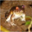

In [ ]:
imag=next(iter(datacifar))
print("The class of the image is %d,\nand the image is:"%imag[1])
imag[0]

## 2. ColorJitter Transforms

In [3]:
transform2=transforms.Compose([transforms.ColorJitter(brightness=1,contrast=0.2,saturation=0.7,hue=0.5),transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
data2=datasets.CIFAR10('/content/torch_data/', transform=transform2)

The class of the image is 6,
and the image is:


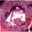

In [ ]:
imag=next(iter(data2))
print("The class of the image is %d,\nand the image is:"%imag[1])
imag[0]

## 3. RandomRotation Transforms

In [ ]:
transform3=transforms.Compose([transforms.RandomRotation(degrees=180),transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
data3=datasets.CIFAR10('/content/torch_data/', transform=transform3)

The class of the image is 6,
and the image is:


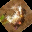

In [ ]:
imag=next(iter(data3))
print("The class of the image is %d,\nand the image is:"%imag[1])
imag[0]

## 4. Rotattion + ColorJitter Transforms

In [ ]:
transform4=transforms.Compose([transforms.ColorJitter(brightness=1,contrast=0.2,saturation=0.7,hue=0.5),transforms.RandomRotation(degrees=180),transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
data4=datasets.CIFAR10('/content/torch_data/', transform=transform4)

The class of the image is 6,
and the image is:


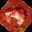

In [ ]:
imag=next(iter(data4))
print("The class of the image is %d,\nand the image is:"%imag[1])
imag[0]

## 5. Rotation + grayscale Transforms

In [ ]:
transform5=transforms.Compose([transforms.RandomRotation(degrees=180),transforms.Grayscale(num_output_channels=3),transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
data5=datasets.CIFAR10('/content/torch_data/', transform=transform5)

The class of the image is 6,
and the image is:


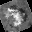

In [ ]:
imag=next(iter(data5))
print("The class of the image is %d,\nand the image is:"%imag[1])
imag[0]

## Importing ResNet50 pretrained.

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Training Models on dataset
## 1. Model on No transformation

In [6]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
device

'cuda'

In [8]:
!pip install pytorch_forecasting
import torch.backends.cudnn as cudnn
import torch.optim as optim
from pytorch_forecasting.optim import Ranger
import torch.nn.functional as F
import torch.nn as nn

     |████████████████████████████████| 113 kB 5.3 MB/s 
     |████████████████████████████████| 526 kB 41.3 MB/s 
     |████████████████████████████████| 11.3 MB 43.9 MB/s 
     |████████████████████████████████| 308 kB 49.4 MB/s 
     |████████████████████████████████| 209 kB 52.1 MB/s 
     |████████████████████████████████| 80 kB 9.1 MB/s 
     |████████████████████████████████| 332 kB 40.2 MB/s 
     |████████████████████████████████| 829 kB 33.6 MB/s 
     |████████████████████████████████| 132 kB 49.8 MB/s 
     |████████████████████████████████| 596 kB 51.9 MB/s 
     |████████████████████████████████| 1.1 MB 40.6 MB/s 
     |████████████████████████████████| 160 kB 52.5 MB/s 
     |████████████████████████████████| 192 kB 43.5 MB/s 
     |████████████████████████████████| 271 kB 46.6 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
     |████████████████████████████████| 149 kB 50.6 MB/s 
     |████████████████████████████████| 112 kB 48.0 MB/s 
     |████████████

In [9]:
from tqdm import tqdm
import gc

In [ ]:
trainloader1 = torch.utils.data.DataLoader(data1, batch_size=128, shuffle=False, num_workers=2)
model=model.to(device)

if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = Ranger(model.parameters(), lr=0.01, weight_decay=5e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, cycle_momentum=False,base_lr=1e-4,max_lr=1e-3, step_size_up=2000,step_size_down=None,mode='triangular', gamma=1.0,scale_mode='cycle',base_momentum=0.8, max_momentum=0.9)
train_loss=0
correct = 0
total = 0
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader1), total=len(trainloader1), desc='Train')
    for step, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        def closure():
          optimizer.zero_grad()
          output = model(inputs)
          loss = criterion(output, targets)
          loss.backward()
          return loss
        optimizer.step(closure)
        train_loss += closure().item()
        _, predicted = model(inputs).max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        gc.collect()
        print('Loss: %.3f | Acc: %.3f%% (%d/%d)'% (train_loss/(129), 100.*correct/total, correct, total))

In [ ]:
for epoch in range(150):
    train(epoch)
    scheduler.step()


Epoch: 0


Train:   0%|          | 1/391 [00:04<27:10,  4.18s/it]

Loss: 0.093 | Acc: 0.781% (1/128)


Train:   1%|          | 2/391 [00:04<12:43,  1.96s/it]

Loss: 0.187 | Acc: 0.391% (1/256)


Train:   1%|          | 3/391 [00:04<08:04,  1.25s/it]

Loss: 0.284 | Acc: 0.521% (2/384)


Train:   1%|          | 4/391 [00:05<05:53,  1.09it/s]

Loss: 0.381 | Acc: 0.391% (2/512)


Train:   1%|▏         | 5/391 [00:05<04:40,  1.37it/s]

Loss: 0.475 | Acc: 0.312% (2/640)


Train:   2%|▏         | 6/391 [00:06<03:58,  1.62it/s]

Loss: 0.573 | Acc: 0.260% (2/768)


Train:   2%|▏         | 7/391 [00:06<03:29,  1.83it/s]

Loss: 0.669 | Acc: 0.223% (2/896)


Train:   2%|▏         | 8/391 [00:06<03:10,  2.01it/s]

Loss: 0.766 | Acc: 0.195% (2/1024)


Train:   2%|▏         | 9/391 [00:07<02:57,  2.15it/s]

Loss: 0.867 | Acc: 0.260% (3/1152)


Train:   3%|▎         | 10/391 [00:07<02:49,  2.25it/s]

Loss: 0.962 | Acc: 0.234% (3/1280)


Train:   3%|▎         | 11/391 [00:08<02:44,  2.31it/s]

Loss: 1.060 | Acc: 0.213% (3/1408)


Train:   3%|▎         | 12/391 [00:08<02:41,  2.35it/s]

Loss: 1.159 | Acc: 0.195% (3/1536)


Train:   3%|▎         | 13/391 [00:08<02:37,  2.40it/s]

Loss: 1.252 | Acc: 0.180% (3/1664)


Train:   4%|▎         | 14/391 [00:09<02:34,  2.44it/s]

Loss: 1.349 | Acc: 0.167% (3/1792)


Train:   4%|▍         | 15/391 [00:09<02:32,  2.46it/s]

Loss: 1.445 | Acc: 0.156% (3/1920)


Train:   4%|▍         | 16/391 [00:10<02:32,  2.46it/s]

Loss: 1.539 | Acc: 0.146% (3/2048)


Train:   4%|▍         | 17/391 [00:10<02:30,  2.49it/s]

Loss: 1.634 | Acc: 0.138% (3/2176)


Train:   5%|▍         | 18/391 [00:10<02:30,  2.48it/s]

Loss: 1.735 | Acc: 0.130% (3/2304)


Train:   5%|▍         | 19/391 [00:11<02:29,  2.49it/s]

Loss: 1.829 | Acc: 0.123% (3/2432)


Train:   5%|▌         | 20/391 [00:11<02:29,  2.49it/s]

Loss: 1.924 | Acc: 0.117% (3/2560)


Train:   5%|▌         | 21/391 [00:12<02:28,  2.49it/s]

Loss: 2.013 | Acc: 0.112% (3/2688)


Train:   6%|▌         | 22/391 [00:12<02:28,  2.48it/s]

Loss: 2.110 | Acc: 0.107% (3/2816)


Train:   6%|▌         | 23/391 [00:12<02:27,  2.49it/s]

Loss: 2.203 | Acc: 0.102% (3/2944)


Train:   6%|▌         | 24/391 [00:13<02:27,  2.48it/s]

Loss: 2.295 | Acc: 0.098% (3/3072)


Train:   6%|▋         | 25/391 [00:13<02:26,  2.49it/s]

Loss: 2.388 | Acc: 0.125% (4/3200)


Train:   7%|▋         | 26/391 [00:14<02:27,  2.48it/s]

Loss: 2.486 | Acc: 0.120% (4/3328)


Train:   7%|▋         | 27/391 [00:14<02:27,  2.47it/s]

Loss: 2.575 | Acc: 0.116% (4/3456)


Train:   7%|▋         | 28/391 [00:14<02:24,  2.51it/s]

Loss: 2.671 | Acc: 0.112% (4/3584)


Train:   7%|▋         | 29/391 [00:15<02:23,  2.52it/s]

Loss: 2.769 | Acc: 0.108% (4/3712)


Train:   8%|▊         | 30/391 [00:15<02:24,  2.50it/s]

Loss: 2.863 | Acc: 0.104% (4/3840)


Train:   8%|▊         | 31/391 [00:16<02:23,  2.50it/s]

Loss: 2.954 | Acc: 0.101% (4/3968)


Train:   8%|▊         | 32/391 [00:16<02:24,  2.48it/s]

Loss: 3.041 | Acc: 0.098% (4/4096)


Train:   8%|▊         | 33/391 [00:16<02:22,  2.51it/s]

Loss: 3.134 | Acc: 0.095% (4/4224)


Train:   9%|▊         | 34/391 [00:17<02:22,  2.51it/s]

Loss: 3.224 | Acc: 0.092% (4/4352)


Train:   9%|▉         | 35/391 [00:17<02:22,  2.50it/s]

Loss: 3.314 | Acc: 0.089% (4/4480)


Train:   9%|▉         | 36/391 [00:18<02:23,  2.47it/s]

Loss: 3.408 | Acc: 0.087% (4/4608)


Train:   9%|▉         | 37/391 [00:18<02:22,  2.48it/s]

Loss: 3.501 | Acc: 0.084% (4/4736)


Train:  10%|▉         | 38/391 [00:19<02:21,  2.49it/s]

Loss: 3.591 | Acc: 0.082% (4/4864)


Train:  10%|▉         | 39/391 [00:19<02:20,  2.50it/s]

Loss: 3.683 | Acc: 0.080% (4/4992)


Train:  10%|█         | 40/391 [00:19<02:20,  2.49it/s]

Loss: 3.775 | Acc: 0.078% (4/5120)


Train:  10%|█         | 41/391 [00:20<02:19,  2.50it/s]

Loss: 3.863 | Acc: 0.076% (4/5248)


Train:  11%|█         | 42/391 [00:20<02:20,  2.49it/s]

Loss: 3.954 | Acc: 0.112% (6/5376)


Train:  11%|█         | 43/391 [00:21<02:19,  2.50it/s]

Loss: 4.042 | Acc: 0.109% (6/5504)


Train:  11%|█▏        | 44/391 [00:21<02:18,  2.50it/s]

Loss: 4.133 | Acc: 0.107% (6/5632)


Train:  12%|█▏        | 45/391 [00:21<02:18,  2.50it/s]

Loss: 4.224 | Acc: 0.104% (6/5760)


Train:  12%|█▏        | 46/391 [00:22<02:18,  2.49it/s]

Loss: 4.310 | Acc: 0.102% (6/5888)


Train:  12%|█▏        | 47/391 [00:22<02:17,  2.50it/s]

Loss: 4.396 | Acc: 0.100% (6/6016)


Train:  12%|█▏        | 48/391 [00:23<02:17,  2.50it/s]

Loss: 4.484 | Acc: 0.114% (7/6144)


Train:  13%|█▎        | 49/391 [00:23<02:18,  2.47it/s]

Loss: 4.571 | Acc: 0.112% (7/6272)


Train:  13%|█▎        | 50/391 [00:23<02:17,  2.49it/s]

Loss: 4.655 | Acc: 0.109% (7/6400)


Train:  13%|█▎        | 51/391 [00:24<02:16,  2.49it/s]

Loss: 4.742 | Acc: 0.107% (7/6528)


Train:  13%|█▎        | 52/391 [00:24<02:15,  2.51it/s]

Loss: 4.825 | Acc: 0.105% (7/6656)


Train:  14%|█▎        | 53/391 [00:25<02:15,  2.50it/s]

Loss: 4.906 | Acc: 0.118% (8/6784)


Train:  14%|█▍        | 54/391 [00:25<02:14,  2.50it/s]

Loss: 4.991 | Acc: 0.116% (8/6912)


Train:  14%|█▍        | 55/391 [00:25<02:15,  2.49it/s]

Loss: 5.074 | Acc: 0.114% (8/7040)


Train:  14%|█▍        | 56/391 [00:26<02:15,  2.47it/s]

Loss: 5.157 | Acc: 0.112% (8/7168)


Train:  15%|█▍        | 57/391 [00:26<02:15,  2.47it/s]

Loss: 5.236 | Acc: 0.110% (8/7296)


Train:  15%|█▍        | 58/391 [00:27<02:13,  2.49it/s]

Loss: 5.321 | Acc: 0.108% (8/7424)


Train:  15%|█▌        | 59/391 [00:27<02:12,  2.50it/s]

Loss: 5.399 | Acc: 0.119% (9/7552)


Train:  15%|█▌        | 60/391 [00:27<02:11,  2.51it/s]

Loss: 5.479 | Acc: 0.117% (9/7680)


Train:  16%|█▌        | 61/391 [00:28<02:11,  2.50it/s]

Loss: 5.559 | Acc: 0.115% (9/7808)


Train:  16%|█▌        | 62/391 [00:28<02:11,  2.51it/s]

Loss: 5.641 | Acc: 0.113% (9/7936)


Train:  16%|█▌        | 63/391 [00:29<02:10,  2.52it/s]

Loss: 5.726 | Acc: 0.136% (11/8064)


Train:  16%|█▋        | 64/391 [00:29<02:09,  2.53it/s]

Loss: 5.804 | Acc: 0.134% (11/8192)


Train:  17%|█▋        | 65/391 [00:29<02:08,  2.54it/s]

Loss: 5.883 | Acc: 0.144% (12/8320)


Train:  17%|█▋        | 66/391 [00:30<02:08,  2.53it/s]

Loss: 5.963 | Acc: 0.142% (12/8448)


Train:  17%|█▋        | 67/391 [00:30<02:08,  2.51it/s]

Loss: 6.041 | Acc: 0.140% (12/8576)


Train:  17%|█▋        | 68/391 [00:30<02:08,  2.52it/s]

Loss: 6.116 | Acc: 0.138% (12/8704)


Train:  18%|█▊        | 69/391 [00:31<02:07,  2.52it/s]

Loss: 6.193 | Acc: 0.136% (12/8832)


Train:  18%|█▊        | 70/391 [00:31<02:06,  2.54it/s]

Loss: 6.266 | Acc: 0.145% (13/8960)


Train:  18%|█▊        | 71/391 [00:32<02:07,  2.51it/s]

Loss: 6.345 | Acc: 0.143% (13/9088)


Train:  18%|█▊        | 72/391 [00:32<02:07,  2.50it/s]

Loss: 6.422 | Acc: 0.141% (13/9216)


Train:  19%|█▊        | 73/391 [00:32<02:07,  2.49it/s]

Loss: 6.497 | Acc: 0.139% (13/9344)


Train:  19%|█▉        | 74/391 [00:33<02:06,  2.51it/s]

Loss: 6.575 | Acc: 0.137% (13/9472)


Train:  19%|█▉        | 75/391 [00:33<02:05,  2.52it/s]

Loss: 6.647 | Acc: 0.146% (14/9600)


Train:  19%|█▉        | 76/391 [00:34<02:04,  2.52it/s]

Loss: 6.717 | Acc: 0.154% (15/9728)


Train:  20%|█▉        | 77/391 [00:34<02:04,  2.53it/s]

Loss: 6.789 | Acc: 0.152% (15/9856)


Train:  20%|█▉        | 78/391 [00:34<02:05,  2.50it/s]

Loss: 6.862 | Acc: 0.150% (15/9984)


Train:  20%|██        | 79/391 [00:35<02:05,  2.50it/s]

Loss: 6.931 | Acc: 0.148% (15/10112)


Train:  20%|██        | 80/391 [00:35<02:04,  2.50it/s]

Loss: 7.002 | Acc: 0.146% (15/10240)


Train:  21%|██        | 81/391 [00:36<02:04,  2.50it/s]

Loss: 7.072 | Acc: 0.145% (15/10368)


Train:  21%|██        | 82/391 [00:36<02:04,  2.49it/s]

Loss: 7.144 | Acc: 0.143% (15/10496)


Train:  21%|██        | 83/391 [00:36<02:04,  2.48it/s]

Loss: 7.213 | Acc: 0.141% (15/10624)


Train:  21%|██▏       | 84/391 [00:37<02:04,  2.47it/s]

Loss: 7.289 | Acc: 0.149% (16/10752)


Train:  22%|██▏       | 85/391 [00:37<02:02,  2.51it/s]

Loss: 7.355 | Acc: 0.165% (18/10880)


Train:  22%|██▏       | 86/391 [00:38<02:01,  2.50it/s]

Loss: 7.424 | Acc: 0.164% (18/11008)


Train:  22%|██▏       | 87/391 [00:38<02:01,  2.50it/s]

Loss: 7.489 | Acc: 0.171% (19/11136)


Train:  23%|██▎       | 88/391 [00:38<02:01,  2.50it/s]

Loss: 7.554 | Acc: 0.186% (21/11264)


Train:  23%|██▎       | 89/391 [00:39<01:59,  2.52it/s]

Loss: 7.619 | Acc: 0.202% (23/11392)


Train:  23%|██▎       | 90/391 [00:39<02:01,  2.49it/s]

Loss: 7.686 | Acc: 0.200% (23/11520)


Train:  23%|██▎       | 91/391 [00:40<02:02,  2.46it/s]

Loss: 7.751 | Acc: 0.197% (23/11648)


Train:  24%|██▎       | 92/391 [00:40<02:01,  2.46it/s]

Loss: 7.814 | Acc: 0.212% (25/11776)


Train:  24%|██▍       | 93/391 [00:41<02:00,  2.48it/s]

Loss: 7.878 | Acc: 0.218% (26/11904)


Train:  24%|██▍       | 94/391 [00:41<01:59,  2.49it/s]

Loss: 7.941 | Acc: 0.224% (27/12032)


Train:  24%|██▍       | 95/391 [00:41<01:58,  2.49it/s]

Loss: 8.001 | Acc: 0.230% (28/12160)


Train:  25%|██▍       | 96/391 [00:42<01:58,  2.49it/s]

Loss: 8.064 | Acc: 0.236% (29/12288)


Train:  25%|██▍       | 97/391 [00:42<01:58,  2.49it/s]

Loss: 8.128 | Acc: 0.234% (29/12416)


Train:  25%|██▌       | 98/391 [00:43<01:57,  2.50it/s]

Loss: 8.191 | Acc: 0.239% (30/12544)


Train:  25%|██▌       | 99/391 [00:43<01:57,  2.49it/s]

Loss: 8.250 | Acc: 0.237% (30/12672)


Train:  26%|██▌       | 100/391 [00:43<01:56,  2.50it/s]

Loss: 8.309 | Acc: 0.250% (32/12800)


Train:  26%|██▌       | 101/391 [00:44<01:56,  2.49it/s]

Loss: 8.371 | Acc: 0.271% (35/12928)


Train:  26%|██▌       | 102/391 [00:44<01:56,  2.48it/s]

Loss: 8.439 | Acc: 0.276% (36/13056)


Train:  26%|██▋       | 103/391 [00:45<01:55,  2.49it/s]

Loss: 8.497 | Acc: 0.273% (36/13184)


Train:  27%|██▋       | 104/391 [00:45<02:05,  2.29it/s]

Loss: 8.554 | Acc: 0.285% (38/13312)


Train:  27%|██▋       | 105/391 [00:45<02:01,  2.35it/s]

Loss: 8.612 | Acc: 0.320% (43/13440)


Train:  27%|██▋       | 106/391 [00:46<02:03,  2.31it/s]

Loss: 8.669 | Acc: 0.332% (45/13568)


Train:  27%|██▋       | 107/391 [00:46<01:59,  2.38it/s]

Loss: 8.721 | Acc: 0.372% (51/13696)


Train:  28%|██▊       | 108/391 [00:47<01:59,  2.37it/s]

Loss: 8.782 | Acc: 0.383% (53/13824)


Train:  28%|██▊       | 109/391 [00:47<01:56,  2.41it/s]

Loss: 8.840 | Acc: 0.401% (56/13952)


Train:  28%|██▊       | 110/391 [00:48<01:55,  2.44it/s]

Loss: 8.895 | Acc: 0.426% (60/14080)


Train:  28%|██▊       | 111/391 [00:48<01:54,  2.45it/s]

Loss: 8.952 | Acc: 0.422% (60/14208)


Train:  29%|██▊       | 112/391 [00:48<01:53,  2.47it/s]

Loss: 9.007 | Acc: 0.426% (61/14336)


Train:  29%|██▉       | 113/391 [00:49<01:51,  2.50it/s]

Loss: 9.058 | Acc: 0.498% (72/14464)


Train:  29%|██▉       | 114/391 [00:49<01:51,  2.48it/s]

Loss: 9.116 | Acc: 0.514% (75/14592)


Train:  29%|██▉       | 115/391 [00:50<01:52,  2.45it/s]

Loss: 9.169 | Acc: 0.550% (81/14720)


Train:  30%|██▉       | 116/391 [00:50<01:52,  2.45it/s]

Loss: 9.224 | Acc: 0.559% (83/14848)


Train:  30%|██▉       | 117/391 [00:50<01:50,  2.48it/s]

Loss: 9.277 | Acc: 0.574% (86/14976)


Train:  30%|███       | 118/391 [00:51<01:49,  2.50it/s]

Loss: 9.328 | Acc: 0.622% (94/15104)


Train:  30%|███       | 119/391 [00:51<01:50,  2.47it/s]

Loss: 9.380 | Acc: 0.676% (103/15232)


Train:  31%|███       | 120/391 [00:52<01:49,  2.47it/s]

Loss: 9.431 | Acc: 0.697% (107/15360)


Train:  31%|███       | 121/391 [00:52<01:49,  2.46it/s]

Loss: 9.485 | Acc: 0.736% (114/15488)


Train:  31%|███       | 122/391 [00:52<01:48,  2.48it/s]

Loss: 9.537 | Acc: 0.788% (123/15616)


Train:  31%|███▏      | 123/391 [00:53<01:47,  2.49it/s]

Loss: 9.590 | Acc: 0.832% (131/15744)


Train:  32%|███▏      | 124/391 [00:53<01:46,  2.51it/s]

Loss: 9.639 | Acc: 0.851% (135/15872)


Train:  32%|███▏      | 125/391 [00:54<01:47,  2.48it/s]

Loss: 9.692 | Acc: 0.875% (140/16000)


Train:  32%|███▏      | 126/391 [00:54<01:47,  2.46it/s]

Loss: 9.744 | Acc: 0.893% (144/16128)


Train:  32%|███▏      | 127/391 [00:54<01:46,  2.48it/s]

Loss: 9.799 | Acc: 0.898% (146/16256)


Train:  33%|███▎      | 128/391 [00:55<01:45,  2.50it/s]

Loss: 9.848 | Acc: 0.928% (152/16384)


Train:  33%|███▎      | 129/391 [00:55<01:46,  2.47it/s]

Loss: 9.896 | Acc: 0.969% (160/16512)


Train:  33%|███▎      | 130/391 [00:56<01:45,  2.46it/s]

Loss: 9.942 | Acc: 1.052% (175/16640)


Train:  34%|███▎      | 131/391 [00:56<01:45,  2.47it/s]

Loss: 9.988 | Acc: 1.127% (189/16768)


Train:  34%|███▍      | 132/391 [00:56<01:44,  2.47it/s]

Loss: 10.040 | Acc: 1.166% (197/16896)


Train:  34%|███▍      | 133/391 [00:57<01:42,  2.51it/s]

Loss: 10.084 | Acc: 1.210% (206/17024)


Train:  34%|███▍      | 134/391 [00:57<01:42,  2.50it/s]

Loss: 10.133 | Acc: 1.259% (216/17152)


Train:  35%|███▍      | 135/391 [00:58<01:42,  2.50it/s]

Loss: 10.178 | Acc: 1.296% (224/17280)


Train:  35%|███▍      | 136/391 [00:58<01:42,  2.49it/s]

Loss: 10.223 | Acc: 1.367% (238/17408)


Train:  35%|███▌      | 137/391 [00:58<01:41,  2.51it/s]

Loss: 10.267 | Acc: 1.426% (250/17536)


Train:  35%|███▌      | 138/391 [00:59<01:41,  2.49it/s]

Loss: 10.313 | Acc: 1.512% (267/17664)


Train:  36%|███▌      | 139/391 [00:59<01:40,  2.51it/s]

Loss: 10.357 | Acc: 1.591% (283/17792)


Train:  36%|███▌      | 140/391 [01:00<01:40,  2.51it/s]

Loss: 10.406 | Acc: 1.635% (293/17920)


Train:  36%|███▌      | 141/391 [01:00<01:39,  2.52it/s]

Loss: 10.448 | Acc: 1.684% (304/18048)


Train:  36%|███▋      | 142/391 [01:00<01:38,  2.53it/s]

Loss: 10.492 | Acc: 1.733% (315/18176)


Train:  37%|███▋      | 143/391 [01:01<01:39,  2.50it/s]

Loss: 10.536 | Acc: 1.814% (332/18304)


Train:  37%|███▋      | 144/391 [01:01<01:39,  2.49it/s]

Loss: 10.579 | Acc: 1.893% (349/18432)


Train:  37%|███▋      | 145/391 [01:02<01:38,  2.50it/s]

Loss: 10.620 | Acc: 1.972% (366/18560)


Train:  37%|███▋      | 146/391 [01:02<01:37,  2.51it/s]

Loss: 10.660 | Acc: 2.028% (379/18688)


Train:  38%|███▊      | 147/391 [01:02<01:37,  2.50it/s]

Loss: 10.709 | Acc: 2.067% (389/18816)


Train:  38%|███▊      | 148/391 [01:03<01:37,  2.50it/s]

Loss: 10.747 | Acc: 2.185% (414/18944)


Train:  38%|███▊      | 149/391 [01:03<01:37,  2.48it/s]

Loss: 10.790 | Acc: 2.255% (430/19072)


Train:  38%|███▊      | 150/391 [01:04<01:37,  2.47it/s]

Loss: 10.830 | Acc: 2.328% (447/19200)


Train:  39%|███▊      | 151/391 [01:04<01:37,  2.46it/s]

Loss: 10.870 | Acc: 2.401% (464/19328)


Train:  39%|███▉      | 152/391 [01:04<01:35,  2.49it/s]

Loss: 10.907 | Acc: 2.498% (486/19456)


Train:  39%|███▉      | 153/391 [01:05<01:35,  2.49it/s]

Loss: 10.944 | Acc: 2.568% (503/19584)


Train:  39%|███▉      | 154/391 [01:05<01:34,  2.50it/s]

Loss: 10.983 | Acc: 2.633% (519/19712)


Train:  40%|███▉      | 155/391 [01:06<01:35,  2.48it/s]

Loss: 11.021 | Acc: 2.712% (538/19840)


Train:  40%|███▉      | 156/391 [01:06<01:35,  2.47it/s]

Loss: 11.062 | Acc: 2.784% (556/19968)


Train:  40%|████      | 157/391 [01:06<01:34,  2.48it/s]

Loss: 11.099 | Acc: 2.881% (579/20096)


Train:  40%|████      | 158/391 [01:07<01:33,  2.49it/s]

Loss: 11.135 | Acc: 2.972% (601/20224)


Train:  41%|████      | 159/391 [01:07<01:32,  2.51it/s]

Loss: 11.175 | Acc: 3.027% (616/20352)


Train:  41%|████      | 160/391 [01:08<01:32,  2.49it/s]

Loss: 11.212 | Acc: 3.125% (640/20480)


Train:  41%|████      | 161/391 [01:08<01:31,  2.52it/s]

Loss: 11.251 | Acc: 3.183% (656/20608)


Train:  41%|████▏     | 162/391 [01:08<01:31,  2.50it/s]

Loss: 11.289 | Acc: 3.284% (681/20736)


Train:  42%|████▏     | 163/391 [01:09<01:31,  2.50it/s]

Loss: 11.324 | Acc: 3.369% (703/20864)


Train:  42%|████▏     | 164/391 [01:09<01:30,  2.50it/s]

Loss: 11.362 | Acc: 3.458% (726/20992)


Train:  42%|████▏     | 165/391 [01:10<01:29,  2.51it/s]

Loss: 11.399 | Acc: 3.551% (750/21120)


Train:  42%|████▏     | 166/391 [01:10<01:29,  2.51it/s]

Loss: 11.432 | Acc: 3.662% (778/21248)


Train:  43%|████▎     | 167/391 [01:10<01:29,  2.50it/s]

Loss: 11.466 | Acc: 3.743% (800/21376)


Train:  43%|████▎     | 168/391 [01:11<01:30,  2.47it/s]

Loss: 11.502 | Acc: 3.799% (817/21504)


Train:  43%|████▎     | 169/391 [01:11<01:29,  2.47it/s]

Loss: 11.536 | Acc: 3.874% (838/21632)


Train:  43%|████▎     | 170/391 [01:12<01:28,  2.49it/s]

Loss: 11.569 | Acc: 3.943% (858/21760)


Train:  44%|████▎     | 171/391 [01:12<01:29,  2.46it/s]

Loss: 11.601 | Acc: 4.034% (883/21888)


Train:  44%|████▍     | 172/391 [01:12<01:28,  2.46it/s]

Loss: 11.637 | Acc: 4.129% (909/22016)


Train:  44%|████▍     | 173/391 [01:13<01:28,  2.47it/s]

Loss: 11.670 | Acc: 4.200% (930/22144)


Train:  45%|████▍     | 174/391 [01:13<01:28,  2.46it/s]

Loss: 11.709 | Acc: 4.279% (953/22272)


Train:  45%|████▍     | 175/391 [01:14<01:27,  2.48it/s]

Loss: 11.740 | Acc: 4.371% (979/22400)


Train:  45%|████▌     | 176/391 [01:14<01:26,  2.48it/s]

Loss: 11.774 | Acc: 4.452% (1003/22528)


Train:  45%|████▌     | 177/391 [01:14<01:26,  2.48it/s]

Loss: 11.810 | Acc: 4.511% (1022/22656)


Train:  46%|████▌     | 178/391 [01:15<01:25,  2.49it/s]

Loss: 11.845 | Acc: 4.591% (1046/22784)


Train:  46%|████▌     | 179/391 [01:15<01:24,  2.52it/s]

Loss: 11.877 | Acc: 4.679% (1072/22912)


Train:  46%|████▌     | 180/391 [01:16<01:24,  2.50it/s]

Loss: 11.908 | Acc: 4.792% (1104/23040)


Train:  46%|████▋     | 181/391 [01:16<01:23,  2.50it/s]

Loss: 11.938 | Acc: 4.903% (1136/23168)


Train:  47%|████▋     | 182/391 [01:16<01:23,  2.51it/s]

Loss: 11.971 | Acc: 5.005% (1166/23296)


Train:  47%|████▋     | 183/391 [01:17<01:21,  2.54it/s]

Loss: 12.000 | Acc: 5.110% (1197/23424)


Train:  47%|████▋     | 184/391 [01:17<01:21,  2.53it/s]

Loss: 12.027 | Acc: 5.248% (1236/23552)


Train:  47%|████▋     | 185/391 [01:18<01:21,  2.52it/s]

Loss: 12.059 | Acc: 5.342% (1265/23680)


Train:  48%|████▊     | 186/391 [01:18<01:22,  2.50it/s]

Loss: 12.089 | Acc: 5.435% (1294/23808)


Train:  48%|████▊     | 187/391 [01:18<01:21,  2.50it/s]

Loss: 12.121 | Acc: 5.540% (1326/23936)


Train:  48%|████▊     | 188/391 [01:19<01:20,  2.51it/s]

Loss: 12.153 | Acc: 5.606% (1349/24064)


Train:  48%|████▊     | 189/391 [01:19<01:20,  2.50it/s]

Loss: 12.182 | Acc: 5.700% (1379/24192)


Train:  49%|████▊     | 190/391 [01:20<01:20,  2.48it/s]

Loss: 12.207 | Acc: 5.831% (1418/24320)


Train:  49%|████▉     | 191/391 [01:20<01:20,  2.48it/s]

Loss: 12.239 | Acc: 5.898% (1442/24448)


Train:  49%|████▉     | 192/391 [01:20<01:20,  2.47it/s]

Loss: 12.270 | Acc: 5.994% (1473/24576)


Train:  49%|████▉     | 193/391 [01:21<01:20,  2.46it/s]

Loss: 12.297 | Acc: 6.100% (1507/24704)


Train:  50%|████▉     | 194/391 [01:21<01:19,  2.48it/s]

Loss: 12.328 | Acc: 6.206% (1541/24832)


Train:  50%|████▉     | 195/391 [01:22<01:19,  2.48it/s]

Loss: 12.358 | Acc: 6.302% (1573/24960)


Train:  50%|█████     | 196/391 [01:22<01:18,  2.47it/s]

Loss: 12.388 | Acc: 6.417% (1610/25088)


Train:  50%|█████     | 197/391 [01:22<01:18,  2.47it/s]

Loss: 12.419 | Acc: 6.508% (1641/25216)


Train:  51%|█████     | 198/391 [01:23<01:18,  2.46it/s]

Loss: 12.448 | Acc: 6.570% (1665/25344)


Train:  51%|█████     | 199/391 [01:23<01:17,  2.46it/s]

Loss: 12.475 | Acc: 6.658% (1696/25472)


Train:  51%|█████     | 200/391 [01:24<01:16,  2.48it/s]

Loss: 12.500 | Acc: 6.762% (1731/25600)


Train:  51%|█████▏    | 201/391 [01:24<01:16,  2.48it/s]

Loss: 12.530 | Acc: 6.852% (1763/25728)


Train:  52%|█████▏    | 202/391 [01:24<01:16,  2.48it/s]

Loss: 12.556 | Acc: 6.950% (1797/25856)


Train:  52%|█████▏    | 203/391 [01:25<01:15,  2.49it/s]

Loss: 12.583 | Acc: 7.081% (1840/25984)


Train:  52%|█████▏    | 204/391 [01:25<01:15,  2.49it/s]

Loss: 12.607 | Acc: 7.211% (1883/26112)


Train:  52%|█████▏    | 205/391 [01:26<01:14,  2.51it/s]

Loss: 12.632 | Acc: 7.348% (1928/26240)


Train:  53%|█████▎    | 206/391 [01:26<01:13,  2.53it/s]

Loss: 12.658 | Acc: 7.456% (1966/26368)


Train:  53%|█████▎    | 207/391 [01:26<01:12,  2.53it/s]

Loss: 12.683 | Acc: 7.575% (2007/26496)


Train:  53%|█████▎    | 208/391 [01:27<01:12,  2.51it/s]

Loss: 12.705 | Acc: 7.707% (2052/26624)


Train:  53%|█████▎    | 209/391 [01:27<01:12,  2.50it/s]

Loss: 12.730 | Acc: 7.824% (2093/26752)


Train:  54%|█████▎    | 210/391 [01:28<01:12,  2.49it/s]

Loss: 12.756 | Acc: 7.913% (2127/26880)


Train:  54%|█████▍    | 211/391 [01:28<01:12,  2.50it/s]

Loss: 12.782 | Acc: 7.998% (2160/27008)


Train:  54%|█████▍    | 212/391 [01:28<01:12,  2.47it/s]

Loss: 12.807 | Acc: 8.104% (2199/27136)


Train:  54%|█████▍    | 213/391 [01:29<01:11,  2.48it/s]

Loss: 12.834 | Acc: 8.183% (2231/27264)


Train:  55%|█████▍    | 214/391 [01:29<01:11,  2.48it/s]

Loss: 12.855 | Acc: 8.324% (2280/27392)


Train:  55%|█████▍    | 215/391 [01:30<01:11,  2.48it/s]

Loss: 12.883 | Acc: 8.383% (2307/27520)


Train:  55%|█████▌    | 216/391 [01:30<01:10,  2.47it/s]

Loss: 12.911 | Acc: 8.474% (2343/27648)


Train:  55%|█████▌    | 217/391 [01:30<01:10,  2.46it/s]

Loss: 12.935 | Acc: 8.608% (2391/27776)


Train:  56%|█████▌    | 218/391 [01:31<01:10,  2.46it/s]

Loss: 12.956 | Acc: 8.737% (2438/27904)


Train:  56%|█████▌    | 219/391 [01:31<01:09,  2.47it/s]

Loss: 12.982 | Acc: 8.815% (2471/28032)


Train:  56%|█████▋    | 220/391 [01:32<01:09,  2.48it/s]

Loss: 13.008 | Acc: 8.906% (2508/28160)


Train:  57%|█████▋    | 221/391 [01:32<01:08,  2.47it/s]

Loss: 13.032 | Acc: 9.014% (2550/28288)


Train:  57%|█████▋    | 222/391 [01:33<01:08,  2.47it/s]

Loss: 13.057 | Acc: 9.125% (2593/28416)


Train:  57%|█████▋    | 223/391 [01:33<01:08,  2.45it/s]

Loss: 13.080 | Acc: 9.217% (2631/28544)


Train:  57%|█████▋    | 224/391 [01:33<01:07,  2.46it/s]

Loss: 13.106 | Acc: 9.270% (2658/28672)


Train:  58%|█████▊    | 225/391 [01:34<01:07,  2.47it/s]

Loss: 13.128 | Acc: 9.358% (2695/28800)


Train:  58%|█████▊    | 226/391 [01:34<01:06,  2.49it/s]

Loss: 13.148 | Acc: 9.482% (2743/28928)


Train:  58%|█████▊    | 227/391 [01:35<01:06,  2.48it/s]

Loss: 13.168 | Acc: 9.581% (2784/29056)


Train:  58%|█████▊    | 228/391 [01:35<01:05,  2.48it/s]

Loss: 13.190 | Acc: 9.683% (2826/29184)


Train:  59%|█████▊    | 229/391 [01:35<01:04,  2.49it/s]

Loss: 13.211 | Acc: 9.805% (2874/29312)


Train:  59%|█████▉    | 230/391 [01:36<01:04,  2.50it/s]

Loss: 13.234 | Acc: 9.918% (2920/29440)


Train:  59%|█████▉    | 231/391 [01:36<01:04,  2.48it/s]

Loss: 13.257 | Acc: 9.994% (2955/29568)


Train:  59%|█████▉    | 232/391 [01:37<01:04,  2.46it/s]

Loss: 13.281 | Acc: 10.075% (2992/29696)


Train:  60%|█████▉    | 233/391 [01:37<01:04,  2.46it/s]

Loss: 13.304 | Acc: 10.186% (3038/29824)


Train:  60%|█████▉    | 234/391 [01:37<01:04,  2.45it/s]

Loss: 13.329 | Acc: 10.290% (3082/29952)


Train:  60%|██████    | 235/391 [01:38<01:03,  2.46it/s]

Loss: 13.352 | Acc: 10.376% (3121/30080)


Train:  60%|██████    | 236/391 [01:38<01:02,  2.47it/s]

Loss: 13.373 | Acc: 10.464% (3161/30208)


Train:  61%|██████    | 237/391 [01:39<01:03,  2.43it/s]

Loss: 13.395 | Acc: 10.552% (3201/30336)


Train:  61%|██████    | 238/391 [01:39<01:02,  2.45it/s]

Loss: 13.416 | Acc: 10.622% (3236/30464)


Train:  61%|██████    | 239/391 [01:39<01:01,  2.47it/s]

Loss: 13.438 | Acc: 10.751% (3289/30592)


Train:  61%|██████▏   | 240/391 [01:40<01:01,  2.47it/s]

Loss: 13.460 | Acc: 10.850% (3333/30720)


Train:  62%|██████▏   | 241/391 [01:40<01:01,  2.46it/s]

Loss: 13.484 | Acc: 10.947% (3377/30848)


Train:  62%|██████▏   | 242/391 [01:41<01:00,  2.45it/s]

Loss: 13.504 | Acc: 11.050% (3423/30976)


Train:  62%|██████▏   | 243/391 [01:41<01:00,  2.46it/s]

Loss: 13.525 | Acc: 11.150% (3468/31104)


Train:  62%|██████▏   | 244/391 [01:41<00:59,  2.49it/s]

Loss: 13.546 | Acc: 11.248% (3513/31232)


Train:  63%|██████▎   | 245/391 [01:42<00:58,  2.49it/s]

Loss: 13.571 | Acc: 11.371% (3566/31360)


Train:  63%|██████▎   | 246/391 [01:42<00:58,  2.48it/s]

Loss: 13.592 | Acc: 11.462% (3609/31488)


Train:  63%|██████▎   | 247/391 [01:43<00:58,  2.47it/s]

Loss: 13.616 | Acc: 11.561% (3655/31616)


Train:  63%|██████▎   | 248/391 [01:43<00:58,  2.46it/s]

Loss: 13.639 | Acc: 11.621% (3689/31744)


Train:  64%|██████▎   | 249/391 [01:43<00:57,  2.48it/s]

Loss: 13.658 | Acc: 11.709% (3732/31872)


Train:  64%|██████▍   | 250/391 [01:44<00:56,  2.48it/s]

Loss: 13.680 | Acc: 11.797% (3775/32000)


Train:  64%|██████▍   | 251/391 [01:44<00:56,  2.48it/s]

Loss: 13.700 | Acc: 11.884% (3818/32128)


Train:  64%|██████▍   | 252/391 [01:45<00:55,  2.49it/s]

Loss: 13.721 | Acc: 11.976% (3863/32256)


Train:  65%|██████▍   | 253/391 [01:45<00:55,  2.47it/s]

Loss: 13.741 | Acc: 12.077% (3911/32384)


Train:  65%|██████▍   | 254/391 [01:45<00:55,  2.48it/s]

Loss: 13.759 | Acc: 12.189% (3963/32512)


Train:  65%|██████▌   | 255/391 [01:46<00:54,  2.50it/s]

Loss: 13.778 | Acc: 12.279% (4008/32640)


Train:  65%|██████▌   | 256/391 [01:46<00:54,  2.50it/s]

Loss: 13.798 | Acc: 12.393% (4061/32768)


Train:  66%|██████▌   | 257/391 [01:47<00:53,  2.51it/s]

Loss: 13.818 | Acc: 12.485% (4107/32896)


Train:  66%|██████▌   | 258/391 [01:47<00:53,  2.48it/s]

Loss: 13.839 | Acc: 12.558% (4147/33024)


Train:  66%|██████▌   | 259/391 [01:47<00:53,  2.48it/s]

Loss: 13.861 | Acc: 12.639% (4190/33152)


Train:  66%|██████▋   | 260/391 [01:48<00:52,  2.49it/s]

Loss: 13.878 | Acc: 12.725% (4235/33280)


Train:  67%|██████▋   | 261/391 [01:48<00:51,  2.51it/s]

Loss: 13.898 | Acc: 12.847% (4292/33408)


Train:  67%|██████▋   | 262/391 [01:49<00:51,  2.50it/s]

Loss: 13.920 | Acc: 12.935% (4338/33536)


Train:  67%|██████▋   | 263/391 [01:49<00:51,  2.50it/s]

Loss: 13.943 | Acc: 13.005% (4378/33664)


Train:  68%|██████▊   | 264/391 [01:49<00:50,  2.50it/s]

Loss: 13.965 | Acc: 13.089% (4423/33792)


Train:  68%|██████▊   | 265/391 [01:50<00:50,  2.51it/s]

Loss: 13.985 | Acc: 13.157% (4463/33920)


Train:  68%|██████▊   | 266/391 [01:50<00:49,  2.51it/s]

Loss: 14.006 | Acc: 13.225% (4503/34048)


Train:  68%|██████▊   | 267/391 [01:51<00:49,  2.50it/s]

Loss: 14.024 | Acc: 13.319% (4552/34176)


Train:  69%|██████▊   | 268/391 [01:51<00:48,  2.52it/s]

Loss: 14.042 | Acc: 13.398% (4596/34304)


Train:  69%|██████▉   | 269/391 [01:51<00:48,  2.51it/s]

Loss: 14.062 | Acc: 13.499% (4648/34432)


Train:  69%|██████▉   | 270/391 [01:52<00:48,  2.50it/s]

Loss: 14.083 | Acc: 13.573% (4691/34560)


Train:  69%|██████▉   | 271/391 [01:52<00:47,  2.51it/s]

Loss: 14.103 | Acc: 13.650% (4735/34688)


Train:  70%|██████▉   | 272/391 [01:53<00:47,  2.51it/s]

Loss: 14.119 | Acc: 13.755% (4789/34816)


Train:  70%|██████▉   | 273/391 [01:53<00:47,  2.51it/s]

Loss: 14.139 | Acc: 13.845% (4838/34944)


Train:  70%|███████   | 274/391 [01:53<00:46,  2.51it/s]

Loss: 14.157 | Acc: 13.928% (4885/35072)


Train:  70%|███████   | 275/391 [01:54<00:46,  2.52it/s]

Loss: 14.176 | Acc: 14.011% (4932/35200)


Train:  71%|███████   | 276/391 [01:54<00:45,  2.50it/s]

Loss: 14.197 | Acc: 14.071% (4971/35328)


Train:  71%|███████   | 277/391 [01:55<00:45,  2.51it/s]

Loss: 14.216 | Acc: 14.156% (5019/35456)


Train:  71%|███████   | 278/391 [01:55<00:45,  2.51it/s]

Loss: 14.234 | Acc: 14.256% (5073/35584)


Train:  71%|███████▏  | 279/391 [01:55<00:44,  2.51it/s]

Loss: 14.250 | Acc: 14.357% (5127/35712)


Train:  72%|███████▏  | 280/391 [01:56<00:43,  2.52it/s]

Loss: 14.268 | Acc: 14.422% (5169/35840)


Train:  72%|███████▏  | 281/391 [01:56<00:43,  2.52it/s]

Loss: 14.286 | Acc: 14.513% (5220/35968)


Train:  72%|███████▏  | 282/391 [01:57<00:43,  2.49it/s]

Loss: 14.308 | Acc: 14.586% (5265/36096)


Train:  72%|███████▏  | 283/391 [01:57<00:43,  2.50it/s]

Loss: 14.325 | Acc: 14.673% (5315/36224)


Train:  73%|███████▎  | 284/391 [01:57<00:42,  2.50it/s]

Loss: 14.342 | Acc: 14.761% (5366/36352)


Train:  73%|███████▎  | 285/391 [01:58<00:42,  2.51it/s]

Loss: 14.360 | Acc: 14.838% (5413/36480)


Train:  73%|███████▎  | 286/391 [01:58<00:41,  2.53it/s]

Loss: 14.376 | Acc: 14.942% (5470/36608)


Train:  73%|███████▎  | 287/391 [01:59<00:41,  2.52it/s]

Loss: 14.394 | Acc: 15.029% (5521/36736)


Train:  74%|███████▎  | 288/391 [01:59<00:41,  2.50it/s]

Loss: 14.411 | Acc: 15.123% (5575/36864)


Train:  74%|███████▍  | 289/391 [01:59<00:40,  2.51it/s]

Loss: 14.430 | Acc: 15.203% (5624/36992)


Train:  74%|███████▍  | 290/391 [02:00<00:40,  2.51it/s]

Loss: 14.446 | Acc: 15.296% (5678/37120)


Train:  74%|███████▍  | 291/391 [02:00<00:39,  2.52it/s]

Loss: 14.467 | Acc: 15.354% (5719/37248)


Train:  75%|███████▍  | 292/391 [02:01<00:39,  2.52it/s]

Loss: 14.486 | Acc: 15.419% (5763/37376)


Train:  75%|███████▍  | 293/391 [02:01<00:38,  2.52it/s]

Loss: 14.503 | Acc: 15.502% (5814/37504)


Train:  75%|███████▌  | 294/391 [02:01<00:38,  2.50it/s]

Loss: 14.519 | Acc: 15.593% (5868/37632)


Train:  75%|███████▌  | 295/391 [02:02<00:38,  2.52it/s]

Loss: 14.537 | Acc: 15.694% (5926/37760)


Train:  76%|███████▌  | 296/391 [02:02<00:37,  2.52it/s]

Loss: 14.555 | Acc: 15.781% (5979/37888)


Train:  76%|███████▌  | 297/391 [02:03<00:37,  2.52it/s]

Loss: 14.573 | Acc: 15.835% (6020/38016)


Train:  76%|███████▌  | 298/391 [02:03<00:36,  2.52it/s]

Loss: 14.593 | Acc: 15.921% (6073/38144)


Train:  76%|███████▋  | 299/391 [02:03<00:36,  2.52it/s]

Loss: 14.608 | Acc: 16.012% (6128/38272)


Train:  77%|███████▋  | 300/391 [02:04<00:36,  2.50it/s]

Loss: 14.626 | Acc: 16.094% (6180/38400)


Train:  77%|███████▋  | 301/391 [02:04<00:35,  2.51it/s]

Loss: 14.643 | Acc: 16.162% (6227/38528)


Train:  77%|███████▋  | 302/391 [02:05<00:35,  2.50it/s]

Loss: 14.663 | Acc: 16.210% (6266/38656)


Train:  77%|███████▋  | 303/391 [02:05<00:35,  2.51it/s]

Loss: 14.680 | Acc: 16.308% (6325/38784)


Train:  78%|███████▊  | 304/391 [02:05<00:34,  2.51it/s]

Loss: 14.695 | Acc: 16.383% (6375/38912)


Train:  78%|███████▊  | 305/391 [02:06<00:34,  2.52it/s]

Loss: 14.711 | Acc: 16.470% (6430/39040)


Train:  78%|███████▊  | 306/391 [02:06<00:33,  2.50it/s]

Loss: 14.733 | Acc: 16.567% (6489/39168)


Train:  79%|███████▊  | 307/391 [02:07<00:33,  2.50it/s]

Loss: 14.749 | Acc: 16.643% (6540/39296)


Train:  79%|███████▉  | 308/391 [02:07<00:32,  2.52it/s]

Loss: 14.766 | Acc: 16.711% (6588/39424)


Train:  79%|███████▉  | 309/391 [02:07<00:32,  2.52it/s]

Loss: 14.785 | Acc: 16.780% (6637/39552)


Train:  79%|███████▉  | 310/391 [02:08<00:32,  2.52it/s]

Loss: 14.801 | Acc: 16.870% (6694/39680)


Train:  80%|███████▉  | 311/391 [02:08<00:31,  2.53it/s]

Loss: 14.823 | Acc: 16.924% (6737/39808)


Train:  80%|███████▉  | 312/391 [02:09<00:31,  2.50it/s]

Loss: 14.839 | Acc: 17.012% (6794/39936)


Train:  80%|████████  | 313/391 [02:09<00:31,  2.51it/s]

Loss: 14.853 | Acc: 17.108% (6854/40064)


Train:  80%|████████  | 314/391 [02:09<00:30,  2.53it/s]

Loss: 14.869 | Acc: 17.170% (6901/40192)


Train:  81%|████████  | 315/391 [02:10<00:30,  2.52it/s]

Loss: 14.886 | Acc: 17.230% (6947/40320)


Train:  81%|████████  | 316/391 [02:10<00:29,  2.54it/s]

Loss: 14.903 | Acc: 17.294% (6995/40448)


Train:  81%|████████  | 317/391 [02:11<00:29,  2.54it/s]

Loss: 14.917 | Acc: 17.407% (7063/40576)


Train:  81%|████████▏ | 318/391 [02:11<00:29,  2.51it/s]

Loss: 14.932 | Acc: 17.482% (7116/40704)


Train:  82%|████████▏ | 319/391 [02:11<00:28,  2.51it/s]

Loss: 14.947 | Acc: 17.567% (7173/40832)


Train:  82%|████████▏ | 320/391 [02:12<00:28,  2.50it/s]

Loss: 14.964 | Acc: 17.649% (7229/40960)


Train:  82%|████████▏ | 321/391 [02:12<00:27,  2.50it/s]

Loss: 14.981 | Acc: 17.713% (7278/41088)


Train:  82%|████████▏ | 322/391 [02:13<00:27,  2.50it/s]

Loss: 14.996 | Acc: 17.789% (7332/41216)


Train:  83%|████████▎ | 323/391 [02:13<00:27,  2.48it/s]

Loss: 15.011 | Acc: 17.882% (7393/41344)


Train:  83%|████████▎ | 324/391 [02:13<00:27,  2.45it/s]

Loss: 15.025 | Acc: 17.964% (7450/41472)


Train:  83%|████████▎ | 325/391 [02:14<00:26,  2.48it/s]

Loss: 15.040 | Acc: 18.050% (7509/41600)


Train:  83%|████████▎ | 326/391 [02:14<00:26,  2.46it/s]

Loss: 15.055 | Acc: 18.120% (7561/41728)


Train:  84%|████████▎ | 327/391 [02:15<00:25,  2.48it/s]

Loss: 15.069 | Acc: 18.210% (7622/41856)


Train:  84%|████████▍ | 328/391 [02:15<00:25,  2.49it/s]

Loss: 15.085 | Acc: 18.288% (7678/41984)


Train:  84%|████████▍ | 329/391 [02:15<00:24,  2.49it/s]

Loss: 15.099 | Acc: 18.377% (7739/42112)


Train:  84%|████████▍ | 330/391 [02:16<00:24,  2.48it/s]

Loss: 15.117 | Acc: 18.423% (7782/42240)


Train:  85%|████████▍ | 331/391 [02:16<00:24,  2.47it/s]

Loss: 15.130 | Acc: 18.509% (7842/42368)


Train:  85%|████████▍ | 332/391 [02:17<00:23,  2.47it/s]

Loss: 15.142 | Acc: 18.616% (7911/42496)


Train:  85%|████████▌ | 333/391 [02:17<00:23,  2.48it/s]

Loss: 15.157 | Acc: 18.694% (7968/42624)


Train:  85%|████████▌ | 334/391 [02:17<00:23,  2.47it/s]

Loss: 15.172 | Acc: 18.764% (8022/42752)


Train:  86%|████████▌ | 335/391 [02:18<00:22,  2.47it/s]

Loss: 15.187 | Acc: 18.832% (8075/42880)


Train:  86%|████████▌ | 336/391 [02:18<00:22,  2.50it/s]

Loss: 15.201 | Acc: 18.922% (8138/43008)


Train:  86%|████████▌ | 337/391 [02:19<00:21,  2.49it/s]

Loss: 15.217 | Acc: 18.986% (8190/43136)


Train:  86%|████████▋ | 338/391 [02:19<00:21,  2.50it/s]

Loss: 15.231 | Acc: 19.069% (8250/43264)


Train:  87%|████████▋ | 339/391 [02:19<00:20,  2.48it/s]

Loss: 15.244 | Acc: 19.158% (8313/43392)


Train:  87%|████████▋ | 340/391 [02:20<00:20,  2.49it/s]

Loss: 15.259 | Acc: 19.239% (8373/43520)


Train:  87%|████████▋ | 341/391 [02:20<00:19,  2.50it/s]

Loss: 15.273 | Acc: 19.320% (8433/43648)


Train:  87%|████████▋ | 342/391 [02:21<00:19,  2.49it/s]

Loss: 15.287 | Acc: 19.417% (8500/43776)


Train:  88%|████████▊ | 343/391 [02:21<00:19,  2.50it/s]

Loss: 15.303 | Acc: 19.479% (8552/43904)


Train:  88%|████████▊ | 344/391 [02:21<00:18,  2.52it/s]

Loss: 15.317 | Acc: 19.549% (8608/44032)


Train:  88%|████████▊ | 345/391 [02:22<00:18,  2.53it/s]

Loss: 15.331 | Acc: 19.617% (8663/44160)


Train:  88%|████████▊ | 346/391 [02:22<00:17,  2.50it/s]

Loss: 15.347 | Acc: 19.685% (8718/44288)


Train:  89%|████████▊ | 347/391 [02:23<00:17,  2.49it/s]

Loss: 15.361 | Acc: 19.754% (8774/44416)


Train:  89%|████████▉ | 348/391 [02:23<00:17,  2.47it/s]

Loss: 15.377 | Acc: 19.834% (8835/44544)


Train:  89%|████████▉ | 349/391 [02:23<00:16,  2.49it/s]

Loss: 15.393 | Acc: 19.916% (8897/44672)


Train:  90%|████████▉ | 350/391 [02:24<00:16,  2.49it/s]

Loss: 15.406 | Acc: 19.982% (8952/44800)


Train:  90%|████████▉ | 351/391 [02:24<00:15,  2.51it/s]

Loss: 15.423 | Acc: 20.063% (9014/44928)


Train:  90%|█████████ | 352/391 [02:25<00:15,  2.52it/s]

Loss: 15.437 | Acc: 20.135% (9072/45056)


Train:  90%|█████████ | 353/391 [02:25<00:14,  2.54it/s]

Loss: 15.452 | Acc: 20.224% (9138/45184)


Train:  91%|█████████ | 354/391 [02:25<00:14,  2.51it/s]

Loss: 15.466 | Acc: 20.295% (9196/45312)


Train:  91%|█████████ | 355/391 [02:26<00:14,  2.50it/s]

Loss: 15.479 | Acc: 20.372% (9257/45440)


Train:  91%|█████████ | 356/391 [02:26<00:13,  2.53it/s]

Loss: 15.493 | Acc: 20.446% (9317/45568)


Train:  91%|█████████▏| 357/391 [02:27<00:13,  2.51it/s]

Loss: 15.508 | Acc: 20.520% (9377/45696)


Train:  92%|█████████▏| 358/391 [02:27<00:13,  2.51it/s]

Loss: 15.522 | Acc: 20.577% (9429/45824)


Train:  92%|█████████▏| 359/391 [02:27<00:12,  2.52it/s]

Loss: 15.538 | Acc: 20.648% (9488/45952)


Train:  92%|█████████▏| 360/391 [02:28<00:12,  2.51it/s]

Loss: 15.552 | Acc: 20.720% (9548/46080)


Train:  92%|█████████▏| 361/391 [02:28<00:11,  2.50it/s]

Loss: 15.565 | Acc: 20.791% (9607/46208)


Train:  93%|█████████▎| 362/391 [02:29<00:11,  2.51it/s]

Loss: 15.579 | Acc: 20.867% (9669/46336)


Train:  93%|█████████▎| 363/391 [02:29<00:11,  2.48it/s]

Loss: 15.594 | Acc: 20.924% (9722/46464)


Train:  93%|█████████▎| 364/391 [02:29<00:10,  2.48it/s]

Loss: 15.611 | Acc: 20.980% (9775/46592)


Train:  93%|█████████▎| 365/391 [02:30<00:10,  2.47it/s]

Loss: 15.624 | Acc: 21.047% (9833/46720)


Train:  94%|█████████▎| 366/391 [02:30<00:10,  2.47it/s]

Loss: 15.639 | Acc: 21.111% (9890/46848)


Train:  94%|█████████▍| 367/391 [02:31<00:09,  2.48it/s]

Loss: 15.652 | Acc: 21.187% (9953/46976)


Train:  94%|█████████▍| 368/391 [02:31<00:09,  2.49it/s]

Loss: 15.665 | Acc: 21.259% (10014/47104)


Train:  94%|█████████▍| 369/391 [02:31<00:08,  2.49it/s]

Loss: 15.678 | Acc: 21.337% (10078/47232)


Train:  95%|█████████▍| 370/391 [02:32<00:08,  2.48it/s]

Loss: 15.691 | Acc: 21.440% (10154/47360)


Train:  95%|█████████▍| 371/391 [02:32<00:08,  2.48it/s]

Loss: 15.703 | Acc: 21.528% (10223/47488)


Train:  95%|█████████▌| 372/391 [02:33<00:07,  2.47it/s]

Loss: 15.717 | Acc: 21.591% (10281/47616)


Train:  95%|█████████▌| 373/391 [02:33<00:07,  2.51it/s]

Loss: 15.731 | Acc: 21.661% (10342/47744)


Train:  96%|█████████▌| 374/391 [02:33<00:06,  2.51it/s]

Loss: 15.745 | Acc: 21.733% (10404/47872)


Train:  96%|█████████▌| 375/391 [02:34<00:06,  2.50it/s]

Loss: 15.760 | Acc: 21.808% (10468/48000)


Train:  96%|█████████▌| 376/391 [02:34<00:06,  2.49it/s]

Loss: 15.774 | Acc: 21.881% (10531/48128)


Train:  96%|█████████▋| 377/391 [02:35<00:05,  2.51it/s]

Loss: 15.787 | Acc: 21.950% (10592/48256)


Train:  97%|█████████▋| 378/391 [02:35<00:05,  2.51it/s]

Loss: 15.800 | Acc: 22.026% (10657/48384)


Train:  97%|█████████▋| 379/391 [02:35<00:04,  2.51it/s]

Loss: 15.812 | Acc: 22.110% (10726/48512)


Train:  97%|█████████▋| 380/391 [02:36<00:04,  2.49it/s]

Loss: 15.826 | Acc: 22.206% (10801/48640)


Train:  97%|█████████▋| 381/391 [02:36<00:03,  2.50it/s]

Loss: 15.838 | Acc: 22.287% (10869/48768)


Train:  98%|█████████▊| 382/391 [02:37<00:03,  2.48it/s]

Loss: 15.851 | Acc: 22.366% (10936/48896)


Train:  98%|█████████▊| 383/391 [02:37<00:03,  2.49it/s]

Loss: 15.864 | Acc: 22.444% (11003/49024)


Train:  98%|█████████▊| 384/391 [02:37<00:02,  2.49it/s]

Loss: 15.877 | Acc: 22.516% (11067/49152)


Train:  98%|█████████▊| 385/391 [02:38<00:02,  2.47it/s]

Loss: 15.889 | Acc: 22.587% (11131/49280)


Train:  99%|█████████▊| 386/391 [02:38<00:02,  2.48it/s]

Loss: 15.902 | Acc: 22.640% (11186/49408)


Train:  99%|█████████▉| 387/391 [02:39<00:01,  2.48it/s]

Loss: 15.915 | Acc: 22.713% (11251/49536)


Train:  99%|█████████▉| 388/391 [02:39<00:01,  2.50it/s]

Loss: 15.928 | Acc: 22.779% (11313/49664)


Train:  99%|█████████▉| 389/391 [02:39<00:00,  2.49it/s]

Loss: 15.942 | Acc: 22.849% (11377/49792)


Train: 100%|█████████▉| 390/391 [02:40<00:00,  2.46it/s]

Loss: 15.955 | Acc: 22.927% (11445/49920)


Train: 100%|██████████| 391/391 [02:43<00:00,  2.39it/s]

Loss: 15.968 | Acc: 22.960% (11480/50000)

Epoch: 1



Train:   0%|          | 1/391 [00:00<03:39,  1.77it/s]

Loss: 0.014 | Acc: 40.625% (52/128)


Train:   1%|          | 2/391 [00:00<03:01,  2.14it/s]

Loss: 0.026 | Acc: 46.094% (118/256)


Train:   1%|          | 3/391 [00:01<02:49,  2.29it/s]

Loss: 0.039 | Acc: 47.135% (181/384)


Train:   1%|          | 4/391 [00:01<02:43,  2.36it/s]

Loss: 0.055 | Acc: 47.070% (241/512)


Train:   1%|▏         | 5/391 [00:02<02:40,  2.40it/s]

Loss: 0.068 | Acc: 49.062% (314/640)


Train:   2%|▏         | 6/391 [00:02<02:38,  2.43it/s]

Loss: 0.080 | Acc: 48.698% (374/768)


Train:   2%|▏         | 7/391 [00:02<02:35,  2.47it/s]

Loss: 0.095 | Acc: 47.545% (426/896)


Train:   2%|▏         | 8/391 [00:03<02:35,  2.46it/s]

Loss: 0.107 | Acc: 48.633% (498/1024)


Train:   2%|▏         | 9/391 [00:03<02:35,  2.46it/s]

Loss: 0.118 | Acc: 49.392% (569/1152)


Train:   3%|▎         | 10/391 [00:04<02:34,  2.46it/s]

Loss: 0.130 | Acc: 49.531% (634/1280)


Train:   3%|▎         | 11/391 [00:04<02:36,  2.43it/s]

Loss: 0.144 | Acc: 49.645% (699/1408)


Train:   3%|▎         | 12/391 [00:05<02:36,  2.43it/s]

Loss: 0.157 | Acc: 50.065% (769/1536)


Train:   3%|▎         | 13/391 [00:05<02:35,  2.43it/s]

Loss: 0.168 | Acc: 50.781% (845/1664)


Train:   4%|▎         | 14/391 [00:05<02:34,  2.43it/s]

Loss: 0.180 | Acc: 50.837% (911/1792)


Train:   4%|▍         | 15/391 [00:06<02:32,  2.46it/s]

Loss: 0.194 | Acc: 51.146% (982/1920)


Train:   4%|▍         | 16/391 [00:06<02:31,  2.47it/s]

Loss: 0.208 | Acc: 50.781% (1040/2048)


Train:   4%|▍         | 17/391 [00:07<02:31,  2.47it/s]

Loss: 0.220 | Acc: 51.057% (1111/2176)


Train:   5%|▍         | 18/391 [00:07<02:30,  2.48it/s]

Loss: 0.231 | Acc: 51.476% (1186/2304)


Train:   5%|▍         | 19/391 [00:07<02:31,  2.46it/s]

Loss: 0.243 | Acc: 51.727% (1258/2432)


Train:   5%|▌         | 20/391 [00:08<02:30,  2.47it/s]

Loss: 0.254 | Acc: 51.797% (1326/2560)


Train:   5%|▌         | 21/391 [00:08<02:30,  2.45it/s]

Loss: 0.264 | Acc: 52.083% (1400/2688)


Train:   6%|▌         | 22/391 [00:09<02:27,  2.50it/s]

Loss: 0.277 | Acc: 51.953% (1463/2816)


Train:   6%|▌         | 23/391 [00:09<02:28,  2.48it/s]

Loss: 0.288 | Acc: 52.242% (1538/2944)


Train:   6%|▌         | 24/391 [00:09<02:28,  2.47it/s]

Loss: 0.302 | Acc: 52.148% (1602/3072)


Train:   6%|▋         | 25/391 [00:10<02:28,  2.46it/s]

Loss: 0.314 | Acc: 52.250% (1672/3200)


Train:   7%|▋         | 26/391 [00:10<02:26,  2.49it/s]

Loss: 0.325 | Acc: 52.374% (1743/3328)


Train:   7%|▋         | 27/391 [00:11<02:26,  2.49it/s]

Loss: 0.340 | Acc: 52.344% (1809/3456)


Train:   7%|▋         | 28/391 [00:11<02:24,  2.52it/s]

Loss: 0.351 | Acc: 52.651% (1887/3584)


Train:   7%|▋         | 29/391 [00:11<02:24,  2.50it/s]

Loss: 0.364 | Acc: 52.478% (1948/3712)


Train:   8%|▊         | 30/391 [00:12<02:24,  2.49it/s]

Loss: 0.375 | Acc: 52.604% (2020/3840)


Train:   8%|▊         | 31/391 [00:12<02:23,  2.50it/s]

Loss: 0.388 | Acc: 52.571% (2086/3968)


Train:   8%|▊         | 32/391 [00:13<02:23,  2.50it/s]

Loss: 0.399 | Acc: 52.686% (2158/4096)


Train:   8%|▊         | 33/391 [00:13<02:23,  2.50it/s]

Loss: 0.413 | Acc: 52.486% (2217/4224)


Train:   9%|▊         | 34/391 [00:13<02:23,  2.49it/s]

Loss: 0.426 | Acc: 52.436% (2282/4352)


Train:   9%|▉         | 35/391 [00:14<02:24,  2.46it/s]

Loss: 0.438 | Acc: 52.344% (2345/4480)


Train:   9%|▉         | 36/391 [00:14<02:23,  2.47it/s]

Loss: 0.450 | Acc: 52.344% (2412/4608)


Train:   9%|▉         | 37/391 [00:15<02:23,  2.46it/s]

Loss: 0.460 | Acc: 52.555% (2489/4736)


Train:  10%|▉         | 38/391 [00:15<02:22,  2.47it/s]

Loss: 0.474 | Acc: 52.447% (2551/4864)


Train:  10%|▉         | 39/391 [00:15<02:22,  2.47it/s]

Loss: 0.487 | Acc: 52.344% (2613/4992)


Train:  10%|█         | 40/391 [00:16<02:20,  2.49it/s]

Loss: 0.500 | Acc: 52.285% (2677/5120)


Train:  10%|█         | 41/391 [00:16<02:22,  2.45it/s]

Loss: 0.513 | Acc: 52.229% (2741/5248)


Train:  11%|█         | 42/391 [00:17<02:21,  2.46it/s]

Loss: 0.524 | Acc: 52.251% (2809/5376)


Train:  11%|█         | 43/391 [00:17<02:22,  2.45it/s]

Loss: 0.535 | Acc: 52.235% (2875/5504)


Train:  11%|█▏        | 44/391 [00:17<02:20,  2.47it/s]

Loss: 0.547 | Acc: 52.273% (2944/5632)


Train:  12%|█▏        | 45/391 [00:18<02:19,  2.48it/s]

Loss: 0.559 | Acc: 52.413% (3019/5760)


Train:  12%|█▏        | 46/391 [00:18<02:18,  2.50it/s]

Loss: 0.571 | Acc: 52.344% (3082/5888)


Train:  12%|█▏        | 47/391 [00:19<02:19,  2.47it/s]

Loss: 0.582 | Acc: 52.311% (3147/6016)


Train:  12%|█▏        | 48/391 [00:19<02:18,  2.47it/s]

Loss: 0.594 | Acc: 52.262% (3211/6144)


Train:  13%|█▎        | 49/391 [00:19<02:17,  2.49it/s]

Loss: 0.605 | Acc: 52.455% (3290/6272)


Train:  13%|█▎        | 50/391 [00:20<02:16,  2.50it/s]

Loss: 0.615 | Acc: 52.531% (3362/6400)


Train:  13%|█▎        | 51/391 [00:20<02:16,  2.49it/s]

Loss: 0.630 | Acc: 52.665% (3438/6528)


Train:  13%|█▎        | 52/391 [00:21<02:15,  2.50it/s]

Loss: 0.643 | Acc: 52.569% (3499/6656)


Train:  14%|█▎        | 53/391 [00:21<02:15,  2.50it/s]

Loss: 0.655 | Acc: 52.609% (3569/6784)


Train:  14%|█▍        | 54/391 [00:21<02:15,  2.49it/s]

Loss: 0.668 | Acc: 52.532% (3631/6912)


Train:  14%|█▍        | 55/391 [00:22<02:14,  2.49it/s]

Loss: 0.678 | Acc: 52.557% (3700/7040)


Train:  14%|█▍        | 56/391 [00:22<02:15,  2.48it/s]

Loss: 0.691 | Acc: 52.469% (3761/7168)


Train:  15%|█▍        | 57/391 [00:23<02:14,  2.48it/s]

Loss: 0.701 | Acc: 52.549% (3834/7296)


Train:  15%|█▍        | 58/391 [00:23<02:14,  2.47it/s]

Loss: 0.713 | Acc: 52.613% (3906/7424)


Train:  15%|█▌        | 59/391 [00:24<02:16,  2.43it/s]

Loss: 0.725 | Acc: 52.556% (3969/7552)


Train:  15%|█▌        | 60/391 [00:24<02:15,  2.45it/s]

Loss: 0.736 | Acc: 52.539% (4035/7680)


Train:  16%|█▌        | 61/391 [00:24<02:13,  2.47it/s]

Loss: 0.748 | Acc: 52.536% (4102/7808)


Train:  16%|█▌        | 62/391 [00:25<02:12,  2.48it/s]

Loss: 0.759 | Acc: 52.571% (4172/7936)


Train:  16%|█▌        | 63/391 [00:25<02:12,  2.47it/s]

Loss: 0.771 | Acc: 52.629% (4244/8064)


Train:  16%|█▋        | 64/391 [00:26<02:11,  2.49it/s]

Loss: 0.782 | Acc: 52.673% (4315/8192)


Train:  17%|█▋        | 65/391 [00:26<02:10,  2.49it/s]

Loss: 0.793 | Acc: 52.680% (4383/8320)


Train:  17%|█▋        | 66/391 [00:26<02:10,  2.48it/s]

Loss: 0.804 | Acc: 52.734% (4455/8448)


Train:  17%|█▋        | 67/391 [00:27<02:11,  2.46it/s]

Loss: 0.816 | Acc: 52.729% (4522/8576)


Train:  17%|█▋        | 68/391 [00:27<02:10,  2.47it/s]

Loss: 0.827 | Acc: 52.838% (4599/8704)


Train:  18%|█▊        | 69/391 [00:28<02:09,  2.48it/s]

Loss: 0.838 | Acc: 52.808% (4664/8832)


Train:  18%|█▊        | 70/391 [00:28<02:08,  2.49it/s]

Loss: 0.849 | Acc: 52.846% (4735/8960)


Train:  18%|█▊        | 71/391 [00:28<02:09,  2.48it/s]

Loss: 0.864 | Acc: 52.806% (4799/9088)


Train:  18%|█▊        | 72/391 [00:29<02:09,  2.47it/s]

Loss: 0.875 | Acc: 52.865% (4872/9216)


Train:  19%|█▊        | 73/391 [00:29<02:08,  2.48it/s]

Loss: 0.885 | Acc: 52.964% (4949/9344)


Train:  19%|█▉        | 74/391 [00:30<02:08,  2.47it/s]

Loss: 0.897 | Acc: 53.041% (5024/9472)


Train:  19%|█▉        | 75/391 [00:30<02:07,  2.48it/s]

Loss: 0.907 | Acc: 53.104% (5098/9600)


Train:  19%|█▉        | 76/391 [00:30<02:07,  2.47it/s]

Loss: 0.915 | Acc: 53.228% (5178/9728)


Train:  20%|█▉        | 77/391 [00:31<02:09,  2.42it/s]

Loss: 0.927 | Acc: 53.196% (5243/9856)


Train:  20%|█▉        | 78/391 [00:31<02:09,  2.42it/s]

Loss: 0.936 | Acc: 53.335% (5325/9984)


Train:  20%|██        | 79/391 [00:32<02:07,  2.44it/s]

Loss: 0.945 | Acc: 53.491% (5409/10112)


Train:  20%|██        | 80/391 [00:32<02:05,  2.47it/s]

Loss: 0.956 | Acc: 53.506% (5479/10240)


Train:  21%|██        | 81/391 [00:32<02:06,  2.45it/s]

Loss: 0.968 | Acc: 53.578% (5555/10368)


Train:  21%|██        | 82/391 [00:33<02:05,  2.45it/s]

Loss: 0.979 | Acc: 53.601% (5626/10496)


Train:  21%|██        | 83/391 [00:33<02:06,  2.44it/s]

Loss: 0.990 | Acc: 53.624% (5697/10624)


Train:  21%|██▏       | 84/391 [00:34<02:05,  2.45it/s]

Loss: 1.001 | Acc: 53.655% (5769/10752)


Train:  22%|██▏       | 85/391 [00:34<02:04,  2.45it/s]

Loss: 1.010 | Acc: 53.686% (5841/10880)


Train:  22%|██▏       | 86/391 [00:34<02:04,  2.45it/s]

Loss: 1.021 | Acc: 53.688% (5910/11008)


Train:  22%|██▏       | 87/391 [00:35<02:02,  2.48it/s]

Loss: 1.032 | Acc: 53.718% (5982/11136)


Train:  23%|██▎       | 88/391 [00:35<02:01,  2.49it/s]

Loss: 1.042 | Acc: 53.773% (6057/11264)


Train:  23%|██▎       | 89/391 [00:36<02:03,  2.44it/s]

Loss: 1.054 | Acc: 53.775% (6126/11392)


Train:  23%|██▎       | 90/391 [00:36<02:02,  2.46it/s]

Loss: 1.065 | Acc: 53.802% (6198/11520)


Train:  23%|██▎       | 91/391 [00:36<02:00,  2.48it/s]

Loss: 1.074 | Acc: 53.889% (6277/11648)


Train:  24%|██▎       | 92/391 [00:37<01:58,  2.52it/s]

Loss: 1.085 | Acc: 53.923% (6350/11776)


Train:  24%|██▍       | 93/391 [00:37<01:59,  2.50it/s]

Loss: 1.094 | Acc: 53.982% (6426/11904)


Train:  24%|██▍       | 94/391 [00:38<01:59,  2.50it/s]

Loss: 1.104 | Acc: 54.031% (6501/12032)


Train:  24%|██▍       | 95/391 [00:38<02:00,  2.46it/s]

Loss: 1.115 | Acc: 54.079% (6576/12160)


Train:  25%|██▍       | 96/391 [00:38<01:59,  2.47it/s]

Loss: 1.124 | Acc: 54.134% (6652/12288)


Train:  25%|██▍       | 97/391 [00:39<02:00,  2.45it/s]

Loss: 1.135 | Acc: 54.180% (6727/12416)


Train:  25%|██▌       | 98/391 [00:39<01:59,  2.46it/s]

Loss: 1.145 | Acc: 54.193% (6798/12544)


Train:  25%|██▌       | 99/391 [00:40<01:57,  2.49it/s]

Loss: 1.155 | Acc: 54.269% (6877/12672)


Train:  26%|██▌       | 100/391 [00:40<01:56,  2.49it/s]

Loss: 1.164 | Acc: 54.328% (6954/12800)


Train:  26%|██▌       | 101/391 [00:40<01:56,  2.49it/s]

Loss: 1.175 | Acc: 54.285% (7018/12928)


Train:  26%|██▌       | 102/391 [00:41<01:56,  2.49it/s]

Loss: 1.187 | Acc: 54.305% (7090/13056)


Train:  26%|██▋       | 103/391 [00:41<01:55,  2.50it/s]

Loss: 1.196 | Acc: 54.354% (7166/13184)


Train:  27%|██▋       | 104/391 [00:42<01:55,  2.49it/s]

Loss: 1.206 | Acc: 54.410% (7243/13312)


Train:  27%|██▋       | 105/391 [00:42<01:55,  2.49it/s]

Loss: 1.217 | Acc: 54.405% (7312/13440)


Train:  27%|██▋       | 106/391 [00:42<01:54,  2.50it/s]

Loss: 1.228 | Acc: 54.393% (7380/13568)


Train:  27%|██▋       | 107/391 [00:43<01:53,  2.49it/s]

Loss: 1.238 | Acc: 54.461% (7459/13696)


Train:  28%|██▊       | 108/391 [00:43<01:52,  2.51it/s]

Loss: 1.249 | Acc: 54.492% (7533/13824)


Train:  28%|██▊       | 109/391 [00:44<01:52,  2.50it/s]

Loss: 1.260 | Acc: 54.530% (7608/13952)


Train:  28%|██▊       | 110/391 [00:44<01:52,  2.49it/s]

Loss: 1.270 | Acc: 54.545% (7680/14080)


Train:  28%|██▊       | 111/391 [00:44<01:52,  2.50it/s]

Loss: 1.280 | Acc: 54.554% (7751/14208)


Train:  29%|██▊       | 112/391 [00:45<01:51,  2.51it/s]

Loss: 1.290 | Acc: 54.569% (7823/14336)


Train:  29%|██▉       | 113/391 [00:45<01:51,  2.49it/s]

Loss: 1.302 | Acc: 54.605% (7898/14464)


Train:  29%|██▉       | 114/391 [00:46<01:50,  2.51it/s]

Loss: 1.311 | Acc: 54.694% (7981/14592)


Train:  29%|██▉       | 115/391 [00:46<01:50,  2.50it/s]

Loss: 1.321 | Acc: 54.728% (8056/14720)


Train:  30%|██▉       | 116/391 [00:46<01:49,  2.50it/s]

Loss: 1.331 | Acc: 54.748% (8129/14848)


Train:  30%|██▉       | 117/391 [00:47<01:48,  2.52it/s]

Loss: 1.342 | Acc: 54.734% (8197/14976)


Train:  30%|███       | 118/391 [00:47<01:48,  2.50it/s]

Loss: 1.352 | Acc: 54.747% (8269/15104)


Train:  30%|███       | 119/391 [00:48<01:49,  2.48it/s]

Loss: 1.363 | Acc: 54.740% (8338/15232)


Train:  31%|███       | 120/391 [00:48<01:48,  2.50it/s]

Loss: 1.373 | Acc: 54.785% (8415/15360)


Train:  31%|███       | 121/391 [00:48<01:47,  2.52it/s]

Loss: 1.385 | Acc: 54.823% (8491/15488)


Train:  31%|███       | 122/391 [00:49<01:46,  2.53it/s]

Loss: 1.395 | Acc: 54.886% (8571/15616)


Train:  31%|███▏      | 123/391 [00:49<01:47,  2.49it/s]

Loss: 1.403 | Acc: 55.024% (8663/15744)


Train:  32%|███▏      | 124/391 [00:50<01:46,  2.51it/s]

Loss: 1.413 | Acc: 55.034% (8735/15872)


Train:  32%|███▏      | 125/391 [00:50<01:47,  2.48it/s]

Loss: 1.424 | Acc: 55.025% (8804/16000)


Train:  32%|███▏      | 126/391 [00:50<01:46,  2.48it/s]

Loss: 1.434 | Acc: 55.060% (8880/16128)


Train:  32%|███▏      | 127/391 [00:51<01:46,  2.48it/s]

Loss: 1.447 | Acc: 55.044% (8948/16256)


Train:  33%|███▎      | 128/391 [00:51<01:46,  2.47it/s]

Loss: 1.456 | Acc: 55.078% (9024/16384)


Train:  33%|███▎      | 129/391 [00:52<01:46,  2.47it/s]

Loss: 1.466 | Acc: 55.099% (9098/16512)


Train:  33%|███▎      | 130/391 [00:52<01:44,  2.50it/s]

Loss: 1.475 | Acc: 55.156% (9178/16640)


Train:  34%|███▎      | 131/391 [00:53<01:44,  2.49it/s]

Loss: 1.483 | Acc: 55.230% (9261/16768)


Train:  34%|███▍      | 132/391 [00:53<01:44,  2.47it/s]

Loss: 1.495 | Acc: 55.226% (9331/16896)


Train:  34%|███▍      | 133/391 [00:53<01:44,  2.47it/s]

Loss: 1.504 | Acc: 55.257% (9407/17024)


Train:  34%|███▍      | 134/391 [00:54<01:43,  2.48it/s]

Loss: 1.514 | Acc: 55.306% (9486/17152)


Train:  35%|███▍      | 135/391 [00:54<01:42,  2.50it/s]

Loss: 1.523 | Acc: 55.370% (9568/17280)


Train:  35%|███▍      | 136/391 [00:55<01:43,  2.47it/s]

Loss: 1.533 | Acc: 55.394% (9643/17408)


Train:  35%|███▌      | 137/391 [00:55<01:42,  2.47it/s]

Loss: 1.544 | Acc: 55.378% (9711/17536)


Train:  35%|███▌      | 138/391 [00:55<01:41,  2.49it/s]

Loss: 1.553 | Acc: 55.469% (9798/17664)


Train:  36%|███▌      | 139/391 [00:56<01:40,  2.50it/s]

Loss: 1.564 | Acc: 55.446% (9865/17792)


Train:  36%|███▌      | 140/391 [00:56<01:39,  2.51it/s]

Loss: 1.574 | Acc: 55.474% (9941/17920)


Train:  36%|███▌      | 141/391 [00:57<01:39,  2.51it/s]

Loss: 1.584 | Acc: 55.496% (10016/18048)


Train:  36%|███▋      | 142/391 [00:57<01:39,  2.50it/s]

Loss: 1.594 | Acc: 55.535% (10094/18176)


Train:  37%|███▋      | 143/391 [00:57<01:39,  2.49it/s]

Loss: 1.604 | Acc: 55.567% (10171/18304)


Train:  37%|███▋      | 144/391 [00:58<01:39,  2.48it/s]

Loss: 1.614 | Acc: 55.588% (10246/18432)


Train:  37%|███▋      | 145/391 [00:58<01:38,  2.49it/s]

Loss: 1.624 | Acc: 55.620% (10323/18560)


Train:  37%|███▋      | 146/391 [00:59<01:38,  2.48it/s]

Loss: 1.635 | Acc: 55.613% (10393/18688)


Train:  38%|███▊      | 147/391 [00:59<01:38,  2.48it/s]

Loss: 1.644 | Acc: 55.671% (10475/18816)


Train:  38%|███▊      | 148/391 [00:59<01:37,  2.49it/s]

Loss: 1.652 | Acc: 55.706% (10553/18944)


Train:  38%|███▊      | 149/391 [01:00<01:38,  2.47it/s]

Loss: 1.662 | Acc: 55.757% (10634/19072)


Train:  38%|███▊      | 150/391 [01:00<01:37,  2.48it/s]

Loss: 1.671 | Acc: 55.807% (10715/19200)


Train:  39%|███▊      | 151/391 [01:01<01:36,  2.48it/s]

Loss: 1.680 | Acc: 55.836% (10792/19328)


Train:  39%|███▉      | 152/391 [01:01<01:37,  2.46it/s]

Loss: 1.689 | Acc: 55.875% (10871/19456)


Train:  39%|███▉      | 153/391 [01:01<01:36,  2.47it/s]

Loss: 1.699 | Acc: 55.882% (10944/19584)


Train:  39%|███▉      | 154/391 [01:02<01:35,  2.49it/s]

Loss: 1.709 | Acc: 55.920% (11023/19712)


Train:  40%|███▉      | 155/391 [01:02<01:36,  2.45it/s]

Loss: 1.719 | Acc: 55.943% (11099/19840)


Train:  40%|███▉      | 156/391 [01:03<01:35,  2.46it/s]

Loss: 1.728 | Acc: 55.950% (11172/19968)


Train:  40%|████      | 157/391 [01:03<01:34,  2.48it/s]

Loss: 1.737 | Acc: 55.996% (11253/20096)


Train:  40%|████      | 158/391 [01:03<01:33,  2.50it/s]

Loss: 1.746 | Acc: 56.003% (11326/20224)


Train:  41%|████      | 159/391 [01:04<01:33,  2.48it/s]

Loss: 1.756 | Acc: 56.009% (11399/20352)


Train:  41%|████      | 160/391 [01:04<01:34,  2.46it/s]

Loss: 1.765 | Acc: 56.016% (11472/20480)


Train:  41%|████      | 161/391 [01:05<01:33,  2.46it/s]

Loss: 1.776 | Acc: 56.027% (11546/20608)


Train:  41%|████▏     | 162/391 [01:05<01:33,  2.46it/s]

Loss: 1.784 | Acc: 56.057% (11624/20736)


Train:  42%|████▏     | 163/391 [01:05<01:32,  2.47it/s]

Loss: 1.792 | Acc: 56.125% (11710/20864)


Train:  42%|████▏     | 164/391 [01:06<01:32,  2.46it/s]

Loss: 1.801 | Acc: 56.183% (11794/20992)


Train:  42%|████▏     | 165/391 [01:06<01:31,  2.48it/s]

Loss: 1.810 | Acc: 56.226% (11875/21120)


Train:  42%|████▏     | 166/391 [01:07<01:30,  2.48it/s]

Loss: 1.819 | Acc: 56.259% (11954/21248)


Train:  43%|████▎     | 167/391 [01:07<01:31,  2.46it/s]

Loss: 1.828 | Acc: 56.311% (12037/21376)


Train:  43%|████▎     | 168/391 [01:07<01:29,  2.49it/s]

Loss: 1.838 | Acc: 56.343% (12116/21504)


Train:  43%|████▎     | 169/391 [01:08<01:29,  2.49it/s]

Loss: 1.847 | Acc: 56.393% (12199/21632)


Train:  43%|████▎     | 170/391 [01:08<01:28,  2.50it/s]

Loss: 1.856 | Acc: 56.397% (12272/21760)


Train:  44%|████▎     | 171/391 [01:09<01:28,  2.48it/s]

Loss: 1.866 | Acc: 56.414% (12348/21888)


Train:  44%|████▍     | 172/391 [01:09<01:28,  2.48it/s]

Loss: 1.875 | Acc: 56.427% (12423/22016)


Train:  44%|████▍     | 173/391 [01:09<01:28,  2.47it/s]

Loss: 1.885 | Acc: 56.444% (12499/22144)


Train:  45%|████▍     | 174/391 [01:10<01:27,  2.49it/s]

Loss: 1.896 | Acc: 56.461% (12575/22272)


Train:  45%|████▍     | 175/391 [01:10<01:26,  2.49it/s]

Loss: 1.904 | Acc: 56.509% (12658/22400)


Train:  45%|████▌     | 176/391 [01:11<01:26,  2.50it/s]

Loss: 1.914 | Acc: 56.521% (12733/22528)


Train:  45%|████▌     | 177/391 [01:11<01:25,  2.51it/s]

Loss: 1.923 | Acc: 56.541% (12810/22656)


Train:  46%|████▌     | 178/391 [01:11<01:25,  2.49it/s]

Loss: 1.932 | Acc: 56.570% (12889/22784)


Train:  46%|████▌     | 179/391 [01:12<01:25,  2.47it/s]

Loss: 1.942 | Acc: 56.599% (12968/22912)


Train:  46%|████▌     | 180/391 [01:12<01:25,  2.48it/s]

Loss: 1.949 | Acc: 56.645% (13051/23040)


Train:  46%|████▋     | 181/391 [01:13<01:24,  2.47it/s]

Loss: 1.957 | Acc: 56.716% (13140/23168)


Train:  47%|████▋     | 182/391 [01:13<01:25,  2.45it/s]

Loss: 1.970 | Acc: 56.714% (13212/23296)


Train:  47%|████▋     | 183/391 [01:13<01:24,  2.47it/s]

Loss: 1.977 | Acc: 56.754% (13294/23424)


Train:  47%|████▋     | 184/391 [01:14<01:23,  2.49it/s]

Loss: 1.985 | Acc: 56.806% (13379/23552)


Train:  47%|████▋     | 185/391 [01:14<01:23,  2.48it/s]

Loss: 1.995 | Acc: 56.845% (13461/23680)


Train:  48%|████▊     | 186/391 [01:15<01:22,  2.49it/s]

Loss: 2.004 | Acc: 56.876% (13541/23808)


Train:  48%|████▊     | 187/391 [01:15<01:22,  2.48it/s]

Loss: 2.014 | Acc: 56.918% (13624/23936)


Train:  48%|████▊     | 188/391 [01:15<01:21,  2.50it/s]

Loss: 2.023 | Acc: 56.940% (13702/24064)


Train:  48%|████▊     | 189/391 [01:16<01:20,  2.51it/s]

Loss: 2.031 | Acc: 56.969% (13782/24192)


Train:  49%|████▊     | 190/391 [01:16<01:19,  2.54it/s]

Loss: 2.039 | Acc: 57.002% (13863/24320)


Train:  49%|████▉     | 191/391 [01:17<01:20,  2.49it/s]

Loss: 2.048 | Acc: 57.039% (13945/24448)


Train:  49%|████▉     | 192/391 [01:17<01:19,  2.50it/s]

Loss: 2.056 | Acc: 57.109% (14035/24576)


Train:  49%|████▉     | 193/391 [01:17<01:19,  2.51it/s]

Loss: 2.063 | Acc: 57.185% (14127/24704)


Train:  50%|████▉     | 194/391 [01:18<01:18,  2.49it/s]

Loss: 2.073 | Acc: 57.208% (14206/24832)


Train:  50%|████▉     | 195/391 [01:18<01:18,  2.49it/s]

Loss: 2.083 | Acc: 57.212% (14280/24960)


Train:  50%|█████     | 196/391 [01:19<01:18,  2.48it/s]

Loss: 2.091 | Acc: 57.250% (14363/25088)


Train:  50%|█████     | 197/391 [01:19<01:18,  2.47it/s]

Loss: 2.101 | Acc: 57.273% (14442/25216)


Train:  51%|█████     | 198/391 [01:20<01:18,  2.47it/s]

Loss: 2.110 | Acc: 57.311% (14525/25344)


Train:  51%|█████     | 199/391 [01:20<01:17,  2.48it/s]

Loss: 2.117 | Acc: 57.345% (14607/25472)


Train:  51%|█████     | 200/391 [01:20<01:17,  2.47it/s]

Loss: 2.125 | Acc: 57.414% (14698/25600)


Train:  51%|█████▏    | 201/391 [01:21<01:16,  2.48it/s]

Loss: 2.134 | Acc: 57.455% (14782/25728)


Train:  52%|█████▏    | 202/391 [01:21<01:16,  2.49it/s]

Loss: 2.142 | Acc: 57.476% (14861/25856)


Train:  52%|█████▏    | 203/391 [01:22<01:16,  2.47it/s]

Loss: 2.151 | Acc: 57.516% (14945/25984)


Train:  52%|█████▏    | 204/391 [01:22<01:16,  2.44it/s]

Loss: 2.159 | Acc: 57.552% (15028/26112)


Train:  52%|█████▏    | 205/391 [01:22<01:16,  2.44it/s]

Loss: 2.166 | Acc: 57.603% (15115/26240)


Train:  53%|█████▎    | 206/391 [01:23<01:15,  2.45it/s]

Loss: 2.173 | Acc: 57.661% (15204/26368)


Train:  53%|█████▎    | 207/391 [01:23<01:14,  2.47it/s]

Loss: 2.182 | Acc: 57.688% (15285/26496)


Train:  53%|█████▎    | 208/391 [01:24<01:13,  2.48it/s]

Loss: 2.189 | Acc: 57.741% (15373/26624)


Train:  53%|█████▎    | 209/391 [01:24<01:13,  2.46it/s]

Loss: 2.196 | Acc: 57.756% (15451/26752)


Train:  54%|█████▎    | 210/391 [01:24<01:13,  2.47it/s]

Loss: 2.206 | Acc: 57.775% (15530/26880)


Train:  54%|█████▍    | 211/391 [01:25<01:12,  2.48it/s]

Loss: 2.215 | Acc: 57.783% (15606/27008)


Train:  54%|█████▍    | 212/391 [01:25<01:11,  2.50it/s]

Loss: 2.225 | Acc: 57.794% (15683/27136)


Train:  54%|█████▍    | 213/391 [01:26<01:11,  2.50it/s]

Loss: 2.234 | Acc: 57.812% (15762/27264)


Train:  55%|█████▍    | 214/391 [01:26<01:10,  2.52it/s]

Loss: 2.240 | Acc: 57.900% (15860/27392)


Train:  55%|█████▍    | 215/391 [01:26<01:11,  2.47it/s]

Loss: 2.249 | Acc: 57.903% (15935/27520)


Train:  55%|█████▌    | 216/391 [01:27<01:10,  2.49it/s]

Loss: 2.259 | Acc: 57.917% (16013/27648)


Train:  55%|█████▌    | 217/391 [01:27<01:09,  2.50it/s]

Loss: 2.266 | Acc: 57.975% (16103/27776)


Train:  56%|█████▌    | 218/391 [01:28<01:09,  2.49it/s]

Loss: 2.273 | Acc: 58.031% (16193/27904)


Train:  56%|█████▌    | 219/391 [01:28<01:09,  2.47it/s]

Loss: 2.281 | Acc: 58.073% (16279/28032)


Train:  56%|█████▋    | 220/391 [01:28<01:09,  2.46it/s]

Loss: 2.290 | Acc: 58.097% (16360/28160)


Train:  57%|█████▋    | 221/391 [01:29<01:08,  2.48it/s]

Loss: 2.299 | Acc: 58.124% (16442/28288)


Train:  57%|█████▋    | 222/391 [01:29<01:07,  2.49it/s]

Loss: 2.307 | Acc: 58.140% (16521/28416)


Train:  57%|█████▋    | 223/391 [01:30<01:07,  2.49it/s]

Loss: 2.316 | Acc: 58.184% (16608/28544)


Train:  57%|█████▋    | 224/391 [01:30<01:07,  2.49it/s]

Loss: 2.326 | Acc: 58.168% (16678/28672)


Train:  58%|█████▊    | 225/391 [01:30<01:06,  2.51it/s]

Loss: 2.334 | Acc: 58.219% (16767/28800)


Train:  58%|█████▊    | 226/391 [01:31<01:06,  2.48it/s]

Loss: 2.340 | Acc: 58.286% (16861/28928)


Train:  58%|█████▊    | 227/391 [01:31<01:07,  2.45it/s]

Loss: 2.349 | Acc: 58.305% (16941/29056)


Train:  58%|█████▊    | 228/391 [01:32<01:06,  2.45it/s]

Loss: 2.358 | Acc: 58.340% (17026/29184)


Train:  59%|█████▊    | 229/391 [01:32<01:06,  2.44it/s]

Loss: 2.366 | Acc: 58.355% (17105/29312)


Train:  59%|█████▉    | 230/391 [01:32<01:05,  2.46it/s]

Loss: 2.373 | Acc: 58.417% (17198/29440)


Train:  59%|█████▉    | 231/391 [01:33<01:05,  2.43it/s]

Loss: 2.381 | Acc: 58.448% (17282/29568)


Train:  59%|█████▉    | 232/391 [01:33<01:04,  2.45it/s]

Loss: 2.389 | Acc: 58.456% (17359/29696)


Train:  60%|█████▉    | 233/391 [01:34<01:04,  2.45it/s]

Loss: 2.397 | Acc: 58.497% (17446/29824)


Train:  60%|█████▉    | 234/391 [01:34<01:03,  2.46it/s]

Loss: 2.406 | Acc: 58.517% (17527/29952)


Train:  60%|██████    | 235/391 [01:34<01:03,  2.46it/s]

Loss: 2.414 | Acc: 58.570% (17618/30080)


Train:  60%|██████    | 236/391 [01:35<01:02,  2.48it/s]

Loss: 2.422 | Acc: 58.607% (17704/30208)


Train:  61%|██████    | 237/391 [01:35<01:02,  2.46it/s]

Loss: 2.431 | Acc: 58.627% (17785/30336)


Train:  61%|██████    | 238/391 [01:36<01:01,  2.47it/s]

Loss: 2.438 | Acc: 58.663% (17871/30464)


Train:  61%|██████    | 239/391 [01:36<01:01,  2.46it/s]

Loss: 2.447 | Acc: 58.702% (17958/30592)


Train:  61%|██████▏   | 240/391 [01:37<01:01,  2.45it/s]

Loss: 2.454 | Acc: 58.730% (18042/30720)


Train:  62%|██████▏   | 241/391 [01:37<01:00,  2.47it/s]

Loss: 2.463 | Acc: 58.759% (18126/30848)


Train:  62%|██████▏   | 242/391 [01:37<01:00,  2.48it/s]

Loss: 2.471 | Acc: 58.800% (18214/30976)


Train:  62%|██████▏   | 243/391 [01:38<00:59,  2.49it/s]

Loss: 2.479 | Acc: 58.845% (18303/31104)


Train:  62%|██████▏   | 244/391 [01:38<00:59,  2.48it/s]

Loss: 2.487 | Acc: 58.853% (18381/31232)


Train:  63%|██████▎   | 245/391 [01:39<00:58,  2.49it/s]

Loss: 2.494 | Acc: 58.893% (18469/31360)


Train:  63%|██████▎   | 246/391 [01:39<00:57,  2.50it/s]

Loss: 2.503 | Acc: 58.908% (18549/31488)


Train:  63%|██████▎   | 247/391 [01:39<00:58,  2.48it/s]

Loss: 2.511 | Acc: 58.942% (18635/31616)


Train:  63%|██████▎   | 248/391 [01:40<00:57,  2.48it/s]

Loss: 2.519 | Acc: 58.959% (18716/31744)


Train:  64%|██████▎   | 249/391 [01:40<00:57,  2.48it/s]

Loss: 2.527 | Acc: 58.977% (18797/31872)


Train:  64%|██████▍   | 250/391 [01:41<00:56,  2.48it/s]

Loss: 2.535 | Acc: 59.013% (18884/32000)


Train:  64%|██████▍   | 251/391 [01:41<00:56,  2.46it/s]

Loss: 2.544 | Acc: 59.023% (18963/32128)


Train:  64%|██████▍   | 252/391 [01:41<00:56,  2.45it/s]

Loss: 2.553 | Acc: 59.046% (19046/32256)


Train:  65%|██████▍   | 253/391 [01:42<00:56,  2.45it/s]

Loss: 2.560 | Acc: 59.091% (19136/32384)


Train:  65%|██████▍   | 254/391 [01:42<00:55,  2.46it/s]

Loss: 2.566 | Acc: 59.154% (19232/32512)


Train:  65%|██████▌   | 255/391 [01:43<00:55,  2.47it/s]

Loss: 2.573 | Acc: 59.213% (19327/32640)


Train:  65%|██████▌   | 256/391 [01:43<00:54,  2.47it/s]

Loss: 2.582 | Acc: 59.241% (19412/32768)


Train:  66%|██████▌   | 257/391 [01:43<00:55,  2.43it/s]

Loss: 2.592 | Acc: 59.244% (19489/32896)


Train:  66%|██████▌   | 258/391 [01:44<00:54,  2.46it/s]

Loss: 2.600 | Acc: 59.260% (19570/33024)


Train:  66%|██████▌   | 259/391 [01:44<00:53,  2.46it/s]

Loss: 2.607 | Acc: 59.309% (19662/33152)


Train:  66%|██████▋   | 260/391 [01:45<00:52,  2.48it/s]

Loss: 2.615 | Acc: 59.324% (19743/33280)


Train:  67%|██████▋   | 261/391 [01:45<00:52,  2.49it/s]

Loss: 2.623 | Acc: 59.363% (19832/33408)


Train:  67%|██████▋   | 262/391 [01:45<00:51,  2.50it/s]

Loss: 2.631 | Acc: 59.369% (19910/33536)


Train:  67%|██████▋   | 263/391 [01:46<00:52,  2.44it/s]

Loss: 2.641 | Acc: 59.378% (19989/33664)


Train:  68%|██████▊   | 264/391 [01:46<00:51,  2.47it/s]

Loss: 2.650 | Acc: 59.381% (20066/33792)


Train:  68%|██████▊   | 265/391 [01:47<00:50,  2.48it/s]

Loss: 2.658 | Acc: 59.399% (20148/33920)


Train:  68%|██████▊   | 266/391 [01:47<00:50,  2.50it/s]

Loss: 2.667 | Acc: 59.443% (20239/34048)


Train:  68%|██████▊   | 267/391 [01:47<00:49,  2.50it/s]

Loss: 2.673 | Acc: 59.515% (20340/34176)


Train:  69%|██████▊   | 268/391 [01:48<00:48,  2.51it/s]

Loss: 2.680 | Acc: 59.553% (20429/34304)


Train:  69%|██████▉   | 269/391 [01:48<00:48,  2.50it/s]

Loss: 2.688 | Acc: 59.581% (20515/34432)


Train:  69%|██████▉   | 270/391 [01:49<00:48,  2.49it/s]

Loss: 2.696 | Acc: 59.612% (20602/34560)


Train:  69%|██████▉   | 271/391 [01:49<00:48,  2.50it/s]

Loss: 2.703 | Acc: 59.637% (20687/34688)


Train:  70%|██████▉   | 272/391 [01:49<00:47,  2.49it/s]

Loss: 2.710 | Acc: 59.694% (20783/34816)


Train:  70%|██████▉   | 273/391 [01:50<00:47,  2.49it/s]

Loss: 2.717 | Acc: 59.733% (20873/34944)


Train:  70%|███████   | 274/391 [01:50<00:47,  2.48it/s]

Loss: 2.724 | Acc: 59.757% (20958/35072)


Train:  70%|███████   | 275/391 [01:51<00:47,  2.47it/s]

Loss: 2.732 | Acc: 59.770% (21039/35200)


Train:  71%|███████   | 276/391 [01:51<00:47,  2.45it/s]

Loss: 2.740 | Acc: 59.788% (21122/35328)


Train:  71%|███████   | 277/391 [01:51<00:46,  2.47it/s]

Loss: 2.747 | Acc: 59.815% (21208/35456)


Train:  71%|███████   | 278/391 [01:52<00:46,  2.45it/s]

Loss: 2.754 | Acc: 59.833% (21291/35584)


Train:  71%|███████▏  | 279/391 [01:52<00:45,  2.47it/s]

Loss: 2.761 | Acc: 59.868% (21380/35712)


Train:  72%|███████▏  | 280/391 [01:53<00:44,  2.47it/s]

Loss: 2.769 | Acc: 59.886% (21463/35840)


Train:  72%|███████▏  | 281/391 [01:53<00:44,  2.47it/s]

Loss: 2.777 | Acc: 59.900% (21545/35968)


Train:  72%|███████▏  | 282/391 [01:53<00:44,  2.47it/s]

Loss: 2.784 | Acc: 59.940% (21636/36096)


Train:  72%|███████▏  | 283/391 [01:54<00:43,  2.46it/s]

Loss: 2.791 | Acc: 59.985% (21729/36224)


Train:  73%|███████▎  | 284/391 [01:54<00:43,  2.48it/s]

Loss: 2.798 | Acc: 60.030% (21822/36352)


Train:  73%|███████▎  | 285/391 [01:55<00:43,  2.45it/s]

Loss: 2.805 | Acc: 60.052% (21907/36480)


Train:  73%|███████▎  | 286/391 [01:55<00:42,  2.47it/s]

Loss: 2.812 | Acc: 60.099% (22001/36608)


Train:  73%|███████▎  | 287/391 [01:55<00:41,  2.48it/s]

Loss: 2.820 | Acc: 60.115% (22084/36736)


Train:  74%|███████▎  | 288/391 [01:56<00:41,  2.48it/s]

Loss: 2.827 | Acc: 60.156% (22176/36864)


Train:  74%|███████▍  | 289/391 [01:56<00:41,  2.46it/s]

Loss: 2.836 | Acc: 60.154% (22252/36992)


Train:  74%|███████▍  | 290/391 [01:57<00:41,  2.45it/s]

Loss: 2.843 | Acc: 60.172% (22336/37120)


Train:  74%|███████▍  | 291/391 [01:57<00:40,  2.45it/s]

Loss: 2.853 | Acc: 60.162% (22409/37248)


Train:  75%|███████▍  | 292/391 [01:58<00:40,  2.43it/s]

Loss: 2.861 | Acc: 60.178% (22492/37376)


Train:  75%|███████▍  | 293/391 [01:58<00:39,  2.45it/s]

Loss: 2.869 | Acc: 60.188% (22573/37504)


Train:  75%|███████▌  | 294/391 [01:58<00:39,  2.46it/s]

Loss: 2.877 | Acc: 60.215% (22660/37632)


Train:  75%|███████▌  | 295/391 [01:59<00:38,  2.48it/s]

Loss: 2.884 | Acc: 60.236% (22745/37760)


Train:  76%|███████▌  | 296/391 [01:59<00:38,  2.46it/s]

Loss: 2.892 | Acc: 60.280% (22839/37888)


Train:  76%|███████▌  | 297/391 [02:00<00:37,  2.49it/s]

Loss: 2.899 | Acc: 60.298% (22923/38016)


Train:  76%|███████▌  | 298/391 [02:00<00:37,  2.49it/s]

Loss: 2.907 | Acc: 60.329% (23012/38144)


Train:  76%|███████▋  | 299/391 [02:00<00:37,  2.47it/s]

Loss: 2.915 | Acc: 60.365% (23103/38272)


Train:  77%|███████▋  | 300/391 [02:01<00:37,  2.45it/s]

Loss: 2.923 | Acc: 60.391% (23190/38400)


Train:  77%|███████▋  | 301/391 [02:01<00:36,  2.48it/s]

Loss: 2.931 | Acc: 60.400% (23271/38528)


Train:  77%|███████▋  | 302/391 [02:02<00:35,  2.49it/s]

Loss: 2.939 | Acc: 60.420% (23356/38656)


Train:  77%|███████▋  | 303/391 [02:02<00:35,  2.51it/s]

Loss: 2.945 | Acc: 60.473% (23454/38784)


Train:  78%|███████▊  | 304/391 [02:02<00:34,  2.49it/s]

Loss: 2.952 | Acc: 60.501% (23542/38912)


Train:  78%|███████▊  | 305/391 [02:03<00:35,  2.45it/s]

Loss: 2.960 | Acc: 60.528% (23630/39040)


Train:  78%|███████▊  | 306/391 [02:03<00:34,  2.49it/s]

Loss: 2.970 | Acc: 60.570% (23724/39168)


Train:  79%|███████▊  | 307/391 [02:04<00:33,  2.49it/s]

Loss: 2.978 | Acc: 60.602% (23814/39296)


Train:  79%|███████▉  | 308/391 [02:04<00:33,  2.50it/s]

Loss: 2.985 | Acc: 60.628% (23902/39424)


Train:  79%|███████▉  | 309/391 [02:04<00:33,  2.47it/s]

Loss: 2.992 | Acc: 60.662% (23993/39552)


Train:  79%|███████▉  | 310/391 [02:05<00:32,  2.46it/s]

Loss: 2.999 | Acc: 60.673% (24075/39680)


Train:  80%|███████▉  | 311/391 [02:05<00:32,  2.46it/s]

Loss: 3.012 | Acc: 60.669% (24151/39808)


Train:  80%|███████▉  | 312/391 [02:06<00:32,  2.46it/s]

Loss: 3.018 | Acc: 60.697% (24240/39936)


Train:  80%|████████  | 313/391 [02:06<00:31,  2.46it/s]

Loss: 3.025 | Acc: 60.733% (24332/40064)


Train:  80%|████████  | 314/391 [02:06<00:31,  2.44it/s]

Loss: 3.031 | Acc: 60.761% (24421/40192)


Train:  81%|████████  | 315/391 [02:07<00:31,  2.43it/s]

Loss: 3.039 | Acc: 60.796% (24513/40320)


Train:  81%|████████  | 316/391 [02:07<00:30,  2.46it/s]

Loss: 3.046 | Acc: 60.809% (24596/40448)


Train:  81%|████████  | 317/391 [02:08<00:29,  2.48it/s]

Loss: 3.054 | Acc: 60.834% (24684/40576)


Train:  81%|████████▏ | 318/391 [02:08<00:29,  2.49it/s]

Loss: 3.061 | Acc: 60.871% (24777/40704)


Train:  82%|████████▏ | 319/391 [02:08<00:28,  2.50it/s]

Loss: 3.068 | Acc: 60.884% (24860/40832)


Train:  82%|████████▏ | 320/391 [02:09<00:28,  2.48it/s]

Loss: 3.076 | Acc: 60.908% (24948/40960)


Train:  82%|████████▏ | 321/391 [02:09<00:28,  2.49it/s]

Loss: 3.084 | Acc: 60.940% (25039/41088)


Train:  82%|████████▏ | 322/391 [02:10<00:27,  2.51it/s]

Loss: 3.092 | Acc: 60.957% (25124/41216)


Train:  83%|████████▎ | 323/391 [02:10<00:27,  2.51it/s]

Loss: 3.101 | Acc: 60.971% (25208/41344)


Train:  83%|████████▎ | 324/391 [02:10<00:26,  2.50it/s]

Loss: 3.107 | Acc: 61.003% (25299/41472)


Train:  83%|████████▎ | 325/391 [02:11<00:26,  2.51it/s]

Loss: 3.113 | Acc: 61.029% (25388/41600)


Train:  83%|████████▎ | 326/391 [02:11<00:25,  2.52it/s]

Loss: 3.121 | Acc: 61.048% (25474/41728)


Train:  84%|████████▎ | 327/391 [02:12<00:25,  2.51it/s]

Loss: 3.127 | Acc: 61.086% (25568/41856)


Train:  84%|████████▍ | 328/391 [02:12<00:25,  2.50it/s]

Loss: 3.135 | Acc: 61.109% (25656/41984)


Train:  84%|████████▍ | 329/391 [02:12<00:25,  2.47it/s]

Loss: 3.142 | Acc: 61.127% (25742/42112)


Train:  84%|████████▍ | 330/391 [02:13<00:24,  2.48it/s]

Loss: 3.150 | Acc: 61.151% (25830/42240)


Train:  85%|████████▍ | 331/391 [02:13<00:24,  2.45it/s]

Loss: 3.155 | Acc: 61.197% (25928/42368)


Train:  85%|████████▍ | 332/391 [02:14<00:24,  2.41it/s]

Loss: 3.160 | Acc: 61.248% (26028/42496)


Train:  85%|████████▌ | 333/391 [02:14<00:24,  2.38it/s]

Loss: 3.167 | Acc: 61.268% (26115/42624)


Train:  85%|████████▌ | 334/391 [02:15<00:23,  2.38it/s]

Loss: 3.175 | Acc: 61.277% (26197/42752)


Train:  86%|████████▌ | 335/391 [02:15<00:23,  2.36it/s]

Loss: 3.182 | Acc: 61.299% (26285/42880)


Train:  86%|████████▌ | 336/391 [02:15<00:23,  2.38it/s]

Loss: 3.190 | Acc: 61.316% (26371/43008)


Train:  86%|████████▌ | 337/391 [02:16<00:22,  2.39it/s]

Loss: 3.196 | Acc: 61.352% (26465/43136)


Train:  86%|████████▋ | 338/391 [02:16<00:22,  2.38it/s]

Loss: 3.203 | Acc: 61.360% (26547/43264)


Train:  87%|████████▋ | 339/391 [02:17<00:21,  2.40it/s]

Loss: 3.211 | Acc: 61.382% (26635/43392)


Train:  87%|████████▋ | 340/391 [02:17<00:21,  2.42it/s]

Loss: 3.218 | Acc: 61.418% (26729/43520)


Train:  87%|████████▋ | 341/391 [02:17<00:20,  2.40it/s]

Loss: 3.225 | Acc: 61.437% (26816/43648)


Train:  87%|████████▋ | 342/391 [02:18<00:20,  2.40it/s]

Loss: 3.232 | Acc: 61.458% (26904/43776)


Train:  88%|████████▊ | 343/391 [02:18<00:19,  2.45it/s]

Loss: 3.239 | Acc: 61.475% (26990/43904)


Train:  88%|████████▊ | 344/391 [02:19<00:19,  2.45it/s]

Loss: 3.246 | Acc: 61.498% (27079/44032)


Train:  88%|████████▊ | 345/391 [02:19<00:18,  2.49it/s]

Loss: 3.252 | Acc: 61.529% (27171/44160)


Train:  88%|████████▊ | 346/391 [02:19<00:18,  2.47it/s]

Loss: 3.260 | Acc: 61.543% (27256/44288)


Train:  89%|████████▊ | 347/391 [02:20<00:17,  2.46it/s]

Loss: 3.266 | Acc: 61.577% (27350/44416)


Train:  89%|████████▉ | 348/391 [02:20<00:17,  2.45it/s]

Loss: 3.273 | Acc: 61.595% (27437/44544)


Train:  89%|████████▉ | 349/391 [02:21<00:17,  2.43it/s]

Loss: 3.280 | Acc: 61.634% (27533/44672)


Train:  90%|████████▉ | 350/391 [02:21<00:16,  2.46it/s]

Loss: 3.286 | Acc: 61.670% (27628/44800)


Train:  90%|████████▉ | 351/391 [02:22<00:16,  2.47it/s]

Loss: 3.294 | Acc: 61.676% (27710/44928)


Train:  90%|█████████ | 352/391 [02:22<00:15,  2.45it/s]

Loss: 3.302 | Acc: 61.690% (27795/45056)


Train:  90%|█████████ | 353/391 [02:22<00:15,  2.46it/s]

Loss: 3.309 | Acc: 61.723% (27889/45184)


Train:  91%|█████████ | 354/391 [02:23<00:14,  2.50it/s]

Loss: 3.316 | Acc: 61.743% (27977/45312)


Train:  91%|█████████ | 355/391 [02:23<00:14,  2.46it/s]

Loss: 3.323 | Acc: 61.765% (28066/45440)


Train:  91%|█████████ | 356/391 [02:24<00:14,  2.47it/s]

Loss: 3.330 | Acc: 61.778% (28151/45568)


Train:  91%|█████████▏| 357/391 [02:24<00:13,  2.48it/s]

Loss: 3.337 | Acc: 61.813% (28246/45696)


Train:  92%|█████████▏| 358/391 [02:24<00:13,  2.45it/s]

Loss: 3.344 | Acc: 61.834% (28335/45824)


Train:  92%|█████████▏| 359/391 [02:25<00:13,  2.44it/s]

Loss: 3.351 | Acc: 61.856% (28424/45952)


Train:  92%|█████████▏| 360/391 [02:25<00:12,  2.44it/s]

Loss: 3.358 | Acc: 61.882% (28515/46080)


Train:  92%|█████████▏| 361/391 [02:26<00:12,  2.46it/s]

Loss: 3.364 | Acc: 61.907% (28606/46208)


Train:  93%|█████████▎| 362/391 [02:26<00:11,  2.45it/s]

Loss: 3.371 | Acc: 61.917% (28690/46336)


Train:  93%|█████████▎| 363/391 [02:26<00:11,  2.45it/s]

Loss: 3.378 | Acc: 61.940% (28780/46464)


Train:  93%|█████████▎| 364/391 [02:27<00:10,  2.47it/s]

Loss: 3.387 | Acc: 61.944% (28861/46592)


Train:  93%|█████████▎| 365/391 [02:27<00:10,  2.46it/s]

Loss: 3.394 | Acc: 61.973% (28954/46720)


Train:  94%|█████████▎| 366/391 [02:28<00:10,  2.45it/s]

Loss: 3.400 | Acc: 62.018% (29054/46848)


Train:  94%|█████████▍| 367/391 [02:28<00:09,  2.48it/s]

Loss: 3.405 | Acc: 62.057% (29152/46976)


Train:  94%|█████████▍| 368/391 [02:28<00:09,  2.47it/s]

Loss: 3.412 | Acc: 62.073% (29239/47104)


Train:  94%|█████████▍| 369/391 [02:29<00:08,  2.46it/s]

Loss: 3.419 | Acc: 62.106% (29334/47232)


Train:  95%|█████████▍| 370/391 [02:29<00:08,  2.48it/s]

Loss: 3.425 | Acc: 62.149% (29434/47360)


Train:  95%|█████████▍| 371/391 [02:30<00:08,  2.45it/s]

Loss: 3.431 | Acc: 62.176% (29526/47488)


Train:  95%|█████████▌| 372/391 [02:30<00:07,  2.48it/s]

Loss: 3.438 | Acc: 62.202% (29618/47616)


Train:  95%|█████████▌| 373/391 [02:30<00:07,  2.47it/s]

Loss: 3.446 | Acc: 62.213% (29703/47744)


Train:  96%|█████████▌| 374/391 [02:31<00:06,  2.46it/s]

Loss: 3.453 | Acc: 62.228% (29790/47872)


Train:  96%|█████████▌| 375/391 [02:31<00:06,  2.45it/s]

Loss: 3.461 | Acc: 62.244% (29877/48000)


Train:  96%|█████████▌| 376/391 [02:32<00:06,  2.45it/s]

Loss: 3.469 | Acc: 62.253% (29961/48128)


Train:  96%|█████████▋| 377/391 [02:32<00:05,  2.46it/s]

Loss: 3.475 | Acc: 62.282% (30055/48256)


Train:  97%|█████████▋| 378/391 [02:32<00:05,  2.46it/s]

Loss: 3.482 | Acc: 62.312% (30149/48384)


Train:  97%|█████████▋| 379/391 [02:33<00:04,  2.46it/s]

Loss: 3.488 | Acc: 62.347% (30246/48512)


Train:  97%|█████████▋| 380/391 [02:33<00:04,  2.47it/s]

Loss: 3.494 | Acc: 62.375% (30339/48640)


Train:  97%|█████████▋| 381/391 [02:34<00:04,  2.45it/s]

Loss: 3.499 | Acc: 62.414% (30438/48768)


Train:  98%|█████████▊| 382/391 [02:34<00:03,  2.48it/s]

Loss: 3.506 | Acc: 62.443% (30532/48896)


Train:  98%|█████████▊| 383/391 [02:35<00:03,  2.45it/s]

Loss: 3.511 | Acc: 62.484% (30632/49024)


Train:  98%|█████████▊| 384/391 [02:35<00:02,  2.47it/s]

Loss: 3.517 | Acc: 62.512% (30726/49152)


Train:  98%|█████████▊| 385/391 [02:35<00:02,  2.45it/s]

Loss: 3.523 | Acc: 62.553% (30826/49280)


Train:  99%|█████████▊| 386/391 [02:36<00:02,  2.46it/s]

Loss: 3.530 | Acc: 62.565% (30912/49408)


Train:  99%|█████████▉| 387/391 [02:36<00:01,  2.40it/s]

Loss: 3.537 | Acc: 62.591% (31005/49536)


Train:  99%|█████████▉| 388/391 [02:37<00:01,  2.44it/s]

Loss: 3.544 | Acc: 62.609% (31094/49664)


Train:  99%|█████████▉| 389/391 [02:37<00:00,  2.41it/s]

Loss: 3.551 | Acc: 62.633% (31186/49792)


Train: 100%|█████████▉| 390/391 [02:37<00:00,  2.43it/s]

Loss: 3.557 | Acc: 62.658% (31279/49920)


Train: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s]

Loss: 3.563 | Acc: 62.670% (31335/50000)

Epoch: 2



Train:   0%|          | 1/391 [00:00<03:42,  1.76it/s]

Loss: 0.007 | Acc: 69.531% (89/128)


Train:   1%|          | 2/391 [00:00<03:05,  2.10it/s]

Loss: 0.014 | Acc: 68.359% (175/256)


Train:   1%|          | 3/391 [00:01<02:52,  2.25it/s]

Loss: 0.020 | Acc: 69.531% (267/384)


Train:   1%|          | 4/391 [00:01<02:47,  2.31it/s]

Loss: 0.027 | Acc: 69.727% (357/512)


Train:   1%|▏         | 5/391 [00:02<02:42,  2.37it/s]

Loss: 0.033 | Acc: 71.406% (457/640)


Train:   2%|▏         | 6/391 [00:02<02:41,  2.38it/s]

Loss: 0.040 | Acc: 70.052% (538/768)


Train:   2%|▏         | 7/391 [00:03<02:40,  2.39it/s]

Loss: 0.048 | Acc: 70.089% (628/896)


Train:   2%|▏         | 8/391 [00:03<02:38,  2.41it/s]

Loss: 0.054 | Acc: 70.605% (723/1024)


Train:   2%|▏         | 9/391 [00:03<02:40,  2.39it/s]

Loss: 0.061 | Acc: 70.920% (817/1152)


Train:   3%|▎         | 10/391 [00:04<02:38,  2.41it/s]

Loss: 0.067 | Acc: 71.016% (909/1280)


Train:   3%|▎         | 11/391 [00:04<02:36,  2.43it/s]

Loss: 0.074 | Acc: 71.378% (1005/1408)


Train:   3%|▎         | 12/391 [00:05<02:35,  2.44it/s]

Loss: 0.080 | Acc: 71.745% (1102/1536)


Train:   3%|▎         | 13/391 [00:05<02:33,  2.47it/s]

Loss: 0.085 | Acc: 72.115% (1200/1664)


Train:   4%|▎         | 14/391 [00:05<02:33,  2.46it/s]

Loss: 0.091 | Acc: 72.154% (1293/1792)


Train:   4%|▍         | 15/391 [00:06<02:31,  2.48it/s]

Loss: 0.098 | Acc: 72.240% (1387/1920)


Train:   4%|▍         | 16/391 [00:06<02:32,  2.46it/s]

Loss: 0.106 | Acc: 71.875% (1472/2048)


Train:   4%|▍         | 17/391 [00:07<02:30,  2.48it/s]

Loss: 0.112 | Acc: 71.783% (1562/2176)


Train:   5%|▍         | 18/391 [00:07<02:29,  2.50it/s]

Loss: 0.118 | Acc: 72.005% (1659/2304)


Train:   5%|▍         | 19/391 [00:07<02:28,  2.50it/s]

Loss: 0.124 | Acc: 72.081% (1753/2432)


Train:   5%|▌         | 20/391 [00:08<02:28,  2.50it/s]

Loss: 0.130 | Acc: 72.422% (1854/2560)


Train:   5%|▌         | 21/391 [00:08<02:27,  2.50it/s]

Loss: 0.136 | Acc: 72.507% (1949/2688)


Train:   6%|▌         | 22/391 [00:09<02:28,  2.49it/s]

Loss: 0.142 | Acc: 72.621% (2045/2816)


Train:   6%|▌         | 23/391 [00:09<02:28,  2.48it/s]

Loss: 0.148 | Acc: 72.724% (2141/2944)


Train:   6%|▌         | 24/391 [00:09<02:29,  2.46it/s]

Loss: 0.155 | Acc: 72.721% (2234/3072)


Train:   6%|▋         | 25/391 [00:10<02:28,  2.47it/s]

Loss: 0.161 | Acc: 72.781% (2329/3200)


Train:   7%|▋         | 26/391 [00:10<02:25,  2.50it/s]

Loss: 0.167 | Acc: 72.927% (2427/3328)


Train:   7%|▋         | 27/391 [00:11<02:26,  2.49it/s]

Loss: 0.176 | Acc: 72.859% (2518/3456)


Train:   7%|▋         | 28/391 [00:11<02:26,  2.48it/s]

Loss: 0.181 | Acc: 72.907% (2613/3584)


Train:   7%|▋         | 29/391 [00:11<02:27,  2.45it/s]

Loss: 0.187 | Acc: 72.899% (2706/3712)


Train:   8%|▊         | 30/391 [00:12<02:26,  2.47it/s]

Loss: 0.193 | Acc: 72.943% (2801/3840)


Train:   8%|▊         | 31/391 [00:12<02:24,  2.49it/s]

Loss: 0.200 | Acc: 72.807% (2889/3968)


Train:   8%|▊         | 32/391 [00:13<02:24,  2.49it/s]

Loss: 0.206 | Acc: 72.778% (2981/4096)


Train:   8%|▊         | 33/391 [00:13<02:24,  2.48it/s]

Loss: 0.212 | Acc: 72.822% (3076/4224)


Train:   9%|▊         | 34/391 [00:13<02:25,  2.46it/s]

Loss: 0.218 | Acc: 72.909% (3173/4352)


Train:   9%|▉         | 35/391 [00:14<02:22,  2.50it/s]

Loss: 0.224 | Acc: 73.036% (3272/4480)


Train:   9%|▉         | 36/391 [00:14<02:21,  2.50it/s]

Loss: 0.231 | Acc: 73.025% (3365/4608)


Train:   9%|▉         | 37/391 [00:15<02:21,  2.51it/s]

Loss: 0.236 | Acc: 73.226% (3468/4736)


Train:  10%|▉         | 38/391 [00:15<02:20,  2.52it/s]

Loss: 0.244 | Acc: 73.150% (3558/4864)


Train:  10%|▉         | 39/391 [00:15<02:20,  2.51it/s]

Loss: 0.251 | Acc: 73.057% (3647/4992)


Train:  10%|█         | 40/391 [00:16<02:21,  2.49it/s]

Loss: 0.259 | Acc: 72.891% (3732/5120)


Train:  10%|█         | 41/391 [00:16<02:20,  2.49it/s]

Loss: 0.266 | Acc: 72.904% (3826/5248)


Train:  11%|█         | 42/391 [00:17<02:20,  2.48it/s]

Loss: 0.272 | Acc: 72.898% (3919/5376)


Train:  11%|█         | 43/391 [00:17<02:19,  2.49it/s]

Loss: 0.279 | Acc: 72.838% (4009/5504)


Train:  11%|█▏        | 44/391 [00:17<02:19,  2.49it/s]

Loss: 0.285 | Acc: 72.852% (4103/5632)


Train:  12%|█▏        | 45/391 [00:18<02:19,  2.49it/s]

Loss: 0.291 | Acc: 72.934% (4201/5760)


Train:  12%|█▏        | 46/391 [00:18<02:18,  2.48it/s]

Loss: 0.297 | Acc: 73.047% (4301/5888)


Train:  12%|█▏        | 47/391 [00:19<02:19,  2.47it/s]

Loss: 0.302 | Acc: 73.055% (4395/6016)


Train:  12%|█▏        | 48/391 [00:19<02:18,  2.48it/s]

Loss: 0.308 | Acc: 73.031% (4487/6144)


Train:  13%|█▎        | 49/391 [00:19<02:16,  2.50it/s]

Loss: 0.315 | Acc: 72.991% (4578/6272)


Train:  13%|█▎        | 50/391 [00:20<02:16,  2.49it/s]

Loss: 0.320 | Acc: 73.141% (4681/6400)


Train:  13%|█▎        | 51/391 [00:20<02:17,  2.47it/s]

Loss: 0.329 | Acc: 73.116% (4773/6528)


Train:  13%|█▎        | 52/391 [00:21<02:17,  2.46it/s]

Loss: 0.336 | Acc: 72.957% (4856/6656)


Train:  14%|█▎        | 53/391 [00:21<02:16,  2.48it/s]

Loss: 0.341 | Acc: 73.054% (4956/6784)


Train:  14%|█▍        | 54/391 [00:21<02:15,  2.49it/s]

Loss: 0.348 | Acc: 73.047% (5049/6912)


Train:  14%|█▍        | 55/391 [00:22<02:14,  2.49it/s]

Loss: 0.353 | Acc: 73.153% (5150/7040)


Train:  14%|█▍        | 56/391 [00:22<02:15,  2.47it/s]

Loss: 0.361 | Acc: 73.103% (5240/7168)


Train:  15%|█▍        | 57/391 [00:23<02:14,  2.48it/s]

Loss: 0.366 | Acc: 73.218% (5342/7296)


Train:  15%|█▍        | 58/391 [00:23<02:15,  2.45it/s]

Loss: 0.373 | Acc: 73.195% (5434/7424)


Train:  15%|█▌        | 59/391 [00:24<02:14,  2.46it/s]

Loss: 0.379 | Acc: 73.133% (5523/7552)


Train:  15%|█▌        | 60/391 [00:24<02:15,  2.45it/s]

Loss: 0.385 | Acc: 73.125% (5616/7680)


Train:  16%|█▌        | 61/391 [00:24<02:12,  2.49it/s]

Loss: 0.392 | Acc: 73.053% (5704/7808)


Train:  16%|█▌        | 62/391 [00:25<02:13,  2.47it/s]

Loss: 0.398 | Acc: 73.072% (5799/7936)


Train:  16%|█▌        | 63/391 [00:25<02:10,  2.52it/s]

Loss: 0.404 | Acc: 73.028% (5889/8064)


Train:  16%|█▋        | 64/391 [00:25<02:10,  2.51it/s]

Loss: 0.411 | Acc: 73.047% (5984/8192)


Train:  17%|█▋        | 65/391 [00:26<02:08,  2.53it/s]

Loss: 0.417 | Acc: 73.065% (6079/8320)


Train:  17%|█▋        | 66/391 [00:26<02:08,  2.53it/s]

Loss: 0.422 | Acc: 73.130% (6178/8448)


Train:  17%|█▋        | 67/391 [00:27<02:07,  2.54it/s]

Loss: 0.429 | Acc: 73.134% (6272/8576)


Train:  17%|█▋        | 68/391 [00:27<02:08,  2.52it/s]

Loss: 0.435 | Acc: 73.185% (6370/8704)


Train:  18%|█▊        | 69/391 [00:28<02:11,  2.45it/s]

Loss: 0.441 | Acc: 73.132% (6459/8832)


Train:  18%|█▊        | 70/391 [00:28<02:11,  2.45it/s]

Loss: 0.448 | Acc: 73.125% (6552/8960)


Train:  18%|█▊        | 71/391 [00:28<02:10,  2.45it/s]

Loss: 0.457 | Acc: 73.041% (6638/9088)


Train:  18%|█▊        | 72/391 [00:29<02:09,  2.46it/s]

Loss: 0.463 | Acc: 73.025% (6730/9216)


Train:  19%|█▊        | 73/391 [00:29<02:09,  2.46it/s]

Loss: 0.469 | Acc: 73.116% (6832/9344)


Train:  19%|█▉        | 74/391 [00:30<02:06,  2.51it/s]

Loss: 0.475 | Acc: 73.121% (6926/9472)


Train:  19%|█▉        | 75/391 [00:30<02:07,  2.49it/s]

Loss: 0.480 | Acc: 73.219% (7029/9600)


Train:  19%|█▉        | 76/391 [00:30<02:07,  2.47it/s]

Loss: 0.485 | Acc: 73.273% (7128/9728)


Train:  20%|█▉        | 77/391 [00:31<02:06,  2.49it/s]

Loss: 0.492 | Acc: 73.255% (7220/9856)


Train:  20%|█▉        | 78/391 [00:31<02:06,  2.48it/s]

Loss: 0.498 | Acc: 73.317% (7320/9984)


Train:  20%|██        | 79/391 [00:32<02:05,  2.49it/s]

Loss: 0.503 | Acc: 73.408% (7423/10112)


Train:  20%|██        | 80/391 [00:32<02:05,  2.47it/s]

Loss: 0.509 | Acc: 73.428% (7519/10240)


Train:  21%|██        | 81/391 [00:32<02:04,  2.48it/s]

Loss: 0.515 | Acc: 73.476% (7618/10368)


Train:  21%|██        | 82/391 [00:33<02:05,  2.47it/s]

Loss: 0.522 | Acc: 73.476% (7712/10496)


Train:  21%|██        | 83/391 [00:33<02:04,  2.48it/s]

Loss: 0.528 | Acc: 73.475% (7806/10624)


Train:  21%|██▏       | 84/391 [00:34<02:03,  2.48it/s]

Loss: 0.534 | Acc: 73.503% (7903/10752)


Train:  22%|██▏       | 85/391 [00:34<02:02,  2.49it/s]

Loss: 0.539 | Acc: 73.502% (7997/10880)


Train:  22%|██▏       | 86/391 [00:34<02:01,  2.50it/s]

Loss: 0.546 | Acc: 73.465% (8087/11008)


Train:  22%|██▏       | 87/391 [00:35<02:00,  2.52it/s]

Loss: 0.552 | Acc: 73.446% (8179/11136)


Train:  23%|██▎       | 88/391 [00:35<02:00,  2.52it/s]

Loss: 0.557 | Acc: 73.464% (8275/11264)


Train:  23%|██▎       | 89/391 [00:36<02:00,  2.52it/s]

Loss: 0.563 | Acc: 73.490% (8372/11392)


Train:  23%|██▎       | 90/391 [00:36<02:02,  2.46it/s]

Loss: 0.569 | Acc: 73.481% (8465/11520)


Train:  23%|██▎       | 91/391 [00:36<02:01,  2.47it/s]

Loss: 0.575 | Acc: 73.523% (8564/11648)


Train:  24%|██▎       | 92/391 [00:37<02:01,  2.46it/s]

Loss: 0.581 | Acc: 73.531% (8659/11776)


Train:  24%|██▍       | 93/391 [00:37<01:59,  2.48it/s]

Loss: 0.586 | Acc: 73.631% (8765/11904)


Train:  24%|██▍       | 94/391 [00:38<02:00,  2.47it/s]

Loss: 0.592 | Acc: 73.654% (8862/12032)


Train:  24%|██▍       | 95/391 [00:38<02:01,  2.44it/s]

Loss: 0.598 | Acc: 73.701% (8962/12160)


Train:  25%|██▍       | 96/391 [00:38<01:59,  2.47it/s]

Loss: 0.603 | Acc: 73.763% (9064/12288)


Train:  25%|██▍       | 97/391 [00:39<01:59,  2.45it/s]

Loss: 0.609 | Acc: 73.776% (9160/12416)


Train:  25%|██▌       | 98/391 [00:39<01:57,  2.48it/s]

Loss: 0.614 | Acc: 73.788% (9256/12544)


Train:  25%|██▌       | 99/391 [00:40<01:57,  2.49it/s]

Loss: 0.620 | Acc: 73.840% (9357/12672)


Train:  26%|██▌       | 100/391 [00:40<01:57,  2.48it/s]

Loss: 0.625 | Acc: 73.891% (9458/12800)


Train:  26%|██▌       | 101/391 [00:40<01:57,  2.47it/s]

Loss: 0.631 | Acc: 73.933% (9558/12928)


Train:  26%|██▌       | 102/391 [00:41<01:57,  2.46it/s]

Loss: 0.637 | Acc: 73.905% (9649/13056)


Train:  26%|██▋       | 103/391 [00:41<01:56,  2.47it/s]

Loss: 0.643 | Acc: 73.938% (9748/13184)


Train:  27%|██▋       | 104/391 [00:42<01:55,  2.48it/s]

Loss: 0.648 | Acc: 73.948% (9844/13312)


Train:  27%|██▋       | 105/391 [00:42<01:55,  2.48it/s]

Loss: 0.655 | Acc: 73.966% (9941/13440)


Train:  27%|██▋       | 106/391 [00:42<01:57,  2.43it/s]

Loss: 0.661 | Acc: 73.939% (10032/13568)


Train:  27%|██▋       | 107/391 [00:43<01:55,  2.47it/s]

Loss: 0.667 | Acc: 73.971% (10131/13696)


Train:  28%|██▊       | 108/391 [00:43<01:54,  2.46it/s]

Loss: 0.673 | Acc: 73.958% (10224/13824)


Train:  28%|██▊       | 109/391 [00:44<01:54,  2.47it/s]

Loss: 0.679 | Acc: 73.946% (10317/13952)


Train:  28%|██▊       | 110/391 [00:44<01:54,  2.46it/s]

Loss: 0.685 | Acc: 73.970% (10415/14080)


Train:  28%|██▊       | 111/391 [00:44<01:52,  2.48it/s]

Loss: 0.691 | Acc: 73.951% (10507/14208)


Train:  29%|██▊       | 112/391 [00:45<01:53,  2.46it/s]

Loss: 0.697 | Acc: 73.975% (10605/14336)


Train:  29%|██▉       | 113/391 [00:45<01:52,  2.47it/s]

Loss: 0.703 | Acc: 73.991% (10702/14464)


Train:  29%|██▉       | 114/391 [00:46<01:53,  2.44it/s]

Loss: 0.708 | Acc: 74.013% (10800/14592)


Train:  29%|██▉       | 115/391 [00:46<01:53,  2.44it/s]

Loss: 0.714 | Acc: 74.001% (10893/14720)


Train:  30%|██▉       | 116/391 [00:47<01:52,  2.45it/s]

Loss: 0.719 | Acc: 74.050% (10995/14848)


Train:  30%|██▉       | 117/391 [00:47<01:52,  2.44it/s]

Loss: 0.725 | Acc: 74.038% (11088/14976)


Train:  30%|███       | 118/391 [00:47<01:52,  2.43it/s]

Loss: 0.731 | Acc: 74.027% (11181/15104)


Train:  30%|███       | 119/391 [00:48<01:52,  2.43it/s]

Loss: 0.737 | Acc: 74.028% (11276/15232)


Train:  31%|███       | 120/391 [00:48<01:52,  2.41it/s]

Loss: 0.743 | Acc: 74.023% (11370/15360)


Train:  31%|███       | 121/391 [00:49<01:53,  2.38it/s]

Loss: 0.749 | Acc: 74.051% (11469/15488)


Train:  31%|███       | 122/391 [00:49<01:51,  2.41it/s]

Loss: 0.755 | Acc: 74.078% (11568/15616)


Train:  31%|███▏      | 123/391 [00:49<01:51,  2.40it/s]

Loss: 0.760 | Acc: 74.130% (11671/15744)


Train:  32%|███▏      | 124/391 [00:50<01:51,  2.39it/s]

Loss: 0.766 | Acc: 74.137% (11767/15872)


Train:  32%|███▏      | 125/391 [00:50<01:51,  2.38it/s]

Loss: 0.772 | Acc: 74.138% (11862/16000)


Train:  32%|███▏      | 126/391 [00:51<01:52,  2.35it/s]

Loss: 0.777 | Acc: 74.163% (11961/16128)


Train:  32%|███▏      | 127/391 [00:51<01:51,  2.38it/s]

Loss: 0.784 | Acc: 74.182% (12059/16256)


Train:  33%|███▎      | 128/391 [00:52<01:50,  2.38it/s]

Loss: 0.790 | Acc: 74.176% (12153/16384)


Train:  33%|███▎      | 129/391 [00:52<01:49,  2.40it/s]

Loss: 0.795 | Acc: 74.195% (12251/16512)


Train:  33%|███▎      | 130/391 [00:52<01:49,  2.37it/s]

Loss: 0.801 | Acc: 74.189% (12345/16640)


Train:  34%|███▎      | 131/391 [00:53<01:48,  2.39it/s]

Loss: 0.805 | Acc: 74.272% (12454/16768)


Train:  34%|███▍      | 132/391 [00:53<01:48,  2.38it/s]

Loss: 0.811 | Acc: 74.254% (12546/16896)


Train:  34%|███▍      | 133/391 [00:54<01:46,  2.42it/s]

Loss: 0.817 | Acc: 74.254% (12641/17024)


Train:  34%|███▍      | 134/391 [00:54<01:46,  2.42it/s]

Loss: 0.822 | Acc: 74.283% (12741/17152)


Train:  35%|███▍      | 135/391 [00:54<01:45,  2.43it/s]

Loss: 0.826 | Acc: 74.323% (12843/17280)


Train:  35%|███▍      | 136/391 [00:55<01:44,  2.43it/s]

Loss: 0.833 | Acc: 74.293% (12933/17408)


Train:  35%|███▌      | 137/391 [00:55<01:43,  2.45it/s]

Loss: 0.838 | Acc: 74.299% (13029/17536)


Train:  35%|███▌      | 138/391 [00:56<01:43,  2.44it/s]

Loss: 0.843 | Acc: 74.332% (13130/17664)


Train:  36%|███▌      | 139/391 [00:56<01:42,  2.45it/s]

Loss: 0.849 | Acc: 74.303% (13220/17792)


Train:  36%|███▌      | 140/391 [00:56<01:42,  2.45it/s]

Loss: 0.855 | Acc: 74.314% (13317/17920)


Train:  36%|███▌      | 141/391 [00:57<01:42,  2.44it/s]

Loss: 0.861 | Acc: 74.296% (13409/18048)


Train:  36%|███▋      | 142/391 [00:57<01:41,  2.45it/s]

Loss: 0.867 | Acc: 74.323% (13509/18176)


Train:  37%|███▋      | 143/391 [00:58<01:41,  2.45it/s]

Loss: 0.872 | Acc: 74.344% (13608/18304)


Train:  37%|███▋      | 144/391 [00:58<01:40,  2.45it/s]

Loss: 0.878 | Acc: 74.382% (13710/18432)


Train:  37%|███▋      | 145/391 [00:59<01:40,  2.44it/s]

Loss: 0.884 | Acc: 74.397% (13808/18560)


Train:  37%|███▋      | 146/391 [00:59<01:40,  2.43it/s]

Loss: 0.890 | Acc: 74.379% (13900/18688)


Train:  38%|███▊      | 147/391 [00:59<01:39,  2.45it/s]

Loss: 0.895 | Acc: 74.405% (14000/18816)


Train:  38%|███▊      | 148/391 [01:00<01:39,  2.44it/s]

Loss: 0.899 | Acc: 74.467% (14107/18944)


Train:  38%|███▊      | 149/391 [01:00<01:39,  2.44it/s]

Loss: 0.904 | Acc: 74.491% (14207/19072)


Train:  38%|███▊      | 150/391 [01:01<01:38,  2.44it/s]

Loss: 0.909 | Acc: 74.521% (14308/19200)


Train:  39%|███▊      | 151/391 [01:01<01:39,  2.42it/s]

Loss: 0.915 | Acc: 74.508% (14401/19328)


Train:  39%|███▉      | 152/391 [01:01<01:39,  2.41it/s]

Loss: 0.920 | Acc: 74.527% (14500/19456)


Train:  39%|███▉      | 153/391 [01:02<01:38,  2.41it/s]

Loss: 0.927 | Acc: 74.525% (14595/19584)


Train:  39%|███▉      | 154/391 [01:02<01:37,  2.44it/s]

Loss: 0.932 | Acc: 74.543% (14694/19712)


Train:  40%|███▉      | 155/391 [01:03<01:36,  2.44it/s]

Loss: 0.937 | Acc: 74.556% (14792/19840)


Train:  40%|███▉      | 156/391 [01:03<01:36,  2.43it/s]

Loss: 0.942 | Acc: 74.609% (14898/19968)


Train:  40%|████      | 157/391 [01:03<01:36,  2.43it/s]

Loss: 0.948 | Acc: 74.652% (15002/20096)


Train:  40%|████      | 158/391 [01:04<01:35,  2.43it/s]

Loss: 0.953 | Acc: 74.679% (15103/20224)


Train:  41%|████      | 159/391 [01:04<01:36,  2.39it/s]

Loss: 0.959 | Acc: 74.676% (15198/20352)


Train:  41%|████      | 160/391 [01:05<01:36,  2.40it/s]

Loss: 0.965 | Acc: 74.683% (15295/20480)


Train:  41%|████      | 161/391 [01:05<01:35,  2.41it/s]

Loss: 0.970 | Acc: 74.694% (15393/20608)


Train:  41%|████▏     | 162/391 [01:06<01:34,  2.41it/s]

Loss: 0.974 | Acc: 74.735% (15497/20736)


Train:  42%|████▏     | 163/391 [01:06<01:33,  2.43it/s]

Loss: 0.978 | Acc: 74.794% (15605/20864)


Train:  42%|████▏     | 164/391 [01:06<01:33,  2.43it/s]

Loss: 0.983 | Acc: 74.833% (15709/20992)


Train:  42%|████▏     | 165/391 [01:07<01:32,  2.44it/s]

Loss: 0.989 | Acc: 74.858% (15810/21120)


Train:  42%|████▏     | 166/391 [01:07<01:32,  2.44it/s]

Loss: 0.994 | Acc: 74.878% (15910/21248)


Train:  43%|████▎     | 167/391 [01:08<01:32,  2.42it/s]

Loss: 0.999 | Acc: 74.911% (16013/21376)


Train:  43%|████▎     | 168/391 [01:08<01:32,  2.42it/s]

Loss: 1.005 | Acc: 74.888% (16104/21504)


Train:  43%|████▎     | 169/391 [01:08<01:32,  2.41it/s]

Loss: 1.009 | Acc: 74.935% (16210/21632)


Train:  43%|████▎     | 170/391 [01:09<01:31,  2.42it/s]

Loss: 1.015 | Acc: 74.926% (16304/21760)


Train:  44%|████▎     | 171/391 [01:09<01:30,  2.42it/s]

Loss: 1.020 | Acc: 74.927% (16400/21888)


Train:  44%|████▍     | 172/391 [01:10<01:31,  2.41it/s]

Loss: 1.025 | Acc: 74.945% (16500/22016)


Train:  44%|████▍     | 173/391 [01:10<01:30,  2.40it/s]

Loss: 1.031 | Acc: 74.955% (16598/22144)


Train:  45%|████▍     | 174/391 [01:11<01:30,  2.41it/s]

Loss: 1.035 | Acc: 74.982% (16700/22272)


Train:  45%|████▍     | 175/391 [01:11<01:30,  2.39it/s]

Loss: 1.041 | Acc: 74.991% (16798/22400)


Train:  45%|████▌     | 176/391 [01:11<01:29,  2.39it/s]

Loss: 1.046 | Acc: 75.000% (16896/22528)


Train:  45%|████▌     | 177/391 [01:12<01:30,  2.37it/s]

Loss: 1.051 | Acc: 75.018% (16996/22656)


Train:  46%|████▌     | 178/391 [01:12<01:28,  2.40it/s]

Loss: 1.057 | Acc: 75.026% (17094/22784)


Train:  46%|████▌     | 179/391 [01:13<01:27,  2.41it/s]

Loss: 1.062 | Acc: 75.031% (17191/22912)


Train:  46%|████▌     | 180/391 [01:13<01:27,  2.41it/s]

Loss: 1.066 | Acc: 75.061% (17294/23040)


Train:  46%|████▋     | 181/391 [01:13<01:27,  2.40it/s]

Loss: 1.070 | Acc: 75.117% (17403/23168)


Train:  47%|████▋     | 182/391 [01:14<01:27,  2.38it/s]

Loss: 1.078 | Acc: 75.099% (17495/23296)


Train:  47%|████▋     | 183/391 [01:14<01:27,  2.38it/s]

Loss: 1.082 | Acc: 75.166% (17607/23424)


Train:  47%|████▋     | 184/391 [01:15<01:27,  2.38it/s]

Loss: 1.087 | Acc: 75.183% (17707/23552)


Train:  47%|████▋     | 185/391 [01:15<01:24,  2.43it/s]

Loss: 1.092 | Acc: 75.211% (17810/23680)


Train:  48%|████▊     | 186/391 [01:15<01:23,  2.47it/s]

Loss: 1.097 | Acc: 75.231% (17911/23808)


Train:  48%|████▊     | 187/391 [01:16<01:23,  2.43it/s]

Loss: 1.102 | Acc: 75.259% (18014/23936)


Train:  48%|████▊     | 188/391 [01:16<01:23,  2.44it/s]

Loss: 1.106 | Acc: 75.278% (18115/24064)


Train:  48%|████▊     | 189/391 [01:17<01:22,  2.44it/s]

Loss: 1.110 | Acc: 75.298% (18216/24192)


Train:  49%|████▊     | 190/391 [01:17<01:21,  2.46it/s]

Loss: 1.115 | Acc: 75.321% (18318/24320)


Train:  49%|████▉     | 191/391 [01:18<01:20,  2.48it/s]

Loss: 1.120 | Acc: 75.344% (18420/24448)


Train:  49%|████▉     | 192/391 [01:18<01:21,  2.45it/s]

Loss: 1.123 | Acc: 75.399% (18530/24576)


Train:  49%|████▉     | 193/391 [01:18<01:21,  2.44it/s]

Loss: 1.127 | Acc: 75.433% (18635/24704)


Train:  50%|████▉     | 194/391 [01:19<01:20,  2.44it/s]

Loss: 1.132 | Acc: 75.463% (18739/24832)


Train:  50%|████▉     | 195/391 [01:19<01:19,  2.47it/s]

Loss: 1.138 | Acc: 75.457% (18834/24960)


Train:  50%|█████     | 196/391 [01:20<01:19,  2.44it/s]

Loss: 1.143 | Acc: 75.462% (18932/25088)


Train:  50%|█████     | 197/391 [01:20<01:19,  2.44it/s]

Loss: 1.148 | Acc: 75.464% (19029/25216)


Train:  51%|█████     | 198/391 [01:20<01:19,  2.41it/s]

Loss: 1.153 | Acc: 75.470% (19127/25344)


Train:  51%|█████     | 199/391 [01:21<01:19,  2.43it/s]

Loss: 1.158 | Acc: 75.510% (19234/25472)


Train:  51%|█████     | 200/391 [01:21<01:17,  2.46it/s]

Loss: 1.162 | Acc: 75.535% (19337/25600)


Train:  51%|█████▏    | 201/391 [01:22<01:16,  2.48it/s]

Loss: 1.167 | Acc: 75.544% (19436/25728)


Train:  52%|█████▏    | 202/391 [01:22<01:17,  2.43it/s]

Loss: 1.172 | Acc: 75.569% (19539/25856)


Train:  52%|█████▏    | 203/391 [01:22<01:16,  2.45it/s]

Loss: 1.177 | Acc: 75.600% (19644/25984)


Train:  52%|█████▏    | 204/391 [01:23<01:16,  2.45it/s]

Loss: 1.181 | Acc: 75.643% (19752/26112)


Train:  52%|█████▏    | 205/391 [01:23<01:15,  2.45it/s]

Loss: 1.185 | Acc: 75.690% (19861/26240)


Train:  53%|█████▎    | 206/391 [01:24<01:14,  2.47it/s]

Loss: 1.189 | Acc: 75.721% (19966/26368)


Train:  53%|█████▎    | 207/391 [01:24<01:14,  2.46it/s]

Loss: 1.194 | Acc: 75.732% (20066/26496)


Train:  53%|█████▎    | 208/391 [01:24<01:14,  2.45it/s]

Loss: 1.198 | Acc: 75.751% (20168/26624)


Train:  53%|█████▎    | 209/391 [01:25<01:14,  2.45it/s]

Loss: 1.202 | Acc: 75.792% (20276/26752)


Train:  54%|█████▎    | 210/391 [01:25<01:13,  2.46it/s]

Loss: 1.208 | Acc: 75.792% (20373/26880)


Train:  54%|█████▍    | 211/391 [01:26<01:13,  2.46it/s]

Loss: 1.214 | Acc: 75.792% (20470/27008)


Train:  54%|█████▍    | 212/391 [01:26<01:13,  2.42it/s]

Loss: 1.220 | Acc: 75.785% (20565/27136)


Train:  54%|█████▍    | 213/391 [01:27<01:14,  2.40it/s]

Loss: 1.225 | Acc: 75.807% (20668/27264)


Train:  55%|█████▍    | 214/391 [01:27<01:12,  2.43it/s]

Loss: 1.229 | Acc: 75.851% (20777/27392)


Train:  55%|█████▍    | 215/391 [01:27<01:12,  2.43it/s]

Loss: 1.233 | Acc: 75.876% (20881/27520)


Train:  55%|█████▌    | 216/391 [01:28<01:10,  2.47it/s]

Loss: 1.238 | Acc: 75.897% (20984/27648)


Train:  55%|█████▌    | 217/391 [01:28<01:11,  2.42it/s]

Loss: 1.242 | Acc: 75.943% (21094/27776)


Train:  56%|█████▌    | 218/391 [01:29<01:11,  2.43it/s]

Loss: 1.246 | Acc: 75.968% (21198/27904)


Train:  56%|█████▌    | 219/391 [01:29<01:10,  2.43it/s]

Loss: 1.251 | Acc: 75.992% (21302/28032)


Train:  56%|█████▋    | 220/391 [01:29<01:10,  2.41it/s]

Loss: 1.256 | Acc: 76.005% (21403/28160)


Train:  57%|█████▋    | 221/391 [01:30<01:10,  2.42it/s]

Loss: 1.260 | Acc: 76.032% (21508/28288)


Train:  57%|█████▋    | 222/391 [01:30<01:09,  2.44it/s]

Loss: 1.265 | Acc: 76.056% (21612/28416)


Train:  57%|█████▋    | 223/391 [01:31<01:08,  2.44it/s]

Loss: 1.270 | Acc: 76.058% (21710/28544)


Train:  57%|█████▋    | 224/391 [01:31<01:08,  2.45it/s]

Loss: 1.276 | Acc: 76.029% (21799/28672)


Train:  58%|█████▊    | 225/391 [01:31<01:06,  2.49it/s]

Loss: 1.281 | Acc: 76.042% (21900/28800)


Train:  58%|█████▊    | 226/391 [01:32<01:07,  2.46it/s]

Loss: 1.285 | Acc: 76.054% (22001/28928)


Train:  58%|█████▊    | 227/391 [01:32<01:06,  2.46it/s]

Loss: 1.290 | Acc: 76.060% (22100/29056)


Train:  58%|█████▊    | 228/391 [01:33<01:06,  2.45it/s]

Loss: 1.296 | Acc: 76.055% (22196/29184)


Train:  59%|█████▊    | 229/391 [01:33<01:05,  2.48it/s]

Loss: 1.300 | Acc: 76.095% (22305/29312)


Train:  59%|█████▉    | 230/391 [01:33<01:04,  2.49it/s]

Loss: 1.303 | Acc: 76.141% (22416/29440)


Train:  59%|█████▉    | 231/391 [01:34<01:04,  2.49it/s]

Loss: 1.308 | Acc: 76.150% (22516/29568)


Train:  59%|█████▉    | 232/391 [01:34<01:04,  2.45it/s]

Loss: 1.313 | Acc: 76.152% (22614/29696)


Train:  60%|█████▉    | 233/391 [01:35<01:03,  2.47it/s]

Loss: 1.318 | Acc: 76.170% (22717/29824)


Train:  60%|█████▉    | 234/391 [01:35<01:03,  2.47it/s]

Loss: 1.322 | Acc: 76.199% (22823/29952)


Train:  60%|██████    | 235/391 [01:36<01:03,  2.46it/s]

Loss: 1.327 | Acc: 76.230% (22930/30080)


Train:  60%|██████    | 236/391 [01:36<01:02,  2.48it/s]

Loss: 1.332 | Acc: 76.241% (23031/30208)


Train:  61%|██████    | 237/391 [01:36<01:02,  2.46it/s]

Loss: 1.336 | Acc: 76.253% (23132/30336)


Train:  61%|██████    | 238/391 [01:37<01:02,  2.44it/s]

Loss: 1.340 | Acc: 76.257% (23231/30464)


Train:  61%|██████    | 239/391 [01:37<01:02,  2.43it/s]

Loss: 1.344 | Acc: 76.291% (23339/30592)


Train:  61%|██████▏   | 240/391 [01:38<01:02,  2.43it/s]

Loss: 1.349 | Acc: 76.296% (23438/30720)


Train:  62%|██████▏   | 241/391 [01:38<01:01,  2.45it/s]

Loss: 1.354 | Acc: 76.303% (23538/30848)


Train:  62%|██████▏   | 242/391 [01:38<01:01,  2.44it/s]

Loss: 1.359 | Acc: 76.320% (23641/30976)


Train:  62%|██████▏   | 243/391 [01:39<01:00,  2.44it/s]

Loss: 1.363 | Acc: 76.350% (23748/31104)


Train:  62%|██████▏   | 244/391 [01:39<01:00,  2.44it/s]

Loss: 1.368 | Acc: 76.358% (23848/31232)


Train:  63%|██████▎   | 245/391 [01:40<00:59,  2.45it/s]

Loss: 1.371 | Acc: 76.397% (23958/31360)


Train:  63%|██████▎   | 246/391 [01:40<00:58,  2.46it/s]

Loss: 1.376 | Acc: 76.401% (24057/31488)


Train:  63%|██████▎   | 247/391 [01:40<00:58,  2.46it/s]

Loss: 1.380 | Acc: 76.445% (24169/31616)


Train:  63%|██████▎   | 248/391 [01:41<00:57,  2.47it/s]

Loss: 1.385 | Acc: 76.455% (24270/31744)


Train:  64%|██████▎   | 249/391 [01:41<00:57,  2.49it/s]

Loss: 1.389 | Acc: 76.459% (24369/31872)


Train:  64%|██████▍   | 250/391 [01:42<00:57,  2.47it/s]

Loss: 1.395 | Acc: 76.453% (24465/32000)


Train:  64%|██████▍   | 251/391 [01:42<00:56,  2.48it/s]

Loss: 1.399 | Acc: 76.463% (24566/32128)


Train:  64%|██████▍   | 252/391 [01:42<00:56,  2.45it/s]

Loss: 1.404 | Acc: 76.476% (24668/32256)


Train:  65%|██████▍   | 253/391 [01:43<00:55,  2.49it/s]

Loss: 1.408 | Acc: 76.504% (24775/32384)


Train:  65%|██████▍   | 254/391 [01:43<00:55,  2.47it/s]

Loss: 1.411 | Acc: 76.547% (24887/32512)


Train:  65%|██████▌   | 255/391 [01:44<00:54,  2.51it/s]

Loss: 1.415 | Acc: 76.575% (24994/32640)


Train:  65%|██████▌   | 256/391 [01:44<00:54,  2.49it/s]

Loss: 1.421 | Acc: 76.593% (25098/32768)


Train:  66%|██████▌   | 257/391 [01:44<00:54,  2.48it/s]

Loss: 1.427 | Acc: 76.578% (25191/32896)


Train:  66%|██████▌   | 258/391 [01:45<00:53,  2.48it/s]

Loss: 1.431 | Acc: 76.584% (25291/33024)


Train:  66%|██████▌   | 259/391 [01:45<00:53,  2.49it/s]

Loss: 1.435 | Acc: 76.620% (25401/33152)


Train:  66%|██████▋   | 260/391 [01:46<00:52,  2.50it/s]

Loss: 1.440 | Acc: 76.629% (25502/33280)


Train:  67%|██████▋   | 261/391 [01:46<00:52,  2.46it/s]

Loss: 1.444 | Acc: 76.643% (25605/33408)


Train:  67%|██████▋   | 262/391 [01:46<00:52,  2.46it/s]

Loss: 1.450 | Acc: 76.637% (25701/33536)


Train:  67%|██████▋   | 263/391 [01:47<00:52,  2.43it/s]

Loss: 1.454 | Acc: 76.655% (25805/33664)


Train:  68%|██████▊   | 264/391 [01:47<00:52,  2.43it/s]

Loss: 1.459 | Acc: 76.663% (25906/33792)


Train:  68%|██████▊   | 265/391 [01:48<00:51,  2.43it/s]

Loss: 1.465 | Acc: 76.660% (26003/33920)


Train:  68%|██████▊   | 266/391 [01:48<00:51,  2.44it/s]

Loss: 1.469 | Acc: 76.686% (26110/34048)


Train:  68%|██████▊   | 267/391 [01:49<00:50,  2.44it/s]

Loss: 1.473 | Acc: 76.738% (26226/34176)


Train:  69%|██████▊   | 268/391 [01:49<00:51,  2.41it/s]

Loss: 1.477 | Acc: 76.752% (26329/34304)


Train:  69%|██████▉   | 269/391 [01:49<00:50,  2.41it/s]

Loss: 1.482 | Acc: 76.772% (26434/34432)


Train:  69%|██████▉   | 270/391 [01:50<00:50,  2.41it/s]

Loss: 1.486 | Acc: 76.791% (26539/34560)


Train:  69%|██████▉   | 271/391 [01:50<00:49,  2.43it/s]

Loss: 1.490 | Acc: 76.799% (26640/34688)


Train:  70%|██████▉   | 272/391 [01:51<00:48,  2.44it/s]

Loss: 1.494 | Acc: 76.832% (26750/34816)


Train:  70%|██████▉   | 273/391 [01:51<00:49,  2.40it/s]

Loss: 1.497 | Acc: 76.883% (26866/34944)


Train:  70%|███████   | 274/391 [01:51<00:48,  2.39it/s]

Loss: 1.502 | Acc: 76.882% (26964/35072)


Train:  70%|███████   | 275/391 [01:52<00:48,  2.41it/s]

Loss: 1.505 | Acc: 76.926% (27078/35200)


Train:  71%|███████   | 276/391 [01:52<00:47,  2.44it/s]

Loss: 1.509 | Acc: 76.970% (27192/35328)


Train:  71%|███████   | 277/391 [01:53<00:46,  2.46it/s]

Loss: 1.512 | Acc: 76.994% (27299/35456)


Train:  71%|███████   | 278/391 [01:53<00:46,  2.45it/s]

Loss: 1.517 | Acc: 77.023% (27408/35584)


Train:  71%|███████▏  | 279/391 [01:53<00:45,  2.45it/s]

Loss: 1.521 | Acc: 77.047% (27515/35712)


Train:  72%|███████▏  | 280/391 [01:54<00:45,  2.46it/s]

Loss: 1.526 | Acc: 77.048% (27614/35840)


Train:  72%|███████▏  | 281/391 [01:54<00:45,  2.43it/s]

Loss: 1.530 | Acc: 77.046% (27712/35968)


Train:  72%|███████▏  | 282/391 [01:55<00:44,  2.44it/s]

Loss: 1.534 | Acc: 77.072% (27820/36096)


Train:  72%|███████▏  | 283/391 [01:55<00:44,  2.45it/s]

Loss: 1.537 | Acc: 77.104% (27930/36224)


Train:  73%|███████▎  | 284/391 [01:56<00:43,  2.45it/s]

Loss: 1.542 | Acc: 77.115% (28033/36352)


Train:  73%|███████▎  | 285/391 [01:56<00:43,  2.42it/s]

Loss: 1.545 | Acc: 77.138% (28140/36480)


Train:  73%|███████▎  | 286/391 [01:56<00:43,  2.42it/s]

Loss: 1.550 | Acc: 77.158% (28246/36608)


Train:  73%|███████▎  | 287/391 [01:57<00:43,  2.41it/s]

Loss: 1.554 | Acc: 77.175% (28351/36736)


Train:  74%|███████▎  | 288/391 [01:57<00:42,  2.42it/s]

Loss: 1.557 | Acc: 77.205% (28461/36864)


Train:  74%|███████▍  | 289/391 [01:58<00:41,  2.44it/s]

Loss: 1.563 | Acc: 77.195% (28556/36992)


Train:  74%|███████▍  | 290/391 [01:58<00:41,  2.45it/s]

Loss: 1.566 | Acc: 77.217% (28663/37120)


Train:  74%|███████▍  | 291/391 [01:58<00:41,  2.41it/s]

Loss: 1.573 | Acc: 77.218% (28762/37248)


Train:  75%|███████▍  | 292/391 [01:59<00:41,  2.40it/s]

Loss: 1.578 | Acc: 77.229% (28865/37376)


Train:  75%|███████▍  | 293/391 [01:59<00:40,  2.45it/s]

Loss: 1.582 | Acc: 77.253% (28973/37504)


Train:  75%|███████▌  | 294/391 [02:00<00:39,  2.48it/s]

Loss: 1.586 | Acc: 77.272% (29079/37632)


Train:  75%|███████▌  | 295/391 [02:00<00:38,  2.49it/s]

Loss: 1.590 | Acc: 77.291% (29185/37760)


Train:  76%|███████▌  | 296/391 [02:00<00:38,  2.48it/s]

Loss: 1.594 | Acc: 77.302% (29288/37888)


Train:  76%|███████▌  | 297/391 [02:01<00:37,  2.48it/s]

Loss: 1.599 | Acc: 77.310% (29390/38016)


Train:  76%|███████▌  | 298/391 [02:01<00:37,  2.49it/s]

Loss: 1.603 | Acc: 77.323% (29494/38144)


Train:  76%|███████▋  | 299/391 [02:02<00:36,  2.52it/s]

Loss: 1.607 | Acc: 77.336% (29598/38272)


Train:  77%|███████▋  | 300/391 [02:02<00:36,  2.51it/s]

Loss: 1.611 | Acc: 77.354% (29704/38400)


Train:  77%|███████▋  | 301/391 [02:02<00:35,  2.53it/s]

Loss: 1.615 | Acc: 77.370% (29809/38528)


Train:  77%|███████▋  | 302/391 [02:03<00:35,  2.51it/s]

Loss: 1.619 | Acc: 77.390% (29916/38656)


Train:  77%|███████▋  | 303/391 [02:03<00:34,  2.52it/s]

Loss: 1.623 | Acc: 77.429% (30030/38784)


Train:  78%|███████▊  | 304/391 [02:04<00:34,  2.49it/s]

Loss: 1.626 | Acc: 77.452% (30138/38912)


Train:  78%|███████▊  | 305/391 [02:04<00:34,  2.46it/s]

Loss: 1.630 | Acc: 77.474% (30246/39040)


Train:  78%|███████▊  | 306/391 [02:04<00:34,  2.44it/s]

Loss: 1.636 | Acc: 77.505% (30357/39168)


Train:  79%|███████▊  | 307/391 [02:05<00:34,  2.44it/s]

Loss: 1.640 | Acc: 77.530% (30466/39296)


Train:  79%|███████▉  | 308/391 [02:05<00:33,  2.44it/s]

Loss: 1.644 | Acc: 77.547% (30572/39424)


Train:  79%|███████▉  | 309/391 [02:06<00:33,  2.47it/s]

Loss: 1.647 | Acc: 77.576% (30683/39552)


Train:  79%|███████▉  | 310/391 [02:06<00:32,  2.46it/s]

Loss: 1.652 | Acc: 77.581% (30784/39680)


Train:  80%|███████▉  | 311/391 [02:06<00:32,  2.44it/s]

Loss: 1.658 | Acc: 77.580% (30883/39808)


Train:  80%|███████▉  | 312/391 [02:07<00:32,  2.45it/s]

Loss: 1.662 | Acc: 77.604% (30992/39936)


Train:  80%|████████  | 313/391 [02:07<00:31,  2.46it/s]

Loss: 1.665 | Acc: 77.628% (31101/40064)


Train:  80%|████████  | 314/391 [02:08<00:31,  2.46it/s]

Loss: 1.668 | Acc: 77.660% (31213/40192)


Train:  81%|████████  | 315/391 [02:08<00:31,  2.43it/s]

Loss: 1.672 | Acc: 77.681% (31321/40320)


Train:  81%|████████  | 316/391 [02:09<00:31,  2.41it/s]

Loss: 1.677 | Acc: 77.678% (31419/40448)


Train:  81%|████████  | 317/391 [02:09<00:30,  2.41it/s]

Loss: 1.680 | Acc: 77.696% (31526/40576)


Train:  81%|████████▏ | 318/391 [02:09<00:30,  2.40it/s]

Loss: 1.684 | Acc: 77.720% (31635/40704)


Train:  82%|████████▏ | 319/391 [02:10<00:30,  2.39it/s]

Loss: 1.688 | Acc: 77.748% (31746/40832)


Train:  82%|████████▏ | 320/391 [02:10<00:29,  2.43it/s]

Loss: 1.692 | Acc: 77.754% (31848/40960)


Train:  82%|████████▏ | 321/391 [02:11<00:28,  2.43it/s]

Loss: 1.697 | Acc: 77.770% (31954/41088)


Train:  82%|████████▏ | 322/391 [02:11<00:28,  2.42it/s]

Loss: 1.702 | Acc: 77.776% (32056/41216)


Train:  83%|████████▎ | 323/391 [02:11<00:27,  2.43it/s]

Loss: 1.707 | Acc: 77.801% (32166/41344)


Train:  83%|████████▎ | 324/391 [02:12<00:27,  2.45it/s]

Loss: 1.710 | Acc: 77.819% (32273/41472)


Train:  83%|████████▎ | 325/391 [02:12<00:26,  2.46it/s]

Loss: 1.714 | Acc: 77.834% (32379/41600)


Train:  83%|████████▎ | 326/391 [02:13<00:26,  2.44it/s]

Loss: 1.718 | Acc: 77.852% (32486/41728)


Train:  84%|████████▎ | 327/391 [02:13<00:26,  2.45it/s]

Loss: 1.722 | Acc: 77.879% (32597/41856)


Train:  84%|████████▍ | 328/391 [02:13<00:26,  2.42it/s]

Loss: 1.727 | Acc: 77.889% (32701/41984)


Train:  84%|████████▍ | 329/391 [02:14<00:25,  2.42it/s]

Loss: 1.731 | Acc: 77.916% (32812/42112)


Train:  84%|████████▍ | 330/391 [02:14<00:25,  2.42it/s]

Loss: 1.735 | Acc: 77.931% (32918/42240)


Train:  85%|████████▍ | 331/391 [02:15<00:24,  2.41it/s]

Loss: 1.738 | Acc: 77.962% (33031/42368)


Train:  85%|████████▍ | 332/391 [02:15<00:24,  2.39it/s]

Loss: 1.740 | Acc: 77.998% (33146/42496)


Train:  85%|████████▌ | 333/391 [02:16<00:24,  2.41it/s]

Loss: 1.744 | Acc: 78.017% (33254/42624)


Train:  85%|████████▌ | 334/391 [02:16<00:23,  2.42it/s]

Loss: 1.749 | Acc: 78.027% (33358/42752)


Train:  86%|████████▌ | 335/391 [02:16<00:22,  2.45it/s]

Loss: 1.753 | Acc: 78.050% (33468/42880)


Train:  86%|████████▌ | 336/391 [02:17<00:22,  2.45it/s]

Loss: 1.757 | Acc: 78.065% (33574/43008)


Train:  86%|████████▌ | 337/391 [02:17<00:21,  2.49it/s]

Loss: 1.760 | Acc: 78.093% (33686/43136)


Train:  86%|████████▋ | 338/391 [02:18<00:21,  2.46it/s]

Loss: 1.764 | Acc: 78.109% (33793/43264)


Train:  87%|████████▋ | 339/391 [02:18<00:21,  2.45it/s]

Loss: 1.769 | Acc: 78.116% (33896/43392)


Train:  87%|████████▋ | 340/391 [02:19<00:23,  2.19it/s]

Loss: 1.773 | Acc: 78.136% (34005/43520)


Train:  87%|████████▋ | 341/391 [02:19<00:22,  2.26it/s]

Loss: 1.777 | Acc: 78.150% (34111/43648)


Train:  87%|████████▋ | 342/391 [02:19<00:21,  2.31it/s]

Loss: 1.781 | Acc: 78.171% (34220/43776)


Train:  88%|████████▊ | 343/391 [02:20<00:20,  2.33it/s]

Loss: 1.785 | Acc: 78.182% (34325/43904)


Train:  88%|████████▊ | 344/391 [02:20<00:20,  2.34it/s]

Loss: 1.788 | Acc: 78.200% (34433/44032)


Train:  88%|████████▊ | 345/391 [02:21<00:19,  2.35it/s]

Loss: 1.792 | Acc: 78.225% (34544/44160)


Train:  88%|████████▊ | 346/391 [02:21<00:19,  2.37it/s]

Loss: 1.797 | Acc: 78.229% (34646/44288)


Train:  89%|████████▊ | 347/391 [02:21<00:18,  2.41it/s]

Loss: 1.800 | Acc: 78.267% (34763/44416)


Train:  89%|████████▉ | 348/391 [02:22<00:17,  2.40it/s]

Loss: 1.803 | Acc: 78.287% (34872/44544)


Train:  89%|████████▉ | 349/391 [02:22<00:17,  2.43it/s]

Loss: 1.807 | Acc: 78.309% (34982/44672)


Train:  90%|████████▉ | 350/391 [02:23<00:16,  2.46it/s]

Loss: 1.810 | Acc: 78.339% (35096/44800)


Train:  90%|████████▉ | 351/391 [02:23<00:16,  2.49it/s]

Loss: 1.813 | Acc: 78.356% (35204/44928)


Train:  90%|█████████ | 352/391 [02:23<00:15,  2.45it/s]

Loss: 1.817 | Acc: 78.369% (35310/45056)


Train:  90%|█████████ | 353/391 [02:24<00:15,  2.46it/s]

Loss: 1.820 | Acc: 78.399% (35424/45184)


Train:  91%|█████████ | 354/391 [02:24<00:14,  2.47it/s]

Loss: 1.824 | Acc: 78.412% (35530/45312)


Train:  91%|█████████ | 355/391 [02:25<00:14,  2.46it/s]

Loss: 1.827 | Acc: 78.433% (35640/45440)


Train:  91%|█████████ | 356/391 [02:25<00:14,  2.48it/s]

Loss: 1.831 | Acc: 78.443% (35745/45568)


Train:  91%|█████████▏| 357/391 [02:26<00:13,  2.46it/s]

Loss: 1.835 | Acc: 78.460% (35853/45696)


Train:  92%|█████████▏| 358/391 [02:26<00:13,  2.45it/s]

Loss: 1.838 | Acc: 78.465% (35956/45824)


Train:  92%|█████████▏| 359/391 [02:26<00:13,  2.43it/s]

Loss: 1.842 | Acc: 78.478% (36062/45952)


Train:  92%|█████████▏| 360/391 [02:27<00:12,  2.45it/s]

Loss: 1.846 | Acc: 78.490% (36168/46080)


Train:  92%|█████████▏| 361/391 [02:27<00:12,  2.48it/s]

Loss: 1.849 | Acc: 78.508% (36277/46208)


Train:  93%|█████████▎| 362/391 [02:28<00:11,  2.49it/s]

Loss: 1.854 | Acc: 78.516% (36381/46336)


Train:  93%|█████████▎| 363/391 [02:28<00:11,  2.47it/s]

Loss: 1.857 | Acc: 78.543% (36494/46464)


Train:  93%|█████████▎| 364/391 [02:28<00:10,  2.47it/s]

Loss: 1.863 | Acc: 78.531% (36589/46592)


Train:  93%|█████████▎| 365/391 [02:29<00:10,  2.47it/s]

Loss: 1.866 | Acc: 78.557% (36702/46720)


Train:  94%|█████████▎| 366/391 [02:29<00:10,  2.46it/s]

Loss: 1.869 | Acc: 78.588% (36817/46848)


Train:  94%|█████████▍| 367/391 [02:30<00:09,  2.42it/s]

Loss: 1.872 | Acc: 78.610% (36928/46976)


Train:  94%|█████████▍| 368/391 [02:30<00:09,  2.41it/s]

Loss: 1.876 | Acc: 78.622% (37034/47104)


Train:  94%|█████████▍| 369/391 [02:30<00:09,  2.40it/s]

Loss: 1.879 | Acc: 78.635% (37141/47232)


Train:  95%|█████████▍| 370/391 [02:31<00:08,  2.41it/s]

Loss: 1.883 | Acc: 78.651% (37249/47360)


Train:  95%|█████████▍| 371/391 [02:31<00:08,  2.44it/s]

Loss: 1.886 | Acc: 78.681% (37364/47488)


Train:  95%|█████████▌| 372/391 [02:32<00:07,  2.43it/s]

Loss: 1.890 | Acc: 78.707% (37477/47616)


Train:  95%|█████████▌| 373/391 [02:32<00:07,  2.44it/s]

Loss: 1.894 | Acc: 78.707% (37578/47744)


Train:  96%|█████████▌| 374/391 [02:32<00:06,  2.43it/s]

Loss: 1.898 | Acc: 78.720% (37685/47872)


Train:  96%|█████████▌| 375/391 [02:33<00:06,  2.45it/s]

Loss: 1.902 | Acc: 78.735% (37793/48000)


Train:  96%|█████████▌| 376/391 [02:33<00:06,  2.40it/s]

Loss: 1.907 | Acc: 78.744% (37898/48128)


Train:  96%|█████████▋| 377/391 [02:34<00:05,  2.39it/s]

Loss: 1.910 | Acc: 78.774% (38013/48256)


Train:  97%|█████████▋| 378/391 [02:34<00:05,  2.38it/s]

Loss: 1.914 | Acc: 78.795% (38124/48384)


Train:  97%|█████████▋| 379/391 [02:35<00:05,  2.38it/s]

Loss: 1.917 | Acc: 78.820% (38237/48512)


Train:  97%|█████████▋| 380/391 [02:35<00:04,  2.40it/s]

Loss: 1.920 | Acc: 78.843% (38349/48640)


Train:  97%|█████████▋| 381/391 [02:35<00:04,  2.39it/s]

Loss: 1.923 | Acc: 78.871% (38464/48768)


Train:  98%|█████████▊| 382/391 [02:36<00:03,  2.40it/s]

Loss: 1.926 | Acc: 78.892% (38575/48896)


Train:  98%|█████████▊| 383/391 [02:36<00:03,  2.41it/s]

Loss: 1.928 | Acc: 78.931% (38695/49024)


Train:  98%|█████████▊| 384/391 [02:37<00:02,  2.41it/s]

Loss: 1.932 | Acc: 78.953% (38807/49152)


Train:  98%|█████████▊| 385/391 [02:37<00:02,  2.41it/s]

Loss: 1.935 | Acc: 78.979% (38921/49280)


Train:  99%|█████████▊| 386/391 [02:37<00:02,  2.41it/s]

Loss: 1.939 | Acc: 78.987% (39026/49408)


Train:  99%|█████████▉| 387/391 [02:38<00:01,  2.41it/s]

Loss: 1.942 | Acc: 79.001% (39134/49536)


Train:  99%|█████████▉| 388/391 [02:38<00:01,  2.44it/s]

Loss: 1.945 | Acc: 79.013% (39241/49664)


Train:  99%|█████████▉| 389/391 [02:39<00:00,  2.45it/s]

Loss: 1.949 | Acc: 79.035% (39353/49792)


Train: 100%|█████████▉| 390/391 [02:39<00:00,  2.44it/s]

Loss: 1.952 | Acc: 79.050% (39462/49920)


Train: 100%|██████████| 391/391 [02:40<00:00,  2.44it/s]

Loss: 1.955 | Acc: 79.072% (39536/50000)

Epoch: 3



Train:   0%|          | 1/391 [00:00<03:46,  1.72it/s]

Loss: 0.003 | Acc: 85.938% (110/128)


Train:   1%|          | 2/391 [00:00<03:06,  2.09it/s]

Loss: 0.007 | Acc: 86.328% (221/256)


Train:   1%|          | 3/391 [00:01<02:51,  2.27it/s]

Loss: 0.011 | Acc: 86.458% (332/384)


Train:   1%|          | 4/391 [00:01<02:43,  2.37it/s]

Loss: 0.014 | Acc: 87.109% (446/512)


Train:   1%|▏         | 5/391 [00:02<02:41,  2.39it/s]

Loss: 0.016 | Acc: 88.125% (564/640)


Train:   2%|▏         | 6/391 [00:02<02:39,  2.41it/s]

Loss: 0.021 | Acc: 86.458% (664/768)


Train:   2%|▏         | 7/391 [00:03<02:39,  2.41it/s]

Loss: 0.025 | Acc: 86.384% (774/896)


Train:   2%|▏         | 8/391 [00:03<02:38,  2.42it/s]

Loss: 0.028 | Acc: 86.523% (886/1024)


Train:   2%|▏         | 9/391 [00:03<02:37,  2.42it/s]

Loss: 0.032 | Acc: 86.285% (994/1152)


Train:   3%|▎         | 10/391 [00:04<02:36,  2.44it/s]

Loss: 0.035 | Acc: 86.562% (1108/1280)


Train:   3%|▎         | 11/391 [00:04<02:34,  2.46it/s]

Loss: 0.039 | Acc: 86.577% (1219/1408)


Train:   3%|▎         | 12/391 [00:05<02:31,  2.50it/s]

Loss: 0.042 | Acc: 86.849% (1334/1536)


Train:   3%|▎         | 13/391 [00:05<02:32,  2.48it/s]

Loss: 0.046 | Acc: 86.839% (1445/1664)


Train:   4%|▎         | 14/391 [00:05<02:31,  2.48it/s]

Loss: 0.049 | Acc: 87.109% (1561/1792)


Train:   4%|▍         | 15/391 [00:06<02:33,  2.45it/s]

Loss: 0.052 | Acc: 86.927% (1669/1920)


Train:   4%|▍         | 16/391 [00:06<02:34,  2.43it/s]

Loss: 0.057 | Acc: 86.621% (1774/2048)


Train:   4%|▍         | 17/391 [00:07<02:35,  2.41it/s]

Loss: 0.060 | Acc: 86.673% (1886/2176)


Train:   5%|▍         | 18/391 [00:07<02:34,  2.41it/s]

Loss: 0.063 | Acc: 86.762% (1999/2304)


Train:   5%|▍         | 19/391 [00:07<02:34,  2.41it/s]

Loss: 0.066 | Acc: 86.637% (2107/2432)


Train:   5%|▌         | 20/391 [00:08<02:34,  2.41it/s]

Loss: 0.069 | Acc: 86.797% (2222/2560)


Train:   5%|▌         | 21/391 [00:08<02:36,  2.37it/s]

Loss: 0.072 | Acc: 86.756% (2332/2688)


Train:   6%|▌         | 22/391 [00:09<02:34,  2.39it/s]

Loss: 0.076 | Acc: 86.825% (2445/2816)


Train:   6%|▌         | 23/391 [00:09<02:34,  2.37it/s]

Loss: 0.079 | Acc: 86.787% (2555/2944)


Train:   6%|▌         | 24/391 [00:10<02:33,  2.39it/s]

Loss: 0.082 | Acc: 86.914% (2670/3072)


Train:   6%|▋         | 25/391 [00:10<02:35,  2.35it/s]

Loss: 0.086 | Acc: 86.844% (2779/3200)


Train:   7%|▋         | 26/391 [00:11<02:57,  2.06it/s]

Loss: 0.089 | Acc: 86.989% (2895/3328)


Train:   7%|▋         | 27/391 [00:11<03:00,  2.01it/s]

Loss: 0.095 | Acc: 86.892% (3003/3456)


Train:   7%|▋         | 28/391 [00:12<03:03,  1.98it/s]

Loss: 0.097 | Acc: 86.998% (3118/3584)


Train:   7%|▋         | 29/391 [00:12<03:22,  1.79it/s]

Loss: 0.100 | Acc: 87.150% (3235/3712)


Train:   8%|▊         | 30/391 [00:13<03:20,  1.80it/s]

Loss: 0.103 | Acc: 87.266% (3351/3840)


Train:   8%|▊         | 31/391 [00:13<03:26,  1.74it/s]

Loss: 0.107 | Acc: 87.198% (3460/3968)


Train:   8%|▊         | 32/391 [00:14<03:33,  1.68it/s]

Loss: 0.110 | Acc: 87.183% (3571/4096)


Train:   8%|▊         | 33/391 [00:15<03:36,  1.65it/s]

Loss: 0.113 | Acc: 87.145% (3681/4224)


Train:   9%|▊         | 34/391 [00:15<03:28,  1.71it/s]

Loss: 0.115 | Acc: 87.339% (3801/4352)


Train:   9%|▉         | 35/391 [00:16<03:24,  1.74it/s]

Loss: 0.118 | Acc: 87.411% (3916/4480)


Train:   9%|▉         | 36/391 [00:16<03:07,  1.89it/s]

Loss: 0.122 | Acc: 87.370% (4026/4608)


Train:   9%|▉         | 37/391 [00:17<02:54,  2.03it/s]

Loss: 0.125 | Acc: 87.373% (4138/4736)


Train:  10%|▉         | 38/391 [00:17<02:49,  2.08it/s]

Loss: 0.130 | Acc: 87.294% (4246/4864)


Train:  10%|▉         | 39/391 [00:18<02:58,  1.98it/s]

Loss: 0.133 | Acc: 87.280% (4357/4992)


Train:  10%|█         | 40/391 [00:18<02:50,  2.06it/s]

Loss: 0.138 | Acc: 87.168% (4463/5120)


Train:  10%|█         | 41/391 [00:19<02:55,  1.99it/s]

Loss: 0.141 | Acc: 87.138% (4573/5248)


Train:  11%|█         | 42/391 [00:19<03:03,  1.90it/s]

Loss: 0.145 | Acc: 87.128% (4684/5376)


Train:  11%|█         | 43/391 [00:20<02:52,  2.02it/s]

Loss: 0.148 | Acc: 87.137% (4796/5504)


Train:  11%|█▏        | 44/391 [00:20<02:44,  2.11it/s]

Loss: 0.152 | Acc: 87.109% (4906/5632)


Train:  12%|█▏        | 45/391 [00:21<02:37,  2.20it/s]

Loss: 0.154 | Acc: 87.153% (5020/5760)


Train:  12%|█▏        | 46/391 [00:21<02:41,  2.14it/s]

Loss: 0.157 | Acc: 87.245% (5137/5888)


Train:  12%|█▏        | 47/391 [00:21<02:42,  2.12it/s]

Loss: 0.160 | Acc: 87.317% (5253/6016)


Train:  12%|█▏        | 48/391 [00:22<02:54,  1.96it/s]

Loss: 0.163 | Acc: 87.256% (5361/6144)


Train:  13%|█▎        | 49/391 [00:23<02:51,  2.00it/s]

Loss: 0.167 | Acc: 87.213% (5470/6272)


Train:  13%|█▎        | 50/391 [00:23<02:50,  2.00it/s]

Loss: 0.169 | Acc: 87.297% (5587/6400)


Train:  13%|█▎        | 51/391 [00:24<02:44,  2.06it/s]

Loss: 0.175 | Acc: 87.270% (5697/6528)


Train:  13%|█▎        | 52/391 [00:24<02:35,  2.18it/s]

Loss: 0.177 | Acc: 87.305% (5811/6656)


Train:  14%|█▎        | 53/391 [00:24<02:31,  2.23it/s]

Loss: 0.180 | Acc: 87.397% (5929/6784)


Train:  14%|█▍        | 54/391 [00:25<02:26,  2.29it/s]

Loss: 0.184 | Acc: 87.355% (6038/6912)


Train:  14%|█▍        | 55/391 [00:25<02:26,  2.30it/s]

Loss: 0.187 | Acc: 87.386% (6152/7040)


Train:  14%|█▍        | 56/391 [00:26<02:21,  2.36it/s]

Loss: 0.191 | Acc: 87.291% (6257/7168)


Train:  15%|█▍        | 57/391 [00:26<02:34,  2.17it/s]

Loss: 0.194 | Acc: 87.322% (6371/7296)


Train:  15%|█▍        | 58/391 [00:27<02:35,  2.14it/s]

Loss: 0.198 | Acc: 87.325% (6483/7424)


Train:  15%|█▌        | 59/391 [00:27<02:29,  2.22it/s]

Loss: 0.201 | Acc: 87.301% (6593/7552)


Train:  15%|█▌        | 60/391 [00:27<02:31,  2.19it/s]

Loss: 0.204 | Acc: 87.292% (6704/7680)


Train:  16%|█▌        | 61/391 [00:28<02:36,  2.11it/s]

Loss: 0.208 | Acc: 87.244% (6812/7808)


Train:  16%|█▌        | 62/391 [00:29<02:39,  2.07it/s]

Loss: 0.211 | Acc: 87.198% (6920/7936)


Train:  16%|█▌        | 63/391 [00:29<02:31,  2.16it/s]

Loss: 0.215 | Acc: 87.178% (7030/8064)


Train:  16%|█▋        | 64/391 [00:29<02:26,  2.23it/s]

Loss: 0.218 | Acc: 87.195% (7143/8192)


Train:  17%|█▋        | 65/391 [00:30<02:22,  2.29it/s]

Loss: 0.222 | Acc: 87.151% (7251/8320)


Train:  17%|█▋        | 66/391 [00:30<02:21,  2.30it/s]

Loss: 0.224 | Acc: 87.204% (7367/8448)


Train:  17%|█▋        | 67/391 [00:31<02:20,  2.30it/s]

Loss: 0.227 | Acc: 87.220% (7480/8576)


Train:  17%|█▋        | 68/391 [00:31<02:29,  2.16it/s]

Loss: 0.230 | Acc: 87.282% (7597/8704)


Train:  18%|█▊        | 69/391 [00:32<02:23,  2.24it/s]

Loss: 0.234 | Acc: 87.262% (7707/8832)


Train:  18%|█▊        | 70/391 [00:32<02:20,  2.28it/s]

Loss: 0.237 | Acc: 87.310% (7823/8960)


Train:  18%|█▊        | 71/391 [00:32<02:18,  2.31it/s]

Loss: 0.242 | Acc: 87.258% (7930/9088)


Train:  18%|█▊        | 72/391 [00:33<02:15,  2.35it/s]

Loss: 0.246 | Acc: 87.294% (8045/9216)


Train:  19%|█▊        | 73/391 [00:33<02:13,  2.38it/s]

Loss: 0.249 | Acc: 87.307% (8158/9344)


Train:  19%|█▉        | 74/391 [00:34<02:12,  2.40it/s]

Loss: 0.252 | Acc: 87.278% (8267/9472)


Train:  19%|█▉        | 75/391 [00:34<02:11,  2.40it/s]

Loss: 0.254 | Acc: 87.375% (8388/9600)


Train:  19%|█▉        | 76/391 [00:34<02:11,  2.40it/s]

Loss: 0.257 | Acc: 87.397% (8502/9728)


Train:  20%|█▉        | 77/391 [00:35<02:11,  2.39it/s]

Loss: 0.261 | Acc: 87.368% (8611/9856)


Train:  20%|█▉        | 78/391 [00:35<02:11,  2.39it/s]

Loss: 0.264 | Acc: 87.410% (8727/9984)


Train:  20%|██        | 79/391 [00:36<02:10,  2.39it/s]

Loss: 0.266 | Acc: 87.431% (8841/10112)


Train:  20%|██        | 80/391 [00:36<02:10,  2.39it/s]

Loss: 0.270 | Acc: 87.432% (8953/10240)


Train:  21%|██        | 81/391 [00:37<02:10,  2.38it/s]

Loss: 0.273 | Acc: 87.432% (9065/10368)


Train:  21%|██        | 82/391 [00:37<02:09,  2.38it/s]

Loss: 0.277 | Acc: 87.443% (9178/10496)


Train:  21%|██        | 83/391 [00:37<02:10,  2.36it/s]

Loss: 0.280 | Acc: 87.434% (9289/10624)


Train:  21%|██▏       | 84/391 [00:38<02:08,  2.38it/s]

Loss: 0.283 | Acc: 87.453% (9403/10752)


Train:  22%|██▏       | 85/391 [00:38<02:06,  2.41it/s]

Loss: 0.286 | Acc: 87.500% (9520/10880)


Train:  22%|██▏       | 86/391 [00:39<02:07,  2.40it/s]

Loss: 0.289 | Acc: 87.491% (9631/11008)


Train:  22%|██▏       | 87/391 [00:39<02:08,  2.36it/s]

Loss: 0.293 | Acc: 87.464% (9740/11136)


Train:  23%|██▎       | 88/391 [00:39<02:07,  2.38it/s]

Loss: 0.295 | Acc: 87.500% (9856/11264)


Train:  23%|██▎       | 89/391 [00:40<02:07,  2.36it/s]

Loss: 0.298 | Acc: 87.518% (9970/11392)


Train:  23%|██▎       | 90/391 [00:40<02:07,  2.35it/s]

Loss: 0.301 | Acc: 87.483% (10078/11520)


Train:  23%|██▎       | 91/391 [00:41<02:06,  2.38it/s]

Loss: 0.304 | Acc: 87.534% (10196/11648)


Train:  24%|██▎       | 92/391 [00:41<02:04,  2.40it/s]

Loss: 0.307 | Acc: 87.525% (10307/11776)


Train:  24%|██▍       | 93/391 [00:42<02:05,  2.37it/s]

Loss: 0.310 | Acc: 87.559% (10423/11904)


Train:  24%|██▍       | 94/391 [00:42<02:02,  2.42it/s]

Loss: 0.312 | Acc: 87.608% (10541/12032)


Train:  24%|██▍       | 95/391 [00:42<02:02,  2.41it/s]

Loss: 0.315 | Acc: 87.623% (10655/12160)


Train:  25%|██▍       | 96/391 [00:43<02:01,  2.43it/s]

Loss: 0.318 | Acc: 87.671% (10773/12288)


Train:  25%|██▍       | 97/391 [00:43<02:01,  2.41it/s]

Loss: 0.321 | Acc: 87.685% (10887/12416)


Train:  25%|██▌       | 98/391 [00:44<02:01,  2.42it/s]

Loss: 0.323 | Acc: 87.683% (10999/12544)


Train:  25%|██▌       | 99/391 [00:44<02:01,  2.40it/s]

Loss: 0.326 | Acc: 87.682% (11111/12672)


Train:  26%|██▌       | 100/391 [00:45<02:01,  2.39it/s]

Loss: 0.329 | Acc: 87.688% (11224/12800)


Train:  26%|██▌       | 101/391 [00:45<02:00,  2.41it/s]

Loss: 0.332 | Acc: 87.740% (11343/12928)


Train:  26%|██▌       | 102/391 [00:45<02:00,  2.39it/s]

Loss: 0.335 | Acc: 87.760% (11458/13056)


Train:  26%|██▋       | 103/391 [00:46<02:00,  2.40it/s]

Loss: 0.338 | Acc: 87.781% (11573/13184)


Train:  27%|██▋       | 104/391 [00:46<01:59,  2.40it/s]

Loss: 0.340 | Acc: 87.816% (11690/13312)


Train:  27%|██▋       | 105/391 [00:47<01:59,  2.39it/s]

Loss: 0.344 | Acc: 87.812% (11802/13440)


Train:  27%|██▋       | 106/391 [00:47<02:00,  2.37it/s]

Loss: 0.347 | Acc: 87.802% (11913/13568)


Train:  27%|██▋       | 107/391 [00:47<02:00,  2.35it/s]

Loss: 0.350 | Acc: 87.792% (12024/13696)


Train:  28%|██▊       | 108/391 [00:48<02:00,  2.34it/s]

Loss: 0.353 | Acc: 87.782% (12135/13824)


Train:  28%|██▊       | 109/391 [00:48<02:01,  2.32it/s]

Loss: 0.356 | Acc: 87.808% (12251/13952)


Train:  28%|██▊       | 110/391 [00:49<01:59,  2.34it/s]

Loss: 0.359 | Acc: 87.820% (12365/14080)


Train:  28%|██▊       | 111/391 [00:49<01:57,  2.38it/s]

Loss: 0.362 | Acc: 87.796% (12474/14208)


Train:  29%|██▊       | 112/391 [00:50<01:55,  2.41it/s]

Loss: 0.365 | Acc: 87.835% (12592/14336)


Train:  29%|██▉       | 113/391 [00:50<01:57,  2.37it/s]

Loss: 0.368 | Acc: 87.853% (12707/14464)


Train:  29%|██▉       | 114/391 [00:50<01:56,  2.37it/s]

Loss: 0.371 | Acc: 87.870% (12822/14592)


Train:  29%|██▉       | 115/391 [00:51<01:55,  2.39it/s]

Loss: 0.373 | Acc: 87.880% (12936/14720)


Train:  30%|██▉       | 116/391 [00:51<01:55,  2.38it/s]

Loss: 0.375 | Acc: 87.945% (13058/14848)


Train:  30%|██▉       | 117/391 [00:52<01:55,  2.36it/s]

Loss: 0.379 | Acc: 87.927% (13168/14976)


Train:  30%|███       | 118/391 [00:52<01:55,  2.37it/s]

Loss: 0.382 | Acc: 87.917% (13279/15104)


Train:  30%|███       | 119/391 [00:53<01:55,  2.36it/s]

Loss: 0.385 | Acc: 87.953% (13397/15232)


Train:  31%|███       | 120/391 [00:53<01:54,  2.38it/s]

Loss: 0.388 | Acc: 87.969% (13512/15360)


Train:  31%|███       | 121/391 [00:53<01:52,  2.40it/s]

Loss: 0.391 | Acc: 88.010% (13631/15488)


Train:  31%|███       | 122/391 [00:54<01:51,  2.40it/s]

Loss: 0.393 | Acc: 88.006% (13743/15616)


Train:  31%|███▏      | 123/391 [00:54<01:51,  2.40it/s]

Loss: 0.396 | Acc: 88.040% (13861/15744)


Train:  32%|███▏      | 124/391 [00:55<01:49,  2.43it/s]

Loss: 0.399 | Acc: 88.036% (13973/15872)


Train:  32%|███▏      | 125/391 [00:55<01:49,  2.43it/s]

Loss: 0.401 | Acc: 88.062% (14090/16000)


Train:  32%|███▏      | 126/391 [00:55<01:47,  2.45it/s]

Loss: 0.403 | Acc: 88.089% (14207/16128)


Train:  32%|███▏      | 127/391 [00:56<01:48,  2.44it/s]

Loss: 0.406 | Acc: 88.115% (14324/16256)


Train:  33%|███▎      | 128/391 [00:56<01:46,  2.46it/s]

Loss: 0.410 | Acc: 88.123% (14438/16384)


Train:  33%|███▎      | 129/391 [00:57<01:48,  2.43it/s]

Loss: 0.412 | Acc: 88.130% (14552/16512)


Train:  33%|███▎      | 130/391 [00:57<01:47,  2.43it/s]

Loss: 0.415 | Acc: 88.137% (14666/16640)


Train:  34%|███▎      | 131/391 [00:57<01:47,  2.42it/s]

Loss: 0.417 | Acc: 88.192% (14788/16768)


Train:  34%|███▍      | 132/391 [00:58<01:47,  2.42it/s]

Loss: 0.420 | Acc: 88.210% (14904/16896)


Train:  34%|███▍      | 133/391 [00:58<01:46,  2.43it/s]

Loss: 0.423 | Acc: 88.217% (15018/17024)


Train:  34%|███▍      | 134/391 [00:59<01:46,  2.42it/s]

Loss: 0.425 | Acc: 88.264% (15139/17152)


Train:  35%|███▍      | 135/391 [00:59<01:46,  2.41it/s]

Loss: 0.427 | Acc: 88.293% (15257/17280)


Train:  35%|███▍      | 136/391 [01:00<01:46,  2.39it/s]

Loss: 0.430 | Acc: 88.264% (15365/17408)


Train:  35%|███▌      | 137/391 [01:00<01:46,  2.39it/s]

Loss: 0.432 | Acc: 88.264% (15478/17536)


Train:  35%|███▌      | 138/391 [01:00<01:45,  2.41it/s]

Loss: 0.434 | Acc: 88.315% (15600/17664)


Train:  36%|███▌      | 139/391 [01:01<01:44,  2.40it/s]

Loss: 0.437 | Acc: 88.332% (15716/17792)


Train:  36%|███▌      | 140/391 [01:01<01:44,  2.41it/s]

Loss: 0.440 | Acc: 88.331% (15829/17920)


Train:  36%|███▌      | 141/391 [01:02<01:45,  2.37it/s]

Loss: 0.444 | Acc: 88.314% (15939/18048)


Train:  36%|███▋      | 142/391 [01:02<01:43,  2.40it/s]

Loss: 0.446 | Acc: 88.331% (16055/18176)


Train:  37%|███▋      | 143/391 [01:02<01:42,  2.42it/s]

Loss: 0.449 | Acc: 88.358% (16173/18304)


Train:  37%|███▋      | 144/391 [01:03<01:41,  2.43it/s]

Loss: 0.451 | Acc: 88.373% (16289/18432)


Train:  37%|███▋      | 145/391 [01:03<01:41,  2.42it/s]

Loss: 0.454 | Acc: 88.405% (16408/18560)


Train:  37%|███▋      | 146/391 [01:04<01:42,  2.39it/s]

Loss: 0.457 | Acc: 88.415% (16523/18688)


Train:  38%|███▊      | 147/391 [01:04<01:43,  2.37it/s]

Loss: 0.459 | Acc: 88.430% (16639/18816)


Train:  38%|███▊      | 148/391 [01:05<01:41,  2.40it/s]

Loss: 0.461 | Acc: 88.482% (16762/18944)


Train:  38%|███▊      | 149/391 [01:05<01:40,  2.42it/s]

Loss: 0.463 | Acc: 88.512% (16881/19072)


Train:  38%|███▊      | 150/391 [01:05<01:38,  2.44it/s]

Loss: 0.466 | Acc: 88.526% (16997/19200)


Train:  39%|███▊      | 151/391 [01:06<01:38,  2.44it/s]

Loss: 0.468 | Acc: 88.535% (17112/19328)


Train:  39%|███▉      | 152/391 [01:06<01:38,  2.43it/s]

Loss: 0.471 | Acc: 88.543% (17227/19456)


Train:  39%|███▉      | 153/391 [01:07<01:39,  2.39it/s]

Loss: 0.474 | Acc: 88.526% (17337/19584)


Train:  39%|███▉      | 154/391 [01:07<01:36,  2.45it/s]

Loss: 0.476 | Acc: 88.575% (17460/19712)


Train:  40%|███▉      | 155/391 [01:07<01:36,  2.45it/s]

Loss: 0.478 | Acc: 88.599% (17578/19840)


Train:  40%|███▉      | 156/391 [01:08<01:35,  2.45it/s]

Loss: 0.481 | Acc: 88.627% (17697/19968)


Train:  40%|████      | 157/391 [01:08<01:35,  2.44it/s]

Loss: 0.483 | Acc: 88.615% (17808/20096)


Train:  40%|████      | 158/391 [01:09<01:36,  2.41it/s]

Loss: 0.486 | Acc: 88.627% (17924/20224)


Train:  41%|████      | 159/391 [01:09<01:36,  2.40it/s]

Loss: 0.489 | Acc: 88.610% (18034/20352)


Train:  41%|████      | 160/391 [01:09<01:36,  2.40it/s]

Loss: 0.491 | Acc: 88.623% (18150/20480)


Train:  41%|████      | 161/391 [01:10<01:36,  2.39it/s]

Loss: 0.494 | Acc: 88.635% (18266/20608)


Train:  41%|████▏     | 162/391 [01:10<01:35,  2.40it/s]

Loss: 0.496 | Acc: 88.682% (18389/20736)


Train:  42%|████▏     | 163/391 [01:11<01:34,  2.40it/s]

Loss: 0.497 | Acc: 88.708% (18508/20864)


Train:  42%|████▏     | 164/391 [01:11<01:35,  2.37it/s]

Loss: 0.499 | Acc: 88.739% (18628/20992)


Train:  42%|████▏     | 165/391 [01:12<01:37,  2.33it/s]

Loss: 0.502 | Acc: 88.764% (18747/21120)


Train:  42%|████▏     | 166/391 [01:12<01:35,  2.36it/s]

Loss: 0.504 | Acc: 88.775% (18863/21248)


Train:  43%|████▎     | 167/391 [01:12<01:34,  2.38it/s]

Loss: 0.506 | Acc: 88.791% (18980/21376)


Train:  43%|████▎     | 168/391 [01:13<01:33,  2.37it/s]

Loss: 0.509 | Acc: 88.797% (19095/21504)


Train:  43%|████▎     | 169/391 [01:13<01:34,  2.35it/s]

Loss: 0.511 | Acc: 88.827% (19215/21632)


Train:  43%|████▎     | 170/391 [01:14<01:33,  2.37it/s]

Loss: 0.513 | Acc: 88.851% (19334/21760)


Train:  44%|████▎     | 171/391 [01:14<01:33,  2.35it/s]

Loss: 0.516 | Acc: 88.861% (19450/21888)


Train:  44%|████▍     | 172/391 [01:15<01:31,  2.40it/s]

Loss: 0.518 | Acc: 88.885% (19569/22016)


Train:  44%|████▍     | 173/391 [01:15<01:30,  2.41it/s]

Loss: 0.520 | Acc: 88.904% (19687/22144)


Train:  45%|████▍     | 174/391 [01:15<01:30,  2.40it/s]

Loss: 0.522 | Acc: 88.937% (19808/22272)


Train:  45%|████▍     | 175/391 [01:16<01:30,  2.39it/s]

Loss: 0.525 | Acc: 88.955% (19926/22400)


Train:  45%|████▌     | 176/391 [01:16<01:29,  2.40it/s]

Loss: 0.527 | Acc: 88.969% (20043/22528)


Train:  45%|████▌     | 177/391 [01:17<01:29,  2.40it/s]

Loss: 0.530 | Acc: 88.970% (20157/22656)


Train:  46%|████▌     | 178/391 [01:17<01:27,  2.43it/s]

Loss: 0.532 | Acc: 88.983% (20274/22784)


Train:  46%|████▌     | 179/391 [01:17<01:27,  2.42it/s]

Loss: 0.534 | Acc: 88.997% (20391/22912)


Train:  46%|████▌     | 180/391 [01:18<01:26,  2.44it/s]

Loss: 0.536 | Acc: 89.006% (20507/23040)


Train:  46%|████▋     | 181/391 [01:18<01:25,  2.46it/s]

Loss: 0.538 | Acc: 89.037% (20628/23168)


Train:  47%|████▋     | 182/391 [01:19<01:24,  2.46it/s]

Loss: 0.542 | Acc: 89.050% (20745/23296)


Train:  47%|████▋     | 183/391 [01:19<01:25,  2.44it/s]

Loss: 0.543 | Acc: 89.080% (20866/23424)


Train:  47%|████▋     | 184/391 [01:19<01:24,  2.46it/s]

Loss: 0.546 | Acc: 89.105% (20986/23552)


Train:  47%|████▋     | 185/391 [01:20<01:24,  2.44it/s]

Loss: 0.548 | Acc: 89.117% (21103/23680)


Train:  48%|████▊     | 186/391 [01:20<01:24,  2.42it/s]

Loss: 0.550 | Acc: 89.142% (21223/23808)


Train:  48%|████▊     | 187/391 [01:21<01:23,  2.43it/s]

Loss: 0.552 | Acc: 89.171% (21344/23936)


Train:  48%|████▊     | 188/391 [01:21<01:23,  2.43it/s]

Loss: 0.554 | Acc: 89.204% (21466/24064)


Train:  48%|████▊     | 189/391 [01:22<01:23,  2.43it/s]

Loss: 0.556 | Acc: 89.228% (21586/24192)


Train:  49%|████▊     | 190/391 [01:22<01:24,  2.39it/s]

Loss: 0.558 | Acc: 89.239% (21703/24320)


Train:  49%|████▉     | 191/391 [01:22<01:22,  2.42it/s]

Loss: 0.560 | Acc: 89.259% (21822/24448)


Train:  49%|████▉     | 192/391 [01:23<01:23,  2.40it/s]

Loss: 0.562 | Acc: 89.278% (21941/24576)


Train:  49%|████▉     | 193/391 [01:23<01:22,  2.39it/s]

Loss: 0.564 | Acc: 89.318% (22065/24704)


Train:  50%|████▉     | 194/391 [01:24<01:21,  2.42it/s]

Loss: 0.566 | Acc: 89.344% (22186/24832)


Train:  50%|████▉     | 195/391 [01:24<01:20,  2.42it/s]

Loss: 0.570 | Acc: 89.315% (22293/24960)


Train:  50%|█████     | 196/391 [01:24<01:21,  2.41it/s]

Loss: 0.572 | Acc: 89.338% (22413/25088)


Train:  50%|█████     | 197/391 [01:25<01:20,  2.41it/s]

Loss: 0.574 | Acc: 89.356% (22532/25216)


Train:  51%|█████     | 198/391 [01:25<01:20,  2.41it/s]

Loss: 0.577 | Acc: 89.354% (22646/25344)


Train:  51%|█████     | 199/391 [01:26<01:19,  2.42it/s]

Loss: 0.579 | Acc: 89.365% (22763/25472)


Train:  51%|█████     | 200/391 [01:26<01:19,  2.42it/s]

Loss: 0.582 | Acc: 89.375% (22880/25600)


Train:  51%|█████▏    | 201/391 [01:26<01:18,  2.44it/s]

Loss: 0.584 | Acc: 89.393% (22999/25728)


Train:  52%|█████▏    | 202/391 [01:27<01:17,  2.44it/s]

Loss: 0.586 | Acc: 89.411% (23118/25856)


Train:  52%|█████▏    | 203/391 [01:27<01:18,  2.40it/s]

Loss: 0.589 | Acc: 89.413% (23233/25984)


Train:  52%|█████▏    | 204/391 [01:28<01:17,  2.42it/s]

Loss: 0.590 | Acc: 89.453% (23358/26112)


Train:  52%|█████▏    | 205/391 [01:28<01:17,  2.40it/s]

Loss: 0.591 | Acc: 89.486% (23481/26240)


Train:  53%|█████▎    | 206/391 [01:29<01:17,  2.38it/s]

Loss: 0.593 | Acc: 89.514% (23603/26368)


Train:  53%|█████▎    | 207/391 [01:29<01:16,  2.39it/s]

Loss: 0.596 | Acc: 89.512% (23717/26496)


Train:  53%|█████▎    | 208/391 [01:29<01:16,  2.40it/s]

Loss: 0.598 | Acc: 89.528% (23836/26624)


Train:  53%|█████▎    | 209/391 [01:30<01:15,  2.41it/s]

Loss: 0.599 | Acc: 89.560% (23959/26752)


Train:  54%|█████▎    | 210/391 [01:30<01:14,  2.43it/s]

Loss: 0.602 | Acc: 89.550% (24071/26880)


Train:  54%|█████▍    | 211/391 [01:31<01:14,  2.43it/s]

Loss: 0.605 | Acc: 89.562% (24189/27008)


Train:  54%|█████▍    | 212/391 [01:31<01:13,  2.44it/s]

Loss: 0.608 | Acc: 89.553% (24301/27136)


Train:  54%|█████▍    | 213/391 [01:31<01:14,  2.39it/s]

Loss: 0.611 | Acc: 89.558% (24417/27264)


Train:  55%|█████▍    | 214/391 [01:32<01:14,  2.38it/s]

Loss: 0.613 | Acc: 89.585% (24539/27392)


Train:  55%|█████▍    | 215/391 [01:32<01:13,  2.38it/s]

Loss: 0.615 | Acc: 89.600% (24658/27520)


Train:  55%|█████▌    | 216/391 [01:33<01:12,  2.42it/s]

Loss: 0.616 | Acc: 89.623% (24779/27648)


Train:  55%|█████▌    | 217/391 [01:33<01:12,  2.41it/s]

Loss: 0.618 | Acc: 89.646% (24900/27776)


Train:  56%|█████▌    | 218/391 [01:34<01:11,  2.40it/s]

Loss: 0.620 | Acc: 89.665% (25020/27904)


Train:  56%|█████▌    | 219/391 [01:34<01:12,  2.38it/s]

Loss: 0.622 | Acc: 89.662% (25134/28032)


Train:  56%|█████▋    | 220/391 [01:34<01:11,  2.39it/s]

Loss: 0.624 | Acc: 89.680% (25254/28160)


Train:  57%|█████▋    | 221/391 [01:35<01:10,  2.40it/s]

Loss: 0.626 | Acc: 89.699% (25374/28288)


Train:  57%|█████▋    | 222/391 [01:35<01:09,  2.42it/s]

Loss: 0.629 | Acc: 89.714% (25493/28416)


Train:  57%|█████▋    | 223/391 [01:36<01:10,  2.39it/s]

Loss: 0.631 | Acc: 89.711% (25607/28544)


Train:  57%|█████▋    | 224/391 [01:36<01:09,  2.40it/s]

Loss: 0.635 | Acc: 89.708% (25721/28672)


Train:  58%|█████▊    | 225/391 [01:36<01:09,  2.39it/s]

Loss: 0.637 | Acc: 89.722% (25840/28800)


Train:  58%|█████▊    | 226/391 [01:37<01:08,  2.42it/s]

Loss: 0.639 | Acc: 89.747% (25962/28928)


Train:  58%|█████▊    | 227/391 [01:37<01:08,  2.40it/s]

Loss: 0.641 | Acc: 89.751% (26078/29056)


Train:  58%|█████▊    | 228/391 [01:38<01:08,  2.38it/s]

Loss: 0.644 | Acc: 89.758% (26195/29184)


Train:  59%|█████▊    | 229/391 [01:38<01:07,  2.40it/s]

Loss: 0.645 | Acc: 89.786% (26318/29312)


Train:  59%|█████▉    | 230/391 [01:39<01:06,  2.42it/s]

Loss: 0.647 | Acc: 89.813% (26441/29440)


Train:  59%|█████▉    | 231/391 [01:39<01:06,  2.42it/s]

Loss: 0.649 | Acc: 89.830% (26561/29568)


Train:  59%|█████▉    | 232/391 [01:39<01:06,  2.40it/s]

Loss: 0.651 | Acc: 89.850% (26682/29696)


Train:  60%|█████▉    | 233/391 [01:40<01:05,  2.40it/s]

Loss: 0.653 | Acc: 89.864% (26801/29824)


Train:  60%|█████▉    | 234/391 [01:40<01:06,  2.37it/s]

Loss: 0.655 | Acc: 89.877% (26920/29952)


Train:  60%|██████    | 235/391 [01:41<01:05,  2.39it/s]

Loss: 0.657 | Acc: 89.890% (27039/30080)


Train:  60%|██████    | 236/391 [01:41<01:05,  2.38it/s]

Loss: 0.659 | Acc: 89.913% (27161/30208)


Train:  61%|██████    | 237/391 [01:42<01:04,  2.39it/s]

Loss: 0.661 | Acc: 89.933% (27282/30336)


Train:  61%|██████    | 238/391 [01:42<01:04,  2.38it/s]

Loss: 0.662 | Acc: 89.959% (27405/30464)


Train:  61%|██████    | 239/391 [01:42<01:04,  2.36it/s]

Loss: 0.664 | Acc: 89.975% (27525/30592)


Train:  61%|██████▏   | 240/391 [01:43<01:04,  2.35it/s]

Loss: 0.666 | Acc: 89.990% (27645/30720)


Train:  62%|██████▏   | 241/391 [01:43<01:03,  2.35it/s]

Loss: 0.668 | Acc: 89.996% (27762/30848)


Train:  62%|██████▏   | 242/391 [01:44<01:02,  2.38it/s]

Loss: 0.670 | Acc: 90.005% (27880/30976)


Train:  62%|██████▏   | 243/391 [01:44<01:02,  2.37it/s]

Loss: 0.672 | Acc: 90.027% (28002/31104)


Train:  62%|██████▏   | 244/391 [01:44<01:01,  2.39it/s]

Loss: 0.674 | Acc: 90.045% (28123/31232)


Train:  63%|██████▎   | 245/391 [01:45<01:01,  2.37it/s]

Loss: 0.675 | Acc: 90.070% (28246/31360)


Train:  63%|██████▎   | 246/391 [01:45<01:00,  2.41it/s]

Loss: 0.677 | Acc: 90.079% (28364/31488)


Train:  63%|██████▎   | 247/391 [01:46<01:00,  2.39it/s]

Loss: 0.679 | Acc: 90.100% (28486/31616)


Train:  63%|██████▎   | 248/391 [01:46<01:00,  2.38it/s]

Loss: 0.681 | Acc: 90.112% (28605/31744)


Train:  64%|██████▎   | 249/391 [01:47<01:00,  2.36it/s]

Loss: 0.683 | Acc: 90.132% (28727/31872)


Train:  64%|██████▍   | 250/391 [01:47<01:00,  2.34it/s]

Loss: 0.685 | Acc: 90.144% (28846/32000)


Train:  64%|██████▍   | 251/391 [01:48<01:02,  2.23it/s]

Loss: 0.687 | Acc: 90.167% (28969/32128)


Train:  64%|██████▍   | 252/391 [01:48<01:01,  2.26it/s]

Loss: 0.689 | Acc: 90.179% (29088/32256)


Train:  65%|██████▍   | 253/391 [01:48<00:59,  2.32it/s]

Loss: 0.691 | Acc: 90.202% (29211/32384)


Train:  65%|██████▍   | 254/391 [01:49<00:58,  2.36it/s]

Loss: 0.691 | Acc: 90.241% (29339/32512)


Train:  65%|██████▌   | 255/391 [01:49<00:57,  2.38it/s]

Loss: 0.693 | Acc: 90.251% (29458/32640)


Train:  65%|██████▌   | 256/391 [01:50<00:57,  2.33it/s]

Loss: 0.696 | Acc: 90.271% (29580/32768)


Train:  66%|██████▌   | 257/391 [01:50<00:56,  2.38it/s]

Loss: 0.699 | Acc: 90.269% (29695/32896)


Train:  66%|██████▌   | 258/391 [01:50<00:56,  2.37it/s]

Loss: 0.701 | Acc: 90.277% (29813/33024)


Train:  66%|██████▌   | 259/391 [01:51<00:55,  2.39it/s]

Loss: 0.702 | Acc: 90.302% (29937/33152)


Train:  66%|██████▋   | 260/391 [01:51<00:54,  2.40it/s]

Loss: 0.704 | Acc: 90.328% (30061/33280)


Train:  67%|██████▋   | 261/391 [01:52<00:54,  2.37it/s]

Loss: 0.706 | Acc: 90.338% (30180/33408)


Train:  67%|██████▋   | 262/391 [01:52<00:54,  2.38it/s]

Loss: 0.708 | Acc: 90.345% (30298/33536)


Train:  67%|██████▋   | 263/391 [01:53<00:53,  2.38it/s]

Loss: 0.710 | Acc: 90.358% (30418/33664)


Train:  68%|██████▊   | 264/391 [01:53<00:52,  2.40it/s]

Loss: 0.713 | Acc: 90.371% (30538/33792)


Train:  68%|██████▊   | 265/391 [01:53<00:52,  2.42it/s]

Loss: 0.716 | Acc: 90.377% (30656/33920)


Train:  68%|██████▊   | 266/391 [01:54<00:52,  2.38it/s]

Loss: 0.717 | Acc: 90.396% (30778/34048)


Train:  68%|██████▊   | 267/391 [01:54<00:52,  2.35it/s]

Loss: 0.719 | Acc: 90.414% (30900/34176)


Train:  69%|██████▊   | 268/391 [01:55<00:51,  2.37it/s]

Loss: 0.720 | Acc: 90.436% (31023/34304)


Train:  69%|██████▉   | 269/391 [01:55<00:51,  2.37it/s]

Loss: 0.722 | Acc: 90.442% (31141/34432)


Train:  69%|██████▉   | 270/391 [01:55<00:50,  2.40it/s]

Loss: 0.724 | Acc: 90.451% (31260/34560)


Train:  69%|██████▉   | 271/391 [01:56<00:50,  2.38it/s]

Loss: 0.726 | Acc: 90.472% (31383/34688)


Train:  70%|██████▉   | 272/391 [01:56<00:49,  2.40it/s]

Loss: 0.728 | Acc: 90.487% (31504/34816)


Train:  70%|██████▉   | 273/391 [01:57<00:49,  2.37it/s]

Loss: 0.729 | Acc: 90.505% (31626/34944)


Train:  70%|███████   | 274/391 [01:57<00:48,  2.40it/s]

Loss: 0.731 | Acc: 90.517% (31746/35072)


Train:  70%|███████   | 275/391 [01:58<00:48,  2.41it/s]

Loss: 0.732 | Acc: 90.540% (31870/35200)


Train:  71%|███████   | 276/391 [01:58<00:47,  2.40it/s]

Loss: 0.734 | Acc: 90.560% (31993/35328)


Train:  71%|███████   | 277/391 [01:58<00:47,  2.40it/s]

Loss: 0.735 | Acc: 90.586% (32118/35456)


Train:  71%|███████   | 278/391 [01:59<00:46,  2.41it/s]

Loss: 0.737 | Acc: 90.600% (32239/35584)


Train:  71%|███████▏  | 279/391 [01:59<00:46,  2.39it/s]

Loss: 0.739 | Acc: 90.600% (32355/35712)


Train:  72%|███████▏  | 280/391 [02:00<00:46,  2.41it/s]

Loss: 0.741 | Acc: 90.600% (32471/35840)


Train:  72%|███████▏  | 281/391 [02:00<00:45,  2.44it/s]

Loss: 0.743 | Acc: 90.617% (32593/35968)


Train:  72%|███████▏  | 282/391 [02:00<00:45,  2.42it/s]

Loss: 0.744 | Acc: 90.647% (32720/36096)


Train:  72%|███████▏  | 283/391 [02:01<00:44,  2.43it/s]

Loss: 0.745 | Acc: 90.661% (32841/36224)


Train:  73%|███████▎  | 284/391 [02:01<00:44,  2.43it/s]

Loss: 0.747 | Acc: 90.677% (32963/36352)


Train:  73%|███████▎  | 285/391 [02:02<00:44,  2.40it/s]

Loss: 0.748 | Acc: 90.696% (33086/36480)


Train:  73%|███████▎  | 286/391 [02:02<00:43,  2.40it/s]

Loss: 0.750 | Acc: 90.710% (33207/36608)


Train:  73%|███████▎  | 287/391 [02:03<00:43,  2.40it/s]

Loss: 0.751 | Acc: 90.726% (33329/36736)


Train:  74%|███████▎  | 288/391 [02:03<00:42,  2.42it/s]

Loss: 0.753 | Acc: 90.744% (33452/36864)


Train:  74%|███████▍  | 289/391 [02:03<00:42,  2.40it/s]

Loss: 0.755 | Acc: 90.739% (33566/36992)


Train:  74%|███████▍  | 290/391 [02:04<00:41,  2.41it/s]

Loss: 0.757 | Acc: 90.752% (33687/37120)


Train:  74%|███████▍  | 291/391 [02:04<00:41,  2.40it/s]

Loss: 0.760 | Acc: 90.751% (33803/37248)


Train:  75%|███████▍  | 292/391 [02:05<00:40,  2.42it/s]

Loss: 0.762 | Acc: 90.759% (33922/37376)


Train:  75%|███████▍  | 293/391 [02:05<00:40,  2.43it/s]

Loss: 0.763 | Acc: 90.777% (34045/37504)


Train:  75%|███████▌  | 294/391 [02:05<00:39,  2.45it/s]

Loss: 0.765 | Acc: 90.790% (34166/37632)


Train:  75%|███████▌  | 295/391 [02:06<00:39,  2.45it/s]

Loss: 0.767 | Acc: 90.802% (34287/37760)


Train:  76%|███████▌  | 296/391 [02:06<00:38,  2.46it/s]

Loss: 0.768 | Acc: 90.820% (34410/37888)


Train:  76%|███████▌  | 297/391 [02:07<00:38,  2.43it/s]

Loss: 0.770 | Acc: 90.825% (34528/38016)


Train:  76%|███████▌  | 298/391 [02:07<00:37,  2.45it/s]

Loss: 0.771 | Acc: 90.843% (34651/38144)


Train:  76%|███████▋  | 299/391 [02:07<00:37,  2.45it/s]

Loss: 0.773 | Acc: 90.863% (34775/38272)


Train:  77%|███████▋  | 300/391 [02:08<00:37,  2.43it/s]

Loss: 0.775 | Acc: 90.875% (34896/38400)


Train:  77%|███████▋  | 301/391 [02:08<00:37,  2.43it/s]

Loss: 0.776 | Acc: 90.892% (35019/38528)


Train:  77%|███████▋  | 302/391 [02:09<00:36,  2.46it/s]

Loss: 0.778 | Acc: 90.907% (35141/38656)


Train:  77%|███████▋  | 303/391 [02:09<00:36,  2.41it/s]

Loss: 0.779 | Acc: 90.929% (35266/38784)


Train:  78%|███████▊  | 304/391 [02:10<00:36,  2.41it/s]

Loss: 0.780 | Acc: 90.944% (35388/38912)


Train:  78%|███████▊  | 305/391 [02:10<00:35,  2.42it/s]

Loss: 0.782 | Acc: 90.961% (35511/39040)


Train:  78%|███████▊  | 306/391 [02:10<00:34,  2.43it/s]

Loss: 0.784 | Acc: 90.982% (35636/39168)


Train:  79%|███████▊  | 307/391 [02:11<00:34,  2.42it/s]

Loss: 0.786 | Acc: 90.997% (35758/39296)


Train:  79%|███████▉  | 308/391 [02:11<00:34,  2.40it/s]

Loss: 0.787 | Acc: 91.011% (35880/39424)


Train:  79%|███████▉  | 309/391 [02:12<00:34,  2.37it/s]

Loss: 0.788 | Acc: 91.024% (36002/39552)


Train:  79%|███████▉  | 310/391 [02:12<00:34,  2.37it/s]

Loss: 0.790 | Acc: 91.033% (36122/39680)


Train:  80%|███████▉  | 311/391 [02:12<00:33,  2.37it/s]

Loss: 0.792 | Acc: 91.045% (36243/39808)


Train:  80%|███████▉  | 312/391 [02:13<00:33,  2.37it/s]

Loss: 0.793 | Acc: 91.063% (36367/39936)


Train:  80%|████████  | 313/391 [02:13<00:32,  2.40it/s]

Loss: 0.794 | Acc: 91.084% (36492/40064)


Train:  80%|████████  | 314/391 [02:14<00:32,  2.40it/s]

Loss: 0.795 | Acc: 91.105% (36617/40192)


Train:  81%|████████  | 315/391 [02:14<00:31,  2.40it/s]

Loss: 0.797 | Acc: 91.124% (36741/40320)


Train:  81%|████████  | 316/391 [02:15<00:31,  2.40it/s]

Loss: 0.798 | Acc: 91.132% (36861/40448)


Train:  81%|████████  | 317/391 [02:15<00:31,  2.38it/s]

Loss: 0.800 | Acc: 91.147% (36984/40576)


Train:  81%|████████▏ | 318/391 [02:15<00:30,  2.43it/s]

Loss: 0.801 | Acc: 91.161% (37106/40704)


Train:  82%|████████▏ | 319/391 [02:16<00:29,  2.44it/s]

Loss: 0.802 | Acc: 91.174% (37228/40832)


Train:  82%|████████▏ | 320/391 [02:16<00:29,  2.41it/s]

Loss: 0.804 | Acc: 91.182% (37348/40960)


Train:  82%|████████▏ | 321/391 [02:17<00:32,  2.16it/s]

Loss: 0.806 | Acc: 91.182% (37465/41088)


Train:  82%|████████▏ | 322/391 [02:17<00:31,  2.23it/s]

Loss: 0.808 | Acc: 91.193% (37586/41216)


Train:  83%|████████▎ | 323/391 [02:18<00:31,  2.16it/s]

Loss: 0.810 | Acc: 91.205% (37708/41344)


Train:  83%|████████▎ | 324/391 [02:18<00:29,  2.25it/s]

Loss: 0.811 | Acc: 91.228% (37834/41472)


Train:  83%|████████▎ | 325/391 [02:18<00:28,  2.33it/s]

Loss: 0.813 | Acc: 91.231% (37952/41600)


Train:  83%|████████▎ | 326/391 [02:19<00:27,  2.35it/s]

Loss: 0.814 | Acc: 91.243% (38074/41728)


Train:  84%|████████▎ | 327/391 [02:19<00:26,  2.37it/s]

Loss: 0.816 | Acc: 91.253% (38195/41856)


Train:  84%|████████▍ | 328/391 [02:20<00:26,  2.39it/s]

Loss: 0.818 | Acc: 91.263% (38316/41984)


Train:  84%|████████▍ | 329/391 [02:20<00:26,  2.38it/s]

Loss: 0.819 | Acc: 91.276% (38438/42112)


Train:  84%|████████▍ | 330/391 [02:21<00:25,  2.41it/s]

Loss: 0.821 | Acc: 91.290% (38561/42240)


Train:  85%|████████▍ | 331/391 [02:21<00:24,  2.45it/s]

Loss: 0.822 | Acc: 91.300% (38682/42368)


Train:  85%|████████▍ | 332/391 [02:21<00:23,  2.46it/s]

Loss: 0.823 | Acc: 91.317% (38806/42496)


Train:  85%|████████▌ | 333/391 [02:22<00:23,  2.45it/s]

Loss: 0.824 | Acc: 91.326% (38927/42624)


Train:  85%|████████▌ | 334/391 [02:22<00:23,  2.44it/s]

Loss: 0.826 | Acc: 91.343% (39051/42752)


Train:  86%|████████▌ | 335/391 [02:23<00:22,  2.45it/s]

Loss: 0.827 | Acc: 91.364% (39177/42880)


Train:  86%|████████▌ | 336/391 [02:23<00:22,  2.45it/s]

Loss: 0.829 | Acc: 91.374% (39298/43008)


Train:  86%|████████▌ | 337/391 [02:23<00:22,  2.40it/s]

Loss: 0.830 | Acc: 91.390% (39422/43136)


Train:  86%|████████▋ | 338/391 [02:24<00:22,  2.40it/s]

Loss: 0.831 | Acc: 91.413% (39549/43264)


Train:  87%|████████▋ | 339/391 [02:24<00:21,  2.38it/s]

Loss: 0.833 | Acc: 91.411% (39665/43392)


Train:  87%|████████▋ | 340/391 [02:25<00:21,  2.38it/s]

Loss: 0.834 | Acc: 91.418% (39785/43520)


Train:  87%|████████▋ | 341/391 [02:25<00:20,  2.39it/s]

Loss: 0.836 | Acc: 91.434% (39909/43648)


Train:  87%|████████▋ | 342/391 [02:25<00:20,  2.41it/s]

Loss: 0.837 | Acc: 91.443% (40030/43776)


Train:  88%|████████▊ | 343/391 [02:26<00:19,  2.41it/s]

Loss: 0.839 | Acc: 91.459% (40154/43904)


Train:  88%|████████▊ | 344/391 [02:26<00:19,  2.41it/s]

Loss: 0.840 | Acc: 91.474% (40278/44032)


Train:  88%|████████▊ | 345/391 [02:27<00:19,  2.38it/s]

Loss: 0.841 | Acc: 91.492% (40403/44160)


Train:  88%|████████▊ | 346/391 [02:27<00:18,  2.40it/s]

Loss: 0.844 | Acc: 91.494% (40521/44288)


Train:  89%|████████▊ | 347/391 [02:28<00:18,  2.40it/s]

Loss: 0.844 | Acc: 91.519% (40649/44416)


Train:  89%|████████▉ | 348/391 [02:28<00:17,  2.41it/s]

Loss: 0.845 | Acc: 91.539% (40775/44544)


Train:  89%|████████▉ | 349/391 [02:28<00:17,  2.41it/s]

Loss: 0.846 | Acc: 91.558% (40901/44672)


Train:  90%|████████▉ | 350/391 [02:29<00:17,  2.41it/s]

Loss: 0.847 | Acc: 91.580% (41028/44800)


Train:  90%|████████▉ | 351/391 [02:29<00:16,  2.44it/s]

Loss: 0.848 | Acc: 91.598% (41153/44928)


Train:  90%|█████████ | 352/391 [02:30<00:16,  2.40it/s]

Loss: 0.849 | Acc: 91.610% (41276/45056)


Train:  90%|█████████ | 353/391 [02:30<00:15,  2.43it/s]

Loss: 0.850 | Acc: 91.632% (41403/45184)


Train:  91%|█████████ | 354/391 [02:30<00:15,  2.43it/s]

Loss: 0.851 | Acc: 91.645% (41526/45312)


Train:  91%|█████████ | 355/391 [02:31<00:14,  2.43it/s]

Loss: 0.852 | Acc: 91.659% (41650/45440)


Train:  91%|█████████ | 356/391 [02:31<00:14,  2.42it/s]

Loss: 0.854 | Acc: 91.674% (41774/45568)


Train:  91%|█████████▏| 357/391 [02:32<00:14,  2.40it/s]

Loss: 0.855 | Acc: 91.689% (41898/45696)


Train:  92%|█████████▏| 358/391 [02:32<00:13,  2.39it/s]

Loss: 0.856 | Acc: 91.710% (42025/45824)


Train:  92%|█████████▏| 359/391 [02:33<00:13,  2.41it/s]

Loss: 0.857 | Acc: 91.720% (42147/45952)


Train:  92%|█████████▏| 360/391 [02:33<00:13,  2.37it/s]

Loss: 0.858 | Acc: 91.734% (42271/46080)


Train:  92%|█████████▏| 361/391 [02:33<00:12,  2.41it/s]

Loss: 0.859 | Acc: 91.753% (42397/46208)


Train:  93%|█████████▎| 362/391 [02:34<00:12,  2.41it/s]

Loss: 0.861 | Acc: 91.760% (42518/46336)


Train:  93%|█████████▎| 363/391 [02:34<00:11,  2.38it/s]

Loss: 0.862 | Acc: 91.768% (42639/46464)


Train:  93%|█████████▎| 364/391 [02:35<00:11,  2.39it/s]

Loss: 0.864 | Acc: 91.775% (42760/46592)


Train:  93%|█████████▎| 365/391 [02:35<00:10,  2.40it/s]

Loss: 0.866 | Acc: 91.785% (42882/46720)


Train:  94%|█████████▎| 366/391 [02:35<00:10,  2.42it/s]

Loss: 0.867 | Acc: 91.795% (43004/46848)


Train:  94%|█████████▍| 367/391 [02:36<00:09,  2.43it/s]

Loss: 0.868 | Acc: 91.813% (43130/46976)


Train:  94%|█████████▍| 368/391 [02:36<00:09,  2.46it/s]

Loss: 0.869 | Acc: 91.829% (43255/47104)


Train:  94%|█████████▍| 369/391 [02:37<00:09,  2.42it/s]

Loss: 0.870 | Acc: 91.830% (43373/47232)


Train:  95%|█████████▍| 370/391 [02:37<00:08,  2.40it/s]

Loss: 0.871 | Acc: 91.841% (43496/47360)


Train:  95%|█████████▍| 371/391 [02:38<00:08,  2.37it/s]

Loss: 0.872 | Acc: 91.855% (43620/47488)


Train:  95%|█████████▌| 372/391 [02:38<00:07,  2.38it/s]

Loss: 0.873 | Acc: 91.866% (43743/47616)


Train:  95%|█████████▌| 373/391 [02:38<00:07,  2.35it/s]

Loss: 0.875 | Acc: 91.873% (43864/47744)


Train:  96%|█████████▌| 374/391 [02:39<00:07,  2.37it/s]

Loss: 0.876 | Acc: 91.885% (43987/47872)


Train:  96%|█████████▌| 375/391 [02:39<00:06,  2.39it/s]

Loss: 0.878 | Acc: 91.888% (44106/48000)


Train:  96%|█████████▌| 376/391 [02:40<00:06,  2.42it/s]

Loss: 0.880 | Acc: 91.895% (44227/48128)


Train:  96%|█████████▋| 377/391 [02:40<00:05,  2.41it/s]

Loss: 0.881 | Acc: 91.906% (44350/48256)


Train:  97%|█████████▋| 378/391 [02:40<00:05,  2.39it/s]

Loss: 0.882 | Acc: 91.923% (44476/48384)


Train:  97%|█████████▋| 379/391 [02:41<00:04,  2.42it/s]

Loss: 0.883 | Acc: 91.938% (44601/48512)


Train:  97%|█████████▋| 380/391 [02:41<00:04,  2.43it/s]

Loss: 0.884 | Acc: 91.951% (44725/48640)


Train:  97%|█████████▋| 381/391 [02:42<00:04,  2.41it/s]

Loss: 0.885 | Acc: 91.966% (44850/48768)


Train:  98%|█████████▊| 382/391 [02:42<00:03,  2.39it/s]

Loss: 0.886 | Acc: 91.983% (44976/48896)


Train:  98%|█████████▊| 383/391 [02:43<00:03,  2.40it/s]

Loss: 0.886 | Acc: 92.002% (45103/49024)


Train:  98%|█████████▊| 384/391 [02:43<00:02,  2.38it/s]

Loss: 0.888 | Acc: 92.017% (45228/49152)


Train:  98%|█████████▊| 385/391 [02:43<00:02,  2.42it/s]

Loss: 0.888 | Acc: 92.035% (45355/49280)


Train:  99%|█████████▊| 386/391 [02:44<00:02,  2.43it/s]

Loss: 0.889 | Acc: 92.048% (45479/49408)


Train:  99%|█████████▉| 387/391 [02:44<00:01,  2.38it/s]

Loss: 0.891 | Acc: 92.062% (45604/49536)


Train:  99%|█████████▉| 388/391 [02:45<00:01,  2.42it/s]

Loss: 0.892 | Acc: 92.079% (45730/49664)


Train:  99%|█████████▉| 389/391 [02:45<00:00,  2.44it/s]

Loss: 0.893 | Acc: 92.093% (45855/49792)


Train: 100%|█████████▉| 390/391 [02:45<00:00,  2.44it/s]

Loss: 0.894 | Acc: 92.107% (45980/49920)


Train: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s]

Loss: 0.894 | Acc: 92.118% (46059/50000)

Epoch: 4



Train:   0%|          | 1/391 [00:00<03:47,  1.72it/s]

Loss: 0.001 | Acc: 96.094% (123/128)


Train:   1%|          | 2/391 [00:00<03:07,  2.08it/s]

Loss: 0.003 | Acc: 94.922% (243/256)


Train:   1%|          | 3/391 [00:01<02:55,  2.21it/s]

Loss: 0.004 | Acc: 95.833% (368/384)


Train:   1%|          | 4/391 [00:01<02:46,  2.33it/s]

Loss: 0.005 | Acc: 96.289% (493/512)


Train:   1%|▏         | 5/391 [00:02<02:43,  2.37it/s]

Loss: 0.005 | Acc: 96.719% (619/640)


Train:   2%|▏         | 6/391 [00:02<02:40,  2.40it/s]

Loss: 0.007 | Acc: 96.745% (743/768)


Train:   2%|▏         | 7/391 [00:03<02:37,  2.43it/s]

Loss: 0.008 | Acc: 96.652% (866/896)


Train:   2%|▏         | 8/391 [00:03<02:36,  2.45it/s]

Loss: 0.009 | Acc: 96.680% (990/1024)


Train:   2%|▏         | 9/391 [00:03<02:37,  2.42it/s]

Loss: 0.011 | Acc: 96.354% (1110/1152)


Train:   3%|▎         | 10/391 [00:04<02:35,  2.45it/s]

Loss: 0.012 | Acc: 96.484% (1235/1280)


Train:   3%|▎         | 11/391 [00:04<02:35,  2.45it/s]

Loss: 0.013 | Acc: 96.591% (1360/1408)


Train:   3%|▎         | 12/391 [00:05<02:32,  2.48it/s]

Loss: 0.014 | Acc: 96.615% (1484/1536)


Train:   3%|▎         | 13/391 [00:05<02:33,  2.47it/s]

Loss: 0.015 | Acc: 96.635% (1608/1664)


Train:   4%|▎         | 14/391 [00:05<02:34,  2.44it/s]

Loss: 0.017 | Acc: 96.652% (1732/1792)


Train:   4%|▍         | 15/391 [00:06<02:34,  2.43it/s]

Loss: 0.018 | Acc: 96.771% (1858/1920)


Train:   4%|▍         | 16/391 [00:06<02:34,  2.43it/s]

Loss: 0.020 | Acc: 96.729% (1981/2048)


Train:   4%|▍         | 17/391 [00:07<02:34,  2.41it/s]

Loss: 0.021 | Acc: 96.829% (2107/2176)


Train:   5%|▍         | 18/391 [00:07<02:32,  2.45it/s]

Loss: 0.022 | Acc: 96.788% (2230/2304)


Train:   5%|▍         | 19/391 [00:07<02:32,  2.44it/s]

Loss: 0.023 | Acc: 96.793% (2354/2432)


Train:   5%|▌         | 20/391 [00:08<02:30,  2.46it/s]

Loss: 0.024 | Acc: 96.836% (2479/2560)


Train:   5%|▌         | 21/391 [00:08<02:31,  2.44it/s]

Loss: 0.025 | Acc: 96.875% (2604/2688)


Train:   6%|▌         | 22/391 [00:09<02:31,  2.43it/s]

Loss: 0.026 | Acc: 96.875% (2728/2816)


Train:   6%|▌         | 23/391 [00:09<02:31,  2.42it/s]

Loss: 0.028 | Acc: 96.875% (2852/2944)


Train:   6%|▌         | 24/391 [00:09<02:30,  2.44it/s]

Loss: 0.029 | Acc: 96.842% (2975/3072)


Train:   6%|▋         | 25/391 [00:10<02:29,  2.45it/s]

Loss: 0.031 | Acc: 96.781% (3097/3200)


Train:   7%|▋         | 26/391 [00:10<02:29,  2.44it/s]

Loss: 0.032 | Acc: 96.695% (3218/3328)


Train:   7%|▋         | 27/391 [00:11<02:27,  2.47it/s]

Loss: 0.034 | Acc: 96.672% (3341/3456)


Train:   7%|▋         | 28/391 [00:11<02:28,  2.44it/s]

Loss: 0.035 | Acc: 96.652% (3464/3584)


Train:   7%|▋         | 29/391 [00:12<02:28,  2.44it/s]

Loss: 0.036 | Acc: 96.686% (3589/3712)


Train:   8%|▊         | 30/391 [00:12<02:28,  2.42it/s]

Loss: 0.037 | Acc: 96.745% (3715/3840)


Train:   8%|▊         | 31/391 [00:12<02:27,  2.44it/s]

Loss: 0.038 | Acc: 96.699% (3837/3968)


Train:   8%|▊         | 32/391 [00:13<02:25,  2.47it/s]

Loss: 0.039 | Acc: 96.704% (3961/4096)


Train:   8%|▊         | 33/391 [00:13<02:23,  2.49it/s]

Loss: 0.040 | Acc: 96.780% (4088/4224)


Train:   9%|▊         | 34/391 [00:14<02:22,  2.51it/s]

Loss: 0.041 | Acc: 96.829% (4214/4352)


Train:   9%|▉         | 35/391 [00:14<02:24,  2.47it/s]

Loss: 0.042 | Acc: 96.853% (4339/4480)


Train:   9%|▉         | 36/391 [00:14<02:24,  2.45it/s]

Loss: 0.043 | Acc: 96.832% (4462/4608)


Train:   9%|▉         | 37/391 [00:15<02:23,  2.47it/s]

Loss: 0.044 | Acc: 96.875% (4588/4736)


Train:  10%|▉         | 38/391 [00:15<02:23,  2.47it/s]

Loss: 0.046 | Acc: 96.834% (4710/4864)


Train:  10%|▉         | 39/391 [00:16<02:22,  2.47it/s]

Loss: 0.047 | Acc: 96.855% (4835/4992)


Train:  10%|█         | 40/391 [00:16<02:21,  2.47it/s]

Loss: 0.049 | Acc: 96.836% (4958/5120)


Train:  10%|█         | 41/391 [00:16<02:19,  2.50it/s]

Loss: 0.050 | Acc: 96.856% (5083/5248)


Train:  11%|█         | 42/391 [00:17<02:21,  2.47it/s]

Loss: 0.051 | Acc: 96.819% (5205/5376)


Train:  11%|█         | 43/391 [00:17<02:22,  2.44it/s]

Loss: 0.052 | Acc: 96.784% (5327/5504)


Train:  11%|█▏        | 44/391 [00:18<02:23,  2.42it/s]

Loss: 0.054 | Acc: 96.715% (5447/5632)


Train:  12%|█▏        | 45/391 [00:18<02:21,  2.45it/s]

Loss: 0.054 | Acc: 96.771% (5574/5760)


Train:  12%|█▏        | 46/391 [00:18<02:22,  2.42it/s]

Loss: 0.055 | Acc: 96.824% (5701/5888)


Train:  12%|█▏        | 47/391 [00:19<02:19,  2.47it/s]

Loss: 0.056 | Acc: 96.858% (5827/6016)


Train:  12%|█▏        | 48/391 [00:19<02:20,  2.45it/s]

Loss: 0.057 | Acc: 96.891% (5953/6144)


Train:  13%|█▎        | 49/391 [00:20<02:19,  2.45it/s]

Loss: 0.058 | Acc: 96.907% (6078/6272)


Train:  13%|█▎        | 50/391 [00:20<02:19,  2.44it/s]

Loss: 0.059 | Acc: 96.891% (6201/6400)


Train:  13%|█▎        | 51/391 [00:20<02:19,  2.44it/s]

Loss: 0.061 | Acc: 96.906% (6326/6528)


Train:  13%|█▎        | 52/391 [00:21<02:18,  2.45it/s]

Loss: 0.062 | Acc: 96.935% (6452/6656)


Train:  14%|█▎        | 53/391 [00:21<02:19,  2.43it/s]

Loss: 0.063 | Acc: 96.919% (6575/6784)


Train:  14%|█▍        | 54/391 [00:22<02:17,  2.44it/s]

Loss: 0.065 | Acc: 96.861% (6695/6912)


Train:  14%|█▍        | 55/391 [00:22<02:19,  2.41it/s]

Loss: 0.066 | Acc: 96.861% (6819/7040)


Train:  14%|█▍        | 56/391 [00:23<02:17,  2.43it/s]

Loss: 0.068 | Acc: 96.875% (6944/7168)


Train:  15%|█▍        | 57/391 [00:23<02:16,  2.44it/s]

Loss: 0.068 | Acc: 96.889% (7069/7296)


Train:  15%|█▍        | 58/391 [00:23<02:15,  2.45it/s]

Loss: 0.070 | Acc: 96.915% (7195/7424)


Train:  15%|█▌        | 59/391 [00:24<02:17,  2.42it/s]

Loss: 0.071 | Acc: 96.941% (7321/7552)


Train:  15%|█▌        | 60/391 [00:24<02:15,  2.45it/s]

Loss: 0.072 | Acc: 96.979% (7448/7680)


Train:  16%|█▌        | 61/391 [00:25<02:16,  2.41it/s]

Loss: 0.074 | Acc: 96.952% (7570/7808)


Train:  16%|█▌        | 62/391 [00:25<02:17,  2.40it/s]

Loss: 0.075 | Acc: 96.951% (7694/7936)


Train:  16%|█▌        | 63/391 [00:25<02:16,  2.39it/s]

Loss: 0.076 | Acc: 96.912% (7815/8064)


Train:  16%|█▋        | 64/391 [00:26<02:16,  2.40it/s]

Loss: 0.077 | Acc: 96.912% (7939/8192)


Train:  17%|█▋        | 65/391 [00:26<02:13,  2.43it/s]

Loss: 0.078 | Acc: 96.923% (8064/8320)


Train:  17%|█▋        | 66/391 [00:27<02:13,  2.43it/s]

Loss: 0.079 | Acc: 96.922% (8188/8448)


Train:  17%|█▋        | 67/391 [00:27<02:13,  2.43it/s]

Loss: 0.080 | Acc: 96.910% (8311/8576)


Train:  17%|█▋        | 68/391 [00:27<02:11,  2.46it/s]

Loss: 0.080 | Acc: 96.921% (8436/8704)


Train:  18%|█▊        | 69/391 [00:28<02:10,  2.47it/s]

Loss: 0.082 | Acc: 96.920% (8560/8832)


Train:  18%|█▊        | 70/391 [00:28<02:09,  2.47it/s]

Loss: 0.083 | Acc: 96.942% (8686/8960)


Train:  18%|█▊        | 71/391 [00:29<02:09,  2.46it/s]

Loss: 0.085 | Acc: 96.930% (8809/9088)


Train:  18%|█▊        | 72/391 [00:29<02:08,  2.48it/s]

Loss: 0.086 | Acc: 96.929% (8933/9216)


Train:  19%|█▊        | 73/391 [00:29<02:07,  2.50it/s]

Loss: 0.087 | Acc: 96.939% (9058/9344)


Train:  19%|█▉        | 74/391 [00:30<02:07,  2.49it/s]

Loss: 0.087 | Acc: 96.949% (9183/9472)


Train:  19%|█▉        | 75/391 [00:30<02:07,  2.47it/s]

Loss: 0.088 | Acc: 96.948% (9307/9600)


Train:  19%|█▉        | 76/391 [00:31<02:07,  2.46it/s]

Loss: 0.089 | Acc: 96.947% (9431/9728)


Train:  20%|█▉        | 77/391 [00:31<02:06,  2.48it/s]

Loss: 0.091 | Acc: 96.936% (9554/9856)


Train:  20%|█▉        | 78/391 [00:31<02:05,  2.49it/s]

Loss: 0.091 | Acc: 96.975% (9682/9984)


Train:  20%|██        | 79/391 [00:32<02:05,  2.48it/s]

Loss: 0.092 | Acc: 96.984% (9807/10112)


Train:  20%|██        | 80/391 [00:32<02:05,  2.48it/s]

Loss: 0.093 | Acc: 96.963% (9929/10240)


Train:  21%|██        | 81/391 [00:33<02:04,  2.49it/s]

Loss: 0.094 | Acc: 96.962% (10053/10368)


Train:  21%|██        | 82/391 [00:33<02:04,  2.48it/s]

Loss: 0.096 | Acc: 96.961% (10177/10496)


Train:  21%|██        | 83/391 [00:34<02:06,  2.44it/s]

Loss: 0.097 | Acc: 96.960% (10301/10624)


Train:  21%|██▏       | 84/391 [00:34<02:05,  2.44it/s]

Loss: 0.098 | Acc: 96.987% (10428/10752)


Train:  22%|██▏       | 85/391 [00:34<02:07,  2.40it/s]

Loss: 0.099 | Acc: 97.004% (10554/10880)


Train:  22%|██▏       | 86/391 [00:35<02:07,  2.39it/s]

Loss: 0.100 | Acc: 96.975% (10675/11008)


Train:  22%|██▏       | 87/391 [00:35<02:07,  2.39it/s]

Loss: 0.101 | Acc: 96.974% (10799/11136)


Train:  23%|██▎       | 88/391 [00:36<02:05,  2.41it/s]

Loss: 0.102 | Acc: 97.008% (10927/11264)


Train:  23%|██▎       | 89/391 [00:36<02:05,  2.41it/s]

Loss: 0.103 | Acc: 97.015% (11052/11392)


Train:  23%|██▎       | 90/391 [00:36<02:05,  2.40it/s]

Loss: 0.104 | Acc: 97.040% (11179/11520)


Train:  23%|██▎       | 91/391 [00:37<02:04,  2.42it/s]

Loss: 0.105 | Acc: 97.055% (11305/11648)


Train:  24%|██▎       | 92/391 [00:37<02:04,  2.39it/s]

Loss: 0.106 | Acc: 97.053% (11429/11776)


Train:  24%|██▍       | 93/391 [00:38<02:03,  2.41it/s]

Loss: 0.106 | Acc: 97.060% (11554/11904)


Train:  24%|██▍       | 94/391 [00:38<02:03,  2.40it/s]

Loss: 0.107 | Acc: 97.074% (11680/12032)


Train:  24%|██▍       | 95/391 [00:39<02:03,  2.39it/s]

Loss: 0.108 | Acc: 97.081% (11805/12160)


Train:  25%|██▍       | 96/391 [00:39<02:03,  2.39it/s]

Loss: 0.109 | Acc: 97.103% (11932/12288)


Train:  25%|██▍       | 97/391 [00:39<02:00,  2.43it/s]

Loss: 0.110 | Acc: 97.109% (12057/12416)


Train:  25%|██▌       | 98/391 [00:40<02:02,  2.40it/s]

Loss: 0.111 | Acc: 97.098% (12180/12544)


Train:  25%|██▌       | 99/391 [00:40<02:01,  2.40it/s]

Loss: 0.112 | Acc: 97.104% (12305/12672)


Train:  26%|██▌       | 100/391 [00:41<01:59,  2.43it/s]

Loss: 0.113 | Acc: 97.102% (12429/12800)


Train:  26%|██▌       | 101/391 [00:41<02:00,  2.41it/s]

Loss: 0.114 | Acc: 97.123% (12556/12928)


Train:  26%|██▌       | 102/391 [00:41<01:59,  2.41it/s]

Loss: 0.115 | Acc: 97.112% (12679/13056)


Train:  26%|██▋       | 103/391 [00:42<02:00,  2.39it/s]

Loss: 0.116 | Acc: 97.125% (12805/13184)


Train:  27%|██▋       | 104/391 [00:42<01:58,  2.43it/s]

Loss: 0.116 | Acc: 97.145% (12932/13312)


Train:  27%|██▋       | 105/391 [00:43<01:57,  2.43it/s]

Loss: 0.117 | Acc: 97.143% (13056/13440)


Train:  27%|██▋       | 106/391 [00:43<01:58,  2.41it/s]

Loss: 0.119 | Acc: 97.126% (13178/13568)


Train:  27%|██▋       | 107/391 [00:44<01:58,  2.40it/s]

Loss: 0.121 | Acc: 97.123% (13302/13696)


Train:  28%|██▊       | 108/391 [00:44<01:56,  2.44it/s]

Loss: 0.122 | Acc: 97.135% (13428/13824)


Train:  28%|██▊       | 109/391 [00:44<01:54,  2.46it/s]

Loss: 0.123 | Acc: 97.133% (13552/13952)


Train:  28%|██▊       | 110/391 [00:45<01:55,  2.43it/s]

Loss: 0.124 | Acc: 97.116% (13674/14080)


Train:  28%|██▊       | 111/391 [00:45<01:53,  2.46it/s]

Loss: 0.125 | Acc: 97.107% (13797/14208)


Train:  29%|██▊       | 112/391 [00:46<01:52,  2.48it/s]

Loss: 0.126 | Acc: 97.126% (13924/14336)


Train:  29%|██▉       | 113/391 [00:46<01:52,  2.47it/s]

Loss: 0.127 | Acc: 97.124% (14048/14464)


Train:  29%|██▉       | 114/391 [00:46<01:52,  2.46it/s]

Loss: 0.128 | Acc: 97.142% (14175/14592)


Train:  29%|██▉       | 115/391 [00:47<01:51,  2.47it/s]

Loss: 0.129 | Acc: 97.154% (14301/14720)


Train:  30%|██▉       | 116/391 [00:47<01:52,  2.44it/s]

Loss: 0.130 | Acc: 97.151% (14425/14848)


Train:  30%|██▉       | 117/391 [00:48<01:51,  2.45it/s]

Loss: 0.131 | Acc: 97.142% (14548/14976)


Train:  30%|███       | 118/391 [00:48<01:49,  2.48it/s]

Loss: 0.132 | Acc: 97.140% (14672/15104)


Train:  30%|███       | 119/391 [00:48<01:48,  2.51it/s]

Loss: 0.133 | Acc: 97.157% (14799/15232)


Train:  31%|███       | 120/391 [00:49<01:47,  2.51it/s]

Loss: 0.134 | Acc: 97.168% (14925/15360)


Train:  31%|███       | 121/391 [00:49<01:47,  2.52it/s]

Loss: 0.135 | Acc: 97.172% (15050/15488)


Train:  31%|███       | 122/391 [00:50<01:47,  2.51it/s]

Loss: 0.137 | Acc: 97.176% (15175/15616)


Train:  31%|███▏      | 123/391 [00:50<01:47,  2.50it/s]

Loss: 0.138 | Acc: 97.180% (15300/15744)


Train:  32%|███▏      | 124/391 [00:50<01:46,  2.50it/s]

Loss: 0.138 | Acc: 97.190% (15426/15872)


Train:  32%|███▏      | 125/391 [00:51<01:47,  2.48it/s]

Loss: 0.139 | Acc: 97.206% (15553/16000)


Train:  32%|███▏      | 126/391 [00:51<01:48,  2.45it/s]

Loss: 0.140 | Acc: 97.222% (15680/16128)


Train:  32%|███▏      | 127/391 [00:52<01:47,  2.45it/s]

Loss: 0.141 | Acc: 97.226% (15805/16256)


Train:  33%|███▎      | 128/391 [00:52<01:47,  2.45it/s]

Loss: 0.142 | Acc: 97.217% (15928/16384)


Train:  33%|███▎      | 129/391 [00:52<01:47,  2.43it/s]

Loss: 0.143 | Acc: 97.232% (16055/16512)


Train:  33%|███▎      | 130/391 [00:53<01:47,  2.44it/s]

Loss: 0.144 | Acc: 97.236% (16180/16640)


Train:  34%|███▎      | 131/391 [00:53<01:47,  2.42it/s]

Loss: 0.144 | Acc: 97.251% (16307/16768)


Train:  34%|███▍      | 132/391 [00:54<01:45,  2.46it/s]

Loss: 0.145 | Acc: 97.266% (16434/16896)


Train:  34%|███▍      | 133/391 [00:54<01:46,  2.43it/s]

Loss: 0.146 | Acc: 97.274% (16560/17024)


Train:  34%|███▍      | 134/391 [00:54<01:47,  2.39it/s]

Loss: 0.147 | Acc: 97.283% (16686/17152)


Train:  35%|███▍      | 135/391 [00:55<01:45,  2.42it/s]

Loss: 0.148 | Acc: 97.292% (16812/17280)


Train:  35%|███▍      | 136/391 [00:55<01:45,  2.42it/s]

Loss: 0.149 | Acc: 97.294% (16937/17408)


Train:  35%|███▌      | 137/391 [00:56<01:44,  2.44it/s]

Loss: 0.150 | Acc: 97.291% (17061/17536)


Train:  35%|███▌      | 138/391 [00:56<01:44,  2.42it/s]

Loss: 0.151 | Acc: 97.305% (17188/17664)


Train:  36%|███▌      | 139/391 [00:57<01:42,  2.45it/s]

Loss: 0.151 | Acc: 97.302% (17312/17792)


Train:  36%|███▌      | 140/391 [00:57<01:43,  2.42it/s]

Loss: 0.153 | Acc: 97.299% (17436/17920)


Train:  36%|███▌      | 141/391 [00:57<01:42,  2.44it/s]

Loss: 0.153 | Acc: 97.313% (17563/18048)


Train:  36%|███▋      | 142/391 [00:58<01:41,  2.46it/s]

Loss: 0.154 | Acc: 97.321% (17689/18176)


Train:  37%|███▋      | 143/391 [00:58<01:40,  2.46it/s]

Loss: 0.155 | Acc: 97.323% (17814/18304)


Train:  37%|███▋      | 144/391 [00:59<01:40,  2.45it/s]

Loss: 0.156 | Acc: 97.336% (17941/18432)


Train:  37%|███▋      | 145/391 [00:59<01:40,  2.44it/s]

Loss: 0.157 | Acc: 97.333% (18065/18560)


Train:  37%|███▋      | 146/391 [00:59<01:40,  2.43it/s]

Loss: 0.158 | Acc: 97.330% (18189/18688)


Train:  38%|███▊      | 147/391 [01:00<01:38,  2.47it/s]

Loss: 0.158 | Acc: 97.343% (18316/18816)


Train:  38%|███▊      | 148/391 [01:00<01:39,  2.45it/s]

Loss: 0.159 | Acc: 97.355% (18443/18944)


Train:  38%|███▊      | 149/391 [01:01<01:40,  2.41it/s]

Loss: 0.160 | Acc: 97.357% (18568/19072)


Train:  38%|███▊      | 150/391 [01:01<01:38,  2.46it/s]

Loss: 0.161 | Acc: 97.349% (18691/19200)


Train:  39%|███▊      | 151/391 [01:01<01:37,  2.46it/s]

Loss: 0.161 | Acc: 97.356% (18817/19328)


Train:  39%|███▉      | 152/391 [01:02<01:37,  2.44it/s]

Loss: 0.162 | Acc: 97.358% (18942/19456)


Train:  39%|███▉      | 153/391 [01:02<01:37,  2.45it/s]

Loss: 0.164 | Acc: 97.355% (19066/19584)


Train:  39%|███▉      | 154/391 [01:03<01:37,  2.43it/s]

Loss: 0.164 | Acc: 97.362% (19192/19712)


Train:  40%|███▉      | 155/391 [01:03<01:35,  2.46it/s]

Loss: 0.165 | Acc: 97.369% (19318/19840)


Train:  40%|███▉      | 156/391 [01:03<01:35,  2.47it/s]

Loss: 0.166 | Acc: 97.381% (19445/19968)


Train:  40%|████      | 157/391 [01:04<01:34,  2.48it/s]

Loss: 0.167 | Acc: 97.393% (19572/20096)


Train:  40%|████      | 158/391 [01:04<01:34,  2.45it/s]

Loss: 0.168 | Acc: 97.399% (19698/20224)


Train:  41%|████      | 159/391 [01:05<01:35,  2.44it/s]

Loss: 0.168 | Acc: 97.406% (19824/20352)


Train:  41%|████      | 160/391 [01:05<01:35,  2.43it/s]

Loss: 0.169 | Acc: 97.417% (19951/20480)


Train:  41%|████      | 161/391 [01:06<01:33,  2.46it/s]

Loss: 0.170 | Acc: 97.418% (20076/20608)


Train:  41%|████▏     | 162/391 [01:06<01:32,  2.48it/s]

Loss: 0.170 | Acc: 97.434% (20204/20736)


Train:  42%|████▏     | 163/391 [01:06<01:33,  2.45it/s]

Loss: 0.171 | Acc: 97.441% (20330/20864)


Train:  42%|████▏     | 164/391 [01:07<01:33,  2.43it/s]

Loss: 0.171 | Acc: 97.456% (20458/20992)


Train:  42%|████▏     | 165/391 [01:07<01:31,  2.47it/s]

Loss: 0.172 | Acc: 97.457% (20583/21120)


Train:  42%|████▏     | 166/391 [01:08<01:31,  2.46it/s]

Loss: 0.174 | Acc: 97.454% (20707/21248)


Train:  43%|████▎     | 167/391 [01:08<01:30,  2.48it/s]

Loss: 0.174 | Acc: 97.460% (20833/21376)


Train:  43%|████▎     | 168/391 [01:08<01:31,  2.44it/s]

Loss: 0.175 | Acc: 97.475% (20961/21504)


Train:  43%|████▎     | 169/391 [01:09<01:31,  2.43it/s]

Loss: 0.175 | Acc: 97.485% (21088/21632)


Train:  43%|████▎     | 170/391 [01:09<01:30,  2.43it/s]

Loss: 0.176 | Acc: 97.491% (21214/21760)


Train:  44%|████▎     | 171/391 [01:10<01:29,  2.45it/s]

Loss: 0.177 | Acc: 97.483% (21337/21888)


Train:  44%|████▍     | 172/391 [01:10<01:29,  2.45it/s]

Loss: 0.178 | Acc: 97.488% (21463/22016)


Train:  44%|████▍     | 173/391 [01:10<01:28,  2.47it/s]

Loss: 0.179 | Acc: 97.498% (21590/22144)


Train:  45%|████▍     | 174/391 [01:11<01:28,  2.44it/s]

Loss: 0.179 | Acc: 97.504% (21716/22272)


Train:  45%|████▍     | 175/391 [01:11<01:27,  2.47it/s]

Loss: 0.180 | Acc: 97.504% (21841/22400)


Train:  45%|████▌     | 176/391 [01:12<01:27,  2.45it/s]

Loss: 0.181 | Acc: 97.514% (21968/22528)


Train:  45%|████▌     | 177/391 [01:12<01:27,  2.46it/s]

Loss: 0.182 | Acc: 97.519% (22094/22656)


Train:  46%|████▌     | 178/391 [01:12<01:27,  2.44it/s]

Loss: 0.182 | Acc: 97.525% (22220/22784)


Train:  46%|████▌     | 179/391 [01:13<01:27,  2.43it/s]

Loss: 0.183 | Acc: 97.525% (22345/22912)


Train:  46%|████▌     | 180/391 [01:13<01:26,  2.45it/s]

Loss: 0.184 | Acc: 97.539% (22473/23040)


Train:  46%|████▋     | 181/391 [01:14<01:26,  2.43it/s]

Loss: 0.184 | Acc: 97.544% (22599/23168)


Train:  47%|████▋     | 182/391 [01:14<01:25,  2.45it/s]

Loss: 0.186 | Acc: 97.545% (22724/23296)


Train:  47%|████▋     | 183/391 [01:15<01:25,  2.43it/s]

Loss: 0.186 | Acc: 97.558% (22852/23424)


Train:  47%|████▋     | 184/391 [01:15<01:25,  2.43it/s]

Loss: 0.187 | Acc: 97.571% (22980/23552)


Train:  47%|████▋     | 185/391 [01:15<01:25,  2.40it/s]

Loss: 0.187 | Acc: 97.580% (23107/23680)


Train:  48%|████▊     | 186/391 [01:16<01:25,  2.41it/s]

Loss: 0.188 | Acc: 97.589% (23234/23808)


Train:  48%|████▊     | 187/391 [01:16<01:24,  2.40it/s]

Loss: 0.189 | Acc: 97.585% (23358/23936)


Train:  48%|████▊     | 188/391 [01:17<01:23,  2.43it/s]

Loss: 0.189 | Acc: 97.586% (23483/24064)


Train:  48%|████▊     | 189/391 [01:17<01:22,  2.44it/s]

Loss: 0.190 | Acc: 97.598% (23611/24192)


Train:  49%|████▊     | 190/391 [01:17<01:22,  2.43it/s]

Loss: 0.191 | Acc: 97.595% (23735/24320)


Train:  49%|████▉     | 191/391 [01:18<01:22,  2.42it/s]

Loss: 0.191 | Acc: 97.599% (23861/24448)


Train:  49%|████▉     | 192/391 [01:18<01:21,  2.44it/s]

Loss: 0.192 | Acc: 97.603% (23987/24576)


Train:  49%|████▉     | 193/391 [01:19<01:19,  2.48it/s]

Loss: 0.193 | Acc: 97.608% (24113/24704)


Train:  50%|████▉     | 194/391 [01:19<01:19,  2.49it/s]

Loss: 0.194 | Acc: 97.612% (24239/24832)


Train:  50%|████▉     | 195/391 [01:19<01:18,  2.51it/s]

Loss: 0.195 | Acc: 97.608% (24363/24960)


Train:  50%|█████     | 196/391 [01:20<01:17,  2.53it/s]

Loss: 0.196 | Acc: 97.608% (24488/25088)


Train:  50%|█████     | 197/391 [01:20<01:17,  2.50it/s]

Loss: 0.197 | Acc: 97.621% (24616/25216)


Train:  51%|█████     | 198/391 [01:21<01:16,  2.51it/s]

Loss: 0.198 | Acc: 97.613% (24739/25344)


Train:  51%|█████     | 199/391 [01:21<01:16,  2.51it/s]

Loss: 0.198 | Acc: 97.617% (24865/25472)


Train:  51%|█████     | 200/391 [01:21<01:17,  2.47it/s]

Loss: 0.199 | Acc: 97.617% (24990/25600)


Train:  51%|█████▏    | 201/391 [01:22<01:15,  2.50it/s]

Loss: 0.199 | Acc: 97.625% (25117/25728)


Train:  52%|█████▏    | 202/391 [01:22<01:14,  2.52it/s]

Loss: 0.200 | Acc: 97.625% (25242/25856)


Train:  52%|█████▏    | 203/391 [01:23<01:15,  2.48it/s]

Loss: 0.201 | Acc: 97.633% (25369/25984)


Train:  52%|█████▏    | 204/391 [01:23<01:14,  2.50it/s]

Loss: 0.201 | Acc: 97.645% (25497/26112)


Train:  52%|█████▏    | 205/391 [01:23<01:14,  2.49it/s]

Loss: 0.201 | Acc: 97.656% (25625/26240)


Train:  53%|█████▎    | 206/391 [01:24<01:14,  2.48it/s]

Loss: 0.202 | Acc: 97.660% (25751/26368)


Train:  53%|█████▎    | 207/391 [01:24<01:14,  2.47it/s]

Loss: 0.203 | Acc: 97.664% (25877/26496)


Train:  53%|█████▎    | 208/391 [01:25<01:13,  2.48it/s]

Loss: 0.203 | Acc: 97.671% (26004/26624)


Train:  53%|█████▎    | 209/391 [01:25<01:14,  2.44it/s]

Loss: 0.204 | Acc: 97.682% (26132/26752)


Train:  54%|█████▎    | 210/391 [01:25<01:14,  2.44it/s]

Loss: 0.205 | Acc: 97.679% (26256/26880)


Train:  54%|█████▍    | 211/391 [01:26<01:13,  2.43it/s]

Loss: 0.205 | Acc: 97.678% (26381/27008)


Train:  54%|█████▍    | 212/391 [01:26<01:14,  2.41it/s]

Loss: 0.206 | Acc: 97.675% (26505/27136)


Train:  54%|█████▍    | 213/391 [01:27<01:12,  2.46it/s]

Loss: 0.207 | Acc: 97.678% (26631/27264)


Train:  55%|█████▍    | 214/391 [01:27<01:11,  2.47it/s]

Loss: 0.208 | Acc: 97.689% (26759/27392)


Train:  55%|█████▍    | 215/391 [01:27<01:10,  2.50it/s]

Loss: 0.208 | Acc: 97.689% (26884/27520)


Train:  55%|█████▌    | 216/391 [01:28<01:10,  2.49it/s]

Loss: 0.209 | Acc: 97.692% (27010/27648)


Train:  55%|█████▌    | 217/391 [01:28<01:11,  2.45it/s]

Loss: 0.209 | Acc: 97.696% (27136/27776)


Train:  56%|█████▌    | 218/391 [01:29<01:11,  2.41it/s]

Loss: 0.210 | Acc: 97.699% (27262/27904)


Train:  56%|█████▌    | 219/391 [01:29<01:11,  2.39it/s]

Loss: 0.211 | Acc: 97.703% (27388/28032)


Train:  56%|█████▋    | 220/391 [01:30<01:11,  2.40it/s]

Loss: 0.211 | Acc: 97.702% (27513/28160)


Train:  57%|█████▋    | 221/391 [01:30<01:10,  2.40it/s]

Loss: 0.212 | Acc: 97.706% (27639/28288)


Train:  57%|█████▋    | 222/391 [01:30<01:09,  2.42it/s]

Loss: 0.212 | Acc: 97.713% (27766/28416)


Train:  57%|█████▋    | 223/391 [01:31<01:08,  2.44it/s]

Loss: 0.213 | Acc: 97.716% (27892/28544)


Train:  57%|█████▋    | 224/391 [01:31<01:07,  2.46it/s]

Loss: 0.215 | Acc: 97.705% (28014/28672)


Train:  58%|█████▊    | 225/391 [01:32<01:07,  2.48it/s]

Loss: 0.215 | Acc: 97.715% (28142/28800)


Train:  58%|█████▊    | 226/391 [01:32<01:06,  2.49it/s]

Loss: 0.216 | Acc: 97.722% (28269/28928)


Train:  58%|█████▊    | 227/391 [01:32<01:06,  2.45it/s]

Loss: 0.217 | Acc: 97.718% (28393/29056)


Train:  58%|█████▊    | 228/391 [01:33<01:05,  2.49it/s]

Loss: 0.217 | Acc: 97.721% (28519/29184)


Train:  59%|█████▊    | 229/391 [01:33<01:06,  2.45it/s]

Loss: 0.218 | Acc: 97.731% (28647/29312)


Train:  59%|█████▉    | 230/391 [01:34<01:06,  2.42it/s]

Loss: 0.219 | Acc: 97.731% (28772/29440)


Train:  59%|█████▉    | 231/391 [01:34<01:06,  2.41it/s]

Loss: 0.219 | Acc: 97.737% (28899/29568)


Train:  59%|█████▉    | 232/391 [01:34<01:05,  2.42it/s]

Loss: 0.220 | Acc: 97.747% (29027/29696)


Train:  60%|█████▉    | 233/391 [01:35<01:05,  2.42it/s]

Loss: 0.220 | Acc: 97.750% (29153/29824)


Train:  60%|█████▉    | 234/391 [01:35<01:04,  2.42it/s]

Loss: 0.221 | Acc: 97.753% (29279/29952)


Train:  60%|██████    | 235/391 [01:36<01:04,  2.42it/s]

Loss: 0.222 | Acc: 97.759% (29406/30080)


Train:  60%|██████    | 236/391 [01:36<01:04,  2.40it/s]

Loss: 0.223 | Acc: 97.756% (29530/30208)


Train:  61%|██████    | 237/391 [01:37<01:04,  2.40it/s]

Loss: 0.223 | Acc: 97.765% (29658/30336)


Train:  61%|██████    | 238/391 [01:37<01:03,  2.39it/s]

Loss: 0.223 | Acc: 97.774% (29786/30464)


Train:  61%|██████    | 239/391 [01:37<01:02,  2.42it/s]

Loss: 0.224 | Acc: 97.774% (29911/30592)


Train:  61%|██████▏   | 240/391 [01:38<01:02,  2.41it/s]

Loss: 0.225 | Acc: 97.773% (30036/30720)


Train:  62%|██████▏   | 241/391 [01:38<01:02,  2.40it/s]

Loss: 0.225 | Acc: 97.776% (30162/30848)


Train:  62%|██████▏   | 242/391 [01:39<01:02,  2.38it/s]

Loss: 0.226 | Acc: 97.782% (30289/30976)


Train:  62%|██████▏   | 243/391 [01:39<01:02,  2.37it/s]

Loss: 0.226 | Acc: 97.788% (30416/31104)


Train:  62%|██████▏   | 244/391 [01:39<01:00,  2.42it/s]

Loss: 0.227 | Acc: 97.797% (30544/31232)


Train:  63%|██████▎   | 245/391 [01:40<01:00,  2.40it/s]

Loss: 0.227 | Acc: 97.806% (30672/31360)


Train:  63%|██████▎   | 246/391 [01:40<01:00,  2.38it/s]

Loss: 0.228 | Acc: 97.812% (30799/31488)


Train:  63%|██████▎   | 247/391 [01:41<00:59,  2.42it/s]

Loss: 0.228 | Acc: 97.814% (30925/31616)


Train:  63%|██████▎   | 248/391 [01:41<00:58,  2.43it/s]

Loss: 0.229 | Acc: 97.820% (31052/31744)


Train:  64%|██████▎   | 249/391 [01:42<00:59,  2.38it/s]

Loss: 0.230 | Acc: 97.819% (31177/31872)


Train:  64%|██████▍   | 250/391 [01:42<00:58,  2.40it/s]

Loss: 0.230 | Acc: 97.822% (31303/32000)


Train:  64%|██████▍   | 251/391 [01:42<00:58,  2.41it/s]

Loss: 0.231 | Acc: 97.824% (31429/32128)


Train:  64%|██████▍   | 252/391 [01:43<00:57,  2.41it/s]

Loss: 0.231 | Acc: 97.830% (31556/32256)


Train:  65%|██████▍   | 253/391 [01:43<00:57,  2.39it/s]

Loss: 0.232 | Acc: 97.829% (31681/32384)


Train:  65%|██████▍   | 254/391 [01:44<00:57,  2.37it/s]

Loss: 0.232 | Acc: 97.838% (31809/32512)


Train:  65%|██████▌   | 255/391 [01:44<00:57,  2.37it/s]

Loss: 0.233 | Acc: 97.840% (31935/32640)


Train:  65%|██████▌   | 256/391 [01:44<00:55,  2.42it/s]

Loss: 0.235 | Acc: 97.836% (32059/32768)


Train:  66%|██████▌   | 257/391 [01:45<00:54,  2.45it/s]

Loss: 0.236 | Acc: 97.833% (32183/32896)


Train:  66%|██████▌   | 258/391 [01:45<00:54,  2.45it/s]

Loss: 0.236 | Acc: 97.832% (32308/33024)


Train:  66%|██████▌   | 259/391 [01:46<00:54,  2.43it/s]

Loss: 0.236 | Acc: 97.840% (32436/33152)


Train:  66%|██████▋   | 260/391 [01:46<00:54,  2.39it/s]

Loss: 0.237 | Acc: 97.843% (32562/33280)


Train:  67%|██████▋   | 261/391 [01:47<00:53,  2.43it/s]

Loss: 0.237 | Acc: 97.851% (32690/33408)


Train:  67%|██████▋   | 262/391 [01:47<00:53,  2.43it/s]

Loss: 0.238 | Acc: 97.856% (32817/33536)


Train:  67%|██████▋   | 263/391 [01:47<00:52,  2.46it/s]

Loss: 0.238 | Acc: 97.861% (32944/33664)


Train:  68%|██████▊   | 264/391 [01:48<00:51,  2.45it/s]

Loss: 0.240 | Acc: 97.863% (33070/33792)


Train:  68%|██████▊   | 265/391 [01:48<00:50,  2.49it/s]

Loss: 0.240 | Acc: 97.866% (33196/33920)


Train:  68%|██████▊   | 266/391 [01:49<00:51,  2.44it/s]

Loss: 0.241 | Acc: 97.862% (33320/34048)


Train:  68%|██████▊   | 267/391 [01:49<00:50,  2.45it/s]

Loss: 0.242 | Acc: 97.867% (33447/34176)


Train:  69%|██████▊   | 268/391 [01:49<00:50,  2.46it/s]

Loss: 0.242 | Acc: 97.872% (33574/34304)


Train:  69%|██████▉   | 269/391 [01:50<00:49,  2.45it/s]

Loss: 0.242 | Acc: 97.880% (33702/34432)


Train:  69%|██████▉   | 270/391 [01:50<00:49,  2.47it/s]

Loss: 0.243 | Acc: 97.885% (33829/34560)


Train:  69%|██████▉   | 271/391 [01:51<00:48,  2.48it/s]

Loss: 0.244 | Acc: 97.890% (33956/34688)


Train:  70%|██████▉   | 272/391 [01:51<00:47,  2.49it/s]

Loss: 0.244 | Acc: 97.895% (34083/34816)


Train:  70%|██████▉   | 273/391 [01:51<00:47,  2.47it/s]

Loss: 0.245 | Acc: 97.897% (34209/34944)


Train:  70%|███████   | 274/391 [01:52<00:46,  2.49it/s]

Loss: 0.245 | Acc: 97.904% (34337/35072)


Train:  70%|███████   | 275/391 [01:52<00:47,  2.45it/s]

Loss: 0.245 | Acc: 97.909% (34464/35200)


Train:  71%|███████   | 276/391 [01:53<00:47,  2.44it/s]

Loss: 0.246 | Acc: 97.905% (34588/35328)


Train:  71%|███████   | 277/391 [01:53<00:46,  2.43it/s]

Loss: 0.247 | Acc: 97.907% (34714/35456)


Train:  71%|███████   | 278/391 [01:53<00:46,  2.45it/s]

Loss: 0.248 | Acc: 97.912% (34841/35584)


Train:  71%|███████▏  | 279/391 [01:54<00:45,  2.44it/s]

Loss: 0.248 | Acc: 97.919% (34969/35712)


Train:  72%|███████▏  | 280/391 [01:54<00:45,  2.44it/s]

Loss: 0.249 | Acc: 97.924% (35096/35840)


Train:  72%|███████▏  | 281/391 [01:55<00:44,  2.45it/s]

Loss: 0.249 | Acc: 97.931% (35224/35968)


Train:  72%|███████▏  | 282/391 [01:55<00:43,  2.48it/s]

Loss: 0.249 | Acc: 97.939% (35352/36096)


Train:  72%|███████▏  | 283/391 [01:55<00:43,  2.49it/s]

Loss: 0.250 | Acc: 97.941% (35478/36224)


Train:  73%|███████▎  | 284/391 [01:56<00:43,  2.44it/s]

Loss: 0.250 | Acc: 97.948% (35606/36352)


Train:  73%|███████▎  | 285/391 [01:56<00:43,  2.43it/s]

Loss: 0.251 | Acc: 97.950% (35732/36480)


Train:  73%|███████▎  | 286/391 [01:57<00:42,  2.46it/s]

Loss: 0.251 | Acc: 97.957% (35860/36608)


Train:  73%|███████▎  | 287/391 [01:57<00:42,  2.45it/s]

Loss: 0.251 | Acc: 97.961% (35987/36736)


Train:  74%|███████▎  | 288/391 [01:57<00:41,  2.47it/s]

Loss: 0.252 | Acc: 97.963% (36113/36864)


Train:  74%|███████▍  | 289/391 [01:58<00:41,  2.48it/s]

Loss: 0.252 | Acc: 97.964% (36239/36992)


Train:  74%|███████▍  | 290/391 [01:58<00:41,  2.43it/s]

Loss: 0.253 | Acc: 97.969% (36366/37120)


Train:  74%|███████▍  | 291/391 [01:59<00:40,  2.45it/s]

Loss: 0.254 | Acc: 97.970% (36492/37248)


Train:  75%|███████▍  | 292/391 [01:59<00:40,  2.43it/s]

Loss: 0.254 | Acc: 97.972% (36618/37376)


Train:  75%|███████▍  | 293/391 [02:00<00:40,  2.44it/s]

Loss: 0.255 | Acc: 97.979% (36746/37504)


Train:  75%|███████▌  | 294/391 [02:00<00:40,  2.42it/s]

Loss: 0.255 | Acc: 97.983% (36873/37632)


Train:  75%|███████▌  | 295/391 [02:00<00:39,  2.45it/s]

Loss: 0.256 | Acc: 97.987% (37000/37760)


Train:  76%|███████▌  | 296/391 [02:01<00:39,  2.40it/s]

Loss: 0.256 | Acc: 97.989% (37126/37888)


Train:  76%|███████▌  | 297/391 [02:01<00:38,  2.43it/s]

Loss: 0.257 | Acc: 97.993% (37253/38016)


Train:  76%|███████▌  | 298/391 [02:02<00:38,  2.44it/s]

Loss: 0.257 | Acc: 98.000% (37381/38144)


Train:  76%|███████▋  | 299/391 [02:02<00:37,  2.44it/s]

Loss: 0.257 | Acc: 98.004% (37508/38272)


Train:  77%|███████▋  | 300/391 [02:02<00:37,  2.44it/s]

Loss: 0.258 | Acc: 98.005% (37634/38400)


Train:  77%|███████▋  | 301/391 [02:03<00:37,  2.43it/s]

Loss: 0.259 | Acc: 98.009% (37761/38528)


Train:  77%|███████▋  | 302/391 [02:03<00:36,  2.42it/s]

Loss: 0.259 | Acc: 98.013% (37888/38656)


Train:  77%|███████▋  | 303/391 [02:04<00:36,  2.41it/s]

Loss: 0.259 | Acc: 98.020% (38016/38784)


Train:  78%|███████▊  | 304/391 [02:04<00:35,  2.43it/s]

Loss: 0.260 | Acc: 98.024% (38143/38912)


Train:  78%|███████▊  | 305/391 [02:05<00:35,  2.42it/s]

Loss: 0.260 | Acc: 98.030% (38271/39040)


Train:  78%|███████▊  | 306/391 [02:05<00:34,  2.45it/s]

Loss: 0.261 | Acc: 98.034% (38398/39168)


Train:  79%|███████▊  | 307/391 [02:05<00:34,  2.47it/s]

Loss: 0.262 | Acc: 98.041% (38526/39296)


Train:  79%|███████▉  | 308/391 [02:06<00:33,  2.46it/s]

Loss: 0.262 | Acc: 98.042% (38652/39424)


Train:  79%|███████▉  | 309/391 [02:06<00:33,  2.44it/s]

Loss: 0.263 | Acc: 98.048% (38780/39552)


Train:  79%|███████▉  | 310/391 [02:07<00:33,  2.44it/s]

Loss: 0.263 | Acc: 98.049% (38906/39680)


Train:  80%|███████▉  | 311/391 [02:07<00:32,  2.49it/s]

Loss: 0.264 | Acc: 98.053% (39033/39808)


Train:  80%|███████▉  | 312/391 [02:07<00:31,  2.49it/s]

Loss: 0.264 | Acc: 98.059% (39161/39936)


Train:  80%|████████  | 313/391 [02:08<00:31,  2.47it/s]

Loss: 0.264 | Acc: 98.061% (39287/40064)


Train:  80%|████████  | 314/391 [02:08<00:31,  2.42it/s]

Loss: 0.265 | Acc: 98.067% (39415/40192)


Train:  81%|████████  | 315/391 [02:09<00:31,  2.40it/s]

Loss: 0.265 | Acc: 98.070% (39542/40320)


Train:  81%|████████  | 316/391 [02:09<00:30,  2.44it/s]

Loss: 0.266 | Acc: 98.072% (39668/40448)


Train:  81%|████████  | 317/391 [02:09<00:30,  2.42it/s]

Loss: 0.266 | Acc: 98.073% (39794/40576)


Train:  81%|████████▏ | 318/391 [02:10<00:30,  2.43it/s]

Loss: 0.267 | Acc: 98.079% (39922/40704)


Train:  82%|████████▏ | 319/391 [02:10<00:29,  2.44it/s]

Loss: 0.267 | Acc: 98.077% (40047/40832)


Train:  82%|████████▏ | 320/391 [02:11<00:29,  2.41it/s]

Loss: 0.267 | Acc: 98.083% (40175/40960)


Train:  82%|████████▏ | 321/391 [02:11<00:28,  2.45it/s]

Loss: 0.268 | Acc: 98.087% (40302/41088)


Train:  82%|████████▏ | 322/391 [02:11<00:28,  2.43it/s]

Loss: 0.268 | Acc: 98.088% (40428/41216)


Train:  83%|████████▎ | 323/391 [02:12<00:27,  2.43it/s]

Loss: 0.269 | Acc: 98.092% (40555/41344)


Train:  83%|████████▎ | 324/391 [02:12<00:27,  2.45it/s]

Loss: 0.270 | Acc: 98.093% (40681/41472)


Train:  83%|████████▎ | 325/391 [02:13<00:26,  2.45it/s]

Loss: 0.270 | Acc: 98.096% (40808/41600)


Train:  83%|████████▎ | 326/391 [02:13<00:26,  2.46it/s]

Loss: 0.271 | Acc: 98.095% (40933/41728)


Train:  84%|████████▎ | 327/391 [02:13<00:25,  2.47it/s]

Loss: 0.272 | Acc: 98.098% (41060/41856)


Train:  84%|████████▍ | 328/391 [02:14<00:25,  2.47it/s]

Loss: 0.272 | Acc: 98.104% (41188/41984)


Train:  84%|████████▍ | 329/391 [02:14<00:25,  2.46it/s]

Loss: 0.273 | Acc: 98.105% (41314/42112)


Train:  84%|████████▍ | 330/391 [02:15<00:24,  2.49it/s]

Loss: 0.273 | Acc: 98.106% (41440/42240)


Train:  85%|████████▍ | 331/391 [02:15<00:24,  2.47it/s]

Loss: 0.273 | Acc: 98.109% (41567/42368)


Train:  85%|████████▍ | 332/391 [02:16<00:23,  2.46it/s]

Loss: 0.274 | Acc: 98.115% (41695/42496)


Train:  85%|████████▌ | 333/391 [02:16<00:23,  2.45it/s]

Loss: 0.274 | Acc: 98.116% (41821/42624)


Train:  85%|████████▌ | 334/391 [02:16<00:23,  2.46it/s]

Loss: 0.275 | Acc: 98.119% (41948/42752)


Train:  86%|████████▌ | 335/391 [02:17<00:22,  2.44it/s]

Loss: 0.275 | Acc: 98.123% (42075/42880)


Train:  86%|████████▌ | 336/391 [02:17<00:22,  2.41it/s]

Loss: 0.276 | Acc: 98.117% (42198/43008)


Train:  86%|████████▌ | 337/391 [02:18<00:22,  2.42it/s]

Loss: 0.276 | Acc: 98.122% (42326/43136)


Train:  86%|████████▋ | 338/391 [02:18<00:22,  2.40it/s]

Loss: 0.277 | Acc: 98.125% (42453/43264)


Train:  87%|████████▋ | 339/391 [02:18<00:21,  2.40it/s]

Loss: 0.277 | Acc: 98.124% (42578/43392)


Train:  87%|████████▋ | 340/391 [02:19<00:20,  2.43it/s]

Loss: 0.278 | Acc: 98.125% (42704/43520)


Train:  87%|████████▋ | 341/391 [02:19<00:20,  2.43it/s]

Loss: 0.278 | Acc: 98.128% (42831/43648)


Train:  87%|████████▋ | 342/391 [02:20<00:20,  2.43it/s]

Loss: 0.279 | Acc: 98.131% (42958/43776)


Train:  88%|████████▊ | 343/391 [02:20<00:19,  2.45it/s]

Loss: 0.279 | Acc: 98.135% (43085/43904)


Train:  88%|████████▊ | 344/391 [02:20<00:19,  2.44it/s]

Loss: 0.280 | Acc: 98.138% (43212/44032)


Train:  88%|████████▊ | 345/391 [02:21<00:18,  2.46it/s]

Loss: 0.280 | Acc: 98.141% (43339/44160)


Train:  88%|████████▊ | 346/391 [02:21<00:18,  2.44it/s]

Loss: 0.281 | Acc: 98.137% (43463/44288)


Train:  89%|████████▊ | 347/391 [02:22<00:17,  2.45it/s]

Loss: 0.281 | Acc: 98.140% (43590/44416)


Train:  89%|████████▉ | 348/391 [02:22<00:17,  2.44it/s]

Loss: 0.282 | Acc: 98.146% (43718/44544)


Train:  89%|████████▉ | 349/391 [02:23<00:17,  2.40it/s]

Loss: 0.282 | Acc: 98.149% (43845/44672)


Train:  90%|████████▉ | 350/391 [02:23<00:17,  2.41it/s]

Loss: 0.282 | Acc: 98.154% (43973/44800)


Train:  90%|████████▉ | 351/391 [02:23<00:16,  2.40it/s]

Loss: 0.283 | Acc: 98.155% (44099/44928)


Train:  90%|█████████ | 352/391 [02:24<00:16,  2.40it/s]

Loss: 0.283 | Acc: 98.158% (44226/45056)


Train:  90%|█████████ | 353/391 [02:24<00:15,  2.44it/s]

Loss: 0.283 | Acc: 98.161% (44353/45184)


Train:  91%|█████████ | 354/391 [02:25<00:15,  2.42it/s]

Loss: 0.284 | Acc: 98.164% (44480/45312)


Train:  91%|█████████ | 355/391 [02:25<00:14,  2.42it/s]

Loss: 0.285 | Acc: 98.165% (44606/45440)


Train:  91%|█████████ | 356/391 [02:25<00:14,  2.42it/s]

Loss: 0.285 | Acc: 98.168% (44733/45568)


Train:  91%|█████████▏| 357/391 [02:26<00:14,  2.42it/s]

Loss: 0.285 | Acc: 98.171% (44860/45696)


Train:  92%|█████████▏| 358/391 [02:26<00:13,  2.40it/s]

Loss: 0.286 | Acc: 98.173% (44987/45824)


Train:  92%|█████████▏| 359/391 [02:27<00:13,  2.44it/s]

Loss: 0.286 | Acc: 98.176% (45114/45952)


Train:  92%|█████████▏| 360/391 [02:27<00:12,  2.46it/s]

Loss: 0.287 | Acc: 98.173% (45238/46080)


Train:  92%|█████████▏| 361/391 [02:27<00:12,  2.47it/s]

Loss: 0.287 | Acc: 98.178% (45366/46208)


Train:  93%|█████████▎| 362/391 [02:28<00:11,  2.44it/s]

Loss: 0.288 | Acc: 98.176% (45491/46336)


Train:  93%|█████████▎| 363/391 [02:28<00:11,  2.42it/s]

Loss: 0.289 | Acc: 98.179% (45618/46464)


Train:  93%|█████████▎| 364/391 [02:29<00:11,  2.44it/s]

Loss: 0.289 | Acc: 98.182% (45745/46592)


Train:  93%|█████████▎| 365/391 [02:29<00:10,  2.42it/s]

Loss: 0.290 | Acc: 98.181% (45870/46720)


Train:  94%|█████████▎| 366/391 [02:30<00:10,  2.46it/s]

Loss: 0.290 | Acc: 98.183% (45997/46848)


Train:  94%|█████████▍| 367/391 [02:30<00:09,  2.46it/s]

Loss: 0.290 | Acc: 98.188% (46125/46976)


Train:  94%|█████████▍| 368/391 [02:30<00:09,  2.48it/s]

Loss: 0.291 | Acc: 98.187% (46250/47104)


Train:  94%|█████████▍| 369/391 [02:31<00:09,  2.44it/s]

Loss: 0.291 | Acc: 98.192% (46378/47232)


Train:  95%|█████████▍| 370/391 [02:31<00:08,  2.43it/s]

Loss: 0.291 | Acc: 98.195% (46505/47360)


Train:  95%|█████████▍| 371/391 [02:32<00:08,  2.45it/s]

Loss: 0.292 | Acc: 98.197% (46632/47488)


Train:  95%|█████████▌| 372/391 [02:32<00:07,  2.44it/s]

Loss: 0.293 | Acc: 98.200% (46759/47616)


Train:  95%|█████████▌| 373/391 [02:32<00:07,  2.42it/s]

Loss: 0.293 | Acc: 98.203% (46886/47744)


Train:  96%|█████████▌| 374/391 [02:33<00:07,  2.39it/s]

Loss: 0.294 | Acc: 98.204% (47012/47872)


Train:  96%|█████████▌| 375/391 [02:33<00:06,  2.42it/s]

Loss: 0.294 | Acc: 98.206% (47139/48000)


Train:  96%|█████████▌| 376/391 [02:34<00:06,  2.40it/s]

Loss: 0.294 | Acc: 98.211% (47267/48128)


Train:  96%|█████████▋| 377/391 [02:34<00:05,  2.40it/s]

Loss: 0.295 | Acc: 98.214% (47394/48256)


Train:  97%|█████████▋| 378/391 [02:34<00:05,  2.44it/s]

Loss: 0.295 | Acc: 98.218% (47522/48384)


Train:  97%|█████████▋| 379/391 [02:35<00:04,  2.44it/s]

Loss: 0.296 | Acc: 98.223% (47650/48512)


Train:  97%|█████████▋| 380/391 [02:35<00:04,  2.40it/s]

Loss: 0.296 | Acc: 98.228% (47778/48640)


Train:  97%|█████████▋| 381/391 [02:36<00:04,  2.42it/s]

Loss: 0.296 | Acc: 98.232% (47906/48768)


Train:  98%|█████████▊| 382/391 [02:36<00:03,  2.43it/s]

Loss: 0.296 | Acc: 98.237% (48034/48896)


Train:  98%|█████████▊| 383/391 [02:37<00:03,  2.46it/s]

Loss: 0.297 | Acc: 98.240% (48161/49024)


Train:  98%|█████████▊| 384/391 [02:37<00:02,  2.45it/s]

Loss: 0.297 | Acc: 98.242% (48288/49152)


Train:  98%|█████████▊| 385/391 [02:37<00:02,  2.47it/s]

Loss: 0.297 | Acc: 98.247% (48416/49280)


Train:  99%|█████████▊| 386/391 [02:38<00:02,  2.46it/s]

Loss: 0.297 | Acc: 98.251% (48544/49408)


Train:  99%|█████████▉| 387/391 [02:38<00:01,  2.43it/s]

Loss: 0.298 | Acc: 98.256% (48672/49536)


Train:  99%|█████████▉| 388/391 [02:39<00:01,  2.46it/s]

Loss: 0.298 | Acc: 98.260% (48800/49664)


Train:  99%|█████████▉| 389/391 [02:39<00:00,  2.45it/s]

Loss: 0.298 | Acc: 98.265% (48928/49792)


Train: 100%|█████████▉| 390/391 [02:39<00:00,  2.47it/s]

Loss: 0.299 | Acc: 98.267% (49055/49920)


Train: 100%|██████████| 391/391 [02:40<00:00,  2.44it/s]

Loss: 0.299 | Acc: 98.270% (49135/50000)

Epoch: 5



Train:   0%|          | 1/391 [00:00<03:56,  1.65it/s]

Loss: 0.000 | Acc: 99.219% (127/128)


Train:   1%|          | 2/391 [00:01<03:08,  2.06it/s]

Loss: 0.001 | Acc: 99.609% (255/256)


Train:   1%|          | 3/391 [00:01<02:51,  2.26it/s]

Loss: 0.001 | Acc: 99.219% (381/384)


Train:   1%|          | 4/391 [00:01<02:46,  2.32it/s]

Loss: 0.002 | Acc: 99.023% (507/512)


Train:   1%|▏         | 5/391 [00:02<02:43,  2.36it/s]

Loss: 0.002 | Acc: 98.594% (631/640)


Train:   2%|▏         | 6/391 [00:02<02:41,  2.39it/s]

Loss: 0.003 | Acc: 98.828% (759/768)


Train:   2%|▏         | 7/391 [00:03<02:41,  2.38it/s]

Loss: 0.003 | Acc: 98.661% (884/896)


Train:   2%|▏         | 8/391 [00:03<02:39,  2.39it/s]

Loss: 0.004 | Acc: 98.730% (1011/1024)


Train:   2%|▏         | 9/391 [00:03<02:39,  2.40it/s]

Loss: 0.004 | Acc: 98.872% (1139/1152)


Train:   3%|▎         | 10/391 [00:04<02:39,  2.39it/s]

Loss: 0.004 | Acc: 98.984% (1267/1280)


Train:   3%|▎         | 11/391 [00:04<02:39,  2.39it/s]

Loss: 0.004 | Acc: 99.077% (1395/1408)


Train:   3%|▎         | 12/391 [00:05<02:39,  2.38it/s]

Loss: 0.005 | Acc: 99.089% (1522/1536)


Train:   3%|▎         | 13/391 [00:05<02:36,  2.41it/s]

Loss: 0.006 | Acc: 98.918% (1646/1664)


Train:   4%|▎         | 14/391 [00:05<02:35,  2.42it/s]

Loss: 0.006 | Acc: 98.940% (1773/1792)


Train:   4%|▍         | 15/391 [00:06<02:35,  2.41it/s]

Loss: 0.006 | Acc: 99.010% (1901/1920)


Train:   4%|▍         | 16/391 [00:06<02:35,  2.40it/s]

Loss: 0.007 | Acc: 98.975% (2027/2048)


Train:   4%|▍         | 17/391 [00:07<02:36,  2.40it/s]

Loss: 0.007 | Acc: 98.989% (2154/2176)


Train:   5%|▍         | 18/391 [00:07<02:34,  2.41it/s]

Loss: 0.008 | Acc: 99.045% (2282/2304)


Train:   5%|▍         | 19/391 [00:08<02:35,  2.39it/s]

Loss: 0.008 | Acc: 99.054% (2409/2432)


Train:   5%|▌         | 20/391 [00:08<02:36,  2.37it/s]

Loss: 0.008 | Acc: 99.102% (2537/2560)


Train:   5%|▌         | 21/391 [00:08<02:35,  2.39it/s]

Loss: 0.009 | Acc: 99.144% (2665/2688)


Train:   6%|▌         | 22/391 [00:09<02:34,  2.38it/s]

Loss: 0.009 | Acc: 99.148% (2792/2816)


Train:   6%|▌         | 23/391 [00:09<02:34,  2.38it/s]

Loss: 0.010 | Acc: 99.117% (2918/2944)


Train:   6%|▌         | 24/391 [00:10<02:35,  2.37it/s]

Loss: 0.010 | Acc: 99.121% (3045/3072)


Train:   6%|▋         | 25/391 [00:10<02:33,  2.39it/s]

Loss: 0.011 | Acc: 99.094% (3171/3200)


Train:   7%|▋         | 26/391 [00:10<02:30,  2.42it/s]

Loss: 0.011 | Acc: 99.099% (3298/3328)


Train:   7%|▋         | 27/391 [00:11<02:27,  2.46it/s]

Loss: 0.012 | Acc: 99.045% (3423/3456)


Train:   7%|▋         | 28/391 [00:11<02:27,  2.47it/s]

Loss: 0.013 | Acc: 99.079% (3551/3584)


Train:   7%|▋         | 29/391 [00:12<02:28,  2.44it/s]

Loss: 0.013 | Acc: 99.111% (3679/3712)


Train:   8%|▊         | 30/391 [00:12<02:29,  2.41it/s]

Loss: 0.013 | Acc: 99.141% (3807/3840)


Train:   8%|▊         | 31/391 [00:13<02:32,  2.36it/s]

Loss: 0.013 | Acc: 99.143% (3934/3968)


Train:   8%|▊         | 32/391 [00:13<02:31,  2.36it/s]

Loss: 0.014 | Acc: 99.121% (4060/4096)


Train:   8%|▊         | 33/391 [00:13<02:29,  2.39it/s]

Loss: 0.014 | Acc: 99.148% (4188/4224)


Train:   9%|▊         | 34/391 [00:14<02:28,  2.41it/s]

Loss: 0.014 | Acc: 99.150% (4315/4352)


Train:   9%|▉         | 35/391 [00:14<02:27,  2.41it/s]

Loss: 0.016 | Acc: 99.129% (4441/4480)


Train:   9%|▉         | 36/391 [00:15<02:27,  2.40it/s]

Loss: 0.016 | Acc: 99.132% (4568/4608)


Train:   9%|▉         | 37/391 [00:15<02:29,  2.38it/s]

Loss: 0.016 | Acc: 99.155% (4696/4736)


Train:  10%|▉         | 38/391 [00:15<02:28,  2.38it/s]

Loss: 0.017 | Acc: 99.137% (4822/4864)


Train:  10%|▉         | 39/391 [00:16<02:25,  2.42it/s]

Loss: 0.017 | Acc: 99.139% (4949/4992)


Train:  10%|█         | 40/391 [00:16<02:25,  2.42it/s]

Loss: 0.018 | Acc: 99.141% (5076/5120)


Train:  10%|█         | 41/391 [00:17<02:23,  2.43it/s]

Loss: 0.018 | Acc: 99.162% (5204/5248)


Train:  11%|█         | 42/391 [00:17<02:22,  2.44it/s]

Loss: 0.019 | Acc: 99.144% (5330/5376)


Train:  11%|█         | 43/391 [00:18<02:24,  2.41it/s]

Loss: 0.019 | Acc: 99.128% (5456/5504)


Train:  11%|█▏        | 44/391 [00:18<02:23,  2.42it/s]

Loss: 0.020 | Acc: 99.130% (5583/5632)


Train:  12%|█▏        | 45/391 [00:18<02:25,  2.38it/s]

Loss: 0.020 | Acc: 99.149% (5711/5760)


Train:  12%|█▏        | 46/391 [00:19<02:24,  2.38it/s]

Loss: 0.020 | Acc: 99.151% (5838/5888)


Train:  12%|█▏        | 47/391 [00:19<02:23,  2.39it/s]

Loss: 0.020 | Acc: 99.169% (5966/6016)


Train:  12%|█▏        | 48/391 [00:20<02:24,  2.37it/s]

Loss: 0.021 | Acc: 99.170% (6093/6144)


Train:  13%|█▎        | 49/391 [00:20<02:24,  2.37it/s]

Loss: 0.021 | Acc: 99.171% (6220/6272)


Train:  13%|█▎        | 50/391 [00:20<02:25,  2.35it/s]

Loss: 0.021 | Acc: 99.172% (6347/6400)


Train:  13%|█▎        | 51/391 [00:21<02:22,  2.39it/s]

Loss: 0.022 | Acc: 99.157% (6473/6528)


Train:  13%|█▎        | 52/391 [00:21<02:18,  2.45it/s]

Loss: 0.022 | Acc: 99.159% (6600/6656)


Train:  14%|█▎        | 53/391 [00:22<02:18,  2.45it/s]

Loss: 0.023 | Acc: 99.160% (6727/6784)


Train:  14%|█▍        | 54/391 [00:22<02:17,  2.45it/s]

Loss: 0.024 | Acc: 99.117% (6851/6912)


Train:  14%|█▍        | 55/391 [00:23<02:19,  2.42it/s]

Loss: 0.024 | Acc: 99.105% (6977/7040)


Train:  14%|█▍        | 56/391 [00:23<02:18,  2.43it/s]

Loss: 0.024 | Acc: 99.121% (7105/7168)


Train:  15%|█▍        | 57/391 [00:23<02:18,  2.41it/s]

Loss: 0.025 | Acc: 99.137% (7233/7296)


Train:  15%|█▍        | 58/391 [00:24<02:18,  2.41it/s]

Loss: 0.025 | Acc: 99.138% (7360/7424)


Train:  15%|█▌        | 59/391 [00:24<02:15,  2.44it/s]

Loss: 0.025 | Acc: 99.139% (7487/7552)


Train:  15%|█▌        | 60/391 [00:25<02:16,  2.42it/s]

Loss: 0.026 | Acc: 99.141% (7614/7680)


Train:  16%|█▌        | 61/391 [00:25<02:17,  2.40it/s]

Loss: 0.027 | Acc: 99.116% (7739/7808)


Train:  16%|█▌        | 62/391 [00:25<02:14,  2.44it/s]

Loss: 0.028 | Acc: 99.118% (7866/7936)


Train:  16%|█▌        | 63/391 [00:26<02:13,  2.46it/s]

Loss: 0.028 | Acc: 99.120% (7993/8064)


Train:  16%|█▋        | 64/391 [00:26<02:11,  2.48it/s]

Loss: 0.028 | Acc: 99.121% (8120/8192)


Train:  17%|█▋        | 65/391 [00:27<02:11,  2.48it/s]

Loss: 0.029 | Acc: 99.135% (8248/8320)


Train:  17%|█▋        | 66/391 [00:27<02:11,  2.47it/s]

Loss: 0.029 | Acc: 99.148% (8376/8448)


Train:  17%|█▋        | 67/391 [00:27<02:10,  2.47it/s]

Loss: 0.029 | Acc: 99.160% (8504/8576)


Train:  17%|█▋        | 68/391 [00:28<02:11,  2.45it/s]

Loss: 0.029 | Acc: 99.173% (8632/8704)


Train:  18%|█▊        | 69/391 [00:28<02:11,  2.44it/s]

Loss: 0.030 | Acc: 99.173% (8759/8832)


Train:  18%|█▊        | 70/391 [00:29<02:11,  2.45it/s]

Loss: 0.030 | Acc: 99.185% (8887/8960)


Train:  18%|█▊        | 71/391 [00:29<02:11,  2.43it/s]

Loss: 0.031 | Acc: 99.164% (9012/9088)


Train:  18%|█▊        | 72/391 [00:29<02:12,  2.41it/s]

Loss: 0.032 | Acc: 99.164% (9139/9216)


Train:  19%|█▊        | 73/391 [00:30<02:12,  2.40it/s]

Loss: 0.032 | Acc: 99.165% (9266/9344)


Train:  19%|█▉        | 74/391 [00:30<02:10,  2.43it/s]

Loss: 0.032 | Acc: 99.177% (9394/9472)


Train:  19%|█▉        | 75/391 [00:31<02:07,  2.47it/s]

Loss: 0.033 | Acc: 99.156% (9519/9600)


Train:  19%|█▉        | 76/391 [00:31<02:06,  2.48it/s]

Loss: 0.033 | Acc: 99.167% (9647/9728)


Train:  20%|█▉        | 77/391 [00:32<02:08,  2.45it/s]

Loss: 0.033 | Acc: 99.178% (9775/9856)


Train:  20%|█▉        | 78/391 [00:32<02:09,  2.43it/s]

Loss: 0.033 | Acc: 99.189% (9903/9984)


Train:  20%|██        | 79/391 [00:32<02:09,  2.41it/s]

Loss: 0.034 | Acc: 99.199% (10031/10112)


Train:  20%|██        | 80/391 [00:33<02:08,  2.41it/s]

Loss: 0.034 | Acc: 99.209% (10159/10240)


Train:  21%|██        | 81/391 [00:33<02:06,  2.46it/s]

Loss: 0.034 | Acc: 99.209% (10286/10368)


Train:  21%|██        | 82/391 [00:34<02:06,  2.45it/s]

Loss: 0.035 | Acc: 99.190% (10411/10496)


Train:  21%|██        | 83/391 [00:34<02:04,  2.48it/s]

Loss: 0.035 | Acc: 99.200% (10539/10624)


Train:  21%|██▏       | 84/391 [00:34<02:05,  2.45it/s]

Loss: 0.036 | Acc: 99.209% (10667/10752)


Train:  22%|██▏       | 85/391 [00:35<02:04,  2.45it/s]

Loss: 0.036 | Acc: 99.210% (10794/10880)


Train:  22%|██▏       | 86/391 [00:35<02:04,  2.44it/s]

Loss: 0.036 | Acc: 99.210% (10921/11008)


Train:  22%|██▏       | 87/391 [00:36<02:05,  2.43it/s]

Loss: 0.037 | Acc: 99.201% (11047/11136)


Train:  23%|██▎       | 88/391 [00:36<02:04,  2.43it/s]

Loss: 0.037 | Acc: 99.210% (11175/11264)


Train:  23%|██▎       | 89/391 [00:36<02:02,  2.46it/s]

Loss: 0.038 | Acc: 99.210% (11302/11392)


Train:  23%|██▎       | 90/391 [00:37<02:01,  2.47it/s]

Loss: 0.038 | Acc: 99.219% (11430/11520)


Train:  23%|██▎       | 91/391 [00:37<02:01,  2.46it/s]

Loss: 0.038 | Acc: 99.227% (11558/11648)


Train:  24%|██▎       | 92/391 [00:38<02:02,  2.45it/s]

Loss: 0.039 | Acc: 99.219% (11684/11776)


Train:  24%|██▍       | 93/391 [00:38<02:02,  2.44it/s]

Loss: 0.039 | Acc: 99.219% (11811/11904)


Train:  24%|██▍       | 94/391 [00:38<02:01,  2.44it/s]

Loss: 0.039 | Acc: 99.227% (11939/12032)


Train:  24%|██▍       | 95/391 [00:39<02:00,  2.46it/s]

Loss: 0.040 | Acc: 99.227% (12066/12160)


Train:  25%|██▍       | 96/391 [00:39<02:00,  2.44it/s]

Loss: 0.040 | Acc: 99.227% (12193/12288)


Train:  25%|██▍       | 97/391 [00:40<02:02,  2.40it/s]

Loss: 0.040 | Acc: 99.227% (12320/12416)


Train:  25%|██▌       | 98/391 [00:40<02:03,  2.38it/s]

Loss: 0.041 | Acc: 99.235% (12448/12544)


Train:  25%|██▌       | 99/391 [00:41<02:01,  2.40it/s]

Loss: 0.041 | Acc: 99.227% (12574/12672)


Train:  26%|██▌       | 100/391 [00:41<02:00,  2.41it/s]

Loss: 0.041 | Acc: 99.227% (12701/12800)


Train:  26%|██▌       | 101/391 [00:41<02:01,  2.40it/s]

Loss: 0.041 | Acc: 99.234% (12829/12928)


Train:  26%|██▌       | 102/391 [00:42<01:59,  2.42it/s]

Loss: 0.042 | Acc: 99.234% (12956/13056)


Train:  26%|██▋       | 103/391 [00:42<02:00,  2.39it/s]

Loss: 0.042 | Acc: 99.234% (13083/13184)


Train:  27%|██▋       | 104/391 [00:43<01:58,  2.42it/s]

Loss: 0.042 | Acc: 99.241% (13211/13312)


Train:  27%|██▋       | 105/391 [00:43<01:58,  2.41it/s]

Loss: 0.043 | Acc: 99.249% (13339/13440)


Train:  27%|██▋       | 106/391 [00:43<01:59,  2.38it/s]

Loss: 0.044 | Acc: 99.233% (13464/13568)


Train:  27%|██▋       | 107/391 [00:44<01:58,  2.39it/s]

Loss: 0.044 | Acc: 99.226% (13590/13696)


Train:  28%|██▊       | 108/391 [00:44<01:59,  2.37it/s]

Loss: 0.044 | Acc: 99.233% (13718/13824)


Train:  28%|██▊       | 109/391 [00:45<01:57,  2.39it/s]

Loss: 0.045 | Acc: 99.240% (13846/13952)


Train:  28%|██▊       | 110/391 [00:45<01:54,  2.44it/s]

Loss: 0.045 | Acc: 99.240% (13973/14080)


Train:  28%|██▊       | 111/391 [00:46<01:55,  2.43it/s]

Loss: 0.045 | Acc: 99.240% (14100/14208)


Train:  29%|██▊       | 112/391 [00:46<01:55,  2.42it/s]

Loss: 0.046 | Acc: 99.247% (14228/14336)


Train:  29%|██▉       | 113/391 [00:46<01:55,  2.41it/s]

Loss: 0.046 | Acc: 99.246% (14355/14464)


Train:  29%|██▉       | 114/391 [00:47<01:54,  2.41it/s]

Loss: 0.046 | Acc: 99.253% (14483/14592)


Train:  29%|██▉       | 115/391 [00:47<01:52,  2.45it/s]

Loss: 0.046 | Acc: 99.260% (14611/14720)


Train:  30%|██▉       | 116/391 [00:48<01:52,  2.44it/s]

Loss: 0.047 | Acc: 99.259% (14738/14848)


Train:  30%|██▉       | 117/391 [00:48<01:52,  2.44it/s]

Loss: 0.047 | Acc: 99.259% (14865/14976)


Train:  30%|███       | 118/391 [00:48<01:53,  2.41it/s]

Loss: 0.048 | Acc: 99.258% (14992/15104)


Train:  30%|███       | 119/391 [00:49<01:51,  2.43it/s]

Loss: 0.048 | Acc: 99.258% (15119/15232)


Train:  31%|███       | 120/391 [00:49<01:50,  2.45it/s]

Loss: 0.049 | Acc: 99.258% (15246/15360)


Train:  31%|███       | 121/391 [00:50<01:51,  2.42it/s]

Loss: 0.049 | Acc: 99.257% (15373/15488)


Train:  31%|███       | 122/391 [00:50<01:51,  2.41it/s]

Loss: 0.049 | Acc: 99.257% (15500/15616)


Train:  31%|███▏      | 123/391 [00:50<01:49,  2.45it/s]

Loss: 0.049 | Acc: 99.257% (15627/15744)


Train:  32%|███▏      | 124/391 [00:51<01:50,  2.42it/s]

Loss: 0.050 | Acc: 99.257% (15754/15872)


Train:  32%|███▏      | 125/391 [00:51<01:48,  2.46it/s]

Loss: 0.050 | Acc: 99.263% (15882/16000)


Train:  32%|███▏      | 126/391 [00:52<01:47,  2.47it/s]

Loss: 0.050 | Acc: 99.262% (16009/16128)


Train:  32%|███▏      | 127/391 [00:52<01:48,  2.43it/s]

Loss: 0.051 | Acc: 99.268% (16137/16256)


Train:  33%|███▎      | 128/391 [00:53<01:46,  2.46it/s]

Loss: 0.051 | Acc: 99.274% (16265/16384)


Train:  33%|███▎      | 129/391 [00:53<01:45,  2.48it/s]

Loss: 0.051 | Acc: 99.273% (16392/16512)


Train:  33%|███▎      | 130/391 [00:53<01:45,  2.48it/s]

Loss: 0.052 | Acc: 99.267% (16518/16640)


Train:  34%|███▎      | 131/391 [00:54<01:46,  2.44it/s]

Loss: 0.052 | Acc: 99.272% (16646/16768)


Train:  34%|███▍      | 132/391 [00:54<01:44,  2.47it/s]

Loss: 0.052 | Acc: 99.278% (16774/16896)


Train:  34%|███▍      | 133/391 [00:55<01:46,  2.43it/s]

Loss: 0.052 | Acc: 99.277% (16901/17024)


Train:  34%|███▍      | 134/391 [00:55<01:45,  2.42it/s]

Loss: 0.052 | Acc: 99.283% (17029/17152)


Train:  35%|███▍      | 135/391 [00:55<01:45,  2.44it/s]

Loss: 0.053 | Acc: 99.282% (17156/17280)


Train:  35%|███▍      | 135/391 [00:56<01:46,  2.40it/s]


KeyboardInterrupt: ignored

In [ ]:
torch.save(model,'CIFAR10-ResNet50-no-transforms.pth')

## 2. ColorJitter Transform Training

In [11]:
trainloader2 = torch.utils.data.DataLoader(data2, batch_size=128, shuffle=False, num_workers=2)
model=model.to(device)

if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = Ranger(model.parameters(), lr=0.01, weight_decay=5e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, cycle_momentum=False,base_lr=1e-4,max_lr=1e-3, step_size_up=2000,step_size_down=None,mode='triangular', gamma=1.0,scale_mode='cycle',base_momentum=0.8, max_momentum=0.9)
train_loss=0
correct = 0
total = 0
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader2), total=len(trainloader2), desc='Train')
    for step, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        def closure():
          optimizer.zero_grad()
          output = model(inputs)
          loss = criterion(output, targets)
          loss.backward()
          return loss
        optimizer.step(closure)
        train_loss += closure().item()
        _, predicted = model(inputs).max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        gc.collect()
        print('Loss: %.3f | Acc: %.3f%% (%d/%d)'% (train_loss/(129), 100.*correct/total, correct, total))
  
for epoch in range(5):
    train(epoch)
    scheduler.step()
torch.save(model,'CIFAR10-ResNet50-colorjitter.pth')


Epoch: 0


Train:   0%|          | 1/391 [00:05<33:59,  5.23s/it]

Loss: 0.088 | Acc: 0.000% (0/128)


Train:   1%|          | 2/391 [00:05<15:58,  2.46s/it]

Loss: 0.182 | Acc: 0.000% (0/256)


Train:   1%|          | 3/391 [00:06<10:13,  1.58s/it]

Loss: 0.275 | Acc: 0.260% (1/384)


Train:   1%|          | 4/391 [00:06<07:27,  1.16s/it]

Loss: 0.373 | Acc: 0.195% (1/512)


Train:   1%|▏         | 5/391 [00:07<06:00,  1.07it/s]

Loss: 0.468 | Acc: 0.156% (1/640)


Train:   2%|▏         | 6/391 [00:07<05:09,  1.25it/s]

Loss: 0.562 | Acc: 0.130% (1/768)


Train:   2%|▏         | 7/391 [00:08<04:35,  1.39it/s]

Loss: 0.653 | Acc: 0.112% (1/896)


Train:   2%|▏         | 8/391 [00:08<04:12,  1.52it/s]

Loss: 0.750 | Acc: 0.098% (1/1024)


Train:   2%|▏         | 9/391 [00:09<03:57,  1.61it/s]

Loss: 0.849 | Acc: 0.087% (1/1152)


Train:   3%|▎         | 10/391 [00:10<03:47,  1.68it/s]

Loss: 0.946 | Acc: 0.234% (3/1280)


Train:   3%|▎         | 11/391 [00:10<03:40,  1.72it/s]

Loss: 1.044 | Acc: 0.213% (3/1408)


Train:   3%|▎         | 12/391 [00:11<03:35,  1.76it/s]

Loss: 1.148 | Acc: 0.195% (3/1536)


Train:   3%|▎         | 13/391 [00:11<03:31,  1.79it/s]

Loss: 1.241 | Acc: 0.240% (4/1664)


Train:   4%|▎         | 14/391 [00:12<03:29,  1.80it/s]

Loss: 1.338 | Acc: 0.223% (4/1792)


Train:   4%|▍         | 15/391 [00:12<03:24,  1.84it/s]

Loss: 1.434 | Acc: 0.208% (4/1920)


Train:   4%|▍         | 16/391 [00:13<03:23,  1.84it/s]

Loss: 1.523 | Acc: 0.195% (4/2048)


Train:   4%|▍         | 17/391 [00:13<03:22,  1.85it/s]

Loss: 1.620 | Acc: 0.184% (4/2176)


Train:   5%|▍         | 18/391 [00:14<03:20,  1.86it/s]

Loss: 1.717 | Acc: 0.174% (4/2304)


Train:   5%|▍         | 19/391 [00:14<03:19,  1.86it/s]

Loss: 1.814 | Acc: 0.164% (4/2432)


Train:   5%|▌         | 20/391 [00:15<03:19,  1.86it/s]

Loss: 1.910 | Acc: 0.156% (4/2560)


Train:   5%|▌         | 21/391 [00:15<03:19,  1.86it/s]

Loss: 2.003 | Acc: 0.149% (4/2688)


Train:   6%|▌         | 22/391 [00:16<03:18,  1.86it/s]

Loss: 2.095 | Acc: 0.142% (4/2816)


Train:   6%|▌         | 23/391 [00:17<03:18,  1.85it/s]

Loss: 2.190 | Acc: 0.136% (4/2944)


Train:   6%|▌         | 24/391 [00:17<03:18,  1.85it/s]

Loss: 2.284 | Acc: 0.130% (4/3072)


Train:   6%|▋         | 25/391 [00:18<03:16,  1.86it/s]

Loss: 2.374 | Acc: 0.125% (4/3200)


Train:   7%|▋         | 26/391 [00:18<03:20,  1.82it/s]

Loss: 2.474 | Acc: 0.150% (5/3328)


Train:   7%|▋         | 27/391 [00:19<03:36,  1.68it/s]

Loss: 2.566 | Acc: 0.174% (6/3456)


Train:   7%|▋         | 28/391 [00:19<03:28,  1.74it/s]

Loss: 2.659 | Acc: 0.167% (6/3584)


Train:   7%|▋         | 29/391 [00:20<03:25,  1.76it/s]

Loss: 2.752 | Acc: 0.162% (6/3712)


Train:   8%|▊         | 30/391 [00:20<03:22,  1.79it/s]

Loss: 2.846 | Acc: 0.156% (6/3840)


Train:   8%|▊         | 31/391 [00:21<03:19,  1.80it/s]

Loss: 2.939 | Acc: 0.151% (6/3968)


Train:   8%|▊         | 32/391 [00:22<03:17,  1.82it/s]

Loss: 3.029 | Acc: 0.146% (6/4096)


Train:   8%|▊         | 33/391 [00:22<03:17,  1.81it/s]

Loss: 3.118 | Acc: 0.142% (6/4224)


Train:   9%|▊         | 34/391 [00:23<03:17,  1.81it/s]

Loss: 3.205 | Acc: 0.138% (6/4352)


Train:   9%|▉         | 35/391 [00:23<03:14,  1.83it/s]

Loss: 3.290 | Acc: 0.134% (6/4480)


Train:   9%|▉         | 36/391 [00:24<03:13,  1.83it/s]

Loss: 3.380 | Acc: 0.130% (6/4608)


Train:   9%|▉         | 37/391 [00:24<03:12,  1.84it/s]

Loss: 3.472 | Acc: 0.127% (6/4736)


Train:  10%|▉         | 38/391 [00:25<03:09,  1.87it/s]

Loss: 3.559 | Acc: 0.123% (6/4864)


Train:  10%|▉         | 39/391 [00:25<03:09,  1.86it/s]

Loss: 3.645 | Acc: 0.120% (6/4992)


Train:  10%|█         | 40/391 [00:26<03:08,  1.87it/s]

Loss: 3.735 | Acc: 0.117% (6/5120)


Train:  10%|█         | 41/391 [00:26<03:07,  1.87it/s]

Loss: 3.820 | Acc: 0.114% (6/5248)


Train:  11%|█         | 42/391 [00:27<03:06,  1.87it/s]

Loss: 3.904 | Acc: 0.112% (6/5376)


Train:  11%|█         | 43/391 [00:28<03:06,  1.86it/s]

Loss: 3.991 | Acc: 0.109% (6/5504)


Train:  11%|█▏        | 44/391 [00:28<03:06,  1.86it/s]

Loss: 4.078 | Acc: 0.107% (6/5632)


Train:  12%|█▏        | 45/391 [00:29<03:06,  1.85it/s]

Loss: 4.166 | Acc: 0.104% (6/5760)


Train:  12%|█▏        | 46/391 [00:29<03:06,  1.85it/s]

Loss: 4.244 | Acc: 0.102% (6/5888)


Train:  12%|█▏        | 47/391 [00:30<03:05,  1.85it/s]

Loss: 4.329 | Acc: 0.100% (6/6016)


Train:  12%|█▏        | 48/391 [00:30<03:05,  1.85it/s]

Loss: 4.419 | Acc: 0.098% (6/6144)


Train:  13%|█▎        | 49/391 [00:31<03:03,  1.87it/s]

Loss: 4.509 | Acc: 0.096% (6/6272)


Train:  13%|█▎        | 50/391 [00:31<03:01,  1.88it/s]

Loss: 4.588 | Acc: 0.094% (6/6400)


Train:  13%|█▎        | 51/391 [00:32<03:01,  1.87it/s]

Loss: 4.671 | Acc: 0.092% (6/6528)


Train:  13%|█▎        | 52/391 [00:32<03:01,  1.87it/s]

Loss: 4.756 | Acc: 0.105% (7/6656)


Train:  14%|█▎        | 53/391 [00:33<03:01,  1.86it/s]

Loss: 4.833 | Acc: 0.118% (8/6784)


Train:  14%|█▍        | 54/391 [00:33<03:01,  1.85it/s]

Loss: 4.916 | Acc: 0.116% (8/6912)


Train:  14%|█▍        | 55/391 [00:34<02:59,  1.87it/s]

Loss: 4.998 | Acc: 0.128% (9/7040)


Train:  14%|█▍        | 56/391 [00:34<02:59,  1.87it/s]

Loss: 5.079 | Acc: 0.126% (9/7168)


Train:  15%|█▍        | 57/391 [00:35<02:57,  1.89it/s]

Loss: 5.157 | Acc: 0.123% (9/7296)


Train:  15%|█▍        | 58/391 [00:36<02:57,  1.87it/s]

Loss: 5.235 | Acc: 0.135% (10/7424)


Train:  15%|█▌        | 59/391 [00:36<02:58,  1.86it/s]

Loss: 5.315 | Acc: 0.132% (10/7552)


Train:  15%|█▌        | 60/391 [00:37<02:57,  1.86it/s]

Loss: 5.398 | Acc: 0.143% (11/7680)


Train:  16%|█▌        | 61/391 [00:37<02:56,  1.87it/s]

Loss: 5.473 | Acc: 0.166% (13/7808)


Train:  16%|█▌        | 62/391 [00:38<02:54,  1.89it/s]

Loss: 5.553 | Acc: 0.164% (13/7936)


Train:  16%|█▌        | 63/391 [00:38<02:52,  1.90it/s]

Loss: 5.624 | Acc: 0.174% (14/8064)


Train:  16%|█▋        | 64/391 [00:39<02:52,  1.90it/s]

Loss: 5.700 | Acc: 0.171% (14/8192)


Train:  17%|█▋        | 65/391 [00:39<02:50,  1.91it/s]

Loss: 5.775 | Acc: 0.180% (15/8320)


Train:  17%|█▋        | 66/391 [00:40<02:52,  1.89it/s]

Loss: 5.854 | Acc: 0.178% (15/8448)


Train:  17%|█▋        | 67/391 [00:40<02:52,  1.88it/s]

Loss: 5.927 | Acc: 0.175% (15/8576)


Train:  17%|█▋        | 68/391 [00:41<02:53,  1.86it/s]

Loss: 6.000 | Acc: 0.184% (16/8704)


Train:  18%|█▊        | 69/391 [00:41<02:53,  1.86it/s]

Loss: 6.075 | Acc: 0.192% (17/8832)


Train:  18%|█▊        | 70/391 [00:42<02:53,  1.85it/s]

Loss: 6.151 | Acc: 0.190% (17/8960)


Train:  18%|█▊        | 71/391 [00:43<02:53,  1.84it/s]

Loss: 6.225 | Acc: 0.198% (18/9088)


Train:  18%|█▊        | 72/391 [00:43<02:53,  1.84it/s]

Loss: 6.295 | Acc: 0.195% (18/9216)


Train:  19%|█▊        | 73/391 [00:44<02:53,  1.83it/s]

Loss: 6.365 | Acc: 0.203% (19/9344)


Train:  19%|█▉        | 74/391 [00:44<02:51,  1.84it/s]

Loss: 6.438 | Acc: 0.201% (19/9472)


Train:  19%|█▉        | 75/391 [00:45<02:50,  1.85it/s]

Loss: 6.511 | Acc: 0.198% (19/9600)


Train:  19%|█▉        | 76/391 [00:45<02:57,  1.78it/s]

Loss: 6.582 | Acc: 0.195% (19/9728)


Train:  20%|█▉        | 77/391 [00:46<02:53,  1.81it/s]

Loss: 6.650 | Acc: 0.193% (19/9856)


Train:  20%|█▉        | 78/391 [00:46<02:52,  1.82it/s]

Loss: 6.721 | Acc: 0.200% (20/9984)


Train:  20%|██        | 79/391 [00:47<02:50,  1.83it/s]

Loss: 6.794 | Acc: 0.208% (21/10112)


Train:  20%|██        | 80/391 [00:47<02:47,  1.86it/s]

Loss: 6.868 | Acc: 0.205% (21/10240)


Train:  21%|██        | 81/391 [00:48<02:47,  1.85it/s]

Loss: 6.935 | Acc: 0.203% (21/10368)


Train:  21%|██        | 82/391 [00:49<02:47,  1.84it/s]

Loss: 7.003 | Acc: 0.210% (22/10496)


Train:  21%|██        | 83/391 [00:49<02:47,  1.84it/s]

Loss: 7.070 | Acc: 0.216% (23/10624)


Train:  21%|██▏       | 84/391 [00:50<02:46,  1.84it/s]

Loss: 7.142 | Acc: 0.233% (25/10752)


Train:  22%|██▏       | 85/391 [00:50<02:45,  1.85it/s]

Loss: 7.208 | Acc: 0.248% (27/10880)


Train:  22%|██▏       | 86/391 [00:51<02:45,  1.85it/s]

Loss: 7.275 | Acc: 0.254% (28/11008)


Train:  22%|██▏       | 87/391 [00:51<02:42,  1.87it/s]

Loss: 7.340 | Acc: 0.251% (28/11136)


Train:  23%|██▎       | 88/391 [00:52<02:42,  1.87it/s]

Loss: 7.404 | Acc: 0.257% (29/11264)


Train:  23%|██▎       | 89/391 [00:52<02:41,  1.87it/s]

Loss: 7.470 | Acc: 0.255% (29/11392)


Train:  23%|██▎       | 90/391 [00:53<02:41,  1.86it/s]

Loss: 7.540 | Acc: 0.252% (29/11520)


Train:  23%|██▎       | 91/391 [00:53<02:43,  1.84it/s]

Loss: 7.605 | Acc: 0.258% (30/11648)


Train:  24%|██▎       | 92/391 [00:54<02:41,  1.85it/s]

Loss: 7.668 | Acc: 0.280% (33/11776)


Train:  24%|██▍       | 93/391 [00:54<02:40,  1.86it/s]

Loss: 7.732 | Acc: 0.286% (34/11904)


Train:  24%|██▍       | 94/391 [00:55<02:39,  1.86it/s]

Loss: 7.796 | Acc: 0.316% (38/12032)


Train:  24%|██▍       | 95/391 [00:55<02:37,  1.88it/s]

Loss: 7.860 | Acc: 0.329% (40/12160)


Train:  25%|██▍       | 96/391 [00:56<02:38,  1.87it/s]

Loss: 7.926 | Acc: 0.342% (42/12288)


Train:  25%|██▍       | 97/391 [00:57<02:38,  1.86it/s]

Loss: 7.989 | Acc: 0.354% (44/12416)


Train:  25%|██▌       | 98/391 [00:57<02:38,  1.85it/s]

Loss: 8.049 | Acc: 0.351% (44/12544)


Train:  25%|██▌       | 99/391 [00:58<02:36,  1.87it/s]

Loss: 8.106 | Acc: 0.379% (48/12672)


Train:  26%|██▌       | 100/391 [00:58<02:36,  1.86it/s]

Loss: 8.162 | Acc: 0.430% (55/12800)


Train:  26%|██▌       | 101/391 [00:59<02:35,  1.87it/s]

Loss: 8.221 | Acc: 0.472% (61/12928)


Train:  26%|██▌       | 102/391 [00:59<02:36,  1.85it/s]

Loss: 8.284 | Acc: 0.475% (62/13056)


Train:  26%|██▋       | 103/391 [01:00<02:34,  1.86it/s]

Loss: 8.344 | Acc: 0.493% (65/13184)


Train:  27%|██▋       | 104/391 [01:00<02:34,  1.86it/s]

Loss: 8.403 | Acc: 0.533% (71/13312)


Train:  27%|██▋       | 105/391 [01:01<02:34,  1.85it/s]

Loss: 8.461 | Acc: 0.558% (75/13440)


Train:  27%|██▋       | 106/391 [01:01<02:34,  1.85it/s]

Loss: 8.516 | Acc: 0.560% (76/13568)


Train:  27%|██▋       | 107/391 [01:02<02:33,  1.85it/s]

Loss: 8.572 | Acc: 0.584% (80/13696)


Train:  28%|██▊       | 108/391 [01:03<02:32,  1.85it/s]

Loss: 8.632 | Acc: 0.593% (82/13824)


Train:  28%|██▊       | 109/391 [01:03<02:32,  1.85it/s]

Loss: 8.693 | Acc: 0.616% (86/13952)


Train:  28%|██▊       | 110/391 [01:04<02:31,  1.86it/s]

Loss: 8.750 | Acc: 0.632% (89/14080)


Train:  28%|██▊       | 111/391 [01:04<02:29,  1.88it/s]

Loss: 8.807 | Acc: 0.640% (91/14208)


Train:  29%|██▊       | 112/391 [01:05<02:29,  1.87it/s]

Loss: 8.864 | Acc: 0.649% (93/14336)


Train:  29%|██▉       | 113/391 [01:05<02:29,  1.86it/s]

Loss: 8.916 | Acc: 0.664% (96/14464)


Train:  29%|██▉       | 114/391 [01:06<02:29,  1.86it/s]

Loss: 8.973 | Acc: 0.678% (99/14592)


Train:  29%|██▉       | 115/391 [01:06<02:29,  1.85it/s]

Loss: 9.028 | Acc: 0.720% (106/14720)


Train:  30%|██▉       | 116/391 [01:07<02:26,  1.87it/s]

Loss: 9.082 | Acc: 0.768% (114/14848)


Train:  30%|██▉       | 117/391 [01:07<02:25,  1.88it/s]

Loss: 9.135 | Acc: 0.788% (118/14976)


Train:  30%|███       | 118/391 [01:08<02:24,  1.89it/s]

Loss: 9.188 | Acc: 0.841% (127/15104)


Train:  30%|███       | 119/391 [01:08<02:25,  1.87it/s]

Loss: 9.239 | Acc: 0.867% (132/15232)


Train:  31%|███       | 120/391 [01:09<02:26,  1.86it/s]

Loss: 9.292 | Acc: 0.892% (137/15360)


Train:  31%|███       | 121/391 [01:09<02:26,  1.84it/s]

Loss: 9.344 | Acc: 0.936% (145/15488)


Train:  31%|███       | 122/391 [01:10<02:26,  1.84it/s]

Loss: 9.399 | Acc: 0.967% (151/15616)


Train:  31%|███▏      | 123/391 [01:11<02:26,  1.83it/s]

Loss: 9.451 | Acc: 1.004% (158/15744)


Train:  32%|███▏      | 124/391 [01:11<02:25,  1.84it/s]

Loss: 9.501 | Acc: 1.040% (165/15872)


Train:  32%|███▏      | 125/391 [01:12<02:24,  1.84it/s]

Loss: 9.552 | Acc: 1.069% (171/16000)


Train:  32%|███▏      | 126/391 [01:12<02:24,  1.83it/s]

Loss: 9.606 | Acc: 1.097% (177/16128)


Train:  32%|███▏      | 127/391 [01:13<02:24,  1.83it/s]

Loss: 9.659 | Acc: 1.113% (181/16256)


Train:  33%|███▎      | 128/391 [01:13<02:23,  1.83it/s]

Loss: 9.710 | Acc: 1.178% (193/16384)


Train:  33%|███▎      | 129/391 [01:14<02:23,  1.83it/s]

Loss: 9.759 | Acc: 1.217% (201/16512)


Train:  33%|███▎      | 130/391 [01:14<02:22,  1.83it/s]

Loss: 9.809 | Acc: 1.250% (208/16640)


Train:  34%|███▎      | 131/391 [01:15<02:21,  1.84it/s]

Loss: 9.855 | Acc: 1.300% (218/16768)


Train:  34%|███▍      | 132/391 [01:15<02:20,  1.84it/s]

Loss: 9.905 | Acc: 1.361% (230/16896)


Train:  34%|███▍      | 133/391 [01:16<02:18,  1.86it/s]

Loss: 9.955 | Acc: 1.416% (241/17024)


Train:  34%|███▍      | 134/391 [01:17<02:18,  1.86it/s]

Loss: 10.004 | Acc: 1.463% (251/17152)


Train:  35%|███▍      | 135/391 [01:17<02:16,  1.87it/s]

Loss: 10.050 | Acc: 1.522% (263/17280)


Train:  35%|███▍      | 136/391 [01:18<02:16,  1.87it/s]

Loss: 10.096 | Acc: 1.608% (280/17408)


Train:  35%|███▌      | 137/391 [01:18<02:14,  1.89it/s]

Loss: 10.140 | Acc: 1.648% (289/17536)


Train:  35%|███▌      | 138/391 [01:19<02:16,  1.86it/s]

Loss: 10.186 | Acc: 1.710% (302/17664)


Train:  36%|███▌      | 139/391 [01:19<02:16,  1.85it/s]

Loss: 10.237 | Acc: 1.725% (307/17792)


Train:  36%|███▌      | 140/391 [01:20<02:16,  1.84it/s]

Loss: 10.284 | Acc: 1.775% (318/17920)


Train:  36%|███▌      | 141/391 [01:20<02:15,  1.84it/s]

Loss: 10.331 | Acc: 1.828% (330/18048)


Train:  36%|███▋      | 142/391 [01:21<02:14,  1.84it/s]

Loss: 10.379 | Acc: 1.871% (340/18176)


Train:  37%|███▋      | 143/391 [01:21<02:13,  1.86it/s]

Loss: 10.423 | Acc: 1.929% (353/18304)


Train:  37%|███▋      | 144/391 [01:22<02:12,  1.86it/s]

Loss: 10.472 | Acc: 1.953% (360/18432)


Train:  37%|███▋      | 145/391 [01:22<02:12,  1.86it/s]

Loss: 10.518 | Acc: 1.994% (370/18560)


Train:  37%|███▋      | 146/391 [01:23<02:12,  1.86it/s]

Loss: 10.562 | Acc: 2.049% (383/18688)


Train:  38%|███▊      | 147/391 [01:24<02:11,  1.85it/s]

Loss: 10.610 | Acc: 2.083% (392/18816)


Train:  38%|███▊      | 148/391 [01:24<02:11,  1.84it/s]

Loss: 10.660 | Acc: 2.111% (400/18944)


Train:  38%|███▊      | 149/391 [01:25<02:11,  1.84it/s]

Loss: 10.705 | Acc: 2.176% (415/19072)


Train:  38%|███▊      | 150/391 [01:25<02:10,  1.84it/s]

Loss: 10.750 | Acc: 2.255% (433/19200)


Train:  39%|███▊      | 151/391 [01:26<02:11,  1.83it/s]

Loss: 10.793 | Acc: 2.328% (450/19328)


Train:  39%|███▉      | 152/391 [01:26<02:10,  1.84it/s]

Loss: 10.835 | Acc: 2.405% (468/19456)


Train:  39%|███▉      | 153/391 [01:27<02:09,  1.84it/s]

Loss: 10.881 | Acc: 2.420% (474/19584)


Train:  39%|███▉      | 154/391 [01:27<02:08,  1.85it/s]

Loss: 10.925 | Acc: 2.471% (487/19712)


Train:  40%|███▉      | 155/391 [01:28<02:07,  1.85it/s]

Loss: 10.967 | Acc: 2.510% (498/19840)


Train:  40%|███▉      | 156/391 [01:28<02:06,  1.86it/s]

Loss: 11.014 | Acc: 2.564% (512/19968)


Train:  40%|████      | 157/391 [01:29<02:06,  1.86it/s]

Loss: 11.056 | Acc: 2.612% (525/20096)


Train:  40%|████      | 158/391 [01:30<02:05,  1.86it/s]

Loss: 11.100 | Acc: 2.655% (537/20224)


Train:  41%|████      | 159/391 [01:30<02:05,  1.85it/s]

Loss: 11.144 | Acc: 2.688% (547/20352)


Train:  41%|████      | 160/391 [01:31<02:04,  1.85it/s]

Loss: 11.186 | Acc: 2.759% (565/20480)


Train:  41%|████      | 161/391 [01:31<02:04,  1.85it/s]

Loss: 11.228 | Acc: 2.824% (582/20608)


Train:  41%|████▏     | 162/391 [01:32<02:04,  1.83it/s]

Loss: 11.270 | Acc: 2.913% (604/20736)


Train:  42%|████▏     | 163/391 [01:32<02:03,  1.84it/s]

Loss: 11.313 | Acc: 2.967% (619/20864)


Train:  42%|████▏     | 164/391 [01:33<02:03,  1.84it/s]

Loss: 11.354 | Acc: 3.030% (636/20992)


Train:  42%|████▏     | 165/391 [01:33<02:03,  1.84it/s]

Loss: 11.393 | Acc: 3.120% (659/21120)


Train:  42%|████▏     | 166/391 [01:34<02:02,  1.84it/s]

Loss: 11.433 | Acc: 3.186% (677/21248)


Train:  43%|████▎     | 167/391 [01:34<02:01,  1.84it/s]

Loss: 11.470 | Acc: 3.275% (700/21376)


Train:  43%|████▎     | 168/391 [01:35<02:01,  1.84it/s]

Loss: 11.512 | Acc: 3.339% (718/21504)


Train:  43%|████▎     | 169/391 [01:35<02:00,  1.85it/s]

Loss: 11.552 | Acc: 3.398% (735/21632)


Train:  43%|████▎     | 170/391 [01:36<02:00,  1.84it/s]

Loss: 11.595 | Acc: 3.433% (747/21760)


Train:  44%|████▎     | 171/391 [01:37<01:58,  1.85it/s]

Loss: 11.632 | Acc: 3.495% (765/21888)


Train:  44%|████▍     | 172/391 [01:37<01:58,  1.84it/s]

Loss: 11.674 | Acc: 3.552% (782/22016)


Train:  44%|████▍     | 173/391 [01:38<01:57,  1.85it/s]

Loss: 11.710 | Acc: 3.622% (802/22144)


Train:  45%|████▍     | 174/391 [01:38<01:57,  1.84it/s]

Loss: 11.751 | Acc: 3.668% (817/22272)


Train:  45%|████▍     | 175/391 [01:39<01:57,  1.84it/s]

Loss: 11.789 | Acc: 3.705% (830/22400)


Train:  45%|████▌     | 176/391 [01:39<01:56,  1.85it/s]

Loss: 11.827 | Acc: 3.778% (851/22528)


Train:  45%|████▌     | 177/391 [01:40<01:55,  1.85it/s]

Loss: 11.864 | Acc: 3.844% (871/22656)


Train:  46%|████▌     | 178/391 [01:40<01:55,  1.84it/s]

Loss: 11.902 | Acc: 3.902% (889/22784)


Train:  46%|████▌     | 179/391 [01:41<01:54,  1.85it/s]

Loss: 11.939 | Acc: 3.967% (909/22912)


Train:  46%|████▌     | 180/391 [01:41<01:54,  1.85it/s]

Loss: 11.977 | Acc: 4.028% (928/23040)


Train:  46%|████▋     | 181/391 [01:42<01:54,  1.84it/s]

Loss: 12.012 | Acc: 4.105% (951/23168)


Train:  47%|████▋     | 182/391 [01:43<01:53,  1.84it/s]

Loss: 12.048 | Acc: 4.177% (973/23296)


Train:  47%|████▋     | 183/391 [01:43<01:51,  1.87it/s]

Loss: 12.083 | Acc: 4.273% (1001/23424)


Train:  47%|████▋     | 184/391 [01:44<01:51,  1.86it/s]

Loss: 12.120 | Acc: 4.331% (1020/23552)


Train:  47%|████▋     | 185/391 [01:44<01:50,  1.87it/s]

Loss: 12.157 | Acc: 4.400% (1042/23680)


Train:  48%|████▊     | 186/391 [01:45<01:50,  1.86it/s]

Loss: 12.189 | Acc: 4.528% (1078/23808)


Train:  48%|████▊     | 187/391 [01:45<01:49,  1.86it/s]

Loss: 12.225 | Acc: 4.612% (1104/23936)


Train:  48%|████▊     | 188/391 [01:46<01:48,  1.87it/s]

Loss: 12.261 | Acc: 4.688% (1128/24064)


Train:  48%|████▊     | 189/391 [01:46<01:48,  1.86it/s]

Loss: 12.295 | Acc: 4.766% (1153/24192)


Train:  49%|████▊     | 190/391 [01:47<01:46,  1.88it/s]

Loss: 12.329 | Acc: 4.844% (1178/24320)


Train:  49%|████▉     | 191/391 [01:47<01:46,  1.87it/s]

Loss: 12.365 | Acc: 4.900% (1198/24448)


Train:  49%|████▉     | 192/391 [01:48<01:46,  1.87it/s]

Loss: 12.404 | Acc: 4.989% (1226/24576)


Train:  49%|████▉     | 193/391 [01:48<01:46,  1.85it/s]

Loss: 12.436 | Acc: 5.080% (1255/24704)


Train:  50%|████▉     | 194/391 [01:49<01:47,  1.84it/s]

Loss: 12.473 | Acc: 5.143% (1277/24832)


Train:  50%|████▉     | 195/391 [01:50<01:47,  1.83it/s]

Loss: 12.509 | Acc: 5.176% (1292/24960)


Train:  50%|█████     | 196/391 [01:50<01:46,  1.83it/s]

Loss: 12.541 | Acc: 5.277% (1324/25088)


Train:  50%|█████     | 197/391 [01:51<01:45,  1.83it/s]

Loss: 12.575 | Acc: 5.346% (1348/25216)


Train:  51%|█████     | 198/391 [01:51<01:45,  1.83it/s]

Loss: 12.612 | Acc: 5.386% (1365/25344)


Train:  51%|█████     | 199/391 [01:52<01:45,  1.82it/s]

Loss: 12.646 | Acc: 5.461% (1391/25472)


Train:  51%|█████     | 200/391 [01:52<01:44,  1.82it/s]

Loss: 12.679 | Acc: 5.520% (1413/25600)


Train:  51%|█████▏    | 201/391 [01:53<01:43,  1.83it/s]

Loss: 12.712 | Acc: 5.581% (1436/25728)


Train:  52%|█████▏    | 202/391 [01:53<01:43,  1.83it/s]

Loss: 12.743 | Acc: 5.651% (1461/25856)


Train:  52%|█████▏    | 203/391 [01:54<01:41,  1.85it/s]

Loss: 12.775 | Acc: 5.738% (1491/25984)


Train:  52%|█████▏    | 204/391 [01:54<01:41,  1.84it/s]

Loss: 12.804 | Acc: 5.821% (1520/26112)


Train:  52%|█████▏    | 205/391 [01:55<01:39,  1.86it/s]

Loss: 12.836 | Acc: 5.896% (1547/26240)


Train:  53%|█████▎    | 206/391 [01:55<01:39,  1.86it/s]

Loss: 12.869 | Acc: 5.962% (1572/26368)


Train:  53%|█████▎    | 207/391 [01:56<01:37,  1.89it/s]

Loss: 12.899 | Acc: 6.061% (1606/26496)


Train:  53%|█████▎    | 208/391 [01:57<01:36,  1.90it/s]

Loss: 12.927 | Acc: 6.145% (1636/26624)


Train:  53%|█████▎    | 209/391 [01:57<01:35,  1.91it/s]

Loss: 12.960 | Acc: 6.183% (1654/26752)


Train:  54%|█████▎    | 210/391 [01:58<01:36,  1.88it/s]

Loss: 12.992 | Acc: 6.213% (1670/26880)


Train:  54%|█████▍    | 211/391 [01:58<01:36,  1.87it/s]

Loss: 13.025 | Acc: 6.283% (1697/27008)


Train:  54%|█████▍    | 212/391 [01:59<01:35,  1.87it/s]

Loss: 13.054 | Acc: 6.342% (1721/27136)


Train:  54%|█████▍    | 213/391 [01:59<01:34,  1.88it/s]

Loss: 13.085 | Acc: 6.400% (1745/27264)


Train:  55%|█████▍    | 214/391 [02:00<01:34,  1.86it/s]

Loss: 13.116 | Acc: 6.473% (1773/27392)


Train:  55%|█████▍    | 215/391 [02:00<01:34,  1.87it/s]

Loss: 13.147 | Acc: 6.526% (1796/27520)


Train:  55%|█████▌    | 216/391 [02:01<01:34,  1.85it/s]

Loss: 13.177 | Acc: 6.601% (1825/27648)


Train:  55%|█████▌    | 217/391 [02:01<01:34,  1.84it/s]

Loss: 13.206 | Acc: 6.671% (1853/27776)


Train:  56%|█████▌    | 218/391 [02:02<01:34,  1.84it/s]

Loss: 13.235 | Acc: 6.734% (1879/27904)


Train:  56%|█████▌    | 219/391 [02:02<01:33,  1.83it/s]

Loss: 13.264 | Acc: 6.796% (1905/28032)


Train:  56%|█████▋    | 220/391 [02:03<01:32,  1.84it/s]

Loss: 13.293 | Acc: 6.886% (1939/28160)


Train:  57%|█████▋    | 221/391 [02:04<01:32,  1.84it/s]

Loss: 13.323 | Acc: 6.943% (1964/28288)


Train:  57%|█████▋    | 222/391 [02:04<01:33,  1.81it/s]

Loss: 13.353 | Acc: 7.028% (1997/28416)


Train:  57%|█████▋    | 223/391 [02:05<01:32,  1.82it/s]

Loss: 13.383 | Acc: 7.091% (2024/28544)


Train:  57%|█████▋    | 224/391 [02:05<01:30,  1.84it/s]

Loss: 13.414 | Acc: 7.160% (2053/28672)


Train:  58%|█████▊    | 225/391 [02:06<01:30,  1.83it/s]

Loss: 13.442 | Acc: 7.222% (2080/28800)


Train:  58%|█████▊    | 226/391 [02:06<01:29,  1.84it/s]

Loss: 13.470 | Acc: 7.297% (2111/28928)


Train:  58%|█████▊    | 227/391 [02:07<01:28,  1.85it/s]

Loss: 13.497 | Acc: 7.396% (2149/29056)


Train:  58%|█████▊    | 228/391 [02:07<01:27,  1.86it/s]

Loss: 13.524 | Acc: 7.473% (2181/29184)


Train:  59%|█████▊    | 229/391 [02:08<01:26,  1.86it/s]

Loss: 13.551 | Acc: 7.523% (2205/29312)


Train:  59%|█████▉    | 230/391 [02:08<01:25,  1.88it/s]

Loss: 13.579 | Acc: 7.599% (2237/29440)


Train:  59%|█████▉    | 231/391 [02:09<01:25,  1.87it/s]

Loss: 13.605 | Acc: 7.681% (2271/29568)


Train:  59%|█████▉    | 232/391 [02:09<01:25,  1.86it/s]

Loss: 13.635 | Acc: 7.735% (2297/29696)


Train:  60%|█████▉    | 233/391 [02:10<01:25,  1.86it/s]

Loss: 13.663 | Acc: 7.776% (2319/29824)


Train:  60%|█████▉    | 234/391 [02:11<01:25,  1.84it/s]

Loss: 13.692 | Acc: 7.843% (2349/29952)


Train:  60%|██████    | 235/391 [02:11<01:24,  1.84it/s]

Loss: 13.720 | Acc: 7.892% (2374/30080)


Train:  60%|██████    | 236/391 [02:12<01:24,  1.84it/s]

Loss: 13.747 | Acc: 7.961% (2405/30208)


Train:  61%|██████    | 237/391 [02:12<01:23,  1.85it/s]

Loss: 13.772 | Acc: 8.053% (2443/30336)


Train:  61%|██████    | 238/391 [02:13<01:23,  1.84it/s]

Loss: 13.799 | Acc: 8.092% (2465/30464)


Train:  61%|██████    | 239/391 [02:13<01:22,  1.84it/s]

Loss: 13.822 | Acc: 8.195% (2507/30592)


Train:  61%|██████▏   | 240/391 [02:14<01:22,  1.83it/s]

Loss: 13.852 | Acc: 8.223% (2526/30720)


Train:  62%|██████▏   | 241/391 [02:14<01:21,  1.83it/s]

Loss: 13.881 | Acc: 8.286% (2556/30848)


Train:  62%|██████▏   | 242/391 [02:15<01:20,  1.85it/s]

Loss: 13.906 | Acc: 8.371% (2593/30976)


Train:  62%|██████▏   | 243/391 [02:15<01:19,  1.86it/s]

Loss: 13.930 | Acc: 8.436% (2624/31104)


Train:  62%|██████▏   | 244/391 [02:16<01:18,  1.87it/s]

Loss: 13.954 | Acc: 8.507% (2657/31232)


Train:  63%|██████▎   | 245/391 [02:17<01:17,  1.87it/s]

Loss: 13.980 | Acc: 8.578% (2690/31360)


Train:  63%|██████▎   | 246/391 [02:17<01:18,  1.86it/s]

Loss: 14.006 | Acc: 8.667% (2729/31488)


Train:  63%|██████▎   | 247/391 [02:18<01:16,  1.87it/s]

Loss: 14.031 | Acc: 8.755% (2768/31616)


Train:  63%|██████▎   | 248/391 [02:18<01:16,  1.87it/s]

Loss: 14.057 | Acc: 8.792% (2791/31744)


Train:  64%|██████▎   | 249/391 [02:19<01:15,  1.87it/s]

Loss: 14.081 | Acc: 8.870% (2827/31872)


Train:  64%|██████▍   | 250/391 [02:19<01:14,  1.89it/s]

Loss: 14.109 | Acc: 8.938% (2860/32000)


Train:  64%|██████▍   | 251/391 [02:20<01:14,  1.87it/s]

Loss: 14.135 | Acc: 8.989% (2888/32128)


Train:  64%|██████▍   | 252/391 [02:20<01:14,  1.87it/s]

Loss: 14.158 | Acc: 9.084% (2930/32256)


Train:  65%|██████▍   | 253/391 [02:21<01:14,  1.85it/s]

Loss: 14.183 | Acc: 9.140% (2960/32384)


Train:  65%|██████▍   | 254/391 [02:21<01:14,  1.85it/s]

Loss: 14.206 | Acc: 9.227% (3000/32512)


Train:  65%|██████▌   | 255/391 [02:22<01:13,  1.86it/s]

Loss: 14.229 | Acc: 9.305% (3037/32640)


Train:  65%|██████▌   | 256/391 [02:22<01:12,  1.86it/s]

Loss: 14.252 | Acc: 9.381% (3074/32768)


Train:  66%|██████▌   | 257/391 [02:23<01:11,  1.86it/s]

Loss: 14.276 | Acc: 9.439% (3105/32896)


Train:  66%|██████▌   | 258/391 [02:23<01:11,  1.86it/s]

Loss: 14.301 | Acc: 9.493% (3135/33024)


Train:  66%|██████▌   | 259/391 [02:24<01:11,  1.85it/s]

Loss: 14.325 | Acc: 9.568% (3172/33152)


Train:  66%|██████▋   | 260/391 [02:25<01:10,  1.85it/s]

Loss: 14.348 | Acc: 9.648% (3211/33280)


Train:  67%|██████▋   | 261/391 [02:25<01:09,  1.86it/s]

Loss: 14.372 | Acc: 9.716% (3246/33408)


Train:  67%|██████▋   | 262/391 [02:26<01:09,  1.85it/s]

Loss: 14.396 | Acc: 9.775% (3278/33536)


Train:  67%|██████▋   | 263/391 [02:26<01:09,  1.85it/s]

Loss: 14.419 | Acc: 9.859% (3319/33664)


Train:  68%|██████▊   | 264/391 [02:27<01:08,  1.86it/s]

Loss: 14.443 | Acc: 9.908% (3348/33792)


Train:  68%|██████▊   | 265/391 [02:27<01:07,  1.87it/s]

Loss: 14.469 | Acc: 9.962% (3379/33920)


Train:  68%|██████▊   | 266/391 [02:28<01:06,  1.88it/s]

Loss: 14.493 | Acc: 10.045% (3420/34048)


Train:  68%|██████▊   | 267/391 [02:28<01:06,  1.86it/s]

Loss: 14.516 | Acc: 10.127% (3461/34176)


Train:  69%|██████▊   | 268/391 [02:29<01:05,  1.87it/s]

Loss: 14.539 | Acc: 10.203% (3500/34304)


Train:  69%|██████▉   | 269/391 [02:29<01:05,  1.86it/s]

Loss: 14.560 | Acc: 10.258% (3532/34432)


Train:  69%|██████▉   | 270/391 [02:30<01:04,  1.87it/s]

Loss: 14.582 | Acc: 10.330% (3570/34560)


Train:  69%|██████▉   | 271/391 [02:30<01:04,  1.86it/s]

Loss: 14.603 | Acc: 10.421% (3615/34688)


Train:  70%|██████▉   | 272/391 [02:31<01:03,  1.86it/s]

Loss: 14.624 | Acc: 10.507% (3658/34816)


Train:  70%|██████▉   | 273/391 [02:32<01:03,  1.85it/s]

Loss: 14.647 | Acc: 10.563% (3691/34944)


Train:  70%|███████   | 274/391 [02:32<01:03,  1.85it/s]

Loss: 14.669 | Acc: 10.621% (3725/35072)


Train:  70%|███████   | 275/391 [02:33<01:02,  1.84it/s]

Loss: 14.690 | Acc: 10.688% (3762/35200)


Train:  71%|███████   | 276/391 [02:33<01:02,  1.85it/s]

Loss: 14.713 | Acc: 10.748% (3797/35328)


Train:  71%|███████   | 277/391 [02:34<01:01,  1.85it/s]

Loss: 14.735 | Acc: 10.816% (3835/35456)


Train:  71%|███████   | 278/391 [02:34<01:00,  1.86it/s]

Loss: 14.756 | Acc: 10.876% (3870/35584)


Train:  71%|███████▏  | 279/391 [02:35<00:59,  1.87it/s]

Loss: 14.777 | Acc: 10.949% (3910/35712)


Train:  72%|███████▏  | 280/391 [02:35<00:59,  1.87it/s]

Loss: 14.800 | Acc: 11.016% (3948/35840)


Train:  72%|███████▏  | 281/391 [02:36<00:58,  1.87it/s]

Loss: 14.822 | Acc: 11.107% (3995/35968)


Train:  72%|███████▏  | 282/391 [02:36<00:58,  1.86it/s]

Loss: 14.844 | Acc: 11.156% (4027/36096)


Train:  72%|███████▏  | 283/391 [02:37<00:58,  1.86it/s]

Loss: 14.863 | Acc: 11.241% (4072/36224)


Train:  73%|███████▎  | 284/391 [02:37<00:57,  1.86it/s]

Loss: 14.883 | Acc: 11.317% (4114/36352)


Train:  73%|███████▎  | 285/391 [02:38<00:56,  1.87it/s]

Loss: 14.904 | Acc: 11.398% (4158/36480)


Train:  73%|███████▎  | 286/391 [02:39<00:56,  1.86it/s]

Loss: 14.923 | Acc: 11.467% (4198/36608)


Train:  73%|███████▎  | 287/391 [02:39<00:55,  1.86it/s]

Loss: 14.944 | Acc: 11.555% (4245/36736)


Train:  74%|███████▎  | 288/391 [02:40<00:55,  1.85it/s]

Loss: 14.966 | Acc: 11.610% (4280/36864)


Train:  74%|███████▍  | 289/391 [02:40<00:54,  1.86it/s]

Loss: 14.987 | Acc: 11.675% (4319/36992)


Train:  74%|███████▍  | 290/391 [02:41<00:53,  1.88it/s]

Loss: 15.006 | Acc: 11.738% (4357/37120)


Train:  74%|███████▍  | 291/391 [02:41<00:53,  1.87it/s]

Loss: 15.028 | Acc: 11.789% (4391/37248)


Train:  75%|███████▍  | 292/391 [02:42<00:53,  1.85it/s]

Loss: 15.049 | Acc: 11.844% (4427/37376)


Train:  75%|███████▍  | 293/391 [02:42<00:53,  1.85it/s]

Loss: 15.068 | Acc: 11.916% (4469/37504)


Train:  75%|███████▌  | 294/391 [02:43<00:52,  1.84it/s]

Loss: 15.088 | Acc: 11.974% (4506/37632)


Train:  75%|███████▌  | 295/391 [02:43<00:52,  1.84it/s]

Loss: 15.111 | Acc: 12.023% (4540/37760)


Train:  76%|███████▌  | 296/391 [02:44<00:51,  1.85it/s]

Loss: 15.131 | Acc: 12.107% (4587/37888)


Train:  76%|███████▌  | 297/391 [02:44<00:50,  1.85it/s]

Loss: 15.152 | Acc: 12.153% (4620/38016)


Train:  76%|███████▌  | 298/391 [02:45<00:50,  1.84it/s]

Loss: 15.174 | Acc: 12.227% (4664/38144)


Train:  76%|███████▋  | 299/391 [02:46<00:49,  1.84it/s]

Loss: 15.193 | Acc: 12.296% (4706/38272)


Train:  77%|███████▋  | 300/391 [02:46<00:49,  1.84it/s]

Loss: 15.213 | Acc: 12.367% (4749/38400)


Train:  77%|███████▋  | 301/391 [02:47<00:48,  1.85it/s]

Loss: 15.232 | Acc: 12.435% (4791/38528)


Train:  77%|███████▋  | 302/391 [02:47<00:47,  1.86it/s]

Loss: 15.253 | Acc: 12.495% (4830/38656)


Train:  77%|███████▋  | 303/391 [02:48<00:47,  1.86it/s]

Loss: 15.273 | Acc: 12.570% (4875/38784)


Train:  78%|███████▊  | 304/391 [02:48<00:46,  1.87it/s]

Loss: 15.291 | Acc: 12.628% (4914/38912)


Train:  78%|███████▊  | 305/391 [02:49<00:46,  1.87it/s]

Loss: 15.312 | Acc: 12.679% (4950/39040)


Train:  78%|███████▊  | 306/391 [02:49<00:45,  1.86it/s]

Loss: 15.333 | Acc: 12.725% (4984/39168)


Train:  79%|███████▊  | 307/391 [02:50<00:45,  1.86it/s]

Loss: 15.350 | Acc: 12.793% (5027/39296)


Train:  79%|███████▉  | 308/391 [02:50<00:44,  1.86it/s]

Loss: 15.371 | Acc: 12.865% (5072/39424)


Train:  79%|███████▉  | 309/391 [02:51<00:44,  1.85it/s]

Loss: 15.391 | Acc: 12.932% (5115/39552)


Train:  79%|███████▉  | 310/391 [02:51<00:43,  1.87it/s]

Loss: 15.409 | Acc: 13.009% (5162/39680)


Train:  80%|███████▉  | 311/391 [02:52<00:42,  1.87it/s]

Loss: 15.431 | Acc: 13.060% (5199/39808)


Train:  80%|███████▉  | 312/391 [02:53<00:42,  1.85it/s]

Loss: 15.452 | Acc: 13.123% (5241/39936)


Train:  80%|████████  | 313/391 [02:53<00:42,  1.85it/s]

Loss: 15.473 | Acc: 13.176% (5279/40064)


Train:  80%|████████  | 314/391 [02:54<00:41,  1.85it/s]

Loss: 15.493 | Acc: 13.249% (5325/40192)


Train:  81%|████████  | 315/391 [02:54<00:40,  1.86it/s]

Loss: 15.512 | Acc: 13.304% (5364/40320)


Train:  81%|████████  | 316/391 [02:55<00:40,  1.86it/s]

Loss: 15.529 | Acc: 13.360% (5404/40448)


Train:  81%|████████  | 317/391 [02:55<00:40,  1.84it/s]

Loss: 15.548 | Acc: 13.434% (5451/40576)


Train:  81%|████████▏ | 318/391 [02:56<00:39,  1.83it/s]

Loss: 15.566 | Acc: 13.507% (5498/40704)


Train:  82%|████████▏ | 319/391 [02:56<00:39,  1.83it/s]

Loss: 15.586 | Acc: 13.573% (5542/40832)


Train:  82%|████████▏ | 320/391 [02:57<00:38,  1.84it/s]

Loss: 15.605 | Acc: 13.623% (5580/40960)


Train:  82%|████████▏ | 321/391 [02:57<00:37,  1.86it/s]

Loss: 15.626 | Acc: 13.663% (5614/41088)


Train:  82%|████████▏ | 322/391 [02:58<00:37,  1.86it/s]

Loss: 15.645 | Acc: 13.718% (5654/41216)


Train:  83%|████████▎ | 323/391 [02:59<00:36,  1.85it/s]

Loss: 15.664 | Acc: 13.796% (5704/41344)


Train:  83%|████████▎ | 324/391 [02:59<00:36,  1.86it/s]

Loss: 15.681 | Acc: 13.845% (5742/41472)


Train:  83%|████████▎ | 325/391 [03:00<00:35,  1.88it/s]

Loss: 15.700 | Acc: 13.901% (5783/41600)


Train:  83%|████████▎ | 326/391 [03:00<00:34,  1.87it/s]

Loss: 15.719 | Acc: 13.967% (5828/41728)


Train:  84%|████████▎ | 327/391 [03:01<00:33,  1.89it/s]

Loss: 15.738 | Acc: 14.024% (5870/41856)


Train:  84%|████████▍ | 328/391 [03:01<00:33,  1.87it/s]

Loss: 15.759 | Acc: 14.062% (5904/41984)


Train:  84%|████████▍ | 329/391 [03:02<00:33,  1.87it/s]

Loss: 15.777 | Acc: 14.119% (5946/42112)


Train:  84%|████████▍ | 330/391 [03:02<00:32,  1.88it/s]

Loss: 15.797 | Acc: 14.174% (5987/42240)


Train:  85%|████████▍ | 331/391 [03:03<00:31,  1.89it/s]

Loss: 15.815 | Acc: 14.232% (6030/42368)


Train:  85%|████████▍ | 332/391 [03:03<00:31,  1.86it/s]

Loss: 15.832 | Acc: 14.293% (6074/42496)


Train:  85%|████████▌ | 333/391 [03:04<00:31,  1.86it/s]

Loss: 15.851 | Acc: 14.356% (6119/42624)


Train:  85%|████████▌ | 334/391 [03:04<00:30,  1.84it/s]

Loss: 15.869 | Acc: 14.390% (6152/42752)


Train:  86%|████████▌ | 335/391 [03:05<00:30,  1.85it/s]

Loss: 15.889 | Acc: 14.440% (6192/42880)


Train:  86%|████████▌ | 336/391 [03:05<00:29,  1.85it/s]

Loss: 15.907 | Acc: 14.497% (6235/43008)


Train:  86%|████████▌ | 337/391 [03:06<00:29,  1.86it/s]

Loss: 15.925 | Acc: 14.566% (6283/43136)


Train:  86%|████████▋ | 338/391 [03:07<00:28,  1.85it/s]

Loss: 15.945 | Acc: 14.601% (6317/43264)


Train:  87%|████████▋ | 339/391 [03:07<00:28,  1.84it/s]

Loss: 15.963 | Acc: 14.655% (6359/43392)


Train:  87%|████████▋ | 340/391 [03:08<00:27,  1.84it/s]

Loss: 15.983 | Acc: 14.708% (6401/43520)


Train:  87%|████████▋ | 341/391 [03:08<00:27,  1.85it/s]

Loss: 16.000 | Acc: 14.768% (6446/43648)


Train:  87%|████████▋ | 342/391 [03:09<00:26,  1.86it/s]

Loss: 16.016 | Acc: 14.851% (6501/43776)


Train:  88%|████████▊ | 343/391 [03:09<00:26,  1.84it/s]

Loss: 16.034 | Acc: 14.901% (6542/43904)


Train:  88%|████████▊ | 344/391 [03:10<00:25,  1.86it/s]

Loss: 16.052 | Acc: 14.971% (6592/44032)


Train:  88%|████████▊ | 345/391 [03:10<00:24,  1.85it/s]

Loss: 16.068 | Acc: 15.043% (6643/44160)


Train:  88%|████████▊ | 346/391 [03:11<00:24,  1.86it/s]

Loss: 16.086 | Acc: 15.103% (6689/44288)


Train:  89%|████████▊ | 347/391 [03:11<00:23,  1.85it/s]

Loss: 16.104 | Acc: 15.161% (6734/44416)


Train:  89%|████████▉ | 348/391 [03:12<00:23,  1.86it/s]

Loss: 16.124 | Acc: 15.221% (6780/44544)


Train:  89%|████████▉ | 349/391 [03:12<00:22,  1.87it/s]

Loss: 16.143 | Acc: 15.269% (6821/44672)


Train:  90%|████████▉ | 350/391 [03:13<00:21,  1.87it/s]

Loss: 16.157 | Acc: 15.350% (6877/44800)


Train:  90%|████████▉ | 351/391 [03:14<00:21,  1.86it/s]

Loss: 16.174 | Acc: 15.405% (6921/44928)


Train:  90%|█████████ | 352/391 [03:14<00:21,  1.86it/s]

Loss: 16.190 | Acc: 15.459% (6965/45056)


Train:  90%|█████████ | 353/391 [03:15<00:20,  1.85it/s]

Loss: 16.210 | Acc: 15.514% (7010/45184)


Train:  91%|█████████ | 354/391 [03:15<00:20,  1.84it/s]

Loss: 16.228 | Acc: 15.568% (7054/45312)


Train:  91%|█████████ | 355/391 [03:16<00:19,  1.84it/s]

Loss: 16.246 | Acc: 15.607% (7092/45440)


Train:  91%|█████████ | 356/391 [03:16<00:19,  1.83it/s]

Loss: 16.262 | Acc: 15.671% (7141/45568)


Train:  91%|█████████▏| 357/391 [03:17<00:18,  1.83it/s]

Loss: 16.278 | Acc: 15.732% (7189/45696)


Train:  92%|█████████▏| 358/391 [03:17<00:17,  1.84it/s]

Loss: 16.297 | Acc: 15.769% (7226/45824)


Train:  92%|█████████▏| 359/391 [03:18<00:17,  1.85it/s]

Loss: 16.315 | Acc: 15.814% (7267/45952)


Train:  92%|█████████▏| 360/391 [03:18<00:16,  1.84it/s]

Loss: 16.333 | Acc: 15.851% (7304/46080)


Train:  92%|█████████▏| 361/391 [03:19<00:16,  1.85it/s]

Loss: 16.348 | Acc: 15.911% (7352/46208)


Train:  93%|█████████▎| 362/391 [03:20<00:15,  1.85it/s]

Loss: 16.365 | Acc: 15.960% (7395/46336)


Train:  93%|█████████▎| 363/391 [03:20<00:15,  1.85it/s]

Loss: 16.382 | Acc: 16.019% (7443/46464)


Train:  93%|█████████▎| 364/391 [03:21<00:14,  1.84it/s]

Loss: 16.399 | Acc: 16.082% (7493/46592)


Train:  93%|█████████▎| 365/391 [03:21<00:13,  1.86it/s]

Loss: 16.417 | Acc: 16.139% (7540/46720)


Train:  94%|█████████▎| 366/391 [03:22<00:13,  1.85it/s]

Loss: 16.435 | Acc: 16.171% (7576/46848)


Train:  94%|█████████▍| 367/391 [03:22<00:12,  1.87it/s]

Loss: 16.452 | Acc: 16.230% (7624/46976)


Train:  94%|█████████▍| 368/391 [03:23<00:12,  1.87it/s]

Loss: 16.465 | Acc: 16.317% (7686/47104)


Train:  94%|█████████▍| 369/391 [03:23<00:11,  1.86it/s]

Loss: 16.480 | Acc: 16.387% (7740/47232)


Train:  95%|█████████▍| 370/391 [03:24<00:11,  1.85it/s]

Loss: 16.497 | Acc: 16.436% (7784/47360)


Train:  95%|█████████▍| 371/391 [03:24<00:10,  1.84it/s]

Loss: 16.514 | Acc: 16.497% (7834/47488)


Train:  95%|█████████▌| 372/391 [03:25<00:10,  1.84it/s]

Loss: 16.532 | Acc: 16.528% (7870/47616)


Train:  95%|█████████▌| 373/391 [03:25<00:09,  1.84it/s]

Loss: 16.548 | Acc: 16.588% (7920/47744)


Train:  96%|█████████▌| 374/391 [03:26<00:09,  1.87it/s]

Loss: 16.565 | Acc: 16.630% (7961/47872)


Train:  96%|█████████▌| 375/391 [03:27<00:08,  1.88it/s]

Loss: 16.582 | Acc: 16.685% (8009/48000)


Train:  96%|█████████▌| 376/391 [03:27<00:08,  1.87it/s]

Loss: 16.599 | Acc: 16.728% (8051/48128)


Train:  96%|█████████▋| 377/391 [03:28<00:07,  1.88it/s]

Loss: 16.615 | Acc: 16.788% (8101/48256)


Train:  97%|█████████▋| 378/391 [03:28<00:07,  1.86it/s]

Loss: 16.632 | Acc: 16.826% (8141/48384)


Train:  97%|█████████▋| 379/391 [03:29<00:06,  1.86it/s]

Loss: 16.646 | Acc: 16.895% (8196/48512)


Train:  97%|█████████▋| 380/391 [03:29<00:05,  1.87it/s]

Loss: 16.663 | Acc: 16.943% (8241/48640)


Train:  97%|█████████▋| 381/391 [03:30<00:05,  1.87it/s]

Loss: 16.677 | Acc: 17.009% (8295/48768)


Train:  98%|█████████▊| 382/391 [03:30<00:04,  1.89it/s]

Loss: 16.692 | Acc: 17.061% (8342/48896)


Train:  98%|█████████▊| 383/391 [03:31<00:04,  1.89it/s]

Loss: 16.707 | Acc: 17.145% (8405/49024)


Train:  98%|█████████▊| 384/391 [03:31<00:03,  1.87it/s]

Loss: 16.723 | Acc: 17.206% (8457/49152)


Train:  98%|█████████▊| 385/391 [03:32<00:03,  1.86it/s]

Loss: 16.738 | Acc: 17.265% (8508/49280)


Train:  99%|█████████▊| 386/391 [03:32<00:02,  1.86it/s]

Loss: 16.755 | Acc: 17.323% (8559/49408)


Train:  99%|█████████▉| 387/391 [03:33<00:02,  1.86it/s]

Loss: 16.770 | Acc: 17.389% (8614/49536)


Train:  99%|█████████▉| 388/391 [03:34<00:01,  1.84it/s]

Loss: 16.786 | Acc: 17.415% (8649/49664)


Train:  99%|█████████▉| 389/391 [03:34<00:01,  1.84it/s]

Loss: 16.801 | Acc: 17.471% (8699/49792)


Train: 100%|█████████▉| 390/391 [03:35<00:00,  1.83it/s]

Loss: 16.818 | Acc: 17.508% (8740/49920)


Train: 100%|██████████| 391/391 [03:39<00:00,  1.78it/s]

Loss: 16.833 | Acc: 17.544% (8772/50000)

Epoch: 1



Train:   0%|          | 1/391 [00:00<05:20,  1.22it/s]

Loss: 0.016 | Acc: 35.156% (45/128)


Train:   1%|          | 2/391 [00:01<04:12,  1.54it/s]

Loss: 0.031 | Acc: 35.156% (90/256)


Train:   1%|          | 3/391 [00:01<03:51,  1.68it/s]

Loss: 0.047 | Acc: 35.417% (136/384)


Train:   1%|          | 4/391 [00:02<03:40,  1.76it/s]

Loss: 0.064 | Acc: 35.352% (181/512)


Train:   1%|▏         | 5/391 [00:02<03:36,  1.78it/s]

Loss: 0.079 | Acc: 37.031% (237/640)


Train:   2%|▏         | 6/391 [00:03<03:32,  1.81it/s]

Loss: 0.095 | Acc: 36.328% (279/768)


Train:   2%|▏         | 7/391 [00:04<03:30,  1.82it/s]

Loss: 0.110 | Acc: 36.496% (327/896)


Train:   2%|▏         | 8/391 [00:04<03:28,  1.84it/s]

Loss: 0.127 | Acc: 36.719% (376/1024)


Train:   2%|▏         | 9/391 [00:05<03:25,  1.85it/s]

Loss: 0.142 | Acc: 36.719% (423/1152)


Train:   3%|▎         | 10/391 [00:05<03:27,  1.84it/s]

Loss: 0.157 | Acc: 36.875% (472/1280)


Train:   3%|▎         | 11/391 [00:06<03:29,  1.82it/s]

Loss: 0.175 | Acc: 36.506% (514/1408)


Train:   3%|▎         | 12/391 [00:06<03:28,  1.82it/s]

Loss: 0.191 | Acc: 36.654% (563/1536)


Train:   3%|▎         | 13/391 [00:07<03:27,  1.82it/s]

Loss: 0.207 | Acc: 36.959% (615/1664)


Train:   4%|▎         | 14/391 [00:07<03:27,  1.82it/s]

Loss: 0.223 | Acc: 37.054% (664/1792)


Train:   4%|▍         | 15/391 [00:08<03:26,  1.82it/s]

Loss: 0.239 | Acc: 36.875% (708/1920)


Train:   4%|▍         | 16/391 [00:08<03:25,  1.83it/s]

Loss: 0.255 | Acc: 36.670% (751/2048)


Train:   4%|▍         | 17/391 [00:09<03:23,  1.84it/s]

Loss: 0.272 | Acc: 36.627% (797/2176)


Train:   5%|▍         | 18/391 [00:10<03:22,  1.84it/s]

Loss: 0.288 | Acc: 36.979% (852/2304)


Train:   5%|▍         | 19/391 [00:10<03:19,  1.86it/s]

Loss: 0.302 | Acc: 37.253% (906/2432)


Train:   5%|▌         | 20/391 [00:11<03:19,  1.86it/s]

Loss: 0.318 | Acc: 37.461% (959/2560)


Train:   5%|▌         | 21/391 [00:11<03:18,  1.87it/s]

Loss: 0.329 | Acc: 38.058% (1023/2688)


Train:   6%|▌         | 22/391 [00:12<03:17,  1.87it/s]

Loss: 0.345 | Acc: 38.139% (1074/2816)


Train:   6%|▌         | 23/391 [00:12<03:18,  1.86it/s]

Loss: 0.359 | Acc: 38.621% (1137/2944)


Train:   6%|▌         | 24/391 [00:13<03:16,  1.86it/s]

Loss: 0.376 | Acc: 38.314% (1177/3072)


Train:   6%|▋         | 25/391 [00:13<03:16,  1.86it/s]

Loss: 0.389 | Acc: 38.750% (1240/3200)


Train:   7%|▋         | 26/391 [00:14<03:17,  1.85it/s]

Loss: 0.404 | Acc: 38.852% (1293/3328)


Train:   7%|▋         | 27/391 [00:14<03:14,  1.87it/s]

Loss: 0.421 | Acc: 38.628% (1335/3456)


Train:   7%|▋         | 28/391 [00:15<03:11,  1.89it/s]

Loss: 0.435 | Acc: 38.783% (1390/3584)


Train:   7%|▋         | 29/391 [00:15<03:12,  1.88it/s]

Loss: 0.450 | Acc: 38.928% (1445/3712)


Train:   8%|▊         | 30/391 [00:16<03:12,  1.88it/s]

Loss: 0.463 | Acc: 39.193% (1505/3840)


Train:   8%|▊         | 31/391 [00:16<03:11,  1.88it/s]

Loss: 0.479 | Acc: 39.138% (1553/3968)


Train:   8%|▊         | 32/391 [00:17<03:13,  1.86it/s]

Loss: 0.493 | Acc: 39.307% (1610/4096)


Train:   8%|▊         | 33/391 [00:18<03:13,  1.85it/s]

Loss: 0.509 | Acc: 39.299% (1660/4224)


Train:   9%|▊         | 34/391 [00:18<03:12,  1.85it/s]

Loss: 0.525 | Acc: 39.292% (1710/4352)


Train:   9%|▉         | 35/391 [00:19<03:12,  1.85it/s]

Loss: 0.540 | Acc: 39.487% (1769/4480)


Train:   9%|▉         | 36/391 [00:19<03:11,  1.85it/s]

Loss: 0.555 | Acc: 39.670% (1828/4608)


Train:   9%|▉         | 37/391 [00:20<03:11,  1.85it/s]

Loss: 0.568 | Acc: 39.844% (1887/4736)


Train:  10%|▉         | 38/391 [00:20<03:09,  1.86it/s]

Loss: 0.584 | Acc: 39.844% (1938/4864)


Train:  10%|▉         | 39/391 [00:21<03:07,  1.88it/s]

Loss: 0.600 | Acc: 39.744% (1984/4992)


Train:  10%|█         | 40/391 [00:21<03:04,  1.90it/s]

Loss: 0.616 | Acc: 39.688% (2032/5120)


Train:  10%|█         | 41/391 [00:22<03:06,  1.88it/s]

Loss: 0.633 | Acc: 39.729% (2085/5248)


Train:  11%|█         | 42/391 [00:22<03:04,  1.90it/s]

Loss: 0.648 | Acc: 39.751% (2137/5376)


Train:  11%|█         | 43/391 [00:23<03:03,  1.89it/s]

Loss: 0.664 | Acc: 39.608% (2180/5504)


Train:  11%|█▏        | 44/391 [00:23<03:03,  1.90it/s]

Loss: 0.678 | Acc: 39.790% (2241/5632)


Train:  12%|█▏        | 45/391 [00:24<03:03,  1.89it/s]

Loss: 0.693 | Acc: 39.722% (2288/5760)


Train:  12%|█▏        | 46/391 [00:24<03:02,  1.89it/s]

Loss: 0.708 | Acc: 39.878% (2348/5888)


Train:  12%|█▏        | 47/391 [00:25<03:02,  1.88it/s]

Loss: 0.723 | Acc: 39.711% (2389/6016)


Train:  12%|█▏        | 48/391 [00:26<03:03,  1.87it/s]

Loss: 0.738 | Acc: 39.714% (2440/6144)


Train:  13%|█▎        | 49/391 [00:26<03:03,  1.86it/s]

Loss: 0.752 | Acc: 39.780% (2495/6272)


Train:  13%|█▎        | 50/391 [00:27<03:02,  1.87it/s]

Loss: 0.766 | Acc: 39.953% (2557/6400)


Train:  13%|█▎        | 51/391 [00:27<03:02,  1.86it/s]

Loss: 0.781 | Acc: 39.982% (2610/6528)


Train:  13%|█▎        | 52/391 [00:28<03:03,  1.85it/s]

Loss: 0.796 | Acc: 40.054% (2666/6656)


Train:  14%|█▎        | 53/391 [00:28<03:02,  1.85it/s]

Loss: 0.810 | Acc: 40.139% (2723/6784)


Train:  14%|█▍        | 54/391 [00:29<03:00,  1.86it/s]

Loss: 0.828 | Acc: 39.931% (2760/6912)


Train:  14%|█▍        | 55/391 [00:29<03:00,  1.87it/s]

Loss: 0.841 | Acc: 40.099% (2823/7040)


Train:  14%|█▍        | 56/391 [00:30<02:59,  1.86it/s]

Loss: 0.855 | Acc: 40.053% (2871/7168)


Train:  15%|█▍        | 57/391 [00:30<03:00,  1.85it/s]

Loss: 0.869 | Acc: 40.118% (2927/7296)


Train:  15%|█▍        | 58/391 [00:31<02:58,  1.87it/s]

Loss: 0.884 | Acc: 40.194% (2984/7424)


Train:  15%|█▌        | 59/391 [00:31<02:57,  1.87it/s]

Loss: 0.898 | Acc: 40.254% (3040/7552)


Train:  15%|█▌        | 60/391 [00:32<02:58,  1.86it/s]

Loss: 0.914 | Acc: 40.208% (3088/7680)


Train:  16%|█▌        | 61/391 [00:33<02:58,  1.85it/s]

Loss: 0.929 | Acc: 40.279% (3145/7808)


Train:  16%|█▌        | 62/391 [00:33<02:56,  1.86it/s]

Loss: 0.942 | Acc: 40.297% (3198/7936)


Train:  16%|█▌        | 63/391 [00:34<02:55,  1.87it/s]

Loss: 0.957 | Acc: 40.278% (3248/8064)


Train:  16%|█▋        | 64/391 [00:34<02:53,  1.89it/s]

Loss: 0.971 | Acc: 40.308% (3302/8192)


Train:  17%|█▋        | 65/391 [00:35<02:54,  1.87it/s]

Loss: 0.986 | Acc: 40.288% (3352/8320)


Train:  17%|█▋        | 66/391 [00:35<02:54,  1.87it/s]

Loss: 0.999 | Acc: 40.412% (3414/8448)


Train:  17%|█▋        | 67/391 [00:36<02:52,  1.88it/s]

Loss: 1.014 | Acc: 40.427% (3467/8576)


Train:  17%|█▋        | 68/391 [00:36<02:52,  1.87it/s]

Loss: 1.028 | Acc: 40.441% (3520/8704)


Train:  18%|█▊        | 69/391 [00:37<02:51,  1.88it/s]

Loss: 1.042 | Acc: 40.444% (3572/8832)


Train:  18%|█▊        | 70/391 [00:37<02:50,  1.88it/s]

Loss: 1.058 | Acc: 40.536% (3632/8960)


Train:  18%|█▊        | 71/391 [00:38<02:51,  1.87it/s]

Loss: 1.074 | Acc: 40.515% (3682/9088)


Train:  18%|█▊        | 72/391 [00:38<02:49,  1.88it/s]

Loss: 1.087 | Acc: 40.614% (3743/9216)


Train:  19%|█▊        | 73/391 [00:39<02:49,  1.87it/s]

Loss: 1.101 | Acc: 40.625% (3796/9344)


Train:  19%|█▉        | 74/391 [00:39<02:50,  1.85it/s]

Loss: 1.114 | Acc: 40.709% (3856/9472)


Train:  19%|█▉        | 75/391 [00:40<02:50,  1.86it/s]

Loss: 1.127 | Acc: 40.844% (3921/9600)


Train:  19%|█▉        | 76/391 [00:41<02:50,  1.85it/s]

Loss: 1.139 | Acc: 40.975% (3986/9728)


Train:  20%|█▉        | 77/391 [00:41<02:49,  1.85it/s]

Loss: 1.154 | Acc: 41.000% (4041/9856)


Train:  20%|█▉        | 78/391 [00:42<02:49,  1.85it/s]

Loss: 1.167 | Acc: 41.016% (4095/9984)


Train:  20%|██        | 79/391 [00:42<02:47,  1.86it/s]

Loss: 1.180 | Acc: 41.090% (4155/10112)


Train:  20%|██        | 80/391 [00:43<02:48,  1.85it/s]

Loss: 1.194 | Acc: 41.133% (4212/10240)


Train:  21%|██        | 81/391 [00:43<02:47,  1.85it/s]

Loss: 1.209 | Acc: 41.136% (4265/10368)


Train:  21%|██        | 82/391 [00:44<02:46,  1.85it/s]

Loss: 1.225 | Acc: 40.968% (4300/10496)


Train:  21%|██        | 83/391 [00:44<02:46,  1.85it/s]

Loss: 1.240 | Acc: 40.936% (4349/10624)


Train:  21%|██▏       | 84/391 [00:45<02:45,  1.85it/s]

Loss: 1.253 | Acc: 41.025% (4411/10752)


Train:  22%|██▏       | 85/391 [00:45<02:44,  1.85it/s]

Loss: 1.265 | Acc: 41.103% (4472/10880)


Train:  22%|██▏       | 86/391 [00:46<02:44,  1.86it/s]

Loss: 1.280 | Acc: 41.079% (4522/11008)


Train:  22%|██▏       | 87/391 [00:46<02:43,  1.86it/s]

Loss: 1.294 | Acc: 41.119% (4579/11136)


Train:  23%|██▎       | 88/391 [00:47<02:43,  1.85it/s]

Loss: 1.306 | Acc: 41.229% (4644/11264)


Train:  23%|██▎       | 89/391 [00:48<02:41,  1.87it/s]

Loss: 1.320 | Acc: 41.248% (4699/11392)


Train:  23%|██▎       | 90/391 [00:48<02:41,  1.87it/s]

Loss: 1.334 | Acc: 41.250% (4752/11520)


Train:  23%|██▎       | 91/391 [00:49<02:39,  1.88it/s]

Loss: 1.346 | Acc: 41.363% (4818/11648)


Train:  24%|██▎       | 92/391 [00:49<02:38,  1.89it/s]

Loss: 1.359 | Acc: 41.483% (4885/11776)


Train:  24%|██▍       | 93/391 [00:50<02:39,  1.87it/s]

Loss: 1.371 | Acc: 41.541% (4945/11904)


Train:  24%|██▍       | 94/391 [00:50<02:37,  1.88it/s]

Loss: 1.385 | Acc: 41.539% (4998/12032)


Train:  24%|██▍       | 95/391 [00:51<02:39,  1.85it/s]

Loss: 1.397 | Acc: 41.653% (5065/12160)


Train:  25%|██▍       | 96/391 [00:51<02:40,  1.84it/s]

Loss: 1.410 | Acc: 41.642% (5117/12288)


Train:  25%|██▍       | 97/391 [00:52<02:40,  1.83it/s]

Loss: 1.425 | Acc: 41.640% (5170/12416)


Train:  25%|██▌       | 98/391 [00:52<02:38,  1.85it/s]

Loss: 1.439 | Acc: 41.629% (5222/12544)


Train:  25%|██▌       | 99/391 [00:53<02:38,  1.84it/s]

Loss: 1.453 | Acc: 41.667% (5280/12672)


Train:  26%|██▌       | 100/391 [00:53<02:37,  1.85it/s]

Loss: 1.465 | Acc: 41.789% (5349/12800)


Train:  26%|██▌       | 101/391 [00:54<02:37,  1.84it/s]

Loss: 1.479 | Acc: 41.739% (5396/12928)


Train:  26%|██▌       | 102/391 [00:55<02:36,  1.84it/s]

Loss: 1.494 | Acc: 41.728% (5448/13056)


Train:  26%|██▋       | 103/391 [00:55<02:36,  1.84it/s]

Loss: 1.507 | Acc: 41.808% (5512/13184)


Train:  27%|██▋       | 104/391 [00:56<02:35,  1.85it/s]

Loss: 1.520 | Acc: 41.872% (5574/13312)


Train:  27%|██▋       | 105/391 [00:56<02:34,  1.86it/s]

Loss: 1.534 | Acc: 41.897% (5631/13440)


Train:  27%|██▋       | 106/391 [00:57<02:34,  1.84it/s]

Loss: 1.548 | Acc: 41.871% (5681/13568)


Train:  27%|██▋       | 107/391 [00:57<02:34,  1.83it/s]

Loss: 1.562 | Acc: 41.874% (5735/13696)


Train:  28%|██▊       | 108/391 [00:58<02:34,  1.84it/s]

Loss: 1.575 | Acc: 41.913% (5794/13824)


Train:  28%|██▊       | 109/391 [00:58<02:33,  1.84it/s]

Loss: 1.589 | Acc: 41.958% (5854/13952)


Train:  28%|██▊       | 110/391 [00:59<02:31,  1.85it/s]

Loss: 1.602 | Acc: 41.974% (5910/14080)


Train:  28%|██▊       | 111/391 [00:59<02:32,  1.84it/s]

Loss: 1.615 | Acc: 41.976% (5964/14208)


Train:  29%|██▊       | 112/391 [01:00<02:32,  1.83it/s]

Loss: 1.629 | Acc: 41.999% (6021/14336)


Train:  29%|██▉       | 113/391 [01:01<02:31,  1.83it/s]

Loss: 1.643 | Acc: 42.001% (6075/14464)


Train:  29%|██▉       | 114/391 [01:01<02:30,  1.84it/s]

Loss: 1.655 | Acc: 42.064% (6138/14592)


Train:  29%|██▉       | 115/391 [01:02<02:28,  1.85it/s]

Loss: 1.669 | Acc: 42.126% (6201/14720)


Train:  30%|██▉       | 116/391 [01:02<02:27,  1.86it/s]

Loss: 1.682 | Acc: 42.161% (6260/14848)


Train:  30%|██▉       | 117/391 [01:03<02:27,  1.86it/s]

Loss: 1.694 | Acc: 42.214% (6322/14976)


Train:  30%|███       | 118/391 [01:03<02:26,  1.86it/s]

Loss: 1.708 | Acc: 42.240% (6380/15104)


Train:  30%|███       | 119/391 [01:04<02:27,  1.84it/s]

Loss: 1.722 | Acc: 42.214% (6430/15232)


Train:  31%|███       | 120/391 [01:04<02:26,  1.85it/s]

Loss: 1.736 | Acc: 42.214% (6484/15360)


Train:  31%|███       | 121/391 [01:05<02:27,  1.84it/s]

Loss: 1.749 | Acc: 42.265% (6546/15488)


Train:  31%|███       | 122/391 [01:05<02:25,  1.85it/s]

Loss: 1.762 | Acc: 42.322% (6609/15616)


Train:  31%|███▏      | 123/391 [01:06<02:25,  1.85it/s]

Loss: 1.774 | Acc: 42.384% (6673/15744)


Train:  32%|███▏      | 124/391 [01:06<02:22,  1.87it/s]

Loss: 1.786 | Acc: 42.383% (6727/15872)


Train:  32%|███▏      | 125/391 [01:07<02:23,  1.85it/s]

Loss: 1.801 | Acc: 42.350% (6776/16000)


Train:  32%|███▏      | 126/391 [01:08<02:21,  1.88it/s]

Loss: 1.814 | Acc: 42.367% (6833/16128)


Train:  32%|███▏      | 127/391 [01:08<02:20,  1.87it/s]

Loss: 1.828 | Acc: 42.403% (6893/16256)


Train:  33%|███▎      | 128/391 [01:09<02:20,  1.87it/s]

Loss: 1.840 | Acc: 42.432% (6952/16384)


Train:  33%|███▎      | 129/391 [01:09<02:20,  1.86it/s]

Loss: 1.853 | Acc: 42.436% (7007/16512)


Train:  33%|███▎      | 130/391 [01:10<02:19,  1.87it/s]

Loss: 1.867 | Acc: 42.446% (7063/16640)


Train:  34%|███▎      | 131/391 [01:10<02:20,  1.85it/s]

Loss: 1.879 | Acc: 42.420% (7113/16768)


Train:  34%|███▍      | 132/391 [01:11<02:20,  1.84it/s]

Loss: 1.892 | Acc: 42.448% (7172/16896)


Train:  34%|███▍      | 133/391 [01:11<02:21,  1.82it/s]

Loss: 1.904 | Acc: 42.475% (7231/17024)


Train:  34%|███▍      | 134/391 [01:12<02:19,  1.84it/s]

Loss: 1.917 | Acc: 42.485% (7287/17152)


Train:  35%|███▍      | 135/391 [01:12<02:19,  1.83it/s]

Loss: 1.930 | Acc: 42.564% (7355/17280)


Train:  35%|███▍      | 136/391 [01:13<02:18,  1.85it/s]

Loss: 1.942 | Acc: 42.641% (7423/17408)


Train:  35%|███▌      | 137/391 [01:14<02:17,  1.85it/s]

Loss: 1.955 | Acc: 42.609% (7472/17536)


Train:  35%|███▌      | 138/391 [01:14<02:15,  1.87it/s]

Loss: 1.967 | Acc: 42.640% (7532/17664)


Train:  36%|███▌      | 139/391 [01:15<02:13,  1.88it/s]

Loss: 1.981 | Acc: 42.710% (7599/17792)


Train:  36%|███▌      | 140/391 [01:15<02:13,  1.87it/s]

Loss: 1.994 | Acc: 42.729% (7657/17920)


Train:  36%|███▌      | 141/391 [01:16<02:14,  1.86it/s]

Loss: 2.007 | Acc: 42.758% (7717/18048)


Train:  36%|███▋      | 142/391 [01:16<02:13,  1.86it/s]

Loss: 2.019 | Acc: 42.793% (7778/18176)


Train:  37%|███▋      | 143/391 [01:17<02:13,  1.86it/s]

Loss: 2.031 | Acc: 42.827% (7839/18304)


Train:  37%|███▋      | 144/391 [01:17<02:11,  1.87it/s]

Loss: 2.044 | Acc: 42.828% (7894/18432)


Train:  37%|███▋      | 145/391 [01:18<02:10,  1.88it/s]

Loss: 2.058 | Acc: 42.823% (7948/18560)


Train:  37%|███▋      | 146/391 [01:18<02:09,  1.89it/s]

Loss: 2.070 | Acc: 42.851% (8008/18688)


Train:  38%|███▊      | 147/391 [01:19<02:08,  1.89it/s]

Loss: 2.083 | Acc: 42.905% (8073/18816)


Train:  38%|███▊      | 148/391 [01:19<02:08,  1.89it/s]

Loss: 2.095 | Acc: 42.942% (8135/18944)


Train:  38%|███▊      | 149/391 [01:20<02:08,  1.88it/s]

Loss: 2.109 | Acc: 42.964% (8194/19072)


Train:  38%|███▊      | 150/391 [01:20<02:07,  1.89it/s]

Loss: 2.121 | Acc: 43.026% (8261/19200)


Train:  39%|███▊      | 151/391 [01:21<02:07,  1.88it/s]

Loss: 2.133 | Acc: 43.077% (8326/19328)


Train:  39%|███▉      | 152/391 [01:22<02:08,  1.86it/s]

Loss: 2.144 | Acc: 43.118% (8389/19456)


Train:  39%|███▉      | 153/391 [01:22<02:06,  1.88it/s]

Loss: 2.157 | Acc: 43.132% (8447/19584)


Train:  39%|███▉      | 154/391 [01:23<02:04,  1.90it/s]

Loss: 2.170 | Acc: 43.151% (8506/19712)


Train:  40%|███▉      | 155/391 [01:23<02:06,  1.87it/s]

Loss: 2.184 | Acc: 43.150% (8561/19840)


Train:  40%|███▉      | 156/391 [01:24<02:05,  1.87it/s]

Loss: 2.197 | Acc: 43.159% (8618/19968)


Train:  40%|████      | 157/391 [01:24<02:05,  1.86it/s]

Loss: 2.208 | Acc: 43.237% (8689/20096)


Train:  40%|████      | 158/391 [01:25<02:04,  1.87it/s]

Loss: 2.222 | Acc: 43.260% (8749/20224)


Train:  41%|████      | 159/391 [01:25<02:05,  1.85it/s]

Loss: 2.235 | Acc: 43.273% (8807/20352)


Train:  41%|████      | 160/391 [01:26<02:04,  1.85it/s]

Loss: 2.247 | Acc: 43.281% (8864/20480)


Train:  41%|████      | 161/391 [01:26<02:03,  1.86it/s]

Loss: 2.259 | Acc: 43.304% (8924/20608)


Train:  41%|████▏     | 162/391 [01:27<02:02,  1.87it/s]

Loss: 2.271 | Acc: 43.277% (8974/20736)


Train:  42%|████▏     | 163/391 [01:27<02:02,  1.86it/s]

Loss: 2.282 | Acc: 43.357% (9046/20864)


Train:  42%|████▏     | 164/391 [01:28<02:01,  1.87it/s]

Loss: 2.294 | Acc: 43.426% (9116/20992)


Train:  42%|████▏     | 165/391 [01:28<02:00,  1.87it/s]

Loss: 2.307 | Acc: 43.433% (9173/21120)


Train:  42%|████▏     | 166/391 [01:29<01:59,  1.88it/s]

Loss: 2.318 | Acc: 43.472% (9237/21248)


Train:  43%|████▎     | 167/391 [01:30<02:00,  1.86it/s]

Loss: 2.329 | Acc: 43.549% (9309/21376)


Train:  43%|████▎     | 168/391 [01:30<01:58,  1.88it/s]

Loss: 2.342 | Acc: 43.555% (9366/21504)


Train:  43%|████▎     | 169/391 [01:31<01:58,  1.88it/s]

Loss: 2.353 | Acc: 43.607% (9433/21632)


Train:  43%|████▎     | 170/391 [01:31<01:58,  1.87it/s]

Loss: 2.365 | Acc: 43.631% (9494/21760)


Train:  44%|████▎     | 171/391 [01:32<01:56,  1.89it/s]

Loss: 2.378 | Acc: 43.622% (9548/21888)


Train:  44%|████▍     | 172/391 [01:32<01:56,  1.89it/s]

Loss: 2.392 | Acc: 43.650% (9610/22016)


Train:  44%|████▍     | 173/391 [01:33<01:58,  1.85it/s]

Loss: 2.405 | Acc: 43.651% (9666/22144)


Train:  45%|████▍     | 174/391 [01:33<01:56,  1.87it/s]

Loss: 2.417 | Acc: 43.683% (9729/22272)


Train:  45%|████▍     | 175/391 [01:34<01:54,  1.89it/s]

Loss: 2.430 | Acc: 43.737% (9797/22400)


Train:  45%|████▌     | 176/391 [01:34<01:54,  1.88it/s]

Loss: 2.442 | Acc: 43.777% (9862/22528)


Train:  45%|████▌     | 177/391 [01:35<01:54,  1.88it/s]

Loss: 2.455 | Acc: 43.807% (9925/22656)


Train:  46%|████▌     | 178/391 [01:35<01:55,  1.84it/s]

Loss: 2.466 | Acc: 43.860% (9993/22784)


Train:  46%|████▌     | 179/391 [01:36<01:55,  1.83it/s]

Loss: 2.478 | Acc: 43.894% (10057/22912)


Train:  46%|████▌     | 180/391 [01:37<01:54,  1.84it/s]

Loss: 2.489 | Acc: 43.954% (10127/23040)


Train:  46%|████▋     | 181/391 [01:37<01:53,  1.84it/s]

Loss: 2.500 | Acc: 43.992% (10192/23168)


Train:  47%|████▋     | 182/391 [01:38<01:53,  1.85it/s]

Loss: 2.512 | Acc: 44.033% (10258/23296)


Train:  47%|████▋     | 183/391 [01:38<01:52,  1.85it/s]

Loss: 2.523 | Acc: 44.113% (10333/23424)


Train:  47%|████▋     | 184/391 [01:39<01:50,  1.87it/s]

Loss: 2.535 | Acc: 44.136% (10395/23552)


Train:  47%|████▋     | 185/391 [01:39<01:50,  1.86it/s]

Loss: 2.549 | Acc: 44.134% (10451/23680)


Train:  48%|████▊     | 186/391 [01:40<01:50,  1.86it/s]

Loss: 2.560 | Acc: 44.157% (10513/23808)


Train:  48%|████▊     | 187/391 [01:40<01:49,  1.87it/s]

Loss: 2.573 | Acc: 44.155% (10569/23936)


Train:  48%|████▊     | 188/391 [01:41<01:49,  1.86it/s]

Loss: 2.584 | Acc: 44.207% (10638/24064)


Train:  48%|████▊     | 189/391 [01:41<01:47,  1.88it/s]

Loss: 2.595 | Acc: 44.250% (10705/24192)


Train:  49%|████▊     | 190/391 [01:42<01:46,  1.89it/s]

Loss: 2.608 | Acc: 44.276% (10768/24320)


Train:  49%|████▉     | 191/391 [01:42<01:46,  1.88it/s]

Loss: 2.621 | Acc: 44.290% (10828/24448)


Train:  49%|████▉     | 192/391 [01:43<01:46,  1.88it/s]

Loss: 2.632 | Acc: 44.373% (10905/24576)


Train:  49%|████▉     | 193/391 [01:43<01:45,  1.89it/s]

Loss: 2.643 | Acc: 44.398% (10968/24704)


Train:  50%|████▉     | 194/391 [01:44<01:43,  1.90it/s]

Loss: 2.655 | Acc: 44.455% (11039/24832)


Train:  50%|████▉     | 195/391 [01:44<01:43,  1.90it/s]

Loss: 2.668 | Acc: 44.439% (11092/24960)


Train:  50%|█████     | 196/391 [01:45<01:43,  1.89it/s]

Loss: 2.678 | Acc: 44.471% (11157/25088)


Train:  50%|█████     | 197/391 [01:46<01:43,  1.87it/s]

Loss: 2.691 | Acc: 44.496% (11220/25216)


Train:  51%|█████     | 198/391 [01:46<01:43,  1.86it/s]

Loss: 2.702 | Acc: 44.512% (11281/25344)


Train:  51%|█████     | 199/391 [01:47<01:43,  1.86it/s]

Loss: 2.713 | Acc: 44.555% (11349/25472)


Train:  51%|█████     | 200/391 [01:47<01:48,  1.77it/s]

Loss: 2.724 | Acc: 44.582% (11413/25600)


Train:  51%|█████▏    | 201/391 [01:48<01:45,  1.80it/s]

Loss: 2.736 | Acc: 44.586% (11471/25728)


Train:  52%|█████▏    | 202/391 [01:48<01:43,  1.83it/s]

Loss: 2.747 | Acc: 44.612% (11535/25856)


Train:  52%|█████▏    | 203/391 [01:49<01:42,  1.83it/s]

Loss: 2.760 | Acc: 44.635% (11598/25984)


Train:  52%|█████▏    | 204/391 [01:49<01:40,  1.86it/s]

Loss: 2.770 | Acc: 44.688% (11669/26112)


Train:  52%|█████▏    | 205/391 [01:50<01:39,  1.87it/s]

Loss: 2.780 | Acc: 44.748% (11742/26240)


Train:  53%|█████▎    | 206/391 [01:50<01:37,  1.89it/s]

Loss: 2.791 | Acc: 44.755% (11801/26368)


Train:  53%|█████▎    | 207/391 [01:51<01:37,  1.89it/s]

Loss: 2.802 | Acc: 44.780% (11865/26496)


Train:  53%|█████▎    | 208/391 [01:52<01:37,  1.88it/s]

Loss: 2.813 | Acc: 44.802% (11928/26624)


Train:  53%|█████▎    | 209/391 [01:52<01:38,  1.86it/s]

Loss: 2.825 | Acc: 44.827% (11992/26752)


Train:  54%|█████▎    | 210/391 [01:53<01:36,  1.88it/s]

Loss: 2.837 | Acc: 44.829% (12050/26880)


Train:  54%|█████▍    | 211/391 [01:53<01:36,  1.87it/s]

Loss: 2.850 | Acc: 44.839% (12110/27008)


Train:  54%|█████▍    | 212/391 [01:54<01:34,  1.89it/s]

Loss: 2.862 | Acc: 44.867% (12175/27136)


Train:  54%|█████▍    | 213/391 [01:54<01:34,  1.88it/s]

Loss: 2.874 | Acc: 44.894% (12240/27264)


Train:  55%|█████▍    | 214/391 [01:55<01:33,  1.90it/s]

Loss: 2.884 | Acc: 44.969% (12318/27392)


Train:  55%|█████▍    | 215/391 [01:55<01:32,  1.89it/s]

Loss: 2.896 | Acc: 44.982% (12379/27520)


Train:  55%|█████▌    | 216/391 [01:56<01:32,  1.89it/s]

Loss: 2.909 | Acc: 44.991% (12439/27648)


Train:  55%|█████▌    | 217/391 [01:56<01:32,  1.88it/s]

Loss: 2.921 | Acc: 45.024% (12506/27776)


Train:  56%|█████▌    | 218/391 [01:57<01:31,  1.89it/s]

Loss: 2.932 | Acc: 45.083% (12580/27904)


Train:  56%|█████▌    | 219/391 [01:57<01:31,  1.88it/s]

Loss: 2.944 | Acc: 45.123% (12649/28032)


Train:  56%|█████▋    | 220/391 [01:58<01:30,  1.89it/s]

Loss: 2.956 | Acc: 45.117% (12705/28160)


Train:  57%|█████▋    | 221/391 [01:58<01:31,  1.86it/s]

Loss: 2.967 | Acc: 45.153% (12773/28288)


Train:  57%|█████▋    | 222/391 [01:59<01:29,  1.88it/s]

Loss: 2.979 | Acc: 45.207% (12846/28416)


Train:  57%|█████▋    | 223/391 [01:59<01:29,  1.88it/s]

Loss: 2.990 | Acc: 45.232% (12911/28544)


Train:  57%|█████▋    | 224/391 [02:00<01:29,  1.87it/s]

Loss: 3.003 | Acc: 45.246% (12973/28672)


Train:  58%|█████▊    | 225/391 [02:01<01:29,  1.86it/s]

Loss: 3.015 | Acc: 45.257% (13034/28800)


Train:  58%|█████▊    | 226/391 [02:01<01:29,  1.85it/s]

Loss: 3.025 | Acc: 45.330% (13113/28928)


Train:  58%|█████▊    | 227/391 [02:02<01:28,  1.84it/s]

Loss: 3.038 | Acc: 45.312% (13166/29056)


Train:  58%|█████▊    | 228/391 [02:02<01:27,  1.87it/s]

Loss: 3.050 | Acc: 45.330% (13229/29184)


Train:  59%|█████▊    | 229/391 [02:03<01:26,  1.87it/s]

Loss: 3.061 | Acc: 45.377% (13301/29312)


Train:  59%|█████▉    | 230/391 [02:03<01:26,  1.87it/s]

Loss: 3.072 | Acc: 45.414% (13370/29440)


Train:  59%|█████▉    | 231/391 [02:04<01:25,  1.87it/s]

Loss: 3.083 | Acc: 45.431% (13433/29568)


Train:  59%|█████▉    | 232/391 [02:04<01:25,  1.87it/s]

Loss: 3.095 | Acc: 45.461% (13500/29696)


Train:  60%|█████▉    | 233/391 [02:05<01:24,  1.87it/s]

Loss: 3.106 | Acc: 45.497% (13569/29824)


Train:  60%|█████▉    | 234/391 [02:05<01:24,  1.86it/s]

Loss: 3.118 | Acc: 45.513% (13632/29952)


Train:  60%|██████    | 235/391 [02:06<01:23,  1.88it/s]

Loss: 3.128 | Acc: 45.542% (13699/30080)


Train:  60%|██████    | 236/391 [02:06<01:22,  1.89it/s]

Loss: 3.138 | Acc: 45.577% (13768/30208)


Train:  61%|██████    | 237/391 [02:07<01:21,  1.90it/s]

Loss: 3.149 | Acc: 45.580% (13827/30336)


Train:  61%|██████    | 238/391 [02:07<01:20,  1.90it/s]

Loss: 3.161 | Acc: 45.595% (13890/30464)


Train:  61%|██████    | 239/391 [02:08<01:20,  1.89it/s]

Loss: 3.172 | Acc: 45.633% (13960/30592)


Train:  61%|██████▏   | 240/391 [02:09<01:19,  1.89it/s]

Loss: 3.185 | Acc: 45.602% (14009/30720)


Train:  62%|██████▏   | 241/391 [02:09<01:19,  1.88it/s]

Loss: 3.196 | Acc: 45.637% (14078/30848)


Train:  62%|██████▏   | 242/391 [02:10<01:19,  1.87it/s]

Loss: 3.207 | Acc: 45.661% (14144/30976)


Train:  62%|██████▏   | 243/391 [02:10<01:19,  1.86it/s]

Loss: 3.218 | Acc: 45.689% (14211/31104)


Train:  62%|██████▏   | 244/391 [02:11<01:20,  1.84it/s]

Loss: 3.229 | Acc: 45.703% (14274/31232)


Train:  63%|██████▎   | 245/391 [02:11<01:19,  1.83it/s]

Loss: 3.240 | Acc: 45.743% (14345/31360)


Train:  63%|██████▎   | 246/391 [02:12<01:18,  1.86it/s]

Loss: 3.252 | Acc: 45.751% (14406/31488)


Train:  63%|██████▎   | 247/391 [02:12<01:17,  1.86it/s]

Loss: 3.262 | Acc: 45.790% (14477/31616)


Train:  63%|██████▎   | 248/391 [02:13<01:16,  1.86it/s]

Loss: 3.274 | Acc: 45.823% (14546/31744)


Train:  64%|██████▎   | 249/391 [02:13<01:15,  1.88it/s]

Loss: 3.284 | Acc: 45.871% (14620/31872)


Train:  64%|██████▍   | 250/391 [02:14<01:15,  1.87it/s]

Loss: 3.296 | Acc: 45.881% (14682/32000)


Train:  64%|██████▍   | 251/391 [02:15<01:15,  1.85it/s]

Loss: 3.308 | Acc: 45.873% (14738/32128)


Train:  64%|██████▍   | 252/391 [02:15<01:15,  1.85it/s]

Loss: 3.320 | Acc: 45.883% (14800/32256)


Train:  65%|██████▍   | 253/391 [02:16<01:14,  1.85it/s]

Loss: 3.332 | Acc: 45.905% (14866/32384)


Train:  65%|██████▍   | 254/391 [02:16<01:13,  1.86it/s]

Loss: 3.343 | Acc: 45.915% (14928/32512)


Train:  65%|██████▌   | 255/391 [02:17<01:12,  1.88it/s]

Loss: 3.353 | Acc: 45.956% (15000/32640)


Train:  65%|██████▌   | 256/391 [02:17<01:12,  1.86it/s]

Loss: 3.364 | Acc: 45.984% (15068/32768)


Train:  66%|██████▌   | 257/391 [02:18<01:12,  1.85it/s]

Loss: 3.377 | Acc: 45.987% (15128/32896)


Train:  66%|██████▌   | 258/391 [02:18<01:12,  1.85it/s]

Loss: 3.388 | Acc: 46.021% (15198/33024)


Train:  66%|██████▌   | 259/391 [02:19<01:11,  1.84it/s]

Loss: 3.399 | Acc: 46.033% (15261/33152)


Train:  66%|██████▋   | 260/391 [02:19<01:10,  1.86it/s]

Loss: 3.410 | Acc: 46.046% (15324/33280)


Train:  67%|██████▋   | 261/391 [02:20<01:10,  1.85it/s]

Loss: 3.422 | Acc: 46.055% (15386/33408)


Train:  67%|██████▋   | 262/391 [02:20<01:10,  1.84it/s]

Loss: 3.433 | Acc: 46.085% (15455/33536)


Train:  67%|██████▋   | 263/391 [02:21<01:09,  1.83it/s]

Loss: 3.445 | Acc: 46.094% (15517/33664)


Train:  68%|██████▊   | 264/391 [02:22<01:08,  1.84it/s]

Loss: 3.457 | Acc: 46.100% (15578/33792)


Train:  68%|██████▊   | 265/391 [02:22<01:08,  1.84it/s]

Loss: 3.468 | Acc: 46.100% (15637/33920)


Train:  68%|██████▊   | 266/391 [02:23<01:07,  1.86it/s]

Loss: 3.481 | Acc: 46.108% (15699/34048)


Train:  68%|██████▊   | 267/391 [02:23<01:06,  1.88it/s]

Loss: 3.492 | Acc: 46.164% (15777/34176)


Train:  69%|██████▊   | 268/391 [02:24<01:05,  1.88it/s]

Loss: 3.502 | Acc: 46.202% (15849/34304)


Train:  69%|██████▉   | 269/391 [02:24<01:04,  1.88it/s]

Loss: 3.513 | Acc: 46.213% (15912/34432)


Train:  69%|██████▉   | 270/391 [02:25<01:04,  1.89it/s]

Loss: 3.524 | Acc: 46.236% (15979/34560)


Train:  69%|██████▉   | 271/391 [02:25<01:04,  1.87it/s]

Loss: 3.535 | Acc: 46.244% (16041/34688)


Train:  70%|██████▉   | 272/391 [02:26<01:04,  1.86it/s]

Loss: 3.544 | Acc: 46.280% (16113/34816)


Train:  70%|██████▉   | 273/391 [02:26<01:04,  1.84it/s]

Loss: 3.556 | Acc: 46.288% (16175/34944)


Train:  70%|███████   | 274/391 [02:27<01:03,  1.84it/s]

Loss: 3.567 | Acc: 46.299% (16238/35072)


Train:  70%|███████   | 275/391 [02:27<01:03,  1.83it/s]

Loss: 3.578 | Acc: 46.307% (16300/35200)


Train:  71%|███████   | 276/391 [02:28<01:02,  1.85it/s]

Loss: 3.589 | Acc: 46.332% (16368/35328)


Train:  71%|███████   | 277/391 [02:29<01:01,  1.86it/s]

Loss: 3.601 | Acc: 46.336% (16429/35456)


Train:  71%|███████   | 278/391 [02:29<01:01,  1.85it/s]

Loss: 3.612 | Acc: 46.347% (16492/35584)


Train:  71%|███████▏  | 279/391 [02:30<01:00,  1.86it/s]

Loss: 3.624 | Acc: 46.343% (16550/35712)


Train:  72%|███████▏  | 280/391 [02:30<00:59,  1.86it/s]

Loss: 3.635 | Acc: 46.353% (16613/35840)


Train:  72%|███████▏  | 281/391 [02:31<00:59,  1.86it/s]

Loss: 3.645 | Acc: 46.377% (16681/35968)


Train:  72%|███████▏  | 282/391 [02:31<00:59,  1.84it/s]

Loss: 3.657 | Acc: 46.374% (16739/36096)


Train:  72%|███████▏  | 283/391 [02:32<00:58,  1.85it/s]

Loss: 3.668 | Acc: 46.403% (16809/36224)


Train:  73%|███████▎  | 284/391 [02:32<00:57,  1.84it/s]

Loss: 3.678 | Acc: 46.435% (16880/36352)


Train:  73%|███████▎  | 285/391 [02:33<00:56,  1.88it/s]

Loss: 3.689 | Acc: 46.456% (16947/36480)


Train:  73%|███████▎  | 286/391 [02:33<00:56,  1.87it/s]

Loss: 3.700 | Acc: 46.468% (17011/36608)


Train:  73%|███████▎  | 287/391 [02:34<00:55,  1.88it/s]

Loss: 3.711 | Acc: 46.502% (17083/36736)


Train:  74%|███████▎  | 288/391 [02:34<00:54,  1.88it/s]

Loss: 3.722 | Acc: 46.522% (17150/36864)


Train:  74%|███████▍  | 289/391 [02:35<00:54,  1.87it/s]

Loss: 3.734 | Acc: 46.518% (17208/36992)


Train:  74%|███████▍  | 290/391 [02:35<00:53,  1.88it/s]

Loss: 3.745 | Acc: 46.533% (17273/37120)


Train:  74%|███████▍  | 291/391 [02:36<00:53,  1.87it/s]

Loss: 3.757 | Acc: 46.537% (17334/37248)


Train:  75%|███████▍  | 292/391 [02:37<00:53,  1.85it/s]

Loss: 3.767 | Acc: 46.554% (17400/37376)


Train:  75%|███████▍  | 293/391 [02:37<00:52,  1.85it/s]

Loss: 3.779 | Acc: 46.587% (17472/37504)


Train:  75%|███████▌  | 294/391 [02:38<00:52,  1.85it/s]

Loss: 3.789 | Acc: 46.625% (17546/37632)


Train:  75%|███████▌  | 295/391 [02:38<00:51,  1.85it/s]

Loss: 3.800 | Acc: 46.645% (17613/37760)


Train:  76%|███████▌  | 296/391 [02:39<00:51,  1.86it/s]

Loss: 3.812 | Acc: 46.669% (17682/37888)


Train:  76%|███████▌  | 297/391 [02:39<00:50,  1.86it/s]

Loss: 3.823 | Acc: 46.672% (17743/38016)


Train:  76%|███████▌  | 298/391 [02:40<00:49,  1.88it/s]

Loss: 3.834 | Acc: 46.684% (17807/38144)


Train:  76%|███████▋  | 299/391 [02:40<00:48,  1.88it/s]

Loss: 3.845 | Acc: 46.726% (17883/38272)


Train:  77%|███████▋  | 300/391 [02:41<00:48,  1.87it/s]

Loss: 3.855 | Acc: 46.760% (17956/38400)


Train:  77%|███████▋  | 301/391 [02:41<00:48,  1.86it/s]

Loss: 3.867 | Acc: 46.769% (18019/38528)


Train:  77%|███████▋  | 302/391 [02:42<00:47,  1.87it/s]

Loss: 3.877 | Acc: 46.800% (18091/38656)


Train:  77%|███████▋  | 303/391 [02:42<00:46,  1.88it/s]

Loss: 3.886 | Acc: 46.852% (18171/38784)


Train:  78%|███████▊  | 304/391 [02:43<00:46,  1.86it/s]

Loss: 3.896 | Acc: 46.893% (18247/38912)


Train:  78%|███████▊  | 305/391 [02:44<00:46,  1.85it/s]

Loss: 3.906 | Acc: 46.898% (18309/39040)


Train:  78%|███████▊  | 306/391 [02:44<00:45,  1.87it/s]

Loss: 3.917 | Acc: 46.913% (18375/39168)


Train:  79%|███████▊  | 307/391 [02:45<00:44,  1.88it/s]

Loss: 3.928 | Acc: 46.921% (18438/39296)


Train:  79%|███████▉  | 308/391 [02:45<00:43,  1.89it/s]

Loss: 3.938 | Acc: 46.941% (18506/39424)


Train:  79%|███████▉  | 309/391 [02:46<00:43,  1.87it/s]

Loss: 3.949 | Acc: 46.981% (18582/39552)


Train:  79%|███████▉  | 310/391 [02:46<00:42,  1.89it/s]

Loss: 3.961 | Acc: 46.968% (18637/39680)


Train:  80%|███████▉  | 311/391 [02:47<00:42,  1.88it/s]

Loss: 3.973 | Acc: 46.981% (18702/39808)


Train:  80%|███████▉  | 312/391 [02:47<00:42,  1.86it/s]

Loss: 3.984 | Acc: 47.005% (18772/39936)


Train:  80%|████████  | 313/391 [02:48<00:41,  1.88it/s]

Loss: 3.994 | Acc: 47.025% (18840/40064)


Train:  80%|████████  | 314/391 [02:48<00:41,  1.86it/s]

Loss: 4.005 | Acc: 47.027% (18901/40192)


Train:  81%|████████  | 315/391 [02:49<00:40,  1.88it/s]

Loss: 4.016 | Acc: 47.046% (18969/40320)


Train:  81%|████████  | 316/391 [02:49<00:40,  1.87it/s]

Loss: 4.027 | Acc: 47.068% (19038/40448)


Train:  81%|████████  | 317/391 [02:50<00:39,  1.86it/s]

Loss: 4.038 | Acc: 47.087% (19106/40576)


Train:  81%|████████▏ | 318/391 [02:50<00:39,  1.87it/s]

Loss: 4.048 | Acc: 47.108% (19175/40704)


Train:  82%|████████▏ | 319/391 [02:51<00:38,  1.88it/s]

Loss: 4.058 | Acc: 47.137% (19247/40832)


Train:  82%|████████▏ | 320/391 [02:52<00:37,  1.89it/s]

Loss: 4.069 | Acc: 47.185% (19327/40960)


Train:  82%|████████▏ | 321/391 [02:52<00:36,  1.90it/s]

Loss: 4.079 | Acc: 47.196% (19392/41088)


Train:  82%|████████▏ | 322/391 [02:53<00:36,  1.89it/s]

Loss: 4.088 | Acc: 47.232% (19467/41216)


Train:  83%|████████▎ | 323/391 [02:53<00:36,  1.86it/s]

Loss: 4.100 | Acc: 47.247% (19534/41344)


Train:  83%|████████▎ | 324/391 [02:54<00:36,  1.86it/s]

Loss: 4.108 | Acc: 47.292% (19613/41472)


Train:  83%|████████▎ | 325/391 [02:54<00:35,  1.87it/s]

Loss: 4.119 | Acc: 47.310% (19681/41600)


Train:  83%|████████▎ | 326/391 [02:55<00:34,  1.86it/s]

Loss: 4.129 | Acc: 47.340% (19754/41728)


Train:  84%|████████▎ | 327/391 [02:55<00:34,  1.87it/s]

Loss: 4.139 | Acc: 47.384% (19833/41856)


Train:  84%|████████▍ | 328/391 [02:56<00:33,  1.88it/s]

Loss: 4.150 | Acc: 47.399% (19900/41984)


Train:  84%|████████▍ | 329/391 [02:56<00:32,  1.89it/s]

Loss: 4.159 | Acc: 47.443% (19979/42112)


Train:  84%|████████▍ | 330/391 [02:57<00:32,  1.89it/s]

Loss: 4.171 | Acc: 47.446% (20041/42240)


Train:  85%|████████▍ | 331/391 [02:57<00:31,  1.89it/s]

Loss: 4.180 | Acc: 47.496% (20123/42368)


Train:  85%|████████▍ | 332/391 [02:58<00:31,  1.88it/s]

Loss: 4.189 | Acc: 47.532% (20199/42496)


Train:  85%|████████▌ | 333/391 [02:58<00:30,  1.88it/s]

Loss: 4.200 | Acc: 47.551% (20268/42624)


Train:  85%|████████▌ | 334/391 [02:59<00:30,  1.87it/s]

Loss: 4.210 | Acc: 47.577% (20340/42752)


Train:  86%|████████▌ | 335/391 [03:00<00:30,  1.87it/s]

Loss: 4.221 | Acc: 47.579% (20402/42880)


Train:  86%|████████▌ | 336/391 [03:00<00:29,  1.85it/s]

Loss: 4.231 | Acc: 47.635% (20487/43008)


Train:  86%|████████▌ | 337/391 [03:01<00:29,  1.84it/s]

Loss: 4.241 | Acc: 47.652% (20555/43136)


Train:  86%|████████▋ | 338/391 [03:01<00:28,  1.84it/s]

Loss: 4.251 | Acc: 47.672% (20625/43264)


Train:  87%|████████▋ | 339/391 [03:02<00:27,  1.86it/s]

Loss: 4.262 | Acc: 47.682% (20690/43392)


Train:  87%|████████▋ | 340/391 [03:02<00:27,  1.85it/s]

Loss: 4.274 | Acc: 47.672% (20747/43520)


Train:  87%|████████▋ | 341/391 [03:03<00:27,  1.82it/s]

Loss: 4.285 | Acc: 47.700% (20820/43648)


Train:  87%|████████▋ | 342/391 [03:03<00:26,  1.83it/s]

Loss: 4.294 | Acc: 47.738% (20898/43776)


Train:  88%|████████▊ | 343/391 [03:04<00:26,  1.83it/s]

Loss: 4.304 | Acc: 47.759% (20968/43904)


Train:  88%|████████▊ | 344/391 [03:04<00:25,  1.83it/s]

Loss: 4.314 | Acc: 47.788% (21042/44032)


Train:  88%|████████▊ | 345/391 [03:05<00:24,  1.85it/s]

Loss: 4.323 | Acc: 47.826% (21120/44160)


Train:  88%|████████▊ | 346/391 [03:06<00:24,  1.87it/s]

Loss: 4.334 | Acc: 47.846% (21190/44288)


Train:  89%|████████▊ | 347/391 [03:06<00:23,  1.87it/s]

Loss: 4.345 | Acc: 47.875% (21264/44416)


Train:  89%|████████▉ | 348/391 [03:07<00:22,  1.87it/s]

Loss: 4.354 | Acc: 47.903% (21338/44544)


Train:  89%|████████▉ | 349/391 [03:07<00:22,  1.85it/s]

Loss: 4.365 | Acc: 47.929% (21411/44672)


Train:  90%|████████▉ | 350/391 [03:08<00:22,  1.85it/s]

Loss: 4.375 | Acc: 47.960% (21486/44800)


Train:  90%|████████▉ | 351/391 [03:08<00:21,  1.86it/s]

Loss: 4.384 | Acc: 47.990% (21561/44928)


Train:  90%|█████████ | 352/391 [03:09<00:21,  1.85it/s]

Loss: 4.393 | Acc: 48.016% (21634/45056)


Train:  90%|█████████ | 353/391 [03:09<00:20,  1.86it/s]

Loss: 4.405 | Acc: 48.035% (21704/45184)


Train:  91%|█████████ | 354/391 [03:10<00:19,  1.86it/s]

Loss: 4.414 | Acc: 48.056% (21775/45312)


Train:  91%|█████████ | 355/391 [03:10<00:19,  1.88it/s]

Loss: 4.424 | Acc: 48.083% (21849/45440)


Train:  91%|█████████ | 356/391 [03:11<00:18,  1.88it/s]

Loss: 4.434 | Acc: 48.100% (21918/45568)


Train:  91%|█████████▏| 357/391 [03:11<00:18,  1.88it/s]

Loss: 4.444 | Acc: 48.116% (21987/45696)


Train:  92%|█████████▏| 358/391 [03:12<00:17,  1.87it/s]

Loss: 4.455 | Acc: 48.132% (22056/45824)


Train:  92%|█████████▏| 359/391 [03:13<00:17,  1.85it/s]

Loss: 4.465 | Acc: 48.152% (22127/45952)


Train:  92%|█████████▏| 360/391 [03:13<00:16,  1.85it/s]

Loss: 4.475 | Acc: 48.177% (22200/46080)


Train:  92%|█████████▏| 361/391 [03:14<00:16,  1.86it/s]

Loss: 4.484 | Acc: 48.208% (22276/46208)


Train:  93%|█████████▎| 362/391 [03:14<00:15,  1.86it/s]

Loss: 4.495 | Acc: 48.222% (22344/46336)


Train:  93%|█████████▎| 363/391 [03:15<00:15,  1.87it/s]

Loss: 4.506 | Acc: 48.242% (22415/46464)


Train:  93%|█████████▎| 364/391 [03:15<00:14,  1.86it/s]

Loss: 4.517 | Acc: 48.231% (22472/46592)


Train:  93%|█████████▎| 365/391 [03:16<00:14,  1.85it/s]

Loss: 4.527 | Acc: 48.260% (22547/46720)


Train:  94%|█████████▎| 366/391 [03:16<00:13,  1.84it/s]

Loss: 4.536 | Acc: 48.294% (22625/46848)


Train:  94%|█████████▍| 367/391 [03:17<00:13,  1.84it/s]

Loss: 4.545 | Acc: 48.314% (22696/46976)


Train:  94%|█████████▍| 368/391 [03:17<00:12,  1.84it/s]

Loss: 4.555 | Acc: 48.353% (22776/47104)


Train:  94%|█████████▍| 369/391 [03:18<00:11,  1.85it/s]

Loss: 4.565 | Acc: 48.374% (22848/47232)


Train:  95%|█████████▍| 370/391 [03:18<00:11,  1.84it/s]

Loss: 4.574 | Acc: 48.423% (22933/47360)


Train:  95%|█████████▍| 371/391 [03:19<00:10,  1.83it/s]

Loss: 4.584 | Acc: 48.435% (23001/47488)


Train:  95%|█████████▌| 372/391 [03:20<00:10,  1.83it/s]

Loss: 4.595 | Acc: 48.446% (23068/47616)


Train:  95%|█████████▌| 373/391 [03:20<00:09,  1.83it/s]

Loss: 4.605 | Acc: 48.463% (23138/47744)


Train:  96%|█████████▌| 374/391 [03:21<00:09,  1.85it/s]

Loss: 4.616 | Acc: 48.477% (23207/47872)


Train:  96%|█████████▌| 375/391 [03:21<00:08,  1.84it/s]

Loss: 4.627 | Acc: 48.506% (23283/48000)


Train:  96%|█████████▌| 376/391 [03:22<00:08,  1.87it/s]

Loss: 4.637 | Acc: 48.531% (23357/48128)


Train:  96%|█████████▋| 377/391 [03:22<00:07,  1.85it/s]

Loss: 4.647 | Acc: 48.558% (23432/48256)


Train:  97%|█████████▋| 378/391 [03:23<00:06,  1.87it/s]

Loss: 4.658 | Acc: 48.595% (23512/48384)


Train:  97%|█████████▋| 379/391 [03:23<00:06,  1.88it/s]

Loss: 4.667 | Acc: 48.621% (23587/48512)


Train:  97%|█████████▋| 380/391 [03:24<00:05,  1.87it/s]

Loss: 4.677 | Acc: 48.657% (23667/48640)


Train:  97%|█████████▋| 381/391 [03:24<00:05,  1.89it/s]

Loss: 4.685 | Acc: 48.696% (23748/48768)


Train:  98%|█████████▊| 382/391 [03:25<00:04,  1.88it/s]

Loss: 4.694 | Acc: 48.732% (23828/48896)


Train:  98%|█████████▊| 383/391 [03:25<00:04,  1.86it/s]

Loss: 4.704 | Acc: 48.760% (23904/49024)


Train:  98%|█████████▊| 384/391 [03:26<00:03,  1.87it/s]

Loss: 4.714 | Acc: 48.785% (23979/49152)


Train:  98%|█████████▊| 385/391 [03:27<00:03,  1.87it/s]

Loss: 4.724 | Acc: 48.801% (24049/49280)


Train:  99%|█████████▊| 386/391 [03:27<00:02,  1.87it/s]

Loss: 4.735 | Acc: 48.802% (24112/49408)


Train:  99%|█████████▉| 387/391 [03:28<00:02,  1.86it/s]

Loss: 4.743 | Acc: 48.839% (24193/49536)


Train:  99%|█████████▉| 388/391 [03:28<00:01,  1.85it/s]

Loss: 4.754 | Acc: 48.850% (24261/49664)


Train:  99%|█████████▉| 389/391 [03:29<00:01,  1.84it/s]

Loss: 4.766 | Acc: 48.861% (24329/49792)


Train: 100%|█████████▉| 390/391 [03:29<00:00,  1.82it/s]

Loss: 4.776 | Acc: 48.876% (24399/49920)


Train: 100%|██████████| 391/391 [03:30<00:00,  1.86it/s]

Loss: 4.786 | Acc: 48.880% (24440/50000)

Epoch: 2



Train:   0%|          | 1/391 [00:00<05:23,  1.20it/s]

Loss: 0.011 | Acc: 50.000% (64/128)


Train:   1%|          | 2/391 [00:01<04:17,  1.51it/s]

Loss: 0.021 | Acc: 54.297% (139/256)


Train:   1%|          | 3/391 [00:01<03:54,  1.66it/s]

Loss: 0.031 | Acc: 55.208% (212/384)


Train:   1%|          | 4/391 [00:02<03:45,  1.72it/s]

Loss: 0.041 | Acc: 56.250% (288/512)


Train:   1%|▏         | 5/391 [00:02<03:37,  1.78it/s]

Loss: 0.051 | Acc: 56.875% (364/640)


Train:   2%|▏         | 6/391 [00:03<03:31,  1.82it/s]

Loss: 0.062 | Acc: 55.990% (430/768)


Train:   2%|▏         | 7/391 [00:04<03:30,  1.83it/s]

Loss: 0.071 | Acc: 56.027% (502/896)


Train:   2%|▏         | 8/391 [00:04<03:29,  1.83it/s]

Loss: 0.080 | Acc: 56.836% (582/1024)


Train:   2%|▏         | 9/391 [00:05<03:28,  1.84it/s]

Loss: 0.090 | Acc: 56.337% (649/1152)


Train:   3%|▎         | 10/391 [00:05<03:25,  1.85it/s]

Loss: 0.099 | Acc: 56.484% (723/1280)


Train:   3%|▎         | 11/391 [00:06<03:23,  1.87it/s]

Loss: 0.111 | Acc: 55.682% (784/1408)


Train:   3%|▎         | 12/391 [00:06<03:22,  1.87it/s]

Loss: 0.120 | Acc: 55.924% (859/1536)


Train:   3%|▎         | 13/391 [00:07<03:22,  1.87it/s]

Loss: 0.130 | Acc: 56.370% (938/1664)


Train:   4%|▎         | 14/391 [00:07<03:21,  1.87it/s]

Loss: 0.141 | Acc: 56.473% (1012/1792)


Train:   4%|▍         | 15/391 [00:08<03:20,  1.88it/s]

Loss: 0.152 | Acc: 56.354% (1082/1920)


Train:   4%|▍         | 16/391 [00:08<03:21,  1.86it/s]

Loss: 0.162 | Acc: 56.055% (1148/2048)


Train:   4%|▍         | 17/391 [00:09<03:20,  1.87it/s]

Loss: 0.172 | Acc: 55.836% (1215/2176)


Train:   5%|▍         | 18/391 [00:09<03:18,  1.88it/s]

Loss: 0.180 | Acc: 56.207% (1295/2304)


Train:   5%|▍         | 19/391 [00:10<03:17,  1.88it/s]

Loss: 0.190 | Acc: 56.414% (1372/2432)


Train:   5%|▌         | 20/391 [00:10<03:16,  1.89it/s]

Loss: 0.199 | Acc: 56.680% (1451/2560)


Train:   5%|▌         | 21/391 [00:11<03:17,  1.88it/s]

Loss: 0.206 | Acc: 57.329% (1541/2688)


Train:   6%|▌         | 22/391 [00:12<03:16,  1.87it/s]

Loss: 0.217 | Acc: 57.244% (1612/2816)


Train:   6%|▌         | 23/391 [00:12<03:15,  1.89it/s]

Loss: 0.225 | Acc: 57.337% (1688/2944)


Train:   6%|▌         | 24/391 [00:13<03:16,  1.87it/s]

Loss: 0.237 | Acc: 56.901% (1748/3072)


Train:   6%|▋         | 25/391 [00:13<03:16,  1.86it/s]

Loss: 0.245 | Acc: 57.125% (1828/3200)


Train:   7%|▋         | 26/391 [00:14<03:14,  1.87it/s]

Loss: 0.255 | Acc: 57.151% (1902/3328)


Train:   7%|▋         | 27/391 [00:14<03:15,  1.86it/s]

Loss: 0.266 | Acc: 56.829% (1964/3456)


Train:   7%|▋         | 28/391 [00:15<03:15,  1.85it/s]

Loss: 0.276 | Acc: 56.752% (2034/3584)


Train:   7%|▋         | 29/391 [00:15<03:13,  1.87it/s]

Loss: 0.285 | Acc: 56.789% (2108/3712)


Train:   8%|▊         | 30/391 [00:16<03:13,  1.86it/s]

Loss: 0.293 | Acc: 56.797% (2181/3840)


Train:   8%|▊         | 31/391 [00:16<03:12,  1.87it/s]

Loss: 0.305 | Acc: 56.704% (2250/3968)


Train:   8%|▊         | 32/391 [00:17<03:11,  1.87it/s]

Loss: 0.314 | Acc: 56.958% (2333/4096)


Train:   8%|▊         | 33/391 [00:17<03:11,  1.87it/s]

Loss: 0.325 | Acc: 56.723% (2396/4224)


Train:   9%|▊         | 34/391 [00:18<03:11,  1.86it/s]

Loss: 0.335 | Acc: 56.847% (2474/4352)


Train:   9%|▉         | 35/391 [00:19<03:10,  1.86it/s]

Loss: 0.344 | Acc: 57.054% (2556/4480)


Train:   9%|▉         | 36/391 [00:19<03:08,  1.89it/s]

Loss: 0.355 | Acc: 57.096% (2631/4608)


Train:   9%|▉         | 37/391 [00:20<03:08,  1.88it/s]

Loss: 0.362 | Acc: 57.327% (2715/4736)


Train:  10%|▉         | 38/391 [00:20<03:06,  1.89it/s]

Loss: 0.373 | Acc: 57.134% (2779/4864)


Train:  10%|▉         | 39/391 [00:21<03:05,  1.89it/s]

Loss: 0.383 | Acc: 57.051% (2848/4992)


Train:  10%|█         | 40/391 [00:21<03:06,  1.88it/s]

Loss: 0.395 | Acc: 57.031% (2920/5120)


Train:  10%|█         | 41/391 [00:22<03:06,  1.87it/s]

Loss: 0.405 | Acc: 56.974% (2990/5248)


Train:  11%|█         | 42/391 [00:22<03:05,  1.88it/s]

Loss: 0.415 | Acc: 56.957% (3062/5376)


Train:  11%|█         | 43/391 [00:23<03:06,  1.87it/s]

Loss: 0.425 | Acc: 56.995% (3137/5504)


Train:  11%|█▏        | 44/391 [00:23<03:06,  1.86it/s]

Loss: 0.436 | Acc: 56.978% (3209/5632)


Train:  12%|█▏        | 45/391 [00:24<03:07,  1.84it/s]

Loss: 0.445 | Acc: 56.979% (3282/5760)


Train:  12%|█▏        | 46/391 [00:24<03:07,  1.84it/s]

Loss: 0.454 | Acc: 56.997% (3356/5888)


Train:  12%|█▏        | 47/391 [00:25<03:05,  1.85it/s]

Loss: 0.464 | Acc: 57.131% (3437/6016)


Train:  12%|█▏        | 48/391 [00:25<03:05,  1.85it/s]

Loss: 0.473 | Acc: 57.064% (3506/6144)


Train:  13%|█▎        | 49/391 [00:26<03:04,  1.86it/s]

Loss: 0.482 | Acc: 57.159% (3585/6272)


Train:  13%|█▎        | 50/391 [00:27<03:03,  1.86it/s]

Loss: 0.491 | Acc: 57.156% (3658/6400)


Train:  13%|█▎        | 51/391 [00:27<03:01,  1.88it/s]

Loss: 0.501 | Acc: 57.200% (3734/6528)


Train:  13%|█▎        | 52/391 [00:28<03:01,  1.87it/s]

Loss: 0.511 | Acc: 57.106% (3801/6656)


Train:  14%|█▎        | 53/391 [00:28<03:01,  1.86it/s]

Loss: 0.520 | Acc: 57.179% (3879/6784)


Train:  14%|█▍        | 54/391 [00:29<03:01,  1.86it/s]

Loss: 0.531 | Acc: 57.147% (3950/6912)


Train:  14%|█▍        | 55/391 [00:29<03:01,  1.85it/s]

Loss: 0.539 | Acc: 57.287% (4033/7040)


Train:  14%|█▍        | 56/391 [00:30<03:01,  1.85it/s]

Loss: 0.549 | Acc: 57.199% (4100/7168)


Train:  15%|█▍        | 57/391 [00:30<02:59,  1.86it/s]

Loss: 0.558 | Acc: 57.141% (4169/7296)


Train:  15%|█▍        | 58/391 [00:31<03:00,  1.85it/s]

Loss: 0.568 | Acc: 57.085% (4238/7424)


Train:  15%|█▌        | 59/391 [00:31<02:59,  1.85it/s]

Loss: 0.578 | Acc: 57.044% (4308/7552)


Train:  15%|█▌        | 60/391 [00:32<02:59,  1.85it/s]

Loss: 0.588 | Acc: 57.018% (4379/7680)


Train:  16%|█▌        | 61/391 [00:32<02:56,  1.86it/s]

Loss: 0.597 | Acc: 57.082% (4457/7808)


Train:  16%|█▌        | 62/391 [00:33<02:55,  1.88it/s]

Loss: 0.607 | Acc: 57.044% (4527/7936)


Train:  16%|█▌        | 63/391 [00:34<02:55,  1.87it/s]

Loss: 0.616 | Acc: 57.006% (4597/8064)


Train:  16%|█▋        | 64/391 [00:34<02:54,  1.87it/s]

Loss: 0.626 | Acc: 57.068% (4675/8192)


Train:  17%|█▋        | 65/391 [00:35<02:53,  1.88it/s]

Loss: 0.636 | Acc: 57.007% (4743/8320)


Train:  17%|█▋        | 66/391 [00:35<02:54,  1.86it/s]

Loss: 0.645 | Acc: 57.079% (4822/8448)


Train:  17%|█▋        | 67/391 [00:36<02:53,  1.87it/s]

Loss: 0.654 | Acc: 57.101% (4897/8576)


Train:  17%|█▋        | 68/391 [00:36<02:53,  1.86it/s]

Loss: 0.664 | Acc: 57.123% (4972/8704)


Train:  18%|█▊        | 69/391 [00:37<02:51,  1.87it/s]

Loss: 0.672 | Acc: 57.235% (5055/8832)


Train:  18%|█▊        | 70/391 [00:37<02:51,  1.87it/s]

Loss: 0.681 | Acc: 57.344% (5138/8960)


Train:  18%|█▊        | 71/391 [00:38<02:52,  1.86it/s]

Loss: 0.693 | Acc: 57.207% (5199/9088)


Train:  18%|█▊        | 72/391 [00:38<02:50,  1.87it/s]

Loss: 0.702 | Acc: 57.248% (5276/9216)


Train:  19%|█▊        | 73/391 [00:39<02:50,  1.87it/s]

Loss: 0.710 | Acc: 57.267% (5351/9344)


Train:  19%|█▉        | 74/391 [00:39<02:50,  1.86it/s]

Loss: 0.720 | Acc: 57.253% (5423/9472)


Train:  19%|█▉        | 75/391 [00:40<02:49,  1.86it/s]

Loss: 0.728 | Acc: 57.344% (5505/9600)


Train:  19%|█▉        | 76/391 [00:41<02:50,  1.85it/s]

Loss: 0.737 | Acc: 57.350% (5579/9728)


Train:  20%|█▉        | 77/391 [00:41<02:50,  1.84it/s]

Loss: 0.748 | Acc: 57.285% (5646/9856)


Train:  20%|█▉        | 78/391 [00:42<02:49,  1.85it/s]

Loss: 0.758 | Acc: 57.242% (5715/9984)


Train:  20%|██        | 79/391 [00:42<02:46,  1.88it/s]

Loss: 0.767 | Acc: 57.288% (5793/10112)


Train:  20%|██        | 80/391 [00:43<02:46,  1.87it/s]

Loss: 0.776 | Acc: 57.324% (5870/10240)


Train:  21%|██        | 81/391 [00:43<02:44,  1.89it/s]

Loss: 0.785 | Acc: 57.369% (5948/10368)


Train:  21%|██        | 82/391 [00:44<02:44,  1.88it/s]

Loss: 0.795 | Acc: 57.327% (6017/10496)


Train:  21%|██        | 83/391 [00:44<02:43,  1.88it/s]

Loss: 0.805 | Acc: 57.304% (6088/10624)


Train:  21%|██▏       | 84/391 [00:45<02:43,  1.88it/s]

Loss: 0.815 | Acc: 57.310% (6162/10752)


Train:  22%|██▏       | 85/391 [00:45<02:43,  1.87it/s]

Loss: 0.823 | Acc: 57.408% (6246/10880)


Train:  22%|██▏       | 86/391 [00:46<02:42,  1.87it/s]

Loss: 0.833 | Acc: 57.422% (6321/11008)


Train:  22%|██▏       | 87/391 [00:46<02:43,  1.86it/s]

Loss: 0.843 | Acc: 57.328% (6384/11136)


Train:  23%|██▎       | 88/391 [00:47<02:41,  1.87it/s]

Loss: 0.851 | Acc: 57.351% (6460/11264)


Train:  23%|██▎       | 89/391 [00:47<02:40,  1.88it/s]

Loss: 0.861 | Acc: 57.356% (6534/11392)


Train:  23%|██▎       | 90/391 [00:48<02:38,  1.90it/s]

Loss: 0.870 | Acc: 57.413% (6614/11520)


Train:  23%|██▎       | 91/391 [00:48<02:37,  1.90it/s]

Loss: 0.879 | Acc: 57.366% (6682/11648)


Train:  24%|██▎       | 92/391 [00:49<02:37,  1.90it/s]

Loss: 0.888 | Acc: 57.362% (6755/11776)


Train:  24%|██▍       | 93/391 [00:50<02:37,  1.90it/s]

Loss: 0.897 | Acc: 57.376% (6830/11904)


Train:  24%|██▍       | 94/391 [00:50<02:38,  1.87it/s]

Loss: 0.906 | Acc: 57.355% (6901/12032)


Train:  24%|██▍       | 95/391 [00:51<02:38,  1.87it/s]

Loss: 0.915 | Acc: 57.377% (6977/12160)


Train:  25%|██▍       | 96/391 [00:51<02:38,  1.86it/s]

Loss: 0.924 | Acc: 57.324% (7044/12288)


Train:  25%|██▍       | 97/391 [00:52<02:38,  1.85it/s]

Loss: 0.933 | Acc: 57.370% (7123/12416)


Train:  25%|██▌       | 98/391 [00:52<02:39,  1.84it/s]

Loss: 0.943 | Acc: 57.310% (7189/12544)


Train:  25%|██▌       | 99/391 [00:53<02:37,  1.86it/s]

Loss: 0.952 | Acc: 57.386% (7272/12672)


Train:  26%|██▌       | 100/391 [00:53<02:37,  1.85it/s]

Loss: 0.961 | Acc: 57.414% (7349/12800)


Train:  26%|██▌       | 101/391 [00:54<02:36,  1.86it/s]

Loss: 0.970 | Acc: 57.441% (7426/12928)


Train:  26%|██▌       | 102/391 [00:54<02:36,  1.85it/s]

Loss: 0.981 | Acc: 57.399% (7494/13056)


Train:  26%|██▋       | 103/391 [00:55<02:34,  1.86it/s]

Loss: 0.990 | Acc: 57.410% (7569/13184)


Train:  27%|██▋       | 104/391 [00:55<02:32,  1.88it/s]

Loss: 0.999 | Acc: 57.474% (7651/13312)


Train:  27%|██▋       | 105/391 [00:56<02:33,  1.87it/s]

Loss: 1.009 | Acc: 57.448% (7721/13440)


Train:  27%|██▋       | 106/391 [00:57<02:31,  1.89it/s]

Loss: 1.018 | Acc: 57.473% (7798/13568)


Train:  27%|██▋       | 107/391 [00:57<02:31,  1.88it/s]

Loss: 1.026 | Acc: 57.491% (7874/13696)


Train:  28%|██▊       | 108/391 [00:58<02:29,  1.89it/s]

Loss: 1.035 | Acc: 57.523% (7952/13824)


Train:  28%|██▊       | 109/391 [00:58<02:28,  1.90it/s]

Loss: 1.044 | Acc: 57.590% (8035/13952)


Train:  28%|██▊       | 110/391 [00:59<02:27,  1.90it/s]

Loss: 1.053 | Acc: 57.571% (8106/14080)


Train:  28%|██▊       | 111/391 [00:59<02:28,  1.88it/s]

Loss: 1.062 | Acc: 57.637% (8189/14208)


Train:  29%|██▊       | 112/391 [01:00<02:30,  1.85it/s]

Loss: 1.071 | Acc: 57.673% (8268/14336)


Train:  29%|██▉       | 113/391 [01:00<02:28,  1.87it/s]

Loss: 1.080 | Acc: 57.681% (8343/14464)


Train:  29%|██▉       | 114/391 [01:01<02:27,  1.87it/s]

Loss: 1.088 | Acc: 57.744% (8426/14592)


Train:  29%|██▉       | 115/391 [01:01<02:26,  1.89it/s]

Loss: 1.097 | Acc: 57.772% (8504/14720)


Train:  30%|██▉       | 116/391 [01:02<02:24,  1.90it/s]

Loss: 1.106 | Acc: 57.799% (8582/14848)


Train:  30%|██▉       | 117/391 [01:02<02:24,  1.90it/s]

Loss: 1.115 | Acc: 57.786% (8654/14976)


Train:  30%|███       | 118/391 [01:03<02:24,  1.89it/s]

Loss: 1.125 | Acc: 57.786% (8728/15104)


Train:  30%|███       | 119/391 [01:03<02:25,  1.87it/s]

Loss: 1.135 | Acc: 57.747% (8796/15232)


Train:  31%|███       | 120/391 [01:04<02:24,  1.87it/s]

Loss: 1.143 | Acc: 57.754% (8871/15360)


Train:  31%|███       | 121/391 [01:05<02:25,  1.86it/s]

Loss: 1.153 | Acc: 57.767% (8947/15488)


Train:  31%|███       | 122/391 [01:05<02:24,  1.86it/s]

Loss: 1.162 | Acc: 57.800% (9026/15616)


Train:  31%|███▏      | 123/391 [01:06<02:22,  1.88it/s]

Loss: 1.170 | Acc: 57.838% (9106/15744)


Train:  32%|███▏      | 124/391 [01:06<02:23,  1.85it/s]

Loss: 1.180 | Acc: 57.812% (9176/15872)


Train:  32%|███▏      | 125/391 [01:07<02:24,  1.84it/s]

Loss: 1.189 | Acc: 57.812% (9250/16000)


Train:  32%|███▏      | 126/391 [01:07<02:24,  1.84it/s]

Loss: 1.198 | Acc: 57.837% (9328/16128)


Train:  32%|███▏      | 127/391 [01:08<02:21,  1.86it/s]

Loss: 1.208 | Acc: 57.812% (9398/16256)


Train:  33%|███▎      | 128/391 [01:08<02:20,  1.87it/s]

Loss: 1.218 | Acc: 57.794% (9469/16384)


Train:  33%|███▎      | 129/391 [01:09<02:19,  1.88it/s]

Loss: 1.227 | Acc: 57.837% (9550/16512)


Train:  33%|███▎      | 130/391 [01:09<02:18,  1.88it/s]

Loss: 1.237 | Acc: 57.806% (9619/16640)


Train:  34%|███▎      | 131/391 [01:10<02:17,  1.89it/s]

Loss: 1.246 | Acc: 57.830% (9697/16768)


Train:  34%|███▍      | 132/391 [01:10<02:16,  1.89it/s]

Loss: 1.255 | Acc: 57.824% (9770/16896)


Train:  34%|███▍      | 133/391 [01:11<02:17,  1.88it/s]

Loss: 1.264 | Acc: 57.877% (9853/17024)


Train:  34%|███▍      | 134/391 [01:11<02:16,  1.88it/s]

Loss: 1.274 | Acc: 57.894% (9930/17152)


Train:  35%|███▍      | 135/391 [01:12<02:14,  1.90it/s]

Loss: 1.282 | Acc: 57.957% (10015/17280)


Train:  35%|███▍      | 136/391 [01:13<02:14,  1.90it/s]

Loss: 1.291 | Acc: 57.933% (10085/17408)


Train:  35%|███▌      | 137/391 [01:13<02:13,  1.90it/s]

Loss: 1.301 | Acc: 57.972% (10166/17536)


Train:  35%|███▌      | 138/391 [01:14<02:12,  1.91it/s]

Loss: 1.310 | Acc: 57.994% (10244/17664)


Train:  36%|███▌      | 139/391 [01:14<02:12,  1.90it/s]

Loss: 1.320 | Acc: 57.959% (10312/17792)


Train:  36%|███▌      | 140/391 [01:15<02:11,  1.91it/s]

Loss: 1.330 | Acc: 58.008% (10395/17920)


Train:  36%|███▌      | 141/391 [01:15<02:11,  1.90it/s]

Loss: 1.339 | Acc: 57.995% (10467/18048)


Train:  36%|███▋      | 142/391 [01:16<02:13,  1.86it/s]

Loss: 1.349 | Acc: 57.994% (10541/18176)


Train:  37%|███▋      | 143/391 [01:16<02:15,  1.83it/s]

Loss: 1.357 | Acc: 58.026% (10621/18304)


Train:  37%|███▋      | 144/391 [01:17<02:15,  1.82it/s]

Loss: 1.366 | Acc: 58.046% (10699/18432)


Train:  37%|███▋      | 145/391 [01:17<02:14,  1.82it/s]

Loss: 1.375 | Acc: 58.017% (10768/18560)


Train:  37%|███▋      | 146/391 [01:18<02:14,  1.82it/s]

Loss: 1.384 | Acc: 58.053% (10849/18688)


Train:  38%|███▊      | 147/391 [01:18<02:13,  1.83it/s]

Loss: 1.394 | Acc: 58.068% (10926/18816)


Train:  38%|███▊      | 148/391 [01:19<02:12,  1.84it/s]

Loss: 1.403 | Acc: 58.103% (11007/18944)


Train:  38%|███▊      | 149/391 [01:20<02:10,  1.86it/s]

Loss: 1.412 | Acc: 58.090% (11079/19072)


Train:  38%|███▊      | 150/391 [01:20<02:09,  1.87it/s]

Loss: 1.420 | Acc: 58.109% (11157/19200)


Train:  39%|███▊      | 151/391 [01:21<02:08,  1.86it/s]

Loss: 1.429 | Acc: 58.107% (11231/19328)


Train:  39%|███▉      | 152/391 [01:21<02:07,  1.87it/s]

Loss: 1.438 | Acc: 58.105% (11305/19456)


Train:  39%|███▉      | 153/391 [01:22<02:08,  1.85it/s]

Loss: 1.447 | Acc: 58.139% (11386/19584)


Train:  39%|███▉      | 154/391 [01:22<02:07,  1.86it/s]

Loss: 1.456 | Acc: 58.178% (11468/19712)


Train:  40%|███▉      | 155/391 [01:23<02:05,  1.88it/s]

Loss: 1.466 | Acc: 58.180% (11543/19840)


Train:  40%|███▉      | 156/391 [01:23<02:04,  1.89it/s]

Loss: 1.475 | Acc: 58.208% (11623/19968)


Train:  40%|████      | 157/391 [01:24<02:02,  1.90it/s]

Loss: 1.484 | Acc: 58.245% (11705/20096)


Train:  40%|████      | 158/391 [01:24<02:01,  1.91it/s]

Loss: 1.493 | Acc: 58.233% (11777/20224)


Train:  41%|████      | 159/391 [01:25<02:01,  1.92it/s]

Loss: 1.504 | Acc: 58.152% (11835/20352)


Train:  41%|████      | 160/391 [01:25<02:02,  1.88it/s]

Loss: 1.514 | Acc: 58.120% (11903/20480)


Train:  41%|████      | 161/391 [01:26<02:01,  1.89it/s]

Loss: 1.522 | Acc: 58.142% (11982/20608)


Train:  41%|████▏     | 162/391 [01:26<02:00,  1.89it/s]

Loss: 1.531 | Acc: 58.150% (12058/20736)


Train:  42%|████▏     | 163/391 [01:27<02:01,  1.88it/s]

Loss: 1.539 | Acc: 58.186% (12140/20864)


Train:  42%|████▏     | 164/391 [01:27<02:00,  1.88it/s]

Loss: 1.547 | Acc: 58.227% (12223/20992)


Train:  42%|████▏     | 165/391 [01:28<01:59,  1.89it/s]

Loss: 1.556 | Acc: 58.229% (12298/21120)


Train:  42%|████▏     | 166/391 [01:29<02:00,  1.86it/s]

Loss: 1.565 | Acc: 58.278% (12383/21248)


Train:  43%|████▎     | 167/391 [01:29<02:00,  1.86it/s]

Loss: 1.572 | Acc: 58.308% (12464/21376)


Train:  43%|████▎     | 168/391 [01:30<01:59,  1.86it/s]

Loss: 1.583 | Acc: 58.259% (12528/21504)


Train:  43%|████▎     | 169/391 [01:30<01:59,  1.85it/s]

Loss: 1.592 | Acc: 58.289% (12609/21632)


Train:  43%|████▎     | 170/391 [01:31<01:59,  1.85it/s]

Loss: 1.600 | Acc: 58.309% (12688/21760)


Train:  44%|████▎     | 171/391 [01:31<01:59,  1.84it/s]

Loss: 1.611 | Acc: 58.279% (12756/21888)


Train:  44%|████▍     | 172/391 [01:32<01:59,  1.84it/s]

Loss: 1.621 | Acc: 58.249% (12824/22016)


Train:  44%|████▍     | 173/391 [01:32<01:59,  1.82it/s]

Loss: 1.630 | Acc: 58.242% (12897/22144)


Train:  45%|████▍     | 174/391 [01:33<01:58,  1.83it/s]

Loss: 1.639 | Acc: 58.270% (12978/22272)


Train:  45%|████▍     | 175/391 [01:33<01:58,  1.83it/s]

Loss: 1.649 | Acc: 58.254% (13049/22400)


Train:  45%|████▌     | 176/391 [01:34<01:55,  1.85it/s]

Loss: 1.658 | Acc: 58.261% (13125/22528)


Train:  45%|████▌     | 177/391 [01:35<01:56,  1.84it/s]

Loss: 1.668 | Acc: 58.232% (13193/22656)


Train:  46%|████▌     | 178/391 [01:35<01:56,  1.83it/s]

Loss: 1.677 | Acc: 58.229% (13267/22784)


Train:  46%|████▌     | 179/391 [01:36<01:55,  1.84it/s]

Loss: 1.686 | Acc: 58.249% (13346/22912)


Train:  46%|████▌     | 180/391 [01:36<01:53,  1.85it/s]

Loss: 1.694 | Acc: 58.242% (13419/23040)


Train:  46%|████▋     | 181/391 [01:37<01:52,  1.86it/s]

Loss: 1.702 | Acc: 58.283% (13503/23168)


Train:  47%|████▋     | 182/391 [01:37<01:52,  1.87it/s]

Loss: 1.710 | Acc: 58.302% (13582/23296)


Train:  47%|████▋     | 183/391 [01:38<01:51,  1.87it/s]

Loss: 1.718 | Acc: 58.329% (13663/23424)


Train:  47%|████▋     | 184/391 [01:38<01:52,  1.85it/s]

Loss: 1.727 | Acc: 58.326% (13737/23552)


Train:  47%|████▋     | 185/391 [01:39<01:52,  1.84it/s]

Loss: 1.737 | Acc: 58.378% (13824/23680)


Train:  48%|████▊     | 186/391 [01:39<01:50,  1.86it/s]

Loss: 1.744 | Acc: 58.434% (13912/23808)


Train:  48%|████▊     | 187/391 [01:40<01:48,  1.87it/s]

Loss: 1.752 | Acc: 58.448% (13990/23936)


Train:  48%|████▊     | 188/391 [01:40<01:48,  1.87it/s]

Loss: 1.761 | Acc: 58.469% (14070/24064)


Train:  48%|████▊     | 189/391 [01:41<01:48,  1.86it/s]

Loss: 1.770 | Acc: 58.495% (14151/24192)


Train:  49%|████▊     | 190/391 [01:42<01:47,  1.87it/s]

Loss: 1.779 | Acc: 58.516% (14231/24320)


Train:  49%|████▉     | 191/391 [01:42<01:47,  1.85it/s]

Loss: 1.788 | Acc: 58.528% (14309/24448)


Train:  49%|████▉     | 192/391 [01:43<01:47,  1.85it/s]

Loss: 1.795 | Acc: 58.590% (14399/24576)


Train:  49%|████▉     | 193/391 [01:43<01:46,  1.87it/s]

Loss: 1.803 | Acc: 58.622% (14482/24704)


Train:  50%|████▉     | 194/391 [01:44<01:46,  1.86it/s]

Loss: 1.812 | Acc: 58.638% (14561/24832)


Train:  50%|████▉     | 195/391 [01:44<01:45,  1.86it/s]

Loss: 1.822 | Acc: 58.650% (14639/24960)


Train:  50%|█████     | 196/391 [01:45<01:45,  1.85it/s]

Loss: 1.830 | Acc: 58.669% (14719/25088)


Train:  50%|█████     | 197/391 [01:45<01:43,  1.87it/s]

Loss: 1.839 | Acc: 58.665% (14793/25216)


Train:  51%|█████     | 198/391 [01:46<01:42,  1.88it/s]

Loss: 1.848 | Acc: 58.653% (14865/25344)


Train:  51%|█████     | 199/391 [01:46<01:43,  1.86it/s]

Loss: 1.856 | Acc: 58.672% (14945/25472)


Train:  51%|█████     | 200/391 [01:47<01:41,  1.87it/s]

Loss: 1.865 | Acc: 58.672% (15020/25600)


Train:  51%|█████▏    | 201/391 [01:47<01:41,  1.87it/s]

Loss: 1.875 | Acc: 58.648% (15089/25728)


Train:  52%|█████▏    | 202/391 [01:48<01:40,  1.87it/s]

Loss: 1.883 | Acc: 58.706% (15179/25856)


Train:  52%|█████▏    | 203/391 [01:49<01:40,  1.86it/s]

Loss: 1.891 | Acc: 58.732% (15261/25984)


Train:  52%|█████▏    | 204/391 [01:49<01:39,  1.88it/s]

Loss: 1.899 | Acc: 58.770% (15346/26112)


Train:  52%|█████▏    | 205/391 [01:50<01:40,  1.86it/s]

Loss: 1.907 | Acc: 58.796% (15428/26240)


Train:  53%|█████▎    | 206/391 [01:50<01:39,  1.86it/s]

Loss: 1.915 | Acc: 58.814% (15508/26368)


Train:  53%|█████▎    | 207/391 [01:51<01:38,  1.86it/s]

Loss: 1.924 | Acc: 58.847% (15592/26496)


Train:  53%|█████▎    | 208/391 [01:51<01:38,  1.86it/s]

Loss: 1.932 | Acc: 58.842% (15666/26624)


Train:  53%|█████▎    | 209/391 [01:52<01:37,  1.87it/s]

Loss: 1.941 | Acc: 58.859% (15746/26752)


Train:  54%|█████▎    | 210/391 [01:52<01:35,  1.89it/s]

Loss: 1.951 | Acc: 58.854% (15820/26880)


Train:  54%|█████▍    | 211/391 [01:53<01:35,  1.89it/s]

Loss: 1.960 | Acc: 58.871% (15900/27008)


Train:  54%|█████▍    | 212/391 [01:53<01:35,  1.87it/s]

Loss: 1.969 | Acc: 58.848% (15969/27136)


Train:  54%|█████▍    | 213/391 [01:54<01:34,  1.87it/s]

Loss: 1.977 | Acc: 58.880% (16053/27264)


Train:  55%|█████▍    | 214/391 [01:54<01:35,  1.86it/s]

Loss: 1.985 | Acc: 58.897% (16133/27392)


Train:  55%|█████▍    | 215/391 [01:55<01:33,  1.87it/s]

Loss: 1.994 | Acc: 58.903% (16210/27520)


Train:  55%|█████▌    | 216/391 [01:55<01:32,  1.89it/s]

Loss: 2.002 | Acc: 58.923% (16291/27648)


Train:  55%|█████▌    | 217/391 [01:56<01:33,  1.87it/s]

Loss: 2.009 | Acc: 58.961% (16377/27776)


Train:  56%|█████▌    | 218/391 [01:57<01:32,  1.87it/s]

Loss: 2.018 | Acc: 58.977% (16457/27904)


Train:  56%|█████▌    | 219/391 [01:57<01:31,  1.88it/s]

Loss: 2.026 | Acc: 59.004% (16540/28032)


Train:  56%|█████▋    | 220/391 [01:58<01:31,  1.86it/s]

Loss: 2.034 | Acc: 59.031% (16623/28160)


Train:  57%|█████▋    | 221/391 [01:58<01:30,  1.87it/s]

Loss: 2.041 | Acc: 59.082% (16713/28288)


Train:  57%|█████▋    | 222/391 [01:59<01:30,  1.86it/s]

Loss: 2.050 | Acc: 59.093% (16792/28416)


Train:  57%|█████▋    | 223/391 [01:59<01:30,  1.87it/s]

Loss: 2.059 | Acc: 59.119% (16875/28544)


Train:  57%|█████▋    | 224/391 [02:00<01:29,  1.86it/s]

Loss: 2.067 | Acc: 59.155% (16961/28672)


Train:  58%|█████▊    | 225/391 [02:00<01:28,  1.87it/s]

Loss: 2.076 | Acc: 59.170% (17041/28800)


Train:  58%|█████▊    | 226/391 [02:01<01:27,  1.88it/s]

Loss: 2.084 | Acc: 59.185% (17121/28928)


Train:  58%|█████▊    | 227/391 [02:01<01:28,  1.85it/s]

Loss: 2.094 | Acc: 59.203% (17202/29056)


Train:  58%|█████▊    | 228/391 [02:02<01:26,  1.88it/s]

Loss: 2.102 | Acc: 59.214% (17281/29184)


Train:  59%|█████▊    | 229/391 [02:02<01:25,  1.89it/s]

Loss: 2.110 | Acc: 59.249% (17367/29312)


Train:  59%|█████▉    | 230/391 [02:03<01:24,  1.91it/s]

Loss: 2.117 | Acc: 59.293% (17456/29440)


Train:  59%|█████▉    | 231/391 [02:03<01:24,  1.89it/s]

Loss: 2.126 | Acc: 59.304% (17535/29568)


Train:  59%|█████▉    | 232/391 [02:04<01:25,  1.86it/s]

Loss: 2.135 | Acc: 59.301% (17610/29696)


Train:  60%|█████▉    | 233/391 [02:05<01:25,  1.84it/s]

Loss: 2.143 | Acc: 59.311% (17689/29824)


Train:  60%|█████▉    | 234/391 [02:05<01:24,  1.86it/s]

Loss: 2.152 | Acc: 59.312% (17765/29952)


Train:  60%|██████    | 235/391 [02:06<01:23,  1.87it/s]

Loss: 2.160 | Acc: 59.352% (17853/30080)


Train:  60%|██████    | 236/391 [02:06<01:22,  1.87it/s]

Loss: 2.169 | Acc: 59.345% (17927/30208)


Train:  61%|██████    | 237/391 [02:07<01:22,  1.86it/s]

Loss: 2.177 | Acc: 59.368% (18010/30336)


Train:  61%|██████    | 238/391 [02:07<01:22,  1.86it/s]

Loss: 2.185 | Acc: 59.378% (18089/30464)


Train:  61%|██████    | 239/391 [02:08<01:21,  1.87it/s]

Loss: 2.193 | Acc: 59.378% (18165/30592)


Train:  61%|██████▏   | 240/391 [02:08<01:21,  1.86it/s]

Loss: 2.204 | Acc: 59.378% (18241/30720)


Train:  62%|██████▏   | 241/391 [02:09<01:21,  1.85it/s]

Loss: 2.213 | Acc: 59.372% (18315/30848)


Train:  62%|██████▏   | 242/391 [02:09<01:19,  1.87it/s]

Loss: 2.222 | Acc: 59.356% (18386/30976)


Train:  62%|██████▏   | 243/391 [02:10<01:18,  1.89it/s]

Loss: 2.230 | Acc: 59.378% (18469/31104)


Train:  62%|██████▏   | 244/391 [02:10<01:18,  1.88it/s]

Loss: 2.238 | Acc: 59.397% (18551/31232)


Train:  63%|██████▎   | 245/391 [02:11<01:17,  1.88it/s]

Loss: 2.245 | Acc: 59.436% (18639/31360)


Train:  63%|██████▎   | 246/391 [02:11<01:16,  1.89it/s]

Loss: 2.255 | Acc: 59.410% (18707/31488)


Train:  63%|██████▎   | 247/391 [02:12<01:16,  1.89it/s]

Loss: 2.262 | Acc: 59.435% (18791/31616)


Train:  63%|██████▎   | 248/391 [02:13<01:15,  1.88it/s]

Loss: 2.271 | Acc: 59.413% (18860/31744)


Train:  64%|██████▎   | 249/391 [02:13<01:15,  1.88it/s]

Loss: 2.279 | Acc: 59.431% (18942/31872)


Train:  64%|██████▍   | 250/391 [02:14<01:15,  1.88it/s]

Loss: 2.287 | Acc: 59.434% (19019/32000)


Train:  64%|██████▍   | 251/391 [02:14<01:14,  1.89it/s]

Loss: 2.295 | Acc: 59.453% (19101/32128)


Train:  64%|██████▍   | 252/391 [02:15<01:13,  1.90it/s]

Loss: 2.304 | Acc: 59.453% (19177/32256)


Train:  65%|██████▍   | 253/391 [02:15<01:12,  1.90it/s]

Loss: 2.313 | Acc: 59.434% (19247/32384)


Train:  65%|██████▍   | 254/391 [02:16<01:12,  1.88it/s]

Loss: 2.321 | Acc: 59.452% (19329/32512)


Train:  65%|██████▌   | 255/391 [02:16<01:12,  1.89it/s]

Loss: 2.328 | Acc: 59.498% (19420/32640)


Train:  65%|██████▌   | 256/391 [02:17<01:12,  1.87it/s]

Loss: 2.337 | Acc: 59.521% (19504/32768)


Train:  66%|██████▌   | 257/391 [02:17<01:11,  1.87it/s]

Loss: 2.346 | Acc: 59.509% (19576/32896)


Train:  66%|██████▌   | 258/391 [02:18<01:10,  1.89it/s]

Loss: 2.354 | Acc: 59.532% (19660/33024)


Train:  66%|██████▌   | 259/391 [02:18<01:10,  1.88it/s]

Loss: 2.362 | Acc: 59.562% (19746/33152)


Train:  66%|██████▋   | 260/391 [02:19<01:09,  1.89it/s]

Loss: 2.371 | Acc: 59.570% (19825/33280)


Train:  67%|██████▋   | 261/391 [02:19<01:09,  1.88it/s]

Loss: 2.381 | Acc: 59.558% (19897/33408)


Train:  67%|██████▋   | 262/391 [02:20<01:09,  1.86it/s]

Loss: 2.389 | Acc: 59.569% (19977/33536)


Train:  67%|██████▋   | 263/391 [02:21<01:07,  1.88it/s]

Loss: 2.399 | Acc: 59.553% (20048/33664)


Train:  68%|██████▊   | 264/391 [02:21<01:08,  1.87it/s]

Loss: 2.408 | Acc: 59.567% (20129/33792)


Train:  68%|██████▊   | 265/391 [02:22<01:06,  1.88it/s]

Loss: 2.417 | Acc: 59.552% (20200/33920)


Train:  68%|██████▊   | 266/391 [02:22<01:06,  1.89it/s]

Loss: 2.426 | Acc: 59.572% (20283/34048)


Train:  68%|██████▊   | 267/391 [02:23<01:05,  1.88it/s]

Loss: 2.435 | Acc: 59.600% (20369/34176)


Train:  69%|██████▊   | 268/391 [02:23<01:05,  1.88it/s]

Loss: 2.443 | Acc: 59.597% (20444/34304)


Train:  69%|██████▉   | 269/391 [02:24<01:04,  1.88it/s]

Loss: 2.451 | Acc: 59.616% (20527/34432)


Train:  69%|██████▉   | 270/391 [02:24<01:04,  1.88it/s]

Loss: 2.459 | Acc: 59.630% (20608/34560)


Train:  69%|██████▉   | 271/391 [02:25<01:03,  1.88it/s]

Loss: 2.467 | Acc: 59.632% (20685/34688)


Train:  70%|██████▉   | 272/391 [02:25<01:03,  1.86it/s]

Loss: 2.475 | Acc: 59.662% (20772/34816)


Train:  70%|██████▉   | 273/391 [02:26<01:02,  1.88it/s]

Loss: 2.484 | Acc: 59.670% (20851/34944)


Train:  70%|███████   | 274/391 [02:26<01:02,  1.87it/s]

Loss: 2.493 | Acc: 59.663% (20925/35072)


Train:  70%|███████   | 275/391 [02:27<01:01,  1.88it/s]

Loss: 2.501 | Acc: 59.662% (21001/35200)


Train:  71%|███████   | 276/391 [02:27<01:00,  1.89it/s]

Loss: 2.510 | Acc: 59.686% (21086/35328)


Train:  71%|███████   | 277/391 [02:28<01:00,  1.90it/s]

Loss: 2.518 | Acc: 59.711% (21171/35456)


Train:  71%|███████   | 278/391 [02:28<00:59,  1.88it/s]

Loss: 2.526 | Acc: 59.721% (21251/35584)


Train:  71%|███████▏  | 279/391 [02:29<00:59,  1.88it/s]

Loss: 2.534 | Acc: 59.750% (21338/35712)


Train:  72%|███████▏  | 280/391 [02:30<00:59,  1.86it/s]

Loss: 2.542 | Acc: 59.757% (21417/35840)


Train:  72%|███████▏  | 281/391 [02:30<00:59,  1.85it/s]

Loss: 2.550 | Acc: 59.753% (21492/35968)


Train:  72%|███████▏  | 282/391 [02:31<00:59,  1.84it/s]

Loss: 2.560 | Acc: 59.743% (21565/36096)


Train:  72%|███████▏  | 283/391 [02:31<00:58,  1.86it/s]

Loss: 2.567 | Acc: 59.773% (21652/36224)


Train:  73%|███████▎  | 284/391 [02:32<00:57,  1.86it/s]

Loss: 2.575 | Acc: 59.804% (21740/36352)


Train:  73%|███████▎  | 285/391 [02:32<00:57,  1.85it/s]

Loss: 2.583 | Acc: 59.825% (21824/36480)


Train:  73%|███████▎  | 286/391 [02:33<00:57,  1.84it/s]

Loss: 2.591 | Acc: 59.850% (21910/36608)


Train:  73%|███████▎  | 287/391 [02:33<00:56,  1.83it/s]

Loss: 2.599 | Acc: 59.873% (21995/36736)


Train:  74%|███████▎  | 288/391 [02:34<00:55,  1.85it/s]

Loss: 2.607 | Acc: 59.877% (22073/36864)


Train:  74%|███████▍  | 289/391 [02:34<00:54,  1.86it/s]

Loss: 2.616 | Acc: 59.878% (22150/36992)


Train:  74%|███████▍  | 290/391 [02:35<00:54,  1.87it/s]

Loss: 2.625 | Acc: 59.879% (22227/37120)


Train:  74%|███████▍  | 291/391 [02:35<00:53,  1.88it/s]

Loss: 2.634 | Acc: 59.872% (22301/37248)


Train:  75%|███████▍  | 292/391 [02:36<00:52,  1.87it/s]

Loss: 2.642 | Acc: 59.873% (22378/37376)


Train:  75%|███████▍  | 293/391 [02:37<00:52,  1.87it/s]

Loss: 2.652 | Acc: 59.868% (22453/37504)


Train:  75%|███████▌  | 294/391 [02:37<00:51,  1.88it/s]

Loss: 2.659 | Acc: 59.880% (22534/37632)


Train:  75%|███████▌  | 295/391 [02:38<00:51,  1.86it/s]

Loss: 2.669 | Acc: 59.876% (22609/37760)


Train:  76%|███████▌  | 296/391 [02:38<00:50,  1.87it/s]

Loss: 2.676 | Acc: 59.903% (22696/37888)


Train:  76%|███████▌  | 297/391 [02:39<00:50,  1.85it/s]

Loss: 2.685 | Acc: 59.912% (22776/38016)


Train:  76%|███████▌  | 298/391 [02:39<00:50,  1.84it/s]

Loss: 2.693 | Acc: 59.936% (22862/38144)


Train:  76%|███████▋  | 299/391 [02:40<00:49,  1.84it/s]

Loss: 2.701 | Acc: 59.958% (22947/38272)


Train:  77%|███████▋  | 300/391 [02:40<00:49,  1.85it/s]

Loss: 2.709 | Acc: 59.977% (23031/38400)


Train:  77%|███████▋  | 301/391 [02:41<00:48,  1.84it/s]

Loss: 2.718 | Acc: 59.990% (23113/38528)


Train:  77%|███████▋  | 302/391 [02:41<00:48,  1.84it/s]

Loss: 2.725 | Acc: 60.011% (23198/38656)


Train:  77%|███████▋  | 303/391 [02:42<00:47,  1.86it/s]

Loss: 2.732 | Acc: 60.040% (23286/38784)


Train:  78%|███████▊  | 304/391 [02:43<00:46,  1.85it/s]

Loss: 2.740 | Acc: 60.061% (23371/38912)


Train:  78%|███████▊  | 305/391 [02:43<00:45,  1.88it/s]

Loss: 2.748 | Acc: 60.059% (23447/39040)


Train:  78%|███████▊  | 306/391 [02:44<00:45,  1.88it/s]

Loss: 2.756 | Acc: 60.069% (23528/39168)


Train:  79%|███████▊  | 307/391 [02:44<00:45,  1.86it/s]

Loss: 2.764 | Acc: 60.075% (23607/39296)


Train:  79%|███████▉  | 308/391 [02:45<00:44,  1.88it/s]

Loss: 2.772 | Acc: 60.093% (23691/39424)


Train:  79%|███████▉  | 309/391 [02:45<00:43,  1.88it/s]

Loss: 2.780 | Acc: 60.098% (23770/39552)


Train:  79%|███████▉  | 310/391 [02:46<00:43,  1.85it/s]

Loss: 2.789 | Acc: 60.093% (23845/39680)


Train:  80%|███████▉  | 311/391 [02:46<00:43,  1.85it/s]

Loss: 2.799 | Acc: 60.086% (23919/39808)


Train:  80%|███████▉  | 312/391 [02:47<00:42,  1.85it/s]

Loss: 2.807 | Acc: 60.106% (24004/39936)


Train:  80%|████████  | 313/391 [02:47<00:42,  1.86it/s]

Loss: 2.814 | Acc: 60.124% (24088/40064)


Train:  80%|████████  | 314/391 [02:48<00:41,  1.87it/s]

Loss: 2.823 | Acc: 60.131% (24168/40192)


Train:  81%|████████  | 315/391 [02:48<00:40,  1.88it/s]

Loss: 2.833 | Acc: 60.124% (24242/40320)


Train:  81%|████████  | 316/391 [02:49<00:40,  1.86it/s]

Loss: 2.841 | Acc: 60.141% (24326/40448)


Train:  81%|████████  | 317/391 [02:49<00:39,  1.87it/s]

Loss: 2.849 | Acc: 60.146% (24405/40576)


Train:  81%|████████▏ | 318/391 [02:50<00:39,  1.87it/s]

Loss: 2.856 | Acc: 60.166% (24490/40704)


Train:  82%|████████▏ | 319/391 [02:51<00:38,  1.88it/s]

Loss: 2.865 | Acc: 60.166% (24567/40832)


Train:  82%|████████▏ | 320/391 [02:51<00:37,  1.89it/s]

Loss: 2.873 | Acc: 60.166% (24644/40960)


Train:  82%|████████▏ | 321/391 [02:52<00:37,  1.87it/s]

Loss: 2.882 | Acc: 60.171% (24723/41088)


Train:  82%|████████▏ | 322/391 [02:52<00:36,  1.87it/s]

Loss: 2.890 | Acc: 60.178% (24803/41216)


Train:  83%|████████▎ | 323/391 [02:53<00:36,  1.88it/s]

Loss: 2.899 | Acc: 60.178% (24880/41344)


Train:  83%|████████▎ | 324/391 [02:53<00:35,  1.89it/s]

Loss: 2.906 | Acc: 60.204% (24968/41472)


Train:  83%|████████▎ | 325/391 [02:54<00:34,  1.90it/s]

Loss: 2.915 | Acc: 60.185% (25037/41600)


Train:  83%|████████▎ | 326/391 [02:54<00:34,  1.90it/s]

Loss: 2.924 | Acc: 60.187% (25115/41728)


Train:  84%|████████▎ | 327/391 [02:55<00:33,  1.90it/s]

Loss: 2.931 | Acc: 60.218% (25205/41856)


Train:  84%|████████▍ | 328/391 [02:55<00:33,  1.89it/s]

Loss: 2.940 | Acc: 60.211% (25279/41984)


Train:  84%|████████▍ | 329/391 [02:56<00:33,  1.88it/s]

Loss: 2.947 | Acc: 60.237% (25367/42112)


Train:  84%|████████▍ | 330/391 [02:56<00:32,  1.88it/s]

Loss: 2.955 | Acc: 60.244% (25447/42240)


Train:  85%|████████▍ | 331/391 [02:57<00:31,  1.89it/s]

Loss: 2.962 | Acc: 60.281% (25540/42368)


Train:  85%|████████▍ | 332/391 [02:57<00:31,  1.87it/s]

Loss: 2.970 | Acc: 60.297% (25624/42496)


Train:  85%|████████▌ | 333/391 [02:58<00:30,  1.88it/s]

Loss: 2.978 | Acc: 60.311% (25707/42624)


Train:  85%|████████▌ | 334/391 [02:59<00:30,  1.87it/s]

Loss: 2.987 | Acc: 60.311% (25784/42752)


Train:  86%|████████▌ | 335/391 [02:59<00:30,  1.86it/s]

Loss: 2.995 | Acc: 60.322% (25866/42880)


Train:  86%|████████▌ | 336/391 [03:00<00:29,  1.85it/s]

Loss: 3.003 | Acc: 60.340% (25951/43008)


Train:  86%|████████▌ | 337/391 [03:00<00:28,  1.87it/s]

Loss: 3.011 | Acc: 60.339% (26028/43136)


Train:  86%|████████▋ | 338/391 [03:01<00:28,  1.87it/s]

Loss: 3.019 | Acc: 60.350% (26110/43264)


Train:  87%|████████▋ | 339/391 [03:01<00:27,  1.88it/s]

Loss: 3.028 | Acc: 60.350% (26187/43392)


Train:  87%|████████▋ | 340/391 [03:02<00:27,  1.86it/s]

Loss: 3.038 | Acc: 60.352% (26265/43520)


Train:  87%|████████▋ | 341/391 [03:02<00:26,  1.88it/s]

Loss: 3.045 | Acc: 60.365% (26348/43648)


Train:  87%|████████▋ | 342/391 [03:03<00:26,  1.88it/s]

Loss: 3.053 | Acc: 60.385% (26434/43776)


Train:  88%|████████▊ | 343/391 [03:03<00:25,  1.88it/s]

Loss: 3.061 | Acc: 60.384% (26511/43904)


Train:  88%|████████▊ | 344/391 [03:04<00:25,  1.87it/s]

Loss: 3.070 | Acc: 60.402% (26596/44032)


Train:  88%|████████▊ | 345/391 [03:04<00:24,  1.87it/s]

Loss: 3.076 | Acc: 60.426% (26684/44160)


Train:  88%|████████▊ | 346/391 [03:05<00:24,  1.86it/s]

Loss: 3.085 | Acc: 60.438% (26767/44288)


Train:  89%|████████▊ | 347/391 [03:05<00:23,  1.86it/s]

Loss: 3.093 | Acc: 60.458% (26853/44416)


Train:  89%|████████▉ | 348/391 [03:06<00:23,  1.87it/s]

Loss: 3.100 | Acc: 60.482% (26941/44544)


Train:  89%|████████▉ | 349/391 [03:07<00:22,  1.88it/s]

Loss: 3.109 | Acc: 60.494% (27024/44672)


Train:  90%|████████▉ | 350/391 [03:07<00:21,  1.89it/s]

Loss: 3.115 | Acc: 60.518% (27112/44800)


Train:  90%|████████▉ | 351/391 [03:08<00:21,  1.90it/s]

Loss: 3.124 | Acc: 60.539% (27199/44928)


Train:  90%|█████████ | 352/391 [03:08<00:20,  1.88it/s]

Loss: 3.131 | Acc: 60.536% (27275/45056)


Train:  90%|█████████ | 353/391 [03:09<00:20,  1.89it/s]

Loss: 3.139 | Acc: 60.555% (27361/45184)


Train:  91%|█████████ | 354/391 [03:09<00:19,  1.89it/s]

Loss: 3.147 | Acc: 60.567% (27444/45312)


Train:  91%|█████████ | 355/391 [03:10<00:19,  1.89it/s]

Loss: 3.155 | Acc: 60.579% (27527/45440)


Train:  91%|█████████ | 356/391 [03:10<00:18,  1.88it/s]

Loss: 3.162 | Acc: 60.591% (27610/45568)


Train:  91%|█████████▏| 357/391 [03:11<00:18,  1.88it/s]

Loss: 3.169 | Acc: 60.620% (27701/45696)


Train:  92%|█████████▏| 358/391 [03:11<00:17,  1.87it/s]

Loss: 3.178 | Acc: 60.625% (27781/45824)


Train:  92%|█████████▏| 359/391 [03:12<00:17,  1.86it/s]

Loss: 3.186 | Acc: 60.646% (27868/45952)


Train:  92%|█████████▏| 360/391 [03:12<00:16,  1.86it/s]

Loss: 3.194 | Acc: 60.660% (27952/46080)


Train:  92%|█████████▏| 361/391 [03:13<00:15,  1.88it/s]

Loss: 3.200 | Acc: 60.684% (28041/46208)


Train:  93%|█████████▎| 362/391 [03:13<00:15,  1.88it/s]

Loss: 3.209 | Acc: 60.691% (28122/46336)


Train:  93%|█████████▎| 363/391 [03:14<00:14,  1.89it/s]

Loss: 3.218 | Acc: 60.690% (28199/46464)


Train:  93%|█████████▎| 364/391 [03:15<00:14,  1.87it/s]

Loss: 3.227 | Acc: 60.693% (28278/46592)


Train:  93%|█████████▎| 365/391 [03:15<00:13,  1.87it/s]

Loss: 3.233 | Acc: 60.713% (28365/46720)


Train:  94%|█████████▎| 366/391 [03:16<00:13,  1.85it/s]

Loss: 3.241 | Acc: 60.724% (28448/46848)


Train:  94%|█████████▍| 367/391 [03:16<00:12,  1.87it/s]

Loss: 3.250 | Acc: 60.729% (28528/46976)


Train:  94%|█████████▍| 368/391 [03:17<00:12,  1.88it/s]

Loss: 3.258 | Acc: 60.742% (28612/47104)


Train:  94%|█████████▍| 369/391 [03:17<00:11,  1.89it/s]

Loss: 3.266 | Acc: 60.764% (28700/47232)


Train:  95%|█████████▍| 370/391 [03:18<00:11,  1.88it/s]

Loss: 3.273 | Acc: 60.781% (28786/47360)


Train:  95%|█████████▍| 371/391 [03:18<00:10,  1.88it/s]

Loss: 3.281 | Acc: 60.792% (28869/47488)


Train:  95%|█████████▌| 372/391 [03:19<00:10,  1.87it/s]

Loss: 3.289 | Acc: 60.807% (28954/47616)


Train:  95%|█████████▌| 373/391 [03:19<00:09,  1.86it/s]

Loss: 3.296 | Acc: 60.824% (29040/47744)


Train:  96%|█████████▌| 374/391 [03:20<00:09,  1.88it/s]

Loss: 3.305 | Acc: 60.823% (29117/47872)


Train:  96%|█████████▌| 375/391 [03:20<00:08,  1.87it/s]

Loss: 3.312 | Acc: 60.852% (29209/48000)


Train:  96%|█████████▌| 376/391 [03:21<00:08,  1.85it/s]

Loss: 3.319 | Acc: 60.886% (29303/48128)


Train:  96%|█████████▋| 377/391 [03:21<00:07,  1.85it/s]

Loss: 3.327 | Acc: 60.892% (29384/48256)


Train:  97%|█████████▋| 378/391 [03:22<00:07,  1.85it/s]

Loss: 3.335 | Acc: 60.902% (29467/48384)


Train:  97%|█████████▋| 379/391 [03:23<00:06,  1.85it/s]

Loss: 3.342 | Acc: 60.905% (29546/48512)


Train:  97%|█████████▋| 380/391 [03:23<00:05,  1.85it/s]

Loss: 3.349 | Acc: 60.938% (29640/48640)


Train:  97%|█████████▋| 381/391 [03:24<00:05,  1.84it/s]

Loss: 3.356 | Acc: 60.968% (29733/48768)


Train:  98%|█████████▊| 382/391 [03:24<00:04,  1.83it/s]

Loss: 3.364 | Acc: 60.978% (29816/48896)


Train:  98%|█████████▊| 383/391 [03:25<00:04,  1.85it/s]

Loss: 3.371 | Acc: 61.003% (29906/49024)


Train:  98%|█████████▊| 384/391 [03:25<00:03,  1.86it/s]

Loss: 3.378 | Acc: 61.013% (29989/49152)


Train:  98%|█████████▊| 385/391 [03:26<00:03,  1.88it/s]

Loss: 3.386 | Acc: 61.006% (30064/49280)


Train:  99%|█████████▊| 386/391 [03:26<00:02,  1.86it/s]

Loss: 3.395 | Acc: 61.000% (30139/49408)


Train:  99%|█████████▉| 387/391 [03:27<00:02,  1.85it/s]

Loss: 3.403 | Acc: 61.014% (30224/49536)


Train:  99%|█████████▉| 388/391 [03:27<00:01,  1.84it/s]

Loss: 3.411 | Acc: 61.002% (30296/49664)


Train:  99%|█████████▉| 389/391 [03:28<00:01,  1.84it/s]

Loss: 3.420 | Acc: 60.998% (30372/49792)


Train: 100%|█████████▉| 390/391 [03:29<00:00,  1.84it/s]

Loss: 3.428 | Acc: 61.014% (30458/49920)


Train: 100%|██████████| 391/391 [03:29<00:00,  1.87it/s]

Loss: 3.435 | Acc: 61.034% (30517/50000)

Epoch: 3



Train:   0%|          | 1/391 [00:00<05:13,  1.24it/s]

Loss: 0.009 | Acc: 59.375% (76/128)


Train:   1%|          | 2/391 [00:01<04:12,  1.54it/s]

Loss: 0.017 | Acc: 60.938% (156/256)


Train:   1%|          | 3/391 [00:01<03:51,  1.68it/s]

Loss: 0.024 | Acc: 63.021% (242/384)


Train:   1%|          | 4/391 [00:02<03:41,  1.75it/s]

Loss: 0.031 | Acc: 65.234% (334/512)


Train:   1%|▏         | 5/391 [00:02<03:35,  1.79it/s]

Loss: 0.038 | Acc: 66.250% (424/640)


Train:   2%|▏         | 6/391 [00:03<03:31,  1.82it/s]

Loss: 0.047 | Acc: 65.104% (500/768)


Train:   2%|▏         | 7/391 [00:04<03:28,  1.84it/s]

Loss: 0.055 | Acc: 65.067% (583/896)


Train:   2%|▏         | 8/391 [00:04<03:25,  1.87it/s]

Loss: 0.063 | Acc: 64.941% (665/1024)


Train:   2%|▏         | 9/391 [00:05<03:27,  1.84it/s]

Loss: 0.071 | Acc: 64.931% (748/1152)


Train:   3%|▎         | 10/391 [00:05<03:27,  1.83it/s]

Loss: 0.078 | Acc: 65.078% (833/1280)


Train:   3%|▎         | 11/391 [00:06<03:25,  1.85it/s]

Loss: 0.087 | Acc: 64.773% (912/1408)


Train:   3%|▎         | 12/391 [00:06<03:23,  1.86it/s]

Loss: 0.094 | Acc: 65.104% (1000/1536)


Train:   3%|▎         | 13/391 [00:07<03:24,  1.85it/s]

Loss: 0.102 | Acc: 65.565% (1091/1664)


Train:   4%|▎         | 14/391 [00:07<03:23,  1.85it/s]

Loss: 0.109 | Acc: 65.625% (1176/1792)


Train:   4%|▍         | 15/391 [00:08<03:22,  1.85it/s]

Loss: 0.117 | Acc: 65.938% (1266/1920)


Train:   4%|▍         | 16/391 [00:08<03:20,  1.87it/s]

Loss: 0.125 | Acc: 65.820% (1348/2048)


Train:   4%|▍         | 17/391 [00:09<03:21,  1.85it/s]

Loss: 0.133 | Acc: 65.717% (1430/2176)


Train:   5%|▍         | 18/391 [00:09<03:22,  1.85it/s]

Loss: 0.140 | Acc: 65.842% (1517/2304)


Train:   5%|▍         | 19/391 [00:10<03:21,  1.85it/s]

Loss: 0.148 | Acc: 65.707% (1598/2432)


Train:   5%|▌         | 20/391 [00:11<03:22,  1.83it/s]

Loss: 0.155 | Acc: 65.977% (1689/2560)


Train:   5%|▌         | 21/391 [00:11<03:22,  1.83it/s]

Loss: 0.161 | Acc: 66.220% (1780/2688)


Train:   6%|▌         | 22/391 [00:12<03:21,  1.84it/s]

Loss: 0.170 | Acc: 65.874% (1855/2816)


Train:   6%|▌         | 23/391 [00:12<03:20,  1.83it/s]

Loss: 0.177 | Acc: 65.897% (1940/2944)


Train:   6%|▌         | 24/391 [00:13<03:18,  1.85it/s]

Loss: 0.186 | Acc: 65.560% (2014/3072)


Train:   6%|▋         | 25/391 [00:13<03:17,  1.86it/s]

Loss: 0.194 | Acc: 65.500% (2096/3200)


Train:   7%|▋         | 26/391 [00:14<03:17,  1.85it/s]

Loss: 0.202 | Acc: 65.445% (2178/3328)


Train:   7%|▋         | 27/391 [00:14<03:18,  1.84it/s]

Loss: 0.211 | Acc: 65.191% (2253/3456)


Train:   7%|▋         | 28/391 [00:15<03:18,  1.83it/s]

Loss: 0.219 | Acc: 65.374% (2343/3584)


Train:   7%|▋         | 29/391 [00:15<03:16,  1.84it/s]

Loss: 0.226 | Acc: 65.625% (2436/3712)


Train:   8%|▊         | 30/391 [00:16<03:13,  1.87it/s]

Loss: 0.232 | Acc: 65.911% (2531/3840)


Train:   8%|▊         | 31/391 [00:16<03:12,  1.87it/s]

Loss: 0.241 | Acc: 65.801% (2611/3968)


Train:   8%|▊         | 32/391 [00:17<03:10,  1.88it/s]

Loss: 0.248 | Acc: 65.845% (2697/4096)


Train:   8%|▊         | 33/391 [00:18<03:12,  1.86it/s]

Loss: 0.256 | Acc: 65.720% (2776/4224)


Train:   9%|▊         | 34/391 [00:18<03:10,  1.87it/s]

Loss: 0.265 | Acc: 65.579% (2854/4352)


Train:   9%|▉         | 35/391 [00:19<03:11,  1.86it/s]

Loss: 0.272 | Acc: 65.580% (2938/4480)


Train:   9%|▉         | 36/391 [00:19<03:10,  1.87it/s]

Loss: 0.280 | Acc: 65.603% (3023/4608)


Train:   9%|▉         | 37/391 [00:20<03:11,  1.85it/s]

Loss: 0.287 | Acc: 65.731% (3113/4736)


Train:  10%|▉         | 38/391 [00:20<03:10,  1.86it/s]

Loss: 0.296 | Acc: 65.625% (3192/4864)


Train:  10%|▉         | 39/391 [00:21<03:10,  1.85it/s]

Loss: 0.304 | Acc: 65.645% (3277/4992)


Train:  10%|█         | 40/391 [00:21<03:08,  1.86it/s]

Loss: 0.313 | Acc: 65.684% (3363/5120)


Train:  10%|█         | 41/391 [00:22<03:08,  1.86it/s]

Loss: 0.320 | Acc: 65.663% (3446/5248)


Train:  11%|█         | 42/391 [00:22<03:07,  1.86it/s]

Loss: 0.328 | Acc: 65.811% (3538/5376)


Train:  11%|█         | 43/391 [00:23<03:09,  1.84it/s]

Loss: 0.336 | Acc: 65.734% (3618/5504)


Train:  11%|█▏        | 44/391 [00:23<03:06,  1.86it/s]

Loss: 0.343 | Acc: 65.767% (3704/5632)


Train:  12%|█▏        | 45/391 [00:24<03:09,  1.83it/s]

Loss: 0.351 | Acc: 65.747% (3787/5760)


Train:  12%|█▏        | 46/391 [00:25<03:09,  1.83it/s]

Loss: 0.359 | Acc: 65.727% (3870/5888)


Train:  12%|█▏        | 47/391 [00:25<03:06,  1.84it/s]

Loss: 0.366 | Acc: 65.725% (3954/6016)


Train:  12%|█▏        | 48/391 [00:26<03:07,  1.83it/s]

Loss: 0.373 | Acc: 65.739% (4039/6144)


Train:  13%|█▎        | 49/391 [00:26<03:04,  1.85it/s]

Loss: 0.381 | Acc: 65.625% (4116/6272)


Train:  13%|█▎        | 50/391 [00:27<03:02,  1.87it/s]

Loss: 0.388 | Acc: 65.734% (4207/6400)


Train:  13%|█▎        | 51/391 [00:27<03:01,  1.87it/s]

Loss: 0.395 | Acc: 65.794% (4295/6528)


Train:  13%|█▎        | 52/391 [00:28<03:00,  1.88it/s]

Loss: 0.402 | Acc: 65.760% (4377/6656)


Train:  14%|█▎        | 53/391 [00:28<03:00,  1.88it/s]

Loss: 0.409 | Acc: 65.876% (4469/6784)


Train:  14%|█▍        | 54/391 [00:29<03:00,  1.87it/s]

Loss: 0.417 | Acc: 65.856% (4552/6912)


Train:  14%|█▍        | 55/391 [00:29<03:00,  1.86it/s]

Loss: 0.424 | Acc: 65.980% (4645/7040)


Train:  14%|█▍        | 56/391 [00:30<02:58,  1.88it/s]

Loss: 0.432 | Acc: 65.946% (4727/7168)


Train:  15%|█▍        | 57/391 [00:30<02:57,  1.88it/s]

Loss: 0.440 | Acc: 65.913% (4809/7296)


Train:  15%|█▍        | 58/391 [00:31<02:56,  1.88it/s]

Loss: 0.448 | Acc: 65.948% (4896/7424)


Train:  15%|█▌        | 59/391 [00:31<02:55,  1.90it/s]

Loss: 0.456 | Acc: 66.009% (4985/7552)


Train:  15%|█▌        | 60/391 [00:32<02:54,  1.90it/s]

Loss: 0.464 | Acc: 66.029% (5071/7680)


Train:  16%|█▌        | 61/391 [00:33<02:54,  1.89it/s]

Loss: 0.472 | Acc: 65.971% (5151/7808)


Train:  16%|█▌        | 62/391 [00:33<02:54,  1.89it/s]

Loss: 0.479 | Acc: 65.877% (5228/7936)


Train:  16%|█▌        | 63/391 [00:34<02:56,  1.86it/s]

Loss: 0.488 | Acc: 65.761% (5303/8064)


Train:  16%|█▋        | 64/391 [00:34<02:54,  1.88it/s]

Loss: 0.495 | Acc: 65.747% (5386/8192)


Train:  17%|█▋        | 65/391 [00:35<02:56,  1.85it/s]

Loss: 0.502 | Acc: 65.781% (5473/8320)


Train:  17%|█▋        | 66/391 [00:35<02:55,  1.86it/s]

Loss: 0.509 | Acc: 65.850% (5563/8448)


Train:  17%|█▋        | 67/391 [00:36<02:53,  1.87it/s]

Loss: 0.517 | Acc: 65.847% (5647/8576)


Train:  17%|█▋        | 68/391 [00:36<02:51,  1.88it/s]

Loss: 0.525 | Acc: 65.866% (5733/8704)


Train:  18%|█▊        | 69/391 [00:37<02:55,  1.83it/s]

Loss: 0.532 | Acc: 65.931% (5823/8832)


Train:  18%|█▊        | 70/391 [00:37<02:55,  1.83it/s]

Loss: 0.539 | Acc: 65.938% (5908/8960)


Train:  18%|█▊        | 71/391 [00:38<02:52,  1.85it/s]

Loss: 0.548 | Acc: 65.933% (5992/9088)


Train:  18%|█▊        | 72/391 [00:39<02:52,  1.85it/s]

Loss: 0.554 | Acc: 66.016% (6084/9216)


Train:  19%|█▊        | 73/391 [00:39<02:51,  1.85it/s]

Loss: 0.561 | Acc: 66.074% (6174/9344)


Train:  19%|█▉        | 74/391 [00:40<02:49,  1.87it/s]

Loss: 0.569 | Acc: 66.068% (6258/9472)


Train:  19%|█▉        | 75/391 [00:40<02:49,  1.86it/s]

Loss: 0.574 | Acc: 66.177% (6353/9600)


Train:  19%|█▉        | 76/391 [00:41<02:47,  1.88it/s]

Loss: 0.581 | Acc: 66.211% (6441/9728)


Train:  20%|█▉        | 77/391 [00:41<02:46,  1.89it/s]

Loss: 0.590 | Acc: 66.173% (6522/9856)


Train:  20%|█▉        | 78/391 [00:42<02:47,  1.87it/s]

Loss: 0.597 | Acc: 66.216% (6611/9984)


Train:  20%|██        | 79/391 [00:42<02:48,  1.85it/s]

Loss: 0.603 | Acc: 66.317% (6706/10112)


Train:  20%|██        | 80/391 [00:43<02:45,  1.88it/s]

Loss: 0.611 | Acc: 66.270% (6786/10240)


Train:  21%|██        | 81/391 [00:43<02:47,  1.86it/s]

Loss: 0.619 | Acc: 66.368% (6881/10368)


Train:  21%|██        | 82/391 [00:44<02:46,  1.86it/s]

Loss: 0.627 | Acc: 66.273% (6956/10496)


Train:  21%|██        | 83/391 [00:44<02:46,  1.85it/s]

Loss: 0.635 | Acc: 66.180% (7031/10624)


Train:  21%|██▏       | 84/391 [00:45<02:44,  1.86it/s]

Loss: 0.643 | Acc: 66.202% (7118/10752)


Train:  22%|██▏       | 85/391 [00:45<02:43,  1.87it/s]

Loss: 0.650 | Acc: 66.241% (7207/10880)


Train:  22%|██▏       | 86/391 [00:46<02:42,  1.88it/s]

Loss: 0.658 | Acc: 66.252% (7293/11008)


Train:  22%|██▏       | 87/391 [00:47<02:43,  1.86it/s]

Loss: 0.667 | Acc: 66.137% (7365/11136)


Train:  23%|██▎       | 88/391 [00:47<02:41,  1.87it/s]

Loss: 0.675 | Acc: 66.131% (7449/11264)


Train:  23%|██▎       | 89/391 [00:48<02:40,  1.88it/s]

Loss: 0.682 | Acc: 66.108% (7531/11392)


Train:  23%|██▎       | 90/391 [00:48<02:38,  1.89it/s]

Loss: 0.689 | Acc: 66.128% (7618/11520)


Train:  23%|██▎       | 91/391 [00:49<02:37,  1.90it/s]

Loss: 0.697 | Acc: 66.132% (7703/11648)


Train:  24%|██▎       | 92/391 [00:49<02:36,  1.91it/s]

Loss: 0.705 | Acc: 66.067% (7780/11776)


Train:  24%|██▍       | 93/391 [00:50<02:39,  1.87it/s]

Loss: 0.712 | Acc: 66.121% (7871/11904)


Train:  24%|██▍       | 94/391 [00:50<02:38,  1.87it/s]

Loss: 0.719 | Acc: 66.115% (7955/12032)


Train:  24%|██▍       | 95/391 [00:51<02:37,  1.88it/s]

Loss: 0.727 | Acc: 66.053% (8032/12160)


Train:  25%|██▍       | 96/391 [00:51<02:38,  1.86it/s]

Loss: 0.734 | Acc: 66.056% (8117/12288)


Train:  25%|██▍       | 97/391 [00:52<02:37,  1.86it/s]

Loss: 0.741 | Acc: 66.036% (8199/12416)


Train:  25%|██▌       | 98/391 [00:52<02:36,  1.87it/s]

Loss: 0.749 | Acc: 66.008% (8280/12544)


Train:  25%|██▌       | 99/391 [00:53<02:36,  1.87it/s]

Loss: 0.757 | Acc: 65.996% (8363/12672)


Train:  26%|██▌       | 100/391 [00:53<02:35,  1.88it/s]

Loss: 0.764 | Acc: 66.016% (8450/12800)


Train:  26%|██▌       | 101/391 [00:54<02:32,  1.90it/s]

Loss: 0.771 | Acc: 66.019% (8535/12928)


Train:  26%|██▌       | 102/391 [00:54<02:33,  1.88it/s]

Loss: 0.780 | Acc: 66.000% (8617/13056)


Train:  26%|██▋       | 103/391 [00:55<02:32,  1.89it/s]

Loss: 0.786 | Acc: 66.088% (8713/13184)


Train:  27%|██▋       | 104/391 [00:56<02:32,  1.88it/s]

Loss: 0.794 | Acc: 66.113% (8801/13312)


Train:  27%|██▋       | 105/391 [00:56<02:33,  1.87it/s]

Loss: 0.802 | Acc: 66.101% (8884/13440)


Train:  27%|██▋       | 106/391 [00:57<02:31,  1.88it/s]

Loss: 0.810 | Acc: 66.111% (8970/13568)


Train:  27%|██▋       | 107/391 [00:57<02:31,  1.87it/s]

Loss: 0.817 | Acc: 66.085% (9051/13696)


Train:  28%|██▊       | 108/391 [00:58<02:31,  1.87it/s]

Loss: 0.826 | Acc: 66.008% (9125/13824)


Train:  28%|██▊       | 109/391 [00:58<02:30,  1.88it/s]

Loss: 0.833 | Acc: 66.055% (9216/13952)


Train:  28%|██▊       | 110/391 [00:59<02:29,  1.88it/s]

Loss: 0.840 | Acc: 66.001% (9293/14080)


Train:  28%|██▊       | 111/391 [00:59<02:29,  1.87it/s]

Loss: 0.849 | Acc: 66.005% (9378/14208)


Train:  29%|██▊       | 112/391 [01:00<02:29,  1.86it/s]

Loss: 0.856 | Acc: 66.023% (9465/14336)


Train:  29%|██▉       | 113/391 [01:00<02:28,  1.87it/s]

Loss: 0.862 | Acc: 66.130% (9565/14464)


Train:  29%|██▉       | 114/391 [01:01<02:27,  1.88it/s]

Loss: 0.870 | Acc: 66.132% (9650/14592)


Train:  29%|██▉       | 115/391 [01:01<02:26,  1.89it/s]

Loss: 0.878 | Acc: 66.107% (9731/14720)


Train:  30%|██▉       | 116/391 [01:02<02:27,  1.87it/s]

Loss: 0.885 | Acc: 66.117% (9817/14848)


Train:  30%|██▉       | 117/391 [01:03<02:29,  1.84it/s]

Loss: 0.892 | Acc: 66.139% (9905/14976)


Train:  30%|███       | 118/391 [01:03<02:26,  1.86it/s]

Loss: 0.900 | Acc: 66.122% (9987/15104)


Train:  30%|███       | 119/391 [01:04<02:26,  1.86it/s]

Loss: 0.907 | Acc: 66.131% (10073/15232)


Train:  31%|███       | 120/391 [01:04<02:24,  1.88it/s]

Loss: 0.914 | Acc: 66.165% (10163/15360)


Train:  31%|███       | 121/391 [01:05<02:25,  1.86it/s]

Loss: 0.921 | Acc: 66.167% (10248/15488)


Train:  31%|███       | 122/391 [01:05<02:23,  1.87it/s]

Loss: 0.929 | Acc: 66.163% (10332/15616)


Train:  31%|███▏      | 123/391 [01:06<02:25,  1.85it/s]

Loss: 0.936 | Acc: 66.178% (10419/15744)


Train:  32%|███▏      | 124/391 [01:06<02:23,  1.87it/s]

Loss: 0.944 | Acc: 66.116% (10494/15872)


Train:  32%|███▏      | 125/391 [01:07<02:21,  1.88it/s]

Loss: 0.951 | Acc: 66.125% (10580/16000)


Train:  32%|███▏      | 126/391 [01:07<02:20,  1.89it/s]

Loss: 0.957 | Acc: 66.152% (10669/16128)


Train:  32%|███▏      | 127/391 [01:08<02:19,  1.89it/s]

Loss: 0.967 | Acc: 66.117% (10748/16256)


Train:  33%|███▎      | 128/391 [01:08<02:17,  1.91it/s]

Loss: 0.975 | Acc: 66.113% (10832/16384)


Train:  33%|███▎      | 129/391 [01:09<02:17,  1.90it/s]

Loss: 0.983 | Acc: 66.109% (10916/16512)


Train:  33%|███▎      | 130/391 [01:09<02:18,  1.88it/s]

Loss: 0.990 | Acc: 66.094% (10998/16640)


Train:  34%|███▎      | 131/391 [01:10<02:19,  1.86it/s]

Loss: 0.997 | Acc: 66.138% (11090/16768)


Train:  34%|███▍      | 132/391 [01:11<02:18,  1.87it/s]

Loss: 1.005 | Acc: 66.146% (11176/16896)


Train:  34%|███▍      | 133/391 [01:11<02:17,  1.88it/s]

Loss: 1.012 | Acc: 66.136% (11259/17024)


Train:  34%|███▍      | 134/391 [01:12<02:15,  1.90it/s]

Loss: 1.021 | Acc: 66.103% (11338/17152)


Train:  35%|███▍      | 135/391 [01:12<02:15,  1.89it/s]

Loss: 1.028 | Acc: 66.128% (11427/17280)


Train:  35%|███▍      | 136/391 [01:13<02:15,  1.88it/s]

Loss: 1.036 | Acc: 66.102% (11507/17408)


Train:  35%|███▌      | 137/391 [01:13<02:14,  1.89it/s]

Loss: 1.044 | Acc: 66.110% (11593/17536)


Train:  35%|███▌      | 138/391 [01:14<02:15,  1.87it/s]

Loss: 1.052 | Acc: 66.084% (11673/17664)


Train:  36%|███▌      | 139/391 [01:14<02:14,  1.87it/s]

Loss: 1.060 | Acc: 66.092% (11759/17792)


Train:  36%|███▌      | 140/391 [01:15<02:14,  1.87it/s]

Loss: 1.067 | Acc: 66.116% (11848/17920)


Train:  36%|███▌      | 141/391 [01:15<02:15,  1.85it/s]

Loss: 1.075 | Acc: 66.074% (11925/18048)


Train:  36%|███▋      | 142/391 [01:16<02:13,  1.86it/s]

Loss: 1.083 | Acc: 66.076% (12010/18176)


Train:  37%|███▋      | 143/391 [01:16<02:12,  1.87it/s]

Loss: 1.090 | Acc: 66.089% (12097/18304)


Train:  37%|███▋      | 144/391 [01:17<02:12,  1.87it/s]

Loss: 1.097 | Acc: 66.113% (12186/18432)


Train:  37%|███▋      | 145/391 [01:17<02:10,  1.89it/s]

Loss: 1.105 | Acc: 66.110% (12270/18560)


Train:  37%|███▋      | 146/391 [01:18<02:11,  1.86it/s]

Loss: 1.113 | Acc: 66.112% (12355/18688)


Train:  38%|███▊      | 147/391 [01:19<02:10,  1.86it/s]

Loss: 1.122 | Acc: 66.093% (12436/18816)


Train:  38%|███▊      | 148/391 [01:19<02:10,  1.86it/s]

Loss: 1.128 | Acc: 66.100% (12522/18944)


Train:  38%|███▊      | 149/391 [01:20<02:10,  1.85it/s]

Loss: 1.137 | Acc: 66.097% (12606/19072)


Train:  38%|███▊      | 150/391 [01:20<02:08,  1.88it/s]

Loss: 1.144 | Acc: 66.099% (12691/19200)


Train:  39%|███▊      | 151/391 [01:21<02:08,  1.87it/s]

Loss: 1.152 | Acc: 66.070% (12770/19328)


Train:  39%|███▉      | 152/391 [01:21<02:06,  1.88it/s]

Loss: 1.159 | Acc: 66.062% (12853/19456)


Train:  39%|███▉      | 153/391 [01:22<02:07,  1.86it/s]

Loss: 1.167 | Acc: 66.049% (12935/19584)


Train:  39%|███▉      | 154/391 [01:22<02:06,  1.87it/s]

Loss: 1.174 | Acc: 66.056% (13021/19712)


Train:  40%|███▉      | 155/391 [01:23<02:06,  1.87it/s]

Loss: 1.182 | Acc: 66.048% (13104/19840)


Train:  40%|███▉      | 156/391 [01:23<02:05,  1.87it/s]

Loss: 1.190 | Acc: 66.061% (13191/19968)


Train:  40%|████      | 157/391 [01:24<02:05,  1.86it/s]

Loss: 1.198 | Acc: 66.078% (13279/20096)


Train:  40%|████      | 158/391 [01:24<02:04,  1.88it/s]

Loss: 1.206 | Acc: 66.045% (13357/20224)


Train:  41%|████      | 159/391 [01:25<02:03,  1.87it/s]

Loss: 1.215 | Acc: 66.028% (13438/20352)


Train:  41%|████      | 160/391 [01:25<02:03,  1.87it/s]

Loss: 1.222 | Acc: 66.035% (13524/20480)


Train:  41%|████      | 161/391 [01:26<02:02,  1.88it/s]

Loss: 1.229 | Acc: 66.047% (13611/20608)


Train:  41%|████▏     | 162/391 [01:27<02:00,  1.89it/s]

Loss: 1.236 | Acc: 66.059% (13698/20736)


Train:  42%|████▏     | 163/391 [01:27<02:00,  1.89it/s]

Loss: 1.242 | Acc: 66.100% (13791/20864)


Train:  42%|████▏     | 164/391 [01:28<01:59,  1.89it/s]

Loss: 1.248 | Acc: 66.149% (13886/20992)


Train:  42%|████▏     | 165/391 [01:28<02:00,  1.87it/s]

Loss: 1.257 | Acc: 66.136% (13968/21120)


Train:  42%|████▏     | 166/391 [01:29<02:00,  1.86it/s]

Loss: 1.263 | Acc: 66.162% (14058/21248)


Train:  43%|████▎     | 167/391 [01:29<02:00,  1.86it/s]

Loss: 1.269 | Acc: 66.191% (14149/21376)


Train:  43%|████▎     | 168/391 [01:30<02:00,  1.85it/s]

Loss: 1.278 | Acc: 66.141% (14223/21504)


Train:  43%|████▎     | 169/391 [01:30<02:00,  1.85it/s]

Loss: 1.285 | Acc: 66.175% (14315/21632)


Train:  43%|████▎     | 170/391 [01:31<01:58,  1.87it/s]

Loss: 1.293 | Acc: 66.153% (14395/21760)


Train:  44%|████▎     | 171/391 [01:31<01:57,  1.88it/s]

Loss: 1.301 | Acc: 66.141% (14477/21888)


Train:  44%|████▍     | 172/391 [01:32<01:56,  1.87it/s]

Loss: 1.309 | Acc: 66.125% (14558/22016)


Train:  44%|████▍     | 173/391 [01:32<01:56,  1.88it/s]

Loss: 1.318 | Acc: 66.095% (14636/22144)


Train:  45%|████▍     | 174/391 [01:33<01:56,  1.86it/s]

Loss: 1.325 | Acc: 66.087% (14719/22272)


Train:  45%|████▍     | 175/391 [01:33<01:54,  1.88it/s]

Loss: 1.332 | Acc: 66.107% (14808/22400)


Train:  45%|████▌     | 176/391 [01:34<01:56,  1.85it/s]

Loss: 1.340 | Acc: 66.073% (14885/22528)


Train:  45%|████▌     | 177/391 [01:35<01:55,  1.85it/s]

Loss: 1.348 | Acc: 66.071% (14969/22656)


Train:  46%|████▌     | 178/391 [01:35<01:54,  1.86it/s]

Loss: 1.355 | Acc: 66.081% (15056/22784)


Train:  46%|████▌     | 179/391 [01:36<01:54,  1.85it/s]

Loss: 1.362 | Acc: 66.105% (15146/22912)


Train:  46%|████▌     | 180/391 [01:36<01:55,  1.83it/s]

Loss: 1.369 | Acc: 66.120% (15234/23040)


Train:  46%|████▋     | 181/391 [01:37<01:54,  1.83it/s]

Loss: 1.376 | Acc: 66.156% (15327/23168)


Train:  47%|████▋     | 182/391 [01:37<01:54,  1.82it/s]

Loss: 1.383 | Acc: 66.166% (15414/23296)


Train:  47%|████▋     | 183/391 [01:38<01:54,  1.82it/s]

Loss: 1.390 | Acc: 66.197% (15506/23424)


Train:  47%|████▋     | 184/391 [01:38<01:53,  1.82it/s]

Loss: 1.397 | Acc: 66.181% (15587/23552)


Train:  47%|████▋     | 185/391 [01:39<01:51,  1.84it/s]

Loss: 1.405 | Acc: 66.212% (15679/23680)


Train:  48%|████▊     | 186/391 [01:40<01:52,  1.83it/s]

Loss: 1.411 | Acc: 66.234% (15769/23808)


Train:  48%|████▊     | 187/391 [01:40<01:52,  1.81it/s]

Loss: 1.418 | Acc: 66.260% (15860/23936)


Train:  48%|████▊     | 188/391 [01:41<01:50,  1.84it/s]

Loss: 1.425 | Acc: 66.273% (15948/24064)


Train:  48%|████▊     | 189/391 [01:41<01:49,  1.84it/s]

Loss: 1.431 | Acc: 66.307% (16041/24192)


Train:  49%|████▊     | 190/391 [01:42<01:48,  1.85it/s]

Loss: 1.437 | Acc: 66.340% (16134/24320)


Train:  49%|████▉     | 191/391 [01:42<01:47,  1.86it/s]

Loss: 1.444 | Acc: 66.361% (16224/24448)


Train:  49%|████▉     | 192/391 [01:43<01:47,  1.86it/s]

Loss: 1.451 | Acc: 66.378% (16313/24576)


Train:  49%|████▉     | 193/391 [01:43<01:47,  1.83it/s]

Loss: 1.458 | Acc: 66.390% (16401/24704)


Train:  50%|████▉     | 194/391 [01:44<01:46,  1.85it/s]

Loss: 1.466 | Acc: 66.402% (16489/24832)


Train:  50%|████▉     | 195/391 [01:44<01:45,  1.85it/s]

Loss: 1.475 | Acc: 66.370% (16566/24960)


Train:  50%|█████     | 196/391 [01:45<01:44,  1.87it/s]

Loss: 1.481 | Acc: 66.406% (16660/25088)


Train:  50%|█████     | 197/391 [01:45<01:43,  1.87it/s]

Loss: 1.487 | Acc: 66.422% (16749/25216)


Train:  51%|█████     | 198/391 [01:46<01:43,  1.87it/s]

Loss: 1.495 | Acc: 66.402% (16829/25344)


Train:  51%|█████     | 199/391 [01:46<01:42,  1.88it/s]

Loss: 1.502 | Acc: 66.414% (16917/25472)


Train:  51%|█████     | 200/391 [01:47<01:41,  1.88it/s]

Loss: 1.510 | Acc: 66.414% (17002/25600)


Train:  51%|█████▏    | 201/391 [01:48<01:41,  1.87it/s]

Loss: 1.517 | Acc: 66.406% (17085/25728)


Train:  52%|█████▏    | 202/391 [01:48<01:41,  1.86it/s]

Loss: 1.524 | Acc: 66.414% (17172/25856)


Train:  52%|█████▏    | 203/391 [01:49<01:40,  1.86it/s]

Loss: 1.532 | Acc: 66.414% (17257/25984)


Train:  52%|█████▏    | 204/391 [01:49<01:41,  1.85it/s]

Loss: 1.538 | Acc: 66.464% (17355/26112)


Train:  52%|█████▏    | 205/391 [01:50<01:42,  1.82it/s]

Loss: 1.543 | Acc: 66.513% (17453/26240)


Train:  53%|█████▎    | 206/391 [01:50<01:41,  1.83it/s]

Loss: 1.549 | Acc: 66.550% (17548/26368)


Train:  53%|█████▎    | 207/391 [01:51<01:41,  1.81it/s]

Loss: 1.556 | Acc: 66.580% (17641/26496)


Train:  53%|█████▎    | 208/391 [01:51<01:41,  1.80it/s]

Loss: 1.562 | Acc: 66.598% (17731/26624)


Train:  53%|█████▎    | 209/391 [01:52<01:40,  1.81it/s]

Loss: 1.569 | Acc: 66.631% (17825/26752)


Train:  54%|█████▎    | 210/391 [01:53<01:39,  1.81it/s]

Loss: 1.576 | Acc: 66.600% (17902/26880)


Train:  54%|█████▍    | 211/391 [01:53<01:38,  1.83it/s]

Loss: 1.584 | Acc: 66.580% (17982/27008)


Train:  54%|█████▍    | 212/391 [01:54<01:36,  1.85it/s]

Loss: 1.591 | Acc: 66.594% (18071/27136)


Train:  54%|█████▍    | 213/391 [01:54<01:37,  1.83it/s]

Loss: 1.599 | Acc: 66.604% (18159/27264)


Train:  55%|█████▍    | 214/391 [01:55<01:35,  1.85it/s]

Loss: 1.604 | Acc: 66.651% (18257/27392)


Train:  55%|█████▍    | 215/391 [01:55<01:35,  1.85it/s]

Loss: 1.612 | Acc: 66.653% (18343/27520)


Train:  55%|█████▌    | 216/391 [01:56<01:34,  1.86it/s]

Loss: 1.619 | Acc: 66.670% (18433/27648)


Train:  55%|█████▌    | 217/391 [01:56<01:33,  1.86it/s]

Loss: 1.625 | Acc: 66.687% (18523/27776)


Train:  56%|█████▌    | 218/391 [01:57<01:33,  1.84it/s]

Loss: 1.632 | Acc: 66.718% (18617/27904)


Train:  56%|█████▌    | 219/391 [01:57<01:32,  1.85it/s]

Loss: 1.639 | Acc: 66.731% (18706/28032)


Train:  56%|█████▋    | 220/391 [01:58<01:33,  1.84it/s]

Loss: 1.645 | Acc: 66.751% (18797/28160)


Train:  57%|█████▋    | 221/391 [01:58<01:32,  1.84it/s]

Loss: 1.652 | Acc: 66.739% (18879/28288)


Train:  57%|█████▋    | 222/391 [01:59<01:31,  1.84it/s]

Loss: 1.659 | Acc: 66.748% (18967/28416)


Train:  57%|█████▋    | 223/391 [02:00<01:30,  1.86it/s]

Loss: 1.667 | Acc: 66.771% (19059/28544)


Train:  57%|█████▋    | 224/391 [02:00<01:29,  1.86it/s]

Loss: 1.674 | Acc: 66.762% (19142/28672)


Train:  58%|█████▊    | 225/391 [02:01<01:29,  1.86it/s]

Loss: 1.683 | Acc: 66.747% (19223/28800)


Train:  58%|█████▊    | 226/391 [02:01<01:27,  1.88it/s]

Loss: 1.689 | Acc: 66.769% (19315/28928)


Train:  58%|█████▊    | 227/391 [02:02<01:27,  1.88it/s]

Loss: 1.696 | Acc: 66.788% (19406/29056)


Train:  58%|█████▊    | 228/391 [02:02<01:26,  1.88it/s]

Loss: 1.704 | Acc: 66.776% (19488/29184)


Train:  59%|█████▊    | 229/391 [02:03<01:26,  1.86it/s]

Loss: 1.710 | Acc: 66.799% (19580/29312)


Train:  59%|█████▉    | 230/391 [02:03<01:26,  1.86it/s]

Loss: 1.716 | Acc: 66.800% (19666/29440)


Train:  59%|█████▉    | 231/391 [02:04<01:26,  1.85it/s]

Loss: 1.723 | Acc: 66.812% (19755/29568)


Train:  59%|█████▉    | 232/391 [02:04<01:25,  1.85it/s]

Loss: 1.729 | Acc: 66.834% (19847/29696)


Train:  60%|█████▉    | 233/391 [02:05<01:25,  1.85it/s]

Loss: 1.736 | Acc: 66.869% (19943/29824)


Train:  60%|█████▉    | 234/391 [02:05<01:24,  1.87it/s]

Loss: 1.743 | Acc: 66.880% (20032/29952)


Train:  60%|██████    | 235/391 [02:06<01:23,  1.88it/s]

Loss: 1.750 | Acc: 66.925% (20131/30080)


Train:  60%|██████    | 236/391 [02:06<01:21,  1.90it/s]

Loss: 1.758 | Acc: 66.899% (20209/30208)


Train:  61%|██████    | 237/391 [02:07<01:22,  1.87it/s]

Loss: 1.766 | Acc: 66.891% (20292/30336)


Train:  61%|██████    | 238/391 [02:08<01:21,  1.88it/s]

Loss: 1.772 | Acc: 66.912% (20384/30464)


Train:  61%|██████    | 239/391 [02:08<01:21,  1.86it/s]

Loss: 1.779 | Acc: 66.936% (20477/30592)


Train:  61%|██████▏   | 240/391 [02:09<01:20,  1.87it/s]

Loss: 1.787 | Acc: 66.895% (20550/30720)


Train:  62%|██████▏   | 241/391 [02:09<01:21,  1.84it/s]

Loss: 1.795 | Acc: 66.873% (20629/30848)


Train:  62%|██████▏   | 242/391 [02:10<01:20,  1.85it/s]

Loss: 1.802 | Acc: 66.878% (20716/30976)


Train:  62%|██████▏   | 243/391 [02:10<01:21,  1.83it/s]

Loss: 1.809 | Acc: 66.905% (20810/31104)


Train:  62%|██████▏   | 244/391 [02:11<01:20,  1.82it/s]

Loss: 1.816 | Acc: 66.893% (20892/31232)


Train:  63%|██████▎   | 245/391 [02:11<01:18,  1.85it/s]

Loss: 1.822 | Acc: 66.920% (20986/31360)


Train:  63%|██████▎   | 246/391 [02:12<01:18,  1.84it/s]

Loss: 1.830 | Acc: 66.918% (21071/31488)


Train:  63%|██████▎   | 247/391 [02:12<01:18,  1.84it/s]

Loss: 1.835 | Acc: 66.950% (21167/31616)


Train:  63%|██████▎   | 248/391 [02:13<01:16,  1.87it/s]

Loss: 1.842 | Acc: 66.958% (21255/31744)


Train:  64%|██████▎   | 249/391 [02:14<01:16,  1.85it/s]

Loss: 1.849 | Acc: 66.990% (21351/31872)


Train:  64%|██████▍   | 250/391 [02:14<01:16,  1.84it/s]

Loss: 1.856 | Acc: 66.978% (21433/32000)


Train:  64%|██████▍   | 251/391 [02:15<01:15,  1.85it/s]

Loss: 1.864 | Acc: 66.967% (21515/32128)


Train:  64%|██████▍   | 252/391 [02:15<01:15,  1.85it/s]

Loss: 1.872 | Acc: 66.967% (21601/32256)


Train:  65%|██████▍   | 253/391 [02:16<01:14,  1.86it/s]

Loss: 1.879 | Acc: 66.950% (21681/32384)


Train:  65%|██████▍   | 254/391 [02:16<01:12,  1.88it/s]

Loss: 1.886 | Acc: 66.966% (21772/32512)


Train:  65%|██████▌   | 255/391 [02:17<01:13,  1.85it/s]

Loss: 1.893 | Acc: 66.982% (21863/32640)


Train:  65%|██████▌   | 256/391 [02:17<01:13,  1.83it/s]

Loss: 1.900 | Acc: 66.995% (21953/32768)


Train:  66%|██████▌   | 257/391 [02:18<01:12,  1.85it/s]

Loss: 1.908 | Acc: 66.987% (22036/32896)


Train:  66%|██████▌   | 258/391 [02:18<01:12,  1.84it/s]

Loss: 1.916 | Acc: 66.979% (22119/33024)


Train:  66%|██████▌   | 259/391 [02:19<01:11,  1.86it/s]

Loss: 1.922 | Acc: 66.985% (22207/33152)


Train:  66%|██████▋   | 260/391 [02:19<01:09,  1.87it/s]

Loss: 1.929 | Acc: 66.992% (22295/33280)


Train:  67%|██████▋   | 261/391 [02:20<01:09,  1.87it/s]

Loss: 1.937 | Acc: 66.981% (22377/33408)


Train:  67%|██████▋   | 262/391 [02:21<01:09,  1.86it/s]

Loss: 1.944 | Acc: 66.994% (22467/33536)


Train:  67%|██████▋   | 263/391 [02:21<01:08,  1.87it/s]

Loss: 1.951 | Acc: 66.986% (22550/33664)


Train:  68%|██████▊   | 264/391 [02:22<01:08,  1.86it/s]

Loss: 1.958 | Acc: 67.001% (22641/33792)


Train:  68%|██████▊   | 265/391 [02:22<01:07,  1.86it/s]

Loss: 1.966 | Acc: 66.999% (22726/33920)


Train:  68%|██████▊   | 266/391 [02:23<01:07,  1.85it/s]

Loss: 1.973 | Acc: 67.002% (22813/34048)


Train:  68%|██████▊   | 267/391 [02:23<01:07,  1.84it/s]

Loss: 1.980 | Acc: 67.021% (22905/34176)


Train:  69%|██████▊   | 268/391 [02:24<01:06,  1.85it/s]

Loss: 1.987 | Acc: 67.027% (22993/34304)


Train:  69%|██████▉   | 269/391 [02:24<01:05,  1.85it/s]

Loss: 1.995 | Acc: 67.016% (23075/34432)


Train:  69%|██████▉   | 270/391 [02:25<01:05,  1.85it/s]

Loss: 2.002 | Acc: 67.011% (23159/34560)


Train:  69%|██████▉   | 271/391 [02:25<01:04,  1.86it/s]

Loss: 2.009 | Acc: 67.006% (23243/34688)


Train:  70%|██████▉   | 272/391 [02:26<01:04,  1.84it/s]

Loss: 2.016 | Acc: 67.004% (23328/34816)


Train:  70%|██████▉   | 273/391 [02:26<01:04,  1.82it/s]

Loss: 2.022 | Acc: 67.027% (23422/34944)


Train:  70%|███████   | 274/391 [02:27<01:04,  1.82it/s]

Loss: 2.030 | Acc: 67.022% (23506/35072)


Train:  70%|███████   | 275/391 [02:28<01:02,  1.85it/s]

Loss: 2.037 | Acc: 67.028% (23594/35200)


Train:  71%|███████   | 276/391 [02:28<01:01,  1.87it/s]

Loss: 2.043 | Acc: 67.040% (23684/35328)


Train:  71%|███████   | 277/391 [02:29<01:01,  1.86it/s]

Loss: 2.050 | Acc: 67.038% (23769/35456)


Train:  71%|███████   | 278/391 [02:29<01:01,  1.85it/s]

Loss: 2.057 | Acc: 67.033% (23853/35584)


Train:  71%|███████▏  | 279/391 [02:30<01:00,  1.85it/s]

Loss: 2.065 | Acc: 67.019% (23934/35712)


Train:  72%|███████▏  | 280/391 [02:30<01:00,  1.85it/s]

Loss: 2.072 | Acc: 67.020% (24020/35840)


Train:  72%|███████▏  | 281/391 [02:31<00:59,  1.85it/s]

Loss: 2.079 | Acc: 67.015% (24104/35968)


Train:  72%|███████▏  | 282/391 [02:31<00:58,  1.86it/s]

Loss: 2.086 | Acc: 67.016% (24190/36096)


Train:  72%|███████▏  | 283/391 [02:32<00:58,  1.84it/s]

Loss: 2.093 | Acc: 67.022% (24278/36224)


Train:  73%|███████▎  | 284/391 [02:32<00:57,  1.86it/s]

Loss: 2.099 | Acc: 67.053% (24375/36352)


Train:  73%|███████▎  | 285/391 [02:33<00:57,  1.86it/s]

Loss: 2.106 | Acc: 67.042% (24457/36480)


Train:  73%|███████▎  | 286/391 [02:33<00:56,  1.85it/s]

Loss: 2.113 | Acc: 67.045% (24544/36608)


Train:  73%|███████▎  | 287/391 [02:34<00:56,  1.83it/s]

Loss: 2.119 | Acc: 67.076% (24641/36736)


Train:  74%|███████▎  | 288/391 [02:35<00:55,  1.86it/s]

Loss: 2.127 | Acc: 67.071% (24725/36864)


Train:  74%|███████▍  | 289/391 [02:35<00:55,  1.84it/s]

Loss: 2.134 | Acc: 67.060% (24807/36992)


Train:  74%|███████▍  | 290/391 [02:36<00:55,  1.83it/s]

Loss: 2.141 | Acc: 67.074% (24898/37120)


Train:  74%|███████▍  | 291/391 [02:36<00:54,  1.83it/s]

Loss: 2.148 | Acc: 67.075% (24984/37248)


Train:  75%|███████▍  | 292/391 [02:37<00:53,  1.84it/s]

Loss: 2.156 | Acc: 67.067% (25067/37376)


Train:  75%|███████▍  | 293/391 [02:37<00:53,  1.83it/s]

Loss: 2.163 | Acc: 67.073% (25155/37504)


Train:  75%|███████▌  | 294/391 [02:38<00:52,  1.83it/s]

Loss: 2.169 | Acc: 67.079% (25243/37632)


Train:  75%|███████▌  | 295/391 [02:38<00:52,  1.84it/s]

Loss: 2.176 | Acc: 67.079% (25329/37760)


Train:  76%|███████▌  | 296/391 [02:39<00:51,  1.84it/s]

Loss: 2.184 | Acc: 67.077% (25414/37888)


Train:  76%|███████▌  | 297/391 [02:39<00:51,  1.83it/s]

Loss: 2.191 | Acc: 67.072% (25498/38016)


Train:  76%|███████▌  | 298/391 [02:40<00:51,  1.81it/s]

Loss: 2.198 | Acc: 67.085% (25589/38144)


Train:  76%|███████▋  | 299/391 [02:41<00:50,  1.83it/s]

Loss: 2.204 | Acc: 67.096% (25679/38272)


Train:  77%|███████▋  | 300/391 [02:41<00:49,  1.84it/s]

Loss: 2.211 | Acc: 67.115% (25772/38400)


Train:  77%|███████▋  | 301/391 [02:42<00:48,  1.85it/s]

Loss: 2.218 | Acc: 67.110% (25856/38528)


Train:  77%|███████▋  | 302/391 [02:42<00:47,  1.86it/s]

Loss: 2.226 | Acc: 67.120% (25946/38656)


Train:  77%|███████▋  | 303/391 [02:43<00:47,  1.84it/s]

Loss: 2.232 | Acc: 67.128% (26035/38784)


Train:  78%|███████▊  | 304/391 [02:43<00:47,  1.83it/s]

Loss: 2.239 | Acc: 67.157% (26132/38912)


Train:  78%|███████▊  | 305/391 [02:44<00:46,  1.86it/s]

Loss: 2.246 | Acc: 67.157% (26218/39040)


Train:  78%|███████▊  | 306/391 [02:44<00:45,  1.86it/s]

Loss: 2.252 | Acc: 67.180% (26313/39168)


Train:  79%|███████▊  | 307/391 [02:45<00:45,  1.85it/s]

Loss: 2.259 | Acc: 67.185% (26401/39296)


Train:  79%|███████▉  | 308/391 [02:45<00:45,  1.84it/s]

Loss: 2.267 | Acc: 67.165% (26479/39424)


Train:  79%|███████▉  | 309/391 [02:46<00:44,  1.83it/s]

Loss: 2.273 | Acc: 67.208% (26582/39552)


Train:  79%|███████▉  | 310/391 [02:47<00:44,  1.83it/s]

Loss: 2.280 | Acc: 67.200% (26665/39680)


Train:  80%|███████▉  | 311/391 [02:47<00:43,  1.84it/s]

Loss: 2.289 | Acc: 67.170% (26739/39808)


Train:  80%|███████▉  | 312/391 [02:48<00:43,  1.84it/s]

Loss: 2.296 | Acc: 67.185% (26831/39936)


Train:  80%|████████  | 313/391 [02:48<00:42,  1.83it/s]

Loss: 2.302 | Acc: 67.200% (26923/40064)


Train:  80%|████████  | 314/391 [02:49<00:42,  1.82it/s]

Loss: 2.309 | Acc: 67.205% (27011/40192)


Train:  81%|████████  | 315/391 [02:49<00:41,  1.83it/s]

Loss: 2.315 | Acc: 67.220% (27103/40320)


Train:  81%|████████  | 316/391 [02:50<00:40,  1.85it/s]

Loss: 2.322 | Acc: 67.237% (27196/40448)


Train:  81%|████████  | 317/391 [02:50<00:39,  1.85it/s]

Loss: 2.329 | Acc: 67.252% (27288/40576)


Train:  81%|████████▏ | 318/391 [02:51<00:39,  1.83it/s]

Loss: 2.335 | Acc: 67.271% (27382/40704)


Train:  82%|████████▏ | 319/391 [02:51<00:39,  1.82it/s]

Loss: 2.343 | Acc: 67.271% (27468/40832)


Train:  82%|████████▏ | 320/391 [02:52<00:39,  1.82it/s]

Loss: 2.350 | Acc: 67.271% (27554/40960)


Train:  82%|████████▏ | 321/391 [02:53<00:38,  1.84it/s]

Loss: 2.358 | Acc: 67.256% (27634/41088)


Train:  82%|████████▏ | 322/391 [02:53<00:36,  1.87it/s]

Loss: 2.365 | Acc: 67.248% (27717/41216)


Train:  83%|████████▎ | 323/391 [02:54<00:36,  1.89it/s]

Loss: 2.372 | Acc: 67.262% (27809/41344)


Train:  83%|████████▎ | 324/391 [02:54<00:35,  1.88it/s]

Loss: 2.378 | Acc: 67.274% (27900/41472)


Train:  83%|████████▎ | 325/391 [02:55<00:35,  1.87it/s]

Loss: 2.386 | Acc: 67.276% (27987/41600)


Train:  83%|████████▎ | 326/391 [02:55<00:34,  1.88it/s]

Loss: 2.392 | Acc: 67.279% (28074/41728)


Train:  84%|████████▎ | 327/391 [02:56<00:34,  1.86it/s]

Loss: 2.399 | Acc: 67.293% (28166/41856)


Train:  84%|████████▍ | 328/391 [02:56<00:34,  1.84it/s]

Loss: 2.406 | Acc: 67.299% (28255/41984)


Train:  84%|████████▍ | 329/391 [02:57<00:33,  1.84it/s]

Loss: 2.413 | Acc: 67.323% (28351/42112)


Train:  84%|████████▍ | 330/391 [02:57<00:33,  1.84it/s]

Loss: 2.420 | Acc: 67.327% (28439/42240)


Train:  85%|████████▍ | 331/391 [02:58<00:32,  1.85it/s]

Loss: 2.425 | Acc: 67.341% (28531/42368)


Train:  85%|████████▍ | 332/391 [02:58<00:32,  1.84it/s]

Loss: 2.433 | Acc: 67.336% (28615/42496)


Train:  85%|████████▌ | 333/391 [02:59<00:31,  1.84it/s]

Loss: 2.440 | Acc: 67.354% (28709/42624)


Train:  85%|████████▌ | 334/391 [03:00<00:31,  1.83it/s]

Loss: 2.446 | Acc: 67.354% (28795/42752)


Train:  86%|████████▌ | 335/391 [03:00<00:30,  1.83it/s]

Loss: 2.453 | Acc: 67.348% (28879/42880)


Train:  86%|████████▌ | 336/391 [03:01<00:29,  1.84it/s]

Loss: 2.460 | Acc: 67.353% (28967/43008)


Train:  86%|████████▌ | 337/391 [03:01<00:29,  1.83it/s]

Loss: 2.466 | Acc: 67.373% (29062/43136)


Train:  86%|████████▋ | 338/391 [03:02<00:29,  1.82it/s]

Loss: 2.473 | Acc: 67.375% (29149/43264)


Train:  87%|████████▋ | 339/391 [03:02<00:28,  1.80it/s]

Loss: 2.480 | Acc: 67.372% (29234/43392)


Train:  87%|████████▋ | 340/391 [03:03<00:28,  1.81it/s]

Loss: 2.488 | Acc: 67.381% (29324/43520)


Train:  87%|████████▋ | 341/391 [03:03<00:27,  1.83it/s]

Loss: 2.494 | Acc: 67.398% (29418/43648)


Train:  87%|████████▋ | 342/391 [03:04<00:26,  1.83it/s]

Loss: 2.500 | Acc: 67.409% (29509/43776)


Train:  88%|████████▊ | 343/391 [03:05<00:26,  1.82it/s]

Loss: 2.507 | Acc: 67.408% (29595/43904)


Train:  88%|████████▊ | 344/391 [03:05<00:25,  1.82it/s]

Loss: 2.515 | Acc: 67.412% (29683/44032)


Train:  88%|████████▊ | 345/391 [03:06<00:25,  1.82it/s]

Loss: 2.521 | Acc: 67.423% (29774/44160)


Train:  88%|████████▊ | 346/391 [03:06<00:24,  1.82it/s]

Loss: 2.529 | Acc: 67.427% (29862/44288)


Train:  89%|████████▊ | 347/391 [03:07<00:24,  1.81it/s]

Loss: 2.536 | Acc: 67.424% (29947/44416)


Train:  89%|████████▉ | 348/391 [03:07<00:23,  1.82it/s]

Loss: 2.542 | Acc: 67.439% (30040/44544)


Train:  89%|████████▉ | 349/391 [03:08<00:22,  1.84it/s]

Loss: 2.549 | Acc: 67.436% (30125/44672)


Train:  90%|████████▉ | 350/391 [03:08<00:22,  1.83it/s]

Loss: 2.555 | Acc: 67.469% (30226/44800)


Train:  90%|████████▉ | 351/391 [03:09<00:21,  1.83it/s]

Loss: 2.563 | Acc: 67.468% (30312/44928)


Train:  90%|█████████ | 352/391 [03:09<00:21,  1.83it/s]

Loss: 2.569 | Acc: 67.485% (30406/45056)


Train:  90%|█████████ | 353/391 [03:10<00:20,  1.83it/s]

Loss: 2.575 | Acc: 67.500% (30499/45184)


Train:  91%|█████████ | 354/391 [03:11<00:20,  1.85it/s]

Loss: 2.582 | Acc: 67.505% (30588/45312)


Train:  91%|█████████ | 355/391 [03:11<00:19,  1.83it/s]

Loss: 2.588 | Acc: 67.515% (30679/45440)


Train:  91%|█████████ | 356/391 [03:12<00:19,  1.80it/s]

Loss: 2.595 | Acc: 67.514% (30765/45568)


Train:  91%|█████████▏| 357/391 [03:12<00:18,  1.80it/s]

Loss: 2.602 | Acc: 67.527% (30857/45696)


Train:  92%|█████████▏| 358/391 [03:13<00:18,  1.81it/s]

Loss: 2.608 | Acc: 67.534% (30947/45824)


Train:  92%|█████████▏| 359/391 [03:13<00:17,  1.80it/s]

Loss: 2.615 | Acc: 67.536% (31034/45952)


Train:  92%|█████████▏| 360/391 [03:14<00:17,  1.80it/s]

Loss: 2.621 | Acc: 67.556% (31130/46080)


Train:  92%|█████████▏| 361/391 [03:14<00:16,  1.80it/s]

Loss: 2.627 | Acc: 67.579% (31227/46208)


Train:  93%|█████████▎| 362/391 [03:15<00:15,  1.82it/s]

Loss: 2.635 | Acc: 67.563% (31306/46336)


Train:  93%|█████████▎| 363/391 [03:16<00:15,  1.81it/s]

Loss: 2.642 | Acc: 67.566% (31394/46464)


Train:  93%|█████████▎| 364/391 [03:16<00:14,  1.81it/s]

Loss: 2.650 | Acc: 67.570% (31482/46592)


Train:  93%|█████████▎| 365/391 [03:17<00:14,  1.83it/s]

Loss: 2.657 | Acc: 67.577% (31572/46720)


Train:  94%|█████████▎| 366/391 [03:17<00:13,  1.85it/s]

Loss: 2.663 | Acc: 67.589% (31664/46848)


Train:  94%|█████████▍| 367/391 [03:18<00:13,  1.82it/s]

Loss: 2.670 | Acc: 67.583% (31748/46976)


Train:  94%|█████████▍| 368/391 [03:18<00:12,  1.83it/s]

Loss: 2.677 | Acc: 67.589% (31837/47104)


Train:  94%|█████████▍| 369/391 [03:19<00:12,  1.81it/s]

Loss: 2.683 | Acc: 67.615% (31936/47232)


Train:  95%|█████████▍| 370/391 [03:19<00:11,  1.81it/s]

Loss: 2.689 | Acc: 67.637% (32033/47360)


Train:  95%|█████████▍| 371/391 [03:20<00:10,  1.82it/s]

Loss: 2.697 | Acc: 67.640% (32121/47488)


Train:  95%|█████████▌| 372/391 [03:20<00:10,  1.84it/s]

Loss: 2.702 | Acc: 67.664% (32219/47616)


Train:  95%|█████████▌| 373/391 [03:21<00:09,  1.86it/s]

Loss: 2.709 | Acc: 67.661% (32304/47744)


Train:  96%|█████████▌| 374/391 [03:21<00:09,  1.86it/s]

Loss: 2.717 | Acc: 67.653% (32387/47872)


Train:  96%|█████████▌| 375/391 [03:22<00:08,  1.85it/s]

Loss: 2.724 | Acc: 67.650% (32472/48000)


Train:  96%|█████████▌| 376/391 [03:23<00:08,  1.86it/s]

Loss: 2.730 | Acc: 67.661% (32564/48128)


Train:  96%|█████████▋| 377/391 [03:23<00:07,  1.85it/s]

Loss: 2.737 | Acc: 67.674% (32657/48256)


Train:  97%|█████████▋| 378/391 [03:24<00:07,  1.84it/s]

Loss: 2.743 | Acc: 67.684% (32748/48384)


Train:  97%|█████████▋| 379/391 [03:24<00:06,  1.83it/s]

Loss: 2.749 | Acc: 67.705% (32845/48512)


Train:  97%|█████████▋| 380/391 [03:25<00:06,  1.81it/s]

Loss: 2.754 | Acc: 67.732% (32945/48640)


Train:  97%|█████████▋| 381/391 [03:25<00:05,  1.81it/s]

Loss: 2.760 | Acc: 67.745% (33038/48768)


Train:  98%|█████████▊| 382/391 [03:26<00:04,  1.84it/s]

Loss: 2.766 | Acc: 67.760% (33132/48896)


Train:  98%|█████████▊| 383/391 [03:26<00:04,  1.83it/s]

Loss: 2.771 | Acc: 67.773% (33225/49024)


Train:  98%|█████████▊| 384/391 [03:27<00:03,  1.82it/s]

Loss: 2.776 | Acc: 67.796% (33323/49152)


Train:  98%|█████████▊| 385/391 [03:27<00:03,  1.84it/s]

Loss: 2.782 | Acc: 67.810% (33417/49280)


Train:  99%|█████████▊| 386/391 [03:28<00:02,  1.84it/s]

Loss: 2.791 | Acc: 67.795% (33496/49408)


Train:  99%|█████████▉| 387/391 [03:29<00:02,  1.82it/s]

Loss: 2.799 | Acc: 67.785% (33578/49536)


Train:  99%|█████████▉| 388/391 [03:29<00:01,  1.83it/s]

Loss: 2.807 | Acc: 67.773% (33659/49664)


Train:  99%|█████████▉| 389/391 [03:30<00:01,  1.84it/s]

Loss: 2.814 | Acc: 67.756% (33737/49792)


Train: 100%|█████████▉| 390/391 [03:30<00:00,  1.83it/s]

Loss: 2.821 | Acc: 67.768% (33830/49920)


Train: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s]

Loss: 2.828 | Acc: 67.780% (33890/50000)

Epoch: 4



Train:   0%|          | 1/391 [00:00<05:38,  1.15it/s]

Loss: 0.007 | Acc: 72.656% (93/128)


Train:   1%|          | 2/391 [00:01<04:21,  1.49it/s]

Loss: 0.013 | Acc: 69.531% (178/256)


Train:   1%|          | 3/391 [00:01<03:55,  1.65it/s]

Loss: 0.020 | Acc: 69.010% (265/384)


Train:   1%|          | 4/391 [00:02<03:45,  1.71it/s]

Loss: 0.027 | Acc: 69.727% (357/512)


Train:   1%|▏         | 5/391 [00:03<03:40,  1.75it/s]

Loss: 0.033 | Acc: 70.000% (448/640)


Train:   2%|▏         | 6/391 [00:03<03:36,  1.78it/s]

Loss: 0.040 | Acc: 69.401% (533/768)


Train:   2%|▏         | 7/391 [00:04<03:33,  1.80it/s]

Loss: 0.047 | Acc: 69.196% (620/896)


Train:   2%|▏         | 8/391 [00:04<03:33,  1.80it/s]

Loss: 0.053 | Acc: 69.629% (713/1024)


Train:   2%|▏         | 9/391 [00:05<03:31,  1.80it/s]

Loss: 0.059 | Acc: 70.052% (807/1152)


Train:   3%|▎         | 10/391 [00:05<03:30,  1.81it/s]

Loss: 0.066 | Acc: 70.391% (901/1280)


Train:   3%|▎         | 11/391 [00:06<03:28,  1.82it/s]

Loss: 0.073 | Acc: 70.170% (988/1408)


Train:   3%|▎         | 12/391 [00:06<03:28,  1.82it/s]

Loss: 0.078 | Acc: 70.573% (1084/1536)


Train:   3%|▎         | 13/391 [00:07<03:30,  1.80it/s]

Loss: 0.085 | Acc: 70.733% (1177/1664)


Train:   4%|▎         | 14/391 [00:08<03:31,  1.79it/s]

Loss: 0.091 | Acc: 71.094% (1274/1792)


Train:   4%|▍         | 15/391 [00:08<03:29,  1.79it/s]

Loss: 0.098 | Acc: 70.938% (1362/1920)


Train:   4%|▍         | 16/391 [00:09<03:26,  1.81it/s]

Loss: 0.105 | Acc: 70.947% (1453/2048)


Train:   4%|▍         | 17/391 [00:09<03:27,  1.81it/s]

Loss: 0.113 | Acc: 70.910% (1543/2176)


Train:   5%|▍         | 18/391 [00:10<03:24,  1.82it/s]

Loss: 0.118 | Acc: 71.050% (1637/2304)


Train:   5%|▍         | 19/391 [00:10<03:21,  1.85it/s]

Loss: 0.125 | Acc: 71.135% (1730/2432)


Train:   5%|▌         | 20/391 [00:11<03:20,  1.85it/s]

Loss: 0.131 | Acc: 71.250% (1824/2560)


Train:   5%|▌         | 21/391 [00:11<03:19,  1.85it/s]

Loss: 0.136 | Acc: 71.503% (1922/2688)


Train:   6%|▌         | 22/391 [00:12<03:19,  1.85it/s]

Loss: 0.143 | Acc: 71.307% (2008/2816)


Train:   6%|▌         | 23/391 [00:12<03:19,  1.84it/s]

Loss: 0.149 | Acc: 71.298% (2099/2944)


Train:   6%|▌         | 24/391 [00:13<03:15,  1.87it/s]

Loss: 0.157 | Acc: 71.029% (2182/3072)


Train:   6%|▋         | 25/391 [00:13<03:13,  1.89it/s]

Loss: 0.164 | Acc: 70.969% (2271/3200)


Train:   7%|▋         | 26/391 [00:14<03:16,  1.86it/s]

Loss: 0.171 | Acc: 70.853% (2358/3328)


Train:   7%|▋         | 27/391 [00:14<03:14,  1.87it/s]

Loss: 0.178 | Acc: 70.747% (2445/3456)


Train:   7%|▋         | 28/391 [00:15<03:16,  1.85it/s]

Loss: 0.184 | Acc: 70.926% (2542/3584)


Train:   7%|▋         | 29/391 [00:16<03:15,  1.85it/s]

Loss: 0.190 | Acc: 71.202% (2643/3712)


Train:   8%|▊         | 30/391 [00:16<03:13,  1.86it/s]

Loss: 0.195 | Acc: 71.302% (2738/3840)


Train:   8%|▊         | 31/391 [00:17<03:12,  1.87it/s]

Loss: 0.203 | Acc: 71.094% (2821/3968)


Train:   8%|▊         | 32/391 [00:17<03:13,  1.85it/s]

Loss: 0.210 | Acc: 71.069% (2911/4096)


Train:   8%|▊         | 33/391 [00:18<03:12,  1.86it/s]

Loss: 0.216 | Acc: 70.952% (2997/4224)


Train:   9%|▊         | 34/391 [00:18<03:14,  1.83it/s]

Loss: 0.224 | Acc: 70.910% (3086/4352)


Train:   9%|▉         | 35/391 [00:19<03:12,  1.85it/s]

Loss: 0.229 | Acc: 71.049% (3183/4480)


Train:   9%|▉         | 36/391 [00:19<03:11,  1.86it/s]

Loss: 0.236 | Acc: 71.072% (3275/4608)


Train:   9%|▉         | 37/391 [00:20<03:11,  1.85it/s]

Loss: 0.242 | Acc: 71.199% (3372/4736)


Train:  10%|▉         | 38/391 [00:20<03:14,  1.82it/s]

Loss: 0.249 | Acc: 71.073% (3457/4864)


Train:  10%|▉         | 39/391 [00:21<03:13,  1.82it/s]

Loss: 0.256 | Acc: 70.913% (3540/4992)


Train:  10%|█         | 40/391 [00:22<03:10,  1.84it/s]

Loss: 0.264 | Acc: 70.703% (3620/5120)


Train:  10%|█         | 41/391 [00:22<03:12,  1.82it/s]

Loss: 0.271 | Acc: 70.675% (3709/5248)


Train:  11%|█         | 42/391 [00:23<03:10,  1.83it/s]

Loss: 0.277 | Acc: 70.759% (3804/5376)


Train:  11%|█         | 43/391 [00:23<03:08,  1.84it/s]

Loss: 0.284 | Acc: 70.712% (3892/5504)


Train:  11%|█▏        | 44/391 [00:24<03:09,  1.83it/s]

Loss: 0.289 | Acc: 70.774% (3986/5632)


Train:  12%|█▏        | 45/391 [00:24<03:08,  1.84it/s]

Loss: 0.295 | Acc: 70.851% (4081/5760)


Train:  12%|█▏        | 46/391 [00:25<03:07,  1.84it/s]

Loss: 0.302 | Acc: 70.873% (4173/5888)


Train:  12%|█▏        | 47/391 [00:25<03:05,  1.85it/s]

Loss: 0.307 | Acc: 70.928% (4267/6016)


Train:  12%|█▏        | 48/391 [00:26<03:03,  1.87it/s]

Loss: 0.314 | Acc: 70.866% (4354/6144)


Train:  13%|█▎        | 49/391 [00:26<03:04,  1.86it/s]

Loss: 0.320 | Acc: 70.871% (4445/6272)


Train:  13%|█▎        | 50/391 [00:27<03:05,  1.83it/s]

Loss: 0.326 | Acc: 70.953% (4541/6400)


Train:  13%|█▎        | 51/391 [00:28<03:05,  1.83it/s]

Loss: 0.332 | Acc: 71.002% (4635/6528)


Train:  13%|█▎        | 52/391 [00:28<03:04,  1.83it/s]

Loss: 0.338 | Acc: 71.079% (4731/6656)


Train:  14%|█▎        | 53/391 [00:29<03:06,  1.82it/s]

Loss: 0.344 | Acc: 71.050% (4820/6784)


Train:  14%|█▍        | 54/391 [00:29<03:04,  1.83it/s]

Loss: 0.352 | Acc: 71.007% (4908/6912)


Train:  14%|█▍        | 55/391 [00:30<03:05,  1.81it/s]

Loss: 0.357 | Acc: 71.151% (5009/7040)


Train:  14%|█▍        | 56/391 [00:30<03:05,  1.80it/s]

Loss: 0.364 | Acc: 71.094% (5096/7168)


Train:  15%|█▍        | 57/391 [00:31<03:03,  1.82it/s]

Loss: 0.370 | Acc: 71.190% (5194/7296)


Train:  15%|█▍        | 58/391 [00:31<03:02,  1.82it/s]

Loss: 0.377 | Acc: 71.121% (5280/7424)


Train:  15%|█▌        | 59/391 [00:32<03:00,  1.84it/s]

Loss: 0.383 | Acc: 71.133% (5372/7552)


Train:  15%|█▌        | 60/391 [00:32<03:00,  1.83it/s]

Loss: 0.389 | Acc: 71.185% (5467/7680)


Train:  16%|█▌        | 61/391 [00:33<02:58,  1.85it/s]

Loss: 0.395 | Acc: 71.119% (5553/7808)


Train:  16%|█▌        | 62/391 [00:34<03:00,  1.82it/s]

Loss: 0.402 | Acc: 71.081% (5641/7936)


Train:  16%|█▌        | 63/391 [00:34<02:59,  1.83it/s]

Loss: 0.408 | Acc: 71.044% (5729/8064)


Train:  16%|█▋        | 64/391 [00:35<02:58,  1.83it/s]

Loss: 0.415 | Acc: 71.094% (5824/8192)


Train:  17%|█▋        | 65/391 [00:35<02:59,  1.82it/s]

Loss: 0.421 | Acc: 71.082% (5914/8320)


Train:  17%|█▋        | 66/391 [00:36<02:59,  1.81it/s]

Loss: 0.426 | Acc: 71.212% (6016/8448)


Train:  17%|█▋        | 67/391 [00:36<02:58,  1.81it/s]

Loss: 0.433 | Acc: 71.234% (6109/8576)


Train:  17%|█▋        | 68/391 [00:37<02:56,  1.83it/s]

Loss: 0.439 | Acc: 71.266% (6203/8704)


Train:  18%|█▊        | 69/391 [00:37<02:54,  1.84it/s]

Loss: 0.444 | Acc: 71.309% (6298/8832)


Train:  18%|█▊        | 70/391 [00:38<02:53,  1.85it/s]

Loss: 0.451 | Acc: 71.317% (6390/8960)


Train:  18%|█▊        | 71/391 [00:38<02:51,  1.87it/s]

Loss: 0.459 | Acc: 71.237% (6474/9088)


Train:  18%|█▊        | 72/391 [00:39<02:52,  1.85it/s]

Loss: 0.465 | Acc: 71.300% (6571/9216)


Train:  19%|█▊        | 73/391 [00:40<02:50,  1.87it/s]

Loss: 0.470 | Acc: 71.351% (6667/9344)


Train:  19%|█▉        | 74/391 [00:40<02:49,  1.87it/s]

Loss: 0.478 | Acc: 71.305% (6754/9472)


Train:  19%|█▉        | 75/391 [00:41<02:47,  1.89it/s]

Loss: 0.483 | Acc: 71.385% (6853/9600)


Train:  19%|█▉        | 76/391 [00:41<02:46,  1.90it/s]

Loss: 0.489 | Acc: 71.454% (6951/9728)


Train:  20%|█▉        | 77/391 [00:42<02:46,  1.89it/s]

Loss: 0.497 | Acc: 71.347% (7032/9856)


Train:  20%|█▉        | 78/391 [00:42<02:49,  1.85it/s]

Loss: 0.503 | Acc: 71.294% (7118/9984)


Train:  20%|██        | 79/391 [00:43<02:48,  1.86it/s]

Loss: 0.509 | Acc: 71.381% (7218/10112)


Train:  20%|██        | 80/391 [00:43<02:49,  1.83it/s]

Loss: 0.516 | Acc: 71.309% (7302/10240)


Train:  21%|██        | 81/391 [00:44<02:49,  1.83it/s]

Loss: 0.522 | Acc: 71.345% (7397/10368)


Train:  21%|██        | 82/391 [00:44<02:47,  1.85it/s]

Loss: 0.530 | Acc: 71.199% (7473/10496)


Train:  21%|██        | 83/391 [00:45<02:45,  1.86it/s]

Loss: 0.537 | Acc: 71.141% (7558/10624)


Train:  21%|██▏       | 84/391 [00:45<02:47,  1.83it/s]

Loss: 0.543 | Acc: 71.196% (7655/10752)


Train:  22%|██▏       | 85/391 [00:46<02:46,  1.84it/s]

Loss: 0.549 | Acc: 71.204% (7747/10880)


Train:  22%|██▏       | 86/391 [00:47<02:47,  1.82it/s]

Loss: 0.557 | Acc: 71.130% (7830/11008)


Train:  22%|██▏       | 87/391 [00:47<02:46,  1.83it/s]

Loss: 0.564 | Acc: 71.094% (7917/11136)


Train:  23%|██▎       | 88/391 [00:48<02:45,  1.83it/s]

Loss: 0.571 | Acc: 71.076% (8006/11264)


Train:  23%|██▎       | 89/391 [00:48<02:44,  1.84it/s]

Loss: 0.578 | Acc: 71.024% (8091/11392)


Train:  23%|██▎       | 90/391 [00:49<02:42,  1.85it/s]

Loss: 0.585 | Acc: 70.990% (8178/11520)


Train:  23%|██▎       | 91/391 [00:49<02:42,  1.84it/s]

Loss: 0.592 | Acc: 70.965% (8266/11648)


Train:  24%|██▎       | 92/391 [00:50<02:43,  1.83it/s]

Loss: 0.599 | Acc: 70.932% (8353/11776)


Train:  24%|██▍       | 93/391 [00:50<02:41,  1.85it/s]

Loss: 0.605 | Acc: 70.943% (8445/11904)


Train:  24%|██▍       | 94/391 [00:51<02:39,  1.87it/s]

Loss: 0.612 | Acc: 70.944% (8536/12032)


Train:  24%|██▍       | 95/391 [00:51<02:39,  1.85it/s]

Loss: 0.618 | Acc: 70.954% (8628/12160)


Train:  25%|██▍       | 96/391 [00:52<02:38,  1.87it/s]

Loss: 0.624 | Acc: 70.947% (8718/12288)


Train:  25%|██▍       | 97/391 [00:53<02:37,  1.86it/s]

Loss: 0.631 | Acc: 70.981% (8813/12416)


Train:  25%|██▌       | 98/391 [00:53<02:39,  1.84it/s]

Loss: 0.638 | Acc: 70.950% (8900/12544)


Train:  25%|██▌       | 99/391 [00:54<02:39,  1.83it/s]

Loss: 0.644 | Acc: 70.975% (8994/12672)


Train:  26%|██▌       | 100/391 [00:54<02:37,  1.85it/s]

Loss: 0.651 | Acc: 70.977% (9085/12800)


Train:  26%|██▌       | 101/391 [00:55<02:38,  1.83it/s]

Loss: 0.655 | Acc: 71.047% (9185/12928)


Train:  26%|██▌       | 102/391 [00:55<02:37,  1.83it/s]

Loss: 0.663 | Acc: 70.987% (9268/13056)


Train:  26%|██▋       | 103/391 [00:56<02:35,  1.85it/s]

Loss: 0.669 | Acc: 71.010% (9362/13184)


Train:  27%|██▋       | 104/391 [00:56<02:35,  1.84it/s]

Loss: 0.677 | Acc: 70.974% (9448/13312)


Train:  27%|██▋       | 105/391 [00:57<02:34,  1.85it/s]

Loss: 0.684 | Acc: 70.945% (9535/13440)


Train:  27%|██▋       | 106/391 [00:57<02:32,  1.86it/s]

Loss: 0.691 | Acc: 70.954% (9627/13568)


Train:  27%|██▋       | 107/391 [00:58<02:32,  1.87it/s]

Loss: 0.698 | Acc: 70.933% (9715/13696)


Train:  28%|██▊       | 108/391 [00:58<02:31,  1.86it/s]

Loss: 0.705 | Acc: 70.927% (9805/13824)


Train:  28%|██▊       | 109/391 [00:59<02:33,  1.84it/s]

Loss: 0.711 | Acc: 70.958% (9900/13952)


Train:  28%|██▊       | 110/391 [01:00<02:33,  1.83it/s]

Loss: 0.717 | Acc: 70.987% (9995/14080)


Train:  28%|██▊       | 111/391 [01:00<02:32,  1.84it/s]

Loss: 0.724 | Acc: 70.960% (10082/14208)


Train:  29%|██▊       | 112/391 [01:01<02:32,  1.83it/s]

Loss: 0.730 | Acc: 70.989% (10177/14336)


Train:  29%|██▉       | 113/391 [01:01<02:31,  1.83it/s]

Loss: 0.736 | Acc: 71.018% (10272/14464)


Train:  29%|██▉       | 114/391 [01:02<02:30,  1.84it/s]

Loss: 0.742 | Acc: 70.977% (10357/14592)


Train:  29%|██▉       | 115/391 [01:02<02:29,  1.84it/s]

Loss: 0.748 | Acc: 71.019% (10454/14720)


Train:  30%|██▉       | 116/391 [01:03<02:30,  1.83it/s]

Loss: 0.754 | Acc: 71.060% (10551/14848)


Train:  30%|██▉       | 117/391 [01:03<02:28,  1.84it/s]

Loss: 0.760 | Acc: 71.054% (10641/14976)


Train:  30%|███       | 118/391 [01:04<02:27,  1.85it/s]

Loss: 0.766 | Acc: 71.054% (10732/15104)


Train:  30%|███       | 119/391 [01:04<02:26,  1.86it/s]

Loss: 0.773 | Acc: 71.028% (10819/15232)


Train:  31%|███       | 120/391 [01:05<02:25,  1.86it/s]

Loss: 0.779 | Acc: 71.035% (10911/15360)


Train:  31%|███       | 121/391 [01:06<02:24,  1.86it/s]

Loss: 0.784 | Acc: 71.049% (11004/15488)


Train:  31%|███       | 122/391 [01:06<02:26,  1.83it/s]

Loss: 0.791 | Acc: 71.075% (11099/15616)


Train:  31%|███▏      | 123/391 [01:07<02:26,  1.84it/s]

Loss: 0.797 | Acc: 71.094% (11193/15744)


Train:  32%|███▏      | 124/391 [01:07<02:24,  1.85it/s]

Loss: 0.803 | Acc: 71.056% (11278/15872)


Train:  32%|███▏      | 125/391 [01:08<02:23,  1.85it/s]

Loss: 0.810 | Acc: 71.056% (11369/16000)


Train:  32%|███▏      | 126/391 [01:08<02:25,  1.82it/s]

Loss: 0.815 | Acc: 71.106% (11468/16128)


Train:  32%|███▏      | 127/391 [01:09<02:25,  1.82it/s]

Loss: 0.822 | Acc: 71.088% (11556/16256)


Train:  33%|███▎      | 128/391 [01:09<02:24,  1.82it/s]

Loss: 0.829 | Acc: 71.088% (11647/16384)


Train:  33%|███▎      | 129/391 [01:10<02:24,  1.82it/s]

Loss: 0.835 | Acc: 71.100% (11740/16512)


Train:  33%|███▎      | 130/391 [01:10<02:23,  1.82it/s]

Loss: 0.842 | Acc: 71.076% (11827/16640)


Train:  34%|███▎      | 131/391 [01:11<02:21,  1.84it/s]

Loss: 0.848 | Acc: 71.088% (11920/16768)


Train:  34%|███▍      | 132/391 [01:12<02:18,  1.86it/s]

Loss: 0.855 | Acc: 71.064% (12007/16896)


Train:  34%|███▍      | 133/391 [01:12<02:18,  1.86it/s]

Loss: 0.861 | Acc: 71.070% (12099/17024)


Train:  34%|███▍      | 134/391 [01:13<02:20,  1.82it/s]

Loss: 0.868 | Acc: 71.065% (12189/17152)


Train:  35%|███▍      | 135/391 [01:13<02:18,  1.84it/s]

Loss: 0.873 | Acc: 71.100% (12286/17280)


Train:  35%|███▍      | 136/391 [01:14<02:18,  1.85it/s]

Loss: 0.880 | Acc: 71.065% (12371/17408)


Train:  35%|███▌      | 137/391 [01:14<02:19,  1.82it/s]

Loss: 0.887 | Acc: 71.060% (12461/17536)


Train:  35%|███▌      | 138/391 [01:15<02:19,  1.82it/s]

Loss: 0.894 | Acc: 71.037% (12548/17664)


Train:  36%|███▌      | 139/391 [01:15<02:18,  1.82it/s]

Loss: 0.901 | Acc: 70.998% (12632/17792)


Train:  36%|███▌      | 140/391 [01:16<02:16,  1.83it/s]

Loss: 0.907 | Acc: 70.982% (12720/17920)


Train:  36%|███▌      | 141/391 [01:16<02:15,  1.84it/s]

Loss: 0.914 | Acc: 70.972% (12809/18048)


Train:  36%|███▋      | 142/391 [01:17<02:13,  1.86it/s]

Loss: 0.920 | Acc: 71.017% (12908/18176)


Train:  37%|███▋      | 143/391 [01:18<02:14,  1.84it/s]

Loss: 0.926 | Acc: 70.984% (12993/18304)


Train:  37%|███▋      | 144/391 [01:18<02:13,  1.85it/s]

Loss: 0.933 | Acc: 70.991% (13085/18432)


Train:  37%|███▋      | 145/391 [01:19<02:11,  1.87it/s]

Loss: 0.939 | Acc: 71.013% (13180/18560)


Train:  37%|███▋      | 146/391 [01:19<02:12,  1.85it/s]

Loss: 0.947 | Acc: 70.992% (13267/18688)


Train:  38%|███▊      | 147/391 [01:20<02:12,  1.84it/s]

Loss: 0.953 | Acc: 71.035% (13366/18816)


Train:  38%|███▊      | 148/391 [01:20<02:11,  1.84it/s]

Loss: 0.958 | Acc: 71.083% (13466/18944)


Train:  38%|███▊      | 149/391 [01:21<02:11,  1.84it/s]

Loss: 0.964 | Acc: 71.083% (13557/19072)


Train:  38%|███▊      | 150/391 [01:21<02:11,  1.83it/s]

Loss: 0.970 | Acc: 71.083% (13648/19200)


Train:  39%|███▊      | 151/391 [01:22<02:10,  1.84it/s]

Loss: 0.976 | Acc: 71.099% (13742/19328)


Train:  39%|███▉      | 152/391 [01:22<02:10,  1.84it/s]

Loss: 0.983 | Acc: 71.089% (13831/19456)


Train:  39%|███▉      | 153/391 [01:23<02:09,  1.84it/s]

Loss: 0.989 | Acc: 71.119% (13928/19584)


Train:  39%|███▉      | 154/391 [01:23<02:07,  1.86it/s]

Loss: 0.995 | Acc: 71.144% (14024/19712)


Train:  40%|███▉      | 155/391 [01:24<02:07,  1.86it/s]

Loss: 1.002 | Acc: 71.109% (14108/19840)


Train:  40%|███▉      | 156/391 [01:25<02:06,  1.86it/s]

Loss: 1.008 | Acc: 71.139% (14205/19968)


Train:  40%|████      | 157/391 [01:25<02:05,  1.86it/s]

Loss: 1.015 | Acc: 71.148% (14298/20096)


Train:  40%|████      | 158/391 [01:26<02:06,  1.84it/s]

Loss: 1.021 | Acc: 71.143% (14388/20224)


Train:  41%|████      | 159/391 [01:26<02:05,  1.85it/s]

Loss: 1.029 | Acc: 71.118% (14474/20352)


Train:  41%|████      | 160/391 [01:27<02:04,  1.86it/s]

Loss: 1.035 | Acc: 71.123% (14566/20480)


Train:  41%|████      | 161/391 [01:27<02:02,  1.88it/s]

Loss: 1.040 | Acc: 71.152% (14663/20608)


Train:  41%|████▏     | 162/391 [01:28<02:04,  1.84it/s]

Loss: 1.046 | Acc: 71.147% (14753/20736)


Train:  42%|████▏     | 163/391 [01:28<02:04,  1.83it/s]

Loss: 1.053 | Acc: 71.161% (14847/20864)


Train:  42%|████▏     | 164/391 [01:29<02:03,  1.84it/s]

Loss: 1.059 | Acc: 71.170% (14940/20992)


Train:  42%|████▏     | 165/391 [01:29<02:02,  1.84it/s]

Loss: 1.066 | Acc: 71.132% (15023/21120)


Train:  42%|████▏     | 166/391 [01:30<02:01,  1.86it/s]

Loss: 1.072 | Acc: 71.164% (15121/21248)


Train:  43%|████▎     | 167/391 [01:30<02:00,  1.86it/s]

Loss: 1.078 | Acc: 71.187% (15217/21376)


Train:  43%|████▎     | 168/391 [01:31<01:59,  1.87it/s]

Loss: 1.085 | Acc: 71.164% (15303/21504)


Train:  43%|████▎     | 169/391 [01:32<01:59,  1.86it/s]

Loss: 1.091 | Acc: 71.163% (15394/21632)


Train:  43%|████▎     | 170/391 [01:32<02:00,  1.84it/s]

Loss: 1.098 | Acc: 71.144% (15481/21760)


Train:  44%|████▎     | 171/391 [01:33<01:59,  1.84it/s]

Loss: 1.105 | Acc: 71.162% (15576/21888)


Train:  44%|████▍     | 172/391 [01:33<01:58,  1.85it/s]

Loss: 1.112 | Acc: 71.171% (15669/22016)


Train:  44%|████▍     | 173/391 [01:34<01:58,  1.84it/s]

Loss: 1.119 | Acc: 71.161% (15758/22144)


Train:  45%|████▍     | 174/391 [01:34<01:59,  1.82it/s]

Loss: 1.124 | Acc: 71.157% (15848/22272)


Train:  45%|████▍     | 175/391 [01:35<01:57,  1.84it/s]

Loss: 1.131 | Acc: 71.161% (15940/22400)


Train:  45%|████▌     | 176/391 [01:35<01:56,  1.85it/s]

Loss: 1.138 | Acc: 71.125% (16023/22528)


Train:  45%|████▌     | 177/391 [01:36<01:54,  1.86it/s]

Loss: 1.144 | Acc: 71.156% (16121/22656)


Train:  46%|████▌     | 178/391 [01:36<01:55,  1.84it/s]

Loss: 1.150 | Acc: 71.173% (16216/22784)


Train:  46%|████▌     | 179/391 [01:37<01:55,  1.84it/s]

Loss: 1.157 | Acc: 71.181% (16309/22912)


Train:  46%|████▌     | 180/391 [01:38<01:54,  1.84it/s]

Loss: 1.163 | Acc: 71.211% (16407/23040)


Train:  46%|████▋     | 181/391 [01:38<01:53,  1.85it/s]

Loss: 1.169 | Acc: 71.228% (16502/23168)


Train:  47%|████▋     | 182/391 [01:39<01:55,  1.81it/s]

Loss: 1.175 | Acc: 71.223% (16592/23296)


Train:  47%|████▋     | 183/391 [01:39<01:54,  1.81it/s]

Loss: 1.180 | Acc: 71.269% (16694/23424)


Train:  47%|████▋     | 184/391 [01:40<01:52,  1.83it/s]

Loss: 1.186 | Acc: 71.272% (16786/23552)


Train:  47%|████▋     | 185/391 [01:40<01:51,  1.84it/s]

Loss: 1.193 | Acc: 71.296% (16883/23680)


Train:  48%|████▊     | 186/391 [01:41<01:49,  1.87it/s]

Loss: 1.198 | Acc: 71.325% (16981/23808)


Train:  48%|████▊     | 187/391 [01:41<01:50,  1.84it/s]

Loss: 1.204 | Acc: 71.357% (17080/23936)


Train:  48%|████▊     | 188/391 [01:42<01:49,  1.85it/s]

Loss: 1.210 | Acc: 71.351% (17170/24064)


Train:  48%|████▊     | 189/391 [01:42<01:48,  1.86it/s]

Loss: 1.216 | Acc: 71.383% (17269/24192)


Train:  49%|████▊     | 190/391 [01:43<01:48,  1.85it/s]

Loss: 1.222 | Acc: 71.406% (17366/24320)


Train:  49%|████▉     | 191/391 [01:44<01:47,  1.86it/s]

Loss: 1.228 | Acc: 71.425% (17462/24448)


Train:  49%|████▉     | 192/391 [01:44<01:47,  1.86it/s]

Loss: 1.234 | Acc: 71.448% (17559/24576)


Train:  49%|████▉     | 193/391 [01:45<01:46,  1.87it/s]

Loss: 1.239 | Acc: 71.450% (17651/24704)


Train:  50%|████▉     | 194/391 [01:45<01:47,  1.84it/s]

Loss: 1.246 | Acc: 71.444% (17741/24832)


Train:  50%|████▉     | 195/391 [01:46<01:45,  1.85it/s]

Loss: 1.254 | Acc: 71.406% (17823/24960)


Train:  50%|█████     | 196/391 [01:46<01:44,  1.86it/s]

Loss: 1.259 | Acc: 71.437% (17922/25088)


Train:  50%|█████     | 197/391 [01:47<01:44,  1.85it/s]

Loss: 1.266 | Acc: 71.431% (18012/25216)


Train:  51%|█████     | 198/391 [01:47<01:44,  1.85it/s]

Loss: 1.273 | Acc: 71.417% (18100/25344)


Train:  51%|█████     | 199/391 [01:48<01:43,  1.86it/s]

Loss: 1.279 | Acc: 71.420% (18192/25472)


Train:  51%|█████     | 200/391 [01:48<01:43,  1.84it/s]

Loss: 1.286 | Acc: 71.406% (18280/25600)


Train:  51%|█████▏    | 201/391 [01:49<01:42,  1.86it/s]

Loss: 1.293 | Acc: 71.374% (18363/25728)


Train:  52%|█████▏    | 202/391 [01:49<01:43,  1.83it/s]

Loss: 1.299 | Acc: 71.392% (18459/25856)


Train:  52%|█████▏    | 203/391 [01:50<01:43,  1.82it/s]

Loss: 1.306 | Acc: 71.363% (18543/25984)


Train:  52%|█████▏    | 204/391 [01:51<01:42,  1.82it/s]

Loss: 1.311 | Acc: 71.400% (18644/26112)


Train:  52%|█████▏    | 205/391 [01:51<01:40,  1.85it/s]

Loss: 1.317 | Acc: 71.418% (18740/26240)


Train:  53%|█████▎    | 206/391 [01:52<01:40,  1.84it/s]

Loss: 1.322 | Acc: 71.420% (18832/26368)


Train:  53%|█████▎    | 207/391 [01:52<01:39,  1.84it/s]

Loss: 1.328 | Acc: 71.426% (18925/26496)


Train:  53%|█████▎    | 208/391 [01:53<01:39,  1.85it/s]

Loss: 1.334 | Acc: 71.447% (19022/26624)


Train:  53%|█████▎    | 209/391 [01:53<01:38,  1.85it/s]

Loss: 1.340 | Acc: 71.479% (19122/26752)


Train:  54%|█████▎    | 210/391 [01:54<01:38,  1.84it/s]

Loss: 1.347 | Acc: 71.462% (19209/26880)


Train:  54%|█████▍    | 211/391 [01:54<01:37,  1.85it/s]

Loss: 1.353 | Acc: 71.464% (19301/27008)


Train:  54%|█████▍    | 212/391 [01:55<01:37,  1.84it/s]

Loss: 1.360 | Acc: 71.462% (19392/27136)


Train:  54%|█████▍    | 213/391 [01:55<01:36,  1.84it/s]

Loss: 1.366 | Acc: 71.453% (19481/27264)


Train:  55%|█████▍    | 214/391 [01:56<01:36,  1.84it/s]

Loss: 1.371 | Acc: 71.510% (19588/27392)


Train:  55%|█████▍    | 215/391 [01:57<01:35,  1.85it/s]

Loss: 1.376 | Acc: 71.508% (19679/27520)


Train:  55%|█████▌    | 216/391 [01:57<01:33,  1.86it/s]

Loss: 1.382 | Acc: 71.510% (19771/27648)


Train:  55%|█████▌    | 217/391 [01:58<01:33,  1.86it/s]

Loss: 1.387 | Acc: 71.551% (19874/27776)


Train:  56%|█████▌    | 218/391 [01:58<01:33,  1.85it/s]

Loss: 1.393 | Acc: 71.545% (19964/27904)


Train:  56%|█████▌    | 219/391 [01:59<01:33,  1.85it/s]

Loss: 1.399 | Acc: 71.565% (20061/28032)


Train:  56%|█████▋    | 220/391 [01:59<01:32,  1.85it/s]

Loss: 1.404 | Acc: 71.566% (20153/28160)


Train:  57%|█████▋    | 221/391 [02:00<01:30,  1.87it/s]

Loss: 1.410 | Acc: 71.592% (20252/28288)


Train:  57%|█████▋    | 222/391 [02:00<01:29,  1.88it/s]

Loss: 1.415 | Acc: 71.608% (20348/28416)


Train:  57%|█████▋    | 223/391 [02:01<01:28,  1.89it/s]

Loss: 1.422 | Acc: 71.616% (20442/28544)


Train:  57%|█████▋    | 224/391 [02:01<01:28,  1.88it/s]

Loss: 1.429 | Acc: 71.606% (20531/28672)


Train:  58%|█████▊    | 225/391 [02:02<01:29,  1.86it/s]

Loss: 1.435 | Acc: 71.597% (20620/28800)


Train:  58%|█████▊    | 226/391 [02:02<01:28,  1.86it/s]

Loss: 1.440 | Acc: 71.630% (20721/28928)


Train:  58%|█████▊    | 227/391 [02:03<01:28,  1.86it/s]

Loss: 1.445 | Acc: 71.641% (20816/29056)


Train:  58%|█████▊    | 228/391 [02:03<01:27,  1.86it/s]

Loss: 1.452 | Acc: 71.621% (20902/29184)


Train:  59%|█████▊    | 229/391 [02:04<01:27,  1.85it/s]

Loss: 1.458 | Acc: 71.619% (20993/29312)


Train:  59%|█████▉    | 230/391 [02:05<01:27,  1.84it/s]

Loss: 1.464 | Acc: 71.641% (21091/29440)


Train:  59%|█████▉    | 231/391 [02:05<01:26,  1.86it/s]

Loss: 1.470 | Acc: 71.659% (21188/29568)


Train:  59%|█████▉    | 232/391 [02:06<01:25,  1.85it/s]

Loss: 1.475 | Acc: 71.680% (21286/29696)


Train:  60%|█████▉    | 233/391 [02:06<01:24,  1.87it/s]

Loss: 1.482 | Acc: 71.677% (21377/29824)


Train:  60%|█████▉    | 234/391 [02:07<01:24,  1.87it/s]

Loss: 1.489 | Acc: 71.678% (21469/29952)


Train:  60%|██████    | 235/391 [02:07<01:24,  1.85it/s]

Loss: 1.494 | Acc: 71.712% (21571/30080)


Train:  60%|██████    | 236/391 [02:08<01:24,  1.84it/s]

Loss: 1.501 | Acc: 71.709% (21662/30208)


Train:  61%|██████    | 237/391 [02:08<01:23,  1.85it/s]

Loss: 1.507 | Acc: 71.710% (21754/30336)


Train:  61%|██████    | 238/391 [02:09<01:22,  1.86it/s]

Loss: 1.512 | Acc: 71.754% (21859/30464)


Train:  61%|██████    | 239/391 [02:09<01:21,  1.86it/s]

Loss: 1.518 | Acc: 71.754% (21951/30592)


Train:  61%|██████▏   | 240/391 [02:10<01:20,  1.87it/s]

Loss: 1.525 | Acc: 71.748% (22041/30720)


Train:  62%|██████▏   | 241/391 [02:11<01:21,  1.85it/s]

Loss: 1.532 | Acc: 71.726% (22126/30848)


Train:  62%|██████▏   | 242/391 [02:11<01:21,  1.84it/s]

Loss: 1.538 | Acc: 71.720% (22216/30976)


Train:  62%|██████▏   | 243/391 [02:12<01:20,  1.83it/s]

Loss: 1.544 | Acc: 71.769% (22323/31104)


Train:  62%|██████▏   | 244/391 [02:12<01:19,  1.85it/s]

Loss: 1.551 | Acc: 71.750% (22409/31232)


Train:  63%|██████▎   | 245/391 [02:13<01:20,  1.81it/s]

Loss: 1.556 | Acc: 71.770% (22507/31360)


Train:  63%|██████▎   | 246/391 [02:13<01:20,  1.81it/s]

Loss: 1.563 | Acc: 71.757% (22595/31488)


Train:  63%|██████▎   | 247/391 [02:14<01:18,  1.82it/s]

Loss: 1.568 | Acc: 71.767% (22690/31616)


Train:  63%|██████▎   | 248/391 [02:14<01:18,  1.82it/s]

Loss: 1.575 | Acc: 71.755% (22778/31744)


Train:  64%|██████▎   | 249/391 [02:15<01:18,  1.82it/s]

Loss: 1.581 | Acc: 71.765% (22873/31872)


Train:  64%|██████▍   | 250/391 [02:15<01:17,  1.82it/s]

Loss: 1.587 | Acc: 71.753% (22961/32000)


Train:  64%|██████▍   | 251/391 [02:16<01:17,  1.81it/s]

Loss: 1.593 | Acc: 71.757% (23054/32128)


Train:  64%|██████▍   | 252/391 [02:17<01:16,  1.83it/s]

Loss: 1.601 | Acc: 71.726% (23136/32256)


Train:  65%|██████▍   | 253/391 [02:17<01:15,  1.82it/s]

Loss: 1.607 | Acc: 71.730% (23229/32384)


Train:  65%|██████▍   | 254/391 [02:18<01:16,  1.80it/s]

Loss: 1.613 | Acc: 71.746% (23326/32512)


Train:  65%|██████▌   | 255/391 [02:18<01:15,  1.79it/s]

Loss: 1.618 | Acc: 71.756% (23421/32640)


Train:  65%|██████▌   | 256/391 [02:19<01:14,  1.81it/s]

Loss: 1.624 | Acc: 71.771% (23518/32768)


Train:  66%|██████▌   | 257/391 [02:19<01:14,  1.80it/s]

Loss: 1.631 | Acc: 71.759% (23606/32896)


Train:  66%|██████▌   | 258/391 [02:20<01:13,  1.80it/s]

Loss: 1.637 | Acc: 71.748% (23694/33024)


Train:  66%|██████▌   | 259/391 [02:20<01:13,  1.80it/s]

Loss: 1.643 | Acc: 71.775% (23795/33152)


Train:  66%|██████▋   | 260/391 [02:21<01:12,  1.81it/s]

Loss: 1.649 | Acc: 71.779% (23888/33280)


Train:  67%|██████▋   | 261/391 [02:22<01:11,  1.83it/s]

Loss: 1.656 | Acc: 71.758% (23973/33408)


Train:  67%|██████▋   | 262/391 [02:22<01:10,  1.82it/s]

Loss: 1.663 | Acc: 71.756% (24064/33536)


Train:  67%|██████▋   | 263/391 [02:23<01:09,  1.84it/s]

Loss: 1.669 | Acc: 71.759% (24157/33664)


Train:  68%|██████▊   | 264/391 [02:23<01:08,  1.86it/s]

Loss: 1.675 | Acc: 71.760% (24249/33792)


Train:  68%|██████▊   | 265/391 [02:24<01:07,  1.86it/s]

Loss: 1.683 | Acc: 71.742% (24335/33920)


Train:  68%|██████▊   | 266/391 [02:24<01:08,  1.83it/s]

Loss: 1.690 | Acc: 71.725% (24421/34048)


Train:  68%|██████▊   | 267/391 [02:25<01:07,  1.82it/s]

Loss: 1.695 | Acc: 71.755% (24523/34176)


Train:  69%|██████▊   | 268/391 [02:25<01:07,  1.83it/s]

Loss: 1.701 | Acc: 71.758% (24616/34304)


Train:  69%|██████▉   | 269/391 [02:26<01:06,  1.83it/s]

Loss: 1.709 | Acc: 71.738% (24701/34432)


Train:  69%|██████▉   | 270/391 [02:26<01:06,  1.83it/s]

Loss: 1.714 | Acc: 71.751% (24797/34560)


Train:  69%|██████▉   | 271/391 [02:27<01:06,  1.81it/s]

Loss: 1.721 | Acc: 71.742% (24886/34688)


Train:  70%|██████▉   | 272/391 [02:28<01:06,  1.79it/s]

Loss: 1.726 | Acc: 71.774% (24989/34816)


Train:  70%|██████▉   | 273/391 [02:28<01:05,  1.80it/s]

Loss: 1.731 | Acc: 71.812% (25094/34944)


Train:  70%|███████   | 274/391 [02:29<01:04,  1.82it/s]

Loss: 1.738 | Acc: 71.809% (25185/35072)


Train:  70%|███████   | 275/391 [02:29<01:03,  1.83it/s]

Loss: 1.744 | Acc: 71.810% (25277/35200)


Train:  71%|███████   | 276/391 [02:30<01:03,  1.82it/s]

Loss: 1.749 | Acc: 71.827% (25375/35328)


Train:  71%|███████   | 277/391 [02:30<01:02,  1.83it/s]

Loss: 1.755 | Acc: 71.833% (25469/35456)


Train:  71%|███████   | 278/391 [02:31<01:02,  1.82it/s]

Loss: 1.761 | Acc: 71.838% (25563/35584)


Train:  71%|███████▏  | 279/391 [02:31<01:01,  1.83it/s]

Loss: 1.767 | Acc: 71.830% (25652/35712)


Train:  72%|███████▏  | 280/391 [02:32<01:01,  1.82it/s]

Loss: 1.774 | Acc: 71.816% (25739/35840)


Train:  72%|███████▏  | 281/391 [02:33<01:00,  1.82it/s]

Loss: 1.780 | Acc: 71.828% (25835/35968)


Train:  72%|███████▏  | 282/391 [02:33<01:00,  1.82it/s]

Loss: 1.786 | Acc: 71.836% (25930/36096)


Train:  72%|███████▏  | 283/391 [02:34<01:00,  1.80it/s]

Loss: 1.791 | Acc: 71.856% (26029/36224)


Train:  73%|███████▎  | 284/391 [02:34<01:00,  1.78it/s]

Loss: 1.797 | Acc: 71.875% (26128/36352)


Train:  73%|███████▎  | 285/391 [02:35<00:58,  1.80it/s]

Loss: 1.803 | Acc: 71.875% (26220/36480)


Train:  73%|███████▎  | 286/391 [02:35<00:58,  1.81it/s]

Loss: 1.808 | Acc: 71.902% (26322/36608)


Train:  73%|███████▎  | 287/391 [02:36<00:56,  1.84it/s]

Loss: 1.814 | Acc: 71.913% (26418/36736)


Train:  74%|███████▎  | 288/391 [02:36<00:55,  1.85it/s]

Loss: 1.821 | Acc: 71.910% (26509/36864)


Train:  74%|███████▍  | 289/391 [02:37<00:54,  1.86it/s]

Loss: 1.828 | Acc: 71.902% (26598/36992)


Train:  74%|███████▍  | 290/391 [02:37<00:55,  1.83it/s]

Loss: 1.834 | Acc: 71.910% (26693/37120)


Train:  74%|███████▍  | 291/391 [02:38<00:54,  1.84it/s]

Loss: 1.842 | Acc: 71.918% (26788/37248)


Train:  75%|███████▍  | 292/391 [02:38<00:53,  1.86it/s]

Loss: 1.848 | Acc: 71.891% (26870/37376)


Train:  75%|███████▍  | 293/391 [02:39<00:52,  1.86it/s]

Loss: 1.854 | Acc: 71.888% (26961/37504)


Train:  75%|███████▌  | 294/391 [02:40<00:52,  1.85it/s]

Loss: 1.860 | Acc: 71.894% (27055/37632)


Train:  75%|███████▌  | 295/391 [02:40<00:51,  1.85it/s]

Loss: 1.867 | Acc: 71.891% (27146/37760)


Train:  76%|███████▌  | 296/391 [02:41<00:51,  1.86it/s]

Loss: 1.873 | Acc: 71.888% (27237/37888)


Train:  76%|███████▌  | 297/391 [02:41<00:51,  1.84it/s]

Loss: 1.879 | Acc: 71.864% (27320/38016)


Train:  76%|███████▌  | 298/391 [02:42<00:50,  1.83it/s]

Loss: 1.885 | Acc: 71.872% (27415/38144)


Train:  76%|███████▋  | 299/391 [02:42<00:50,  1.82it/s]

Loss: 1.892 | Acc: 71.870% (27506/38272)


Train:  77%|███████▋  | 300/391 [02:43<00:49,  1.84it/s]

Loss: 1.897 | Acc: 71.901% (27610/38400)


Train:  77%|███████▋  | 301/391 [02:43<00:49,  1.83it/s]

Loss: 1.903 | Acc: 71.896% (27700/38528)


Train:  77%|███████▋  | 302/391 [02:44<00:49,  1.81it/s]

Loss: 1.909 | Acc: 71.896% (27792/38656)


Train:  77%|███████▋  | 303/391 [02:45<00:48,  1.82it/s]

Loss: 1.914 | Acc: 71.903% (27887/38784)


Train:  78%|███████▊  | 304/391 [02:45<00:48,  1.80it/s]

Loss: 1.919 | Acc: 71.926% (27988/38912)


Train:  78%|███████▊  | 305/391 [02:46<00:47,  1.81it/s]

Loss: 1.924 | Acc: 71.936% (28084/39040)


Train:  78%|███████▊  | 306/391 [02:46<00:46,  1.81it/s]

Loss: 1.930 | Acc: 71.936% (28176/39168)


Train:  79%|███████▊  | 307/391 [02:47<00:46,  1.80it/s]

Loss: 1.937 | Acc: 71.923% (28263/39296)


Train:  79%|███████▉  | 308/391 [02:47<00:45,  1.81it/s]

Loss: 1.943 | Acc: 71.936% (28360/39424)


Train:  79%|███████▉  | 309/391 [02:48<00:44,  1.82it/s]

Loss: 1.947 | Acc: 71.963% (28463/39552)


Train:  79%|███████▉  | 310/391 [02:48<00:44,  1.81it/s]

Loss: 1.954 | Acc: 71.946% (28548/39680)


Train:  80%|███████▉  | 311/391 [02:49<00:43,  1.84it/s]

Loss: 1.961 | Acc: 71.918% (28629/39808)


Train:  80%|███████▉  | 312/391 [02:49<00:43,  1.83it/s]

Loss: 1.967 | Acc: 71.933% (28727/39936)


Train:  80%|████████  | 313/391 [02:50<00:42,  1.82it/s]

Loss: 1.972 | Acc: 71.935% (28820/40064)


Train:  80%|████████  | 314/391 [02:51<00:42,  1.80it/s]

Loss: 1.977 | Acc: 71.947% (28917/40192)


Train:  81%|████████  | 315/391 [02:51<00:41,  1.82it/s]

Loss: 1.984 | Acc: 71.952% (29011/40320)


Train:  81%|████████  | 316/391 [02:52<00:41,  1.80it/s]

Loss: 1.991 | Acc: 71.962% (29107/40448)


Train:  81%|████████  | 317/391 [02:52<00:40,  1.81it/s]

Loss: 1.997 | Acc: 71.954% (29196/40576)


Train:  81%|████████▏ | 318/391 [02:53<00:40,  1.80it/s]

Loss: 2.003 | Acc: 71.971% (29295/40704)


Train:  82%|████████▏ | 319/391 [02:53<00:39,  1.81it/s]

Loss: 2.009 | Acc: 71.985% (29393/40832)


Train:  82%|████████▏ | 320/391 [02:54<00:39,  1.81it/s]

Loss: 2.014 | Acc: 71.997% (29490/40960)


Train:  82%|████████▏ | 321/391 [02:54<00:38,  1.80it/s]

Loss: 2.020 | Acc: 72.009% (29587/41088)


Train:  82%|████████▏ | 322/391 [02:55<00:38,  1.81it/s]

Loss: 2.026 | Acc: 72.018% (29683/41216)


Train:  83%|████████▎ | 323/391 [02:56<00:37,  1.80it/s]

Loss: 2.032 | Acc: 72.020% (29776/41344)


Train:  83%|████████▎ | 324/391 [02:56<00:37,  1.79it/s]

Loss: 2.037 | Acc: 72.041% (29877/41472)


Train:  83%|████████▎ | 325/391 [02:57<00:36,  1.80it/s]

Loss: 2.044 | Acc: 72.034% (29966/41600)


Train:  83%|████████▎ | 326/391 [02:57<00:36,  1.79it/s]

Loss: 2.050 | Acc: 72.038% (30060/41728)


Train:  84%|████████▎ | 327/391 [02:58<00:36,  1.77it/s]

Loss: 2.055 | Acc: 72.061% (30162/41856)


Train:  84%|████████▍ | 328/391 [02:58<00:35,  1.79it/s]

Loss: 2.062 | Acc: 72.063% (30255/41984)


Train:  84%|████████▍ | 329/391 [02:59<00:34,  1.80it/s]

Loss: 2.068 | Acc: 72.055% (30344/42112)


Train:  84%|████████▍ | 330/391 [02:59<00:33,  1.82it/s]

Loss: 2.073 | Acc: 72.076% (30445/42240)


Train:  85%|████████▍ | 331/391 [03:00<00:32,  1.82it/s]

Loss: 2.078 | Acc: 72.095% (30545/42368)


Train:  85%|████████▍ | 332/391 [03:01<00:32,  1.82it/s]

Loss: 2.084 | Acc: 72.099% (30639/42496)


Train:  85%|████████▌ | 333/391 [03:01<00:31,  1.83it/s]

Loss: 2.089 | Acc: 72.117% (30739/42624)


Train:  85%|████████▌ | 334/391 [03:02<00:31,  1.82it/s]

Loss: 2.095 | Acc: 72.116% (30831/42752)


Train:  86%|████████▌ | 335/391 [03:02<00:30,  1.84it/s]

Loss: 2.101 | Acc: 72.134% (30931/42880)


Train:  86%|████████▌ | 336/391 [03:03<00:29,  1.85it/s]

Loss: 2.108 | Acc: 72.145% (31028/43008)


Train:  86%|████████▌ | 337/391 [03:03<00:29,  1.85it/s]

Loss: 2.114 | Acc: 72.149% (31122/43136)


Train:  86%|████████▋ | 338/391 [03:04<00:28,  1.84it/s]

Loss: 2.120 | Acc: 72.136% (31209/43264)


Train:  87%|████████▋ | 339/391 [03:04<00:28,  1.84it/s]

Loss: 2.126 | Acc: 72.145% (31305/43392)


Train:  87%|████████▋ | 340/391 [03:05<00:27,  1.85it/s]

Loss: 2.132 | Acc: 72.148% (31399/43520)


Train:  87%|████████▋ | 341/391 [03:05<00:26,  1.86it/s]

Loss: 2.137 | Acc: 72.164% (31498/43648)


Train:  87%|████████▋ | 342/391 [03:06<00:26,  1.86it/s]

Loss: 2.143 | Acc: 72.167% (31592/43776)


Train:  88%|████████▊ | 343/391 [03:07<00:25,  1.86it/s]

Loss: 2.149 | Acc: 72.176% (31688/43904)


Train:  88%|████████▊ | 344/391 [03:07<00:25,  1.83it/s]

Loss: 2.154 | Acc: 72.191% (31787/44032)


Train:  88%|████████▊ | 345/391 [03:08<00:25,  1.84it/s]

Loss: 2.159 | Acc: 72.208% (31887/44160)


Train:  88%|████████▊ | 346/391 [03:08<00:24,  1.83it/s]

Loss: 2.165 | Acc: 72.229% (31989/44288)


Train:  89%|████████▊ | 347/391 [03:09<00:24,  1.81it/s]

Loss: 2.170 | Acc: 72.240% (32086/44416)


Train:  89%|████████▉ | 348/391 [03:09<00:23,  1.82it/s]

Loss: 2.176 | Acc: 72.250% (32183/44544)


Train:  89%|████████▉ | 349/391 [03:10<00:22,  1.84it/s]

Loss: 2.182 | Acc: 72.253% (32277/44672)


Train:  90%|████████▉ | 350/391 [03:10<00:22,  1.83it/s]

Loss: 2.188 | Acc: 72.270% (32377/44800)


Train:  90%|████████▉ | 351/391 [03:11<00:21,  1.84it/s]

Loss: 2.194 | Acc: 72.271% (32470/44928)


Train:  90%|█████████ | 352/391 [03:11<00:21,  1.83it/s]

Loss: 2.200 | Acc: 72.277% (32565/45056)


Train:  90%|█████████ | 353/391 [03:12<00:20,  1.82it/s]

Loss: 2.205 | Acc: 72.287% (32662/45184)


Train:  91%|█████████ | 354/391 [03:13<00:20,  1.81it/s]

Loss: 2.211 | Acc: 72.290% (32756/45312)


Train:  91%|█████████ | 355/391 [03:13<00:19,  1.80it/s]

Loss: 2.216 | Acc: 72.320% (32862/45440)


Train:  91%|█████████ | 356/391 [03:14<00:19,  1.79it/s]

Loss: 2.222 | Acc: 72.318% (32954/45568)


Train:  91%|█████████▏| 357/391 [03:14<00:18,  1.81it/s]

Loss: 2.228 | Acc: 72.324% (33049/45696)


Train:  92%|█████████▏| 358/391 [03:15<00:18,  1.82it/s]

Loss: 2.234 | Acc: 72.329% (33144/45824)


Train:  92%|█████████▏| 359/391 [03:15<00:17,  1.82it/s]

Loss: 2.241 | Acc: 72.308% (33227/45952)


Train:  92%|█████████▏| 360/391 [03:16<00:16,  1.84it/s]

Loss: 2.247 | Acc: 72.307% (33319/46080)


Train:  92%|█████████▏| 361/391 [03:16<00:16,  1.84it/s]

Loss: 2.253 | Acc: 72.299% (33408/46208)


Train:  93%|█████████▎| 362/391 [03:17<00:15,  1.83it/s]

Loss: 2.259 | Acc: 72.307% (33504/46336)


Train:  93%|█████████▎| 363/391 [03:17<00:15,  1.82it/s]

Loss: 2.265 | Acc: 72.312% (33599/46464)


Train:  93%|█████████▎| 364/391 [03:18<00:14,  1.83it/s]

Loss: 2.271 | Acc: 72.306% (33689/46592)


Train:  93%|█████████▎| 365/391 [03:19<00:14,  1.83it/s]

Loss: 2.277 | Acc: 72.310% (33783/46720)


Train:  94%|█████████▎| 366/391 [03:19<00:13,  1.83it/s]

Loss: 2.282 | Acc: 72.328% (33884/46848)


Train:  94%|█████████▍| 367/391 [03:20<00:13,  1.82it/s]

Loss: 2.287 | Acc: 72.335% (33980/46976)


Train:  94%|█████████▍| 368/391 [03:20<00:12,  1.80it/s]

Loss: 2.293 | Acc: 72.325% (34068/47104)


Train:  94%|█████████▍| 369/391 [03:21<00:12,  1.80it/s]

Loss: 2.299 | Acc: 72.341% (34168/47232)


Train:  95%|█████████▍| 370/391 [03:21<00:11,  1.83it/s]

Loss: 2.304 | Acc: 72.346% (34263/47360)


Train:  95%|█████████▍| 371/391 [03:22<00:10,  1.82it/s]

Loss: 2.310 | Acc: 72.359% (34362/47488)


Train:  95%|█████████▌| 372/391 [03:22<00:10,  1.80it/s]

Loss: 2.315 | Acc: 72.375% (34462/47616)


Train:  95%|█████████▌| 373/391 [03:23<00:10,  1.80it/s]

Loss: 2.321 | Acc: 72.382% (34558/47744)


Train:  96%|█████████▌| 374/391 [03:24<00:09,  1.80it/s]

Loss: 2.326 | Acc: 72.391% (34655/47872)


Train:  96%|█████████▌| 375/391 [03:24<00:08,  1.79it/s]

Loss: 2.332 | Acc: 72.410% (34757/48000)


Train:  96%|█████████▌| 376/391 [03:25<00:08,  1.79it/s]

Loss: 2.337 | Acc: 72.424% (34856/48128)


Train:  96%|█████████▋| 377/391 [03:25<00:07,  1.80it/s]

Loss: 2.343 | Acc: 72.432% (34953/48256)


Train:  97%|█████████▋| 378/391 [03:26<00:07,  1.81it/s]

Loss: 2.348 | Acc: 72.445% (35052/48384)


Train:  97%|█████████▋| 379/391 [03:26<00:06,  1.81it/s]

Loss: 2.353 | Acc: 72.462% (35153/48512)


Train:  97%|█████████▋| 380/391 [03:27<00:06,  1.80it/s]

Loss: 2.359 | Acc: 72.461% (35245/48640)


Train:  97%|█████████▋| 381/391 [03:27<00:05,  1.82it/s]

Loss: 2.363 | Acc: 72.490% (35352/48768)


Train:  98%|█████████▊| 382/391 [03:28<00:04,  1.84it/s]

Loss: 2.369 | Acc: 72.501% (35450/48896)


Train:  98%|█████████▊| 383/391 [03:28<00:04,  1.86it/s]

Loss: 2.375 | Acc: 72.505% (35545/49024)


Train:  98%|█████████▊| 384/391 [03:29<00:03,  1.85it/s]

Loss: 2.380 | Acc: 72.512% (35641/49152)


Train:  98%|█████████▊| 385/391 [03:30<00:03,  1.84it/s]

Loss: 2.385 | Acc: 72.514% (35735/49280)


Train:  99%|█████████▊| 386/391 [03:30<00:02,  1.81it/s]

Loss: 2.393 | Acc: 72.492% (35817/49408)


Train:  99%|█████████▉| 387/391 [03:31<00:02,  1.81it/s]

Loss: 2.399 | Acc: 72.505% (35916/49536)


Train:  99%|█████████▉| 388/391 [03:31<00:01,  1.80it/s]

Loss: 2.406 | Acc: 72.495% (36004/49664)


Train:  99%|█████████▉| 389/391 [03:32<00:01,  1.80it/s]

Loss: 2.411 | Acc: 72.510% (36104/49792)


Train: 100%|█████████▉| 390/391 [03:32<00:00,  1.80it/s]

Loss: 2.416 | Acc: 72.528% (36206/49920)


Train: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]

Loss: 2.422 | Acc: 72.542% (36271/50000)


## Using ResNeXt50 on No transformations

In [14]:
import torchvision
model2 =torchvision.models.resnext50_32x4d(pretrained= True, progress=True)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [17]:
trainloader1 = torch.utils.data.DataLoader(data1, batch_size=128, shuffle=False, num_workers=2)
model=model2.to(device)

if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = Ranger(model.parameters(), lr=0.01, weight_decay=5e-3)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, cycle_momentum=False,base_lr=1e-4,max_lr=1e-3, step_size_up=2000,step_size_down=None,mode='triangular', gamma=1.0,scale_mode='cycle',base_momentum=0.8, max_momentum=0.9)
train_loss=0
correct = 0
total = 0
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader1), total=len(trainloader1), desc='Train')
    for step, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        def closure():
          optimizer.zero_grad()
          output = model(inputs)
          loss = criterion(output, targets)
          loss.backward()
          return loss
        optimizer.step(closure)
        train_loss += closure().item()
        _, predicted = model(inputs).max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        gc.collect()
        print('Loss: %.3f | Acc: %.3f%% (%d/%d)'% (train_loss/(129), 100.*correct/total, correct, total))

In [18]:
for epoch in range(5):
    train(epoch)
    scheduler.step()
torch.save(model,'CIFAR10-ResNeXt50-no-transform.pth')


Epoch: 0


Train:   0%|          | 1/391 [00:07<47:27,  7.30s/it]

Loss: 0.072 | Acc: 0.000% (0/128)


Train:   1%|          | 2/391 [00:08<22:31,  3.47s/it]

Loss: 0.144 | Acc: 0.000% (0/256)


Train:   1%|          | 3/391 [00:08<14:31,  2.25s/it]

Loss: 0.220 | Acc: 0.260% (1/384)


Train:   1%|          | 4/391 [00:09<10:44,  1.67s/it]

Loss: 0.296 | Acc: 0.195% (1/512)


Train:   1%|▏         | 5/391 [00:10<08:41,  1.35s/it]

Loss: 0.372 | Acc: 0.156% (1/640)


Train:   2%|▏         | 6/391 [00:11<07:29,  1.17s/it]

Loss: 0.447 | Acc: 0.130% (1/768)


Train:   2%|▏         | 7/391 [00:12<06:41,  1.05s/it]

Loss: 0.522 | Acc: 0.112% (1/896)


Train:   2%|▏         | 8/391 [00:12<06:12,  1.03it/s]

Loss: 0.596 | Acc: 0.098% (1/1024)


Train:   2%|▏         | 9/391 [00:13<05:48,  1.10it/s]

Loss: 0.675 | Acc: 0.087% (1/1152)


Train:   3%|▎         | 10/391 [00:14<05:33,  1.14it/s]

Loss: 0.747 | Acc: 0.078% (1/1280)


Train:   3%|▎         | 11/391 [00:15<05:24,  1.17it/s]

Loss: 0.822 | Acc: 0.071% (1/1408)


Train:   3%|▎         | 12/391 [00:16<05:17,  1.19it/s]

Loss: 0.898 | Acc: 0.065% (1/1536)


Train:   3%|▎         | 13/391 [00:16<05:12,  1.21it/s]

Loss: 0.974 | Acc: 0.060% (1/1664)


Train:   4%|▎         | 14/391 [00:17<05:08,  1.22it/s]

Loss: 1.047 | Acc: 0.112% (2/1792)


Train:   4%|▍         | 15/391 [00:18<05:04,  1.23it/s]

Loss: 1.122 | Acc: 0.104% (2/1920)


Train:   4%|▍         | 16/391 [00:19<05:02,  1.24it/s]

Loss: 1.196 | Acc: 0.146% (3/2048)


Train:   4%|▍         | 17/391 [00:20<04:59,  1.25it/s]

Loss: 1.273 | Acc: 0.184% (4/2176)


Train:   5%|▍         | 18/391 [00:20<05:01,  1.24it/s]

Loss: 1.351 | Acc: 0.174% (4/2304)


Train:   5%|▍         | 19/391 [00:21<04:58,  1.25it/s]

Loss: 1.428 | Acc: 0.164% (4/2432)


Train:   5%|▌         | 20/391 [00:22<04:57,  1.25it/s]

Loss: 1.503 | Acc: 0.195% (5/2560)


Train:   5%|▌         | 21/391 [00:23<04:55,  1.25it/s]

Loss: 1.578 | Acc: 0.186% (5/2688)


Train:   6%|▌         | 22/391 [00:24<04:56,  1.25it/s]

Loss: 1.653 | Acc: 0.178% (5/2816)


Train:   6%|▌         | 23/391 [00:24<04:53,  1.25it/s]

Loss: 1.727 | Acc: 0.204% (6/2944)


Train:   6%|▌         | 24/391 [00:25<04:53,  1.25it/s]

Loss: 1.799 | Acc: 0.195% (6/3072)


Train:   6%|▋         | 25/391 [00:26<04:53,  1.25it/s]

Loss: 1.874 | Acc: 0.188% (6/3200)


Train:   7%|▋         | 26/391 [00:27<04:51,  1.25it/s]

Loss: 1.948 | Acc: 0.180% (6/3328)


Train:   7%|▋         | 27/391 [00:28<04:50,  1.26it/s]

Loss: 2.024 | Acc: 0.174% (6/3456)


Train:   7%|▋         | 28/391 [00:28<04:47,  1.26it/s]

Loss: 2.097 | Acc: 0.167% (6/3584)


Train:   7%|▋         | 29/391 [00:29<04:46,  1.26it/s]

Loss: 2.170 | Acc: 0.162% (6/3712)


Train:   8%|▊         | 30/391 [00:30<04:45,  1.26it/s]

Loss: 2.245 | Acc: 0.156% (6/3840)


Train:   8%|▊         | 31/391 [00:31<04:45,  1.26it/s]

Loss: 2.319 | Acc: 0.176% (7/3968)


Train:   8%|▊         | 32/391 [00:31<04:43,  1.27it/s]

Loss: 2.392 | Acc: 0.171% (7/4096)


Train:   8%|▊         | 33/391 [00:32<04:44,  1.26it/s]

Loss: 2.462 | Acc: 0.213% (9/4224)


Train:   9%|▊         | 34/391 [00:33<04:44,  1.26it/s]

Loss: 2.531 | Acc: 0.207% (9/4352)


Train:   9%|▉         | 35/391 [00:34<04:43,  1.26it/s]

Loss: 2.600 | Acc: 0.201% (9/4480)


Train:   9%|▉         | 36/391 [00:35<04:44,  1.25it/s]

Loss: 2.672 | Acc: 0.217% (10/4608)


Train:   9%|▉         | 37/391 [00:35<04:42,  1.25it/s]

Loss: 2.745 | Acc: 0.211% (10/4736)


Train:  10%|▉         | 38/391 [00:36<04:39,  1.26it/s]

Loss: 2.815 | Acc: 0.206% (10/4864)


Train:  10%|▉         | 39/391 [00:37<04:39,  1.26it/s]

Loss: 2.887 | Acc: 0.200% (10/4992)


Train:  10%|█         | 40/391 [00:38<04:38,  1.26it/s]

Loss: 2.958 | Acc: 0.195% (10/5120)


Train:  10%|█         | 41/391 [00:39<04:36,  1.26it/s]

Loss: 3.028 | Acc: 0.210% (11/5248)


Train:  11%|█         | 42/391 [00:39<04:37,  1.26it/s]

Loss: 3.100 | Acc: 0.205% (11/5376)


Train:  11%|█         | 43/391 [00:40<04:36,  1.26it/s]

Loss: 3.169 | Acc: 0.200% (11/5504)


Train:  11%|█▏        | 44/391 [00:41<04:35,  1.26it/s]

Loss: 3.242 | Acc: 0.213% (12/5632)


Train:  12%|█▏        | 45/391 [00:42<04:34,  1.26it/s]

Loss: 3.312 | Acc: 0.208% (12/5760)


Train:  12%|█▏        | 46/391 [00:43<04:34,  1.26it/s]

Loss: 3.382 | Acc: 0.221% (13/5888)


Train:  12%|█▏        | 47/391 [00:43<04:33,  1.26it/s]

Loss: 3.449 | Acc: 0.233% (14/6016)


Train:  12%|█▏        | 48/391 [00:44<04:32,  1.26it/s]

Loss: 3.522 | Acc: 0.244% (15/6144)


Train:  13%|█▎        | 49/391 [00:45<04:32,  1.26it/s]

Loss: 3.592 | Acc: 0.239% (15/6272)


Train:  13%|█▎        | 50/391 [00:46<04:31,  1.26it/s]

Loss: 3.657 | Acc: 0.250% (16/6400)


Train:  13%|█▎        | 51/391 [00:47<04:31,  1.25it/s]

Loss: 3.726 | Acc: 0.245% (16/6528)


Train:  13%|█▎        | 52/391 [00:47<04:32,  1.25it/s]

Loss: 3.795 | Acc: 0.255% (17/6656)


Train:  14%|█▎        | 53/391 [00:48<04:30,  1.25it/s]

Loss: 3.864 | Acc: 0.265% (18/6784)


Train:  14%|█▍        | 54/391 [00:49<04:29,  1.25it/s]

Loss: 3.932 | Acc: 0.260% (18/6912)


Train:  14%|█▍        | 55/391 [00:50<04:29,  1.25it/s]

Loss: 3.997 | Acc: 0.256% (18/7040)


Train:  14%|█▍        | 56/391 [00:51<04:28,  1.25it/s]

Loss: 4.063 | Acc: 0.251% (18/7168)


Train:  15%|█▍        | 57/391 [00:51<04:27,  1.25it/s]

Loss: 4.129 | Acc: 0.247% (18/7296)


Train:  15%|█▍        | 58/391 [00:52<04:26,  1.25it/s]

Loss: 4.193 | Acc: 0.242% (18/7424)


Train:  15%|█▌        | 59/391 [00:53<04:44,  1.17it/s]

Loss: 4.259 | Acc: 0.252% (19/7552)


Train:  15%|█▌        | 60/391 [00:54<04:48,  1.15it/s]

Loss: 4.324 | Acc: 0.247% (19/7680)


Train:  16%|█▌        | 61/391 [00:55<04:45,  1.16it/s]

Loss: 4.390 | Acc: 0.256% (20/7808)


Train:  16%|█▌        | 62/391 [00:56<04:37,  1.18it/s]

Loss: 4.455 | Acc: 0.252% (20/7936)


Train:  16%|█▌        | 63/391 [00:57<04:32,  1.20it/s]

Loss: 4.518 | Acc: 0.260% (21/8064)


Train:  16%|█▋        | 64/391 [00:57<04:28,  1.22it/s]

Loss: 4.582 | Acc: 0.256% (21/8192)


Train:  17%|█▋        | 65/391 [00:58<04:24,  1.23it/s]

Loss: 4.645 | Acc: 0.252% (21/8320)


Train:  17%|█▋        | 66/391 [00:59<04:22,  1.24it/s]

Loss: 4.708 | Acc: 0.249% (21/8448)


Train:  17%|█▋        | 67/391 [01:00<04:20,  1.25it/s]

Loss: 4.770 | Acc: 0.245% (21/8576)


Train:  17%|█▋        | 68/391 [01:01<04:19,  1.25it/s]

Loss: 4.833 | Acc: 0.241% (21/8704)


Train:  18%|█▊        | 69/391 [01:01<04:17,  1.25it/s]

Loss: 4.896 | Acc: 0.238% (21/8832)


Train:  18%|█▊        | 70/391 [01:02<04:15,  1.26it/s]

Loss: 4.957 | Acc: 0.234% (21/8960)


Train:  18%|█▊        | 71/391 [01:03<04:14,  1.26it/s]

Loss: 5.019 | Acc: 0.242% (22/9088)


Train:  18%|█▊        | 72/391 [01:04<04:14,  1.25it/s]

Loss: 5.084 | Acc: 0.239% (22/9216)


Train:  19%|█▊        | 73/391 [01:05<04:13,  1.26it/s]

Loss: 5.146 | Acc: 0.246% (23/9344)


Train:  19%|█▉        | 74/391 [01:05<04:11,  1.26it/s]

Loss: 5.208 | Acc: 0.243% (23/9472)


Train:  19%|█▉        | 75/391 [01:06<04:10,  1.26it/s]

Loss: 5.269 | Acc: 0.250% (24/9600)


Train:  19%|█▉        | 76/391 [01:07<04:09,  1.26it/s]

Loss: 5.329 | Acc: 0.247% (24/9728)


Train:  20%|█▉        | 77/391 [01:08<04:08,  1.26it/s]

Loss: 5.390 | Acc: 0.264% (26/9856)


Train:  20%|█▉        | 78/391 [01:08<04:07,  1.26it/s]

Loss: 5.451 | Acc: 0.260% (26/9984)


Train:  20%|██        | 79/391 [01:09<04:05,  1.27it/s]

Loss: 5.513 | Acc: 0.257% (26/10112)


Train:  20%|██        | 80/391 [01:10<04:06,  1.26it/s]

Loss: 5.573 | Acc: 0.264% (27/10240)


Train:  21%|██        | 81/391 [01:11<04:06,  1.26it/s]

Loss: 5.633 | Acc: 0.280% (29/10368)


Train:  21%|██        | 82/391 [01:12<04:06,  1.26it/s]

Loss: 5.693 | Acc: 0.286% (30/10496)


Train:  21%|██        | 83/391 [01:12<04:05,  1.26it/s]

Loss: 5.754 | Acc: 0.282% (30/10624)


Train:  21%|██▏       | 84/391 [01:13<04:04,  1.26it/s]

Loss: 5.815 | Acc: 0.279% (30/10752)


Train:  22%|██▏       | 85/391 [01:14<04:02,  1.26it/s]

Loss: 5.872 | Acc: 0.285% (31/10880)


Train:  22%|██▏       | 86/391 [01:15<04:02,  1.26it/s]

Loss: 5.929 | Acc: 0.282% (31/11008)


Train:  22%|██▏       | 87/391 [01:16<04:01,  1.26it/s]

Loss: 5.986 | Acc: 0.278% (31/11136)


Train:  23%|██▎       | 88/391 [01:16<04:00,  1.26it/s]

Loss: 6.045 | Acc: 0.284% (32/11264)


Train:  23%|██▎       | 89/391 [01:17<03:58,  1.26it/s]

Loss: 6.102 | Acc: 0.281% (32/11392)


Train:  23%|██▎       | 90/391 [01:18<03:59,  1.26it/s]

Loss: 6.159 | Acc: 0.286% (33/11520)


Train:  23%|██▎       | 91/391 [01:19<03:57,  1.26it/s]

Loss: 6.215 | Acc: 0.326% (38/11648)


Train:  24%|██▎       | 92/391 [01:20<03:56,  1.27it/s]

Loss: 6.272 | Acc: 0.323% (38/11776)


Train:  24%|██▍       | 93/391 [01:20<03:55,  1.26it/s]

Loss: 6.328 | Acc: 0.336% (40/11904)


Train:  24%|██▍       | 94/391 [01:21<03:54,  1.27it/s]

Loss: 6.385 | Acc: 0.332% (40/12032)


Train:  24%|██▍       | 95/391 [01:22<03:53,  1.27it/s]

Loss: 6.439 | Acc: 0.362% (44/12160)


Train:  25%|██▍       | 96/391 [01:23<03:53,  1.26it/s]

Loss: 6.497 | Acc: 0.366% (45/12288)


Train:  25%|██▍       | 97/391 [01:24<03:52,  1.26it/s]

Loss: 6.553 | Acc: 0.362% (45/12416)


Train:  25%|██▌       | 98/391 [01:24<03:52,  1.26it/s]

Loss: 6.608 | Acc: 0.367% (46/12544)


Train:  25%|██▌       | 99/391 [01:25<03:52,  1.25it/s]

Loss: 6.661 | Acc: 0.379% (48/12672)


Train:  26%|██▌       | 100/391 [01:26<03:51,  1.26it/s]

Loss: 6.716 | Acc: 0.406% (52/12800)


Train:  26%|██▌       | 101/391 [01:27<03:50,  1.26it/s]

Loss: 6.770 | Acc: 0.425% (55/12928)


Train:  26%|██▌       | 102/391 [01:28<03:50,  1.25it/s]

Loss: 6.827 | Acc: 0.437% (57/13056)


Train:  26%|██▋       | 103/391 [01:28<03:49,  1.25it/s]

Loss: 6.881 | Acc: 0.448% (59/13184)


Train:  27%|██▋       | 104/391 [01:29<03:48,  1.26it/s]

Loss: 6.937 | Acc: 0.458% (61/13312)


Train:  27%|██▋       | 105/391 [01:30<03:47,  1.26it/s]

Loss: 6.990 | Acc: 0.506% (68/13440)


Train:  27%|██▋       | 106/391 [01:31<03:46,  1.26it/s]

Loss: 7.042 | Acc: 0.516% (70/13568)


Train:  27%|██▋       | 107/391 [01:31<03:46,  1.25it/s]

Loss: 7.091 | Acc: 0.584% (80/13696)


Train:  28%|██▊       | 108/391 [01:32<03:46,  1.25it/s]

Loss: 7.146 | Acc: 0.593% (82/13824)


Train:  28%|██▊       | 109/391 [01:33<03:45,  1.25it/s]

Loss: 7.196 | Acc: 0.624% (87/13952)


Train:  28%|██▊       | 110/391 [01:34<03:44,  1.25it/s]

Loss: 7.246 | Acc: 0.682% (96/14080)


Train:  28%|██▊       | 111/391 [01:35<03:43,  1.25it/s]

Loss: 7.296 | Acc: 0.718% (102/14208)


Train:  29%|██▊       | 112/391 [01:35<03:42,  1.26it/s]

Loss: 7.347 | Acc: 0.760% (109/14336)


Train:  29%|██▉       | 113/391 [01:36<03:42,  1.25it/s]

Loss: 7.395 | Acc: 0.802% (116/14464)


Train:  29%|██▉       | 114/391 [01:37<03:40,  1.25it/s]

Loss: 7.447 | Acc: 0.836% (122/14592)


Train:  29%|██▉       | 115/391 [01:38<03:40,  1.25it/s]

Loss: 7.497 | Acc: 0.856% (126/14720)


Train:  30%|██▉       | 116/391 [01:39<03:39,  1.25it/s]

Loss: 7.547 | Acc: 0.896% (133/14848)


Train:  30%|██▉       | 117/391 [01:39<03:38,  1.25it/s]

Loss: 7.596 | Acc: 0.921% (138/14976)


Train:  30%|███       | 118/391 [01:40<03:37,  1.26it/s]

Loss: 7.644 | Acc: 0.986% (149/15104)


Train:  30%|███       | 119/391 [01:41<03:36,  1.26it/s]

Loss: 7.693 | Acc: 1.064% (162/15232)


Train:  31%|███       | 120/391 [01:42<03:35,  1.26it/s]

Loss: 7.744 | Acc: 1.094% (168/15360)


Train:  31%|███       | 121/391 [01:43<03:35,  1.25it/s]

Loss: 7.790 | Acc: 1.149% (178/15488)


Train:  31%|███       | 122/391 [01:43<03:33,  1.26it/s]

Loss: 7.839 | Acc: 1.242% (194/15616)


Train:  31%|███▏      | 123/391 [01:44<03:33,  1.25it/s]

Loss: 7.886 | Acc: 1.302% (205/15744)


Train:  32%|███▏      | 124/391 [01:45<03:32,  1.26it/s]

Loss: 7.934 | Acc: 1.323% (210/15872)


Train:  32%|███▏      | 125/391 [01:46<03:31,  1.26it/s]

Loss: 7.981 | Acc: 1.375% (220/16000)


Train:  32%|███▏      | 126/391 [01:47<03:31,  1.25it/s]

Loss: 8.028 | Acc: 1.420% (229/16128)


Train:  32%|███▏      | 127/391 [01:47<03:30,  1.26it/s]

Loss: 8.075 | Acc: 1.470% (239/16256)


Train:  33%|███▎      | 128/391 [01:48<03:28,  1.26it/s]

Loss: 8.122 | Acc: 1.550% (254/16384)


Train:  33%|███▎      | 129/391 [01:49<03:26,  1.27it/s]

Loss: 8.169 | Acc: 1.599% (264/16512)


Train:  33%|███▎      | 130/391 [01:50<03:26,  1.26it/s]

Loss: 8.214 | Acc: 1.659% (276/16640)


Train:  34%|███▎      | 131/391 [01:51<03:26,  1.26it/s]

Loss: 8.256 | Acc: 1.712% (287/16768)


Train:  34%|███▍      | 132/391 [01:51<03:25,  1.26it/s]

Loss: 8.302 | Acc: 1.746% (295/16896)


Train:  34%|███▍      | 133/391 [01:52<03:24,  1.26it/s]

Loss: 8.347 | Acc: 1.821% (310/17024)


Train:  34%|███▍      | 134/391 [01:53<03:22,  1.27it/s]

Loss: 8.391 | Acc: 1.924% (330/17152)


Train:  35%|███▍      | 135/391 [01:54<03:22,  1.26it/s]

Loss: 8.433 | Acc: 1.997% (345/17280)


Train:  35%|███▍      | 136/391 [01:55<03:21,  1.26it/s]

Loss: 8.476 | Acc: 2.062% (359/17408)


Train:  35%|███▌      | 137/391 [01:55<03:21,  1.26it/s]

Loss: 8.520 | Acc: 2.144% (376/17536)


Train:  35%|███▌      | 138/391 [01:56<03:22,  1.25it/s]

Loss: 8.565 | Acc: 2.180% (385/17664)


Train:  36%|███▌      | 139/391 [01:57<03:21,  1.25it/s]

Loss: 8.611 | Acc: 2.220% (395/17792)


Train:  36%|███▌      | 140/391 [01:58<03:19,  1.26it/s]

Loss: 8.653 | Acc: 2.310% (414/17920)


Train:  36%|███▌      | 141/391 [01:59<03:19,  1.25it/s]

Loss: 8.695 | Acc: 2.388% (431/18048)


Train:  36%|███▋      | 142/391 [01:59<03:18,  1.25it/s]

Loss: 8.739 | Acc: 2.476% (450/18176)


Train:  37%|███▋      | 143/391 [02:00<03:17,  1.25it/s]

Loss: 8.782 | Acc: 2.535% (464/18304)


Train:  37%|███▋      | 144/391 [02:01<03:17,  1.25it/s]

Loss: 8.821 | Acc: 2.664% (491/18432)


Train:  37%|███▋      | 145/391 [02:02<03:15,  1.26it/s]

Loss: 8.863 | Acc: 2.748% (510/18560)


Train:  37%|███▋      | 146/391 [02:03<03:15,  1.26it/s]

Loss: 8.905 | Acc: 2.847% (532/18688)


Train:  38%|███▊      | 147/391 [02:03<03:14,  1.25it/s]

Loss: 8.944 | Acc: 2.939% (553/18816)


Train:  38%|███▊      | 148/391 [02:04<03:13,  1.25it/s]

Loss: 8.985 | Acc: 3.041% (576/18944)


Train:  38%|███▊      | 149/391 [02:05<03:13,  1.25it/s]

Loss: 9.026 | Acc: 3.156% (602/19072)


Train:  38%|███▊      | 150/391 [02:06<03:12,  1.25it/s]

Loss: 9.066 | Acc: 3.260% (626/19200)


Train:  39%|███▊      | 151/391 [02:07<03:11,  1.25it/s]

Loss: 9.105 | Acc: 3.342% (646/19328)


Train:  39%|███▉      | 152/391 [02:07<03:10,  1.26it/s]

Loss: 9.141 | Acc: 3.475% (676/19456)


Train:  39%|███▉      | 153/391 [02:08<03:09,  1.26it/s]

Loss: 9.175 | Acc: 3.569% (699/19584)


Train:  39%|███▉      | 154/391 [02:09<03:10,  1.25it/s]

Loss: 9.213 | Acc: 3.668% (723/19712)


Train:  40%|███▉      | 155/391 [02:10<03:08,  1.25it/s]

Loss: 9.249 | Acc: 3.750% (744/19840)


Train:  40%|███▉      | 156/391 [02:11<03:08,  1.25it/s]

Loss: 9.288 | Acc: 3.826% (764/19968)


Train:  40%|████      | 157/391 [02:11<03:07,  1.25it/s]

Loss: 9.325 | Acc: 3.921% (788/20096)


Train:  40%|████      | 158/391 [02:12<03:06,  1.25it/s]

Loss: 9.360 | Acc: 4.030% (815/20224)


Train:  41%|████      | 159/391 [02:13<03:05,  1.25it/s]

Loss: 9.397 | Acc: 4.118% (838/20352)


Train:  41%|████      | 160/391 [02:14<03:04,  1.25it/s]

Loss: 9.431 | Acc: 4.214% (863/20480)


Train:  41%|████      | 161/391 [02:15<03:03,  1.25it/s]

Loss: 9.467 | Acc: 4.304% (887/20608)


Train:  41%|████▏     | 162/391 [02:15<03:03,  1.25it/s]

Loss: 9.502 | Acc: 4.413% (915/20736)


Train:  42%|████▏     | 163/391 [02:16<03:01,  1.26it/s]

Loss: 9.535 | Acc: 4.525% (944/20864)


Train:  42%|████▏     | 164/391 [02:17<03:00,  1.25it/s]

Loss: 9.572 | Acc: 4.626% (971/20992)


Train:  42%|████▏     | 165/391 [02:18<03:00,  1.25it/s]

Loss: 9.608 | Acc: 4.702% (993/21120)


Train:  42%|████▏     | 166/391 [02:19<02:59,  1.26it/s]

Loss: 9.637 | Acc: 4.871% (1035/21248)


Train:  43%|████▎     | 167/391 [02:19<02:58,  1.26it/s]

Loss: 9.671 | Acc: 4.996% (1068/21376)


Train:  43%|████▎     | 168/391 [02:20<02:57,  1.26it/s]

Loss: 9.707 | Acc: 5.101% (1097/21504)


Train:  43%|████▎     | 169/391 [02:21<02:56,  1.26it/s]

Loss: 9.735 | Acc: 5.261% (1138/21632)


Train:  43%|████▎     | 170/391 [02:22<02:56,  1.25it/s]

Loss: 9.769 | Acc: 5.358% (1166/21760)


Train:  44%|████▎     | 171/391 [02:23<02:56,  1.25it/s]

Loss: 9.800 | Acc: 5.469% (1197/21888)


Train:  44%|████▍     | 172/391 [02:23<02:54,  1.25it/s]

Loss: 9.834 | Acc: 5.569% (1226/22016)


Train:  44%|████▍     | 173/391 [02:24<02:53,  1.26it/s]

Loss: 9.865 | Acc: 5.667% (1255/22144)


Train:  45%|████▍     | 174/391 [02:25<02:52,  1.25it/s]

Loss: 9.897 | Acc: 5.765% (1284/22272)


Train:  45%|████▍     | 175/391 [02:26<02:50,  1.26it/s]

Loss: 9.928 | Acc: 5.888% (1319/22400)


Train:  45%|████▌     | 176/391 [02:26<02:50,  1.26it/s]

Loss: 9.959 | Acc: 5.975% (1346/22528)


Train:  45%|████▌     | 177/391 [02:27<02:49,  1.26it/s]

Loss: 9.990 | Acc: 6.069% (1375/22656)


Train:  46%|████▌     | 178/391 [02:28<02:48,  1.26it/s]

Loss: 10.021 | Acc: 6.127% (1396/22784)


Train:  46%|████▌     | 179/391 [02:29<02:48,  1.26it/s]

Loss: 10.052 | Acc: 6.263% (1435/22912)


Train:  46%|████▌     | 180/391 [02:30<02:48,  1.26it/s]

Loss: 10.080 | Acc: 6.393% (1473/23040)


Train:  46%|████▋     | 181/391 [02:30<02:47,  1.25it/s]

Loss: 10.108 | Acc: 6.548% (1517/23168)


Train:  47%|████▋     | 182/391 [02:31<02:47,  1.25it/s]

Loss: 10.135 | Acc: 6.671% (1554/23296)


Train:  47%|████▋     | 183/391 [02:32<02:45,  1.25it/s]

Loss: 10.163 | Acc: 6.762% (1584/23424)


Train:  47%|████▋     | 184/391 [02:33<02:45,  1.25it/s]

Loss: 10.191 | Acc: 6.887% (1622/23552)


Train:  47%|████▋     | 185/391 [02:34<02:45,  1.25it/s]

Loss: 10.217 | Acc: 6.993% (1656/23680)


Train:  48%|████▊     | 186/391 [02:34<02:45,  1.24it/s]

Loss: 10.248 | Acc: 7.073% (1684/23808)


Train:  48%|████▊     | 187/391 [02:35<02:44,  1.24it/s]

Loss: 10.278 | Acc: 7.157% (1713/23936)


Train:  48%|████▊     | 188/391 [02:36<02:42,  1.25it/s]

Loss: 10.306 | Acc: 7.293% (1755/24064)


Train:  48%|████▊     | 189/391 [02:37<02:41,  1.25it/s]

Loss: 10.334 | Acc: 7.395% (1789/24192)


Train:  49%|████▊     | 190/391 [02:38<02:41,  1.25it/s]

Loss: 10.359 | Acc: 7.533% (1832/24320)


Train:  49%|████▉     | 191/391 [02:38<02:40,  1.25it/s]

Loss: 10.386 | Acc: 7.645% (1869/24448)


Train:  49%|████▉     | 192/391 [02:39<02:39,  1.25it/s]

Loss: 10.415 | Acc: 7.760% (1907/24576)


Train:  49%|████▉     | 193/391 [02:40<02:38,  1.25it/s]

Loss: 10.442 | Acc: 7.849% (1939/24704)


Train:  50%|████▉     | 194/391 [02:41<02:37,  1.25it/s]

Loss: 10.474 | Acc: 7.937% (1971/24832)


Train:  50%|████▉     | 195/391 [02:42<02:35,  1.26it/s]

Loss: 10.504 | Acc: 8.029% (2004/24960)


Train:  50%|█████     | 196/391 [02:42<02:35,  1.25it/s]

Loss: 10.530 | Acc: 8.155% (2046/25088)


Train:  50%|█████     | 197/391 [02:43<02:34,  1.25it/s]

Loss: 10.556 | Acc: 8.273% (2086/25216)


Train:  51%|█████     | 198/391 [02:44<02:34,  1.25it/s]

Loss: 10.589 | Acc: 8.321% (2109/25344)


Train:  51%|█████     | 199/391 [02:45<02:32,  1.26it/s]

Loss: 10.617 | Acc: 8.409% (2142/25472)


Train:  51%|█████     | 200/391 [02:46<02:32,  1.26it/s]

Loss: 10.642 | Acc: 8.523% (2182/25600)


Train:  51%|█████▏    | 201/391 [02:46<02:31,  1.25it/s]

Loss: 10.672 | Acc: 8.602% (2213/25728)


Train:  52%|█████▏    | 202/391 [02:47<02:30,  1.26it/s]

Loss: 10.696 | Acc: 8.721% (2255/25856)


Train:  52%|█████▏    | 203/391 [02:48<02:30,  1.25it/s]

Loss: 10.723 | Acc: 8.805% (2288/25984)


Train:  52%|█████▏    | 204/391 [02:49<02:30,  1.24it/s]

Loss: 10.748 | Acc: 8.908% (2326/26112)


Train:  52%|█████▏    | 205/391 [02:50<02:29,  1.25it/s]

Loss: 10.773 | Acc: 9.024% (2368/26240)


Train:  53%|█████▎    | 206/391 [02:50<02:27,  1.25it/s]

Loss: 10.798 | Acc: 9.136% (2409/26368)


Train:  53%|█████▎    | 207/391 [02:51<02:26,  1.25it/s]

Loss: 10.825 | Acc: 9.266% (2455/26496)


Train:  53%|█████▎    | 208/391 [02:52<02:26,  1.25it/s]

Loss: 10.846 | Acc: 9.405% (2504/26624)


Train:  53%|█████▎    | 209/391 [02:53<02:25,  1.25it/s]

Loss: 10.872 | Acc: 9.513% (2545/26752)


Train:  54%|█████▎    | 210/391 [02:54<02:26,  1.24it/s]

Loss: 10.901 | Acc: 9.580% (2575/26880)


Train:  54%|█████▍    | 211/391 [02:54<02:24,  1.25it/s]

Loss: 10.929 | Acc: 9.671% (2612/27008)


Train:  54%|█████▍    | 212/391 [02:55<02:22,  1.26it/s]

Loss: 10.955 | Acc: 9.795% (2658/27136)


Train:  54%|█████▍    | 213/391 [02:56<02:22,  1.25it/s]

Loss: 10.982 | Acc: 9.844% (2684/27264)


Train:  55%|█████▍    | 214/391 [02:57<02:20,  1.26it/s]

Loss: 11.003 | Acc: 9.966% (2730/27392)


Train:  55%|█████▍    | 215/391 [02:58<02:20,  1.25it/s]

Loss: 11.031 | Acc: 10.084% (2775/27520)


Train:  55%|█████▌    | 216/391 [02:58<02:19,  1.25it/s]

Loss: 11.055 | Acc: 10.182% (2815/27648)


Train:  55%|█████▌    | 217/391 [02:59<02:19,  1.25it/s]

Loss: 11.080 | Acc: 10.286% (2857/27776)


Train:  56%|█████▌    | 218/391 [03:00<02:18,  1.25it/s]

Loss: 11.103 | Acc: 10.407% (2904/27904)


Train:  56%|█████▌    | 219/391 [03:01<02:17,  1.25it/s]

Loss: 11.126 | Acc: 10.534% (2953/28032)


Train:  56%|█████▋    | 220/391 [03:02<02:16,  1.25it/s]

Loss: 11.152 | Acc: 10.639% (2996/28160)


Train:  57%|█████▋    | 221/391 [03:02<02:15,  1.26it/s]

Loss: 11.175 | Acc: 10.761% (3044/28288)


Train:  57%|█████▋    | 222/391 [03:03<02:14,  1.25it/s]

Loss: 11.198 | Acc: 10.867% (3088/28416)


Train:  57%|█████▋    | 223/391 [03:04<02:14,  1.25it/s]

Loss: 11.222 | Acc: 10.938% (3122/28544)


Train:  57%|█████▋    | 224/391 [03:05<02:12,  1.26it/s]

Loss: 11.245 | Acc: 11.035% (3164/28672)


Train:  58%|█████▊    | 225/391 [03:06<02:12,  1.25it/s]

Loss: 11.269 | Acc: 11.139% (3208/28800)


Train:  58%|█████▊    | 226/391 [03:06<02:11,  1.25it/s]

Loss: 11.288 | Acc: 11.276% (3262/28928)


Train:  58%|█████▊    | 227/391 [03:07<02:10,  1.26it/s]

Loss: 11.309 | Acc: 11.361% (3301/29056)


Train:  58%|█████▊    | 228/391 [03:08<02:10,  1.25it/s]

Loss: 11.331 | Acc: 11.455% (3343/29184)


Train:  59%|█████▊    | 229/391 [03:09<02:09,  1.25it/s]

Loss: 11.352 | Acc: 11.586% (3396/29312)


Train:  59%|█████▉    | 230/391 [03:10<02:08,  1.25it/s]

Loss: 11.372 | Acc: 11.698% (3444/29440)


Train:  59%|█████▉    | 231/391 [03:10<02:07,  1.25it/s]

Loss: 11.395 | Acc: 11.783% (3484/29568)


Train:  59%|█████▉    | 232/391 [03:11<02:07,  1.25it/s]

Loss: 11.419 | Acc: 11.874% (3526/29696)


Train:  60%|█████▉    | 233/391 [03:12<02:06,  1.25it/s]

Loss: 11.443 | Acc: 11.964% (3568/29824)


Train:  60%|█████▉    | 234/391 [03:13<02:06,  1.25it/s]

Loss: 11.467 | Acc: 12.066% (3614/29952)


Train:  60%|██████    | 235/391 [03:14<02:04,  1.25it/s]

Loss: 11.488 | Acc: 12.164% (3659/30080)


Train:  60%|██████    | 236/391 [03:14<02:03,  1.25it/s]

Loss: 11.509 | Acc: 12.245% (3699/30208)


Train:  61%|██████    | 237/391 [03:15<02:02,  1.25it/s]

Loss: 11.530 | Acc: 12.371% (3753/30336)


Train:  61%|██████    | 238/391 [03:16<02:01,  1.26it/s]

Loss: 11.550 | Acc: 12.497% (3807/30464)


Train:  61%|██████    | 239/391 [03:17<02:00,  1.26it/s]

Loss: 11.571 | Acc: 12.601% (3855/30592)


Train:  61%|██████▏   | 240/391 [03:18<02:01,  1.25it/s]

Loss: 11.593 | Acc: 12.692% (3899/30720)


Train:  62%|██████▏   | 241/391 [03:18<01:59,  1.25it/s]

Loss: 11.616 | Acc: 12.785% (3944/30848)


Train:  62%|██████▏   | 242/391 [03:19<01:59,  1.25it/s]

Loss: 11.638 | Acc: 12.891% (3993/30976)


Train:  62%|██████▏   | 243/391 [03:20<01:58,  1.25it/s]

Loss: 11.659 | Acc: 12.989% (4040/31104)


Train:  62%|██████▏   | 244/391 [03:21<01:57,  1.25it/s]

Loss: 11.682 | Acc: 13.073% (4083/31232)


Train:  63%|██████▎   | 245/391 [03:22<01:56,  1.25it/s]

Loss: 11.701 | Acc: 13.202% (4140/31360)


Train:  63%|██████▎   | 246/391 [03:22<01:56,  1.24it/s]

Loss: 11.726 | Acc: 13.288% (4184/31488)


Train:  63%|██████▎   | 247/391 [03:23<01:55,  1.25it/s]

Loss: 11.746 | Acc: 13.386% (4232/31616)


Train:  63%|██████▎   | 248/391 [03:24<01:54,  1.25it/s]

Loss: 11.768 | Acc: 13.483% (4280/31744)


Train:  64%|██████▎   | 249/391 [03:25<01:53,  1.25it/s]

Loss: 11.788 | Acc: 13.579% (4328/31872)


Train:  64%|██████▍   | 250/391 [03:26<01:52,  1.25it/s]

Loss: 11.807 | Acc: 13.700% (4384/32000)


Train:  64%|██████▍   | 251/391 [03:26<01:52,  1.25it/s]

Loss: 11.825 | Acc: 13.795% (4432/32128)


Train:  64%|██████▍   | 252/391 [03:27<01:51,  1.25it/s]

Loss: 11.844 | Acc: 13.901% (4484/32256)


Train:  65%|██████▍   | 253/391 [03:28<01:50,  1.25it/s]

Loss: 11.864 | Acc: 14.025% (4542/32384)


Train:  65%|██████▍   | 254/391 [03:29<01:49,  1.25it/s]

Loss: 11.882 | Acc: 14.121% (4591/32512)


Train:  65%|██████▌   | 255/391 [03:30<01:49,  1.25it/s]

Loss: 11.902 | Acc: 14.228% (4644/32640)


Train:  65%|██████▌   | 256/391 [03:30<01:47,  1.25it/s]

Loss: 11.920 | Acc: 14.334% (4697/32768)


Train:  66%|██████▌   | 257/391 [03:31<01:46,  1.26it/s]

Loss: 11.941 | Acc: 14.430% (4747/32896)


Train:  66%|██████▌   | 258/391 [03:32<01:45,  1.26it/s]

Loss: 11.964 | Acc: 14.523% (4796/33024)


Train:  66%|██████▌   | 259/391 [03:33<01:45,  1.26it/s]

Loss: 11.984 | Acc: 14.636% (4852/33152)


Train:  66%|██████▋   | 260/391 [03:34<01:44,  1.26it/s]

Loss: 12.002 | Acc: 14.748% (4908/33280)


Train:  67%|██████▋   | 261/391 [03:34<01:43,  1.26it/s]

Loss: 12.023 | Acc: 14.859% (4964/33408)


Train:  67%|██████▋   | 262/391 [03:35<01:42,  1.26it/s]

Loss: 12.043 | Acc: 14.948% (5013/33536)


Train:  67%|██████▋   | 263/391 [03:36<01:41,  1.26it/s]

Loss: 12.062 | Acc: 15.043% (5064/33664)


Train:  68%|██████▊   | 264/391 [03:37<01:41,  1.25it/s]

Loss: 12.081 | Acc: 15.134% (5114/33792)


Train:  68%|██████▊   | 265/391 [03:38<01:40,  1.26it/s]

Loss: 12.102 | Acc: 15.215% (5161/33920)


Train:  68%|██████▊   | 266/391 [03:38<01:39,  1.25it/s]

Loss: 12.121 | Acc: 15.299% (5209/34048)


Train:  68%|██████▊   | 267/391 [03:39<01:38,  1.26it/s]

Loss: 12.137 | Acc: 15.408% (5266/34176)


Train:  69%|██████▊   | 268/391 [03:40<01:38,  1.25it/s]

Loss: 12.153 | Acc: 15.517% (5323/34304)


Train:  69%|██████▉   | 269/391 [03:41<01:37,  1.25it/s]

Loss: 12.172 | Acc: 15.608% (5374/34432)


Train:  69%|██████▉   | 270/391 [03:42<01:36,  1.25it/s]

Loss: 12.193 | Acc: 15.703% (5427/34560)


Train:  69%|██████▉   | 271/391 [03:42<01:36,  1.25it/s]

Loss: 12.212 | Acc: 15.798% (5480/34688)


Train:  70%|██████▉   | 272/391 [03:43<01:34,  1.25it/s]

Loss: 12.229 | Acc: 15.904% (5537/34816)


Train:  70%|██████▉   | 273/391 [03:44<01:33,  1.26it/s]

Loss: 12.246 | Acc: 15.986% (5586/34944)


Train:  70%|███████   | 274/391 [03:45<01:33,  1.26it/s]

Loss: 12.265 | Acc: 16.078% (5639/35072)


Train:  70%|███████   | 275/391 [03:46<01:32,  1.26it/s]

Loss: 12.284 | Acc: 16.156% (5687/35200)


Train:  71%|███████   | 276/391 [03:46<01:31,  1.25it/s]

Loss: 12.304 | Acc: 16.225% (5732/35328)


Train:  71%|███████   | 277/391 [03:47<01:30,  1.26it/s]

Loss: 12.321 | Acc: 16.324% (5788/35456)


Train:  71%|███████   | 278/391 [03:48<01:29,  1.26it/s]

Loss: 12.339 | Acc: 16.403% (5837/35584)


Train:  71%|███████▏  | 279/391 [03:49<01:28,  1.27it/s]

Loss: 12.354 | Acc: 16.521% (5900/35712)


Train:  72%|███████▏  | 280/391 [03:50<01:27,  1.27it/s]

Loss: 12.372 | Acc: 16.607% (5952/35840)


Train:  72%|███████▏  | 281/391 [03:50<01:27,  1.26it/s]

Loss: 12.390 | Acc: 16.695% (6005/35968)


Train:  72%|███████▏  | 282/391 [03:51<01:26,  1.26it/s]

Loss: 12.411 | Acc: 16.769% (6053/36096)


Train:  72%|███████▏  | 283/391 [03:52<01:25,  1.26it/s]

Loss: 12.431 | Acc: 16.856% (6106/36224)


Train:  73%|███████▎  | 284/391 [03:53<01:24,  1.26it/s]

Loss: 12.450 | Acc: 16.923% (6152/36352)


Train:  73%|███████▎  | 285/391 [03:53<01:24,  1.26it/s]

Loss: 12.467 | Acc: 17.031% (6213/36480)


Train:  73%|███████▎  | 286/391 [03:54<01:23,  1.25it/s]

Loss: 12.485 | Acc: 17.125% (6269/36608)


Train:  73%|███████▎  | 287/391 [03:55<01:22,  1.26it/s]

Loss: 12.501 | Acc: 17.228% (6329/36736)


Train:  74%|███████▎  | 288/391 [03:56<01:22,  1.25it/s]

Loss: 12.517 | Acc: 17.326% (6387/36864)


Train:  74%|███████▍  | 289/391 [03:57<01:21,  1.26it/s]

Loss: 12.536 | Acc: 17.398% (6436/36992)


Train:  74%|███████▍  | 290/391 [03:57<01:20,  1.26it/s]

Loss: 12.553 | Acc: 17.492% (6493/37120)


Train:  74%|███████▍  | 291/391 [03:58<01:19,  1.26it/s]

Loss: 12.573 | Acc: 17.579% (6548/37248)


Train:  75%|███████▍  | 292/391 [03:59<01:17,  1.27it/s]

Loss: 12.589 | Acc: 17.664% (6602/37376)


Train:  75%|███████▍  | 293/391 [04:00<01:16,  1.27it/s]

Loss: 12.606 | Acc: 17.726% (6648/37504)


Train:  75%|███████▌  | 294/391 [04:01<01:16,  1.27it/s]

Loss: 12.621 | Acc: 17.817% (6705/37632)


Train:  75%|███████▌  | 295/391 [04:01<01:16,  1.26it/s]

Loss: 12.638 | Acc: 17.916% (6765/37760)


Train:  76%|███████▌  | 296/391 [04:02<01:15,  1.26it/s]

Loss: 12.655 | Acc: 18.027% (6830/37888)


Train:  76%|███████▌  | 297/391 [04:03<01:14,  1.26it/s]

Loss: 12.673 | Acc: 18.098% (6880/38016)


Train:  76%|███████▌  | 298/391 [04:04<01:13,  1.26it/s]

Loss: 12.690 | Acc: 18.165% (6929/38144)


Train:  76%|███████▋  | 299/391 [04:05<01:12,  1.26it/s]

Loss: 12.707 | Acc: 18.243% (6982/38272)


Train:  77%|███████▋  | 300/391 [04:05<01:12,  1.26it/s]

Loss: 12.726 | Acc: 18.307% (7030/38400)


Train:  77%|███████▋  | 301/391 [04:06<01:11,  1.26it/s]

Loss: 12.742 | Acc: 18.405% (7091/38528)


Train:  77%|███████▋  | 302/391 [04:07<01:10,  1.27it/s]

Loss: 12.759 | Acc: 18.494% (7149/38656)


Train:  77%|███████▋  | 303/391 [04:08<01:09,  1.26it/s]

Loss: 12.777 | Acc: 18.559% (7198/38784)


Train:  78%|███████▊  | 304/391 [04:09<01:09,  1.25it/s]

Loss: 12.791 | Acc: 18.650% (7257/38912)


Train:  78%|███████▊  | 305/391 [04:09<01:08,  1.25it/s]

Loss: 12.808 | Acc: 18.722% (7309/39040)


Train:  78%|███████▊  | 306/391 [04:10<01:07,  1.25it/s]

Loss: 12.827 | Acc: 18.781% (7356/39168)


Train:  79%|███████▊  | 307/391 [04:11<01:07,  1.25it/s]

Loss: 12.845 | Acc: 18.875% (7417/39296)


Train:  79%|███████▉  | 308/391 [04:12<01:06,  1.25it/s]

Loss: 12.860 | Acc: 18.966% (7477/39424)


Train:  79%|███████▉  | 309/391 [04:13<01:05,  1.25it/s]

Loss: 12.879 | Acc: 19.036% (7529/39552)


Train:  79%|███████▉  | 310/391 [04:13<01:04,  1.25it/s]

Loss: 12.897 | Acc: 19.105% (7581/39680)


Train:  80%|███████▉  | 311/391 [04:14<01:03,  1.25it/s]

Loss: 12.915 | Acc: 19.180% (7635/39808)


Train:  80%|███████▉  | 312/391 [04:15<01:03,  1.25it/s]

Loss: 12.931 | Acc: 19.286% (7702/39936)


Train:  80%|████████  | 313/391 [04:16<01:02,  1.25it/s]

Loss: 12.944 | Acc: 19.381% (7765/40064)


Train:  80%|████████  | 314/391 [04:17<01:01,  1.25it/s]

Loss: 12.960 | Acc: 19.469% (7825/40192)


Train:  81%|████████  | 315/391 [04:17<01:00,  1.25it/s]

Loss: 12.976 | Acc: 19.534% (7876/40320)


Train:  81%|████████  | 316/391 [04:18<00:59,  1.25it/s]

Loss: 12.993 | Acc: 19.583% (7921/40448)


Train:  81%|████████  | 317/391 [04:19<00:59,  1.25it/s]

Loss: 13.007 | Acc: 19.682% (7986/40576)


Train:  81%|████████▏ | 318/391 [04:20<00:58,  1.24it/s]

Loss: 13.024 | Acc: 19.752% (8040/40704)


Train:  82%|████████▏ | 319/391 [04:21<00:57,  1.25it/s]

Loss: 13.041 | Acc: 19.832% (8098/40832)


Train:  82%|████████▏ | 320/391 [04:21<00:56,  1.25it/s]

Loss: 13.057 | Acc: 19.924% (8161/40960)


Train:  82%|████████▏ | 321/391 [04:22<00:55,  1.25it/s]

Loss: 13.077 | Acc: 19.964% (8203/41088)


Train:  82%|████████▏ | 322/391 [04:23<00:55,  1.25it/s]

Loss: 13.092 | Acc: 20.043% (8261/41216)


Train:  83%|████████▎ | 323/391 [04:24<00:54,  1.25it/s]

Loss: 13.107 | Acc: 20.124% (8320/41344)


Train:  83%|████████▎ | 324/391 [04:25<00:53,  1.24it/s]

Loss: 13.122 | Acc: 20.199% (8377/41472)


Train:  83%|████████▎ | 325/391 [04:25<00:53,  1.24it/s]

Loss: 13.137 | Acc: 20.288% (8440/41600)


Train:  83%|████████▎ | 326/391 [04:26<00:52,  1.24it/s]

Loss: 13.153 | Acc: 20.368% (8499/41728)


Train:  84%|████████▎ | 327/391 [04:27<00:51,  1.24it/s]

Loss: 13.168 | Acc: 20.442% (8556/41856)


Train:  84%|████████▍ | 328/391 [04:28<00:50,  1.25it/s]

Loss: 13.184 | Acc: 20.503% (8608/41984)


Train:  84%|████████▍ | 329/391 [04:29<00:49,  1.25it/s]

Loss: 13.199 | Acc: 20.586% (8669/42112)


Train:  84%|████████▍ | 330/391 [04:29<00:48,  1.25it/s]

Loss: 13.216 | Acc: 20.644% (8720/42240)


Train:  85%|████████▍ | 331/391 [04:30<00:47,  1.25it/s]

Loss: 13.228 | Acc: 20.756% (8794/42368)


Train:  85%|████████▍ | 332/391 [04:31<00:47,  1.25it/s]

Loss: 13.241 | Acc: 20.851% (8861/42496)


Train:  85%|████████▌ | 333/391 [04:32<00:46,  1.25it/s]

Loss: 13.256 | Acc: 20.930% (8921/42624)


Train:  85%|████████▌ | 334/391 [04:33<00:45,  1.25it/s]

Loss: 13.273 | Acc: 20.988% (8973/42752)


Train:  86%|████████▌ | 335/391 [04:33<00:44,  1.26it/s]

Loss: 13.288 | Acc: 21.082% (9040/42880)


Train:  86%|████████▌ | 336/391 [04:34<00:43,  1.26it/s]

Loss: 13.302 | Acc: 21.161% (9101/43008)


Train:  86%|████████▌ | 337/391 [04:35<00:43,  1.25it/s]

Loss: 13.316 | Acc: 21.254% (9168/43136)


Train:  86%|████████▋ | 338/391 [04:36<00:42,  1.26it/s]

Loss: 13.331 | Acc: 21.332% (9229/43264)


Train:  87%|████████▋ | 339/391 [04:37<00:41,  1.25it/s]

Loss: 13.346 | Acc: 21.389% (9281/43392)


Train:  87%|████████▋ | 340/391 [04:37<00:40,  1.26it/s]

Loss: 13.361 | Acc: 21.466% (9342/43520)


Train:  87%|████████▋ | 341/391 [04:38<00:40,  1.25it/s]

Loss: 13.376 | Acc: 21.536% (9400/43648)


Train:  87%|████████▋ | 342/391 [04:39<00:39,  1.25it/s]

Loss: 13.392 | Acc: 21.615% (9462/43776)


Train:  88%|████████▊ | 343/391 [04:40<00:38,  1.25it/s]

Loss: 13.407 | Acc: 21.697% (9526/43904)


Train:  88%|████████▊ | 344/391 [04:41<00:37,  1.25it/s]

Loss: 13.422 | Acc: 21.786% (9593/44032)


Train:  88%|████████▊ | 345/391 [04:41<00:37,  1.24it/s]

Loss: 13.437 | Acc: 21.864% (9655/44160)


Train:  88%|████████▊ | 346/391 [04:42<00:36,  1.25it/s]

Loss: 13.452 | Acc: 21.931% (9713/44288)


Train:  89%|████████▊ | 347/391 [04:43<00:35,  1.24it/s]

Loss: 13.465 | Acc: 22.030% (9785/44416)


Train:  89%|████████▉ | 348/391 [04:44<00:34,  1.24it/s]

Loss: 13.479 | Acc: 22.099% (9844/44544)


Train:  89%|████████▉ | 349/391 [04:45<00:33,  1.25it/s]

Loss: 13.493 | Acc: 22.188% (9912/44672)


Train:  90%|████████▉ | 350/391 [04:45<00:32,  1.25it/s]

Loss: 13.508 | Acc: 22.248% (9967/44800)


Train:  90%|████████▉ | 351/391 [04:46<00:32,  1.25it/s]

Loss: 13.521 | Acc: 22.334% (10034/44928)


Train:  90%|█████████ | 352/391 [04:47<00:31,  1.25it/s]

Loss: 13.535 | Acc: 22.401% (10093/45056)


Train:  90%|█████████ | 353/391 [04:48<00:30,  1.25it/s]

Loss: 13.551 | Acc: 22.468% (10152/45184)


Train:  91%|█████████ | 354/391 [04:49<00:29,  1.25it/s]

Loss: 13.565 | Acc: 22.537% (10212/45312)


Train:  91%|█████████ | 355/391 [04:49<00:28,  1.24it/s]

Loss: 13.578 | Acc: 22.621% (10279/45440)


Train:  91%|█████████ | 356/391 [04:50<00:28,  1.25it/s]

Loss: 13.591 | Acc: 22.691% (10340/45568)


Train:  91%|█████████▏| 357/391 [04:51<00:27,  1.25it/s]

Loss: 13.605 | Acc: 22.763% (10402/45696)


Train:  92%|█████████▏| 358/391 [04:52<00:26,  1.25it/s]

Loss: 13.621 | Acc: 22.824% (10459/45824)


Train:  92%|█████████▏| 359/391 [04:53<00:25,  1.25it/s]

Loss: 13.635 | Acc: 22.870% (10509/45952)


Train:  92%|█████████▏| 360/391 [04:53<00:24,  1.25it/s]

Loss: 13.651 | Acc: 22.932% (10567/46080)


Train:  92%|█████████▏| 361/391 [04:54<00:23,  1.25it/s]

Loss: 13.665 | Acc: 22.990% (10623/46208)


Train:  93%|█████████▎| 362/391 [04:55<00:23,  1.25it/s]

Loss: 13.679 | Acc: 23.064% (10687/46336)


Train:  93%|█████████▎| 363/391 [04:56<00:22,  1.25it/s]

Loss: 13.695 | Acc: 23.121% (10743/46464)


Train:  93%|█████████▎| 364/391 [04:57<00:21,  1.24it/s]

Loss: 13.711 | Acc: 23.171% (10796/46592)


Train:  93%|█████████▎| 365/391 [04:57<00:20,  1.24it/s]

Loss: 13.724 | Acc: 23.253% (10864/46720)


Train:  94%|█████████▎| 366/391 [04:58<00:20,  1.25it/s]

Loss: 13.737 | Acc: 23.333% (10931/46848)


Train:  94%|█████████▍| 367/391 [04:59<00:19,  1.25it/s]

Loss: 13.752 | Acc: 23.406% (10995/46976)


Train:  94%|█████████▍| 368/391 [05:00<00:18,  1.25it/s]

Loss: 13.763 | Acc: 23.488% (11064/47104)


Train:  94%|█████████▍| 369/391 [05:01<00:17,  1.25it/s]

Loss: 13.775 | Acc: 23.573% (11134/47232)


Train:  95%|█████████▍| 370/391 [05:01<00:16,  1.24it/s]

Loss: 13.790 | Acc: 23.630% (11191/47360)


Train:  95%|█████████▍| 371/391 [05:02<00:16,  1.25it/s]

Loss: 13.802 | Acc: 23.692% (11251/47488)


Train:  95%|█████████▌| 372/391 [05:03<00:15,  1.24it/s]

Loss: 13.817 | Acc: 23.759% (11313/47616)


Train:  95%|█████████▌| 373/391 [05:04<00:14,  1.25it/s]

Loss: 13.830 | Acc: 23.823% (11374/47744)


Train:  96%|█████████▌| 374/391 [05:05<00:13,  1.25it/s]

Loss: 13.844 | Acc: 23.895% (11439/47872)


Train:  96%|█████████▌| 375/391 [05:05<00:12,  1.25it/s]

Loss: 13.857 | Acc: 23.942% (11492/48000)


Train:  96%|█████████▌| 376/391 [05:06<00:11,  1.25it/s]

Loss: 13.871 | Acc: 24.003% (11552/48128)


Train:  96%|█████████▋| 377/391 [05:07<00:11,  1.25it/s]

Loss: 13.883 | Acc: 24.080% (11620/48256)


Train:  97%|█████████▋| 378/391 [05:08<00:10,  1.25it/s]

Loss: 13.896 | Acc: 24.146% (11683/48384)


Train:  97%|█████████▋| 379/391 [05:09<00:09,  1.25it/s]

Loss: 13.907 | Acc: 24.233% (11756/48512)


Train:  97%|█████████▋| 380/391 [05:09<00:08,  1.25it/s]

Loss: 13.919 | Acc: 24.315% (11827/48640)


Train:  97%|█████████▋| 381/391 [05:10<00:08,  1.25it/s]

Loss: 13.929 | Acc: 24.395% (11897/48768)


Train:  98%|█████████▊| 382/391 [05:11<00:07,  1.25it/s]

Loss: 13.943 | Acc: 24.460% (11960/48896)


Train:  98%|█████████▊| 383/391 [05:12<00:06,  1.25it/s]

Loss: 13.955 | Acc: 24.529% (12025/49024)


Train:  98%|█████████▊| 384/391 [05:13<00:05,  1.25it/s]

Loss: 13.967 | Acc: 24.597% (12090/49152)


Train:  98%|█████████▊| 385/391 [05:13<00:04,  1.25it/s]

Loss: 13.978 | Acc: 24.671% (12158/49280)


Train:  99%|█████████▊| 386/391 [05:14<00:04,  1.25it/s]

Loss: 13.994 | Acc: 24.731% (12219/49408)


Train:  99%|█████████▉| 387/391 [05:15<00:03,  1.25it/s]

Loss: 14.007 | Acc: 24.798% (12284/49536)


Train:  99%|█████████▉| 388/391 [05:16<00:02,  1.25it/s]

Loss: 14.018 | Acc: 24.871% (12352/49664)


Train:  99%|█████████▉| 389/391 [05:17<00:01,  1.25it/s]

Loss: 14.033 | Acc: 24.924% (12410/49792)


Train: 100%|█████████▉| 390/391 [05:17<00:00,  1.25it/s]

Loss: 14.047 | Acc: 24.970% (12465/49920)


Train: 100%|██████████| 391/391 [05:24<00:00,  1.21it/s]

Loss: 14.058 | Acc: 25.000% (12500/50000)

Epoch: 1



Train:   0%|          | 1/391 [00:00<06:07,  1.06it/s]

Loss: 0.012 | Acc: 52.344% (67/128)


Train:   1%|          | 2/391 [00:01<05:32,  1.17it/s]

Loss: 0.025 | Acc: 53.125% (136/256)


Train:   1%|          | 3/391 [00:02<05:22,  1.20it/s]

Loss: 0.037 | Acc: 51.562% (198/384)


Train:   1%|          | 4/391 [00:03<05:14,  1.23it/s]

Loss: 0.050 | Acc: 50.781% (260/512)


Train:   1%|▏         | 5/391 [00:04<05:11,  1.24it/s]

Loss: 0.063 | Acc: 49.688% (318/640)


Train:   2%|▏         | 6/391 [00:04<05:09,  1.24it/s]

Loss: 0.076 | Acc: 49.349% (379/768)


Train:   2%|▏         | 7/391 [00:05<05:08,  1.24it/s]

Loss: 0.089 | Acc: 49.107% (440/896)


Train:   2%|▏         | 8/391 [00:06<05:07,  1.25it/s]

Loss: 0.102 | Acc: 48.828% (500/1024)


Train:   2%|▏         | 9/391 [00:07<05:05,  1.25it/s]

Loss: 0.114 | Acc: 49.306% (568/1152)


Train:   3%|▎         | 10/391 [00:08<05:03,  1.25it/s]

Loss: 0.125 | Acc: 49.297% (631/1280)


Train:   3%|▎         | 11/391 [00:08<05:02,  1.25it/s]

Loss: 0.139 | Acc: 48.580% (684/1408)


Train:   3%|▎         | 12/391 [00:09<05:02,  1.25it/s]

Loss: 0.150 | Acc: 48.763% (749/1536)


Train:   3%|▎         | 13/391 [00:10<05:02,  1.25it/s]

Loss: 0.162 | Acc: 49.279% (820/1664)


Train:   4%|▎         | 14/391 [00:11<05:01,  1.25it/s]

Loss: 0.174 | Acc: 49.944% (895/1792)


Train:   4%|▍         | 15/391 [00:12<05:00,  1.25it/s]

Loss: 0.186 | Acc: 50.312% (966/1920)


Train:   4%|▍         | 16/391 [00:12<05:00,  1.25it/s]

Loss: 0.199 | Acc: 50.195% (1028/2048)


Train:   4%|▍         | 17/391 [00:13<04:59,  1.25it/s]

Loss: 0.212 | Acc: 49.954% (1087/2176)


Train:   5%|▍         | 18/391 [00:14<04:59,  1.25it/s]

Loss: 0.224 | Acc: 50.087% (1154/2304)


Train:   5%|▍         | 19/391 [00:15<04:57,  1.25it/s]

Loss: 0.236 | Acc: 50.370% (1225/2432)


Train:   5%|▌         | 20/391 [00:16<04:55,  1.25it/s]

Loss: 0.247 | Acc: 50.625% (1296/2560)


Train:   5%|▌         | 21/391 [00:16<04:53,  1.26it/s]

Loss: 0.257 | Acc: 51.190% (1376/2688)


Train:   6%|▌         | 22/391 [00:17<04:54,  1.25it/s]

Loss: 0.269 | Acc: 50.852% (1432/2816)


Train:   6%|▌         | 23/391 [00:18<04:55,  1.25it/s]

Loss: 0.280 | Acc: 50.985% (1501/2944)


Train:   6%|▌         | 24/391 [00:19<04:54,  1.25it/s]

Loss: 0.293 | Acc: 51.009% (1567/3072)


Train:   6%|▋         | 25/391 [00:20<04:52,  1.25it/s]

Loss: 0.304 | Acc: 51.156% (1637/3200)


Train:   7%|▋         | 26/391 [00:20<04:51,  1.25it/s]

Loss: 0.315 | Acc: 51.232% (1705/3328)


Train:   7%|▋         | 27/391 [00:21<04:50,  1.25it/s]

Loss: 0.330 | Acc: 51.186% (1769/3456)


Train:   7%|▋         | 28/391 [00:22<04:50,  1.25it/s]

Loss: 0.342 | Acc: 50.977% (1827/3584)


Train:   7%|▋         | 29/391 [00:23<04:49,  1.25it/s]

Loss: 0.353 | Acc: 50.997% (1893/3712)


Train:   8%|▊         | 30/391 [00:24<04:48,  1.25it/s]

Loss: 0.365 | Acc: 51.042% (1960/3840)


Train:   8%|▊         | 31/391 [00:24<04:46,  1.26it/s]

Loss: 0.377 | Acc: 50.932% (2021/3968)


Train:   8%|▊         | 32/391 [00:25<04:46,  1.26it/s]

Loss: 0.389 | Acc: 51.050% (2091/4096)


Train:   8%|▊         | 33/391 [00:26<04:44,  1.26it/s]

Loss: 0.402 | Acc: 51.160% (2161/4224)


Train:   9%|▊         | 34/391 [00:27<04:43,  1.26it/s]

Loss: 0.413 | Acc: 51.471% (2240/4352)


Train:   9%|▉         | 35/391 [00:28<04:44,  1.25it/s]

Loss: 0.424 | Acc: 51.384% (2302/4480)


Train:   9%|▉         | 36/391 [00:28<04:44,  1.25it/s]

Loss: 0.437 | Acc: 51.280% (2363/4608)


Train:   9%|▉         | 37/391 [00:29<04:43,  1.25it/s]

Loss: 0.447 | Acc: 51.457% (2437/4736)


Train:  10%|▉         | 38/391 [00:30<04:41,  1.25it/s]

Loss: 0.459 | Acc: 51.501% (2505/4864)


Train:  10%|▉         | 39/391 [00:31<04:40,  1.26it/s]

Loss: 0.472 | Acc: 51.482% (2570/4992)


Train:  10%|█         | 40/391 [00:32<04:39,  1.26it/s]

Loss: 0.484 | Acc: 51.504% (2637/5120)


Train:  10%|█         | 41/391 [00:32<04:39,  1.25it/s]

Loss: 0.497 | Acc: 51.353% (2695/5248)


Train:  11%|█         | 42/391 [00:33<04:39,  1.25it/s]

Loss: 0.508 | Acc: 51.432% (2765/5376)


Train:  11%|█         | 43/391 [00:34<04:36,  1.26it/s]

Loss: 0.520 | Acc: 51.472% (2833/5504)


Train:  11%|█▏        | 44/391 [00:35<04:35,  1.26it/s]

Loss: 0.530 | Acc: 51.420% (2896/5632)


Train:  12%|█▏        | 45/391 [00:36<04:34,  1.26it/s]

Loss: 0.540 | Acc: 51.719% (2979/5760)


Train:  12%|█▏        | 46/391 [00:36<04:35,  1.25it/s]

Loss: 0.553 | Acc: 51.630% (3040/5888)


Train:  12%|█▏        | 47/391 [00:37<04:34,  1.25it/s]

Loss: 0.565 | Acc: 51.579% (3103/6016)


Train:  12%|█▏        | 48/391 [00:38<04:32,  1.26it/s]

Loss: 0.575 | Acc: 51.709% (3177/6144)


Train:  13%|█▎        | 49/391 [00:39<04:32,  1.25it/s]

Loss: 0.587 | Acc: 51.690% (3242/6272)


Train:  13%|█▎        | 50/391 [00:40<04:31,  1.25it/s]

Loss: 0.598 | Acc: 51.734% (3311/6400)


Train:  13%|█▎        | 51/391 [00:40<04:31,  1.25it/s]

Loss: 0.610 | Acc: 51.808% (3382/6528)


Train:  13%|█▎        | 52/391 [00:41<04:29,  1.26it/s]

Loss: 0.622 | Acc: 51.833% (3450/6656)


Train:  14%|█▎        | 53/391 [00:42<04:29,  1.25it/s]

Loss: 0.633 | Acc: 51.872% (3519/6784)


Train:  14%|█▍        | 54/391 [00:43<04:29,  1.25it/s]

Loss: 0.646 | Acc: 51.808% (3581/6912)


Train:  14%|█▍        | 55/391 [00:44<04:29,  1.25it/s]

Loss: 0.656 | Acc: 51.946% (3657/7040)


Train:  14%|█▍        | 56/391 [00:44<04:28,  1.25it/s]

Loss: 0.668 | Acc: 51.911% (3721/7168)


Train:  15%|█▍        | 57/391 [00:45<04:27,  1.25it/s]

Loss: 0.678 | Acc: 51.919% (3788/7296)


Train:  15%|█▍        | 58/391 [00:46<04:25,  1.25it/s]

Loss: 0.689 | Acc: 51.953% (3857/7424)


Train:  15%|█▌        | 59/391 [00:47<04:24,  1.25it/s]

Loss: 0.700 | Acc: 52.066% (3932/7552)


Train:  15%|█▌        | 60/391 [00:48<04:24,  1.25it/s]

Loss: 0.710 | Acc: 52.253% (4013/7680)


Train:  16%|█▌        | 61/391 [00:48<04:22,  1.26it/s]

Loss: 0.720 | Acc: 52.267% (4081/7808)


Train:  16%|█▌        | 62/391 [00:49<04:21,  1.26it/s]

Loss: 0.732 | Acc: 52.256% (4147/7936)


Train:  16%|█▌        | 63/391 [00:50<04:20,  1.26it/s]

Loss: 0.742 | Acc: 52.245% (4213/8064)


Train:  16%|█▋        | 64/391 [00:51<04:18,  1.27it/s]

Loss: 0.754 | Acc: 52.283% (4283/8192)


Train:  17%|█▋        | 65/391 [00:51<04:18,  1.26it/s]

Loss: 0.766 | Acc: 52.284% (4350/8320)


Train:  17%|█▋        | 66/391 [00:52<04:19,  1.25it/s]

Loss: 0.776 | Acc: 52.356% (4423/8448)


Train:  17%|█▋        | 67/391 [00:53<04:18,  1.25it/s]

Loss: 0.786 | Acc: 52.414% (4495/8576)


Train:  17%|█▋        | 68/391 [00:54<04:17,  1.26it/s]

Loss: 0.797 | Acc: 52.436% (4564/8704)


Train:  18%|█▊        | 69/391 [00:55<04:17,  1.25it/s]

Loss: 0.810 | Acc: 52.446% (4632/8832)


Train:  18%|█▊        | 70/391 [00:55<04:16,  1.25it/s]

Loss: 0.820 | Acc: 52.455% (4700/8960)


Train:  18%|█▊        | 71/391 [00:56<04:15,  1.25it/s]

Loss: 0.833 | Acc: 52.476% (4769/9088)


Train:  18%|█▊        | 72/391 [00:57<04:14,  1.25it/s]

Loss: 0.844 | Acc: 52.528% (4841/9216)


Train:  19%|█▊        | 73/391 [00:58<04:14,  1.25it/s]

Loss: 0.853 | Acc: 52.611% (4916/9344)


Train:  19%|█▉        | 74/391 [00:59<04:12,  1.25it/s]

Loss: 0.863 | Acc: 52.660% (4988/9472)


Train:  19%|█▉        | 75/391 [00:59<04:11,  1.25it/s]

Loss: 0.873 | Acc: 52.802% (5069/9600)


Train:  19%|█▉        | 76/391 [01:00<04:10,  1.26it/s]

Loss: 0.883 | Acc: 52.837% (5140/9728)


Train:  20%|█▉        | 77/391 [01:01<04:12,  1.24it/s]

Loss: 0.895 | Acc: 52.810% (5205/9856)


Train:  20%|█▉        | 78/391 [01:02<04:10,  1.25it/s]

Loss: 0.904 | Acc: 52.885% (5280/9984)


Train:  20%|██        | 79/391 [01:03<04:10,  1.25it/s]

Loss: 0.914 | Acc: 53.016% (5361/10112)


Train:  20%|██        | 80/391 [01:03<04:09,  1.25it/s]

Loss: 0.927 | Acc: 52.998% (5427/10240)


Train:  21%|██        | 81/391 [01:04<04:09,  1.24it/s]

Loss: 0.938 | Acc: 53.057% (5501/10368)


Train:  21%|██        | 82/391 [01:05<04:08,  1.24it/s]

Loss: 0.948 | Acc: 53.106% (5574/10496)


Train:  21%|██        | 83/391 [01:06<04:09,  1.23it/s]

Loss: 0.960 | Acc: 53.097% (5641/10624)


Train:  21%|██▏       | 84/391 [01:07<04:07,  1.24it/s]

Loss: 0.969 | Acc: 53.209% (5721/10752)


Train:  22%|██▏       | 85/391 [01:08<04:05,  1.24it/s]

Loss: 0.979 | Acc: 53.272% (5796/10880)


Train:  22%|██▏       | 86/391 [01:08<04:03,  1.25it/s]

Loss: 0.988 | Acc: 53.379% (5876/11008)


Train:  22%|██▏       | 87/391 [01:09<04:03,  1.25it/s]

Loss: 0.999 | Acc: 53.349% (5941/11136)


Train:  23%|██▎       | 88/391 [01:10<04:02,  1.25it/s]

Loss: 1.009 | Acc: 53.338% (6008/11264)


Train:  23%|██▎       | 89/391 [01:11<04:01,  1.25it/s]

Loss: 1.019 | Acc: 53.388% (6082/11392)


Train:  23%|██▎       | 90/391 [01:11<03:59,  1.26it/s]

Loss: 1.029 | Acc: 53.403% (6152/11520)


Train:  23%|██▎       | 91/391 [01:12<03:59,  1.25it/s]

Loss: 1.039 | Acc: 53.520% (6234/11648)


Train:  24%|██▎       | 92/391 [01:13<03:58,  1.26it/s]

Loss: 1.048 | Acc: 53.575% (6309/11776)


Train:  24%|██▍       | 93/391 [01:14<03:57,  1.25it/s]

Loss: 1.057 | Acc: 53.663% (6388/11904)


Train:  24%|██▍       | 94/391 [01:15<03:56,  1.26it/s]

Loss: 1.067 | Acc: 53.723% (6464/12032)


Train:  24%|██▍       | 95/391 [01:15<03:56,  1.25it/s]

Loss: 1.077 | Acc: 53.791% (6541/12160)


Train:  25%|██▍       | 96/391 [01:16<03:55,  1.25it/s]

Loss: 1.086 | Acc: 53.825% (6614/12288)


Train:  25%|██▍       | 97/391 [01:17<03:56,  1.24it/s]

Loss: 1.097 | Acc: 53.826% (6683/12416)


Train:  25%|██▌       | 98/391 [01:18<03:55,  1.24it/s]

Loss: 1.107 | Acc: 53.874% (6758/12544)


Train:  25%|██▌       | 99/391 [01:19<03:54,  1.24it/s]

Loss: 1.116 | Acc: 53.914% (6832/12672)


Train:  26%|██▌       | 100/391 [01:20<03:53,  1.25it/s]

Loss: 1.126 | Acc: 53.969% (6908/12800)


Train:  26%|██▌       | 101/391 [01:20<03:52,  1.25it/s]

Loss: 1.135 | Acc: 54.030% (6985/12928)


Train:  26%|██▌       | 102/391 [01:21<03:52,  1.24it/s]

Loss: 1.148 | Acc: 53.960% (7045/13056)


Train:  26%|██▋       | 103/391 [01:22<03:51,  1.25it/s]

Loss: 1.157 | Acc: 53.975% (7116/13184)


Train:  27%|██▋       | 104/391 [01:23<03:50,  1.24it/s]

Loss: 1.167 | Acc: 54.056% (7196/13312)


Train:  27%|██▋       | 105/391 [01:24<03:49,  1.25it/s]

Loss: 1.177 | Acc: 54.070% (7267/13440)


Train:  27%|██▋       | 106/391 [01:24<03:48,  1.25it/s]

Loss: 1.187 | Acc: 54.113% (7342/13568)


Train:  27%|██▋       | 107/391 [01:25<03:48,  1.24it/s]

Loss: 1.198 | Acc: 54.103% (7410/13696)


Train:  28%|██▊       | 108/391 [01:26<03:46,  1.25it/s]

Loss: 1.208 | Acc: 54.116% (7481/13824)


Train:  28%|██▊       | 109/391 [01:27<03:46,  1.24it/s]

Loss: 1.217 | Acc: 54.143% (7554/13952)


Train:  28%|██▊       | 110/391 [01:28<03:45,  1.25it/s]

Loss: 1.227 | Acc: 54.176% (7628/14080)


Train:  28%|██▊       | 111/391 [01:28<03:44,  1.25it/s]

Loss: 1.236 | Acc: 54.251% (7708/14208)


Train:  29%|██▊       | 112/391 [01:29<03:44,  1.25it/s]

Loss: 1.247 | Acc: 54.325% (7788/14336)


Train:  29%|██▉       | 113/391 [01:30<03:43,  1.24it/s]

Loss: 1.258 | Acc: 54.342% (7860/14464)


Train:  29%|██▉       | 114/391 [01:31<03:43,  1.24it/s]

Loss: 1.266 | Acc: 54.434% (7943/14592)


Train:  29%|██▉       | 115/391 [01:32<03:41,  1.24it/s]

Loss: 1.276 | Acc: 54.450% (8015/14720)


Train:  30%|██▉       | 116/391 [01:32<03:39,  1.25it/s]

Loss: 1.287 | Acc: 54.411% (8079/14848)


Train:  30%|██▉       | 117/391 [01:33<03:39,  1.25it/s]

Loss: 1.297 | Acc: 54.460% (8156/14976)


Train:  30%|███       | 118/391 [01:34<03:37,  1.25it/s]

Loss: 1.308 | Acc: 54.469% (8227/15104)


Train:  30%|███       | 119/391 [01:35<03:37,  1.25it/s]

Loss: 1.319 | Acc: 54.464% (8296/15232)


Train:  31%|███       | 120/391 [01:36<03:36,  1.25it/s]

Loss: 1.328 | Acc: 54.518% (8374/15360)


Train:  31%|███       | 121/391 [01:36<03:36,  1.25it/s]

Loss: 1.336 | Acc: 54.636% (8462/15488)


Train:  31%|███       | 122/391 [01:37<03:35,  1.25it/s]

Loss: 1.345 | Acc: 54.681% (8539/15616)


Train:  31%|███▏      | 123/391 [01:38<03:34,  1.25it/s]

Loss: 1.354 | Acc: 54.719% (8615/15744)


Train:  32%|███▏      | 124/391 [01:39<03:33,  1.25it/s]

Loss: 1.363 | Acc: 54.744% (8689/15872)


Train:  32%|███▏      | 125/391 [01:40<03:32,  1.25it/s]

Loss: 1.374 | Acc: 54.794% (8767/16000)


Train:  32%|███▏      | 126/391 [01:40<03:30,  1.26it/s]

Loss: 1.384 | Acc: 54.805% (8839/16128)


Train:  32%|███▏      | 127/391 [01:41<03:31,  1.25it/s]

Loss: 1.395 | Acc: 54.798% (8908/16256)


Train:  33%|███▎      | 128/391 [01:42<03:30,  1.25it/s]

Loss: 1.404 | Acc: 54.865% (8989/16384)


Train:  33%|███▎      | 129/391 [01:43<03:30,  1.25it/s]

Loss: 1.413 | Acc: 54.918% (9068/16512)


Train:  33%|███▎      | 130/391 [01:44<03:27,  1.26it/s]

Loss: 1.423 | Acc: 54.958% (9145/16640)


Train:  34%|███▎      | 131/391 [01:44<03:28,  1.25it/s]

Loss: 1.432 | Acc: 55.027% (9227/16768)


Train:  34%|███▍      | 132/391 [01:45<03:27,  1.25it/s]

Loss: 1.442 | Acc: 55.078% (9306/16896)


Train:  34%|███▍      | 133/391 [01:46<03:25,  1.25it/s]

Loss: 1.451 | Acc: 55.116% (9383/17024)


Train:  34%|███▍      | 134/391 [01:47<03:25,  1.25it/s]

Loss: 1.461 | Acc: 55.148% (9459/17152)


Train:  35%|███▍      | 135/391 [01:48<03:23,  1.26it/s]

Loss: 1.470 | Acc: 55.185% (9536/17280)


Train:  35%|███▍      | 136/391 [01:48<03:23,  1.25it/s]

Loss: 1.480 | Acc: 55.205% (9610/17408)


Train:  35%|███▌      | 137/391 [01:49<03:23,  1.25it/s]

Loss: 1.491 | Acc: 55.206% (9681/17536)


Train:  35%|███▌      | 138/391 [01:50<03:22,  1.25it/s]

Loss: 1.500 | Acc: 55.299% (9768/17664)


Train:  36%|███▌      | 139/391 [01:51<03:21,  1.25it/s]

Loss: 1.510 | Acc: 55.328% (9844/17792)


Train:  36%|███▌      | 140/391 [01:52<03:20,  1.25it/s]

Loss: 1.519 | Acc: 55.357% (9920/17920)


Train:  36%|███▌      | 141/391 [01:52<03:20,  1.25it/s]

Loss: 1.530 | Acc: 55.319% (9984/18048)


Train:  36%|███▋      | 142/391 [01:53<03:19,  1.25it/s]

Loss: 1.539 | Acc: 55.337% (10058/18176)


Train:  37%|███▋      | 143/391 [01:54<03:19,  1.24it/s]

Loss: 1.548 | Acc: 55.392% (10139/18304)


Train:  37%|███▋      | 144/391 [01:55<03:17,  1.25it/s]

Loss: 1.557 | Acc: 55.436% (10218/18432)


Train:  37%|███▋      | 145/391 [01:56<03:15,  1.26it/s]

Loss: 1.567 | Acc: 55.469% (10295/18560)


Train:  37%|███▋      | 146/391 [01:56<03:14,  1.26it/s]

Loss: 1.578 | Acc: 55.469% (10366/18688)


Train:  38%|███▊      | 147/391 [01:57<03:14,  1.25it/s]

Loss: 1.587 | Acc: 55.506% (10444/18816)


Train:  38%|███▊      | 148/391 [01:58<03:13,  1.26it/s]

Loss: 1.596 | Acc: 55.548% (10523/18944)


Train:  38%|███▊      | 149/391 [01:59<03:13,  1.25it/s]

Loss: 1.606 | Acc: 55.558% (10596/19072)


Train:  38%|███▊      | 150/391 [02:00<03:11,  1.26it/s]

Loss: 1.615 | Acc: 55.589% (10673/19200)


Train:  39%|███▊      | 151/391 [02:00<03:11,  1.26it/s]

Loss: 1.624 | Acc: 55.619% (10750/19328)


Train:  39%|███▉      | 152/391 [02:01<03:10,  1.26it/s]

Loss: 1.632 | Acc: 55.664% (10830/19456)


Train:  39%|███▉      | 153/391 [02:02<03:09,  1.26it/s]

Loss: 1.640 | Acc: 55.693% (10907/19584)


Train:  39%|███▉      | 154/391 [02:03<03:08,  1.26it/s]

Loss: 1.649 | Acc: 55.717% (10983/19712)


Train:  40%|███▉      | 155/391 [02:04<03:07,  1.26it/s]

Loss: 1.658 | Acc: 55.726% (11056/19840)


Train:  40%|███▉      | 156/391 [02:04<03:07,  1.25it/s]

Loss: 1.667 | Acc: 55.779% (11138/19968)


Train:  40%|████      | 157/391 [02:05<03:07,  1.25it/s]

Loss: 1.676 | Acc: 55.822% (11218/20096)


Train:  40%|████      | 158/391 [02:06<03:06,  1.25it/s]

Loss: 1.685 | Acc: 55.825% (11290/20224)


Train:  41%|████      | 159/391 [02:07<03:05,  1.25it/s]

Loss: 1.696 | Acc: 55.818% (11360/20352)


Train:  41%|████      | 160/391 [02:08<03:04,  1.25it/s]

Loss: 1.704 | Acc: 55.811% (11430/20480)


Train:  41%|████      | 161/391 [02:08<03:03,  1.25it/s]

Loss: 1.714 | Acc: 55.842% (11508/20608)


Train:  41%|████▏     | 162/391 [02:09<03:03,  1.24it/s]

Loss: 1.722 | Acc: 55.903% (11592/20736)


Train:  42%|████▏     | 163/391 [02:10<03:02,  1.25it/s]

Loss: 1.730 | Acc: 55.948% (11673/20864)


Train:  42%|████▏     | 164/391 [02:11<03:00,  1.26it/s]

Loss: 1.738 | Acc: 55.969% (11749/20992)


Train:  42%|████▏     | 165/391 [02:12<03:01,  1.25it/s]

Loss: 1.746 | Acc: 56.023% (11832/21120)


Train:  42%|████▏     | 166/391 [02:12<03:00,  1.25it/s]

Loss: 1.754 | Acc: 56.071% (11914/21248)


Train:  43%|████▎     | 167/391 [02:13<02:59,  1.25it/s]

Loss: 1.763 | Acc: 56.086% (11989/21376)


Train:  43%|████▎     | 168/391 [02:14<02:57,  1.25it/s]

Loss: 1.773 | Acc: 56.101% (12064/21504)


Train:  43%|████▎     | 169/391 [02:15<02:57,  1.25it/s]

Loss: 1.781 | Acc: 56.139% (12144/21632)


Train:  43%|████▎     | 170/391 [02:16<02:58,  1.24it/s]

Loss: 1.790 | Acc: 56.190% (12227/21760)


Train:  44%|████▎     | 171/391 [02:16<02:57,  1.24it/s]

Loss: 1.799 | Acc: 56.250% (12312/21888)


Train:  44%|████▍     | 172/391 [02:17<02:55,  1.25it/s]

Loss: 1.808 | Acc: 56.259% (12386/22016)


Train:  44%|████▍     | 173/391 [02:18<02:54,  1.25it/s]

Loss: 1.817 | Acc: 56.250% (12456/22144)


Train:  45%|████▍     | 174/391 [02:19<02:54,  1.24it/s]

Loss: 1.825 | Acc: 56.277% (12534/22272)


Train:  45%|████▍     | 175/391 [02:20<02:53,  1.25it/s]

Loss: 1.833 | Acc: 56.304% (12612/22400)


Train:  45%|████▌     | 176/391 [02:20<02:52,  1.25it/s]

Loss: 1.841 | Acc: 56.317% (12687/22528)


Train:  45%|████▌     | 177/391 [02:21<02:51,  1.25it/s]

Loss: 1.849 | Acc: 56.382% (12774/22656)


Train:  46%|████▌     | 178/391 [02:22<02:50,  1.25it/s]

Loss: 1.856 | Acc: 56.448% (12861/22784)


Train:  46%|████▌     | 179/391 [02:23<02:50,  1.24it/s]

Loss: 1.865 | Acc: 56.481% (12941/22912)


Train:  46%|████▌     | 180/391 [02:24<02:49,  1.25it/s]

Loss: 1.872 | Acc: 56.541% (13027/23040)


Train:  46%|████▋     | 181/391 [02:24<02:48,  1.24it/s]

Loss: 1.880 | Acc: 56.591% (13111/23168)


Train:  47%|████▋     | 182/391 [02:25<02:47,  1.25it/s]

Loss: 1.888 | Acc: 56.641% (13195/23296)


Train:  47%|████▋     | 183/391 [02:26<02:45,  1.26it/s]

Loss: 1.896 | Acc: 56.668% (13274/23424)


Train:  47%|████▋     | 184/391 [02:27<02:44,  1.26it/s]

Loss: 1.904 | Acc: 56.755% (13367/23552)


Train:  47%|████▋     | 185/391 [02:28<02:44,  1.25it/s]

Loss: 1.913 | Acc: 56.761% (13441/23680)


Train:  48%|████▊     | 186/391 [02:28<02:43,  1.25it/s]

Loss: 1.921 | Acc: 56.809% (13525/23808)


Train:  48%|████▊     | 187/391 [02:29<02:42,  1.25it/s]

Loss: 1.930 | Acc: 56.818% (13600/23936)


Train:  48%|████▊     | 188/391 [02:30<02:42,  1.25it/s]

Loss: 1.938 | Acc: 56.873% (13686/24064)


Train:  48%|████▊     | 189/391 [02:31<02:42,  1.25it/s]

Loss: 1.947 | Acc: 56.878% (13760/24192)


Train:  49%|████▊     | 190/391 [02:32<02:41,  1.25it/s]

Loss: 1.954 | Acc: 56.937% (13847/24320)


Train:  49%|████▉     | 191/391 [02:32<02:40,  1.25it/s]

Loss: 1.962 | Acc: 56.970% (13928/24448)


Train:  49%|████▉     | 192/391 [02:33<02:39,  1.25it/s]

Loss: 1.971 | Acc: 57.011% (14011/24576)


Train:  49%|████▉     | 193/391 [02:34<02:38,  1.25it/s]

Loss: 1.979 | Acc: 57.035% (14090/24704)


Train:  50%|████▉     | 194/391 [02:35<02:37,  1.25it/s]

Loss: 1.987 | Acc: 57.076% (14173/24832)


Train:  50%|████▉     | 195/391 [02:36<02:37,  1.25it/s]

Loss: 1.996 | Acc: 57.107% (14254/24960)


Train:  50%|█████     | 196/391 [02:36<02:36,  1.25it/s]

Loss: 2.003 | Acc: 57.175% (14344/25088)


Train:  50%|█████     | 197/391 [02:37<02:35,  1.25it/s]

Loss: 2.012 | Acc: 57.198% (14423/25216)


Train:  51%|█████     | 198/391 [02:38<02:35,  1.24it/s]

Loss: 2.021 | Acc: 57.232% (14505/25344)


Train:  51%|█████     | 199/391 [02:39<02:33,  1.25it/s]

Loss: 2.029 | Acc: 57.283% (14591/25472)


Train:  51%|█████     | 200/391 [02:40<02:32,  1.25it/s]

Loss: 2.036 | Acc: 57.344% (14680/25600)


Train:  51%|█████▏    | 201/391 [02:40<02:32,  1.24it/s]

Loss: 2.046 | Acc: 57.350% (14755/25728)


Train:  52%|█████▏    | 202/391 [02:41<02:32,  1.24it/s]

Loss: 2.053 | Acc: 57.414% (14845/25856)


Train:  52%|█████▏    | 203/391 [02:42<02:31,  1.24it/s]

Loss: 2.062 | Acc: 57.462% (14931/25984)


Train:  52%|█████▏    | 204/391 [02:43<02:30,  1.24it/s]

Loss: 2.070 | Acc: 57.510% (15017/26112)


Train:  52%|█████▏    | 205/391 [02:44<02:29,  1.24it/s]

Loss: 2.077 | Acc: 57.576% (15108/26240)


Train:  53%|█████▎    | 206/391 [02:44<02:28,  1.25it/s]

Loss: 2.084 | Acc: 57.627% (15195/26368)


Train:  53%|█████▎    | 207/391 [02:45<02:27,  1.25it/s]

Loss: 2.092 | Acc: 57.646% (15274/26496)


Train:  53%|█████▎    | 208/391 [02:46<02:25,  1.25it/s]

Loss: 2.099 | Acc: 57.719% (15367/26624)


Train:  53%|█████▎    | 209/391 [02:47<02:25,  1.25it/s]

Loss: 2.107 | Acc: 57.756% (15451/26752)


Train:  54%|█████▎    | 210/391 [02:48<02:24,  1.25it/s]

Loss: 2.116 | Acc: 57.786% (15533/26880)


Train:  54%|█████▍    | 211/391 [02:48<02:23,  1.25it/s]

Loss: 2.125 | Acc: 57.787% (15607/27008)


Train:  54%|█████▍    | 212/391 [02:49<02:22,  1.25it/s]

Loss: 2.133 | Acc: 57.816% (15689/27136)


Train:  54%|█████▍    | 213/391 [02:50<02:22,  1.25it/s]

Loss: 2.141 | Acc: 57.849% (15772/27264)


Train:  55%|█████▍    | 214/391 [02:51<02:20,  1.26it/s]

Loss: 2.148 | Acc: 57.889% (15857/27392)


Train:  55%|█████▍    | 215/391 [02:52<02:20,  1.25it/s]

Loss: 2.158 | Acc: 57.885% (15930/27520)


Train:  55%|█████▌    | 216/391 [02:52<02:20,  1.24it/s]

Loss: 2.165 | Acc: 57.932% (16017/27648)


Train:  55%|█████▌    | 217/391 [02:53<02:19,  1.25it/s]

Loss: 2.173 | Acc: 57.985% (16106/27776)


Train:  56%|█████▌    | 218/391 [02:54<02:18,  1.25it/s]

Loss: 2.179 | Acc: 58.024% (16191/27904)


Train:  56%|█████▌    | 219/391 [02:55<02:17,  1.25it/s]

Loss: 2.187 | Acc: 58.105% (16288/28032)


Train:  56%|█████▋    | 220/391 [02:56<02:17,  1.25it/s]

Loss: 2.195 | Acc: 58.132% (16370/28160)


Train:  57%|█████▋    | 221/391 [02:56<02:16,  1.24it/s]

Loss: 2.202 | Acc: 58.170% (16455/28288)


Train:  57%|█████▋    | 222/391 [02:57<02:15,  1.25it/s]

Loss: 2.210 | Acc: 58.207% (16540/28416)


Train:  57%|█████▋    | 223/391 [02:58<02:13,  1.25it/s]

Loss: 2.217 | Acc: 58.250% (16627/28544)


Train:  57%|█████▋    | 224/391 [02:59<02:12,  1.26it/s]

Loss: 2.225 | Acc: 58.276% (16709/28672)


Train:  58%|█████▊    | 225/391 [03:00<02:12,  1.25it/s]

Loss: 2.232 | Acc: 58.299% (16790/28800)


Train:  58%|█████▊    | 226/391 [03:00<02:12,  1.24it/s]

Loss: 2.238 | Acc: 58.355% (16881/28928)


Train:  58%|█████▊    | 227/391 [03:01<02:12,  1.24it/s]

Loss: 2.247 | Acc: 58.377% (16962/29056)


Train:  58%|█████▊    | 228/391 [03:02<02:11,  1.24it/s]

Loss: 2.256 | Acc: 58.378% (17037/29184)


Train:  59%|█████▊    | 229/391 [03:03<02:10,  1.24it/s]

Loss: 2.263 | Acc: 58.406% (17120/29312)


Train:  59%|█████▉    | 230/391 [03:04<02:09,  1.24it/s]

Loss: 2.269 | Acc: 58.482% (17217/29440)


Train:  59%|█████▉    | 231/391 [03:04<02:08,  1.25it/s]

Loss: 2.278 | Acc: 58.458% (17285/29568)


Train:  59%|█████▉    | 232/391 [03:05<02:06,  1.25it/s]

Loss: 2.285 | Acc: 58.499% (17372/29696)


Train:  60%|█████▉    | 233/391 [03:06<02:05,  1.25it/s]

Loss: 2.294 | Acc: 58.527% (17455/29824)


Train:  60%|█████▉    | 234/391 [03:07<02:04,  1.26it/s]

Loss: 2.302 | Acc: 58.540% (17534/29952)


Train:  60%|██████    | 235/391 [03:08<02:03,  1.26it/s]

Loss: 2.310 | Acc: 58.574% (17619/30080)


Train:  60%|██████    | 236/391 [03:08<02:03,  1.26it/s]

Loss: 2.318 | Acc: 58.584% (17697/30208)


Train:  61%|██████    | 237/391 [03:09<02:02,  1.26it/s]

Loss: 2.325 | Acc: 58.623% (17784/30336)


Train:  61%|██████    | 238/391 [03:10<02:01,  1.26it/s]

Loss: 2.331 | Acc: 58.682% (17877/30464)


Train:  61%|██████    | 239/391 [03:11<02:01,  1.25it/s]

Loss: 2.338 | Acc: 58.734% (17968/30592)


Train:  61%|██████▏   | 240/391 [03:12<02:00,  1.25it/s]

Loss: 2.346 | Acc: 58.760% (18051/30720)


Train:  62%|██████▏   | 241/391 [03:12<01:59,  1.25it/s]

Loss: 2.355 | Acc: 58.769% (18129/30848)


Train:  62%|██████▏   | 242/391 [03:13<01:59,  1.25it/s]

Loss: 2.363 | Acc: 58.807% (18216/30976)


Train:  62%|██████▏   | 243/391 [03:14<01:58,  1.25it/s]

Loss: 2.371 | Acc: 58.848% (18304/31104)


Train:  62%|██████▏   | 244/391 [03:15<01:57,  1.25it/s]

Loss: 2.379 | Acc: 58.876% (18388/31232)


Train:  63%|██████▎   | 245/391 [03:16<01:56,  1.25it/s]

Loss: 2.386 | Acc: 58.925% (18479/31360)


Train:  63%|██████▎   | 246/391 [03:16<01:56,  1.24it/s]

Loss: 2.394 | Acc: 58.937% (18558/31488)


Train:  63%|██████▎   | 247/391 [03:17<01:55,  1.25it/s]

Loss: 2.402 | Acc: 58.964% (18642/31616)


Train:  63%|██████▎   | 248/391 [03:18<01:54,  1.25it/s]

Loss: 2.410 | Acc: 58.978% (18722/31744)


Train:  64%|██████▎   | 249/391 [03:19<01:53,  1.25it/s]

Loss: 2.418 | Acc: 58.992% (18802/31872)


Train:  64%|██████▍   | 250/391 [03:20<01:52,  1.25it/s]

Loss: 2.425 | Acc: 59.047% (18895/32000)


Train:  64%|██████▍   | 251/391 [03:20<01:51,  1.25it/s]

Loss: 2.433 | Acc: 59.064% (18976/32128)


Train:  64%|██████▍   | 252/391 [03:21<01:50,  1.25it/s]

Loss: 2.441 | Acc: 59.087% (19059/32256)


Train:  65%|██████▍   | 253/391 [03:22<01:49,  1.26it/s]

Loss: 2.448 | Acc: 59.125% (19147/32384)


Train:  65%|██████▍   | 254/391 [03:23<01:49,  1.25it/s]

Loss: 2.456 | Acc: 59.160% (19234/32512)


Train:  65%|██████▌   | 255/391 [03:24<01:48,  1.26it/s]

Loss: 2.463 | Acc: 59.188% (19319/32640)


Train:  65%|██████▌   | 256/391 [03:24<01:47,  1.25it/s]

Loss: 2.470 | Acc: 59.238% (19411/32768)


Train:  66%|██████▌   | 257/391 [03:25<01:47,  1.25it/s]

Loss: 2.480 | Acc: 59.244% (19489/32896)


Train:  66%|██████▌   | 258/391 [03:26<01:46,  1.25it/s]

Loss: 2.487 | Acc: 59.269% (19573/33024)


Train:  66%|██████▌   | 259/391 [03:27<01:45,  1.25it/s]

Loss: 2.494 | Acc: 59.315% (19664/33152)


Train:  66%|██████▋   | 260/391 [03:28<01:43,  1.26it/s]

Loss: 2.501 | Acc: 59.345% (19750/33280)


Train:  67%|██████▋   | 261/391 [03:28<01:43,  1.26it/s]

Loss: 2.509 | Acc: 59.366% (19833/33408)


Train:  67%|██████▋   | 262/391 [03:29<01:42,  1.25it/s]

Loss: 2.517 | Acc: 59.381% (19914/33536)


Train:  67%|██████▋   | 263/391 [03:30<01:42,  1.25it/s]

Loss: 2.526 | Acc: 59.393% (19994/33664)


Train:  68%|██████▊   | 264/391 [03:31<01:41,  1.25it/s]

Loss: 2.533 | Acc: 59.413% (20077/33792)


Train:  68%|██████▊   | 265/391 [03:32<01:40,  1.26it/s]

Loss: 2.541 | Acc: 59.434% (20160/33920)


Train:  68%|██████▊   | 266/391 [03:32<01:40,  1.25it/s]

Loss: 2.549 | Acc: 59.454% (20243/34048)


Train:  68%|██████▊   | 267/391 [03:33<01:39,  1.25it/s]

Loss: 2.555 | Acc: 59.513% (20339/34176)


Train:  69%|██████▊   | 268/391 [03:34<01:38,  1.25it/s]

Loss: 2.562 | Acc: 59.541% (20425/34304)


Train:  69%|██████▉   | 269/391 [03:35<01:37,  1.25it/s]

Loss: 2.570 | Acc: 59.532% (20498/34432)


Train:  69%|██████▉   | 270/391 [03:36<01:36,  1.25it/s]

Loss: 2.577 | Acc: 59.575% (20589/34560)


Train:  69%|██████▉   | 271/391 [03:36<01:36,  1.25it/s]

Loss: 2.584 | Acc: 59.606% (20676/34688)


Train:  70%|██████▉   | 272/391 [03:37<01:35,  1.25it/s]

Loss: 2.590 | Acc: 59.665% (20773/34816)


Train:  70%|██████▉   | 273/391 [03:38<01:34,  1.25it/s]

Loss: 2.597 | Acc: 59.696% (20860/34944)


Train:  70%|███████   | 274/391 [03:39<01:34,  1.24it/s]

Loss: 2.604 | Acc: 59.726% (20947/35072)


Train:  70%|███████   | 275/391 [03:40<01:33,  1.24it/s]

Loss: 2.611 | Acc: 59.759% (21035/35200)


Train:  71%|███████   | 276/391 [03:40<01:32,  1.24it/s]

Loss: 2.619 | Acc: 59.771% (21116/35328)


Train:  71%|███████   | 277/391 [03:41<01:31,  1.24it/s]

Loss: 2.626 | Acc: 59.807% (21205/35456)


Train:  71%|███████   | 278/391 [03:42<01:30,  1.25it/s]

Loss: 2.634 | Acc: 59.836% (21292/35584)


Train:  71%|███████▏  | 279/391 [03:43<01:29,  1.25it/s]

Loss: 2.640 | Acc: 59.871% (21381/35712)


Train:  72%|███████▏  | 280/391 [03:44<01:28,  1.25it/s]

Loss: 2.648 | Acc: 59.905% (21470/35840)


Train:  72%|███████▏  | 281/391 [03:44<01:28,  1.25it/s]

Loss: 2.655 | Acc: 59.931% (21556/35968)


Train:  72%|███████▏  | 282/391 [03:45<01:27,  1.25it/s]

Loss: 2.662 | Acc: 59.957% (21642/36096)


Train:  72%|███████▏  | 283/391 [03:46<01:26,  1.25it/s]

Loss: 2.669 | Acc: 60.004% (21736/36224)


Train:  73%|███████▎  | 284/391 [03:47<01:25,  1.25it/s]

Loss: 2.676 | Acc: 60.043% (21827/36352)


Train:  73%|███████▎  | 285/391 [03:48<01:24,  1.25it/s]

Loss: 2.682 | Acc: 60.085% (21919/36480)


Train:  73%|███████▎  | 286/391 [03:48<01:24,  1.25it/s]

Loss: 2.689 | Acc: 60.113% (22006/36608)


Train:  73%|███████▎  | 287/391 [03:49<01:23,  1.24it/s]

Loss: 2.696 | Acc: 60.154% (22098/36736)


Train:  74%|███████▎  | 288/391 [03:50<01:22,  1.24it/s]

Loss: 2.701 | Acc: 60.205% (22194/36864)


Train:  74%|███████▍  | 289/391 [03:51<01:21,  1.25it/s]

Loss: 2.709 | Acc: 60.221% (22277/36992)


Train:  74%|███████▍  | 290/391 [03:52<01:21,  1.24it/s]

Loss: 2.716 | Acc: 60.256% (22367/37120)


Train:  74%|███████▍  | 291/391 [03:52<01:20,  1.25it/s]

Loss: 2.723 | Acc: 60.277% (22452/37248)


Train:  75%|███████▍  | 292/391 [03:53<01:19,  1.25it/s]

Loss: 2.730 | Acc: 60.290% (22534/37376)


Train:  75%|███████▍  | 293/391 [03:54<01:18,  1.24it/s]

Loss: 2.738 | Acc: 60.300% (22615/37504)


Train:  75%|███████▌  | 294/391 [03:55<01:17,  1.25it/s]

Loss: 2.744 | Acc: 60.337% (22706/37632)


Train:  75%|███████▌  | 295/391 [03:56<01:16,  1.26it/s]

Loss: 2.751 | Acc: 60.368% (22795/37760)


Train:  76%|███████▌  | 296/391 [03:56<01:15,  1.26it/s]

Loss: 2.758 | Acc: 60.399% (22884/37888)


Train:  76%|███████▌  | 297/391 [03:57<01:14,  1.26it/s]

Loss: 2.765 | Acc: 60.432% (22974/38016)


Train:  76%|███████▌  | 298/391 [03:58<01:13,  1.26it/s]

Loss: 2.772 | Acc: 60.455% (23060/38144)


Train:  76%|███████▋  | 299/391 [03:59<01:13,  1.25it/s]

Loss: 2.779 | Acc: 60.499% (23154/38272)


Train:  77%|███████▋  | 300/391 [04:00<01:12,  1.25it/s]

Loss: 2.787 | Acc: 60.526% (23242/38400)


Train:  77%|███████▋  | 301/391 [04:00<01:11,  1.25it/s]

Loss: 2.794 | Acc: 60.566% (23335/38528)


Train:  77%|███████▋  | 302/391 [04:01<01:10,  1.26it/s]

Loss: 2.801 | Acc: 60.596% (23424/38656)


Train:  77%|███████▋  | 303/391 [04:02<01:10,  1.26it/s]

Loss: 2.808 | Acc: 60.628% (23514/38784)


Train:  78%|███████▊  | 304/391 [04:03<01:09,  1.25it/s]

Loss: 2.814 | Acc: 60.670% (23608/38912)


Train:  78%|███████▊  | 305/391 [04:04<01:08,  1.26it/s]

Loss: 2.820 | Acc: 60.704% (23699/39040)


Train:  78%|███████▊  | 306/391 [04:04<01:08,  1.25it/s]

Loss: 2.828 | Acc: 60.733% (23788/39168)


Train:  79%|███████▊  | 307/391 [04:05<01:07,  1.24it/s]

Loss: 2.836 | Acc: 60.742% (23869/39296)


Train:  79%|███████▉  | 308/391 [04:06<01:06,  1.25it/s]

Loss: 2.843 | Acc: 60.788% (23965/39424)


Train:  79%|███████▉  | 309/391 [04:07<01:05,  1.25it/s]

Loss: 2.851 | Acc: 60.809% (24051/39552)


Train:  79%|███████▉  | 310/391 [04:08<01:04,  1.26it/s]

Loss: 2.859 | Acc: 60.824% (24135/39680)


Train:  80%|███████▉  | 311/391 [04:08<01:03,  1.25it/s]

Loss: 2.868 | Acc: 60.804% (24205/39808)


Train:  80%|███████▉  | 312/391 [04:09<01:03,  1.25it/s]

Loss: 2.875 | Acc: 60.832% (24294/39936)


Train:  80%|████████  | 313/391 [04:10<01:02,  1.25it/s]

Loss: 2.881 | Acc: 60.868% (24386/40064)


Train:  80%|████████  | 314/391 [04:11<01:01,  1.25it/s]

Loss: 2.887 | Acc: 60.903% (24478/40192)


Train:  81%|████████  | 315/391 [04:12<01:00,  1.26it/s]

Loss: 2.895 | Acc: 60.920% (24563/40320)


Train:  81%|████████  | 316/391 [04:12<00:59,  1.26it/s]

Loss: 2.902 | Acc: 60.945% (24651/40448)


Train:  81%|████████  | 317/391 [04:13<00:59,  1.25it/s]

Loss: 2.909 | Acc: 60.972% (24740/40576)


Train:  81%|████████▏ | 318/391 [04:14<00:58,  1.25it/s]

Loss: 2.916 | Acc: 60.999% (24829/40704)


Train:  82%|████████▏ | 319/391 [04:15<00:57,  1.25it/s]

Loss: 2.923 | Acc: 61.031% (24920/40832)


Train:  82%|████████▏ | 320/391 [04:16<00:56,  1.26it/s]

Loss: 2.930 | Acc: 61.062% (25011/40960)


Train:  82%|████████▏ | 321/391 [04:16<00:55,  1.26it/s]

Loss: 2.938 | Acc: 61.059% (25088/41088)


Train:  82%|████████▏ | 322/391 [04:17<00:55,  1.25it/s]

Loss: 2.946 | Acc: 61.083% (25176/41216)


Train:  83%|████████▎ | 323/391 [04:18<00:54,  1.25it/s]

Loss: 2.953 | Acc: 61.097% (25260/41344)


Train:  83%|████████▎ | 324/391 [04:19<00:53,  1.25it/s]

Loss: 2.959 | Acc: 61.118% (25347/41472)


Train:  83%|████████▎ | 325/391 [04:20<00:52,  1.26it/s]

Loss: 2.966 | Acc: 61.149% (25438/41600)


Train:  83%|████████▎ | 326/391 [04:20<00:51,  1.26it/s]

Loss: 2.973 | Acc: 61.194% (25535/41728)


Train:  84%|████████▎ | 327/391 [04:21<00:50,  1.26it/s]

Loss: 2.979 | Acc: 61.227% (25627/41856)


Train:  84%|████████▍ | 328/391 [04:22<00:50,  1.26it/s]

Loss: 2.987 | Acc: 61.226% (25705/41984)


Train:  84%|████████▍ | 329/391 [04:23<00:49,  1.26it/s]

Loss: 2.994 | Acc: 61.249% (25793/42112)


Train:  84%|████████▍ | 330/391 [04:24<00:48,  1.26it/s]

Loss: 3.002 | Acc: 61.271% (25881/42240)


Train:  85%|████████▍ | 331/391 [04:24<00:47,  1.25it/s]

Loss: 3.006 | Acc: 61.327% (25983/42368)


Train:  85%|████████▍ | 332/391 [04:25<00:47,  1.25it/s]

Loss: 3.012 | Acc: 61.361% (26076/42496)


Train:  85%|████████▌ | 333/391 [04:26<00:46,  1.25it/s]

Loss: 3.018 | Acc: 61.388% (26166/42624)


Train:  85%|████████▌ | 334/391 [04:27<00:45,  1.26it/s]

Loss: 3.025 | Acc: 61.412% (26255/42752)


Train:  86%|████████▌ | 335/391 [04:28<00:44,  1.25it/s]

Loss: 3.032 | Acc: 61.441% (26346/42880)


Train:  86%|████████▌ | 336/391 [04:28<00:44,  1.25it/s]

Loss: 3.040 | Acc: 61.463% (26434/43008)


Train:  86%|████████▌ | 337/391 [04:29<00:43,  1.24it/s]

Loss: 3.046 | Acc: 61.496% (26527/43136)


Train:  86%|████████▋ | 338/391 [04:30<00:42,  1.25it/s]

Loss: 3.052 | Acc: 61.515% (26614/43264)


Train:  87%|████████▋ | 339/391 [04:31<00:41,  1.25it/s]

Loss: 3.059 | Acc: 61.546% (26706/43392)


Train:  87%|████████▋ | 340/391 [04:32<00:40,  1.25it/s]

Loss: 3.067 | Acc: 61.574% (26797/43520)


Train:  87%|████████▋ | 341/391 [04:32<00:40,  1.25it/s]

Loss: 3.073 | Acc: 61.611% (26892/43648)


Train:  87%|████████▋ | 342/391 [04:33<00:39,  1.24it/s]

Loss: 3.080 | Acc: 61.643% (26985/43776)


Train:  88%|████████▊ | 343/391 [04:34<00:38,  1.25it/s]

Loss: 3.087 | Acc: 61.653% (27068/43904)


Train:  88%|████████▊ | 344/391 [04:35<00:37,  1.25it/s]

Loss: 3.094 | Acc: 61.685% (27161/44032)


Train:  88%|████████▊ | 345/391 [04:36<00:37,  1.24it/s]

Loss: 3.100 | Acc: 61.703% (27248/44160)


Train:  88%|████████▊ | 346/391 [04:36<00:36,  1.24it/s]

Loss: 3.108 | Acc: 61.728% (27338/44288)


Train:  89%|████████▊ | 347/391 [04:37<00:35,  1.24it/s]

Loss: 3.114 | Acc: 61.762% (27432/44416)


Train:  89%|████████▉ | 348/391 [04:38<00:34,  1.25it/s]

Loss: 3.120 | Acc: 61.806% (27531/44544)


Train:  89%|████████▉ | 349/391 [04:39<00:33,  1.25it/s]

Loss: 3.127 | Acc: 61.842% (27626/44672)


Train:  90%|████████▉ | 350/391 [04:40<00:32,  1.25it/s]

Loss: 3.133 | Acc: 61.875% (27720/44800)


Train:  90%|████████▉ | 351/391 [04:40<00:32,  1.25it/s]

Loss: 3.139 | Acc: 61.910% (27815/44928)


Train:  90%|█████████ | 352/391 [04:41<00:31,  1.25it/s]

Loss: 3.147 | Acc: 61.930% (27903/45056)


Train:  90%|█████████ | 353/391 [04:42<00:30,  1.25it/s]

Loss: 3.154 | Acc: 61.942% (27988/45184)


Train:  91%|█████████ | 354/391 [04:43<00:29,  1.25it/s]

Loss: 3.160 | Acc: 61.964% (28077/45312)


Train:  91%|█████████ | 355/391 [04:44<00:28,  1.25it/s]

Loss: 3.166 | Acc: 61.983% (28165/45440)


Train:  91%|█████████ | 356/391 [04:44<00:28,  1.25it/s]

Loss: 3.173 | Acc: 62.006% (28255/45568)


Train:  91%|█████████▏| 357/391 [04:45<00:27,  1.25it/s]

Loss: 3.178 | Acc: 62.051% (28355/45696)


Train:  92%|█████████▏| 358/391 [04:46<00:26,  1.26it/s]

Loss: 3.185 | Acc: 62.083% (28449/45824)


Train:  92%|█████████▏| 359/391 [04:47<00:25,  1.25it/s]

Loss: 3.191 | Acc: 62.102% (28537/45952)


Train:  92%|█████████▏| 360/391 [04:48<00:24,  1.25it/s]

Loss: 3.198 | Acc: 62.125% (28627/46080)


Train:  92%|█████████▏| 361/391 [04:48<00:23,  1.25it/s]

Loss: 3.204 | Acc: 62.141% (28714/46208)


Train:  93%|█████████▎| 362/391 [04:49<00:23,  1.25it/s]

Loss: 3.211 | Acc: 62.170% (28807/46336)


Train:  93%|█████████▎| 363/391 [04:50<00:22,  1.26it/s]

Loss: 3.218 | Acc: 62.192% (28897/46464)


Train:  93%|█████████▎| 364/391 [04:51<00:21,  1.26it/s]

Loss: 3.226 | Acc: 62.210% (28985/46592)


Train:  93%|█████████▎| 365/391 [04:52<00:20,  1.25it/s]

Loss: 3.232 | Acc: 62.241% (29079/46720)


Train:  94%|█████████▎| 366/391 [04:52<00:20,  1.25it/s]

Loss: 3.238 | Acc: 62.276% (29175/46848)


Train:  94%|█████████▍| 367/391 [04:53<00:19,  1.25it/s]

Loss: 3.245 | Acc: 62.276% (29255/46976)


Train:  94%|█████████▍| 368/391 [04:54<00:18,  1.25it/s]

Loss: 3.250 | Acc: 62.298% (29345/47104)


Train:  94%|█████████▍| 369/391 [04:55<00:17,  1.25it/s]

Loss: 3.256 | Acc: 62.331% (29440/47232)


Train:  95%|█████████▍| 370/391 [04:56<00:16,  1.25it/s]

Loss: 3.262 | Acc: 62.367% (29537/47360)


Train:  95%|█████████▍| 371/391 [04:56<00:16,  1.24it/s]

Loss: 3.269 | Acc: 62.388% (29627/47488)


Train:  95%|█████████▌| 372/391 [04:57<00:15,  1.24it/s]

Loss: 3.276 | Acc: 62.403% (29714/47616)


Train:  95%|█████████▌| 373/391 [04:58<00:14,  1.24it/s]

Loss: 3.283 | Acc: 62.414% (29799/47744)


Train:  96%|█████████▌| 374/391 [04:59<00:13,  1.25it/s]

Loss: 3.289 | Acc: 62.444% (29893/47872)


Train:  96%|█████████▌| 375/391 [05:00<00:12,  1.24it/s]

Loss: 3.295 | Acc: 62.452% (29977/48000)


Train:  96%|█████████▌| 376/391 [05:00<00:11,  1.25it/s]

Loss: 3.303 | Acc: 62.469% (30065/48128)


Train:  96%|█████████▋| 377/391 [05:01<00:11,  1.24it/s]

Loss: 3.309 | Acc: 62.485% (30153/48256)


Train:  97%|█████████▋| 378/391 [05:02<00:10,  1.24it/s]

Loss: 3.315 | Acc: 62.519% (30249/48384)


Train:  97%|█████████▋| 379/391 [05:03<00:09,  1.24it/s]

Loss: 3.320 | Acc: 62.554% (30346/48512)


Train:  97%|█████████▋| 380/391 [05:04<00:08,  1.25it/s]

Loss: 3.326 | Acc: 62.590% (30444/48640)


Train:  97%|█████████▋| 381/391 [05:04<00:08,  1.25it/s]

Loss: 3.331 | Acc: 62.631% (30544/48768)


Train:  98%|█████████▊| 382/391 [05:05<00:07,  1.25it/s]

Loss: 3.336 | Acc: 62.678% (30647/48896)


Train:  98%|█████████▊| 383/391 [05:06<00:06,  1.24it/s]

Loss: 3.342 | Acc: 62.692% (30734/49024)


Train:  98%|█████████▊| 384/391 [05:07<00:05,  1.24it/s]

Loss: 3.347 | Acc: 62.728% (30832/49152)


Train:  98%|█████████▊| 385/391 [05:08<00:04,  1.25it/s]

Loss: 3.352 | Acc: 62.770% (30933/49280)


Train:  99%|█████████▊| 386/391 [05:08<00:03,  1.25it/s]

Loss: 3.359 | Acc: 62.785% (31021/49408)


Train:  99%|█████████▉| 387/391 [05:09<00:03,  1.25it/s]

Loss: 3.365 | Acc: 62.811% (31114/49536)


Train:  99%|█████████▉| 388/391 [05:10<00:02,  1.25it/s]

Loss: 3.370 | Acc: 62.844% (31211/49664)


Train:  99%|█████████▉| 389/391 [05:11<00:01,  1.26it/s]

Loss: 3.377 | Acc: 62.853% (31296/49792)


Train: 100%|█████████▉| 390/391 [05:12<00:00,  1.26it/s]

Loss: 3.383 | Acc: 62.881% (31390/49920)


Train: 100%|██████████| 391/391 [05:12<00:00,  1.25it/s]

Loss: 3.388 | Acc: 62.908% (31454/50000)

Epoch: 2



Train:   0%|          | 1/391 [00:00<06:11,  1.05it/s]

Loss: 0.006 | Acc: 78.125% (100/128)


Train:   1%|          | 2/391 [00:01<05:36,  1.16it/s]

Loss: 0.012 | Acc: 76.172% (195/256)


Train:   1%|          | 3/391 [00:02<05:25,  1.19it/s]

Loss: 0.018 | Acc: 74.740% (287/384)


Train:   1%|          | 4/391 [00:03<05:17,  1.22it/s]

Loss: 0.025 | Acc: 73.438% (376/512)


Train:   1%|▏         | 5/391 [00:04<05:16,  1.22it/s]

Loss: 0.031 | Acc: 73.906% (473/640)


Train:   2%|▏         | 6/391 [00:04<05:13,  1.23it/s]

Loss: 0.037 | Acc: 72.917% (560/768)


Train:   2%|▏         | 7/391 [00:05<05:08,  1.25it/s]

Loss: 0.044 | Acc: 72.768% (652/896)


Train:   2%|▏         | 8/391 [00:06<05:05,  1.25it/s]

Loss: 0.050 | Acc: 72.461% (742/1024)


Train:   2%|▏         | 9/391 [00:07<05:04,  1.25it/s]

Loss: 0.056 | Acc: 72.830% (839/1152)


Train:   3%|▎         | 10/391 [00:08<05:05,  1.25it/s]

Loss: 0.062 | Acc: 73.047% (935/1280)


Train:   3%|▎         | 11/391 [00:08<05:04,  1.25it/s]

Loss: 0.068 | Acc: 73.011% (1028/1408)


Train:   3%|▎         | 12/391 [00:09<05:03,  1.25it/s]

Loss: 0.074 | Acc: 73.242% (1125/1536)


Train:   3%|▎         | 13/391 [00:10<05:03,  1.25it/s]

Loss: 0.079 | Acc: 73.678% (1226/1664)


Train:   4%|▎         | 14/391 [00:11<05:00,  1.25it/s]

Loss: 0.085 | Acc: 73.940% (1325/1792)


Train:   4%|▍         | 15/391 [00:12<04:59,  1.25it/s]

Loss: 0.090 | Acc: 74.271% (1426/1920)


Train:   4%|▍         | 16/391 [00:12<05:00,  1.25it/s]

Loss: 0.097 | Acc: 74.121% (1518/2048)


Train:   4%|▍         | 17/391 [00:13<04:59,  1.25it/s]

Loss: 0.102 | Acc: 74.219% (1615/2176)


Train:   5%|▍         | 18/391 [00:14<04:58,  1.25it/s]

Loss: 0.108 | Acc: 74.132% (1708/2304)


Train:   5%|▍         | 19/391 [00:15<04:57,  1.25it/s]

Loss: 0.114 | Acc: 74.137% (1803/2432)


Train:   5%|▌         | 20/391 [00:16<04:57,  1.25it/s]

Loss: 0.120 | Acc: 74.180% (1899/2560)


Train:   5%|▌         | 21/391 [00:16<04:57,  1.24it/s]

Loss: 0.124 | Acc: 74.665% (2007/2688)


Train:   6%|▌         | 22/391 [00:17<04:58,  1.24it/s]

Loss: 0.130 | Acc: 74.396% (2095/2816)


Train:   6%|▌         | 23/391 [00:18<04:55,  1.24it/s]

Loss: 0.135 | Acc: 74.558% (2195/2944)


Train:   6%|▌         | 24/391 [00:19<04:54,  1.25it/s]

Loss: 0.141 | Acc: 74.447% (2287/3072)


Train:   6%|▋         | 25/391 [00:20<04:52,  1.25it/s]

Loss: 0.146 | Acc: 74.500% (2384/3200)


Train:   7%|▋         | 26/391 [00:20<04:52,  1.25it/s]

Loss: 0.152 | Acc: 74.459% (2478/3328)


Train:   7%|▋         | 27/391 [00:21<04:50,  1.25it/s]

Loss: 0.159 | Acc: 74.334% (2569/3456)


Train:   7%|▋         | 28/391 [00:22<04:48,  1.26it/s]

Loss: 0.164 | Acc: 74.442% (2668/3584)


Train:   7%|▋         | 29/391 [00:23<04:49,  1.25it/s]

Loss: 0.170 | Acc: 74.623% (2770/3712)


Train:   8%|▊         | 30/391 [00:24<04:49,  1.25it/s]

Loss: 0.176 | Acc: 74.661% (2867/3840)


Train:   8%|▊         | 31/391 [00:24<04:48,  1.25it/s]

Loss: 0.181 | Acc: 74.773% (2967/3968)


Train:   8%|▊         | 32/391 [00:25<04:47,  1.25it/s]

Loss: 0.187 | Acc: 74.780% (3063/4096)


Train:   8%|▊         | 33/391 [00:26<04:47,  1.25it/s]

Loss: 0.193 | Acc: 74.953% (3166/4224)


Train:   9%|▊         | 34/391 [00:27<04:46,  1.24it/s]

Loss: 0.199 | Acc: 75.023% (3265/4352)


Train:   9%|▉         | 35/391 [00:28<04:46,  1.24it/s]

Loss: 0.204 | Acc: 75.134% (3366/4480)


Train:   9%|▉         | 36/391 [00:28<04:45,  1.24it/s]

Loss: 0.210 | Acc: 75.152% (3463/4608)


Train:   9%|▉         | 37/391 [00:29<04:44,  1.24it/s]

Loss: 0.215 | Acc: 75.232% (3563/4736)


Train:  10%|▉         | 38/391 [00:30<04:42,  1.25it/s]

Loss: 0.221 | Acc: 75.206% (3658/4864)


Train:  10%|▉         | 39/391 [00:31<04:41,  1.25it/s]

Loss: 0.228 | Acc: 75.020% (3745/4992)


Train:  10%|█         | 40/391 [00:32<04:41,  1.24it/s]

Loss: 0.235 | Acc: 74.863% (3833/5120)


Train:  10%|█         | 41/391 [00:33<04:43,  1.24it/s]

Loss: 0.241 | Acc: 74.809% (3926/5248)


Train:  11%|█         | 42/391 [00:33<04:41,  1.24it/s]

Loss: 0.247 | Acc: 74.963% (4030/5376)


Train:  11%|█         | 43/391 [00:34<04:39,  1.24it/s]

Loss: 0.253 | Acc: 74.964% (4126/5504)


Train:  11%|█▏        | 44/391 [00:35<04:38,  1.25it/s]

Loss: 0.259 | Acc: 74.893% (4218/5632)


Train:  12%|█▏        | 45/391 [00:36<04:37,  1.25it/s]

Loss: 0.264 | Acc: 74.983% (4319/5760)


Train:  12%|█▏        | 46/391 [00:37<04:38,  1.24it/s]

Loss: 0.271 | Acc: 74.830% (4406/5888)


Train:  12%|█▏        | 47/391 [00:37<04:36,  1.25it/s]

Loss: 0.277 | Acc: 74.850% (4503/6016)


Train:  12%|█▏        | 48/391 [00:38<04:34,  1.25it/s]

Loss: 0.282 | Acc: 74.756% (4593/6144)


Train:  13%|█▎        | 49/391 [00:39<04:33,  1.25it/s]

Loss: 0.288 | Acc: 74.761% (4689/6272)


Train:  13%|█▎        | 50/391 [00:40<04:31,  1.25it/s]

Loss: 0.292 | Acc: 74.969% (4798/6400)


Train:  13%|█▎        | 51/391 [00:41<04:30,  1.26it/s]

Loss: 0.298 | Acc: 74.985% (4895/6528)


Train:  13%|█▎        | 52/391 [00:41<04:31,  1.25it/s]

Loss: 0.304 | Acc: 75.030% (4994/6656)


Train:  14%|█▎        | 53/391 [00:42<04:30,  1.25it/s]

Loss: 0.309 | Acc: 75.000% (5088/6784)


Train:  14%|█▍        | 54/391 [00:43<04:30,  1.25it/s]

Loss: 0.316 | Acc: 74.913% (5178/6912)


Train:  14%|█▍        | 55/391 [00:44<04:29,  1.25it/s]

Loss: 0.321 | Acc: 75.000% (5280/7040)


Train:  14%|█▍        | 56/391 [00:45<04:28,  1.25it/s]

Loss: 0.327 | Acc: 74.874% (5367/7168)


Train:  15%|█▍        | 57/391 [00:45<04:27,  1.25it/s]

Loss: 0.332 | Acc: 74.945% (5468/7296)


Train:  15%|█▍        | 58/391 [00:46<04:26,  1.25it/s]

Loss: 0.339 | Acc: 74.987% (5567/7424)


Train:  15%|█▌        | 59/391 [00:47<04:26,  1.25it/s]

Loss: 0.343 | Acc: 75.040% (5667/7552)


Train:  15%|█▌        | 60/391 [00:48<04:26,  1.24it/s]

Loss: 0.348 | Acc: 75.091% (5767/7680)


Train:  16%|█▌        | 61/391 [00:49<04:25,  1.24it/s]

Loss: 0.354 | Acc: 75.026% (5858/7808)


Train:  16%|█▌        | 62/391 [00:49<04:24,  1.24it/s]

Loss: 0.360 | Acc: 74.987% (5951/7936)


Train:  16%|█▌        | 63/391 [00:50<04:23,  1.24it/s]

Loss: 0.365 | Acc: 75.037% (6051/8064)


Train:  16%|█▋        | 64/391 [00:51<04:21,  1.25it/s]

Loss: 0.372 | Acc: 74.878% (6134/8192)


Train:  17%|█▋        | 65/391 [00:52<04:20,  1.25it/s]

Loss: 0.378 | Acc: 74.880% (6230/8320)


Train:  17%|█▋        | 66/391 [00:53<04:20,  1.25it/s]

Loss: 0.383 | Acc: 74.929% (6330/8448)


Train:  17%|█▋        | 67/391 [00:53<04:18,  1.25it/s]

Loss: 0.389 | Acc: 74.907% (6424/8576)


Train:  17%|█▋        | 68/391 [00:54<04:18,  1.25it/s]

Loss: 0.394 | Acc: 75.000% (6528/8704)


Train:  18%|█▊        | 69/391 [00:55<04:17,  1.25it/s]

Loss: 0.400 | Acc: 75.011% (6625/8832)


Train:  18%|█▊        | 70/391 [00:56<04:17,  1.25it/s]

Loss: 0.406 | Acc: 75.045% (6724/8960)


Train:  18%|█▊        | 71/391 [00:57<04:16,  1.25it/s]

Loss: 0.413 | Acc: 75.000% (6816/9088)


Train:  18%|█▊        | 72/391 [00:57<04:15,  1.25it/s]

Loss: 0.418 | Acc: 75.022% (6914/9216)


Train:  19%|█▊        | 73/391 [00:58<04:13,  1.26it/s]

Loss: 0.423 | Acc: 75.075% (7015/9344)


Train:  19%|█▉        | 74/391 [00:59<04:11,  1.26it/s]

Loss: 0.428 | Acc: 75.148% (7118/9472)


Train:  19%|█▉        | 75/391 [01:00<04:11,  1.25it/s]

Loss: 0.432 | Acc: 75.260% (7225/9600)


Train:  19%|█▉        | 76/391 [01:01<04:11,  1.25it/s]

Loss: 0.438 | Acc: 75.226% (7318/9728)


Train:  20%|█▉        | 77/391 [01:01<04:10,  1.25it/s]

Loss: 0.444 | Acc: 75.254% (7417/9856)


Train:  20%|█▉        | 78/391 [01:02<04:08,  1.26it/s]

Loss: 0.448 | Acc: 75.290% (7517/9984)


Train:  20%|██        | 79/391 [01:03<04:08,  1.26it/s]

Loss: 0.453 | Acc: 75.307% (7615/10112)


Train:  20%|██        | 80/391 [01:04<04:08,  1.25it/s]

Loss: 0.460 | Acc: 75.283% (7709/10240)


Train:  21%|██        | 81/391 [01:05<04:08,  1.25it/s]

Loss: 0.466 | Acc: 75.251% (7802/10368)


Train:  21%|██        | 82/391 [01:05<04:07,  1.25it/s]

Loss: 0.471 | Acc: 75.238% (7897/10496)


Train:  21%|██        | 83/391 [01:06<04:05,  1.26it/s]

Loss: 0.477 | Acc: 75.245% (7994/10624)


Train:  21%|██▏       | 84/391 [01:07<04:05,  1.25it/s]

Loss: 0.482 | Acc: 75.335% (8100/10752)


Train:  22%|██▏       | 85/391 [01:08<04:04,  1.25it/s]

Loss: 0.487 | Acc: 75.368% (8200/10880)


Train:  22%|██▏       | 86/391 [01:09<04:03,  1.25it/s]

Loss: 0.491 | Acc: 75.454% (8306/11008)


Train:  22%|██▏       | 87/391 [01:09<04:02,  1.25it/s]

Loss: 0.497 | Acc: 75.476% (8405/11136)


Train:  23%|██▎       | 88/391 [01:10<04:02,  1.25it/s]

Loss: 0.502 | Acc: 75.479% (8502/11264)


Train:  23%|██▎       | 89/391 [01:11<04:03,  1.24it/s]

Loss: 0.507 | Acc: 75.535% (8605/11392)


Train:  23%|██▎       | 90/391 [01:12<04:00,  1.25it/s]

Loss: 0.512 | Acc: 75.608% (8710/11520)


Train:  23%|██▎       | 91/391 [01:13<04:00,  1.25it/s]

Loss: 0.517 | Acc: 75.687% (8816/11648)


Train:  24%|██▎       | 92/391 [01:13<03:59,  1.25it/s]

Loss: 0.521 | Acc: 75.798% (8926/11776)


Train:  24%|██▍       | 93/391 [01:14<03:59,  1.25it/s]

Loss: 0.525 | Acc: 75.890% (9034/11904)


Train:  24%|██▍       | 94/391 [01:15<03:59,  1.24it/s]

Loss: 0.530 | Acc: 75.889% (9131/12032)


Train:  24%|██▍       | 95/391 [01:16<03:58,  1.24it/s]

Loss: 0.536 | Acc: 75.888% (9228/12160)


Train:  25%|██▍       | 96/391 [01:17<03:56,  1.25it/s]

Loss: 0.541 | Acc: 75.911% (9328/12288)


Train:  25%|██▍       | 97/391 [01:17<03:56,  1.24it/s]

Loss: 0.546 | Acc: 75.934% (9428/12416)


Train:  25%|██▌       | 98/391 [01:18<03:54,  1.25it/s]

Loss: 0.550 | Acc: 75.989% (9532/12544)


Train:  25%|██▌       | 99/391 [01:19<03:53,  1.25it/s]

Loss: 0.555 | Acc: 76.057% (9638/12672)


Train:  26%|██▌       | 100/391 [01:20<03:52,  1.25it/s]

Loss: 0.560 | Acc: 76.055% (9735/12800)


Train:  26%|██▌       | 101/391 [01:21<03:52,  1.24it/s]

Loss: 0.565 | Acc: 76.083% (9836/12928)


Train:  26%|██▌       | 102/391 [01:21<03:51,  1.25it/s]

Loss: 0.570 | Acc: 76.042% (9928/13056)


Train:  26%|██▋       | 103/391 [01:22<03:52,  1.24it/s]

Loss: 0.575 | Acc: 76.077% (10030/13184)


Train:  27%|██▋       | 104/391 [01:23<03:51,  1.24it/s]

Loss: 0.580 | Acc: 76.052% (10124/13312)


Train:  27%|██▋       | 105/391 [01:24<03:49,  1.25it/s]

Loss: 0.585 | Acc: 76.086% (10226/13440)


Train:  27%|██▋       | 106/391 [01:25<03:48,  1.25it/s]

Loss: 0.591 | Acc: 76.106% (10326/13568)


Train:  27%|██▋       | 107/391 [01:25<03:47,  1.25it/s]

Loss: 0.596 | Acc: 76.117% (10425/13696)


Train:  28%|██▊       | 108/391 [01:26<03:46,  1.25it/s]

Loss: 0.601 | Acc: 76.136% (10525/13824)


Train:  28%|██▊       | 109/391 [01:27<03:44,  1.26it/s]

Loss: 0.605 | Acc: 76.204% (10632/13952)


Train:  28%|██▊       | 110/391 [01:28<03:43,  1.26it/s]

Loss: 0.610 | Acc: 76.243% (10735/14080)


Train:  28%|██▊       | 111/391 [01:29<03:43,  1.25it/s]

Loss: 0.615 | Acc: 76.274% (10837/14208)


Train:  29%|██▊       | 112/391 [01:29<03:43,  1.25it/s]

Loss: 0.620 | Acc: 76.249% (10931/14336)


Train:  29%|██▉       | 113/391 [01:30<03:42,  1.25it/s]

Loss: 0.626 | Acc: 76.258% (11030/14464)


Train:  29%|██▉       | 114/391 [01:31<03:41,  1.25it/s]

Loss: 0.630 | Acc: 76.282% (11131/14592)


Train:  29%|██▉       | 115/391 [01:32<03:40,  1.25it/s]

Loss: 0.636 | Acc: 76.298% (11231/14720)


Train:  30%|██▉       | 116/391 [01:33<03:38,  1.26it/s]

Loss: 0.641 | Acc: 76.340% (11335/14848)


Train:  30%|██▉       | 117/391 [01:33<03:39,  1.25it/s]

Loss: 0.646 | Acc: 76.362% (11436/14976)


Train:  30%|███       | 118/391 [01:34<03:39,  1.25it/s]

Loss: 0.652 | Acc: 76.357% (11533/15104)


Train:  30%|███       | 119/391 [01:35<03:38,  1.24it/s]

Loss: 0.657 | Acc: 76.339% (11628/15232)


Train:  31%|███       | 120/391 [01:36<03:36,  1.25it/s]

Loss: 0.662 | Acc: 76.367% (11730/15360)


Train:  31%|███       | 121/391 [01:37<03:36,  1.25it/s]

Loss: 0.666 | Acc: 76.453% (11841/15488)


Train:  31%|███       | 122/391 [01:37<03:34,  1.25it/s]

Loss: 0.670 | Acc: 76.518% (11949/15616)


Train:  31%|███▏      | 123/391 [01:38<03:33,  1.26it/s]

Loss: 0.674 | Acc: 76.588% (12058/15744)


Train:  32%|███▏      | 124/391 [01:39<03:34,  1.25it/s]

Loss: 0.680 | Acc: 76.594% (12157/15872)


Train:  32%|███▏      | 125/391 [01:40<03:33,  1.24it/s]

Loss: 0.684 | Acc: 76.662% (12266/16000)


Train:  32%|███▏      | 126/391 [01:41<03:33,  1.24it/s]

Loss: 0.688 | Acc: 76.705% (12371/16128)


Train:  32%|███▏      | 127/391 [01:41<03:32,  1.24it/s]

Loss: 0.694 | Acc: 76.710% (12470/16256)


Train:  33%|███▎      | 128/391 [01:42<03:31,  1.25it/s]

Loss: 0.699 | Acc: 76.733% (12572/16384)


Train:  33%|███▎      | 129/391 [01:43<03:29,  1.25it/s]

Loss: 0.703 | Acc: 76.774% (12677/16512)


Train:  33%|███▎      | 130/391 [01:44<03:30,  1.24it/s]

Loss: 0.709 | Acc: 76.785% (12777/16640)


Train:  34%|███▎      | 131/391 [01:45<03:28,  1.25it/s]

Loss: 0.713 | Acc: 76.837% (12884/16768)


Train:  34%|███▍      | 132/391 [01:45<03:28,  1.24it/s]

Loss: 0.717 | Acc: 76.888% (12991/16896)


Train:  34%|███▍      | 133/391 [01:46<03:27,  1.24it/s]

Loss: 0.723 | Acc: 76.915% (13094/17024)


Train:  34%|███▍      | 134/391 [01:47<03:26,  1.24it/s]

Loss: 0.727 | Acc: 76.936% (13196/17152)


Train:  35%|███▍      | 135/391 [01:48<03:26,  1.24it/s]

Loss: 0.732 | Acc: 76.985% (13303/17280)


Train:  35%|███▍      | 136/391 [01:49<03:25,  1.24it/s]

Loss: 0.738 | Acc: 76.942% (13394/17408)


Train:  35%|███▌      | 137/391 [01:49<03:24,  1.24it/s]

Loss: 0.744 | Acc: 76.922% (13489/17536)


Train:  35%|███▌      | 138/391 [01:50<03:23,  1.24it/s]

Loss: 0.748 | Acc: 76.998% (13601/17664)


Train:  36%|███▌      | 139/391 [01:51<03:22,  1.24it/s]

Loss: 0.753 | Acc: 77.012% (13702/17792)


Train:  36%|███▌      | 140/391 [01:52<03:21,  1.25it/s]

Loss: 0.757 | Acc: 77.042% (13806/17920)


Train:  36%|███▌      | 141/391 [01:53<03:20,  1.25it/s]

Loss: 0.763 | Acc: 77.033% (13903/18048)


Train:  36%|███▋      | 142/391 [01:53<03:19,  1.25it/s]

Loss: 0.768 | Acc: 77.036% (14002/18176)


Train:  37%|███▋      | 143/391 [01:54<03:18,  1.25it/s]

Loss: 0.772 | Acc: 77.043% (14102/18304)


Train:  37%|███▋      | 144/391 [01:55<03:18,  1.25it/s]

Loss: 0.776 | Acc: 77.105% (14212/18432)


Train:  37%|███▋      | 145/391 [01:56<03:17,  1.25it/s]

Loss: 0.781 | Acc: 77.096% (14309/18560)


Train:  37%|███▋      | 146/391 [01:57<03:17,  1.24it/s]

Loss: 0.787 | Acc: 77.135% (14415/18688)


Train:  38%|███▊      | 147/391 [01:57<03:16,  1.24it/s]

Loss: 0.792 | Acc: 77.184% (14523/18816)


Train:  38%|███▊      | 148/391 [01:58<03:15,  1.24it/s]

Loss: 0.796 | Acc: 77.238% (14632/18944)


Train:  38%|███▊      | 149/391 [01:59<03:15,  1.24it/s]

Loss: 0.800 | Acc: 77.291% (14741/19072)


Train:  38%|███▊      | 150/391 [02:00<03:13,  1.25it/s]

Loss: 0.804 | Acc: 77.323% (14846/19200)


Train:  39%|███▊      | 151/391 [02:01<03:11,  1.25it/s]

Loss: 0.808 | Acc: 77.364% (14953/19328)


Train:  39%|███▉      | 152/391 [02:01<03:10,  1.26it/s]

Loss: 0.812 | Acc: 77.405% (15060/19456)


Train:  39%|███▉      | 153/391 [02:02<03:09,  1.25it/s]

Loss: 0.817 | Acc: 77.415% (15161/19584)


Train:  39%|███▉      | 154/391 [02:03<03:09,  1.25it/s]

Loss: 0.822 | Acc: 77.420% (15261/19712)


Train:  40%|███▉      | 155/391 [02:04<03:08,  1.25it/s]

Loss: 0.826 | Acc: 77.440% (15364/19840)


Train:  40%|███▉      | 156/391 [02:05<03:07,  1.25it/s]

Loss: 0.831 | Acc: 77.454% (15466/19968)


Train:  40%|████      | 157/391 [02:05<03:05,  1.26it/s]

Loss: 0.835 | Acc: 77.503% (15575/20096)


Train:  40%|████      | 158/391 [02:06<03:05,  1.26it/s]

Loss: 0.840 | Acc: 77.527% (15679/20224)


Train:  41%|████      | 159/391 [02:07<03:03,  1.26it/s]

Loss: 0.845 | Acc: 77.535% (15780/20352)


Train:  41%|████      | 160/391 [02:08<03:03,  1.26it/s]

Loss: 0.850 | Acc: 77.524% (15877/20480)


Train:  41%|████      | 161/391 [02:09<03:02,  1.26it/s]

Loss: 0.855 | Acc: 77.523% (15976/20608)


Train:  41%|████▏     | 162/391 [02:09<03:01,  1.26it/s]

Loss: 0.859 | Acc: 77.556% (16082/20736)


Train:  42%|████▏     | 163/391 [02:10<03:01,  1.25it/s]

Loss: 0.863 | Acc: 77.598% (16190/20864)


Train:  42%|████▏     | 164/391 [02:11<03:00,  1.26it/s]

Loss: 0.866 | Acc: 77.630% (16296/20992)


Train:  42%|████▏     | 165/391 [02:12<02:59,  1.26it/s]

Loss: 0.870 | Acc: 77.685% (16407/21120)


Train:  42%|████▏     | 166/391 [02:13<02:59,  1.25it/s]

Loss: 0.874 | Acc: 77.720% (16514/21248)


Train:  43%|████▎     | 167/391 [02:13<02:59,  1.25it/s]

Loss: 0.879 | Acc: 77.737% (16617/21376)


Train:  43%|████▎     | 168/391 [02:14<02:57,  1.25it/s]

Loss: 0.883 | Acc: 77.734% (16716/21504)


Train:  43%|████▎     | 169/391 [02:15<02:57,  1.25it/s]

Loss: 0.888 | Acc: 77.755% (16820/21632)


Train:  43%|████▎     | 170/391 [02:16<02:56,  1.25it/s]

Loss: 0.891 | Acc: 77.799% (16929/21760)


Train:  44%|████▎     | 171/391 [02:17<02:55,  1.25it/s]

Loss: 0.896 | Acc: 77.865% (17043/21888)


Train:  44%|████▍     | 172/391 [02:17<02:54,  1.25it/s]

Loss: 0.900 | Acc: 77.898% (17150/22016)


Train:  44%|████▍     | 173/391 [02:18<02:54,  1.25it/s]

Loss: 0.904 | Acc: 77.931% (17257/22144)


Train:  45%|████▍     | 174/391 [02:19<02:54,  1.25it/s]

Loss: 0.908 | Acc: 77.986% (17369/22272)


Train:  45%|████▍     | 175/391 [02:20<02:52,  1.25it/s]

Loss: 0.912 | Acc: 78.009% (17474/22400)


Train:  45%|████▌     | 176/391 [02:21<02:51,  1.25it/s]

Loss: 0.916 | Acc: 78.045% (17582/22528)


Train:  45%|████▌     | 177/391 [02:21<02:51,  1.25it/s]

Loss: 0.920 | Acc: 78.107% (17696/22656)


Train:  46%|████▌     | 178/391 [02:22<02:51,  1.24it/s]

Loss: 0.924 | Acc: 78.125% (17800/22784)


Train:  46%|████▌     | 179/391 [02:23<02:51,  1.24it/s]

Loss: 0.927 | Acc: 78.182% (17913/22912)


Train:  46%|████▌     | 180/391 [02:24<02:51,  1.23it/s]

Loss: 0.930 | Acc: 78.220% (18022/23040)


Train:  46%|████▋     | 181/391 [02:25<02:50,  1.23it/s]

Loss: 0.934 | Acc: 78.285% (18137/23168)


Train:  47%|████▋     | 182/391 [02:25<02:50,  1.23it/s]

Loss: 0.938 | Acc: 78.305% (18242/23296)


Train:  47%|████▋     | 183/391 [02:26<02:48,  1.24it/s]

Loss: 0.942 | Acc: 78.343% (18351/23424)


Train:  47%|████▋     | 184/391 [02:27<02:47,  1.24it/s]

Loss: 0.946 | Acc: 78.363% (18456/23552)


Train:  47%|████▋     | 185/391 [02:28<02:46,  1.24it/s]

Loss: 0.950 | Acc: 78.408% (18567/23680)


Train:  48%|████▊     | 186/391 [02:29<02:45,  1.24it/s]

Loss: 0.954 | Acc: 78.453% (18678/23808)


Train:  48%|████▊     | 187/391 [02:29<02:44,  1.24it/s]

Loss: 0.958 | Acc: 78.480% (18785/23936)


Train:  48%|████▊     | 188/391 [02:30<02:42,  1.25it/s]

Loss: 0.962 | Acc: 78.507% (18892/24064)


Train:  48%|████▊     | 189/391 [02:31<02:42,  1.24it/s]

Loss: 0.966 | Acc: 78.522% (18996/24192)


Train:  49%|████▊     | 190/391 [02:32<02:41,  1.24it/s]

Loss: 0.971 | Acc: 78.557% (19105/24320)


Train:  49%|████▉     | 191/391 [02:33<02:40,  1.25it/s]

Loss: 0.974 | Acc: 78.587% (19213/24448)


Train:  49%|████▉     | 192/391 [02:33<02:38,  1.25it/s]

Loss: 0.978 | Acc: 78.625% (19323/24576)


Train:  49%|████▉     | 193/391 [02:34<02:38,  1.25it/s]

Loss: 0.982 | Acc: 78.655% (19431/24704)


Train:  50%|████▉     | 194/391 [02:35<02:38,  1.24it/s]

Loss: 0.986 | Acc: 78.693% (19541/24832)


Train:  50%|████▉     | 195/391 [02:36<02:37,  1.25it/s]

Loss: 0.990 | Acc: 78.710% (19646/24960)


Train:  50%|█████     | 196/391 [02:37<02:36,  1.24it/s]

Loss: 0.994 | Acc: 78.743% (19755/25088)


Train:  50%|█████     | 197/391 [02:37<02:34,  1.25it/s]

Loss: 0.999 | Acc: 78.748% (19857/25216)


Train:  51%|█████     | 198/391 [02:38<02:34,  1.25it/s]

Loss: 1.003 | Acc: 78.756% (19960/25344)


Train:  51%|█████     | 199/391 [02:39<02:33,  1.25it/s]

Loss: 1.007 | Acc: 78.773% (20065/25472)


Train:  51%|█████     | 200/391 [02:40<02:33,  1.25it/s]

Loss: 1.011 | Acc: 78.812% (20176/25600)


Train:  51%|█████▏    | 201/391 [02:41<02:32,  1.25it/s]

Loss: 1.016 | Acc: 78.786% (20270/25728)


Train:  52%|█████▏    | 202/391 [02:42<02:32,  1.24it/s]

Loss: 1.020 | Acc: 78.810% (20377/25856)


Train:  52%|█████▏    | 203/391 [02:42<02:31,  1.24it/s]

Loss: 1.024 | Acc: 78.833% (20484/25984)


Train:  52%|█████▏    | 204/391 [02:43<02:30,  1.24it/s]

Loss: 1.027 | Acc: 78.872% (20595/26112)


Train:  52%|█████▏    | 205/391 [02:44<02:29,  1.24it/s]

Loss: 1.031 | Acc: 78.914% (20707/26240)


Train:  53%|█████▎    | 206/391 [02:45<02:28,  1.24it/s]

Loss: 1.035 | Acc: 78.948% (20817/26368)


Train:  53%|█████▎    | 207/391 [02:46<02:27,  1.25it/s]

Loss: 1.039 | Acc: 78.967% (20923/26496)


Train:  53%|█████▎    | 208/391 [02:46<02:27,  1.24it/s]

Loss: 1.043 | Acc: 79.004% (21034/26624)


Train:  53%|█████▎    | 209/391 [02:47<02:26,  1.24it/s]

Loss: 1.047 | Acc: 79.056% (21149/26752)


Train:  54%|█████▎    | 210/391 [02:48<02:25,  1.25it/s]

Loss: 1.051 | Acc: 79.089% (21259/26880)


Train:  54%|█████▍    | 211/391 [02:49<02:24,  1.25it/s]

Loss: 1.055 | Acc: 79.106% (21365/27008)


Train:  54%|█████▍    | 212/391 [02:50<02:24,  1.24it/s]

Loss: 1.059 | Acc: 79.127% (21472/27136)


Train:  54%|█████▍    | 213/391 [02:50<02:23,  1.24it/s]

Loss: 1.063 | Acc: 79.148% (21579/27264)


Train:  55%|█████▍    | 214/391 [02:51<02:22,  1.24it/s]

Loss: 1.067 | Acc: 79.195% (21693/27392)


Train:  55%|█████▍    | 215/391 [02:52<02:21,  1.24it/s]

Loss: 1.071 | Acc: 79.222% (21802/27520)


Train:  55%|█████▌    | 216/391 [02:53<02:19,  1.25it/s]

Loss: 1.074 | Acc: 79.243% (21909/27648)


Train:  55%|█████▌    | 217/391 [02:54<02:18,  1.26it/s]

Loss: 1.077 | Acc: 79.288% (22023/27776)


Train:  56%|█████▌    | 218/391 [02:54<02:18,  1.25it/s]

Loss: 1.081 | Acc: 79.318% (22133/27904)


Train:  56%|█████▌    | 219/391 [02:55<02:17,  1.25it/s]

Loss: 1.084 | Acc: 79.352% (22244/28032)


Train:  56%|█████▋    | 220/391 [02:56<02:17,  1.25it/s]

Loss: 1.089 | Acc: 79.364% (22349/28160)


Train:  57%|█████▋    | 221/391 [02:57<02:16,  1.24it/s]

Loss: 1.092 | Acc: 79.401% (22461/28288)


Train:  57%|█████▋    | 222/391 [02:58<02:14,  1.25it/s]

Loss: 1.096 | Acc: 79.409% (22565/28416)


Train:  57%|█████▋    | 223/391 [02:58<02:14,  1.25it/s]

Loss: 1.100 | Acc: 79.411% (22667/28544)


Train:  57%|█████▋    | 224/391 [02:59<02:13,  1.25it/s]

Loss: 1.103 | Acc: 79.429% (22774/28672)


Train:  58%|█████▊    | 225/391 [03:00<02:12,  1.25it/s]

Loss: 1.107 | Acc: 79.434% (22877/28800)


Train:  58%|█████▊    | 226/391 [03:01<02:12,  1.25it/s]

Loss: 1.110 | Acc: 79.459% (22986/28928)


Train:  58%|█████▊    | 227/391 [03:02<02:10,  1.25it/s]

Loss: 1.114 | Acc: 79.481% (23094/29056)


Train:  58%|█████▊    | 228/391 [03:02<02:10,  1.25it/s]

Loss: 1.118 | Acc: 79.506% (23203/29184)


Train:  59%|█████▊    | 229/391 [03:03<02:09,  1.26it/s]

Loss: 1.121 | Acc: 79.537% (23314/29312)


Train:  59%|█████▉    | 230/391 [03:04<02:08,  1.26it/s]

Loss: 1.124 | Acc: 79.575% (23427/29440)


Train:  59%|█████▉    | 231/391 [03:05<02:07,  1.26it/s]

Loss: 1.129 | Acc: 79.552% (23522/29568)


Train:  59%|█████▉    | 232/391 [03:06<02:08,  1.24it/s]

Loss: 1.132 | Acc: 79.583% (23633/29696)


Train:  60%|█████▉    | 233/391 [03:06<02:07,  1.24it/s]

Loss: 1.136 | Acc: 79.604% (23741/29824)


Train:  60%|█████▉    | 234/391 [03:07<02:07,  1.23it/s]

Loss: 1.140 | Acc: 79.631% (23851/29952)


Train:  60%|██████    | 235/391 [03:08<02:05,  1.25it/s]

Loss: 1.143 | Acc: 79.651% (23959/30080)


Train:  60%|██████    | 236/391 [03:09<02:04,  1.25it/s]

Loss: 1.147 | Acc: 79.648% (24060/30208)


Train:  61%|██████    | 237/391 [03:10<02:03,  1.24it/s]

Loss: 1.151 | Acc: 79.671% (24169/30336)


Train:  61%|██████    | 238/391 [03:10<02:03,  1.24it/s]

Loss: 1.153 | Acc: 79.710% (24283/30464)


Train:  61%|██████    | 239/391 [03:11<02:02,  1.24it/s]

Loss: 1.157 | Acc: 79.740% (24394/30592)


Train:  61%|██████▏   | 240/391 [03:12<02:01,  1.25it/s]

Loss: 1.160 | Acc: 79.766% (24504/30720)


Train:  62%|██████▏   | 241/391 [03:13<02:00,  1.25it/s]

Loss: 1.165 | Acc: 79.759% (24604/30848)


Train:  62%|██████▏   | 242/391 [03:14<01:59,  1.25it/s]

Loss: 1.169 | Acc: 79.784% (24714/30976)


Train:  62%|██████▏   | 243/391 [03:14<01:58,  1.25it/s]

Loss: 1.172 | Acc: 79.810% (24824/31104)


Train:  62%|██████▏   | 244/391 [03:15<01:57,  1.25it/s]

Loss: 1.176 | Acc: 79.825% (24931/31232)


Train:  63%|██████▎   | 245/391 [03:16<01:56,  1.25it/s]

Loss: 1.179 | Acc: 79.866% (25046/31360)


Train:  63%|██████▎   | 246/391 [03:17<01:55,  1.25it/s]

Loss: 1.184 | Acc: 79.878% (25152/31488)


Train:  63%|██████▎   | 247/391 [03:18<01:55,  1.25it/s]

Loss: 1.187 | Acc: 79.903% (25262/31616)


Train:  63%|██████▎   | 248/391 [03:18<01:54,  1.25it/s]

Loss: 1.191 | Acc: 79.911% (25367/31744)


Train:  64%|██████▎   | 249/391 [03:19<01:53,  1.25it/s]

Loss: 1.194 | Acc: 79.939% (25478/31872)


Train:  64%|██████▍   | 250/391 [03:20<01:53,  1.24it/s]

Loss: 1.197 | Acc: 79.959% (25587/32000)


Train:  64%|██████▍   | 251/391 [03:21<01:52,  1.24it/s]

Loss: 1.201 | Acc: 79.971% (25693/32128)


Train:  64%|██████▍   | 252/391 [03:22<01:52,  1.24it/s]

Loss: 1.205 | Acc: 79.991% (25802/32256)


Train:  65%|██████▍   | 253/391 [03:22<01:51,  1.24it/s]

Loss: 1.208 | Acc: 80.002% (25908/32384)


Train:  65%|██████▍   | 254/391 [03:23<01:49,  1.25it/s]

Loss: 1.212 | Acc: 80.032% (26020/32512)


Train:  65%|██████▌   | 255/391 [03:24<01:49,  1.24it/s]

Loss: 1.215 | Acc: 80.052% (26129/32640)


Train:  65%|██████▌   | 256/391 [03:25<01:49,  1.24it/s]

Loss: 1.219 | Acc: 80.084% (26242/32768)


Train:  66%|██████▌   | 257/391 [03:26<01:47,  1.24it/s]

Loss: 1.223 | Acc: 80.089% (26346/32896)


Train:  66%|██████▌   | 258/391 [03:26<01:47,  1.24it/s]

Loss: 1.227 | Acc: 80.108% (26455/33024)


Train:  66%|██████▌   | 259/391 [03:27<01:46,  1.24it/s]

Loss: 1.230 | Acc: 80.143% (26569/33152)


Train:  66%|██████▋   | 260/391 [03:28<01:44,  1.25it/s]

Loss: 1.233 | Acc: 80.171% (26681/33280)


Train:  67%|██████▋   | 261/391 [03:29<01:44,  1.24it/s]

Loss: 1.237 | Acc: 80.178% (26786/33408)


Train:  67%|██████▋   | 262/391 [03:30<01:44,  1.24it/s]

Loss: 1.242 | Acc: 80.174% (26887/33536)


Train:  67%|██████▋   | 263/391 [03:30<01:42,  1.24it/s]

Loss: 1.246 | Acc: 80.184% (26993/33664)


Train:  68%|██████▊   | 264/391 [03:31<01:41,  1.25it/s]

Loss: 1.249 | Acc: 80.202% (27102/33792)


Train:  68%|██████▊   | 265/391 [03:32<01:41,  1.25it/s]

Loss: 1.253 | Acc: 80.215% (27209/33920)


Train:  68%|██████▊   | 266/391 [03:33<01:40,  1.25it/s]

Loss: 1.256 | Acc: 80.246% (27322/34048)


Train:  68%|██████▊   | 267/391 [03:34<01:39,  1.25it/s]

Loss: 1.259 | Acc: 80.290% (27440/34176)


Train:  69%|██████▊   | 268/391 [03:34<01:38,  1.25it/s]

Loss: 1.263 | Acc: 80.308% (27549/34304)


Train:  69%|██████▉   | 269/391 [03:35<01:38,  1.24it/s]

Loss: 1.266 | Acc: 80.338% (27662/34432)


Train:  69%|██████▉   | 270/391 [03:36<01:37,  1.24it/s]

Loss: 1.269 | Acc: 80.373% (27777/34560)


Train:  69%|██████▉   | 271/391 [03:37<01:36,  1.24it/s]

Loss: 1.272 | Acc: 80.408% (27892/34688)


Train:  70%|██████▉   | 272/391 [03:38<01:34,  1.26it/s]

Loss: 1.275 | Acc: 80.446% (28008/34816)


Train:  70%|██████▉   | 273/391 [03:38<01:34,  1.25it/s]

Loss: 1.278 | Acc: 80.472% (28120/34944)


Train:  70%|███████   | 274/391 [03:39<01:34,  1.24it/s]

Loss: 1.282 | Acc: 80.474% (28224/35072)


Train:  70%|███████   | 275/391 [03:40<01:33,  1.24it/s]

Loss: 1.285 | Acc: 80.506% (28338/35200)


Train:  71%|███████   | 276/391 [03:41<01:32,  1.24it/s]

Loss: 1.289 | Acc: 80.531% (28450/35328)


Train:  71%|███████   | 277/391 [03:42<01:31,  1.24it/s]

Loss: 1.292 | Acc: 80.562% (28564/35456)


Train:  71%|███████   | 278/391 [03:43<01:30,  1.25it/s]

Loss: 1.295 | Acc: 80.590% (28677/35584)


Train:  71%|███████▏  | 279/391 [03:43<01:29,  1.25it/s]

Loss: 1.298 | Acc: 80.620% (28791/35712)


Train:  72%|███████▏  | 280/391 [03:44<01:28,  1.25it/s]

Loss: 1.302 | Acc: 80.631% (28898/35840)


Train:  72%|███████▏  | 281/391 [03:45<01:28,  1.24it/s]

Loss: 1.306 | Acc: 80.644% (29006/35968)


Train:  72%|███████▏  | 282/391 [03:46<01:27,  1.24it/s]

Loss: 1.309 | Acc: 80.663% (29116/36096)


Train:  72%|███████▏  | 283/391 [03:47<01:27,  1.24it/s]

Loss: 1.312 | Acc: 80.681% (29226/36224)


Train:  73%|███████▎  | 284/391 [03:47<01:25,  1.25it/s]

Loss: 1.315 | Acc: 80.716% (29342/36352)


Train:  73%|███████▎  | 285/391 [03:48<01:25,  1.25it/s]

Loss: 1.317 | Acc: 80.751% (29458/36480)


Train:  73%|███████▎  | 286/391 [03:49<01:24,  1.25it/s]

Loss: 1.320 | Acc: 80.775% (29570/36608)


Train:  73%|███████▎  | 287/391 [03:50<01:23,  1.25it/s]

Loss: 1.323 | Acc: 80.812% (29687/36736)


Train:  74%|███████▎  | 288/391 [03:51<01:22,  1.24it/s]

Loss: 1.325 | Acc: 80.857% (29807/36864)


Train:  74%|███████▍  | 289/391 [03:51<01:22,  1.24it/s]

Loss: 1.328 | Acc: 80.877% (29918/36992)


Train:  74%|███████▍  | 290/391 [03:52<01:21,  1.24it/s]

Loss: 1.331 | Acc: 80.902% (30031/37120)


Train:  74%|███████▍  | 291/391 [03:53<01:20,  1.24it/s]

Loss: 1.334 | Acc: 80.925% (30143/37248)


Train:  75%|███████▍  | 292/391 [03:54<01:19,  1.25it/s]

Loss: 1.338 | Acc: 80.937% (30251/37376)


Train:  75%|███████▍  | 293/391 [03:55<01:18,  1.25it/s]

Loss: 1.341 | Acc: 80.954% (30361/37504)


Train:  75%|███████▌  | 294/391 [03:55<01:17,  1.25it/s]

Loss: 1.344 | Acc: 80.992% (30479/37632)


Train:  75%|███████▌  | 295/391 [03:56<01:17,  1.24it/s]

Loss: 1.347 | Acc: 81.022% (30594/37760)


Train:  76%|███████▌  | 296/391 [03:57<01:15,  1.25it/s]

Loss: 1.350 | Acc: 81.044% (30706/37888)


Train:  76%|███████▌  | 297/391 [03:58<01:14,  1.26it/s]

Loss: 1.354 | Acc: 81.068% (30819/38016)


Train:  76%|███████▌  | 298/391 [03:59<01:14,  1.24it/s]

Loss: 1.357 | Acc: 81.080% (30927/38144)


Train:  76%|███████▋  | 299/391 [03:59<01:13,  1.25it/s]

Loss: 1.360 | Acc: 81.101% (31039/38272)


Train:  77%|███████▋  | 300/391 [04:00<01:13,  1.25it/s]

Loss: 1.363 | Acc: 81.133% (31155/38400)


Train:  77%|███████▋  | 301/391 [04:01<01:11,  1.25it/s]

Loss: 1.366 | Acc: 81.146% (31264/38528)


Train:  77%|███████▋  | 302/391 [04:02<01:11,  1.25it/s]

Loss: 1.369 | Acc: 81.172% (31378/38656)


Train:  77%|███████▋  | 303/391 [04:03<01:10,  1.25it/s]

Loss: 1.372 | Acc: 81.196% (31491/38784)


Train:  78%|███████▊  | 304/391 [04:03<01:09,  1.25it/s]

Loss: 1.375 | Acc: 81.214% (31602/38912)


Train:  78%|███████▊  | 305/391 [04:04<01:08,  1.25it/s]

Loss: 1.378 | Acc: 81.247% (31719/39040)


Train:  78%|███████▊  | 306/391 [04:05<01:08,  1.25it/s]

Loss: 1.381 | Acc: 81.276% (31834/39168)


Train:  79%|███████▊  | 307/391 [04:06<01:07,  1.24it/s]

Loss: 1.385 | Acc: 81.296% (31946/39296)


Train:  79%|███████▉  | 308/391 [04:07<01:06,  1.25it/s]

Loss: 1.388 | Acc: 81.313% (32057/39424)


Train:  79%|███████▉  | 309/391 [04:07<01:05,  1.25it/s]

Loss: 1.392 | Acc: 81.328% (32167/39552)


Train:  79%|███████▉  | 310/391 [04:08<01:05,  1.25it/s]

Loss: 1.396 | Acc: 81.331% (32272/39680)


Train:  80%|███████▉  | 311/391 [04:09<01:04,  1.25it/s]

Loss: 1.401 | Acc: 81.333% (32377/39808)


Train:  80%|███████▉  | 312/391 [04:10<01:03,  1.24it/s]

Loss: 1.404 | Acc: 81.358% (32491/39936)


Train:  80%|████████  | 313/391 [04:11<01:02,  1.24it/s]

Loss: 1.407 | Acc: 81.390% (32608/40064)


Train:  80%|████████  | 314/391 [04:11<01:02,  1.23it/s]

Loss: 1.409 | Acc: 81.409% (32720/40192)


Train:  81%|████████  | 315/391 [04:12<01:01,  1.24it/s]

Loss: 1.413 | Acc: 81.431% (32833/40320)


Train:  81%|████████  | 316/391 [04:13<01:00,  1.23it/s]

Loss: 1.416 | Acc: 81.445% (32943/40448)


Train:  81%|████████  | 317/391 [04:14<00:59,  1.24it/s]

Loss: 1.419 | Acc: 81.464% (33055/40576)


Train:  81%|████████▏ | 318/391 [04:15<00:58,  1.24it/s]

Loss: 1.422 | Acc: 81.488% (33169/40704)


Train:  82%|████████▏ | 319/391 [04:15<00:57,  1.24it/s]

Loss: 1.425 | Acc: 81.507% (33281/40832)


Train:  82%|████████▏ | 320/391 [04:16<00:57,  1.24it/s]

Loss: 1.428 | Acc: 81.536% (33397/40960)


Train:  82%|████████▏ | 321/391 [04:17<00:56,  1.24it/s]

Loss: 1.432 | Acc: 81.552% (33508/41088)


Train:  82%|████████▏ | 322/391 [04:18<00:55,  1.23it/s]

Loss: 1.436 | Acc: 81.558% (33615/41216)


Train:  83%|████████▎ | 323/391 [04:19<00:54,  1.24it/s]

Loss: 1.440 | Acc: 81.572% (33725/41344)


Train:  83%|████████▎ | 324/391 [04:19<00:53,  1.24it/s]

Loss: 1.442 | Acc: 81.592% (33838/41472)


Train:  83%|████████▎ | 325/391 [04:20<00:53,  1.24it/s]

Loss: 1.445 | Acc: 81.618% (33953/41600)


Train:  83%|████████▎ | 326/391 [04:21<00:52,  1.23it/s]

Loss: 1.448 | Acc: 81.643% (34068/41728)


Train:  84%|████████▎ | 327/391 [04:22<00:51,  1.24it/s]

Loss: 1.452 | Acc: 81.654% (34177/41856)


Train:  84%|████████▍ | 328/391 [04:23<00:50,  1.24it/s]

Loss: 1.456 | Acc: 81.662% (34285/41984)


Train:  84%|████████▍ | 329/391 [04:24<00:50,  1.24it/s]

Loss: 1.459 | Acc: 81.687% (34400/42112)


Train:  84%|████████▍ | 330/391 [04:24<00:49,  1.24it/s]

Loss: 1.462 | Acc: 81.707% (34513/42240)


Train:  85%|████████▍ | 331/391 [04:25<00:48,  1.24it/s]

Loss: 1.463 | Acc: 81.743% (34633/42368)


Train:  85%|████████▍ | 332/391 [04:26<00:47,  1.25it/s]

Loss: 1.466 | Acc: 81.772% (34750/42496)


Train:  85%|████████▌ | 333/391 [04:27<00:46,  1.24it/s]

Loss: 1.468 | Acc: 81.792% (34863/42624)


Train:  85%|████████▌ | 334/391 [04:28<00:45,  1.24it/s]

Loss: 1.471 | Acc: 81.814% (34977/42752)


Train:  86%|████████▌ | 335/391 [04:28<00:45,  1.24it/s]

Loss: 1.474 | Acc: 81.842% (35094/42880)


Train:  86%|████████▌ | 336/391 [04:29<00:43,  1.25it/s]

Loss: 1.478 | Acc: 81.855% (35204/43008)


Train:  86%|████████▌ | 337/391 [04:30<00:43,  1.25it/s]

Loss: 1.480 | Acc: 81.869% (35315/43136)


Train:  86%|████████▋ | 338/391 [04:31<00:42,  1.26it/s]

Loss: 1.484 | Acc: 81.886% (35427/43264)


Train:  87%|████████▋ | 339/391 [04:32<00:41,  1.25it/s]

Loss: 1.486 | Acc: 81.909% (35542/43392)


Train:  87%|████████▋ | 340/391 [04:32<00:41,  1.24it/s]

Loss: 1.490 | Acc: 81.919% (35651/43520)


Train:  87%|████████▋ | 341/391 [04:33<00:40,  1.25it/s]

Loss: 1.493 | Acc: 81.942% (35766/43648)


Train:  87%|████████▋ | 342/391 [04:34<00:39,  1.25it/s]

Loss: 1.496 | Acc: 81.972% (35884/43776)


Train:  88%|████████▊ | 343/391 [04:35<00:38,  1.24it/s]

Loss: 1.499 | Acc: 81.983% (35994/43904)


Train:  88%|████████▊ | 344/391 [04:36<00:37,  1.25it/s]

Loss: 1.502 | Acc: 82.013% (36112/44032)


Train:  88%|████████▊ | 345/391 [04:36<00:36,  1.25it/s]

Loss: 1.505 | Acc: 82.038% (36228/44160)


Train:  88%|████████▊ | 346/391 [04:37<00:36,  1.25it/s]

Loss: 1.509 | Acc: 82.043% (36335/44288)


Train:  89%|████████▊ | 347/391 [04:38<00:35,  1.25it/s]

Loss: 1.512 | Acc: 82.070% (36452/44416)


Train:  89%|████████▉ | 348/391 [04:39<00:34,  1.25it/s]

Loss: 1.514 | Acc: 82.101% (36571/44544)


Train:  89%|████████▉ | 349/391 [04:40<00:33,  1.25it/s]

Loss: 1.517 | Acc: 82.114% (36682/44672)


Train:  90%|████████▉ | 350/391 [04:40<00:32,  1.25it/s]

Loss: 1.520 | Acc: 82.136% (36797/44800)


Train:  90%|████████▉ | 351/391 [04:41<00:31,  1.25it/s]

Loss: 1.523 | Acc: 82.149% (36908/44928)


Train:  90%|█████████ | 352/391 [04:42<00:31,  1.26it/s]

Loss: 1.526 | Acc: 82.151% (37014/45056)


Train:  90%|█████████ | 353/391 [04:43<00:30,  1.25it/s]

Loss: 1.529 | Acc: 82.177% (37131/45184)


Train:  91%|█████████ | 354/391 [04:44<00:29,  1.25it/s]

Loss: 1.532 | Acc: 82.208% (37250/45312)


Train:  91%|█████████ | 355/391 [04:44<00:28,  1.24it/s]

Loss: 1.534 | Acc: 82.225% (37363/45440)


Train:  91%|█████████ | 356/391 [04:45<00:28,  1.24it/s]

Loss: 1.537 | Acc: 82.238% (37474/45568)


Train:  91%|█████████▏| 357/391 [04:46<00:27,  1.25it/s]

Loss: 1.539 | Acc: 82.263% (37591/45696)


Train:  92%|█████████▏| 358/391 [04:47<00:26,  1.24it/s]

Loss: 1.542 | Acc: 82.284% (37706/45824)


Train:  92%|█████████▏| 359/391 [04:48<00:25,  1.25it/s]

Loss: 1.544 | Acc: 82.312% (37824/45952)


Train:  92%|█████████▏| 360/391 [04:48<00:24,  1.24it/s]

Loss: 1.547 | Acc: 82.329% (37937/46080)


Train:  92%|█████████▏| 361/391 [04:49<00:24,  1.24it/s]

Loss: 1.550 | Acc: 82.349% (38052/46208)


Train:  93%|█████████▎| 362/391 [04:50<00:23,  1.25it/s]

Loss: 1.553 | Acc: 82.359% (38162/46336)


Train:  93%|█████████▎| 363/391 [04:51<00:22,  1.25it/s]

Loss: 1.556 | Acc: 82.373% (38274/46464)


Train:  93%|█████████▎| 364/391 [04:52<00:21,  1.25it/s]

Loss: 1.560 | Acc: 82.381% (38383/46592)


Train:  93%|█████████▎| 365/391 [04:52<00:20,  1.25it/s]

Loss: 1.563 | Acc: 82.397% (38496/46720)


Train:  94%|█████████▎| 366/391 [04:53<00:19,  1.25it/s]

Loss: 1.565 | Acc: 82.426% (38615/46848)


Train:  94%|█████████▍| 367/391 [04:54<00:19,  1.26it/s]

Loss: 1.568 | Acc: 82.446% (38730/46976)


Train:  94%|█████████▍| 368/391 [04:55<00:18,  1.25it/s]

Loss: 1.570 | Acc: 82.464% (38844/47104)


Train:  94%|█████████▍| 369/391 [04:56<00:17,  1.25it/s]

Loss: 1.573 | Acc: 82.495% (38964/47232)


Train:  95%|█████████▍| 370/391 [04:56<00:16,  1.25it/s]

Loss: 1.575 | Acc: 82.517% (39080/47360)


Train:  95%|█████████▍| 371/391 [04:57<00:16,  1.25it/s]

Loss: 1.578 | Acc: 82.547% (39200/47488)


Train:  95%|█████████▌| 372/391 [04:58<00:15,  1.24it/s]

Loss: 1.581 | Acc: 82.560% (39312/47616)


Train:  95%|█████████▌| 373/391 [04:59<00:14,  1.25it/s]

Loss: 1.584 | Acc: 82.576% (39425/47744)


Train:  96%|█████████▌| 374/391 [05:00<00:13,  1.24it/s]

Loss: 1.587 | Acc: 82.591% (39538/47872)


Train:  96%|█████████▌| 375/391 [05:00<00:12,  1.25it/s]

Loss: 1.590 | Acc: 82.619% (39657/48000)


Train:  96%|█████████▌| 376/391 [05:01<00:12,  1.25it/s]

Loss: 1.593 | Acc: 82.619% (39763/48128)


Train:  96%|█████████▋| 377/391 [05:02<00:11,  1.24it/s]

Loss: 1.595 | Acc: 82.647% (39882/48256)


Train:  97%|█████████▋| 378/391 [05:03<00:10,  1.24it/s]

Loss: 1.598 | Acc: 82.678% (40003/48384)


Train:  97%|█████████▋| 379/391 [05:04<00:09,  1.24it/s]

Loss: 1.600 | Acc: 82.707% (40123/48512)


Train:  97%|█████████▋| 380/391 [05:04<00:08,  1.24it/s]

Loss: 1.602 | Acc: 82.734% (40242/48640)


Train:  97%|█████████▋| 381/391 [05:05<00:08,  1.24it/s]

Loss: 1.604 | Acc: 82.759% (40360/48768)


Train:  98%|█████████▊| 382/391 [05:06<00:07,  1.25it/s]

Loss: 1.607 | Acc: 82.778% (40475/48896)


Train:  98%|█████████▊| 383/391 [05:07<00:06,  1.24it/s]

Loss: 1.609 | Acc: 82.806% (40595/49024)


Train:  98%|█████████▊| 384/391 [05:08<00:05,  1.24it/s]

Loss: 1.611 | Acc: 82.843% (40719/49152)


Train:  98%|█████████▊| 385/391 [05:08<00:04,  1.24it/s]

Loss: 1.612 | Acc: 82.879% (40843/49280)


Train:  99%|█████████▊| 386/391 [05:09<00:04,  1.24it/s]

Loss: 1.616 | Acc: 82.885% (40952/49408)


Train:  99%|█████████▉| 387/391 [05:10<00:03,  1.24it/s]

Loss: 1.618 | Acc: 82.909% (41070/49536)


Train:  99%|█████████▉| 388/391 [05:11<00:02,  1.25it/s]

Loss: 1.620 | Acc: 82.939% (41191/49664)


Train:  99%|█████████▉| 389/391 [05:12<00:01,  1.25it/s]

Loss: 1.623 | Acc: 82.953% (41304/49792)


Train: 100%|█████████▉| 390/391 [05:12<00:00,  1.25it/s]

Loss: 1.626 | Acc: 82.977% (41422/49920)


Train: 100%|██████████| 391/391 [05:13<00:00,  1.25it/s]

Loss: 1.627 | Acc: 82.998% (41499/50000)

Epoch: 3



Train:   0%|          | 1/391 [00:00<06:17,  1.03it/s]

Loss: 0.002 | Acc: 93.750% (120/128)


Train:   1%|          | 2/391 [00:01<05:38,  1.15it/s]

Loss: 0.004 | Acc: 93.359% (239/256)


Train:   1%|          | 3/391 [00:02<05:25,  1.19it/s]

Loss: 0.007 | Acc: 92.708% (356/384)


Train:   1%|          | 4/391 [00:03<05:17,  1.22it/s]

Loss: 0.010 | Acc: 92.188% (472/512)


Train:   1%|▏         | 5/391 [00:04<05:14,  1.23it/s]

Loss: 0.012 | Acc: 92.812% (594/640)


Train:   2%|▏         | 6/391 [00:04<05:14,  1.22it/s]

Loss: 0.015 | Acc: 92.057% (707/768)


Train:   2%|▏         | 7/391 [00:05<05:11,  1.23it/s]

Loss: 0.018 | Acc: 91.853% (823/896)


Train:   2%|▏         | 8/391 [00:06<05:11,  1.23it/s]

Loss: 0.021 | Acc: 91.016% (932/1024)


Train:   2%|▏         | 9/391 [00:07<05:12,  1.22it/s]

Loss: 0.024 | Acc: 90.625% (1044/1152)


Train:   3%|▎         | 10/391 [00:08<05:07,  1.24it/s]

Loss: 0.026 | Acc: 90.859% (1163/1280)


Train:   3%|▎         | 11/391 [00:09<05:07,  1.24it/s]

Loss: 0.029 | Acc: 90.909% (1280/1408)


Train:   3%|▎         | 12/391 [00:09<05:04,  1.24it/s]

Loss: 0.031 | Acc: 91.146% (1400/1536)


Train:   3%|▎         | 13/391 [00:10<05:03,  1.25it/s]

Loss: 0.033 | Acc: 91.226% (1518/1664)


Train:   4%|▎         | 14/391 [00:11<05:02,  1.25it/s]

Loss: 0.036 | Acc: 91.295% (1636/1792)


Train:   4%|▍         | 15/391 [00:12<05:03,  1.24it/s]

Loss: 0.037 | Acc: 91.406% (1755/1920)


Train:   4%|▍         | 16/391 [00:13<05:01,  1.24it/s]

Loss: 0.040 | Acc: 91.211% (1868/2048)


Train:   4%|▍         | 17/391 [00:13<05:01,  1.24it/s]

Loss: 0.042 | Acc: 91.314% (1987/2176)


Train:   5%|▍         | 18/391 [00:14<04:59,  1.24it/s]

Loss: 0.045 | Acc: 91.276% (2103/2304)


Train:   5%|▍         | 19/391 [00:15<04:59,  1.24it/s]

Loss: 0.048 | Acc: 91.201% (2218/2432)


Train:   5%|▌         | 20/391 [00:16<04:58,  1.24it/s]

Loss: 0.050 | Acc: 91.211% (2335/2560)


Train:   5%|▌         | 21/391 [00:17<04:58,  1.24it/s]

Loss: 0.052 | Acc: 91.295% (2454/2688)


Train:   6%|▌         | 22/391 [00:17<04:57,  1.24it/s]

Loss: 0.054 | Acc: 91.406% (2574/2816)


Train:   6%|▌         | 23/391 [00:18<04:56,  1.24it/s]

Loss: 0.056 | Acc: 91.508% (2694/2944)


Train:   6%|▌         | 24/391 [00:19<04:53,  1.25it/s]

Loss: 0.058 | Acc: 91.569% (2813/3072)


Train:   6%|▋         | 25/391 [00:20<04:54,  1.24it/s]

Loss: 0.060 | Acc: 91.625% (2932/3200)


Train:   7%|▋         | 26/391 [00:21<04:54,  1.24it/s]

Loss: 0.062 | Acc: 91.617% (3049/3328)


Train:   7%|▋         | 27/391 [00:21<04:54,  1.23it/s]

Loss: 0.066 | Acc: 91.406% (3159/3456)


Train:   7%|▋         | 28/391 [00:22<04:52,  1.24it/s]

Loss: 0.068 | Acc: 91.406% (3276/3584)


Train:   7%|▋         | 29/391 [00:23<04:50,  1.24it/s]

Loss: 0.070 | Acc: 91.352% (3391/3712)


Train:   8%|▊         | 30/391 [00:24<04:49,  1.25it/s]

Loss: 0.072 | Acc: 91.276% (3505/3840)


Train:   8%|▊         | 31/391 [00:25<04:49,  1.24it/s]

Loss: 0.075 | Acc: 91.255% (3621/3968)


Train:   8%|▊         | 32/391 [00:25<04:48,  1.25it/s]

Loss: 0.077 | Acc: 91.284% (3739/4096)


Train:   8%|▊         | 33/391 [00:26<04:48,  1.24it/s]

Loss: 0.080 | Acc: 91.264% (3855/4224)


Train:   9%|▊         | 34/391 [00:27<04:47,  1.24it/s]

Loss: 0.082 | Acc: 91.337% (3975/4352)


Train:   9%|▉         | 35/391 [00:28<04:46,  1.24it/s]

Loss: 0.083 | Acc: 91.451% (4097/4480)


Train:   9%|▉         | 36/391 [00:29<04:45,  1.24it/s]

Loss: 0.086 | Acc: 91.428% (4213/4608)


Train:   9%|▉         | 37/391 [00:29<04:44,  1.24it/s]

Loss: 0.088 | Acc: 91.470% (4332/4736)


Train:  10%|▉         | 38/391 [00:30<04:42,  1.25it/s]

Loss: 0.090 | Acc: 91.550% (4453/4864)


Train:  10%|▉         | 39/391 [00:31<04:41,  1.25it/s]

Loss: 0.093 | Acc: 91.386% (4562/4992)


Train:  10%|█         | 40/391 [00:32<04:41,  1.25it/s]

Loss: 0.096 | Acc: 91.309% (4675/5120)


Train:  10%|█         | 41/391 [00:33<04:41,  1.25it/s]

Loss: 0.099 | Acc: 91.273% (4790/5248)


Train:  11%|█         | 42/391 [00:33<04:39,  1.25it/s]

Loss: 0.101 | Acc: 91.257% (4906/5376)


Train:  11%|█         | 43/391 [00:34<04:39,  1.24it/s]

Loss: 0.104 | Acc: 91.297% (5025/5504)


Train:  11%|█▏        | 44/391 [00:35<04:37,  1.25it/s]

Loss: 0.106 | Acc: 91.317% (5143/5632)


Train:  12%|█▏        | 45/391 [00:36<04:38,  1.24it/s]

Loss: 0.108 | Acc: 91.319% (5260/5760)


Train:  12%|█▏        | 46/391 [00:37<04:36,  1.25it/s]

Loss: 0.111 | Acc: 91.304% (5376/5888)


Train:  12%|█▏        | 47/391 [00:37<04:34,  1.25it/s]

Loss: 0.113 | Acc: 91.340% (5495/6016)


Train:  12%|█▏        | 48/391 [00:38<04:34,  1.25it/s]

Loss: 0.116 | Acc: 91.341% (5612/6144)


Train:  13%|█▎        | 49/391 [00:39<04:32,  1.25it/s]

Loss: 0.118 | Acc: 91.390% (5732/6272)


Train:  13%|█▎        | 50/391 [00:40<04:31,  1.26it/s]

Loss: 0.119 | Acc: 91.469% (5854/6400)


Train:  13%|█▎        | 51/391 [00:41<04:30,  1.26it/s]

Loss: 0.122 | Acc: 91.437% (5969/6528)


Train:  13%|█▎        | 52/391 [00:41<04:30,  1.25it/s]

Loss: 0.124 | Acc: 91.526% (6092/6656)


Train:  14%|█▎        | 53/391 [00:42<04:29,  1.26it/s]

Loss: 0.126 | Acc: 91.554% (6211/6784)


Train:  14%|█▍        | 54/391 [00:43<04:27,  1.26it/s]

Loss: 0.129 | Acc: 91.522% (6326/6912)


Train:  14%|█▍        | 55/391 [00:44<04:25,  1.27it/s]

Loss: 0.130 | Acc: 91.562% (6446/7040)


Train:  14%|█▍        | 56/391 [00:45<04:24,  1.27it/s]

Loss: 0.133 | Acc: 91.546% (6562/7168)


Train:  15%|█▍        | 57/391 [00:45<04:25,  1.26it/s]

Loss: 0.135 | Acc: 91.584% (6682/7296)


Train:  15%|█▍        | 58/391 [00:46<04:23,  1.26it/s]

Loss: 0.137 | Acc: 91.581% (6799/7424)


Train:  15%|█▌        | 59/391 [00:47<04:24,  1.25it/s]

Loss: 0.139 | Acc: 91.605% (6918/7552)


Train:  15%|█▌        | 60/391 [00:48<04:24,  1.25it/s]

Loss: 0.141 | Acc: 91.693% (7042/7680)


Train:  16%|█▌        | 61/391 [00:49<04:22,  1.26it/s]

Loss: 0.143 | Acc: 91.714% (7161/7808)


Train:  16%|█▌        | 62/391 [00:49<04:21,  1.26it/s]

Loss: 0.146 | Acc: 91.721% (7279/7936)


Train:  16%|█▌        | 63/391 [00:50<04:22,  1.25it/s]

Loss: 0.148 | Acc: 91.716% (7396/8064)


Train:  16%|█▋        | 64/391 [00:51<04:20,  1.26it/s]

Loss: 0.151 | Acc: 91.711% (7513/8192)


Train:  17%|█▋        | 65/391 [00:52<04:19,  1.26it/s]

Loss: 0.153 | Acc: 91.719% (7631/8320)


Train:  17%|█▋        | 66/391 [00:53<04:21,  1.24it/s]

Loss: 0.154 | Acc: 91.738% (7750/8448)


Train:  17%|█▋        | 67/391 [00:53<04:19,  1.25it/s]

Loss: 0.157 | Acc: 91.674% (7862/8576)


Train:  17%|█▋        | 68/391 [00:54<04:18,  1.25it/s]

Loss: 0.159 | Acc: 91.659% (7978/8704)


Train:  18%|█▊        | 69/391 [00:55<04:17,  1.25it/s]

Loss: 0.162 | Acc: 91.633% (8093/8832)


Train:  18%|█▊        | 70/391 [00:56<04:15,  1.26it/s]

Loss: 0.164 | Acc: 91.674% (8214/8960)


Train:  18%|█▊        | 71/391 [00:57<04:15,  1.25it/s]

Loss: 0.167 | Acc: 91.670% (8331/9088)


Train:  18%|█▊        | 72/391 [00:57<04:15,  1.25it/s]

Loss: 0.169 | Acc: 91.721% (8453/9216)


Train:  19%|█▊        | 73/391 [00:58<04:14,  1.25it/s]

Loss: 0.171 | Acc: 91.749% (8573/9344)


Train:  19%|█▉        | 74/391 [00:59<04:13,  1.25it/s]

Loss: 0.173 | Acc: 91.797% (8695/9472)


Train:  19%|█▉        | 75/391 [01:00<04:14,  1.24it/s]

Loss: 0.174 | Acc: 91.844% (8817/9600)


Train:  19%|█▉        | 76/391 [01:01<04:11,  1.25it/s]

Loss: 0.177 | Acc: 91.838% (8934/9728)


Train:  20%|█▉        | 77/391 [01:01<04:11,  1.25it/s]

Loss: 0.179 | Acc: 91.832% (9051/9856)


Train:  20%|█▉        | 78/391 [01:02<04:09,  1.25it/s]

Loss: 0.180 | Acc: 91.867% (9172/9984)


Train:  20%|██        | 79/391 [01:03<04:09,  1.25it/s]

Loss: 0.182 | Acc: 91.920% (9295/10112)


Train:  20%|██        | 80/391 [01:04<04:09,  1.24it/s]

Loss: 0.185 | Acc: 91.934% (9414/10240)


Train:  21%|██        | 81/391 [01:05<04:09,  1.24it/s]

Loss: 0.187 | Acc: 91.908% (9529/10368)


Train:  21%|██        | 82/391 [01:05<04:07,  1.25it/s]

Loss: 0.189 | Acc: 91.940% (9650/10496)


Train:  21%|██        | 83/391 [01:06<04:07,  1.24it/s]

Loss: 0.191 | Acc: 91.980% (9772/10624)


Train:  21%|██▏       | 84/391 [01:07<04:06,  1.24it/s]

Loss: 0.192 | Acc: 92.029% (9895/10752)


Train:  22%|██▏       | 85/391 [01:08<04:06,  1.24it/s]

Loss: 0.194 | Acc: 92.031% (10013/10880)


Train:  22%|██▏       | 86/391 [01:09<04:05,  1.24it/s]

Loss: 0.196 | Acc: 92.097% (10138/11008)


Train:  22%|██▏       | 87/391 [01:09<04:05,  1.24it/s]

Loss: 0.198 | Acc: 92.080% (10254/11136)


Train:  23%|██▎       | 88/391 [01:10<04:04,  1.24it/s]

Loss: 0.200 | Acc: 92.108% (10375/11264)


Train:  23%|██▎       | 89/391 [01:11<04:02,  1.25it/s]

Loss: 0.201 | Acc: 92.170% (10500/11392)


Train:  23%|██▎       | 90/391 [01:12<04:02,  1.24it/s]

Loss: 0.203 | Acc: 92.205% (10622/11520)


Train:  23%|██▎       | 91/391 [01:13<04:00,  1.25it/s]

Loss: 0.205 | Acc: 92.248% (10745/11648)


Train:  24%|██▎       | 92/391 [01:13<03:58,  1.25it/s]

Loss: 0.207 | Acc: 92.264% (10865/11776)


Train:  24%|██▍       | 93/391 [01:14<03:57,  1.26it/s]

Loss: 0.208 | Acc: 92.280% (10985/11904)


Train:  24%|██▍       | 94/391 [01:15<03:57,  1.25it/s]

Loss: 0.210 | Acc: 92.312% (11107/12032)


Train:  24%|██▍       | 95/391 [01:16<03:56,  1.25it/s]

Loss: 0.212 | Acc: 92.319% (11226/12160)


Train:  25%|██▍       | 96/391 [01:17<03:55,  1.25it/s]

Loss: 0.214 | Acc: 92.342% (11347/12288)


Train:  25%|██▍       | 97/391 [01:17<03:53,  1.26it/s]

Loss: 0.216 | Acc: 92.349% (11466/12416)


Train:  25%|██▌       | 98/391 [01:18<03:54,  1.25it/s]

Loss: 0.218 | Acc: 92.379% (11588/12544)


Train:  25%|██▌       | 99/391 [01:19<03:55,  1.24it/s]

Loss: 0.220 | Acc: 92.369% (11705/12672)


Train:  26%|██▌       | 100/391 [01:20<03:53,  1.25it/s]

Loss: 0.222 | Acc: 92.375% (11824/12800)


Train:  26%|██▌       | 101/391 [01:21<03:52,  1.25it/s]

Loss: 0.223 | Acc: 92.412% (11947/12928)


Train:  26%|██▌       | 102/391 [01:21<03:51,  1.25it/s]

Loss: 0.225 | Acc: 92.456% (12071/13056)


Train:  26%|██▋       | 103/391 [01:22<03:51,  1.25it/s]

Loss: 0.226 | Acc: 92.476% (12192/13184)


Train:  27%|██▋       | 104/391 [01:23<03:50,  1.25it/s]

Loss: 0.229 | Acc: 92.450% (12307/13312)


Train:  27%|██▋       | 105/391 [01:24<03:50,  1.24it/s]

Loss: 0.231 | Acc: 92.433% (12423/13440)


Train:  27%|██▋       | 106/391 [01:25<03:48,  1.25it/s]

Loss: 0.233 | Acc: 92.453% (12544/13568)


Train:  27%|██▋       | 107/391 [01:25<03:47,  1.25it/s]

Loss: 0.235 | Acc: 92.472% (12665/13696)


Train:  28%|██▊       | 108/391 [01:26<03:47,  1.24it/s]

Loss: 0.237 | Acc: 92.506% (12788/13824)


Train:  28%|██▊       | 109/391 [01:27<03:45,  1.25it/s]

Loss: 0.238 | Acc: 92.532% (12910/13952)


Train:  28%|██▊       | 110/391 [01:28<03:44,  1.25it/s]

Loss: 0.240 | Acc: 92.578% (13035/14080)


Train:  28%|██▊       | 111/391 [01:29<03:43,  1.25it/s]

Loss: 0.242 | Acc: 92.568% (13152/14208)


Train:  29%|██▊       | 112/391 [01:29<03:42,  1.25it/s]

Loss: 0.244 | Acc: 92.564% (13270/14336)


Train:  29%|██▉       | 113/391 [01:30<03:41,  1.26it/s]

Loss: 0.246 | Acc: 92.540% (13385/14464)


Train:  29%|██▉       | 114/391 [01:31<03:40,  1.25it/s]

Loss: 0.248 | Acc: 92.558% (13506/14592)


Train:  29%|██▉       | 115/391 [01:32<03:39,  1.26it/s]

Loss: 0.249 | Acc: 92.588% (13629/14720)


Train:  30%|██▉       | 116/391 [01:33<03:40,  1.25it/s]

Loss: 0.251 | Acc: 92.612% (13751/14848)


Train:  30%|██▉       | 117/391 [01:33<03:40,  1.24it/s]

Loss: 0.255 | Acc: 92.561% (13862/14976)


Train:  30%|███       | 118/391 [01:34<03:38,  1.25it/s]

Loss: 0.256 | Acc: 92.565% (13981/15104)


Train:  30%|███       | 119/391 [01:35<03:37,  1.25it/s]

Loss: 0.258 | Acc: 92.581% (14102/15232)


Train:  31%|███       | 120/391 [01:36<03:37,  1.25it/s]

Loss: 0.260 | Acc: 92.591% (14222/15360)


Train:  31%|███       | 121/391 [01:37<03:36,  1.25it/s]

Loss: 0.261 | Acc: 92.607% (14343/15488)


Train:  31%|███       | 122/391 [01:37<03:34,  1.25it/s]

Loss: 0.263 | Acc: 92.636% (14466/15616)


Train:  31%|███▏      | 123/391 [01:38<03:34,  1.25it/s]

Loss: 0.264 | Acc: 92.670% (14590/15744)


Train:  32%|███▏      | 124/391 [01:39<03:33,  1.25it/s]

Loss: 0.266 | Acc: 92.698% (14713/15872)


Train:  32%|███▏      | 125/391 [01:40<03:31,  1.26it/s]

Loss: 0.267 | Acc: 92.725% (14836/16000)


Train:  32%|███▏      | 126/391 [01:41<03:30,  1.26it/s]

Loss: 0.269 | Acc: 92.752% (14959/16128)


Train:  32%|███▏      | 127/391 [01:41<03:31,  1.25it/s]

Loss: 0.271 | Acc: 92.772% (15081/16256)


Train:  33%|███▎      | 128/391 [01:42<03:30,  1.25it/s]

Loss: 0.273 | Acc: 92.755% (15197/16384)


Train:  33%|███▎      | 129/391 [01:43<03:29,  1.25it/s]

Loss: 0.275 | Acc: 92.745% (15314/16512)


Train:  33%|███▎      | 130/391 [01:44<03:28,  1.25it/s]

Loss: 0.277 | Acc: 92.752% (15434/16640)


Train:  34%|███▎      | 131/391 [01:45<03:29,  1.24it/s]

Loss: 0.278 | Acc: 92.790% (15559/16768)


Train:  34%|███▍      | 132/391 [01:45<03:28,  1.24it/s]

Loss: 0.279 | Acc: 92.803% (15680/16896)


Train:  34%|███▍      | 133/391 [01:46<03:26,  1.25it/s]

Loss: 0.281 | Acc: 92.798% (15798/17024)


Train:  34%|███▍      | 134/391 [01:47<03:26,  1.25it/s]

Loss: 0.283 | Acc: 92.823% (15921/17152)


Train:  35%|███▍      | 135/391 [01:48<03:24,  1.25it/s]

Loss: 0.284 | Acc: 92.830% (16041/17280)


Train:  35%|███▍      | 136/391 [01:49<03:23,  1.25it/s]

Loss: 0.286 | Acc: 92.842% (16162/17408)


Train:  35%|███▌      | 137/391 [01:49<03:22,  1.25it/s]

Loss: 0.289 | Acc: 92.820% (16277/17536)


Train:  35%|███▌      | 138/391 [01:50<03:23,  1.24it/s]

Loss: 0.290 | Acc: 92.844% (16400/17664)


Train:  36%|███▌      | 139/391 [01:51<03:22,  1.25it/s]

Loss: 0.292 | Acc: 92.856% (16521/17792)


Train:  36%|███▌      | 140/391 [01:52<03:20,  1.25it/s]

Loss: 0.294 | Acc: 92.840% (16637/17920)


Train:  36%|███▌      | 141/391 [01:53<03:20,  1.25it/s]

Loss: 0.297 | Acc: 92.825% (16753/18048)


Train:  36%|███▋      | 142/391 [01:53<03:19,  1.25it/s]

Loss: 0.298 | Acc: 92.837% (16874/18176)


Train:  37%|███▋      | 143/391 [01:54<03:18,  1.25it/s]

Loss: 0.300 | Acc: 92.849% (16995/18304)


Train:  37%|███▋      | 144/391 [01:55<03:16,  1.25it/s]

Loss: 0.301 | Acc: 92.860% (17116/18432)


Train:  37%|███▋      | 145/391 [01:56<03:16,  1.25it/s]

Loss: 0.303 | Acc: 92.877% (17238/18560)


Train:  37%|███▋      | 146/391 [01:57<03:16,  1.25it/s]

Loss: 0.305 | Acc: 92.883% (17358/18688)


Train:  38%|███▊      | 147/391 [01:57<03:15,  1.25it/s]

Loss: 0.307 | Acc: 92.857% (17472/18816)


Train:  38%|███▊      | 148/391 [01:58<03:13,  1.26it/s]

Loss: 0.308 | Acc: 92.895% (17598/18944)


Train:  38%|███▊      | 149/391 [01:59<03:12,  1.26it/s]

Loss: 0.309 | Acc: 92.932% (17724/19072)


Train:  38%|███▊      | 150/391 [02:00<03:11,  1.26it/s]

Loss: 0.311 | Acc: 92.932% (17843/19200)


Train:  39%|███▊      | 151/391 [02:01<03:11,  1.25it/s]

Loss: 0.312 | Acc: 92.953% (17966/19328)


Train:  39%|███▉      | 152/391 [02:01<03:10,  1.25it/s]

Loss: 0.313 | Acc: 92.979% (18090/19456)


Train:  39%|███▉      | 153/391 [02:02<03:10,  1.25it/s]

Loss: 0.316 | Acc: 92.969% (18207/19584)


Train:  39%|███▉      | 154/391 [02:03<03:09,  1.25it/s]

Loss: 0.317 | Acc: 92.979% (18328/19712)


Train:  40%|███▉      | 155/391 [02:04<03:09,  1.25it/s]

Loss: 0.318 | Acc: 93.004% (18452/19840)


Train:  40%|███▉      | 156/391 [02:05<03:08,  1.25it/s]

Loss: 0.320 | Acc: 93.039% (18578/19968)


Train:  40%|████      | 157/391 [02:05<03:07,  1.25it/s]

Loss: 0.321 | Acc: 93.053% (18700/20096)


Train:  40%|████      | 158/391 [02:06<03:06,  1.25it/s]

Loss: 0.323 | Acc: 93.053% (18819/20224)


Train:  41%|████      | 159/391 [02:07<03:05,  1.25it/s]

Loss: 0.326 | Acc: 93.062% (18940/20352)


Train:  41%|████      | 160/391 [02:08<03:03,  1.26it/s]

Loss: 0.327 | Acc: 93.091% (19065/20480)


Train:  41%|████      | 161/391 [02:09<03:03,  1.26it/s]

Loss: 0.329 | Acc: 93.109% (19188/20608)


Train:  41%|████▏     | 162/391 [02:09<03:04,  1.24it/s]

Loss: 0.330 | Acc: 93.133% (19312/20736)


Train:  42%|████▏     | 163/391 [02:10<03:03,  1.24it/s]

Loss: 0.331 | Acc: 93.146% (19434/20864)


Train:  42%|████▏     | 164/391 [02:11<03:01,  1.25it/s]

Loss: 0.332 | Acc: 93.188% (19562/20992)


Train:  42%|████▏     | 165/391 [02:12<03:01,  1.24it/s]

Loss: 0.334 | Acc: 93.201% (19684/21120)


Train:  42%|████▏     | 166/391 [02:13<03:00,  1.25it/s]

Loss: 0.335 | Acc: 93.223% (19808/21248)


Train:  43%|████▎     | 167/391 [02:13<02:58,  1.25it/s]

Loss: 0.337 | Acc: 93.231% (19929/21376)


Train:  43%|████▎     | 168/391 [02:14<02:57,  1.26it/s]

Loss: 0.338 | Acc: 93.243% (20051/21504)


Train:  43%|████▎     | 169/391 [02:15<02:56,  1.26it/s]

Loss: 0.340 | Acc: 93.237% (20169/21632)


Train:  43%|████▎     | 170/391 [02:16<02:55,  1.26it/s]

Loss: 0.341 | Acc: 93.258% (20293/21760)


Train:  44%|████▎     | 171/391 [02:17<02:56,  1.25it/s]

Loss: 0.343 | Acc: 93.270% (20415/21888)


Train:  44%|████▍     | 172/391 [02:17<02:54,  1.25it/s]

Loss: 0.344 | Acc: 93.273% (20535/22016)


Train:  44%|████▍     | 173/391 [02:18<02:53,  1.25it/s]

Loss: 0.346 | Acc: 93.303% (20661/22144)


Train:  45%|████▍     | 174/391 [02:19<02:53,  1.25it/s]

Loss: 0.347 | Acc: 93.323% (20785/22272)


Train:  45%|████▍     | 175/391 [02:20<02:51,  1.26it/s]

Loss: 0.348 | Acc: 93.321% (20904/22400)


Train:  45%|████▌     | 176/391 [02:21<02:50,  1.26it/s]

Loss: 0.350 | Acc: 93.333% (21026/22528)


Train:  45%|████▌     | 177/391 [02:21<02:51,  1.24it/s]

Loss: 0.351 | Acc: 93.353% (21150/22656)


Train:  46%|████▌     | 178/391 [02:22<02:50,  1.25it/s]

Loss: 0.352 | Acc: 93.381% (21276/22784)


Train:  46%|████▌     | 179/391 [02:23<02:49,  1.25it/s]

Loss: 0.353 | Acc: 93.405% (21401/22912)


Train:  46%|████▌     | 180/391 [02:24<02:47,  1.26it/s]

Loss: 0.354 | Acc: 93.424% (21525/23040)


Train:  46%|████▋     | 181/391 [02:25<02:47,  1.25it/s]

Loss: 0.356 | Acc: 93.435% (21647/23168)


Train:  47%|████▋     | 182/391 [02:25<02:47,  1.24it/s]

Loss: 0.357 | Acc: 93.437% (21767/23296)


Train:  47%|████▋     | 183/391 [02:26<02:46,  1.25it/s]

Loss: 0.359 | Acc: 93.447% (21889/23424)


Train:  47%|████▋     | 184/391 [02:27<02:45,  1.25it/s]

Loss: 0.360 | Acc: 93.470% (22014/23552)


Train:  47%|████▋     | 185/391 [02:28<02:44,  1.26it/s]

Loss: 0.362 | Acc: 93.492% (22139/23680)


Train:  48%|████▊     | 186/391 [02:29<02:43,  1.26it/s]

Loss: 0.363 | Acc: 93.506% (22262/23808)


Train:  48%|████▊     | 187/391 [02:29<02:41,  1.27it/s]

Loss: 0.365 | Acc: 93.508% (22382/23936)


Train:  48%|████▊     | 188/391 [02:30<02:40,  1.26it/s]

Loss: 0.365 | Acc: 93.526% (22506/24064)


Train:  48%|████▊     | 189/391 [02:31<02:40,  1.25it/s]

Loss: 0.367 | Acc: 93.523% (22625/24192)


Train:  49%|████▊     | 190/391 [02:32<02:39,  1.26it/s]

Loss: 0.369 | Acc: 93.532% (22747/24320)


Train:  49%|████▉     | 191/391 [02:33<02:39,  1.26it/s]

Loss: 0.371 | Acc: 93.537% (22868/24448)


Train:  49%|████▉     | 192/391 [02:33<02:38,  1.26it/s]

Loss: 0.372 | Acc: 93.547% (22990/24576)


Train:  49%|████▉     | 193/391 [02:34<02:38,  1.25it/s]

Loss: 0.373 | Acc: 93.568% (23115/24704)


Train:  50%|████▉     | 194/391 [02:35<02:37,  1.25it/s]

Loss: 0.374 | Acc: 93.589% (23240/24832)


Train:  50%|████▉     | 195/391 [02:36<02:37,  1.24it/s]

Loss: 0.376 | Acc: 93.582% (23358/24960)


Train:  50%|█████     | 196/391 [02:37<02:36,  1.25it/s]

Loss: 0.378 | Acc: 93.591% (23480/25088)


Train:  50%|█████     | 197/391 [02:37<02:34,  1.26it/s]

Loss: 0.379 | Acc: 93.607% (23604/25216)


Train:  51%|█████     | 198/391 [02:38<02:33,  1.25it/s]

Loss: 0.380 | Acc: 93.620% (23727/25344)


Train:  51%|█████     | 199/391 [02:39<02:33,  1.25it/s]

Loss: 0.382 | Acc: 93.624% (23848/25472)


Train:  51%|█████     | 200/391 [02:40<02:33,  1.25it/s]

Loss: 0.383 | Acc: 93.645% (23973/25600)


Train:  51%|█████▏    | 201/391 [02:41<02:33,  1.24it/s]

Loss: 0.385 | Acc: 93.645% (24093/25728)


Train:  52%|█████▏    | 202/391 [02:41<02:30,  1.25it/s]

Loss: 0.386 | Acc: 93.657% (24216/25856)


Train:  52%|█████▏    | 203/391 [02:42<02:29,  1.26it/s]

Loss: 0.387 | Acc: 93.658% (24336/25984)


Train:  52%|█████▏    | 204/391 [02:43<02:28,  1.26it/s]

Loss: 0.388 | Acc: 93.681% (24462/26112)


Train:  52%|█████▏    | 205/391 [02:44<02:27,  1.26it/s]

Loss: 0.390 | Acc: 93.685% (24583/26240)


Train:  53%|█████▎    | 206/391 [02:45<02:28,  1.25it/s]

Loss: 0.391 | Acc: 93.708% (24709/26368)


Train:  53%|█████▎    | 207/391 [02:45<02:27,  1.25it/s]

Loss: 0.393 | Acc: 93.712% (24830/26496)


Train:  53%|█████▎    | 208/391 [02:46<02:27,  1.24it/s]

Loss: 0.394 | Acc: 93.727% (24954/26624)


Train:  53%|█████▎    | 209/391 [02:47<02:25,  1.25it/s]

Loss: 0.395 | Acc: 93.743% (25078/26752)


Train:  54%|█████▎    | 210/391 [02:48<02:24,  1.25it/s]

Loss: 0.397 | Acc: 93.757% (25202/26880)


Train:  54%|█████▍    | 211/391 [02:49<02:23,  1.25it/s]

Loss: 0.398 | Acc: 93.765% (25324/27008)


Train:  54%|█████▍    | 212/391 [02:49<02:21,  1.26it/s]

Loss: 0.399 | Acc: 93.779% (25448/27136)


Train:  54%|█████▍    | 213/391 [02:50<02:21,  1.26it/s]

Loss: 0.401 | Acc: 93.783% (25569/27264)


Train:  55%|█████▍    | 214/391 [02:51<02:20,  1.26it/s]

Loss: 0.402 | Acc: 93.797% (25693/27392)


Train:  55%|█████▍    | 215/391 [02:52<02:19,  1.26it/s]

Loss: 0.403 | Acc: 93.812% (25817/27520)


Train:  55%|█████▌    | 216/391 [02:53<02:19,  1.26it/s]

Loss: 0.405 | Acc: 93.826% (25941/27648)


Train:  55%|█████▌    | 217/391 [02:53<02:18,  1.26it/s]

Loss: 0.406 | Acc: 93.844% (26066/27776)


Train:  56%|█████▌    | 218/391 [02:54<02:17,  1.26it/s]

Loss: 0.407 | Acc: 93.854% (26189/27904)


Train:  56%|█████▌    | 219/391 [02:55<02:16,  1.26it/s]

Loss: 0.408 | Acc: 93.868% (26313/28032)


Train:  56%|█████▋    | 220/391 [02:56<02:16,  1.25it/s]

Loss: 0.409 | Acc: 93.888% (26439/28160)


Train:  57%|█████▋    | 221/391 [02:56<02:16,  1.25it/s]

Loss: 0.410 | Acc: 93.895% (26561/28288)


Train:  57%|█████▋    | 222/391 [02:57<02:15,  1.24it/s]

Loss: 0.411 | Acc: 93.912% (26686/28416)


Train:  57%|█████▋    | 223/391 [02:58<02:15,  1.24it/s]

Loss: 0.412 | Acc: 93.918% (26808/28544)


Train:  57%|█████▋    | 224/391 [02:59<02:14,  1.24it/s]

Loss: 0.413 | Acc: 93.931% (26932/28672)


Train:  58%|█████▊    | 225/391 [03:00<02:13,  1.24it/s]

Loss: 0.415 | Acc: 93.924% (27050/28800)


Train:  58%|█████▊    | 226/391 [03:01<02:11,  1.25it/s]

Loss: 0.416 | Acc: 93.940% (27175/28928)


Train:  58%|█████▊    | 227/391 [03:01<02:11,  1.25it/s]

Loss: 0.417 | Acc: 93.953% (27299/29056)


Train:  58%|█████▊    | 228/391 [03:02<02:10,  1.25it/s]

Loss: 0.418 | Acc: 93.962% (27422/29184)


Train:  59%|█████▊    | 229/391 [03:03<02:10,  1.24it/s]

Loss: 0.419 | Acc: 93.979% (27547/29312)


Train:  59%|█████▉    | 230/391 [03:04<02:08,  1.26it/s]

Loss: 0.420 | Acc: 93.998% (27673/29440)


Train:  59%|█████▉    | 231/391 [03:05<02:08,  1.25it/s]

Loss: 0.421 | Acc: 93.997% (27793/29568)


Train:  59%|█████▉    | 232/391 [03:05<02:07,  1.25it/s]

Loss: 0.422 | Acc: 94.019% (27920/29696)


Train:  60%|█████▉    | 233/391 [03:06<02:06,  1.24it/s]

Loss: 0.423 | Acc: 94.038% (28046/29824)


Train:  60%|█████▉    | 234/391 [03:07<02:05,  1.25it/s]

Loss: 0.424 | Acc: 94.044% (28168/29952)


Train:  60%|██████    | 235/391 [03:08<02:04,  1.26it/s]

Loss: 0.425 | Acc: 94.056% (28292/30080)


Train:  60%|██████    | 236/391 [03:08<02:03,  1.26it/s]

Loss: 0.426 | Acc: 94.071% (28417/30208)


Train:  61%|██████    | 237/391 [03:09<02:03,  1.25it/s]

Loss: 0.428 | Acc: 94.080% (28540/30336)


Train:  61%|██████    | 238/391 [03:10<02:01,  1.26it/s]

Loss: 0.428 | Acc: 94.101% (28667/30464)


Train:  61%|██████    | 239/391 [03:11<02:01,  1.26it/s]

Loss: 0.430 | Acc: 94.106% (28789/30592)


Train:  61%|██████▏   | 240/391 [03:12<01:59,  1.26it/s]

Loss: 0.431 | Acc: 94.124% (28915/30720)


Train:  62%|██████▏   | 241/391 [03:13<02:00,  1.25it/s]

Loss: 0.432 | Acc: 94.126% (29036/30848)


Train:  62%|██████▏   | 242/391 [03:13<01:59,  1.25it/s]

Loss: 0.433 | Acc: 94.141% (29161/30976)


Train:  62%|██████▏   | 243/391 [03:14<01:59,  1.24it/s]

Loss: 0.435 | Acc: 94.149% (29284/31104)


Train:  62%|██████▏   | 244/391 [03:15<01:57,  1.25it/s]

Loss: 0.436 | Acc: 94.166% (29410/31232)


Train:  63%|██████▎   | 245/391 [03:16<01:56,  1.25it/s]

Loss: 0.437 | Acc: 94.177% (29534/31360)


Train:  63%|██████▎   | 246/391 [03:17<01:56,  1.24it/s]

Loss: 0.438 | Acc: 94.198% (29661/31488)


Train:  63%|██████▎   | 247/391 [03:17<01:56,  1.24it/s]

Loss: 0.439 | Acc: 94.209% (29785/31616)


Train:  63%|██████▎   | 248/391 [03:18<01:55,  1.24it/s]

Loss: 0.440 | Acc: 94.226% (29911/31744)


Train:  64%|██████▎   | 249/391 [03:19<01:54,  1.24it/s]

Loss: 0.441 | Acc: 94.236% (30035/31872)


Train:  64%|██████▍   | 250/391 [03:20<01:53,  1.24it/s]

Loss: 0.442 | Acc: 94.247% (30159/32000)


Train:  64%|██████▍   | 251/391 [03:21<01:52,  1.24it/s]

Loss: 0.443 | Acc: 94.254% (30282/32128)


Train:  64%|██████▍   | 252/391 [03:21<01:51,  1.25it/s]

Loss: 0.444 | Acc: 94.265% (30406/32256)


Train:  65%|██████▍   | 253/391 [03:22<01:50,  1.25it/s]

Loss: 0.445 | Acc: 94.275% (30530/32384)


Train:  65%|██████▍   | 254/391 [03:23<01:49,  1.25it/s]

Loss: 0.446 | Acc: 94.288% (30655/32512)


Train:  65%|██████▌   | 255/391 [03:24<01:48,  1.25it/s]

Loss: 0.448 | Acc: 94.295% (30778/32640)


Train:  65%|██████▌   | 256/391 [03:25<01:47,  1.26it/s]

Loss: 0.448 | Acc: 94.312% (30904/32768)


Train:  66%|██████▌   | 257/391 [03:25<01:46,  1.25it/s]

Loss: 0.450 | Acc: 94.318% (31027/32896)


Train:  66%|██████▌   | 258/391 [03:26<01:46,  1.25it/s]

Loss: 0.451 | Acc: 94.328% (31151/33024)


Train:  66%|██████▌   | 259/391 [03:27<01:44,  1.26it/s]

Loss: 0.452 | Acc: 94.341% (31276/33152)


Train:  66%|██████▋   | 260/391 [03:28<01:44,  1.25it/s]

Loss: 0.453 | Acc: 94.354% (31401/33280)


Train:  67%|██████▋   | 261/391 [03:29<01:43,  1.25it/s]

Loss: 0.455 | Acc: 94.349% (31520/33408)


Train:  67%|██████▋   | 262/391 [03:29<01:43,  1.24it/s]

Loss: 0.456 | Acc: 94.358% (31644/33536)


Train:  67%|██████▋   | 263/391 [03:30<01:42,  1.25it/s]

Loss: 0.457 | Acc: 94.374% (31770/33664)


Train:  68%|██████▊   | 264/391 [03:31<01:41,  1.25it/s]

Loss: 0.458 | Acc: 94.380% (31893/33792)


Train:  68%|██████▊   | 265/391 [03:32<01:41,  1.24it/s]

Loss: 0.459 | Acc: 94.396% (32019/33920)


Train:  68%|██████▊   | 266/391 [03:33<01:40,  1.25it/s]

Loss: 0.460 | Acc: 94.405% (32143/34048)


Train:  68%|██████▊   | 267/391 [03:33<01:39,  1.24it/s]

Loss: 0.461 | Acc: 94.414% (32267/34176)


Train:  69%|██████▊   | 268/391 [03:34<01:38,  1.24it/s]

Loss: 0.462 | Acc: 94.423% (32391/34304)


Train:  69%|██████▉   | 269/391 [03:35<01:38,  1.24it/s]

Loss: 0.463 | Acc: 94.435% (32516/34432)


Train:  69%|██████▉   | 270/391 [03:36<01:37,  1.24it/s]

Loss: 0.464 | Acc: 94.453% (32643/34560)


Train:  69%|██████▉   | 271/391 [03:37<01:36,  1.25it/s]

Loss: 0.465 | Acc: 94.462% (32767/34688)


Train:  70%|██████▉   | 272/391 [03:37<01:35,  1.25it/s]

Loss: 0.466 | Acc: 94.477% (32893/34816)


Train:  70%|██████▉   | 273/391 [03:38<01:34,  1.24it/s]

Loss: 0.467 | Acc: 94.480% (33015/34944)


Train:  70%|███████   | 274/391 [03:39<01:33,  1.24it/s]

Loss: 0.468 | Acc: 94.491% (33140/35072)


Train:  70%|███████   | 275/391 [03:40<01:33,  1.24it/s]

Loss: 0.469 | Acc: 94.500% (33264/35200)


Train:  71%|███████   | 276/391 [03:41<01:32,  1.25it/s]

Loss: 0.470 | Acc: 94.509% (33388/35328)


Train:  71%|███████   | 277/391 [03:41<01:31,  1.25it/s]

Loss: 0.470 | Acc: 94.523% (33514/35456)


Train:  71%|███████   | 278/391 [03:42<01:30,  1.25it/s]

Loss: 0.471 | Acc: 94.534% (33639/35584)


Train:  71%|███████▏  | 279/391 [03:43<01:29,  1.24it/s]

Loss: 0.473 | Acc: 94.540% (33762/35712)


Train:  72%|███████▏  | 280/391 [03:44<01:29,  1.24it/s]

Loss: 0.474 | Acc: 94.542% (33884/35840)


Train:  72%|███████▏  | 281/391 [03:45<01:27,  1.25it/s]

Loss: 0.475 | Acc: 94.551% (34008/35968)


Train:  72%|███████▏  | 282/391 [03:45<01:26,  1.25it/s]

Loss: 0.476 | Acc: 94.567% (34135/36096)


Train:  72%|███████▏  | 283/391 [03:46<01:26,  1.25it/s]

Loss: 0.477 | Acc: 94.575% (34259/36224)


Train:  73%|███████▎  | 284/391 [03:47<01:25,  1.25it/s]

Loss: 0.478 | Acc: 94.586% (34384/36352)


Train:  73%|███████▎  | 285/391 [03:48<01:24,  1.25it/s]

Loss: 0.478 | Acc: 94.594% (34508/36480)


Train:  73%|███████▎  | 286/391 [03:49<01:23,  1.26it/s]

Loss: 0.479 | Acc: 94.610% (34635/36608)


Train:  73%|███████▎  | 287/391 [03:49<01:23,  1.25it/s]

Loss: 0.480 | Acc: 94.624% (34761/36736)


Train:  74%|███████▎  | 288/391 [03:50<01:22,  1.24it/s]

Loss: 0.480 | Acc: 94.634% (34886/36864)


Train:  74%|███████▍  | 289/391 [03:51<01:22,  1.24it/s]

Loss: 0.481 | Acc: 94.645% (35011/36992)


Train:  74%|███████▍  | 290/391 [03:52<01:21,  1.23it/s]

Loss: 0.482 | Acc: 94.652% (35135/37120)


Train:  74%|███████▍  | 291/391 [03:53<01:21,  1.23it/s]

Loss: 0.483 | Acc: 94.663% (35260/37248)


Train:  75%|███████▍  | 292/391 [03:53<01:19,  1.24it/s]

Loss: 0.484 | Acc: 94.676% (35386/37376)


Train:  75%|███████▍  | 293/391 [03:54<01:18,  1.25it/s]

Loss: 0.485 | Acc: 94.691% (35513/37504)


Train:  75%|███████▌  | 294/391 [03:55<01:16,  1.26it/s]

Loss: 0.486 | Acc: 94.707% (35640/37632)


Train:  75%|███████▌  | 295/391 [03:56<01:16,  1.26it/s]

Loss: 0.487 | Acc: 94.714% (35764/37760)


Train:  76%|███████▌  | 296/391 [03:57<01:15,  1.26it/s]

Loss: 0.488 | Acc: 94.727% (35890/37888)


Train:  76%|███████▌  | 297/391 [03:57<01:14,  1.26it/s]

Loss: 0.489 | Acc: 94.736% (36015/38016)


Train:  76%|███████▌  | 298/391 [03:58<01:14,  1.26it/s]

Loss: 0.490 | Acc: 94.751% (36142/38144)


Train:  76%|███████▋  | 299/391 [03:59<01:13,  1.26it/s]

Loss: 0.491 | Acc: 94.756% (36265/38272)


Train:  77%|███████▋  | 300/391 [04:00<01:12,  1.26it/s]

Loss: 0.491 | Acc: 94.763% (36389/38400)


Train:  77%|███████▋  | 301/391 [04:01<01:11,  1.25it/s]

Loss: 0.492 | Acc: 94.770% (36513/38528)


Train:  77%|███████▋  | 302/391 [04:01<01:10,  1.26it/s]

Loss: 0.493 | Acc: 94.780% (36638/38656)


Train:  77%|███████▋  | 303/391 [04:02<01:09,  1.26it/s]

Loss: 0.494 | Acc: 94.792% (36764/38784)


Train:  78%|███████▊  | 304/391 [04:03<01:09,  1.25it/s]

Loss: 0.495 | Acc: 94.801% (36889/38912)


Train:  78%|███████▊  | 305/391 [04:04<01:08,  1.26it/s]

Loss: 0.495 | Acc: 94.813% (37015/39040)


Train:  78%|███████▊  | 306/391 [04:05<01:08,  1.25it/s]

Loss: 0.497 | Acc: 94.815% (37137/39168)


Train:  79%|███████▊  | 307/391 [04:05<01:07,  1.25it/s]

Loss: 0.498 | Acc: 94.829% (37264/39296)


Train:  79%|███████▉  | 308/391 [04:06<01:06,  1.26it/s]

Loss: 0.499 | Acc: 94.838% (37389/39424)


Train:  79%|███████▉  | 309/391 [04:07<01:05,  1.25it/s]

Loss: 0.500 | Acc: 94.832% (37508/39552)


Train:  79%|███████▉  | 310/391 [04:08<01:04,  1.25it/s]

Loss: 0.501 | Acc: 94.841% (37633/39680)


Train:  80%|███████▉  | 311/391 [04:09<01:04,  1.24it/s]

Loss: 0.503 | Acc: 94.843% (37755/39808)


Train:  80%|███████▉  | 312/391 [04:09<01:03,  1.24it/s]

Loss: 0.503 | Acc: 94.852% (37880/39936)


Train:  80%|████████  | 313/391 [04:10<01:02,  1.25it/s]

Loss: 0.504 | Acc: 94.861% (38005/40064)


Train:  80%|████████  | 314/391 [04:11<01:01,  1.25it/s]

Loss: 0.505 | Acc: 94.872% (38131/40192)


Train:  81%|████████  | 315/391 [04:12<01:01,  1.24it/s]

Loss: 0.506 | Acc: 94.874% (38253/40320)


Train:  81%|████████  | 316/391 [04:13<01:00,  1.24it/s]

Loss: 0.507 | Acc: 94.882% (38378/40448)


Train:  81%|████████  | 317/391 [04:13<00:59,  1.25it/s]

Loss: 0.508 | Acc: 94.891% (38503/40576)


Train:  81%|████████▏ | 318/391 [04:14<00:58,  1.24it/s]

Loss: 0.509 | Acc: 94.902% (38629/40704)


Train:  82%|████████▏ | 319/391 [04:15<00:57,  1.25it/s]

Loss: 0.510 | Acc: 94.913% (38755/40832)


Train:  82%|████████▏ | 320/391 [04:16<00:56,  1.25it/s]

Loss: 0.511 | Acc: 94.917% (38878/40960)


Train:  82%|████████▏ | 321/391 [04:17<00:56,  1.25it/s]

Loss: 0.512 | Acc: 94.926% (39003/41088)


Train:  82%|████████▏ | 322/391 [04:17<00:55,  1.25it/s]

Loss: 0.512 | Acc: 94.939% (39130/41216)


Train:  83%|████████▎ | 323/391 [04:18<00:54,  1.25it/s]

Loss: 0.514 | Acc: 94.947% (39255/41344)


Train:  83%|████████▎ | 324/391 [04:19<00:53,  1.25it/s]

Loss: 0.514 | Acc: 94.958% (39381/41472)


Train:  83%|████████▎ | 325/391 [04:20<00:53,  1.25it/s]

Loss: 0.515 | Acc: 94.966% (39506/41600)


Train:  83%|████████▎ | 326/391 [04:21<00:51,  1.25it/s]

Loss: 0.516 | Acc: 94.972% (39630/41728)


Train:  84%|████████▎ | 327/391 [04:21<00:51,  1.25it/s]

Loss: 0.517 | Acc: 94.980% (39755/41856)


Train:  84%|████████▍ | 328/391 [04:22<00:50,  1.26it/s]

Loss: 0.518 | Acc: 94.993% (39882/41984)


Train:  84%|████████▍ | 329/391 [04:23<00:49,  1.25it/s]

Loss: 0.519 | Acc: 95.006% (40009/42112)


Train:  84%|████████▍ | 330/391 [04:24<00:48,  1.25it/s]

Loss: 0.520 | Acc: 95.017% (40135/42240)


Train:  85%|████████▍ | 331/391 [04:25<00:47,  1.25it/s]

Loss: 0.520 | Acc: 95.032% (40263/42368)


Train:  85%|████████▍ | 332/391 [04:25<00:47,  1.25it/s]

Loss: 0.521 | Acc: 95.042% (40389/42496)


Train:  85%|████████▌ | 333/391 [04:26<00:46,  1.25it/s]

Loss: 0.522 | Acc: 95.047% (40513/42624)


Train:  85%|████████▌ | 334/391 [04:27<00:45,  1.25it/s]

Loss: 0.522 | Acc: 95.055% (40638/42752)


Train:  86%|████████▌ | 335/391 [04:28<00:44,  1.26it/s]

Loss: 0.523 | Acc: 95.063% (40763/42880)


Train:  86%|████████▌ | 336/391 [04:29<00:43,  1.25it/s]

Loss: 0.524 | Acc: 95.066% (40886/43008)


Train:  86%|████████▌ | 337/391 [04:29<00:43,  1.25it/s]

Loss: 0.525 | Acc: 95.076% (41012/43136)


Train:  86%|████████▋ | 338/391 [04:30<00:42,  1.24it/s]

Loss: 0.526 | Acc: 95.086% (41138/43264)


Train:  87%|████████▋ | 339/391 [04:31<00:41,  1.25it/s]

Loss: 0.527 | Acc: 95.091% (41262/43392)


Train:  87%|████████▋ | 340/391 [04:32<00:40,  1.25it/s]

Loss: 0.528 | Acc: 95.099% (41387/43520)


Train:  87%|████████▋ | 341/391 [04:33<00:40,  1.25it/s]

Loss: 0.529 | Acc: 95.102% (41510/43648)


Train:  87%|████████▋ | 342/391 [04:33<00:39,  1.25it/s]

Loss: 0.530 | Acc: 95.116% (41638/43776)


Train:  88%|████████▊ | 343/391 [04:34<00:38,  1.25it/s]

Loss: 0.531 | Acc: 95.121% (41762/43904)


Train:  88%|████████▊ | 344/391 [04:35<00:37,  1.25it/s]

Loss: 0.531 | Acc: 95.131% (41888/44032)


Train:  88%|████████▊ | 345/391 [04:36<00:36,  1.25it/s]

Loss: 0.532 | Acc: 95.138% (42013/44160)


Train:  88%|████████▊ | 346/391 [04:37<00:36,  1.24it/s]

Loss: 0.534 | Acc: 95.143% (42137/44288)


Train:  89%|████████▊ | 347/391 [04:37<00:35,  1.24it/s]

Loss: 0.534 | Acc: 95.155% (42264/44416)


Train:  89%|████████▉ | 348/391 [04:38<00:34,  1.24it/s]

Loss: 0.535 | Acc: 95.162% (42389/44544)


Train:  89%|████████▉ | 349/391 [04:39<00:33,  1.24it/s]

Loss: 0.536 | Acc: 95.167% (42513/44672)


Train:  90%|████████▉ | 350/391 [04:40<00:32,  1.25it/s]

Loss: 0.537 | Acc: 95.176% (42639/44800)


Train:  90%|████████▉ | 351/391 [04:41<00:32,  1.25it/s]

Loss: 0.538 | Acc: 95.175% (42760/44928)


Train:  90%|█████████ | 352/391 [04:41<00:31,  1.25it/s]

Loss: 0.539 | Acc: 95.184% (42886/45056)


Train:  90%|█████████ | 353/391 [04:42<00:30,  1.24it/s]

Loss: 0.540 | Acc: 95.189% (43010/45184)


Train:  91%|█████████ | 354/391 [04:43<00:29,  1.24it/s]

Loss: 0.540 | Acc: 95.198% (43136/45312)


Train:  91%|█████████ | 355/391 [04:44<00:28,  1.25it/s]

Loss: 0.541 | Acc: 95.211% (43264/45440)


Train:  91%|█████████ | 356/391 [04:45<00:28,  1.25it/s]

Loss: 0.542 | Acc: 95.216% (43388/45568)


Train:  91%|█████████▏| 357/391 [04:45<00:27,  1.24it/s]

Loss: 0.543 | Acc: 95.221% (43512/45696)


Train:  92%|█████████▏| 358/391 [04:46<00:26,  1.24it/s]

Loss: 0.543 | Acc: 95.230% (43638/45824)


Train:  92%|█████████▏| 359/391 [04:47<00:25,  1.25it/s]

Loss: 0.544 | Acc: 95.239% (43764/45952)


Train:  92%|█████████▏| 360/391 [04:48<00:24,  1.25it/s]

Loss: 0.545 | Acc: 95.243% (43888/46080)


Train:  92%|█████████▏| 361/391 [04:49<00:24,  1.25it/s]

Loss: 0.546 | Acc: 95.254% (44015/46208)


Train:  93%|█████████▎| 362/391 [04:49<00:23,  1.25it/s]

Loss: 0.546 | Acc: 95.263% (44141/46336)


Train:  93%|█████████▎| 363/391 [04:50<00:22,  1.25it/s]

Loss: 0.548 | Acc: 95.261% (44262/46464)


Train:  93%|█████████▎| 364/391 [04:51<00:21,  1.26it/s]

Loss: 0.548 | Acc: 95.274% (44390/46592)


Train:  93%|█████████▎| 365/391 [04:52<00:20,  1.26it/s]

Loss: 0.549 | Acc: 95.278% (44514/46720)


Train:  94%|█████████▎| 366/391 [04:53<00:19,  1.26it/s]

Loss: 0.550 | Acc: 95.283% (44638/46848)


Train:  94%|█████████▍| 367/391 [04:53<00:19,  1.26it/s]

Loss: 0.551 | Acc: 95.289% (44763/46976)


Train:  94%|█████████▍| 368/391 [04:54<00:18,  1.27it/s]

Loss: 0.551 | Acc: 95.296% (44888/47104)


Train:  94%|█████████▍| 369/391 [04:55<00:17,  1.26it/s]

Loss: 0.552 | Acc: 95.300% (45012/47232)


Train:  95%|█████████▍| 370/391 [04:56<00:16,  1.25it/s]

Loss: 0.553 | Acc: 95.310% (45139/47360)


Train:  95%|█████████▍| 371/391 [04:57<00:16,  1.25it/s]

Loss: 0.554 | Acc: 95.319% (45265/47488)


Train:  95%|█████████▌| 372/391 [04:57<00:15,  1.25it/s]

Loss: 0.555 | Acc: 95.323% (45389/47616)


Train:  95%|█████████▌| 373/391 [04:58<00:14,  1.25it/s]

Loss: 0.556 | Acc: 95.331% (45515/47744)


Train:  96%|█████████▌| 374/391 [04:59<00:13,  1.26it/s]

Loss: 0.557 | Acc: 95.335% (45639/47872)


Train:  96%|█████████▌| 375/391 [05:00<00:12,  1.26it/s]

Loss: 0.558 | Acc: 95.344% (45765/48000)


Train:  96%|█████████▌| 376/391 [05:01<00:11,  1.26it/s]

Loss: 0.558 | Acc: 95.356% (45893/48128)


Train:  96%|█████████▋| 377/391 [05:01<00:11,  1.26it/s]

Loss: 0.559 | Acc: 95.366% (46020/48256)


Train:  97%|█████████▋| 378/391 [05:02<00:10,  1.25it/s]

Loss: 0.560 | Acc: 95.370% (46144/48384)


Train:  97%|█████████▋| 379/391 [05:03<00:09,  1.25it/s]

Loss: 0.560 | Acc: 95.381% (46271/48512)


Train:  97%|█████████▋| 380/391 [05:04<00:08,  1.26it/s]

Loss: 0.561 | Acc: 95.389% (46397/48640)


Train:  97%|█████████▋| 381/391 [05:05<00:08,  1.25it/s]

Loss: 0.562 | Acc: 95.395% (46522/48768)


Train:  98%|█████████▊| 382/391 [05:05<00:07,  1.25it/s]

Loss: 0.562 | Acc: 95.400% (46647/48896)


Train:  98%|█████████▊| 383/391 [05:06<00:06,  1.25it/s]

Loss: 0.563 | Acc: 95.408% (46773/49024)


Train:  98%|█████████▊| 384/391 [05:07<00:05,  1.26it/s]

Loss: 0.563 | Acc: 95.418% (46900/49152)


Train:  98%|█████████▊| 385/391 [05:08<00:04,  1.25it/s]

Loss: 0.564 | Acc: 95.428% (47027/49280)


Train:  99%|█████████▊| 386/391 [05:09<00:04,  1.25it/s]

Loss: 0.565 | Acc: 95.430% (47150/49408)


Train:  99%|█████████▉| 387/391 [05:09<00:03,  1.25it/s]

Loss: 0.565 | Acc: 95.440% (47277/49536)


Train:  99%|█████████▉| 388/391 [05:10<00:02,  1.25it/s]

Loss: 0.566 | Acc: 95.447% (47403/49664)


Train:  99%|█████████▉| 389/391 [05:11<00:01,  1.25it/s]

Loss: 0.567 | Acc: 95.455% (47529/49792)


Train: 100%|█████████▉| 390/391 [05:12<00:00,  1.26it/s]

Loss: 0.568 | Acc: 95.461% (47654/49920)


Train: 100%|██████████| 391/391 [05:12<00:00,  1.25it/s]

Loss: 0.568 | Acc: 95.466% (47733/50000)

Epoch: 4



Train:   0%|          | 1/391 [00:00<06:07,  1.06it/s]

Loss: 0.001 | Acc: 100.000% (128/128)


Train:   1%|          | 2/391 [00:01<05:33,  1.17it/s]

Loss: 0.001 | Acc: 98.438% (252/256)


Train:   1%|          | 3/391 [00:02<05:22,  1.20it/s]

Loss: 0.002 | Acc: 97.917% (376/384)


Train:   1%|          | 4/391 [00:03<05:17,  1.22it/s]

Loss: 0.003 | Acc: 97.852% (501/512)


Train:   1%|▏         | 5/391 [00:04<05:15,  1.22it/s]

Loss: 0.004 | Acc: 98.125% (628/640)


Train:   2%|▏         | 6/391 [00:04<05:10,  1.24it/s]

Loss: 0.005 | Acc: 97.917% (752/768)


Train:   2%|▏         | 7/391 [00:05<05:09,  1.24it/s]

Loss: 0.006 | Acc: 97.991% (878/896)


Train:   2%|▏         | 8/391 [00:06<05:09,  1.24it/s]

Loss: 0.007 | Acc: 97.461% (998/1024)


Train:   2%|▏         | 9/391 [00:07<05:08,  1.24it/s]

Loss: 0.008 | Acc: 97.483% (1123/1152)


Train:   3%|▎         | 10/391 [00:08<05:05,  1.25it/s]

Loss: 0.009 | Acc: 97.500% (1248/1280)


Train:   3%|▎         | 11/391 [00:08<05:05,  1.24it/s]

Loss: 0.010 | Acc: 97.656% (1375/1408)


Train:   3%|▎         | 12/391 [00:09<05:05,  1.24it/s]

Loss: 0.010 | Acc: 97.656% (1500/1536)


Train:   3%|▎         | 13/391 [00:10<05:05,  1.24it/s]

Loss: 0.011 | Acc: 97.716% (1626/1664)


Train:   4%|▎         | 14/391 [00:11<05:04,  1.24it/s]

Loss: 0.012 | Acc: 97.768% (1752/1792)


Train:   4%|▍         | 15/391 [00:12<05:01,  1.25it/s]

Loss: 0.012 | Acc: 97.917% (1880/1920)


Train:   4%|▍         | 16/391 [00:12<05:00,  1.25it/s]

Loss: 0.013 | Acc: 97.998% (2007/2048)


Train:   4%|▍         | 17/391 [00:13<05:00,  1.24it/s]

Loss: 0.014 | Acc: 97.978% (2132/2176)


Train:   5%|▍         | 18/391 [00:14<04:59,  1.25it/s]

Loss: 0.014 | Acc: 98.003% (2258/2304)


Train:   5%|▍         | 19/391 [00:15<04:57,  1.25it/s]

Loss: 0.015 | Acc: 97.985% (2383/2432)


Train:   5%|▌         | 20/391 [00:16<04:57,  1.25it/s]

Loss: 0.016 | Acc: 97.930% (2507/2560)


Train:   5%|▌         | 21/391 [00:16<04:56,  1.25it/s]

Loss: 0.017 | Acc: 98.028% (2635/2688)


Train:   6%|▌         | 22/391 [00:17<04:55,  1.25it/s]

Loss: 0.017 | Acc: 98.047% (2761/2816)


Train:   6%|▌         | 23/391 [00:18<04:55,  1.25it/s]

Loss: 0.018 | Acc: 98.064% (2887/2944)


Train:   6%|▌         | 24/391 [00:19<04:54,  1.24it/s]

Loss: 0.018 | Acc: 98.079% (3013/3072)


Train:   6%|▋         | 25/391 [00:20<04:54,  1.24it/s]

Loss: 0.019 | Acc: 98.156% (3141/3200)


Train:   7%|▋         | 26/391 [00:21<04:54,  1.24it/s]

Loss: 0.020 | Acc: 98.107% (3265/3328)


Train:   7%|▋         | 27/391 [00:21<04:51,  1.25it/s]

Loss: 0.020 | Acc: 98.119% (3391/3456)


Train:   7%|▋         | 28/391 [00:22<04:51,  1.25it/s]

Loss: 0.021 | Acc: 98.158% (3518/3584)


Train:   7%|▋         | 29/391 [00:23<04:50,  1.25it/s]

Loss: 0.022 | Acc: 98.168% (3644/3712)


Train:   8%|▊         | 30/391 [00:24<04:49,  1.25it/s]

Loss: 0.022 | Acc: 98.203% (3771/3840)


Train:   8%|▊         | 31/391 [00:25<04:48,  1.25it/s]

Loss: 0.023 | Acc: 98.211% (3897/3968)


Train:   8%|▊         | 32/391 [00:25<04:48,  1.24it/s]

Loss: 0.023 | Acc: 98.218% (4023/4096)


Train:   8%|▊         | 33/391 [00:26<04:46,  1.25it/s]

Loss: 0.024 | Acc: 98.248% (4150/4224)


Train:   9%|▊         | 34/391 [00:27<04:45,  1.25it/s]

Loss: 0.024 | Acc: 98.300% (4278/4352)


Train:   9%|▉         | 35/391 [00:28<04:43,  1.26it/s]

Loss: 0.025 | Acc: 98.304% (4404/4480)


Train:   9%|▉         | 36/391 [00:29<04:42,  1.26it/s]

Loss: 0.026 | Acc: 98.264% (4528/4608)


Train:   9%|▉         | 37/391 [00:29<04:42,  1.25it/s]

Loss: 0.026 | Acc: 98.311% (4656/4736)


Train:  10%|▉         | 38/391 [00:30<04:41,  1.25it/s]

Loss: 0.027 | Acc: 98.314% (4782/4864)


Train:  10%|▉         | 39/391 [00:31<04:40,  1.25it/s]

Loss: 0.027 | Acc: 98.357% (4910/4992)


Train:  10%|█         | 40/391 [00:32<04:40,  1.25it/s]

Loss: 0.029 | Acc: 98.320% (5034/5120)


Train:  10%|█         | 41/391 [00:33<04:40,  1.25it/s]

Loss: 0.029 | Acc: 98.342% (5161/5248)


Train:  11%|█         | 42/391 [00:33<04:38,  1.26it/s]

Loss: 0.030 | Acc: 98.363% (5288/5376)


Train:  11%|█         | 43/391 [00:34<04:38,  1.25it/s]

Loss: 0.030 | Acc: 98.365% (5414/5504)


Train:  11%|█▏        | 44/391 [00:35<04:38,  1.25it/s]

Loss: 0.031 | Acc: 98.366% (5540/5632)


Train:  12%|█▏        | 45/391 [00:36<04:36,  1.25it/s]

Loss: 0.031 | Acc: 98.368% (5666/5760)


Train:  12%|█▏        | 46/391 [00:37<04:36,  1.25it/s]

Loss: 0.032 | Acc: 98.353% (5791/5888)


Train:  12%|█▏        | 47/391 [00:37<04:36,  1.25it/s]

Loss: 0.033 | Acc: 98.354% (5917/6016)


Train:  12%|█▏        | 48/391 [00:38<04:34,  1.25it/s]

Loss: 0.034 | Acc: 98.356% (6043/6144)


Train:  13%|█▎        | 49/391 [00:39<04:34,  1.24it/s]

Loss: 0.034 | Acc: 98.326% (6167/6272)


Train:  13%|█▎        | 50/391 [00:40<04:34,  1.24it/s]

Loss: 0.035 | Acc: 98.344% (6294/6400)


Train:  13%|█▎        | 51/391 [00:41<04:33,  1.24it/s]

Loss: 0.036 | Acc: 98.300% (6417/6528)


Train:  13%|█▎        | 52/391 [00:41<04:32,  1.24it/s]

Loss: 0.037 | Acc: 98.317% (6544/6656)


Train:  14%|█▎        | 53/391 [00:42<04:30,  1.25it/s]

Loss: 0.037 | Acc: 98.349% (6672/6784)


Train:  14%|█▍        | 54/391 [00:43<04:28,  1.25it/s]

Loss: 0.038 | Acc: 98.322% (6796/6912)


Train:  14%|█▍        | 55/391 [00:44<04:26,  1.26it/s]

Loss: 0.039 | Acc: 98.338% (6923/7040)


Train:  14%|█▍        | 56/391 [00:45<04:27,  1.25it/s]

Loss: 0.039 | Acc: 98.312% (7047/7168)


Train:  15%|█▍        | 57/391 [00:45<04:27,  1.25it/s]

Loss: 0.040 | Acc: 98.314% (7173/7296)


Train:  15%|█▍        | 58/391 [00:46<04:26,  1.25it/s]

Loss: 0.041 | Acc: 98.330% (7300/7424)


Train:  15%|█▌        | 59/391 [00:47<04:26,  1.24it/s]

Loss: 0.041 | Acc: 98.332% (7426/7552)


Train:  15%|█▌        | 60/391 [00:48<04:25,  1.25it/s]

Loss: 0.042 | Acc: 98.346% (7553/7680)


Train:  16%|█▌        | 61/391 [00:49<04:24,  1.25it/s]

Loss: 0.042 | Acc: 98.335% (7678/7808)


Train:  16%|█▌        | 62/391 [00:49<04:23,  1.25it/s]

Loss: 0.043 | Acc: 98.337% (7804/7936)


Train:  16%|█▌        | 63/391 [00:50<04:24,  1.24it/s]

Loss: 0.044 | Acc: 98.338% (7930/8064)


Train:  16%|█▋        | 64/391 [00:51<04:22,  1.25it/s]

Loss: 0.044 | Acc: 98.352% (8057/8192)


Train:  17%|█▋        | 65/391 [00:52<04:21,  1.25it/s]

Loss: 0.044 | Acc: 98.377% (8185/8320)


Train:  17%|█▋        | 66/391 [00:53<04:20,  1.25it/s]

Loss: 0.045 | Acc: 98.390% (8312/8448)


Train:  17%|█▋        | 67/391 [00:53<04:17,  1.26it/s]

Loss: 0.045 | Acc: 98.391% (8438/8576)


Train:  17%|█▋        | 68/391 [00:54<04:20,  1.24it/s]

Loss: 0.046 | Acc: 98.357% (8561/8704)


Train:  18%|█▊        | 69/391 [00:55<04:18,  1.25it/s]

Loss: 0.047 | Acc: 98.370% (8688/8832)


Train:  18%|█▊        | 70/391 [00:56<04:17,  1.25it/s]

Loss: 0.047 | Acc: 98.371% (8814/8960)


Train:  18%|█▊        | 71/391 [00:57<04:16,  1.25it/s]

Loss: 0.048 | Acc: 98.360% (8939/9088)


Train:  18%|█▊        | 72/391 [00:57<04:15,  1.25it/s]

Loss: 0.049 | Acc: 98.362% (9065/9216)


Train:  19%|█▊        | 73/391 [00:58<04:14,  1.25it/s]

Loss: 0.050 | Acc: 98.330% (9188/9344)


Train:  19%|█▉        | 74/391 [00:59<04:15,  1.24it/s]

Loss: 0.050 | Acc: 98.353% (9316/9472)


Train:  19%|█▉        | 75/391 [01:00<04:14,  1.24it/s]

Loss: 0.051 | Acc: 98.354% (9442/9600)


Train:  19%|█▉        | 76/391 [01:01<04:14,  1.24it/s]

Loss: 0.051 | Acc: 98.355% (9568/9728)


Train:  20%|█▉        | 77/391 [01:01<04:13,  1.24it/s]

Loss: 0.052 | Acc: 98.346% (9693/9856)


Train:  20%|█▉        | 78/391 [01:02<04:12,  1.24it/s]

Loss: 0.052 | Acc: 98.367% (9821/9984)


Train:  20%|██        | 79/391 [01:03<04:10,  1.25it/s]

Loss: 0.053 | Acc: 98.378% (9948/10112)


Train:  20%|██        | 80/391 [01:04<04:10,  1.24it/s]

Loss: 0.053 | Acc: 98.389% (10075/10240)


Train:  21%|██        | 81/391 [01:05<04:09,  1.24it/s]

Loss: 0.054 | Acc: 98.389% (10201/10368)


Train:  21%|██        | 82/391 [01:05<04:07,  1.25it/s]

Loss: 0.054 | Acc: 98.409% (10329/10496)


Train:  21%|██        | 83/391 [01:06<04:06,  1.25it/s]

Loss: 0.055 | Acc: 98.419% (10456/10624)


Train:  21%|██▏       | 84/391 [01:07<04:06,  1.24it/s]

Loss: 0.055 | Acc: 98.419% (10582/10752)


Train:  22%|██▏       | 85/391 [01:08<04:07,  1.24it/s]

Loss: 0.056 | Acc: 98.428% (10709/10880)


Train:  22%|██▏       | 86/391 [01:09<04:06,  1.24it/s]

Loss: 0.056 | Acc: 98.438% (10836/11008)


Train:  22%|██▏       | 87/391 [01:09<04:04,  1.25it/s]

Loss: 0.057 | Acc: 98.446% (10963/11136)


Train:  23%|██▎       | 88/391 [01:10<04:03,  1.24it/s]

Loss: 0.057 | Acc: 98.446% (11089/11264)


Train:  23%|██▎       | 89/391 [01:11<04:01,  1.25it/s]

Loss: 0.058 | Acc: 98.446% (11215/11392)


Train:  23%|██▎       | 90/391 [01:12<03:59,  1.26it/s]

Loss: 0.058 | Acc: 98.455% (11342/11520)


Train:  23%|██▎       | 91/391 [01:13<04:00,  1.25it/s]

Loss: 0.058 | Acc: 98.472% (11470/11648)


Train:  24%|██▎       | 92/391 [01:13<04:00,  1.24it/s]

Loss: 0.059 | Acc: 98.463% (11595/11776)


Train:  24%|██▍       | 93/391 [01:14<03:58,  1.25it/s]

Loss: 0.060 | Acc: 98.463% (11721/11904)


Train:  24%|██▍       | 94/391 [01:15<03:57,  1.25it/s]

Loss: 0.060 | Acc: 98.479% (11849/12032)


Train:  24%|██▍       | 95/391 [01:16<03:55,  1.25it/s]

Loss: 0.061 | Acc: 98.479% (11975/12160)


Train:  25%|██▍       | 96/391 [01:17<03:56,  1.25it/s]

Loss: 0.062 | Acc: 98.470% (12100/12288)


Train:  25%|██▍       | 97/391 [01:17<03:57,  1.24it/s]

Loss: 0.062 | Acc: 98.470% (12226/12416)


Train:  25%|██▌       | 98/391 [01:18<03:57,  1.23it/s]

Loss: 0.063 | Acc: 98.485% (12354/12544)


Train:  25%|██▌       | 99/391 [01:19<03:56,  1.23it/s]

Loss: 0.063 | Acc: 98.485% (12480/12672)


Train:  26%|██▌       | 100/391 [01:20<03:55,  1.24it/s]

Loss: 0.064 | Acc: 98.477% (12605/12800)


Train:  26%|██▌       | 101/391 [01:21<03:55,  1.23it/s]

Loss: 0.064 | Acc: 98.476% (12731/12928)


Train:  26%|██▌       | 102/391 [01:21<03:53,  1.24it/s]

Loss: 0.065 | Acc: 98.483% (12858/13056)


Train:  26%|██▋       | 103/391 [01:22<03:53,  1.23it/s]

Loss: 0.065 | Acc: 98.491% (12985/13184)


Train:  27%|██▋       | 104/391 [01:23<03:54,  1.23it/s]

Loss: 0.066 | Acc: 98.468% (13108/13312)


Train:  27%|██▋       | 105/391 [01:24<03:50,  1.24it/s]

Loss: 0.067 | Acc: 98.460% (13233/13440)


Train:  27%|██▋       | 106/391 [01:25<03:49,  1.24it/s]

Loss: 0.067 | Acc: 98.467% (13360/13568)


Train:  27%|██▋       | 107/391 [01:26<03:48,  1.24it/s]

Loss: 0.068 | Acc: 98.474% (13487/13696)


Train:  28%|██▊       | 108/391 [01:26<03:47,  1.24it/s]

Loss: 0.068 | Acc: 98.481% (13614/13824)


Train:  28%|██▊       | 109/391 [01:27<03:46,  1.24it/s]

Loss: 0.069 | Acc: 98.488% (13741/13952)


Train:  28%|██▊       | 110/391 [01:28<03:47,  1.24it/s]

Loss: 0.069 | Acc: 98.487% (13867/14080)


Train:  28%|██▊       | 111/391 [01:29<03:45,  1.24it/s]

Loss: 0.070 | Acc: 98.501% (13995/14208)


Train:  29%|██▊       | 112/391 [01:30<03:43,  1.25it/s]

Loss: 0.070 | Acc: 98.514% (14123/14336)


Train:  29%|██▉       | 113/391 [01:30<03:44,  1.24it/s]

Loss: 0.071 | Acc: 98.507% (14248/14464)


Train:  29%|██▉       | 114/391 [01:31<03:41,  1.25it/s]

Loss: 0.072 | Acc: 98.513% (14375/14592)


Train:  29%|██▉       | 115/391 [01:32<03:40,  1.25it/s]

Loss: 0.072 | Acc: 98.526% (14503/14720)


Train:  30%|██▉       | 116/391 [01:33<03:40,  1.25it/s]

Loss: 0.073 | Acc: 98.525% (14629/14848)


Train:  30%|██▉       | 117/391 [01:34<03:39,  1.25it/s]

Loss: 0.073 | Acc: 98.524% (14755/14976)


Train:  30%|███       | 118/391 [01:34<03:38,  1.25it/s]

Loss: 0.074 | Acc: 98.530% (14882/15104)


Train:  30%|███       | 119/391 [01:35<03:37,  1.25it/s]

Loss: 0.074 | Acc: 98.529% (15008/15232)


Train:  31%|███       | 120/391 [01:36<03:36,  1.25it/s]

Loss: 0.075 | Acc: 98.535% (15135/15360)


Train:  31%|███       | 121/391 [01:37<03:36,  1.25it/s]

Loss: 0.075 | Acc: 98.541% (15262/15488)


Train:  31%|███       | 122/391 [01:38<03:35,  1.25it/s]

Loss: 0.076 | Acc: 98.534% (15387/15616)


Train:  31%|███▏      | 123/391 [01:38<03:35,  1.25it/s]

Loss: 0.076 | Acc: 98.545% (15515/15744)


Train:  32%|███▏      | 124/391 [01:39<03:35,  1.24it/s]

Loss: 0.077 | Acc: 98.557% (15643/15872)


Train:  32%|███▏      | 125/391 [01:40<03:34,  1.24it/s]

Loss: 0.077 | Acc: 98.562% (15770/16000)


Train:  32%|███▏      | 126/391 [01:41<03:32,  1.25it/s]

Loss: 0.078 | Acc: 98.568% (15897/16128)


Train:  32%|███▏      | 127/391 [01:42<03:30,  1.25it/s]

Loss: 0.078 | Acc: 98.567% (16023/16256)


Train:  33%|███▎      | 128/391 [01:42<03:29,  1.25it/s]

Loss: 0.079 | Acc: 98.553% (16147/16384)


Train:  33%|███▎      | 129/391 [01:43<03:28,  1.25it/s]

Loss: 0.080 | Acc: 98.559% (16274/16512)


Train:  33%|███▎      | 130/391 [01:44<03:29,  1.25it/s]

Loss: 0.080 | Acc: 98.564% (16401/16640)


Train:  34%|███▎      | 131/391 [01:45<03:28,  1.24it/s]

Loss: 0.080 | Acc: 98.569% (16528/16768)


Train:  34%|███▍      | 132/391 [01:46<03:28,  1.24it/s]

Loss: 0.081 | Acc: 98.580% (16656/16896)


Train:  34%|███▍      | 133/391 [01:46<03:28,  1.24it/s]

Loss: 0.081 | Acc: 98.584% (16783/17024)


Train:  34%|███▍      | 134/391 [01:47<03:25,  1.25it/s]

Loss: 0.082 | Acc: 98.595% (16911/17152)


Train:  35%|███▍      | 135/391 [01:48<03:25,  1.25it/s]

Loss: 0.082 | Acc: 98.588% (17036/17280)


Train:  35%|███▍      | 136/391 [01:49<03:23,  1.25it/s]

Loss: 0.083 | Acc: 98.593% (17163/17408)


Train:  35%|███▌      | 137/391 [01:50<03:23,  1.25it/s]

Loss: 0.083 | Acc: 98.580% (17287/17536)


Train:  35%|███▌      | 138/391 [01:50<03:21,  1.25it/s]

Loss: 0.084 | Acc: 98.579% (17413/17664)


Train:  36%|███▌      | 139/391 [01:51<03:21,  1.25it/s]

Loss: 0.084 | Acc: 98.584% (17540/17792)


Train:  36%|███▌      | 140/391 [01:52<03:20,  1.25it/s]

Loss: 0.085 | Acc: 98.577% (17665/17920)


Train:  36%|███▌      | 141/391 [01:53<03:19,  1.25it/s]

Loss: 0.086 | Acc: 98.576% (17791/18048)


Train:  36%|███▋      | 142/391 [01:54<03:19,  1.25it/s]

Loss: 0.086 | Acc: 98.581% (17918/18176)


Train:  37%|███▋      | 143/391 [01:54<03:18,  1.25it/s]

Loss: 0.087 | Acc: 98.585% (18045/18304)


Train:  37%|███▋      | 144/391 [01:55<03:16,  1.26it/s]

Loss: 0.087 | Acc: 98.579% (18170/18432)


Train:  37%|███▋      | 145/391 [01:56<03:17,  1.24it/s]

Loss: 0.088 | Acc: 98.578% (18296/18560)


Train:  37%|███▋      | 146/391 [01:57<03:17,  1.24it/s]

Loss: 0.088 | Acc: 98.566% (18420/18688)


Train:  38%|███▊      | 147/391 [01:58<03:17,  1.24it/s]

Loss: 0.089 | Acc: 98.565% (18546/18816)


Train:  38%|███▊      | 148/391 [01:58<03:15,  1.24it/s]

Loss: 0.089 | Acc: 98.575% (18674/18944)


Train:  38%|███▊      | 149/391 [01:59<03:15,  1.24it/s]

Loss: 0.089 | Acc: 98.584% (18802/19072)


Train:  38%|███▊      | 150/391 [02:00<03:13,  1.25it/s]

Loss: 0.090 | Acc: 98.583% (18928/19200)


Train:  39%|███▊      | 151/391 [02:01<03:12,  1.25it/s]

Loss: 0.090 | Acc: 98.588% (19055/19328)


Train:  39%|███▉      | 152/391 [02:02<03:12,  1.24it/s]

Loss: 0.091 | Acc: 98.587% (19181/19456)


Train:  39%|███▉      | 153/391 [02:02<03:10,  1.25it/s]

Loss: 0.091 | Acc: 98.591% (19308/19584)


Train:  39%|███▉      | 154/391 [02:03<03:09,  1.25it/s]

Loss: 0.092 | Acc: 98.595% (19435/19712)


Train:  40%|███▉      | 155/391 [02:04<03:08,  1.25it/s]

Loss: 0.092 | Acc: 98.599% (19562/19840)


Train:  40%|███▉      | 156/391 [02:05<03:07,  1.25it/s]

Loss: 0.092 | Acc: 98.608% (19690/19968)


Train:  40%|████      | 157/391 [02:06<03:07,  1.25it/s]

Loss: 0.093 | Acc: 98.612% (19817/20096)


Train:  40%|████      | 158/391 [02:06<03:05,  1.25it/s]

Loss: 0.093 | Acc: 98.620% (19945/20224)


Train:  41%|████      | 159/391 [02:07<03:05,  1.25it/s]

Loss: 0.094 | Acc: 98.619% (20071/20352)


Train:  41%|████      | 160/391 [02:08<03:03,  1.26it/s]

Loss: 0.094 | Acc: 98.628% (20199/20480)


Train:  41%|████      | 161/391 [02:09<03:02,  1.26it/s]

Loss: 0.095 | Acc: 98.622% (20324/20608)


Train:  41%|████▏     | 162/391 [02:10<03:02,  1.26it/s]

Loss: 0.095 | Acc: 98.621% (20450/20736)


Train:  42%|████▏     | 163/391 [02:10<03:03,  1.24it/s]

Loss: 0.095 | Acc: 98.624% (20577/20864)


Train:  42%|████▏     | 164/391 [02:11<03:03,  1.24it/s]

Loss: 0.096 | Acc: 98.633% (20705/20992)


Train:  42%|████▏     | 165/391 [02:12<03:02,  1.24it/s]

Loss: 0.096 | Acc: 98.636% (20832/21120)


Train:  42%|████▏     | 166/391 [02:13<03:01,  1.24it/s]

Loss: 0.096 | Acc: 98.640% (20959/21248)


Train:  43%|████▎     | 167/391 [02:14<03:00,  1.24it/s]

Loss: 0.097 | Acc: 98.639% (21085/21376)


Train:  43%|████▎     | 168/391 [02:14<02:58,  1.25it/s]

Loss: 0.097 | Acc: 98.642% (21212/21504)


Train:  43%|████▎     | 169/391 [02:15<02:57,  1.25it/s]

Loss: 0.098 | Acc: 98.636% (21337/21632)


Train:  43%|████▎     | 170/391 [02:16<02:56,  1.25it/s]

Loss: 0.098 | Acc: 98.644% (21465/21760)


Train:  44%|████▎     | 171/391 [02:17<02:56,  1.24it/s]

Loss: 0.099 | Acc: 98.648% (21592/21888)


Train:  44%|████▍     | 172/391 [02:18<02:55,  1.25it/s]

Loss: 0.099 | Acc: 98.642% (21717/22016)


Train:  44%|████▍     | 173/391 [02:18<02:53,  1.25it/s]

Loss: 0.099 | Acc: 98.650% (21845/22144)


Train:  45%|████▍     | 174/391 [02:19<02:53,  1.25it/s]

Loss: 0.100 | Acc: 98.644% (21970/22272)


Train:  45%|████▍     | 175/391 [02:20<02:53,  1.25it/s]

Loss: 0.100 | Acc: 98.647% (22097/22400)


Train:  45%|████▌     | 176/391 [02:21<02:52,  1.25it/s]

Loss: 0.100 | Acc: 98.655% (22225/22528)


Train:  45%|████▌     | 177/391 [02:22<02:51,  1.24it/s]

Loss: 0.101 | Acc: 98.654% (22351/22656)


Train:  46%|████▌     | 178/391 [02:22<02:50,  1.25it/s]

Loss: 0.101 | Acc: 98.661% (22479/22784)


Train:  46%|████▌     | 179/391 [02:23<02:50,  1.24it/s]

Loss: 0.102 | Acc: 98.669% (22607/22912)


Train:  46%|████▌     | 180/391 [02:24<02:48,  1.25it/s]

Loss: 0.102 | Acc: 98.672% (22734/23040)


Train:  46%|████▋     | 181/391 [02:25<02:47,  1.25it/s]

Loss: 0.102 | Acc: 98.675% (22861/23168)


Train:  47%|████▋     | 182/391 [02:26<02:47,  1.25it/s]

Loss: 0.103 | Acc: 98.669% (22986/23296)


Train:  47%|████▋     | 183/391 [02:26<02:46,  1.25it/s]

Loss: 0.104 | Acc: 98.668% (23112/23424)


Train:  47%|████▋     | 184/391 [02:27<02:46,  1.24it/s]

Loss: 0.104 | Acc: 98.671% (23239/23552)


Train:  47%|████▋     | 185/391 [02:28<02:45,  1.25it/s]

Loss: 0.104 | Acc: 98.670% (23365/23680)


Train:  48%|████▊     | 186/391 [02:29<02:44,  1.25it/s]

Loss: 0.105 | Acc: 98.673% (23492/23808)


Train:  48%|████▊     | 187/391 [02:30<02:44,  1.24it/s]

Loss: 0.105 | Acc: 98.667% (23617/23936)


Train:  48%|████▊     | 188/391 [02:31<02:48,  1.20it/s]

Loss: 0.106 | Acc: 98.674% (23745/24064)


Train:  48%|████▊     | 189/391 [02:32<02:56,  1.15it/s]

Loss: 0.106 | Acc: 98.677% (23872/24192)


Train:  49%|████▊     | 190/391 [02:32<02:48,  1.19it/s]

Loss: 0.107 | Acc: 98.676% (23998/24320)


Train:  49%|████▉     | 191/391 [02:33<02:46,  1.20it/s]

Loss: 0.108 | Acc: 98.671% (24123/24448)


Train:  49%|████▉     | 192/391 [02:34<02:43,  1.22it/s]

Loss: 0.108 | Acc: 98.665% (24248/24576)


Train:  49%|████▉     | 193/391 [02:35<02:41,  1.23it/s]

Loss: 0.109 | Acc: 98.668% (24375/24704)


Train:  50%|████▉     | 194/391 [02:35<02:39,  1.24it/s]

Loss: 0.109 | Acc: 98.671% (24502/24832)


Train:  50%|████▉     | 195/391 [02:36<02:36,  1.25it/s]

Loss: 0.109 | Acc: 98.670% (24628/24960)


Train:  50%|█████     | 196/391 [02:37<02:36,  1.25it/s]

Loss: 0.110 | Acc: 98.669% (24754/25088)


Train:  50%|█████     | 197/391 [02:38<02:34,  1.25it/s]

Loss: 0.111 | Acc: 98.664% (24879/25216)


Train:  51%|█████     | 198/391 [02:39<02:33,  1.26it/s]

Loss: 0.111 | Acc: 98.670% (25007/25344)


Train:  51%|█████     | 199/391 [02:39<02:35,  1.24it/s]

Loss: 0.112 | Acc: 98.673% (25134/25472)


Train:  51%|█████     | 200/391 [02:40<02:34,  1.23it/s]

Loss: 0.112 | Acc: 98.676% (25261/25600)


Train:  51%|█████▏    | 201/391 [02:41<02:33,  1.24it/s]

Loss: 0.112 | Acc: 98.675% (25387/25728)


Train:  52%|█████▏    | 202/391 [02:42<02:32,  1.24it/s]

Loss: 0.113 | Acc: 98.677% (25514/25856)


Train:  52%|█████▏    | 203/391 [02:43<02:31,  1.24it/s]

Loss: 0.113 | Acc: 98.676% (25640/25984)


Train:  52%|█████▏    | 204/391 [02:44<02:30,  1.24it/s]

Loss: 0.114 | Acc: 98.683% (25768/26112)


Train:  52%|█████▏    | 205/391 [02:44<02:30,  1.24it/s]

Loss: 0.114 | Acc: 98.689% (25896/26240)


Train:  53%|█████▎    | 206/391 [02:45<02:29,  1.23it/s]

Loss: 0.114 | Acc: 98.695% (26024/26368)


Train:  53%|█████▎    | 207/391 [02:46<02:28,  1.24it/s]

Loss: 0.115 | Acc: 98.694% (26150/26496)


Train:  53%|█████▎    | 208/391 [02:47<02:28,  1.24it/s]

Loss: 0.115 | Acc: 98.697% (26277/26624)


Train:  53%|█████▎    | 209/391 [02:48<02:27,  1.23it/s]

Loss: 0.115 | Acc: 98.699% (26404/26752)


Train:  54%|█████▎    | 210/391 [02:48<02:26,  1.24it/s]

Loss: 0.116 | Acc: 98.702% (26531/26880)


Train:  54%|█████▍    | 211/391 [02:49<02:24,  1.25it/s]

Loss: 0.116 | Acc: 98.704% (26658/27008)


Train:  54%|█████▍    | 212/391 [02:50<02:23,  1.24it/s]

Loss: 0.116 | Acc: 98.710% (26786/27136)


Train:  54%|█████▍    | 213/391 [02:51<02:23,  1.24it/s]

Loss: 0.117 | Acc: 98.713% (26913/27264)


Train:  55%|█████▍    | 214/391 [02:52<02:22,  1.24it/s]

Loss: 0.117 | Acc: 98.715% (27040/27392)


Train:  55%|█████▍    | 215/391 [02:52<02:20,  1.25it/s]

Loss: 0.118 | Acc: 98.717% (27167/27520)


Train:  55%|█████▌    | 216/391 [02:53<02:19,  1.25it/s]

Loss: 0.118 | Acc: 98.716% (27293/27648)


Train:  55%|█████▌    | 217/391 [02:54<02:19,  1.25it/s]

Loss: 0.118 | Acc: 98.718% (27420/27776)


Train:  56%|█████▌    | 218/391 [02:55<02:18,  1.25it/s]

Loss: 0.119 | Acc: 98.717% (27546/27904)


Train:  56%|█████▌    | 219/391 [02:56<02:18,  1.24it/s]

Loss: 0.119 | Acc: 98.723% (27674/28032)


Train:  56%|█████▋    | 220/391 [02:56<02:17,  1.24it/s]

Loss: 0.120 | Acc: 98.729% (27802/28160)


Train:  57%|█████▋    | 221/391 [02:57<02:17,  1.24it/s]

Loss: 0.120 | Acc: 98.731% (27929/28288)


Train:  57%|█████▋    | 222/391 [02:58<02:16,  1.24it/s]

Loss: 0.120 | Acc: 98.737% (28057/28416)


Train:  57%|█████▋    | 223/391 [02:59<02:15,  1.24it/s]

Loss: 0.121 | Acc: 98.739% (28184/28544)


Train:  57%|█████▋    | 224/391 [03:00<02:14,  1.24it/s]

Loss: 0.121 | Acc: 98.737% (28310/28672)


Train:  58%|█████▊    | 225/391 [03:00<02:12,  1.25it/s]

Loss: 0.122 | Acc: 98.736% (28436/28800)


Train:  58%|█████▊    | 226/391 [03:01<02:11,  1.26it/s]

Loss: 0.122 | Acc: 98.738% (28563/28928)


Train:  58%|█████▊    | 227/391 [03:02<02:11,  1.25it/s]

Loss: 0.122 | Acc: 98.744% (28691/29056)


Train:  58%|█████▊    | 228/391 [03:03<02:09,  1.26it/s]

Loss: 0.122 | Acc: 98.749% (28819/29184)


Train:  59%|█████▊    | 229/391 [03:04<02:09,  1.25it/s]

Loss: 0.123 | Acc: 98.751% (28946/29312)


Train:  59%|█████▉    | 230/391 [03:04<02:08,  1.25it/s]

Loss: 0.123 | Acc: 98.753% (29073/29440)


Train:  59%|█████▉    | 231/391 [03:05<02:08,  1.24it/s]

Loss: 0.124 | Acc: 98.755% (29200/29568)


Train:  59%|█████▉    | 232/391 [03:06<02:06,  1.26it/s]

Loss: 0.124 | Acc: 98.757% (29327/29696)


Train:  60%|█████▉    | 233/391 [03:07<02:05,  1.26it/s]

Loss: 0.124 | Acc: 98.763% (29455/29824)


Train:  60%|█████▉    | 234/391 [03:08<02:04,  1.26it/s]

Loss: 0.124 | Acc: 98.761% (29581/29952)


Train:  60%|██████    | 235/391 [03:08<02:04,  1.26it/s]

Loss: 0.125 | Acc: 98.763% (29708/30080)


Train:  60%|██████    | 236/391 [03:09<02:03,  1.25it/s]

Loss: 0.125 | Acc: 98.765% (29835/30208)


Train:  61%|██████    | 237/391 [03:10<02:02,  1.25it/s]

Loss: 0.126 | Acc: 98.767% (29962/30336)


Train:  61%|██████    | 238/391 [03:11<02:02,  1.25it/s]

Loss: 0.126 | Acc: 98.769% (30089/30464)


Train:  61%|██████    | 239/391 [03:12<02:01,  1.25it/s]

Loss: 0.126 | Acc: 98.768% (30215/30592)


Train:  61%|██████▏   | 240/391 [03:12<02:00,  1.25it/s]

Loss: 0.127 | Acc: 98.773% (30343/30720)


Train:  62%|██████▏   | 241/391 [03:13<01:59,  1.26it/s]

Loss: 0.127 | Acc: 98.771% (30469/30848)


Train:  62%|██████▏   | 242/391 [03:14<01:58,  1.25it/s]

Loss: 0.128 | Acc: 98.767% (30594/30976)


Train:  62%|██████▏   | 243/391 [03:15<01:58,  1.25it/s]

Loss: 0.128 | Acc: 98.769% (30721/31104)


Train:  62%|██████▏   | 244/391 [03:16<01:57,  1.25it/s]

Loss: 0.129 | Acc: 98.770% (30848/31232)


Train:  63%|██████▎   | 245/391 [03:16<01:57,  1.24it/s]

Loss: 0.129 | Acc: 98.769% (30974/31360)


Train:  63%|██████▎   | 246/391 [03:17<01:56,  1.25it/s]

Loss: 0.129 | Acc: 98.774% (31102/31488)


Train:  63%|██████▎   | 247/391 [03:18<01:55,  1.25it/s]

Loss: 0.130 | Acc: 98.779% (31230/31616)


Train:  63%|██████▎   | 248/391 [03:19<01:54,  1.25it/s]

Loss: 0.130 | Acc: 98.781% (31357/31744)


Train:  64%|██████▎   | 249/391 [03:20<01:53,  1.25it/s]

Loss: 0.130 | Acc: 98.783% (31484/31872)


Train:  64%|██████▍   | 250/391 [03:20<01:53,  1.24it/s]

Loss: 0.131 | Acc: 98.784% (31611/32000)


Train:  64%|██████▍   | 251/391 [03:21<01:52,  1.25it/s]

Loss: 0.131 | Acc: 98.777% (31735/32128)


Train:  64%|██████▍   | 252/391 [03:22<01:51,  1.25it/s]

Loss: 0.132 | Acc: 98.779% (31862/32256)


Train:  65%|██████▍   | 253/391 [03:23<01:50,  1.25it/s]

Loss: 0.132 | Acc: 98.783% (31990/32384)


Train:  65%|██████▍   | 254/391 [03:24<01:49,  1.25it/s]

Loss: 0.133 | Acc: 98.779% (32115/32512)


Train:  65%|██████▌   | 255/391 [03:24<01:48,  1.25it/s]

Loss: 0.133 | Acc: 98.784% (32243/32640)


Train:  65%|██████▌   | 256/391 [03:25<01:48,  1.24it/s]

Loss: 0.133 | Acc: 98.788% (32371/32768)


Train:  66%|██████▌   | 257/391 [03:26<01:47,  1.24it/s]

Loss: 0.134 | Acc: 98.784% (32496/32896)


Train:  66%|██████▌   | 258/391 [03:27<01:46,  1.25it/s]

Loss: 0.134 | Acc: 98.783% (32622/33024)


Train:  66%|██████▌   | 259/391 [03:28<01:45,  1.25it/s]

Loss: 0.134 | Acc: 98.784% (32749/33152)


Train:  66%|██████▋   | 260/391 [03:28<01:45,  1.25it/s]

Loss: 0.135 | Acc: 98.786% (32876/33280)


Train:  67%|██████▋   | 261/391 [03:29<01:43,  1.26it/s]

Loss: 0.136 | Acc: 98.782% (33001/33408)


Train:  67%|██████▋   | 262/391 [03:30<01:42,  1.26it/s]

Loss: 0.136 | Acc: 98.780% (33127/33536)


Train:  67%|██████▋   | 263/391 [03:31<01:42,  1.25it/s]

Loss: 0.137 | Acc: 98.776% (33252/33664)


Train:  68%|██████▊   | 264/391 [03:32<01:41,  1.26it/s]

Loss: 0.137 | Acc: 98.778% (33379/33792)


Train:  68%|██████▊   | 265/391 [03:32<01:40,  1.26it/s]

Loss: 0.138 | Acc: 98.779% (33506/33920)


Train:  68%|██████▊   | 266/391 [03:33<01:39,  1.25it/s]

Loss: 0.138 | Acc: 98.781% (33633/34048)


Train:  68%|██████▊   | 267/391 [03:34<01:38,  1.26it/s]

Loss: 0.138 | Acc: 98.786% (33761/34176)


Train:  69%|██████▊   | 268/391 [03:35<01:38,  1.25it/s]

Loss: 0.139 | Acc: 98.787% (33888/34304)


Train:  69%|██████▉   | 269/391 [03:36<01:37,  1.25it/s]

Loss: 0.139 | Acc: 98.789% (34015/34432)


Train:  69%|██████▉   | 270/391 [03:36<01:36,  1.25it/s]

Loss: 0.140 | Acc: 98.793% (34143/34560)


Train:  69%|██████▉   | 271/391 [03:37<01:35,  1.25it/s]

Loss: 0.140 | Acc: 98.792% (34269/34688)


Train:  70%|██████▉   | 272/391 [03:38<01:35,  1.25it/s]

Loss: 0.140 | Acc: 98.797% (34397/34816)


Train:  70%|██████▉   | 273/391 [03:39<01:35,  1.24it/s]

Loss: 0.141 | Acc: 98.798% (34524/34944)


Train:  70%|███████   | 274/391 [03:40<01:34,  1.24it/s]

Loss: 0.141 | Acc: 98.800% (34651/35072)


Train:  70%|███████   | 275/391 [03:40<01:33,  1.24it/s]

Loss: 0.141 | Acc: 98.801% (34778/35200)


Train:  71%|███████   | 276/391 [03:41<01:32,  1.24it/s]

Loss: 0.142 | Acc: 98.803% (34905/35328)


Train:  71%|███████   | 277/391 [03:42<01:31,  1.24it/s]

Loss: 0.142 | Acc: 98.807% (35033/35456)


Train:  71%|███████   | 278/391 [03:43<01:31,  1.24it/s]

Loss: 0.142 | Acc: 98.803% (35158/35584)


Train:  71%|███████▏  | 279/391 [03:44<01:30,  1.24it/s]

Loss: 0.143 | Acc: 98.804% (35285/35712)


Train:  72%|███████▏  | 280/391 [03:44<01:29,  1.25it/s]

Loss: 0.143 | Acc: 98.806% (35412/35840)


Train:  72%|███████▏  | 281/391 [03:45<01:27,  1.25it/s]

Loss: 0.143 | Acc: 98.810% (35540/35968)


Train:  72%|███████▏  | 282/391 [03:46<01:27,  1.25it/s]

Loss: 0.143 | Acc: 98.814% (35668/36096)


Train:  72%|███████▏  | 283/391 [03:47<01:26,  1.25it/s]

Loss: 0.144 | Acc: 98.816% (35795/36224)


Train:  73%|███████▎  | 284/391 [03:48<01:25,  1.25it/s]

Loss: 0.144 | Acc: 98.817% (35922/36352)


Train:  73%|███████▎  | 285/391 [03:48<01:25,  1.25it/s]

Loss: 0.145 | Acc: 98.816% (36048/36480)


Train:  73%|███████▎  | 286/391 [03:49<01:24,  1.24it/s]

Loss: 0.145 | Acc: 98.820% (36176/36608)


Train:  73%|███████▎  | 287/391 [03:50<01:23,  1.25it/s]

Loss: 0.145 | Acc: 98.819% (36302/36736)


Train:  74%|███████▎  | 288/391 [03:51<01:22,  1.25it/s]

Loss: 0.146 | Acc: 98.817% (36428/36864)


Train:  74%|███████▍  | 289/391 [03:52<01:21,  1.25it/s]

Loss: 0.146 | Acc: 98.813% (36553/36992)


Train:  74%|███████▍  | 290/391 [03:52<01:20,  1.25it/s]

Loss: 0.147 | Acc: 98.815% (36680/37120)


Train:  74%|███████▍  | 291/391 [03:53<01:19,  1.25it/s]

Loss: 0.147 | Acc: 98.819% (36808/37248)


Train:  75%|███████▍  | 292/391 [03:54<01:18,  1.25it/s]

Loss: 0.147 | Acc: 98.820% (36935/37376)


Train:  75%|███████▍  | 293/391 [03:55<01:18,  1.26it/s]

Loss: 0.147 | Acc: 98.824% (37063/37504)


Train:  75%|███████▌  | 294/391 [03:56<01:16,  1.26it/s]

Loss: 0.147 | Acc: 98.828% (37191/37632)


Train:  75%|███████▌  | 295/391 [03:56<01:16,  1.26it/s]

Loss: 0.148 | Acc: 98.832% (37319/37760)


Train:  76%|███████▌  | 296/391 [03:57<01:15,  1.25it/s]

Loss: 0.148 | Acc: 98.836% (37447/37888)


Train:  76%|███████▌  | 297/391 [03:58<01:14,  1.26it/s]

Loss: 0.148 | Acc: 98.835% (37573/38016)


Train:  76%|███████▌  | 298/391 [03:59<01:14,  1.25it/s]

Loss: 0.149 | Acc: 98.839% (37701/38144)


Train:  76%|███████▋  | 299/391 [04:00<01:13,  1.26it/s]

Loss: 0.149 | Acc: 98.842% (37829/38272)


Train:  77%|███████▋  | 300/391 [04:00<01:12,  1.26it/s]

Loss: 0.149 | Acc: 98.846% (37957/38400)


Train:  77%|███████▋  | 301/391 [04:01<01:11,  1.26it/s]

Loss: 0.149 | Acc: 98.848% (38084/38528)


Train:  77%|███████▋  | 302/391 [04:02<01:10,  1.26it/s]

Loss: 0.150 | Acc: 98.849% (38211/38656)


Train:  77%|███████▋  | 303/391 [04:03<01:09,  1.26it/s]

Loss: 0.150 | Acc: 98.853% (38339/38784)


Train:  78%|███████▊  | 304/391 [04:04<01:09,  1.26it/s]

Loss: 0.150 | Acc: 98.856% (38467/38912)


Train:  78%|███████▊  | 305/391 [04:04<01:08,  1.25it/s]

Loss: 0.150 | Acc: 98.860% (38595/39040)


Train:  78%|███████▊  | 306/391 [04:05<01:08,  1.25it/s]

Loss: 0.151 | Acc: 98.861% (38722/39168)


Train:  79%|███████▊  | 307/391 [04:06<01:07,  1.25it/s]

Loss: 0.151 | Acc: 98.862% (38849/39296)


Train:  79%|███████▉  | 308/391 [04:07<01:06,  1.25it/s]

Loss: 0.152 | Acc: 98.859% (38974/39424)


Train:  79%|███████▉  | 309/391 [04:08<01:05,  1.25it/s]

Loss: 0.152 | Acc: 98.860% (39101/39552)


Train:  79%|███████▉  | 310/391 [04:08<01:04,  1.25it/s]

Loss: 0.153 | Acc: 98.861% (39228/39680)


Train:  80%|███████▉  | 311/391 [04:09<01:03,  1.26it/s]

Loss: 0.153 | Acc: 98.857% (39353/39808)


Train:  80%|███████▉  | 312/391 [04:10<01:02,  1.26it/s]

Loss: 0.154 | Acc: 98.861% (39481/39936)


Train:  80%|████████  | 313/391 [04:11<01:01,  1.26it/s]

Loss: 0.154 | Acc: 98.862% (39608/40064)


Train:  80%|████████  | 314/391 [04:12<01:01,  1.26it/s]

Loss: 0.154 | Acc: 98.865% (39736/40192)


Train:  81%|████████  | 315/391 [04:12<01:00,  1.26it/s]

Loss: 0.155 | Acc: 98.857% (39859/40320)


Train:  81%|████████  | 316/391 [04:13<00:59,  1.26it/s]

Loss: 0.156 | Acc: 98.858% (39986/40448)


Train:  81%|████████  | 317/391 [04:14<00:58,  1.26it/s]

Loss: 0.156 | Acc: 98.859% (40113/40576)


Train:  81%|████████▏ | 318/391 [04:15<00:58,  1.26it/s]

Loss: 0.156 | Acc: 98.863% (40241/40704)


Train:  82%|████████▏ | 319/391 [04:16<00:57,  1.25it/s]

Loss: 0.157 | Acc: 98.866% (40369/40832)


Train:  82%|████████▏ | 320/391 [04:16<00:56,  1.25it/s]

Loss: 0.157 | Acc: 98.862% (40494/40960)


Train:  82%|████████▏ | 321/391 [04:17<00:56,  1.25it/s]

Loss: 0.158 | Acc: 98.866% (40622/41088)


Train:  82%|████████▏ | 322/391 [04:18<00:55,  1.25it/s]

Loss: 0.158 | Acc: 98.865% (40748/41216)


Train:  83%|████████▎ | 323/391 [04:19<00:54,  1.25it/s]

Loss: 0.158 | Acc: 98.866% (40875/41344)


Train:  83%|████████▎ | 324/391 [04:20<00:53,  1.25it/s]

Loss: 0.159 | Acc: 98.867% (41002/41472)


Train:  83%|████████▎ | 325/391 [04:20<00:52,  1.25it/s]

Loss: 0.159 | Acc: 98.865% (41128/41600)


Train:  83%|████████▎ | 326/391 [04:21<00:52,  1.25it/s]

Loss: 0.160 | Acc: 98.862% (41253/41728)


Train:  84%|████████▎ | 327/391 [04:22<00:51,  1.24it/s]

Loss: 0.160 | Acc: 98.865% (41381/41856)


Train:  84%|████████▍ | 328/391 [04:23<00:50,  1.25it/s]

Loss: 0.160 | Acc: 98.869% (41509/41984)


Train:  84%|████████▍ | 329/391 [04:24<00:49,  1.24it/s]

Loss: 0.161 | Acc: 98.872% (41637/42112)


Train:  84%|████████▍ | 330/391 [04:24<00:49,  1.24it/s]

Loss: 0.161 | Acc: 98.873% (41764/42240)


Train:  85%|████████▍ | 331/391 [04:25<00:48,  1.25it/s]

Loss: 0.161 | Acc: 98.874% (41891/42368)


Train:  85%|████████▍ | 332/391 [04:26<00:47,  1.25it/s]

Loss: 0.162 | Acc: 98.875% (42018/42496)


Train:  85%|████████▌ | 333/391 [04:27<00:46,  1.25it/s]

Loss: 0.162 | Acc: 98.876% (42145/42624)


Train:  85%|████████▌ | 334/391 [04:28<00:45,  1.25it/s]

Loss: 0.162 | Acc: 98.875% (42271/42752)


Train:  86%|████████▌ | 335/391 [04:28<00:44,  1.25it/s]

Loss: 0.162 | Acc: 98.878% (42399/42880)


Train:  86%|████████▌ | 336/391 [04:29<00:44,  1.25it/s]

Loss: 0.163 | Acc: 98.877% (42525/43008)


Train:  86%|████████▌ | 337/391 [04:30<00:43,  1.24it/s]

Loss: 0.163 | Acc: 98.880% (42653/43136)


Train:  86%|████████▋ | 338/391 [04:31<00:42,  1.24it/s]

Loss: 0.164 | Acc: 98.881% (42780/43264)


Train:  87%|████████▋ | 339/391 [04:32<00:41,  1.25it/s]

Loss: 0.164 | Acc: 98.880% (42906/43392)


Train:  87%|████████▋ | 340/391 [04:32<00:40,  1.25it/s]

Loss: 0.164 | Acc: 98.881% (43033/43520)


Train:  87%|████████▋ | 341/391 [04:33<00:39,  1.25it/s]

Loss: 0.165 | Acc: 98.884% (43161/43648)


Train:  87%|████████▋ | 342/391 [04:34<00:39,  1.25it/s]

Loss: 0.165 | Acc: 98.888% (43289/43776)


Train:  88%|████████▊ | 343/391 [04:35<00:38,  1.24it/s]

Loss: 0.165 | Acc: 98.886% (43415/43904)


Train:  88%|████████▊ | 344/391 [04:36<00:37,  1.24it/s]

Loss: 0.166 | Acc: 98.885% (43541/44032)


Train:  88%|████████▊ | 345/391 [04:36<00:37,  1.24it/s]

Loss: 0.166 | Acc: 98.888% (43669/44160)


Train:  88%|████████▊ | 346/391 [04:37<00:36,  1.24it/s]

Loss: 0.167 | Acc: 98.887% (43795/44288)


Train:  89%|████████▊ | 347/391 [04:38<00:35,  1.25it/s]

Loss: 0.167 | Acc: 98.886% (43921/44416)


Train:  89%|████████▉ | 348/391 [04:39<00:34,  1.25it/s]

Loss: 0.167 | Acc: 98.886% (44048/44544)


Train:  89%|████████▉ | 349/391 [04:40<00:33,  1.25it/s]

Loss: 0.168 | Acc: 98.887% (44175/44672)


Train:  90%|████████▉ | 350/391 [04:40<00:32,  1.25it/s]

Loss: 0.168 | Acc: 98.888% (44302/44800)


Train:  90%|████████▉ | 351/391 [04:41<00:32,  1.24it/s]

Loss: 0.169 | Acc: 98.889% (44429/44928)


Train:  90%|█████████ | 352/391 [04:42<00:31,  1.24it/s]

Loss: 0.169 | Acc: 98.888% (44555/45056)


Train:  90%|█████████ | 353/391 [04:43<00:30,  1.24it/s]

Loss: 0.169 | Acc: 98.889% (44682/45184)


Train:  91%|█████████ | 354/391 [04:44<00:29,  1.25it/s]

Loss: 0.169 | Acc: 98.892% (44810/45312)


Train:  91%|█████████ | 355/391 [04:44<00:28,  1.24it/s]

Loss: 0.170 | Acc: 98.895% (44938/45440)


Train:  91%|█████████ | 356/391 [04:45<00:28,  1.25it/s]

Loss: 0.170 | Acc: 98.894% (45064/45568)


Train:  91%|█████████▏| 357/391 [04:46<00:27,  1.25it/s]

Loss: 0.171 | Acc: 98.897% (45192/45696)


Train:  92%|█████████▏| 358/391 [04:47<00:26,  1.25it/s]

Loss: 0.171 | Acc: 98.898% (45319/45824)


Train:  92%|█████████▏| 359/391 [04:48<00:25,  1.25it/s]

Loss: 0.171 | Acc: 98.899% (45446/45952)


Train:  92%|█████████▏| 360/391 [04:48<00:24,  1.25it/s]

Loss: 0.171 | Acc: 98.900% (45573/46080)


Train:  92%|█████████▏| 361/391 [04:49<00:23,  1.26it/s]

Loss: 0.172 | Acc: 98.898% (45699/46208)


Train:  93%|█████████▎| 362/391 [04:50<00:23,  1.25it/s]

Loss: 0.172 | Acc: 98.899% (45826/46336)


Train:  93%|█████████▎| 363/391 [04:51<00:22,  1.25it/s]

Loss: 0.172 | Acc: 98.900% (45953/46464)


Train:  93%|█████████▎| 364/391 [04:52<00:21,  1.25it/s]

Loss: 0.173 | Acc: 98.903% (46081/46592)


Train:  93%|█████████▎| 365/391 [04:52<00:20,  1.25it/s]

Loss: 0.173 | Acc: 98.902% (46207/46720)


Train:  94%|█████████▎| 366/391 [04:53<00:19,  1.26it/s]

Loss: 0.174 | Acc: 98.901% (46333/46848)


Train:  94%|█████████▍| 367/391 [04:54<00:18,  1.26it/s]

Loss: 0.174 | Acc: 98.904% (46461/46976)


Train:  94%|█████████▍| 368/391 [04:55<00:18,  1.26it/s]

Loss: 0.174 | Acc: 98.905% (46588/47104)


Train:  94%|█████████▍| 369/391 [04:56<00:17,  1.25it/s]

Loss: 0.174 | Acc: 98.908% (46716/47232)


Train:  95%|█████████▍| 370/391 [04:56<00:16,  1.24it/s]

Loss: 0.175 | Acc: 98.910% (46844/47360)


Train:  95%|█████████▍| 371/391 [04:57<00:16,  1.24it/s]

Loss: 0.175 | Acc: 98.911% (46971/47488)


Train:  95%|█████████▌| 372/391 [04:58<00:15,  1.24it/s]

Loss: 0.175 | Acc: 98.908% (47096/47616)


Train:  95%|█████████▌| 373/391 [04:59<00:14,  1.25it/s]

Loss: 0.176 | Acc: 98.911% (47224/47744)


Train:  96%|█████████▌| 374/391 [05:00<00:13,  1.24it/s]

Loss: 0.176 | Acc: 98.908% (47349/47872)


Train:  96%|█████████▌| 375/391 [05:00<00:12,  1.24it/s]

Loss: 0.177 | Acc: 98.908% (47476/48000)


Train:  96%|█████████▌| 376/391 [05:01<00:12,  1.24it/s]

Loss: 0.177 | Acc: 98.911% (47604/48128)


Train:  96%|█████████▋| 377/391 [05:02<00:11,  1.24it/s]

Loss: 0.177 | Acc: 98.912% (47731/48256)


Train:  97%|█████████▋| 378/391 [05:03<00:10,  1.25it/s]

Loss: 0.178 | Acc: 98.911% (47857/48384)


Train:  97%|█████████▋| 379/391 [05:04<00:09,  1.25it/s]

Loss: 0.178 | Acc: 98.914% (47985/48512)


Train:  97%|█████████▋| 380/391 [05:04<00:08,  1.25it/s]

Loss: 0.178 | Acc: 98.917% (48113/48640)


Train:  97%|█████████▋| 381/391 [05:05<00:07,  1.26it/s]

Loss: 0.178 | Acc: 98.917% (48240/48768)


Train:  98%|█████████▊| 382/391 [05:06<00:07,  1.26it/s]

Loss: 0.179 | Acc: 98.918% (48367/48896)


Train:  98%|█████████▊| 383/391 [05:07<00:06,  1.25it/s]

Loss: 0.179 | Acc: 98.921% (48495/49024)


Train:  98%|█████████▊| 384/391 [05:08<00:05,  1.25it/s]

Loss: 0.179 | Acc: 98.920% (48621/49152)


Train:  98%|█████████▊| 385/391 [05:08<00:04,  1.24it/s]

Loss: 0.179 | Acc: 98.920% (48748/49280)


Train:  99%|█████████▊| 386/391 [05:09<00:04,  1.24it/s]

Loss: 0.180 | Acc: 98.917% (48873/49408)


Train:  99%|█████████▉| 387/391 [05:10<00:03,  1.24it/s]

Loss: 0.180 | Acc: 98.920% (49001/49536)


Train:  99%|█████████▉| 388/391 [05:11<00:02,  1.24it/s]

Loss: 0.181 | Acc: 98.923% (49129/49664)


Train:  99%|█████████▉| 389/391 [05:12<00:01,  1.25it/s]

Loss: 0.181 | Acc: 98.922% (49255/49792)


Train: 100%|█████████▉| 390/391 [05:12<00:00,  1.25it/s]

Loss: 0.182 | Acc: 98.922% (49382/49920)


Train: 100%|██████████| 391/391 [05:13<00:00,  1.25it/s]

Loss: 0.182 | Acc: 98.924% (49462/50000)
